In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import Model
from keras import Input
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
#view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_imp_fatal_cvd_patched_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


In [5]:
# This block removes the prediction window 
# from the train set before scaling

print(train_v.shape)
num_of_inds = train_v.shape[0]//28
num_of_features = train_v.shape[1]
print("Number of inds (train) :{}".format(num_of_inds))
print("Number of features (train) :{}".format(num_of_features))

train_ = np.empty((num_of_inds*8, train_v.shape[1]))
for i in range(num_of_inds):
    ind_v = train_v[(i*28):((i+1)*28), :]
    train_[(i*8):((i+1)*8), :] = ind_v[:8, :]
print(train_.shape)
print(train_.shape[0]/8)

print()

(2520000, 182)
Number of inds (train) :90000
Number of features (train) :182
(720000, 182)
90000.0



In [6]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_) 

In [7]:
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
print()
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

LL_PDC: 28

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [8]:
def setup_xy(time_series_v, scaled_time_series):
    num_of_inds = time_series_v.shape[0]//28
    print("Number of inds:", num_of_inds)
    num_of_features = time_series_v.shape[1]
    print("Number of features:", num_of_features)
    ##############################
    # make Adherence x and y
    ##############################
    x_v = np.empty((num_of_inds, 8, num_of_features))
    for i in range(num_of_inds):
        scaled_ind_v = scaled_time_series[(i*8):((i+1)*8), :]
        x_v[i] = scaled_ind_v[:8, :]
    ##############################
    # creating 2 binary vectors for softmax 
    # non-adherent and adherent
    ##############################
    y_pdc_v = np.empty((num_of_inds, 2))
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*28):((i+1)*28), :]
        if sum(ind_v[8:28, 28])/20 >= 80:
            y_pdc_v[i, 0] = 0.0
            y_pdc_v[i, 1] = 1.0
        else:
            y_pdc_v[i, 0] = 1.0
            y_pdc_v[i, 1] = 0.0
    ##############################
    # creating 2 binary vectors for softmax 
    # no-event and event
    ##############################
    y_event_v = np.empty((num_of_inds, 2))
    for i in range(num_of_inds):
        ind_v = time_series_v[(i*28):((i+1)*28), :]
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:162]:  # it is an acute CVD event (Atrial fibrillation is not a CVD event)
                event = True
            if 1.0 in ind_v[8:, 181]:
                event = True
        if event:
            y_event_v[i, :] = np.array([0.0, 1.0])
        else:
            y_event_v[i, :] = np.array([1.0, 0.0])
    print("Number of individuals who are adherent", \
          sum(y_pdc_v[:, 1]))
    print("Number of individuals who are not adherent", \
          sum(y_pdc_v[:, 0]))
    print("Number of individuals who had a CVD event:", \
          sum(y_event_v[:, 1]))
    print("Event ratio:", sum(y_event_v[:, 1])/num_of_inds)
    return x_v, y_pdc_v, y_event_v

In [9]:
x_train, y_pdc_train, y_event_train = setup_xy(train_v, scaled_train)
print(x_train.shape)
print(y_pdc_train.shape)
print(y_event_train.shape)

Number of inds: 90000
Number of features: 182
Number of individuals who are adherent 51911.0
Number of individuals who are not adherent 38089.0
Number of individuals who had a CVD event: 10945.0
Event ratio: 0.12161111111111111
(90000, 8, 182)
(90000, 2)
(90000, 2)


In [9]:
from keras import Model
from keras import Input
time_steps = 8
n_features = 182
units = 2

x = Input(shape=(time_steps, n_features))
model = CuDNNLSTM(units)(x)
out_1 = Dense(2, activation='softmax')(model)
out_2 = Dense(2, activation='softmax')(model)
multi_out_model = Model(x, [out_1, out_2])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
multi_out_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 182)       0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 2)            1488        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            6           cu_dnnlstm_1[0][0]               
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            6           cu_dnnlstm_1[0][0]               
Total params: 1,500
Trainable params: 1,500
Non-trainable params: 0
_________________________________________

9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 2s - loss: 7.9750 - pdc_loss: 0.6675 - event_loss: 0.6107 - val_loss: 5.3334 - val_pdc_loss: 0.6282 - val_event_loss: 0.4874

Epoch 00001: val_loss improved from inf to 5.33339, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 3.8383 - pdc_loss: 0.6070 - event_loss: 0.4103 - val_loss: 2.5951 - val_pdc_loss: 0.5904 - val_event_loss: 0.3269

Epoch 00002: val_loss improved from 5.33339 to 2.59510, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 1.9721 - pdc_loss: 0.5766 - event_loss: 0.3154 - val_loss: 1.4775 - val_pdc_loss: 0.5678 - val_event_loss: 0.2983

Epoch 00003: val_loss improved from 2.59510 to 1.47753, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 1.2478 - pdc_loss: 0.5593 - event_loss: 0.3043 - val_loss: 1.0637 - val_pdc_loss: 0.5568 - va


Epoch 00033: val_loss did not improve from 0.82769
Epoch 34/500
 - 1s - loss: 0.8329 - pdc_loss: 0.5210 - event_loss: 0.2983 - val_loss: 0.8283 - val_pdc_loss: 0.5227 - val_event_loss: 0.2922

Epoch 00034: val_loss did not improve from 0.82769
Epoch 35/500
 - 1s - loss: 0.8327 - pdc_loss: 0.5209 - event_loss: 0.2983 - val_loss: 0.8278 - val_pdc_loss: 0.5223 - val_event_loss: 0.2921

Epoch 00035: val_loss did not improve from 0.82769
Epoch 36/500
 - 1s - loss: 0.8325 - pdc_loss: 0.5207 - event_loss: 0.2983 - val_loss: 0.8281 - val_pdc_loss: 0.5228 - val_event_loss: 0.2920

Epoch 00036: val_loss did not improve from 0.82769
Epoch 37/500
 - 1s - loss: 0.8323 - pdc_loss: 0.5206 - event_loss: 0.2982 - val_loss: 0.8280 - val_pdc_loss: 0.5225 - val_event_loss: 0.2923

Epoch 00037: val_loss did not improve from 0.82769
Epoch 38/500
 - 1s - loss: 0.8321 - pdc_loss: 0.5206 - event_loss: 0.2981 - val_loss: 0.8276 - val_pdc_loss: 0.5224 - val_event_loss: 0.2920

Epoch 00038: val_loss improved fro


Epoch 00074: val_loss did not improve from 0.82637
Epoch 75/500
 - 1s - loss: 0.8278 - pdc_loss: 0.5179 - event_loss: 0.2970 - val_loss: 0.8264 - val_pdc_loss: 0.5207 - val_event_loss: 0.2930

Epoch 00075: val_loss did not improve from 0.82637
Epoch 76/500
 - 1s - loss: 0.8276 - pdc_loss: 0.5178 - event_loss: 0.2969 - val_loss: 0.8263 - val_pdc_loss: 0.5205 - val_event_loss: 0.2930

Epoch 00076: val_loss improved from 0.82637 to 0.82633, saving model to Event_val_weights1.hdf5
Epoch 77/500
 - 1s - loss: 0.8276 - pdc_loss: 0.5177 - event_loss: 0.2970 - val_loss: 0.8257 - val_pdc_loss: 0.5206 - val_event_loss: 0.2923

Epoch 00077: val_loss improved from 0.82633 to 0.82572, saving model to Event_val_weights1.hdf5
Epoch 78/500
 - 1s - loss: 0.8276 - pdc_loss: 0.5176 - event_loss: 0.2969 - val_loss: 0.8269 - val_pdc_loss: 0.5203 - val_event_loss: 0.2935

Epoch 00078: val_loss did not improve from 0.82572
Epoch 79/500
 - 1s - loss: 0.8277 - pdc_loss: 0.5177 - event_loss: 0.2969 - val_loss: 


Epoch 00115: val_loss did not improve from 0.82463
Epoch 116/500
 - 1s - loss: 0.8255 - pdc_loss: 0.5160 - event_loss: 0.2962 - val_loss: 0.8248 - val_pdc_loss: 0.5193 - val_event_loss: 0.2924

Epoch 00116: val_loss did not improve from 0.82463
Epoch 117/500
 - 1s - loss: 0.8254 - pdc_loss: 0.5160 - event_loss: 0.2963 - val_loss: 0.8251 - val_pdc_loss: 0.5192 - val_event_loss: 0.2928

Epoch 00117: val_loss did not improve from 0.82463
Epoch 118/500
 - 1s - loss: 0.8255 - pdc_loss: 0.5160 - event_loss: 0.2963 - val_loss: 0.8246 - val_pdc_loss: 0.5191 - val_event_loss: 0.2923

Epoch 00118: val_loss improved from 0.82463 to 0.82461, saving model to Event_val_weights1.hdf5
Epoch 119/500
 - 1s - loss: 0.8253 - pdc_loss: 0.5159 - event_loss: 0.2962 - val_loss: 0.8255 - val_pdc_loss: 0.5199 - val_event_loss: 0.2924

Epoch 00119: val_loss did not improve from 0.82461
Epoch 120/500
 - 1s - loss: 0.8252 - pdc_loss: 0.5159 - event_loss: 0.2962 - val_loss: 0.8244 - val_pdc_loss: 0.5189 - val_even

 - 1s - loss: 0.8236 - pdc_loss: 0.5148 - event_loss: 0.2957 - val_loss: 0.8233 - val_pdc_loss: 0.5186 - val_event_loss: 0.2916

Epoch 00157: val_loss improved from 0.82340 to 0.82329, saving model to Event_val_weights1.hdf5
Epoch 158/500
 - 1s - loss: 0.8240 - pdc_loss: 0.5149 - event_loss: 0.2958 - val_loss: 0.8241 - val_pdc_loss: 0.5185 - val_event_loss: 0.2922

Epoch 00158: val_loss did not improve from 0.82329
Epoch 159/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5146 - event_loss: 0.2958 - val_loss: 0.8237 - val_pdc_loss: 0.5187 - val_event_loss: 0.2918

Epoch 00159: val_loss did not improve from 0.82329
Epoch 160/500
 - 1s - loss: 0.8241 - pdc_loss: 0.5149 - event_loss: 0.2958 - val_loss: 0.8239 - val_pdc_loss: 0.5185 - val_event_loss: 0.2921

Epoch 00160: val_loss did not improve from 0.82329
Epoch 161/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5148 - event_loss: 0.2958 - val_loss: 0.8237 - val_pdc_loss: 0.5183 - val_event_loss: 0.2922

Epoch 00161: val_loss did not improve from 0.82329


Epoch 00198: val_loss did not improve from 0.82242
Epoch 199/500
 - 1s - loss: 0.8231 - pdc_loss: 0.5142 - event_loss: 0.2955 - val_loss: 0.8231 - val_pdc_loss: 0.5182 - val_event_loss: 0.2917

Epoch 00199: val_loss did not improve from 0.82242
Epoch 200/500
 - 1s - loss: 0.8231 - pdc_loss: 0.5141 - event_loss: 0.2957 - val_loss: 0.8232 - val_pdc_loss: 0.5183 - val_event_loss: 0.2917

Epoch 00200: val_loss did not improve from 0.82242
Epoch 201/500
 - 1s - loss: 0.8228 - pdc_loss: 0.5142 - event_loss: 0.2954 - val_loss: 0.8229 - val_pdc_loss: 0.5185 - val_event_loss: 0.2913

Epoch 00201: val_loss did not improve from 0.82242
Epoch 202/500
 - 1s - loss: 0.8227 - pdc_loss: 0.5140 - event_loss: 0.2956 - val_loss: 0.8230 - val_pdc_loss: 0.5182 - val_event_loss: 0.2918

Epoch 00202: val_loss did not improve from 0.82242
Epoch 203/500
 - 1s - loss: 0.8229 - pdc_loss: 0.5142 - event_loss: 0.2955 - val_loss: 0.8227 - val_pdc_loss: 0.5182 - val_event_loss: 0.2915

Epoch 00203: val_loss did not

 - 1s - loss: 0.8224 - pdc_loss: 0.5139 - event_loss: 0.2951 - val_loss: 0.8258 - val_pdc_loss: 0.5198 - val_event_loss: 0.2926

Epoch 00241: val_loss did not improve from 0.82242
Epoch 242/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5139 - event_loss: 0.2950 - val_loss: 0.8262 - val_pdc_loss: 0.5200 - val_event_loss: 0.2927

Epoch 00242: val_loss did not improve from 0.82242
Epoch 243/500
 - 1s - loss: 0.8223 - pdc_loss: 0.5137 - event_loss: 0.2950 - val_loss: 0.8253 - val_pdc_loss: 0.5199 - val_event_loss: 0.2921

Epoch 00243: val_loss did not improve from 0.82242
Epoch 244/500
 - 1s - loss: 0.8222 - pdc_loss: 0.5137 - event_loss: 0.2951 - val_loss: 0.8252 - val_pdc_loss: 0.5197 - val_event_loss: 0.2922

Epoch 00244: val_loss did not improve from 0.82242
Epoch 245/500
 - 1s - loss: 0.8222 - pdc_loss: 0.5137 - event_loss: 0.2950 - val_loss: 0.8256 - val_pdc_loss: 0.5198 - val_event_loss: 0.2923

Epoch 00245: val_loss did not improve from 0.82242
Epoch 246/500
 - 1s - loss: 0.8224 - pdc_los


Epoch 00283: val_loss did not improve from 0.82242
Epoch 284/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5135 - event_loss: 0.2947 - val_loss: 0.8256 - val_pdc_loss: 0.5197 - val_event_loss: 0.2923

Epoch 00284: val_loss did not improve from 0.82242
Epoch 285/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5132 - event_loss: 0.2947 - val_loss: 0.8258 - val_pdc_loss: 0.5192 - val_event_loss: 0.2931

Epoch 00285: val_loss did not improve from 0.82242
Epoch 286/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5132 - event_loss: 0.2948 - val_loss: 0.8264 - val_pdc_loss: 0.5197 - val_event_loss: 0.2931

Epoch 00286: val_loss did not improve from 0.82242
Epoch 287/500
 - 1s - loss: 0.8219 - pdc_loss: 0.5134 - event_loss: 0.2949 - val_loss: 0.8258 - val_pdc_loss: 0.5198 - val_event_loss: 0.2923

Epoch 00287: val_loss did not improve from 0.82242
Epoch 288/500
 - 1s - loss: 0.8215 - pdc_loss: 0.5131 - event_loss: 0.2947 - val_loss: 0.8259 - val_pdc_loss: 0.5197 - val_event_loss: 0.2928

Epoch 00288: val_loss did not

 - 1s - loss: 0.8217 - pdc_loss: 0.5130 - event_loss: 0.2947 - val_loss: 0.8281 - val_pdc_loss: 0.5200 - val_event_loss: 0.2942

Epoch 00326: val_loss did not improve from 0.82242
Epoch 327/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5129 - event_loss: 0.2948 - val_loss: 0.8266 - val_pdc_loss: 0.5193 - val_event_loss: 0.2936

Epoch 00327: val_loss did not improve from 0.82242
Epoch 328/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5129 - event_loss: 0.2948 - val_loss: 0.8268 - val_pdc_loss: 0.5193 - val_event_loss: 0.2939

Epoch 00328: val_loss did not improve from 0.82242
Epoch 329/500
 - 1s - loss: 0.8211 - pdc_loss: 0.5129 - event_loss: 0.2946 - val_loss: 0.8253 - val_pdc_loss: 0.5188 - val_event_loss: 0.2930

Epoch 00329: val_loss did not improve from 0.82242
Epoch 330/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5129 - event_loss: 0.2947 - val_loss: 0.8273 - val_pdc_loss: 0.5201 - val_event_loss: 0.2936

Epoch 00330: val_loss did not improve from 0.82242
Epoch 331/500
 - 1s - loss: 0.8213 - pdc_los


Epoch 00368: val_loss did not improve from 0.82242
Epoch 369/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5129 - event_loss: 0.2947 - val_loss: 0.8258 - val_pdc_loss: 0.5198 - val_event_loss: 0.2922

Epoch 00369: val_loss did not improve from 0.82242
Epoch 370/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5125 - event_loss: 0.2946 - val_loss: 0.8254 - val_pdc_loss: 0.5192 - val_event_loss: 0.2924

Epoch 00370: val_loss did not improve from 0.82242
Epoch 371/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5128 - event_loss: 0.2948 - val_loss: 0.8261 - val_pdc_loss: 0.5199 - val_event_loss: 0.2923

Epoch 00371: val_loss did not improve from 0.82242
Epoch 372/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5127 - event_loss: 0.2945 - val_loss: 0.8262 - val_pdc_loss: 0.5191 - val_event_loss: 0.2932

Epoch 00372: val_loss did not improve from 0.82242
Epoch 373/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5127 - event_loss: 0.2946 - val_loss: 0.8259 - val_pdc_loss: 0.5194 - val_event_loss: 0.2923

Epoch 00373: val_loss did not

 - 1s - loss: 0.8209 - pdc_loss: 0.5125 - event_loss: 0.2945 - val_loss: 0.8261 - val_pdc_loss: 0.5192 - val_event_loss: 0.2931

Epoch 00411: val_loss did not improve from 0.82242
Epoch 412/500
 - 1s - loss: 0.8211 - pdc_loss: 0.5126 - event_loss: 0.2945 - val_loss: 0.8254 - val_pdc_loss: 0.5184 - val_event_loss: 0.2929

Epoch 00412: val_loss did not improve from 0.82242
Epoch 413/500
 - 1s - loss: 0.8206 - pdc_loss: 0.5123 - event_loss: 0.2942 - val_loss: 0.8262 - val_pdc_loss: 0.5188 - val_event_loss: 0.2933

Epoch 00413: val_loss did not improve from 0.82242
Epoch 414/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5124 - event_loss: 0.2943 - val_loss: 0.8251 - val_pdc_loss: 0.5183 - val_event_loss: 0.2926

Epoch 00414: val_loss did not improve from 0.82242
Epoch 415/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5127 - event_loss: 0.2942 - val_loss: 0.8257 - val_pdc_loss: 0.5187 - val_event_loss: 0.2932

Epoch 00415: val_loss did not improve from 0.82242
Epoch 416/500
 - 1s - loss: 0.8206 - pdc_los


Epoch 00453: val_loss did not improve from 0.82242
Epoch 454/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5120 - event_loss: 0.2944 - val_loss: 0.8260 - val_pdc_loss: 0.5186 - val_event_loss: 0.2936

Epoch 00454: val_loss did not improve from 0.82242
Epoch 455/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5118 - event_loss: 0.2941 - val_loss: 0.8256 - val_pdc_loss: 0.5187 - val_event_loss: 0.2932

Epoch 00455: val_loss did not improve from 0.82242
Epoch 456/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5119 - event_loss: 0.2944 - val_loss: 0.8258 - val_pdc_loss: 0.5187 - val_event_loss: 0.2933

Epoch 00456: val_loss did not improve from 0.82242
Epoch 457/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5118 - event_loss: 0.2946 - val_loss: 0.8264 - val_pdc_loss: 0.5182 - val_event_loss: 0.2945

Epoch 00457: val_loss did not improve from 0.82242
Epoch 458/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5120 - event_loss: 0.2941 - val_loss: 0.8259 - val_pdc_loss: 0.5181 - val_event_loss: 0.2938

Epoch 00458: val_loss did not

 - 1s - loss: 0.8199 - pdc_loss: 0.5115 - event_loss: 0.2942 - val_loss: 0.8284 - val_pdc_loss: 0.5201 - val_event_loss: 0.2942

Epoch 00496: val_loss did not improve from 0.82242
Epoch 497/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5117 - event_loss: 0.2942 - val_loss: 0.8264 - val_pdc_loss: 0.5186 - val_event_loss: 0.2936

Epoch 00497: val_loss did not improve from 0.82242
Epoch 498/500
 - 1s - loss: 0.8198 - pdc_loss: 0.5114 - event_loss: 0.2942 - val_loss: 0.8260 - val_pdc_loss: 0.5186 - val_event_loss: 0.2933

Epoch 00498: val_loss did not improve from 0.82242
Epoch 499/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5114 - event_loss: 0.2940 - val_loss: 0.8260 - val_pdc_loss: 0.5196 - val_event_loss: 0.2924

Epoch 00499: val_loss did not improve from 0.82242
Epoch 500/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5117 - event_loss: 0.2942 - val_loss: 0.8260 - val_pdc_loss: 0.5177 - val_event_loss: 0.2941

Epoch 00500: val_loss did not improve from 0.82242
#################################
Number of 

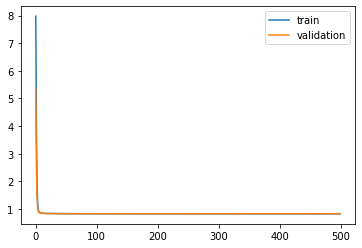

Time to train LSTM:  329.8549325466156
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 7.9523 - pdc_loss: 0.6603 - event_loss: 0.6677 - val_loss: 5.3249 - val_pdc_loss: 0.6190 - val_event_loss: 0.5479

Epoch 00001: val_loss improved from inf to 5.32488, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 3.8165 - pdc_loss: 0.5928 - event_loss: 0.4498 - val_loss: 2.5922 - val_pdc_loss: 0.5835 - val_event_loss: 0.3645

Epoch 00002: val_loss improved from 5.32488 to 2.59217, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 1.9484 - pdc_loss: 0.5688 - event_loss: 0.3247 - val_loss: 1.4769 - val_pdc_loss: 0.5659 - val_event_loss: 0.3166

Epoch 00003: val_loss improved from 2.59217 to 1.47695, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 1.2355 - pdc_loss: 0.5558 - event_loss: 0.3058 - val_loss: 1.0706 - val_pdc_loss: 0.5555 - val_event_loss: 0.3102

Epoch 00004: val_loss improved from 1.47695 to 1.07061, saving m

 - 1s - loss: 0.8308 - pdc_loss: 0.5200 - event_loss: 0.2979 - val_loss: 0.8446 - val_pdc_loss: 0.5272 - val_event_loss: 0.3045

Epoch 00037: val_loss did not improve from 0.84399
Epoch 38/500
 - 1s - loss: 0.8306 - pdc_loss: 0.5199 - event_loss: 0.2979 - val_loss: 0.8440 - val_pdc_loss: 0.5268 - val_event_loss: 0.3044

Epoch 00038: val_loss did not improve from 0.84399
Epoch 39/500
 - 1s - loss: 0.8304 - pdc_loss: 0.5198 - event_loss: 0.2979 - val_loss: 0.8437 - val_pdc_loss: 0.5266 - val_event_loss: 0.3043

Epoch 00039: val_loss improved from 0.84399 to 0.84369, saving model to Event_val_weights2.hdf5
Epoch 40/500
 - 1s - loss: 0.8301 - pdc_loss: 0.5197 - event_loss: 0.2977 - val_loss: 0.8435 - val_pdc_loss: 0.5265 - val_event_loss: 0.3042

Epoch 00040: val_loss improved from 0.84369 to 0.84346, saving model to Event_val_weights2.hdf5
Epoch 41/500
 - 1s - loss: 0.8300 - pdc_loss: 0.5196 - event_loss: 0.2978 - val_loss: 0.8436 - val_pdc_loss: 0.5267 - val_event_loss: 0.3042

Epoch 000


Epoch 00076: val_loss did not improve from 0.84141
Epoch 77/500
 - 1s - loss: 0.8262 - pdc_loss: 0.5171 - event_loss: 0.2968 - val_loss: 0.8414 - val_pdc_loss: 0.5259 - val_event_loss: 0.3032

Epoch 00077: val_loss did not improve from 0.84141
Epoch 78/500
 - 1s - loss: 0.8260 - pdc_loss: 0.5170 - event_loss: 0.2967 - val_loss: 0.8416 - val_pdc_loss: 0.5261 - val_event_loss: 0.3032

Epoch 00078: val_loss did not improve from 0.84141
Epoch 79/500
 - 1s - loss: 0.8260 - pdc_loss: 0.5169 - event_loss: 0.2968 - val_loss: 0.8414 - val_pdc_loss: 0.5261 - val_event_loss: 0.3030

Epoch 00079: val_loss improved from 0.84141 to 0.84136, saving model to Event_val_weights2.hdf5
Epoch 80/500
 - 1s - loss: 0.8259 - pdc_loss: 0.5169 - event_loss: 0.2967 - val_loss: 0.8411 - val_pdc_loss: 0.5257 - val_event_loss: 0.3031

Epoch 00080: val_loss improved from 0.84136 to 0.84115, saving model to Event_val_weights2.hdf5
Epoch 81/500
 - 1s - loss: 0.8258 - pdc_loss: 0.5169 - event_loss: 0.2967 - val_loss: 


Epoch 00117: val_loss improved from 0.84080 to 0.84078, saving model to Event_val_weights2.hdf5
Epoch 118/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5156 - event_loss: 0.2959 - val_loss: 0.8412 - val_pdc_loss: 0.5257 - val_event_loss: 0.3032

Epoch 00118: val_loss did not improve from 0.84078
Epoch 119/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5155 - event_loss: 0.2958 - val_loss: 0.8404 - val_pdc_loss: 0.5249 - val_event_loss: 0.3030

Epoch 00119: val_loss improved from 0.84078 to 0.84035, saving model to Event_val_weights2.hdf5
Epoch 120/500
 - 1s - loss: 0.8237 - pdc_loss: 0.5154 - event_loss: 0.2958 - val_loss: 0.8415 - val_pdc_loss: 0.5255 - val_event_loss: 0.3035

Epoch 00120: val_loss did not improve from 0.84035
Epoch 121/500
 - 1s - loss: 0.8237 - pdc_loss: 0.5155 - event_loss: 0.2958 - val_loss: 0.8409 - val_pdc_loss: 0.5253 - val_event_loss: 0.3031

Epoch 00121: val_loss did not improve from 0.84035
Epoch 122/500
 - 1s - loss: 0.8237 - pdc_loss: 0.5154 - event_loss: 0.2958 - val_l


Epoch 00159: val_loss did not improve from 0.84035
Epoch 160/500
 - 1s - loss: 0.8225 - pdc_loss: 0.5144 - event_loss: 0.2952 - val_loss: 0.8415 - val_pdc_loss: 0.5249 - val_event_loss: 0.3035

Epoch 00160: val_loss did not improve from 0.84035
Epoch 161/500
 - 1s - loss: 0.8226 - pdc_loss: 0.5144 - event_loss: 0.2951 - val_loss: 0.8413 - val_pdc_loss: 0.5249 - val_event_loss: 0.3034

Epoch 00161: val_loss did not improve from 0.84035
Epoch 162/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5143 - event_loss: 0.2951 - val_loss: 0.8414 - val_pdc_loss: 0.5250 - val_event_loss: 0.3034

Epoch 00162: val_loss did not improve from 0.84035
Epoch 163/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5144 - event_loss: 0.2951 - val_loss: 0.8410 - val_pdc_loss: 0.5246 - val_event_loss: 0.3035

Epoch 00163: val_loss did not improve from 0.84035
Epoch 164/500
 - 1s - loss: 0.8223 - pdc_loss: 0.5143 - event_loss: 0.2951 - val_loss: 0.8411 - val_pdc_loss: 0.5249 - val_event_loss: 0.3033

Epoch 00164: val_loss did not


Epoch 00201: val_loss did not improve from 0.84016
Epoch 202/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5131 - event_loss: 0.2949 - val_loss: 0.8417 - val_pdc_loss: 0.5241 - val_event_loss: 0.3041

Epoch 00202: val_loss did not improve from 0.84016
Epoch 203/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5130 - event_loss: 0.2946 - val_loss: 0.8420 - val_pdc_loss: 0.5242 - val_event_loss: 0.3045

Epoch 00203: val_loss did not improve from 0.84016
Epoch 204/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5130 - event_loss: 0.2947 - val_loss: 0.8422 - val_pdc_loss: 0.5245 - val_event_loss: 0.3042

Epoch 00204: val_loss did not improve from 0.84016
Epoch 205/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5128 - event_loss: 0.2946 - val_loss: 0.8423 - val_pdc_loss: 0.5246 - val_event_loss: 0.3045

Epoch 00205: val_loss did not improve from 0.84016
Epoch 206/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5129 - event_loss: 0.2947 - val_loss: 0.8420 - val_pdc_loss: 0.5245 - val_event_loss: 0.3041

Epoch 00206: val_loss did not

 - 1s - loss: 0.8201 - pdc_loss: 0.5119 - event_loss: 0.2943 - val_loss: 0.8445 - val_pdc_loss: 0.5255 - val_event_loss: 0.3051

Epoch 00244: val_loss did not improve from 0.84016
Epoch 245/500
 - 1s - loss: 0.8198 - pdc_loss: 0.5117 - event_loss: 0.2943 - val_loss: 0.8440 - val_pdc_loss: 0.5250 - val_event_loss: 0.3051

Epoch 00245: val_loss did not improve from 0.84016
Epoch 246/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5118 - event_loss: 0.2942 - val_loss: 0.8445 - val_pdc_loss: 0.5254 - val_event_loss: 0.3053

Epoch 00246: val_loss did not improve from 0.84016
Epoch 247/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5116 - event_loss: 0.2942 - val_loss: 0.8441 - val_pdc_loss: 0.5250 - val_event_loss: 0.3054

Epoch 00247: val_loss did not improve from 0.84016
Epoch 248/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5116 - event_loss: 0.2942 - val_loss: 0.8443 - val_pdc_loss: 0.5253 - val_event_loss: 0.3052

Epoch 00248: val_loss did not improve from 0.84016
Epoch 249/500
 - 1s - loss: 0.8198 - pdc_los


Epoch 00286: val_loss did not improve from 0.84016
Epoch 287/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5110 - event_loss: 0.2940 - val_loss: 0.8434 - val_pdc_loss: 0.5245 - val_event_loss: 0.3047

Epoch 00287: val_loss did not improve from 0.84016
Epoch 288/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5111 - event_loss: 0.2938 - val_loss: 0.8441 - val_pdc_loss: 0.5248 - val_event_loss: 0.3051

Epoch 00288: val_loss did not improve from 0.84016
Epoch 289/500
 - 1s - loss: 0.8188 - pdc_loss: 0.5108 - event_loss: 0.2938 - val_loss: 0.8444 - val_pdc_loss: 0.5247 - val_event_loss: 0.3054

Epoch 00289: val_loss did not improve from 0.84016
Epoch 290/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5110 - event_loss: 0.2938 - val_loss: 0.8437 - val_pdc_loss: 0.5247 - val_event_loss: 0.3048

Epoch 00290: val_loss did not improve from 0.84016
Epoch 291/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5111 - event_loss: 0.2938 - val_loss: 0.8443 - val_pdc_loss: 0.5250 - val_event_loss: 0.3051

Epoch 00291: val_loss did not

 - 1s - loss: 0.8186 - pdc_loss: 0.5106 - event_loss: 0.2938 - val_loss: 0.8442 - val_pdc_loss: 0.5246 - val_event_loss: 0.3054

Epoch 00329: val_loss did not improve from 0.84016
Epoch 330/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5106 - event_loss: 0.2937 - val_loss: 0.8435 - val_pdc_loss: 0.5242 - val_event_loss: 0.3049

Epoch 00330: val_loss did not improve from 0.84016
Epoch 331/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5105 - event_loss: 0.2937 - val_loss: 0.8442 - val_pdc_loss: 0.5244 - val_event_loss: 0.3054

Epoch 00331: val_loss did not improve from 0.84016
Epoch 332/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5105 - event_loss: 0.2937 - val_loss: 0.8435 - val_pdc_loss: 0.5243 - val_event_loss: 0.3050

Epoch 00332: val_loss did not improve from 0.84016
Epoch 333/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5106 - event_loss: 0.2937 - val_loss: 0.8447 - val_pdc_loss: 0.5247 - val_event_loss: 0.3056

Epoch 00333: val_loss did not improve from 0.84016
Epoch 334/500
 - 1s - loss: 0.8183 - pdc_los


Epoch 00371: val_loss did not improve from 0.84016
Epoch 372/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5101 - event_loss: 0.2934 - val_loss: 0.8453 - val_pdc_loss: 0.5253 - val_event_loss: 0.3056

Epoch 00372: val_loss did not improve from 0.84016
Epoch 373/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5104 - event_loss: 0.2932 - val_loss: 0.8444 - val_pdc_loss: 0.5246 - val_event_loss: 0.3053

Epoch 00373: val_loss did not improve from 0.84016
Epoch 374/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5100 - event_loss: 0.2933 - val_loss: 0.8447 - val_pdc_loss: 0.5251 - val_event_loss: 0.3052

Epoch 00374: val_loss did not improve from 0.84016
Epoch 375/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5101 - event_loss: 0.2933 - val_loss: 0.8449 - val_pdc_loss: 0.5249 - val_event_loss: 0.3055

Epoch 00375: val_loss did not improve from 0.84016
Epoch 376/500
 - 1s - loss: 0.8174 - pdc_loss: 0.5099 - event_loss: 0.2932 - val_loss: 0.8444 - val_pdc_loss: 0.5245 - val_event_loss: 0.3055

Epoch 00376: val_loss did not

 - 1s - loss: 0.8174 - pdc_loss: 0.5094 - event_loss: 0.2933 - val_loss: 0.8457 - val_pdc_loss: 0.5256 - val_event_loss: 0.3052

Epoch 00414: val_loss did not improve from 0.84016
Epoch 415/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5096 - event_loss: 0.2930 - val_loss: 0.8463 - val_pdc_loss: 0.5259 - val_event_loss: 0.3055

Epoch 00415: val_loss did not improve from 0.84016
Epoch 416/500
 - 1s - loss: 0.8176 - pdc_loss: 0.5097 - event_loss: 0.2931 - val_loss: 0.8477 - val_pdc_loss: 0.5269 - val_event_loss: 0.3061

Epoch 00416: val_loss did not improve from 0.84016
Epoch 417/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5096 - event_loss: 0.2930 - val_loss: 0.8458 - val_pdc_loss: 0.5257 - val_event_loss: 0.3054

Epoch 00417: val_loss did not improve from 0.84016
Epoch 418/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5095 - event_loss: 0.2930 - val_loss: 0.8470 - val_pdc_loss: 0.5264 - val_event_loss: 0.3059

Epoch 00418: val_loss did not improve from 0.84016
Epoch 419/500
 - 1s - loss: 0.8172 - pdc_los


Epoch 00456: val_loss did not improve from 0.84016
Epoch 457/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5093 - event_loss: 0.2929 - val_loss: 0.8474 - val_pdc_loss: 0.5272 - val_event_loss: 0.3051

Epoch 00457: val_loss did not improve from 0.84016
Epoch 458/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5091 - event_loss: 0.2929 - val_loss: 0.8459 - val_pdc_loss: 0.5260 - val_event_loss: 0.3049

Epoch 00458: val_loss did not improve from 0.84016
Epoch 459/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5092 - event_loss: 0.2930 - val_loss: 0.8475 - val_pdc_loss: 0.5275 - val_event_loss: 0.3052

Epoch 00459: val_loss did not improve from 0.84016
Epoch 460/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5093 - event_loss: 0.2930 - val_loss: 0.8468 - val_pdc_loss: 0.5263 - val_event_loss: 0.3053

Epoch 00460: val_loss did not improve from 0.84016
Epoch 461/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5090 - event_loss: 0.2929 - val_loss: 0.8469 - val_pdc_loss: 0.5266 - val_event_loss: 0.3052

Epoch 00461: val_loss did not

 - 1s - loss: 0.8171 - pdc_loss: 0.5090 - event_loss: 0.2930 - val_loss: 0.8470 - val_pdc_loss: 0.5271 - val_event_loss: 0.3048

Epoch 00499: val_loss did not improve from 0.84016
Epoch 500/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5089 - event_loss: 0.2928 - val_loss: 0.8477 - val_pdc_loss: 0.5271 - val_event_loss: 0.3055

Epoch 00500: val_loss did not improve from 0.84016
#################################
Number of units: 16
Batch size: 2048
Fold: 1
best val loss: 0.8401647506819832
#################################


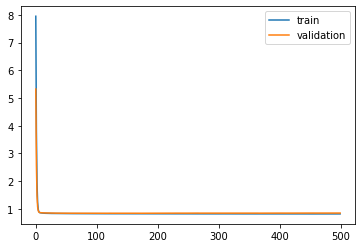

Time to train LSTM:  277.31967067718506
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 8.0432 - pdc_loss: 0.6940 - event_loss: 0.6106 - val_loss: 5.3733 - val_pdc_loss: 0.6413 - val_event_loss: 0.4715

Epoch 00001: val_loss improved from inf to 5.37329, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 3.8612 - pdc_loss: 0.6104 - event_loss: 0.3965 - val_loss: 2.6248 - val_pdc_loss: 0.5913 - val_event_loss: 0.3321

Epoch 00002: val_loss improved from 5.37329 to 2.62482, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 1.9851 - pdc_loss: 0.5731 - event_loss: 0.3143 - val_loss: 1.5017 - val_pdc_loss: 0.5736 - val_event_loss: 0.3054

Epoch 00003: val_loss improved from 2.62482 to 1.50172, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 1.2553 - pdc_loss: 0.5594 - event_loss: 0.3033 - val_loss: 1.0838 - val_pdc_loss: 0.5666 - val_event_loss: 0.3018

Epoch 00004: val_loss improved from 1.50172 to 1.08383, saving 


Epoch 00035: val_loss improved from 0.84705 to 0.84686, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 0.8311 - pdc_loss: 0.5207 - event_loss: 0.2972 - val_loss: 0.8470 - val_pdc_loss: 0.5334 - val_event_loss: 0.3004

Epoch 00036: val_loss did not improve from 0.84686
Epoch 37/500
 - 1s - loss: 0.8310 - pdc_loss: 0.5206 - event_loss: 0.2972 - val_loss: 0.8467 - val_pdc_loss: 0.5332 - val_event_loss: 0.3003

Epoch 00037: val_loss improved from 0.84686 to 0.84671, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 0.8307 - pdc_loss: 0.5204 - event_loss: 0.2972 - val_loss: 0.8467 - val_pdc_loss: 0.5331 - val_event_loss: 0.3004

Epoch 00038: val_loss improved from 0.84671 to 0.84667, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.8306 - pdc_loss: 0.5204 - event_loss: 0.2971 - val_loss: 0.8466 - val_pdc_loss: 0.5332 - val_event_loss: 0.3003

Epoch 00039: val_loss improved from 0.84667 to 0.84662, saving model to Event_val_weights3.h


Epoch 00074: val_loss did not improve from 0.84440
Epoch 75/500
 - 1s - loss: 0.8268 - pdc_loss: 0.5177 - event_loss: 0.2965 - val_loss: 0.8451 - val_pdc_loss: 0.5319 - val_event_loss: 0.3005

Epoch 00075: val_loss did not improve from 0.84440
Epoch 76/500
 - 1s - loss: 0.8270 - pdc_loss: 0.5178 - event_loss: 0.2965 - val_loss: 0.8445 - val_pdc_loss: 0.5316 - val_event_loss: 0.3003

Epoch 00076: val_loss did not improve from 0.84440
Epoch 77/500
 - 1s - loss: 0.8267 - pdc_loss: 0.5177 - event_loss: 0.2964 - val_loss: 0.8449 - val_pdc_loss: 0.5318 - val_event_loss: 0.3005

Epoch 00077: val_loss did not improve from 0.84440
Epoch 78/500
 - 1s - loss: 0.8265 - pdc_loss: 0.5176 - event_loss: 0.2964 - val_loss: 0.8442 - val_pdc_loss: 0.5313 - val_event_loss: 0.3003

Epoch 00078: val_loss improved from 0.84440 to 0.84423, saving model to Event_val_weights3.hdf5
Epoch 79/500
 - 1s - loss: 0.8264 - pdc_loss: 0.5175 - event_loss: 0.2964 - val_loss: 0.8447 - val_pdc_loss: 0.5317 - val_event_los


Epoch 00115: val_loss did not improve from 0.84396
Epoch 116/500
 - 1s - loss: 0.8243 - pdc_loss: 0.5160 - event_loss: 0.2956 - val_loss: 0.8441 - val_pdc_loss: 0.5306 - val_event_loss: 0.3008

Epoch 00116: val_loss did not improve from 0.84396
Epoch 117/500
 - 1s - loss: 0.8244 - pdc_loss: 0.5159 - event_loss: 0.2956 - val_loss: 0.8440 - val_pdc_loss: 0.5305 - val_event_loss: 0.3007

Epoch 00117: val_loss did not improve from 0.84396
Epoch 118/500
 - 1s - loss: 0.8243 - pdc_loss: 0.5159 - event_loss: 0.2956 - val_loss: 0.8440 - val_pdc_loss: 0.5305 - val_event_loss: 0.3007

Epoch 00118: val_loss did not improve from 0.84396
Epoch 119/500
 - 1s - loss: 0.8242 - pdc_loss: 0.5158 - event_loss: 0.2956 - val_loss: 0.8439 - val_pdc_loss: 0.5303 - val_event_loss: 0.3009

Epoch 00119: val_loss improved from 0.84396 to 0.84390, saving model to Event_val_weights3.hdf5
Epoch 120/500
 - 1s - loss: 0.8241 - pdc_loss: 0.5158 - event_loss: 0.2956 - val_loss: 0.8443 - val_pdc_loss: 0.5306 - val_even

 - 1s - loss: 0.8225 - pdc_loss: 0.5146 - event_loss: 0.2951 - val_loss: 0.8440 - val_pdc_loss: 0.5303 - val_event_loss: 0.3009

Epoch 00157: val_loss did not improve from 0.84336
Epoch 158/500
 - 1s - loss: 0.8226 - pdc_loss: 0.5145 - event_loss: 0.2951 - val_loss: 0.8441 - val_pdc_loss: 0.5303 - val_event_loss: 0.3009

Epoch 00158: val_loss did not improve from 0.84336
Epoch 159/500
 - 1s - loss: 0.8225 - pdc_loss: 0.5146 - event_loss: 0.2951 - val_loss: 0.8438 - val_pdc_loss: 0.5301 - val_event_loss: 0.3009

Epoch 00159: val_loss did not improve from 0.84336
Epoch 160/500
 - 1s - loss: 0.8225 - pdc_loss: 0.5145 - event_loss: 0.2951 - val_loss: 0.8442 - val_pdc_loss: 0.5304 - val_event_loss: 0.3010

Epoch 00160: val_loss did not improve from 0.84336
Epoch 161/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5145 - event_loss: 0.2951 - val_loss: 0.8440 - val_pdc_loss: 0.5303 - val_event_loss: 0.3009

Epoch 00161: val_loss did not improve from 0.84336
Epoch 162/500
 - 1s - loss: 0.8225 - pdc_los


Epoch 00199: val_loss did not improve from 0.84336
Epoch 200/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5135 - event_loss: 0.2947 - val_loss: 0.8445 - val_pdc_loss: 0.5301 - val_event_loss: 0.3013

Epoch 00200: val_loss did not improve from 0.84336
Epoch 201/500
 - 1s - loss: 0.8215 - pdc_loss: 0.5136 - event_loss: 0.2948 - val_loss: 0.8452 - val_pdc_loss: 0.5306 - val_event_loss: 0.3015

Epoch 00201: val_loss did not improve from 0.84336
Epoch 202/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5135 - event_loss: 0.2948 - val_loss: 0.8445 - val_pdc_loss: 0.5302 - val_event_loss: 0.3012

Epoch 00202: val_loss did not improve from 0.84336
Epoch 203/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5134 - event_loss: 0.2947 - val_loss: 0.8448 - val_pdc_loss: 0.5307 - val_event_loss: 0.3011

Epoch 00203: val_loss did not improve from 0.84336
Epoch 204/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5135 - event_loss: 0.2947 - val_loss: 0.8451 - val_pdc_loss: 0.5306 - val_event_loss: 0.3013

Epoch 00204: val_loss did not

 - 1s - loss: 0.8204 - pdc_loss: 0.5127 - event_loss: 0.2943 - val_loss: 0.8454 - val_pdc_loss: 0.5306 - val_event_loss: 0.3015

Epoch 00242: val_loss did not improve from 0.84336
Epoch 243/500
 - 1s - loss: 0.8204 - pdc_loss: 0.5128 - event_loss: 0.2943 - val_loss: 0.8452 - val_pdc_loss: 0.5304 - val_event_loss: 0.3014

Epoch 00243: val_loss did not improve from 0.84336
Epoch 244/500
 - 1s - loss: 0.8202 - pdc_loss: 0.5127 - event_loss: 0.2943 - val_loss: 0.8456 - val_pdc_loss: 0.5307 - val_event_loss: 0.3016

Epoch 00244: val_loss did not improve from 0.84336
Epoch 245/500
 - 1s - loss: 0.8204 - pdc_loss: 0.5128 - event_loss: 0.2943 - val_loss: 0.8460 - val_pdc_loss: 0.5311 - val_event_loss: 0.3015

Epoch 00245: val_loss did not improve from 0.84336
Epoch 246/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5127 - event_loss: 0.2942 - val_loss: 0.8456 - val_pdc_loss: 0.5306 - val_event_loss: 0.3017

Epoch 00246: val_loss did not improve from 0.84336
Epoch 247/500
 - 1s - loss: 0.8203 - pdc_los


Epoch 00284: val_loss did not improve from 0.84336
Epoch 285/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5119 - event_loss: 0.2940 - val_loss: 0.8468 - val_pdc_loss: 0.5316 - val_event_loss: 0.3013

Epoch 00285: val_loss did not improve from 0.84336
Epoch 286/500
 - 1s - loss: 0.8198 - pdc_loss: 0.5121 - event_loss: 0.2939 - val_loss: 0.8464 - val_pdc_loss: 0.5309 - val_event_loss: 0.3015

Epoch 00286: val_loss did not improve from 0.84336
Epoch 287/500
 - 1s - loss: 0.8198 - pdc_loss: 0.5120 - event_loss: 0.2939 - val_loss: 0.8464 - val_pdc_loss: 0.5312 - val_event_loss: 0.3014

Epoch 00287: val_loss did not improve from 0.84336
Epoch 288/500
 - 1s - loss: 0.8196 - pdc_loss: 0.5119 - event_loss: 0.2938 - val_loss: 0.8468 - val_pdc_loss: 0.5311 - val_event_loss: 0.3019

Epoch 00288: val_loss did not improve from 0.84336
Epoch 289/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5119 - event_loss: 0.2940 - val_loss: 0.8465 - val_pdc_loss: 0.5310 - val_event_loss: 0.3017

Epoch 00289: val_loss did not

 - 1s - loss: 0.8195 - pdc_loss: 0.5116 - event_loss: 0.2939 - val_loss: 0.8474 - val_pdc_loss: 0.5312 - val_event_loss: 0.3025

Epoch 00327: val_loss did not improve from 0.84336
Epoch 328/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5117 - event_loss: 0.2939 - val_loss: 0.8470 - val_pdc_loss: 0.5312 - val_event_loss: 0.3019

Epoch 00328: val_loss did not improve from 0.84336
Epoch 329/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5117 - event_loss: 0.2938 - val_loss: 0.8477 - val_pdc_loss: 0.5314 - val_event_loss: 0.3023

Epoch 00329: val_loss did not improve from 0.84336
Epoch 330/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5116 - event_loss: 0.2938 - val_loss: 0.8469 - val_pdc_loss: 0.5311 - val_event_loss: 0.3019

Epoch 00330: val_loss did not improve from 0.84336
Epoch 331/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5116 - event_loss: 0.2937 - val_loss: 0.8470 - val_pdc_loss: 0.5311 - val_event_loss: 0.3021

Epoch 00331: val_loss did not improve from 0.84336
Epoch 332/500
 - 1s - loss: 0.8191 - pdc_los


Epoch 00369: val_loss did not improve from 0.84336
Epoch 370/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5110 - event_loss: 0.2934 - val_loss: 0.8482 - val_pdc_loss: 0.5316 - val_event_loss: 0.3026

Epoch 00370: val_loss did not improve from 0.84336
Epoch 371/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5111 - event_loss: 0.2934 - val_loss: 0.8478 - val_pdc_loss: 0.5314 - val_event_loss: 0.3023

Epoch 00371: val_loss did not improve from 0.84336
Epoch 372/500
 - 1s - loss: 0.8187 - pdc_loss: 0.5110 - event_loss: 0.2934 - val_loss: 0.8481 - val_pdc_loss: 0.5313 - val_event_loss: 0.3027

Epoch 00372: val_loss did not improve from 0.84336
Epoch 373/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5109 - event_loss: 0.2935 - val_loss: 0.8478 - val_pdc_loss: 0.5312 - val_event_loss: 0.3026

Epoch 00373: val_loss did not improve from 0.84336
Epoch 374/500
 - 1s - loss: 0.8183 - pdc_loss: 0.5109 - event_loss: 0.2934 - val_loss: 0.8485 - val_pdc_loss: 0.5319 - val_event_loss: 0.3025

Epoch 00374: val_loss did not

 - 1s - loss: 0.8179 - pdc_loss: 0.5107 - event_loss: 0.2932 - val_loss: 0.8478 - val_pdc_loss: 0.5306 - val_event_loss: 0.3031

Epoch 00412: val_loss did not improve from 0.84336
Epoch 413/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5107 - event_loss: 0.2931 - val_loss: 0.8477 - val_pdc_loss: 0.5312 - val_event_loss: 0.3026

Epoch 00413: val_loss did not improve from 0.84336
Epoch 414/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5107 - event_loss: 0.2932 - val_loss: 0.8474 - val_pdc_loss: 0.5306 - val_event_loss: 0.3026

Epoch 00414: val_loss did not improve from 0.84336
Epoch 415/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5108 - event_loss: 0.2931 - val_loss: 0.8477 - val_pdc_loss: 0.5312 - val_event_loss: 0.3024

Epoch 00415: val_loss did not improve from 0.84336
Epoch 416/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5107 - event_loss: 0.2931 - val_loss: 0.8473 - val_pdc_loss: 0.5306 - val_event_loss: 0.3027

Epoch 00416: val_loss did not improve from 0.84336
Epoch 417/500
 - 1s - loss: 0.8178 - pdc_los


Epoch 00454: val_loss did not improve from 0.84336
Epoch 455/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5101 - event_loss: 0.2927 - val_loss: 0.8469 - val_pdc_loss: 0.5306 - val_event_loss: 0.3021

Epoch 00455: val_loss did not improve from 0.84336
Epoch 456/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5101 - event_loss: 0.2929 - val_loss: 0.8485 - val_pdc_loss: 0.5310 - val_event_loss: 0.3034

Epoch 00456: val_loss did not improve from 0.84336
Epoch 457/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5103 - event_loss: 0.2928 - val_loss: 0.8472 - val_pdc_loss: 0.5304 - val_event_loss: 0.3026

Epoch 00457: val_loss did not improve from 0.84336
Epoch 458/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5104 - event_loss: 0.2930 - val_loss: 0.8485 - val_pdc_loss: 0.5311 - val_event_loss: 0.3028

Epoch 00458: val_loss did not improve from 0.84336
Epoch 459/500
 - 1s - loss: 0.8173 - pdc_loss: 0.5102 - event_loss: 0.2928 - val_loss: 0.8471 - val_pdc_loss: 0.5304 - val_event_loss: 0.3024

Epoch 00459: val_loss did not

 - 1s - loss: 0.8166 - pdc_loss: 0.5098 - event_loss: 0.2927 - val_loss: 0.8467 - val_pdc_loss: 0.5302 - val_event_loss: 0.3023

Epoch 00497: val_loss did not improve from 0.84336
Epoch 498/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5099 - event_loss: 0.2928 - val_loss: 0.8468 - val_pdc_loss: 0.5310 - val_event_loss: 0.3015

Epoch 00498: val_loss did not improve from 0.84336
Epoch 499/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5097 - event_loss: 0.2927 - val_loss: 0.8474 - val_pdc_loss: 0.5310 - val_event_loss: 0.3023

Epoch 00499: val_loss did not improve from 0.84336
Epoch 500/500
 - 1s - loss: 0.8168 - pdc_loss: 0.5098 - event_loss: 0.2928 - val_loss: 0.8470 - val_pdc_loss: 0.5307 - val_event_loss: 0.3021

Epoch 00500: val_loss did not improve from 0.84336
#################################
Number of units: 16
Batch size: 2048
Fold: 2
best val loss: 0.8433566116756863
#################################


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0af1c826a0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


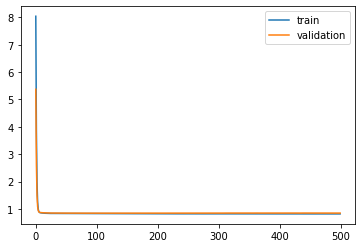

Time to train LSTM:  278.26455664634705
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 8.0630 - pdc_loss: 0.6844 - event_loss: 0.6125 - val_loss: 5.4088 - val_pdc_loss: 0.6536 - val_event_loss: 0.4864

Epoch 00001: val_loss improved from inf to 5.40884, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 3.8800 - pdc_loss: 0.6225 - event_loss: 0.3997 - val_loss: 2.6399 - val_pdc_loss: 0.6047 - val_event_loss: 0.3357

Epoch 00002: val_loss improved from 5.40884 to 2.63985, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 1.9877 - pdc_loss: 0.5795 - event_loss: 0.3145 - val_loss: 1.5064 - val_pdc_loss: 0.5770 - val_event_loss: 0.3110

Epoch 00003: val_loss improved from 2.63985 to 1.50637, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 1.2530 - pdc_loss: 0.5616 - event_loss: 0.3030 - val_loss: 1.0873 - val_pdc_loss: 0.5677 - val_event_loss: 0.3073

Epoch 00004: val_loss improved from 1.50637 to 1.08725, saving 

 - 1s - loss: 0.8301 - pdc_loss: 0.5204 - event_loss: 0.2972 - val_loss: 0.8524 - val_pdc_loss: 0.5375 - val_event_loss: 0.3024

Epoch 00036: val_loss improved from 0.85284 to 0.85241, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.8301 - pdc_loss: 0.5205 - event_loss: 0.2971 - val_loss: 0.8524 - val_pdc_loss: 0.5375 - val_event_loss: 0.3025

Epoch 00037: val_loss improved from 0.85241 to 0.85241, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.8297 - pdc_loss: 0.5201 - event_loss: 0.2971 - val_loss: 0.8520 - val_pdc_loss: 0.5373 - val_event_loss: 0.3024

Epoch 00038: val_loss improved from 0.85241 to 0.85200, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8296 - pdc_loss: 0.5202 - event_loss: 0.2971 - val_loss: 0.8523 - val_pdc_loss: 0.5375 - val_event_loss: 0.3025

Epoch 00039: val_loss did not improve from 0.85200
Epoch 40/500
 - 1s - loss: 0.8293 - pdc_loss: 0.5199 - event_loss: 0.2971 - val_loss: 0.8517 - val_pdc_los


Epoch 00073: val_loss improved from 0.84889 to 0.84875, saving model to Event_val_weights4.hdf5
Epoch 74/500
 - 1s - loss: 0.8257 - pdc_loss: 0.5176 - event_loss: 0.2962 - val_loss: 0.8491 - val_pdc_loss: 0.5352 - val_event_loss: 0.3020

Epoch 00074: val_loss did not improve from 0.84875
Epoch 75/500
 - 1s - loss: 0.8258 - pdc_loss: 0.5176 - event_loss: 0.2963 - val_loss: 0.8490 - val_pdc_loss: 0.5349 - val_event_loss: 0.3021

Epoch 00075: val_loss did not improve from 0.84875
Epoch 76/500
 - 1s - loss: 0.8257 - pdc_loss: 0.5175 - event_loss: 0.2962 - val_loss: 0.8491 - val_pdc_loss: 0.5351 - val_event_loss: 0.3021

Epoch 00076: val_loss did not improve from 0.84875
Epoch 77/500
 - 1s - loss: 0.8257 - pdc_loss: 0.5176 - event_loss: 0.2962 - val_loss: 0.8491 - val_pdc_loss: 0.5350 - val_event_loss: 0.3022

Epoch 00077: val_loss did not improve from 0.84875
Epoch 78/500
 - 1s - loss: 0.8256 - pdc_loss: 0.5174 - event_loss: 0.2962 - val_loss: 0.8489 - val_pdc_loss: 0.5349 - val_event_los


Epoch 00113: val_loss did not improve from 0.84774
Epoch 114/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5162 - event_loss: 0.2958 - val_loss: 0.8477 - val_pdc_loss: 0.5336 - val_event_loss: 0.3022

Epoch 00114: val_loss improved from 0.84774 to 0.84769, saving model to Event_val_weights4.hdf5
Epoch 115/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5161 - event_loss: 0.2959 - val_loss: 0.8480 - val_pdc_loss: 0.5336 - val_event_loss: 0.3023

Epoch 00115: val_loss did not improve from 0.84769
Epoch 116/500
 - 1s - loss: 0.8240 - pdc_loss: 0.5161 - event_loss: 0.2958 - val_loss: 0.8478 - val_pdc_loss: 0.5336 - val_event_loss: 0.3022

Epoch 00116: val_loss did not improve from 0.84769
Epoch 117/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5161 - event_loss: 0.2958 - val_loss: 0.8474 - val_pdc_loss: 0.5333 - val_event_loss: 0.3022

Epoch 00117: val_loss improved from 0.84769 to 0.84743, saving model to Event_val_weights4.hdf5
Epoch 118/500
 - 1s - loss: 0.8237 - pdc_loss: 0.5160 - event_loss: 0.2958 - val_l


Epoch 00154: val_loss did not improve from 0.84708
Epoch 155/500
 - 1s - loss: 0.8227 - pdc_loss: 0.5151 - event_loss: 0.2954 - val_loss: 0.8472 - val_pdc_loss: 0.5329 - val_event_loss: 0.3021

Epoch 00155: val_loss did not improve from 0.84708
Epoch 156/500
 - 1s - loss: 0.8227 - pdc_loss: 0.5149 - event_loss: 0.2955 - val_loss: 0.8473 - val_pdc_loss: 0.5330 - val_event_loss: 0.3022

Epoch 00156: val_loss did not improve from 0.84708
Epoch 157/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5149 - event_loss: 0.2954 - val_loss: 0.8472 - val_pdc_loss: 0.5331 - val_event_loss: 0.3020

Epoch 00157: val_loss did not improve from 0.84708
Epoch 158/500
 - 1s - loss: 0.8223 - pdc_loss: 0.5148 - event_loss: 0.2954 - val_loss: 0.8471 - val_pdc_loss: 0.5329 - val_event_loss: 0.3021

Epoch 00158: val_loss did not improve from 0.84708
Epoch 159/500
 - 1s - loss: 0.8225 - pdc_loss: 0.5149 - event_loss: 0.2954 - val_loss: 0.8474 - val_pdc_loss: 0.5330 - val_event_loss: 0.3022

Epoch 00159: val_loss did not


Epoch 00196: val_loss did not improve from 0.84680
Epoch 197/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5137 - event_loss: 0.2951 - val_loss: 0.8475 - val_pdc_loss: 0.5327 - val_event_loss: 0.3024

Epoch 00197: val_loss did not improve from 0.84680
Epoch 198/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5137 - event_loss: 0.2950 - val_loss: 0.8473 - val_pdc_loss: 0.5327 - val_event_loss: 0.3023

Epoch 00198: val_loss did not improve from 0.84680
Epoch 199/500
 - 1s - loss: 0.8215 - pdc_loss: 0.5137 - event_loss: 0.2951 - val_loss: 0.8477 - val_pdc_loss: 0.5326 - val_event_loss: 0.3025

Epoch 00199: val_loss did not improve from 0.84680
Epoch 200/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5136 - event_loss: 0.2950 - val_loss: 0.8475 - val_pdc_loss: 0.5328 - val_event_loss: 0.3023

Epoch 00200: val_loss did not improve from 0.84680
Epoch 201/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5137 - event_loss: 0.2950 - val_loss: 0.8469 - val_pdc_loss: 0.5324 - val_event_loss: 0.3023

Epoch 00201: val_loss did not


Epoch 00238: val_loss did not improve from 0.84658
Epoch 239/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5130 - event_loss: 0.2947 - val_loss: 0.8473 - val_pdc_loss: 0.5318 - val_event_loss: 0.3029

Epoch 00239: val_loss did not improve from 0.84658
Epoch 240/500
 - 1s - loss: 0.8205 - pdc_loss: 0.5131 - event_loss: 0.2948 - val_loss: 0.8477 - val_pdc_loss: 0.5321 - val_event_loss: 0.3030

Epoch 00240: val_loss did not improve from 0.84658
Epoch 241/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5129 - event_loss: 0.2947 - val_loss: 0.8471 - val_pdc_loss: 0.5316 - val_event_loss: 0.3030

Epoch 00241: val_loss did not improve from 0.84658
Epoch 242/500
 - 1s - loss: 0.8204 - pdc_loss: 0.5130 - event_loss: 0.2948 - val_loss: 0.8473 - val_pdc_loss: 0.5320 - val_event_loss: 0.3028

Epoch 00242: val_loss did not improve from 0.84658
Epoch 243/500
 - 1s - loss: 0.8202 - pdc_loss: 0.5128 - event_loss: 0.2947 - val_loss: 0.8472 - val_pdc_loss: 0.5317 - val_event_loss: 0.3030

Epoch 00243: val_loss did not


Epoch 00280: val_loss did not improve from 0.84650
Epoch 281/500
 - 1s - loss: 0.8196 - pdc_loss: 0.5123 - event_loss: 0.2945 - val_loss: 0.8478 - val_pdc_loss: 0.5321 - val_event_loss: 0.3030

Epoch 00281: val_loss did not improve from 0.84650
Epoch 282/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5122 - event_loss: 0.2946 - val_loss: 0.8469 - val_pdc_loss: 0.5316 - val_event_loss: 0.3028

Epoch 00282: val_loss did not improve from 0.84650
Epoch 283/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5123 - event_loss: 0.2944 - val_loss: 0.8471 - val_pdc_loss: 0.5317 - val_event_loss: 0.3028

Epoch 00283: val_loss did not improve from 0.84650
Epoch 284/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5122 - event_loss: 0.2945 - val_loss: 0.8475 - val_pdc_loss: 0.5319 - val_event_loss: 0.3029

Epoch 00284: val_loss did not improve from 0.84650
Epoch 285/500
 - 1s - loss: 0.8196 - pdc_loss: 0.5123 - event_loss: 0.2945 - val_loss: 0.8472 - val_pdc_loss: 0.5317 - val_event_loss: 0.3029

Epoch 00285: val_loss did not

 - 1s - loss: 0.8193 - pdc_loss: 0.5119 - event_loss: 0.2944 - val_loss: 0.8480 - val_pdc_loss: 0.5323 - val_event_loss: 0.3027

Epoch 00323: val_loss did not improve from 0.84650
Epoch 324/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5119 - event_loss: 0.2944 - val_loss: 0.8483 - val_pdc_loss: 0.5325 - val_event_loss: 0.3029

Epoch 00324: val_loss did not improve from 0.84650
Epoch 325/500
 - 1s - loss: 0.8190 - pdc_loss: 0.5117 - event_loss: 0.2944 - val_loss: 0.8477 - val_pdc_loss: 0.5321 - val_event_loss: 0.3027

Epoch 00325: val_loss did not improve from 0.84650
Epoch 326/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5118 - event_loss: 0.2944 - val_loss: 0.8479 - val_pdc_loss: 0.5319 - val_event_loss: 0.3031

Epoch 00326: val_loss did not improve from 0.84650
Epoch 327/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5118 - event_loss: 0.2944 - val_loss: 0.8478 - val_pdc_loss: 0.5319 - val_event_loss: 0.3029

Epoch 00327: val_loss did not improve from 0.84650
Epoch 328/500
 - 1s - loss: 0.8193 - pdc_los


Epoch 00365: val_loss did not improve from 0.84650
Epoch 366/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5114 - event_loss: 0.2942 - val_loss: 0.8484 - val_pdc_loss: 0.5325 - val_event_loss: 0.3028

Epoch 00366: val_loss did not improve from 0.84650
Epoch 367/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5113 - event_loss: 0.2940 - val_loss: 0.8491 - val_pdc_loss: 0.5329 - val_event_loss: 0.3031

Epoch 00367: val_loss did not improve from 0.84650
Epoch 368/500
 - 1s - loss: 0.8187 - pdc_loss: 0.5113 - event_loss: 0.2942 - val_loss: 0.8475 - val_pdc_loss: 0.5316 - val_event_loss: 0.3027

Epoch 00368: val_loss did not improve from 0.84650
Epoch 369/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5112 - event_loss: 0.2942 - val_loss: 0.8478 - val_pdc_loss: 0.5319 - val_event_loss: 0.3030

Epoch 00369: val_loss did not improve from 0.84650
Epoch 370/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5112 - event_loss: 0.2942 - val_loss: 0.8487 - val_pdc_loss: 0.5325 - val_event_loss: 0.3032

Epoch 00370: val_loss did not

 - 1s - loss: 0.8180 - pdc_loss: 0.5106 - event_loss: 0.2940 - val_loss: 0.8493 - val_pdc_loss: 0.5327 - val_event_loss: 0.3035

Epoch 00408: val_loss did not improve from 0.84650
Epoch 409/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5108 - event_loss: 0.2940 - val_loss: 0.8494 - val_pdc_loss: 0.5325 - val_event_loss: 0.3035

Epoch 00409: val_loss did not improve from 0.84650
Epoch 410/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5106 - event_loss: 0.2939 - val_loss: 0.8500 - val_pdc_loss: 0.5329 - val_event_loss: 0.3037

Epoch 00410: val_loss did not improve from 0.84650
Epoch 411/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5107 - event_loss: 0.2941 - val_loss: 0.8489 - val_pdc_loss: 0.5326 - val_event_loss: 0.3031

Epoch 00411: val_loss did not improve from 0.84650
Epoch 412/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5107 - event_loss: 0.2938 - val_loss: 0.8494 - val_pdc_loss: 0.5322 - val_event_loss: 0.3040

Epoch 00412: val_loss did not improve from 0.84650
Epoch 413/500
 - 1s - loss: 0.8180 - pdc_los


Epoch 00450: val_loss did not improve from 0.84650
Epoch 451/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5101 - event_loss: 0.2939 - val_loss: 0.8511 - val_pdc_loss: 0.5332 - val_event_loss: 0.3043

Epoch 00451: val_loss did not improve from 0.84650
Epoch 452/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5104 - event_loss: 0.2939 - val_loss: 0.8500 - val_pdc_loss: 0.5325 - val_event_loss: 0.3037

Epoch 00452: val_loss did not improve from 0.84650
Epoch 453/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5104 - event_loss: 0.2939 - val_loss: 0.8495 - val_pdc_loss: 0.5325 - val_event_loss: 0.3036

Epoch 00453: val_loss did not improve from 0.84650
Epoch 454/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5105 - event_loss: 0.2937 - val_loss: 0.8493 - val_pdc_loss: 0.5322 - val_event_loss: 0.3036

Epoch 00454: val_loss did not improve from 0.84650
Epoch 455/500
 - 1s - loss: 0.8174 - pdc_loss: 0.5102 - event_loss: 0.2938 - val_loss: 0.8496 - val_pdc_loss: 0.5324 - val_event_loss: 0.3038

Epoch 00455: val_loss did not

 - 1s - loss: 0.8175 - pdc_loss: 0.5102 - event_loss: 0.2937 - val_loss: 0.8500 - val_pdc_loss: 0.5322 - val_event_loss: 0.3042

Epoch 00493: val_loss did not improve from 0.84650
Epoch 494/500
 - 1s - loss: 0.8173 - pdc_loss: 0.5102 - event_loss: 0.2936 - val_loss: 0.8504 - val_pdc_loss: 0.5332 - val_event_loss: 0.3035

Epoch 00494: val_loss did not improve from 0.84650
Epoch 495/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5101 - event_loss: 0.2936 - val_loss: 0.8503 - val_pdc_loss: 0.5325 - val_event_loss: 0.3044

Epoch 00495: val_loss did not improve from 0.84650
Epoch 496/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5098 - event_loss: 0.2937 - val_loss: 0.8498 - val_pdc_loss: 0.5325 - val_event_loss: 0.3038

Epoch 00496: val_loss did not improve from 0.84650
Epoch 497/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5101 - event_loss: 0.2937 - val_loss: 0.8500 - val_pdc_loss: 0.5321 - val_event_loss: 0.3043

Epoch 00497: val_loss did not improve from 0.84650
Epoch 498/500
 - 1s - loss: 0.8175 - pdc_los

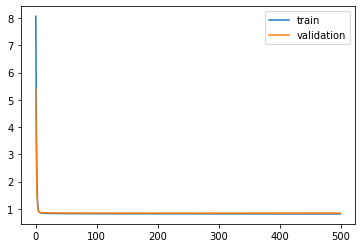

Time to train LSTM:  277.08905482292175
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 7.8814 - pdc_loss: 0.6781 - event_loss: 0.6107 - val_loss: 5.2677 - val_pdc_loss: 0.6299 - val_event_loss: 0.4961

Epoch 00001: val_loss improved from inf to 5.26768, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 3.7788 - pdc_loss: 0.6019 - event_loss: 0.4111 - val_loss: 2.5530 - val_pdc_loss: 0.5828 - val_event_loss: 0.3323

Epoch 00002: val_loss improved from 5.26768 to 2.55298, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 1.9389 - pdc_loss: 0.5709 - event_loss: 0.3166 - val_loss: 1.4620 - val_pdc_loss: 0.5627 - val_event_loss: 0.3060

Epoch 00003: val_loss improved from 2.55298 to 1.46200, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 1.2358 - pdc_loss: 0.5578 - event_loss: 0.3047 - val_loss: 1.0615 - val_pdc_loss: 0.5544 - val_event_loss: 0.3023

Epoch 00004: val_loss improved from 1.46200 to 1.06149, saving 


Epoch 00035: val_loss improved from 0.83404 to 0.83380, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.8332 - pdc_loss: 0.5220 - event_loss: 0.2980 - val_loss: 0.8342 - val_pdc_loss: 0.5216 - val_event_loss: 0.2992

Epoch 00036: val_loss did not improve from 0.83380
Epoch 37/500
 - 1s - loss: 0.8329 - pdc_loss: 0.5219 - event_loss: 0.2979 - val_loss: 0.8339 - val_pdc_loss: 0.5212 - val_event_loss: 0.2993

Epoch 00037: val_loss did not improve from 0.83380
Epoch 38/500
 - 1s - loss: 0.8327 - pdc_loss: 0.5217 - event_loss: 0.2979 - val_loss: 0.8335 - val_pdc_loss: 0.5210 - val_event_loss: 0.2993

Epoch 00038: val_loss improved from 0.83380 to 0.83354, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 0.8325 - pdc_loss: 0.5216 - event_loss: 0.2978 - val_loss: 0.8335 - val_pdc_loss: 0.5210 - val_event_loss: 0.2992

Epoch 00039: val_loss improved from 0.83354 to 0.83345, saving model to Event_val_weights5.hdf5
Epoch 40/500
 - 1s - loss: 0.8323 - pdc_l

 - 1s - loss: 0.8283 - pdc_loss: 0.5188 - event_loss: 0.2969 - val_loss: 0.8304 - val_pdc_loss: 0.5192 - val_event_loss: 0.2985

Epoch 00073: val_loss did not improve from 0.83031
Epoch 74/500
 - 1s - loss: 0.8282 - pdc_loss: 0.5187 - event_loss: 0.2969 - val_loss: 0.8299 - val_pdc_loss: 0.5190 - val_event_loss: 0.2985

Epoch 00074: val_loss improved from 0.83031 to 0.82995, saving model to Event_val_weights5.hdf5
Epoch 75/500
 - 1s - loss: 0.8280 - pdc_loss: 0.5186 - event_loss: 0.2969 - val_loss: 0.8309 - val_pdc_loss: 0.5196 - val_event_loss: 0.2986

Epoch 00075: val_loss did not improve from 0.82995
Epoch 76/500
 - 1s - loss: 0.8280 - pdc_loss: 0.5186 - event_loss: 0.2969 - val_loss: 0.8307 - val_pdc_loss: 0.5192 - val_event_loss: 0.2990

Epoch 00076: val_loss did not improve from 0.82995
Epoch 77/500
 - 1s - loss: 0.8278 - pdc_loss: 0.5185 - event_loss: 0.2968 - val_loss: 0.8302 - val_pdc_loss: 0.5191 - val_event_loss: 0.2986

Epoch 00077: val_loss did not improve from 0.82995
Epo


Epoch 00113: val_loss did not improve from 0.82828
Epoch 114/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5172 - event_loss: 0.2963 - val_loss: 0.8289 - val_pdc_loss: 0.5184 - val_event_loss: 0.2979

Epoch 00114: val_loss did not improve from 0.82828
Epoch 115/500
 - 1s - loss: 0.8259 - pdc_loss: 0.5172 - event_loss: 0.2962 - val_loss: 0.8295 - val_pdc_loss: 0.5188 - val_event_loss: 0.2982

Epoch 00115: val_loss did not improve from 0.82828
Epoch 116/500
 - 1s - loss: 0.8260 - pdc_loss: 0.5171 - event_loss: 0.2963 - val_loss: 0.8291 - val_pdc_loss: 0.5187 - val_event_loss: 0.2978

Epoch 00116: val_loss did not improve from 0.82828
Epoch 117/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5171 - event_loss: 0.2963 - val_loss: 0.8293 - val_pdc_loss: 0.5186 - val_event_loss: 0.2981

Epoch 00117: val_loss did not improve from 0.82828
Epoch 118/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5172 - event_loss: 0.2963 - val_loss: 0.8292 - val_pdc_loss: 0.5187 - val_event_loss: 0.2978

Epoch 00118: val_loss did not

 - 1s - loss: 0.8248 - pdc_loss: 0.5164 - event_loss: 0.2957 - val_loss: 0.8297 - val_pdc_loss: 0.5186 - val_event_loss: 0.2985

Epoch 00156: val_loss did not improve from 0.82828
Epoch 157/500
 - 1s - loss: 0.8247 - pdc_loss: 0.5164 - event_loss: 0.2957 - val_loss: 0.8300 - val_pdc_loss: 0.5188 - val_event_loss: 0.2985

Epoch 00157: val_loss did not improve from 0.82828
Epoch 158/500
 - 1s - loss: 0.8247 - pdc_loss: 0.5164 - event_loss: 0.2956 - val_loss: 0.8295 - val_pdc_loss: 0.5184 - val_event_loss: 0.2985

Epoch 00158: val_loss did not improve from 0.82828
Epoch 159/500
 - 1s - loss: 0.8248 - pdc_loss: 0.5163 - event_loss: 0.2957 - val_loss: 0.8301 - val_pdc_loss: 0.5188 - val_event_loss: 0.2986

Epoch 00159: val_loss did not improve from 0.82828
Epoch 160/500
 - 1s - loss: 0.8246 - pdc_loss: 0.5163 - event_loss: 0.2956 - val_loss: 0.8295 - val_pdc_loss: 0.5184 - val_event_loss: 0.2984

Epoch 00160: val_loss did not improve from 0.82828
Epoch 161/500
 - 1s - loss: 0.8246 - pdc_los


Epoch 00198: val_loss did not improve from 0.82828
Epoch 199/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5156 - event_loss: 0.2953 - val_loss: 0.8302 - val_pdc_loss: 0.5181 - val_event_loss: 0.2992

Epoch 00199: val_loss did not improve from 0.82828
Epoch 200/500
 - 1s - loss: 0.8240 - pdc_loss: 0.5158 - event_loss: 0.2953 - val_loss: 0.8297 - val_pdc_loss: 0.5177 - val_event_loss: 0.2989

Epoch 00200: val_loss did not improve from 0.82828
Epoch 201/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5156 - event_loss: 0.2952 - val_loss: 0.8307 - val_pdc_loss: 0.5183 - val_event_loss: 0.2994

Epoch 00201: val_loss did not improve from 0.82828
Epoch 202/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5157 - event_loss: 0.2952 - val_loss: 0.8295 - val_pdc_loss: 0.5174 - val_event_loss: 0.2991

Epoch 00202: val_loss did not improve from 0.82828
Epoch 203/500
 - 1s - loss: 0.8236 - pdc_loss: 0.5155 - event_loss: 0.2952 - val_loss: 0.8303 - val_pdc_loss: 0.5182 - val_event_loss: 0.2992

Epoch 00203: val_loss did not

 - 1s - loss: 0.8229 - pdc_loss: 0.5148 - event_loss: 0.2952 - val_loss: 0.8294 - val_pdc_loss: 0.5184 - val_event_loss: 0.2981

Epoch 00241: val_loss did not improve from 0.82828
Epoch 242/500
 - 1s - loss: 0.8230 - pdc_loss: 0.5150 - event_loss: 0.2951 - val_loss: 0.8290 - val_pdc_loss: 0.5180 - val_event_loss: 0.2981

Epoch 00242: val_loss did not improve from 0.82828
Epoch 243/500
 - 1s - loss: 0.8233 - pdc_loss: 0.5152 - event_loss: 0.2951 - val_loss: 0.8294 - val_pdc_loss: 0.5183 - val_event_loss: 0.2981

Epoch 00243: val_loss did not improve from 0.82828
Epoch 244/500
 - 1s - loss: 0.8230 - pdc_loss: 0.5151 - event_loss: 0.2949 - val_loss: 0.8288 - val_pdc_loss: 0.5173 - val_event_loss: 0.2985

Epoch 00244: val_loss did not improve from 0.82828
Epoch 245/500
 - 1s - loss: 0.8230 - pdc_loss: 0.5150 - event_loss: 0.2951 - val_loss: 0.8304 - val_pdc_loss: 0.5189 - val_event_loss: 0.2986

Epoch 00245: val_loss did not improve from 0.82828
Epoch 246/500
 - 1s - loss: 0.8228 - pdc_los

 - 1s - loss: 0.8219 - pdc_loss: 0.5142 - event_loss: 0.2948 - val_loss: 0.8291 - val_pdc_loss: 0.5177 - val_event_loss: 0.2984

Epoch 00283: val_loss did not improve from 0.82813
Epoch 284/500
 - 1s - loss: 0.8222 - pdc_loss: 0.5144 - event_loss: 0.2948 - val_loss: 0.8294 - val_pdc_loss: 0.5177 - val_event_loss: 0.2985

Epoch 00284: val_loss did not improve from 0.82813
Epoch 285/500
 - 1s - loss: 0.8223 - pdc_loss: 0.5143 - event_loss: 0.2948 - val_loss: 0.8304 - val_pdc_loss: 0.5188 - val_event_loss: 0.2985

Epoch 00285: val_loss did not improve from 0.82813
Epoch 286/500
 - 1s - loss: 0.8228 - pdc_loss: 0.5145 - event_loss: 0.2950 - val_loss: 0.8288 - val_pdc_loss: 0.5171 - val_event_loss: 0.2985

Epoch 00286: val_loss did not improve from 0.82813
Epoch 287/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5144 - event_loss: 0.2948 - val_loss: 0.8291 - val_pdc_loss: 0.5179 - val_event_loss: 0.2981

Epoch 00287: val_loss did not improve from 0.82813
Epoch 288/500
 - 1s - loss: 0.8222 - pdc_los


Epoch 00325: val_loss did not improve from 0.82813
Epoch 326/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5139 - event_loss: 0.2948 - val_loss: 0.8288 - val_pdc_loss: 0.5177 - val_event_loss: 0.2980

Epoch 00326: val_loss did not improve from 0.82813
Epoch 327/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5139 - event_loss: 0.2948 - val_loss: 0.8285 - val_pdc_loss: 0.5178 - val_event_loss: 0.2977

Epoch 00327: val_loss did not improve from 0.82813
Epoch 328/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5138 - event_loss: 0.2948 - val_loss: 0.8290 - val_pdc_loss: 0.5174 - val_event_loss: 0.2985

Epoch 00328: val_loss did not improve from 0.82813
Epoch 329/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5138 - event_loss: 0.2948 - val_loss: 0.8291 - val_pdc_loss: 0.5181 - val_event_loss: 0.2979

Epoch 00329: val_loss did not improve from 0.82813
Epoch 330/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5139 - event_loss: 0.2946 - val_loss: 0.8292 - val_pdc_loss: 0.5183 - val_event_loss: 0.2978

Epoch 00330: val_loss did not

 - 1s - loss: 0.8214 - pdc_loss: 0.5133 - event_loss: 0.2948 - val_loss: 0.8306 - val_pdc_loss: 0.5188 - val_event_loss: 0.2983

Epoch 00368: val_loss did not improve from 0.82813
Epoch 369/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5135 - event_loss: 0.2948 - val_loss: 0.8303 - val_pdc_loss: 0.5184 - val_event_loss: 0.2984

Epoch 00369: val_loss did not improve from 0.82813
Epoch 370/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5134 - event_loss: 0.2947 - val_loss: 0.8310 - val_pdc_loss: 0.5187 - val_event_loss: 0.2986

Epoch 00370: val_loss did not improve from 0.82813
Epoch 371/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5134 - event_loss: 0.2948 - val_loss: 0.8306 - val_pdc_loss: 0.5186 - val_event_loss: 0.2985

Epoch 00371: val_loss did not improve from 0.82813
Epoch 372/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5133 - event_loss: 0.2948 - val_loss: 0.8305 - val_pdc_loss: 0.5186 - val_event_loss: 0.2983

Epoch 00372: val_loss did not improve from 0.82813
Epoch 373/500
 - 1s - loss: 0.8217 - pdc_los


Epoch 00410: val_loss did not improve from 0.82813
Epoch 411/500
 - 1s - loss: 0.8208 - pdc_loss: 0.5128 - event_loss: 0.2945 - val_loss: 0.8303 - val_pdc_loss: 0.5174 - val_event_loss: 0.2993

Epoch 00411: val_loss did not improve from 0.82813
Epoch 412/500
 - 1s - loss: 0.8211 - pdc_loss: 0.5128 - event_loss: 0.2946 - val_loss: 0.8313 - val_pdc_loss: 0.5183 - val_event_loss: 0.2993

Epoch 00412: val_loss did not improve from 0.82813
Epoch 413/500
 - 1s - loss: 0.8206 - pdc_loss: 0.5126 - event_loss: 0.2945 - val_loss: 0.8319 - val_pdc_loss: 0.5186 - val_event_loss: 0.2998

Epoch 00413: val_loss did not improve from 0.82813
Epoch 414/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5129 - event_loss: 0.2947 - val_loss: 0.8316 - val_pdc_loss: 0.5184 - val_event_loss: 0.2995

Epoch 00414: val_loss did not improve from 0.82813
Epoch 415/500
 - 1s - loss: 0.8206 - pdc_loss: 0.5126 - event_loss: 0.2944 - val_loss: 0.8317 - val_pdc_loss: 0.5187 - val_event_loss: 0.2993

Epoch 00415: val_loss did not

 - 1s - loss: 0.8207 - pdc_loss: 0.5123 - event_loss: 0.2944 - val_loss: 0.8312 - val_pdc_loss: 0.5182 - val_event_loss: 0.2991

Epoch 00453: val_loss did not improve from 0.82813
Epoch 454/500
 - 1s - loss: 0.8206 - pdc_loss: 0.5123 - event_loss: 0.2944 - val_loss: 0.8307 - val_pdc_loss: 0.5175 - val_event_loss: 0.2992

Epoch 00454: val_loss did not improve from 0.82813
Epoch 455/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5124 - event_loss: 0.2945 - val_loss: 0.8313 - val_pdc_loss: 0.5182 - val_event_loss: 0.2990

Epoch 00455: val_loss did not improve from 0.82813
Epoch 456/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5119 - event_loss: 0.2941 - val_loss: 0.8308 - val_pdc_loss: 0.5185 - val_event_loss: 0.2986

Epoch 00456: val_loss did not improve from 0.82813
Epoch 457/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5118 - event_loss: 0.2943 - val_loss: 0.8303 - val_pdc_loss: 0.5178 - val_event_loss: 0.2989

Epoch 00457: val_loss did not improve from 0.82813
Epoch 458/500
 - 1s - loss: 0.8199 - pdc_los


Epoch 00495: val_loss did not improve from 0.82813
Epoch 496/500
 - 1s - loss: 0.8207 - pdc_loss: 0.5123 - event_loss: 0.2941 - val_loss: 0.8322 - val_pdc_loss: 0.5182 - val_event_loss: 0.2997

Epoch 00496: val_loss did not improve from 0.82813
Epoch 497/500
 - 1s - loss: 0.8196 - pdc_loss: 0.5116 - event_loss: 0.2938 - val_loss: 0.8327 - val_pdc_loss: 0.5186 - val_event_loss: 0.3001

Epoch 00497: val_loss did not improve from 0.82813
Epoch 498/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5117 - event_loss: 0.2937 - val_loss: 0.8312 - val_pdc_loss: 0.5176 - val_event_loss: 0.2996

Epoch 00498: val_loss did not improve from 0.82813
Epoch 499/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5120 - event_loss: 0.2939 - val_loss: 0.8330 - val_pdc_loss: 0.5188 - val_event_loss: 0.3003

Epoch 00499: val_loss did not improve from 0.82813
Epoch 500/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5120 - event_loss: 0.2939 - val_loss: 0.8319 - val_pdc_loss: 0.5183 - val_event_loss: 0.2995

Epoch 00500: val_loss did not

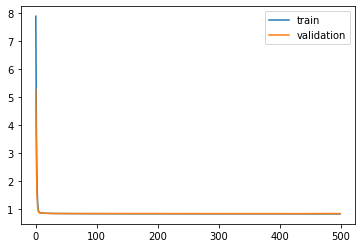

Time to train LSTM:  277.65004444122314
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 2s - loss: 9.2611 - pdc_loss: 0.6592 - event_loss: 0.6824 - val_loss: 7.5986 - val_pdc_loss: 0.6426 - val_event_loss: 0.6104

Epoch 00001: val_loss improved from inf to 7.59857, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 6.4235 - pdc_loss: 0.6292 - event_loss: 0.5573 - val_loss: 5.2373 - val_pdc_loss: 0.6173 - val_event_loss: 0.4873

Epoch 00002: val_loss improved from 7.59857 to 5.23726, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 4.4224 - pdc_loss: 0.6052 - event_loss: 0.4397 - val_loss: 3.6074 - val_pdc_loss: 0.5959 - val_event_loss: 0.3803

Epoch 00003: val_loss improved from 5.23726 to 3.60745, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 3.0676 - pdc_loss: 0.5847 - event_loss: 0.3558 - val_loss: 2.5342 - val_pdc_loss: 0.5790 - val_event_loss: 0.3222

Epoch 00004: val_loss improved from 3.60745 to 2.53417, saving 


Epoch 00035: val_loss did not improve from 0.82533
Epoch 36/500
 - 1s - loss: 0.8308 - pdc_loss: 0.5216 - event_loss: 0.2974 - val_loss: 0.8250 - val_pdc_loss: 0.5215 - val_event_loss: 0.2917

Epoch 00036: val_loss improved from 0.82533 to 0.82499, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 0.8303 - pdc_loss: 0.5213 - event_loss: 0.2973 - val_loss: 0.8248 - val_pdc_loss: 0.5212 - val_event_loss: 0.2919

Epoch 00037: val_loss improved from 0.82499 to 0.82480, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 0.8299 - pdc_loss: 0.5210 - event_loss: 0.2972 - val_loss: 0.8244 - val_pdc_loss: 0.5211 - val_event_loss: 0.2916

Epoch 00038: val_loss improved from 0.82480 to 0.82437, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 0.8295 - pdc_loss: 0.5208 - event_loss: 0.2971 - val_loss: 0.8245 - val_pdc_loss: 0.5210 - val_event_loss: 0.2919

Epoch 00039: val_loss did not improve from 0.82437
Epoch 40/500
 - 1s - loss: 0.8292 - pdc_l


Epoch 00075: val_loss did not improve from 0.82191
Epoch 76/500
 - 1s - loss: 0.8227 - pdc_loss: 0.5163 - event_loss: 0.2957 - val_loss: 0.8222 - val_pdc_loss: 0.5201 - val_event_loss: 0.2915

Epoch 00076: val_loss did not improve from 0.82191
Epoch 77/500
 - 1s - loss: 0.8226 - pdc_loss: 0.5162 - event_loss: 0.2957 - val_loss: 0.8220 - val_pdc_loss: 0.5202 - val_event_loss: 0.2912

Epoch 00077: val_loss did not improve from 0.82191
Epoch 78/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5161 - event_loss: 0.2957 - val_loss: 0.8220 - val_pdc_loss: 0.5199 - val_event_loss: 0.2915

Epoch 00078: val_loss did not improve from 0.82191
Epoch 79/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5161 - event_loss: 0.2957 - val_loss: 0.8223 - val_pdc_loss: 0.5202 - val_event_loss: 0.2916

Epoch 00079: val_loss did not improve from 0.82191
Epoch 80/500
 - 1s - loss: 0.8222 - pdc_loss: 0.5159 - event_loss: 0.2956 - val_loss: 0.8218 - val_pdc_loss: 0.5198 - val_event_loss: 0.2915

Epoch 00080: val_loss improved fro


Epoch 00116: val_loss did not improve from 0.82146
Epoch 117/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5140 - event_loss: 0.2950 - val_loss: 0.8219 - val_pdc_loss: 0.5197 - val_event_loss: 0.2919

Epoch 00117: val_loss did not improve from 0.82146
Epoch 118/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5140 - event_loss: 0.2949 - val_loss: 0.8221 - val_pdc_loss: 0.5197 - val_event_loss: 0.2921

Epoch 00118: val_loss did not improve from 0.82146
Epoch 119/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5139 - event_loss: 0.2949 - val_loss: 0.8219 - val_pdc_loss: 0.5198 - val_event_loss: 0.2917

Epoch 00119: val_loss did not improve from 0.82146
Epoch 120/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5139 - event_loss: 0.2950 - val_loss: 0.8219 - val_pdc_loss: 0.5194 - val_event_loss: 0.2921

Epoch 00120: val_loss did not improve from 0.82146
Epoch 121/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5138 - event_loss: 0.2949 - val_loss: 0.8222 - val_pdc_loss: 0.5198 - val_event_loss: 0.2920

Epoch 00121: val_loss did not


Epoch 00158: val_loss did not improve from 0.82092
Epoch 159/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5126 - event_loss: 0.2945 - val_loss: 0.8214 - val_pdc_loss: 0.5198 - val_event_loss: 0.2912

Epoch 00159: val_loss did not improve from 0.82092
Epoch 160/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5128 - event_loss: 0.2946 - val_loss: 0.8204 - val_pdc_loss: 0.5190 - val_event_loss: 0.2911

Epoch 00160: val_loss improved from 0.82092 to 0.82045, saving model to Event_val_weights1.hdf5
Epoch 161/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5126 - event_loss: 0.2945 - val_loss: 0.8212 - val_pdc_loss: 0.5197 - val_event_loss: 0.2911

Epoch 00161: val_loss did not improve from 0.82045
Epoch 162/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5128 - event_loss: 0.2945 - val_loss: 0.8212 - val_pdc_loss: 0.5190 - val_event_loss: 0.2918

Epoch 00162: val_loss did not improve from 0.82045
Epoch 163/500
 - 1s - loss: 0.8174 - pdc_loss: 0.5125 - event_loss: 0.2945 - val_loss: 0.8211 - val_pdc_loss: 0.5196 - val_even


Epoch 00200: val_loss did not improve from 0.82045
Epoch 201/500
 - 1s - loss: 0.8159 - pdc_loss: 0.5112 - event_loss: 0.2942 - val_loss: 0.8223 - val_pdc_loss: 0.5204 - val_event_loss: 0.2914

Epoch 00201: val_loss did not improve from 0.82045
Epoch 202/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5113 - event_loss: 0.2942 - val_loss: 0.8219 - val_pdc_loss: 0.5201 - val_event_loss: 0.2913

Epoch 00202: val_loss did not improve from 0.82045
Epoch 203/500
 - 1s - loss: 0.8157 - pdc_loss: 0.5110 - event_loss: 0.2942 - val_loss: 0.8217 - val_pdc_loss: 0.5201 - val_event_loss: 0.2910

Epoch 00203: val_loss did not improve from 0.82045
Epoch 204/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5113 - event_loss: 0.2942 - val_loss: 0.8222 - val_pdc_loss: 0.5204 - val_event_loss: 0.2913

Epoch 00204: val_loss did not improve from 0.82045
Epoch 205/500
 - 1s - loss: 0.8157 - pdc_loss: 0.5112 - event_loss: 0.2940 - val_loss: 0.8222 - val_pdc_loss: 0.5202 - val_event_loss: 0.2914

Epoch 00205: val_loss did not

 - 1s - loss: 0.8146 - pdc_loss: 0.5100 - event_loss: 0.2937 - val_loss: 0.8247 - val_pdc_loss: 0.5207 - val_event_loss: 0.2930

Epoch 00243: val_loss did not improve from 0.82045
Epoch 244/500
 - 1s - loss: 0.8147 - pdc_loss: 0.5100 - event_loss: 0.2937 - val_loss: 0.8241 - val_pdc_loss: 0.5202 - val_event_loss: 0.2929

Epoch 00244: val_loss did not improve from 0.82045
Epoch 245/500
 - 1s - loss: 0.8148 - pdc_loss: 0.5100 - event_loss: 0.2938 - val_loss: 0.8240 - val_pdc_loss: 0.5201 - val_event_loss: 0.2930

Epoch 00245: val_loss did not improve from 0.82045
Epoch 246/500
 - 1s - loss: 0.8149 - pdc_loss: 0.5101 - event_loss: 0.2939 - val_loss: 0.8238 - val_pdc_loss: 0.5199 - val_event_loss: 0.2930

Epoch 00246: val_loss did not improve from 0.82045
Epoch 247/500
 - 1s - loss: 0.8149 - pdc_loss: 0.5101 - event_loss: 0.2939 - val_loss: 0.8241 - val_pdc_loss: 0.5203 - val_event_loss: 0.2928

Epoch 00247: val_loss did not improve from 0.82045
Epoch 248/500
 - 1s - loss: 0.8145 - pdc_los


Epoch 00285: val_loss did not improve from 0.82045
Epoch 286/500
 - 1s - loss: 0.8143 - pdc_loss: 0.5094 - event_loss: 0.2936 - val_loss: 0.8254 - val_pdc_loss: 0.5213 - val_event_loss: 0.2929

Epoch 00286: val_loss did not improve from 0.82045
Epoch 287/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5089 - event_loss: 0.2935 - val_loss: 0.8246 - val_pdc_loss: 0.5205 - val_event_loss: 0.2929

Epoch 00287: val_loss did not improve from 0.82045
Epoch 288/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5084 - event_loss: 0.2932 - val_loss: 0.8243 - val_pdc_loss: 0.5203 - val_event_loss: 0.2930

Epoch 00288: val_loss did not improve from 0.82045
Epoch 289/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5086 - event_loss: 0.2932 - val_loss: 0.8229 - val_pdc_loss: 0.5194 - val_event_loss: 0.2924

Epoch 00289: val_loss did not improve from 0.82045
Epoch 290/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5086 - event_loss: 0.2931 - val_loss: 0.8228 - val_pdc_loss: 0.5191 - val_event_loss: 0.2925

Epoch 00290: val_loss did not

 - 1s - loss: 0.8130 - pdc_loss: 0.5084 - event_loss: 0.2932 - val_loss: 0.8251 - val_pdc_loss: 0.5207 - val_event_loss: 0.2929

Epoch 00328: val_loss did not improve from 0.82045
Epoch 329/500
 - 1s - loss: 0.8123 - pdc_loss: 0.5079 - event_loss: 0.2931 - val_loss: 0.8245 - val_pdc_loss: 0.5210 - val_event_loss: 0.2922

Epoch 00329: val_loss did not improve from 0.82045
Epoch 330/500
 - 1s - loss: 0.8122 - pdc_loss: 0.5079 - event_loss: 0.2929 - val_loss: 0.8240 - val_pdc_loss: 0.5207 - val_event_loss: 0.2919

Epoch 00330: val_loss did not improve from 0.82045
Epoch 331/500
 - 1s - loss: 0.8121 - pdc_loss: 0.5075 - event_loss: 0.2931 - val_loss: 0.8243 - val_pdc_loss: 0.5207 - val_event_loss: 0.2922

Epoch 00331: val_loss did not improve from 0.82045
Epoch 332/500
 - 1s - loss: 0.8121 - pdc_loss: 0.5077 - event_loss: 0.2930 - val_loss: 0.8243 - val_pdc_loss: 0.5204 - val_event_loss: 0.2926

Epoch 00332: val_loss did not improve from 0.82045
Epoch 333/500
 - 1s - loss: 0.8121 - pdc_los


Epoch 00370: val_loss did not improve from 0.82045
Epoch 371/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5086 - event_loss: 0.2930 - val_loss: 0.8278 - val_pdc_loss: 0.5222 - val_event_loss: 0.2935

Epoch 00371: val_loss did not improve from 0.82045
Epoch 372/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5084 - event_loss: 0.2927 - val_loss: 0.8278 - val_pdc_loss: 0.5226 - val_event_loss: 0.2931

Epoch 00372: val_loss did not improve from 0.82045
Epoch 373/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5083 - event_loss: 0.2928 - val_loss: 0.8264 - val_pdc_loss: 0.5222 - val_event_loss: 0.2922

Epoch 00373: val_loss did not improve from 0.82045
Epoch 374/500
 - 1s - loss: 0.8124 - pdc_loss: 0.5078 - event_loss: 0.2928 - val_loss: 0.8262 - val_pdc_loss: 0.5224 - val_event_loss: 0.2920

Epoch 00374: val_loss did not improve from 0.82045
Epoch 375/500
 - 1s - loss: 0.8123 - pdc_loss: 0.5075 - event_loss: 0.2929 - val_loss: 0.8264 - val_pdc_loss: 0.5218 - val_event_loss: 0.2925

Epoch 00375: val_loss did not

 - 1s - loss: 0.8107 - pdc_loss: 0.5065 - event_loss: 0.2923 - val_loss: 0.8267 - val_pdc_loss: 0.5218 - val_event_loss: 0.2930

Epoch 00413: val_loss did not improve from 0.82045
Epoch 414/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5064 - event_loss: 0.2921 - val_loss: 0.8258 - val_pdc_loss: 0.5214 - val_event_loss: 0.2927

Epoch 00414: val_loss did not improve from 0.82045
Epoch 415/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5064 - event_loss: 0.2923 - val_loss: 0.8262 - val_pdc_loss: 0.5213 - val_event_loss: 0.2930

Epoch 00415: val_loss did not improve from 0.82045
Epoch 416/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5064 - event_loss: 0.2919 - val_loss: 0.8279 - val_pdc_loss: 0.5225 - val_event_loss: 0.2935

Epoch 00416: val_loss did not improve from 0.82045
Epoch 417/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5066 - event_loss: 0.2920 - val_loss: 0.8268 - val_pdc_loss: 0.5216 - val_event_loss: 0.2933

Epoch 00417: val_loss did not improve from 0.82045
Epoch 418/500
 - 1s - loss: 0.8104 - pdc_los


Epoch 00455: val_loss did not improve from 0.82045
Epoch 456/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5059 - event_loss: 0.2915 - val_loss: 0.8280 - val_pdc_loss: 0.5229 - val_event_loss: 0.2928

Epoch 00456: val_loss did not improve from 0.82045
Epoch 457/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5058 - event_loss: 0.2916 - val_loss: 0.8291 - val_pdc_loss: 0.5227 - val_event_loss: 0.2942

Epoch 00457: val_loss did not improve from 0.82045
Epoch 458/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5058 - event_loss: 0.2914 - val_loss: 0.8303 - val_pdc_loss: 0.5234 - val_event_loss: 0.2948

Epoch 00458: val_loss did not improve from 0.82045
Epoch 459/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5058 - event_loss: 0.2919 - val_loss: 0.8298 - val_pdc_loss: 0.5238 - val_event_loss: 0.2939

Epoch 00459: val_loss did not improve from 0.82045
Epoch 460/500
 - 1s - loss: 0.8099 - pdc_loss: 0.5059 - event_loss: 0.2918 - val_loss: 0.8294 - val_pdc_loss: 0.5233 - val_event_loss: 0.2940

Epoch 00460: val_loss did not

 - 1s - loss: 0.8090 - pdc_loss: 0.5053 - event_loss: 0.2915 - val_loss: 0.8290 - val_pdc_loss: 0.5223 - val_event_loss: 0.2945

Epoch 00498: val_loss did not improve from 0.82045
Epoch 499/500
 - 1s - loss: 0.8092 - pdc_loss: 0.5055 - event_loss: 0.2915 - val_loss: 0.8300 - val_pdc_loss: 0.5226 - val_event_loss: 0.2951

Epoch 00499: val_loss did not improve from 0.82045
Epoch 500/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5053 - event_loss: 0.2915 - val_loss: 0.8285 - val_pdc_loss: 0.5217 - val_event_loss: 0.2945

Epoch 00500: val_loss did not improve from 0.82045
#################################
Number of units: 16
Batch size: 4096
Fold: 0
best val loss: 0.820447082095676
#################################


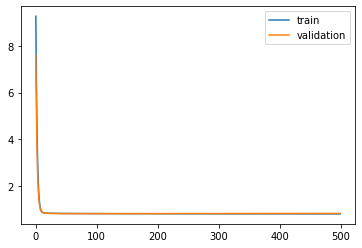

Time to train LSTM:  306.32895016670227


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0949b4a358>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 3s - loss: 9.4004 - pdc_loss: 0.7407 - event_loss: 0.6558 - val_loss: 7.7283 - val_pdc_loss: 0.6912 - val_event_loss: 0.5996

Epoch 00001: val_loss improved from inf to 7.72828, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 6.5297 - pdc_loss: 0.6561 - event_loss: 0.5501 - val_loss: 5.3561 - val_pdc_loss: 0.6382 - val_event_loss: 0.5076

Epoch 00002: val_loss improved from 7.72828 to 5.35615, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 4.5225 - pdc_loss: 0.6160 - event_loss: 0.4596 - val_loss: 3.7192 - val_pdc_loss: 0.6072 - val_event_loss: 0.4194

Epoch 00003: val_loss improved from 5.35615 to 3.71922, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 3.1504 - pdc_loss: 0.5912 - event_loss: 0.3770 - val_loss: 2.6180 - val_pdc_loss: 0.5884 - val_event_loss: 0.3489

Epoch 00004: val_loss improved from 3.71922 to 2.61804, saving model to Event_val_weights2.hdf5
Epoch 5


Epoch 00035: val_loss improved from 0.84290 to 0.84283, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 0.8292 - pdc_loss: 0.5204 - event_loss: 0.2970 - val_loss: 0.8423 - val_pdc_loss: 0.5276 - val_event_loss: 0.3030

Epoch 00036: val_loss improved from 0.84283 to 0.84234, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 0.8288 - pdc_loss: 0.5201 - event_loss: 0.2970 - val_loss: 0.8424 - val_pdc_loss: 0.5277 - val_event_loss: 0.3031

Epoch 00037: val_loss did not improve from 0.84234
Epoch 38/500
 - 1s - loss: 0.8284 - pdc_loss: 0.5199 - event_loss: 0.2969 - val_loss: 0.8420 - val_pdc_loss: 0.5274 - val_event_loss: 0.3030

Epoch 00038: val_loss improved from 0.84234 to 0.84199, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 0.8281 - pdc_loss: 0.5196 - event_loss: 0.2968 - val_loss: 0.8420 - val_pdc_loss: 0.5275 - val_event_loss: 0.3029

Epoch 00039: val_loss improved from 0.84199 to 0.84195, saving model to Event_val_weights2.h

 - 1s - loss: 0.8208 - pdc_loss: 0.5153 - event_loss: 0.2947 - val_loss: 0.8381 - val_pdc_loss: 0.5250 - val_event_loss: 0.3024

Epoch 00073: val_loss did not improve from 0.83782
Epoch 74/500
 - 1s - loss: 0.8206 - pdc_loss: 0.5152 - event_loss: 0.2947 - val_loss: 0.8379 - val_pdc_loss: 0.5249 - val_event_loss: 0.3023

Epoch 00074: val_loss did not improve from 0.83782
Epoch 75/500
 - 1s - loss: 0.8205 - pdc_loss: 0.5152 - event_loss: 0.2946 - val_loss: 0.8379 - val_pdc_loss: 0.5249 - val_event_loss: 0.3023

Epoch 00075: val_loss did not improve from 0.83782
Epoch 76/500
 - 1s - loss: 0.8204 - pdc_loss: 0.5151 - event_loss: 0.2946 - val_loss: 0.8378 - val_pdc_loss: 0.5248 - val_event_loss: 0.3023

Epoch 00076: val_loss improved from 0.83782 to 0.83781, saving model to Event_val_weights2.hdf5
Epoch 77/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5150 - event_loss: 0.2946 - val_loss: 0.8379 - val_pdc_loss: 0.5249 - val_event_loss: 0.3023

Epoch 00077: val_loss did not improve from 0.83781
Epo


Epoch 00113: val_loss did not improve from 0.83687
Epoch 114/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5123 - event_loss: 0.2937 - val_loss: 0.8373 - val_pdc_loss: 0.5239 - val_event_loss: 0.3024

Epoch 00114: val_loss did not improve from 0.83687
Epoch 115/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5122 - event_loss: 0.2937 - val_loss: 0.8378 - val_pdc_loss: 0.5241 - val_event_loss: 0.3026

Epoch 00115: val_loss did not improve from 0.83687
Epoch 116/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5121 - event_loss: 0.2937 - val_loss: 0.8376 - val_pdc_loss: 0.5239 - val_event_loss: 0.3026

Epoch 00116: val_loss did not improve from 0.83687
Epoch 117/500
 - 1s - loss: 0.8168 - pdc_loss: 0.5121 - event_loss: 0.2936 - val_loss: 0.8374 - val_pdc_loss: 0.5237 - val_event_loss: 0.3026

Epoch 00117: val_loss did not improve from 0.83687
Epoch 118/500
 - 1s - loss: 0.8168 - pdc_loss: 0.5120 - event_loss: 0.2936 - val_loss: 0.8377 - val_pdc_loss: 0.5240 - val_event_loss: 0.3026

Epoch 00118: val_loss did not

 - 1s - loss: 0.8148 - pdc_loss: 0.5104 - event_loss: 0.2929 - val_loss: 0.8401 - val_pdc_loss: 0.5256 - val_event_loss: 0.3030

Epoch 00156: val_loss did not improve from 0.83687
Epoch 157/500
 - 1s - loss: 0.8145 - pdc_loss: 0.5102 - event_loss: 0.2928 - val_loss: 0.8418 - val_pdc_loss: 0.5270 - val_event_loss: 0.3033

Epoch 00157: val_loss did not improve from 0.83687
Epoch 158/500
 - 1s - loss: 0.8145 - pdc_loss: 0.5103 - event_loss: 0.2928 - val_loss: 0.8405 - val_pdc_loss: 0.5259 - val_event_loss: 0.3031

Epoch 00158: val_loss did not improve from 0.83687
Epoch 159/500
 - 1s - loss: 0.8143 - pdc_loss: 0.5101 - event_loss: 0.2928 - val_loss: 0.8408 - val_pdc_loss: 0.5262 - val_event_loss: 0.3031

Epoch 00159: val_loss did not improve from 0.83687
Epoch 160/500
 - 1s - loss: 0.8144 - pdc_loss: 0.5101 - event_loss: 0.2929 - val_loss: 0.8417 - val_pdc_loss: 0.5271 - val_event_loss: 0.3031

Epoch 00160: val_loss did not improve from 0.83687
Epoch 161/500
 - 1s - loss: 0.8144 - pdc_los


Epoch 00198: val_loss did not improve from 0.83687
Epoch 199/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5091 - event_loss: 0.2924 - val_loss: 0.8426 - val_pdc_loss: 0.5281 - val_event_loss: 0.3031

Epoch 00199: val_loss did not improve from 0.83687
Epoch 200/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5090 - event_loss: 0.2924 - val_loss: 0.8426 - val_pdc_loss: 0.5274 - val_event_loss: 0.3036

Epoch 00200: val_loss did not improve from 0.83687
Epoch 201/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5092 - event_loss: 0.2924 - val_loss: 0.8427 - val_pdc_loss: 0.5274 - val_event_loss: 0.3037

Epoch 00201: val_loss did not improve from 0.83687
Epoch 202/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5089 - event_loss: 0.2922 - val_loss: 0.8431 - val_pdc_loss: 0.5279 - val_event_loss: 0.3037

Epoch 00202: val_loss did not improve from 0.83687
Epoch 203/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5090 - event_loss: 0.2924 - val_loss: 0.8434 - val_pdc_loss: 0.5278 - val_event_loss: 0.3040

Epoch 00203: val_loss did not

 - 1s - loss: 0.8122 - pdc_loss: 0.5084 - event_loss: 0.2918 - val_loss: 0.8454 - val_pdc_loss: 0.5290 - val_event_loss: 0.3044

Epoch 00241: val_loss did not improve from 0.83687
Epoch 242/500
 - 1s - loss: 0.8122 - pdc_loss: 0.5083 - event_loss: 0.2920 - val_loss: 0.8451 - val_pdc_loss: 0.5286 - val_event_loss: 0.3046

Epoch 00242: val_loss did not improve from 0.83687
Epoch 243/500
 - 1s - loss: 0.8124 - pdc_loss: 0.5086 - event_loss: 0.2919 - val_loss: 0.8438 - val_pdc_loss: 0.5272 - val_event_loss: 0.3047

Epoch 00243: val_loss did not improve from 0.83687
Epoch 244/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5083 - event_loss: 0.2917 - val_loss: 0.8441 - val_pdc_loss: 0.5281 - val_event_loss: 0.3041

Epoch 00244: val_loss did not improve from 0.83687
Epoch 245/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5083 - event_loss: 0.2917 - val_loss: 0.8443 - val_pdc_loss: 0.5281 - val_event_loss: 0.3044

Epoch 00245: val_loss did not improve from 0.83687
Epoch 246/500
 - 1s - loss: 0.8113 - pdc_los


Epoch 00283: val_loss did not improve from 0.83687
Epoch 284/500
 - 1s - loss: 0.8101 - pdc_loss: 0.5073 - event_loss: 0.2912 - val_loss: 0.8453 - val_pdc_loss: 0.5287 - val_event_loss: 0.3051

Epoch 00284: val_loss did not improve from 0.83687
Epoch 285/500
 - 1s - loss: 0.8099 - pdc_loss: 0.5073 - event_loss: 0.2911 - val_loss: 0.8451 - val_pdc_loss: 0.5289 - val_event_loss: 0.3047

Epoch 00285: val_loss did not improve from 0.83687
Epoch 286/500
 - 1s - loss: 0.8101 - pdc_loss: 0.5074 - event_loss: 0.2911 - val_loss: 0.8451 - val_pdc_loss: 0.5288 - val_event_loss: 0.3047

Epoch 00286: val_loss did not improve from 0.83687
Epoch 287/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5074 - event_loss: 0.2911 - val_loss: 0.8464 - val_pdc_loss: 0.5292 - val_event_loss: 0.3054

Epoch 00287: val_loss did not improve from 0.83687
Epoch 288/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5077 - event_loss: 0.2916 - val_loss: 0.8456 - val_pdc_loss: 0.5282 - val_event_loss: 0.3055

Epoch 00288: val_loss did not

 - 1s - loss: 0.8102 - pdc_loss: 0.5074 - event_loss: 0.2911 - val_loss: 0.8447 - val_pdc_loss: 0.5285 - val_event_loss: 0.3044

Epoch 00326: val_loss did not improve from 0.83687
Epoch 327/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5075 - event_loss: 0.2911 - val_loss: 0.8439 - val_pdc_loss: 0.5272 - val_event_loss: 0.3048

Epoch 00327: val_loss did not improve from 0.83687
Epoch 328/500
 - 1s - loss: 0.8099 - pdc_loss: 0.5074 - event_loss: 0.2907 - val_loss: 0.8441 - val_pdc_loss: 0.5276 - val_event_loss: 0.3048

Epoch 00328: val_loss did not improve from 0.83687
Epoch 329/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5070 - event_loss: 0.2910 - val_loss: 0.8449 - val_pdc_loss: 0.5279 - val_event_loss: 0.3054

Epoch 00329: val_loss did not improve from 0.83687
Epoch 330/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5069 - event_loss: 0.2910 - val_loss: 0.8441 - val_pdc_loss: 0.5279 - val_event_loss: 0.3045

Epoch 00330: val_loss did not improve from 0.83687
Epoch 331/500
 - 1s - loss: 0.8092 - pdc_los


Epoch 00368: val_loss did not improve from 0.83687
Epoch 369/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5064 - event_loss: 0.2903 - val_loss: 0.8468 - val_pdc_loss: 0.5287 - val_event_loss: 0.3061

Epoch 00369: val_loss did not improve from 0.83687
Epoch 370/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5067 - event_loss: 0.2904 - val_loss: 0.8465 - val_pdc_loss: 0.5286 - val_event_loss: 0.3058

Epoch 00370: val_loss did not improve from 0.83687
Epoch 371/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5067 - event_loss: 0.2904 - val_loss: 0.8459 - val_pdc_loss: 0.5279 - val_event_loss: 0.3060

Epoch 00371: val_loss did not improve from 0.83687
Epoch 372/500
 - 1s - loss: 0.8093 - pdc_loss: 0.5068 - event_loss: 0.2904 - val_loss: 0.8471 - val_pdc_loss: 0.5291 - val_event_loss: 0.3058

Epoch 00372: val_loss did not improve from 0.83687
Epoch 373/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5065 - event_loss: 0.2903 - val_loss: 0.8456 - val_pdc_loss: 0.5287 - val_event_loss: 0.3050

Epoch 00373: val_loss did not

 - 1s - loss: 0.8076 - pdc_loss: 0.5060 - event_loss: 0.2897 - val_loss: 0.8481 - val_pdc_loss: 0.5295 - val_event_loss: 0.3066

Epoch 00411: val_loss did not improve from 0.83687
Epoch 412/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5065 - event_loss: 0.2901 - val_loss: 0.8476 - val_pdc_loss: 0.5292 - val_event_loss: 0.3064

Epoch 00412: val_loss did not improve from 0.83687
Epoch 413/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5064 - event_loss: 0.2901 - val_loss: 0.8482 - val_pdc_loss: 0.5294 - val_event_loss: 0.3069

Epoch 00413: val_loss did not improve from 0.83687
Epoch 414/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5062 - event_loss: 0.2899 - val_loss: 0.8480 - val_pdc_loss: 0.5295 - val_event_loss: 0.3067

Epoch 00414: val_loss did not improve from 0.83687
Epoch 415/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5060 - event_loss: 0.2901 - val_loss: 0.8483 - val_pdc_loss: 0.5290 - val_event_loss: 0.3074

Epoch 00415: val_loss did not improve from 0.83687
Epoch 416/500
 - 1s - loss: 0.8077 - pdc_los


Epoch 00453: val_loss did not improve from 0.83687
Epoch 454/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5059 - event_loss: 0.2896 - val_loss: 0.8479 - val_pdc_loss: 0.5298 - val_event_loss: 0.3059

Epoch 00454: val_loss did not improve from 0.83687
Epoch 455/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5053 - event_loss: 0.2898 - val_loss: 0.8482 - val_pdc_loss: 0.5300 - val_event_loss: 0.3060

Epoch 00455: val_loss did not improve from 0.83687
Epoch 456/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5057 - event_loss: 0.2895 - val_loss: 0.8464 - val_pdc_loss: 0.5288 - val_event_loss: 0.3056

Epoch 00456: val_loss did not improve from 0.83687
Epoch 457/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5056 - event_loss: 0.2896 - val_loss: 0.8479 - val_pdc_loss: 0.5296 - val_event_loss: 0.3062

Epoch 00457: val_loss did not improve from 0.83687
Epoch 458/500
 - 1s - loss: 0.8070 - pdc_loss: 0.5052 - event_loss: 0.2897 - val_loss: 0.8459 - val_pdc_loss: 0.5282 - val_event_loss: 0.3056

Epoch 00458: val_loss did not

 - 1s - loss: 0.8072 - pdc_loss: 0.5058 - event_loss: 0.2892 - val_loss: 0.8472 - val_pdc_loss: 0.5290 - val_event_loss: 0.3058

Epoch 00496: val_loss did not improve from 0.83687
Epoch 497/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5059 - event_loss: 0.2894 - val_loss: 0.8474 - val_pdc_loss: 0.5294 - val_event_loss: 0.3058

Epoch 00497: val_loss did not improve from 0.83687
Epoch 498/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5059 - event_loss: 0.2895 - val_loss: 0.8474 - val_pdc_loss: 0.5296 - val_event_loss: 0.3056

Epoch 00498: val_loss did not improve from 0.83687
Epoch 499/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5058 - event_loss: 0.2895 - val_loss: 0.8494 - val_pdc_loss: 0.5305 - val_event_loss: 0.3066

Epoch 00499: val_loss did not improve from 0.83687
Epoch 500/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5059 - event_loss: 0.2896 - val_loss: 0.8492 - val_pdc_loss: 0.5303 - val_event_loss: 0.3067

Epoch 00500: val_loss did not improve from 0.83687
#################################
Number of 

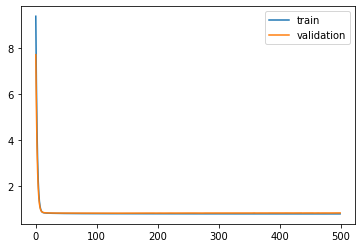

Time to train LSTM:  326.7127923965454
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 2s - loss: 9.2536 - pdc_loss: 0.7094 - event_loss: 0.6260 - val_loss: 7.5987 - val_pdc_loss: 0.6862 - val_event_loss: 0.5606

Epoch 00001: val_loss improved from inf to 7.59874, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 6.4211 - pdc_loss: 0.6668 - event_loss: 0.5100 - val_loss: 5.2474 - val_pdc_loss: 0.6520 - val_event_loss: 0.4571

Epoch 00002: val_loss improved from 7.59874 to 5.24739, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 4.4255 - pdc_loss: 0.6322 - event_loss: 0.4124 - val_loss: 3.6244 - val_pdc_loss: 0.6214 - val_event_loss: 0.3701

Epoch 00003: val_loss improved from 5.24739 to 3.62437, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 3.0747 - pdc_loss: 0.6026 - event_loss: 0.3427 - val_loss: 2.5627 - val_pdc_loss: 0.6018 - val_event_loss: 0.3243

Epoch 00004: val_loss improved from 3.62437 to 2.56273, saving m


Epoch 00035: val_loss did not improve from 0.84757
Epoch 36/500
 - 1s - loss: 0.8297 - pdc_loss: 0.5216 - event_loss: 0.2963 - val_loss: 0.8469 - val_pdc_loss: 0.5352 - val_event_loss: 0.3000

Epoch 00036: val_loss improved from 0.84757 to 0.84687, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 0.8293 - pdc_loss: 0.5212 - event_loss: 0.2962 - val_loss: 0.8470 - val_pdc_loss: 0.5352 - val_event_loss: 0.3001

Epoch 00037: val_loss did not improve from 0.84687
Epoch 38/500
 - 1s - loss: 0.8290 - pdc_loss: 0.5210 - event_loss: 0.2962 - val_loss: 0.8464 - val_pdc_loss: 0.5348 - val_event_loss: 0.2999

Epoch 00038: val_loss improved from 0.84687 to 0.84638, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.8286 - pdc_loss: 0.5207 - event_loss: 0.2961 - val_loss: 0.8462 - val_pdc_loss: 0.5348 - val_event_loss: 0.3000

Epoch 00039: val_loss improved from 0.84638 to 0.84623, saving model to Event_val_weights3.hdf5
Epoch 40/500
 - 1s - loss: 0.8283 - pdc_l


Epoch 00073: val_loss did not improve from 0.84410
Epoch 74/500
 - 1s - loss: 0.8220 - pdc_loss: 0.5160 - event_loss: 0.2949 - val_loss: 0.8445 - val_pdc_loss: 0.5337 - val_event_loss: 0.2999

Epoch 00074: val_loss did not improve from 0.84410
Epoch 75/500
 - 1s - loss: 0.8219 - pdc_loss: 0.5160 - event_loss: 0.2949 - val_loss: 0.8448 - val_pdc_loss: 0.5339 - val_event_loss: 0.3000

Epoch 00075: val_loss did not improve from 0.84410
Epoch 76/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5158 - event_loss: 0.2948 - val_loss: 0.8448 - val_pdc_loss: 0.5339 - val_event_loss: 0.2999

Epoch 00076: val_loss did not improve from 0.84410
Epoch 77/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5159 - event_loss: 0.2948 - val_loss: 0.8448 - val_pdc_loss: 0.5338 - val_event_loss: 0.3000

Epoch 00077: val_loss did not improve from 0.84410
Epoch 78/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5156 - event_loss: 0.2948 - val_loss: 0.8449 - val_pdc_loss: 0.5339 - val_event_loss: 0.3000

Epoch 00078: val_loss did not impr


Epoch 00116: val_loss did not improve from 0.84410
Epoch 117/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5128 - event_loss: 0.2939 - val_loss: 0.8473 - val_pdc_loss: 0.5355 - val_event_loss: 0.3009

Epoch 00117: val_loss did not improve from 0.84410
Epoch 118/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5126 - event_loss: 0.2939 - val_loss: 0.8472 - val_pdc_loss: 0.5353 - val_event_loss: 0.3009

Epoch 00118: val_loss did not improve from 0.84410
Epoch 119/500
 - 1s - loss: 0.8176 - pdc_loss: 0.5127 - event_loss: 0.2939 - val_loss: 0.8478 - val_pdc_loss: 0.5356 - val_event_loss: 0.3010

Epoch 00119: val_loss did not improve from 0.84410
Epoch 120/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5125 - event_loss: 0.2940 - val_loss: 0.8472 - val_pdc_loss: 0.5351 - val_event_loss: 0.3009

Epoch 00120: val_loss did not improve from 0.84410
Epoch 121/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5125 - event_loss: 0.2939 - val_loss: 0.8476 - val_pdc_loss: 0.5356 - val_event_loss: 0.3010

Epoch 00121: val_loss did not

 - 1s - loss: 0.8155 - pdc_loss: 0.5105 - event_loss: 0.2935 - val_loss: 0.8496 - val_pdc_loss: 0.5365 - val_event_loss: 0.3016

Epoch 00159: val_loss did not improve from 0.84410
Epoch 160/500
 - 1s - loss: 0.8154 - pdc_loss: 0.5104 - event_loss: 0.2935 - val_loss: 0.8501 - val_pdc_loss: 0.5370 - val_event_loss: 0.3016

Epoch 00160: val_loss did not improve from 0.84410
Epoch 161/500
 - 1s - loss: 0.8153 - pdc_loss: 0.5104 - event_loss: 0.2935 - val_loss: 0.8502 - val_pdc_loss: 0.5370 - val_event_loss: 0.3017

Epoch 00161: val_loss did not improve from 0.84410
Epoch 162/500
 - 1s - loss: 0.8154 - pdc_loss: 0.5105 - event_loss: 0.2934 - val_loss: 0.8499 - val_pdc_loss: 0.5368 - val_event_loss: 0.3016

Epoch 00162: val_loss did not improve from 0.84410
Epoch 163/500
 - 1s - loss: 0.8153 - pdc_loss: 0.5104 - event_loss: 0.2934 - val_loss: 0.8504 - val_pdc_loss: 0.5371 - val_event_loss: 0.3018

Epoch 00163: val_loss did not improve from 0.84410
Epoch 164/500
 - 1s - loss: 0.8152 - pdc_los


Epoch 00201: val_loss did not improve from 0.84410
Epoch 202/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5087 - event_loss: 0.2928 - val_loss: 0.8489 - val_pdc_loss: 0.5348 - val_event_loss: 0.3026

Epoch 00202: val_loss did not improve from 0.84410
Epoch 203/500
 - 1s - loss: 0.8133 - pdc_loss: 0.5089 - event_loss: 0.2928 - val_loss: 0.8490 - val_pdc_loss: 0.5350 - val_event_loss: 0.3024

Epoch 00203: val_loss did not improve from 0.84410
Epoch 204/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5088 - event_loss: 0.2927 - val_loss: 0.8497 - val_pdc_loss: 0.5354 - val_event_loss: 0.3028

Epoch 00204: val_loss did not improve from 0.84410
Epoch 205/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5090 - event_loss: 0.2927 - val_loss: 0.8489 - val_pdc_loss: 0.5345 - val_event_loss: 0.3027

Epoch 00205: val_loss did not improve from 0.84410
Epoch 206/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5087 - event_loss: 0.2925 - val_loss: 0.8497 - val_pdc_loss: 0.5351 - val_event_loss: 0.3029

Epoch 00206: val_loss did not

 - 1s - loss: 0.8121 - pdc_loss: 0.5080 - event_loss: 0.2922 - val_loss: 0.8510 - val_pdc_loss: 0.5355 - val_event_loss: 0.3036

Epoch 00244: val_loss did not improve from 0.84410
Epoch 245/500
 - 1s - loss: 0.8121 - pdc_loss: 0.5077 - event_loss: 0.2922 - val_loss: 0.8525 - val_pdc_loss: 0.5366 - val_event_loss: 0.3038

Epoch 00245: val_loss did not improve from 0.84410
Epoch 246/500
 - 1s - loss: 0.8118 - pdc_loss: 0.5076 - event_loss: 0.2922 - val_loss: 0.8520 - val_pdc_loss: 0.5364 - val_event_loss: 0.3035

Epoch 00246: val_loss did not improve from 0.84410
Epoch 247/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5079 - event_loss: 0.2920 - val_loss: 0.8521 - val_pdc_loss: 0.5366 - val_event_loss: 0.3035

Epoch 00247: val_loss did not improve from 0.84410
Epoch 248/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5079 - event_loss: 0.2919 - val_loss: 0.8507 - val_pdc_loss: 0.5355 - val_event_loss: 0.3030

Epoch 00248: val_loss did not improve from 0.84410
Epoch 249/500
 - 1s - loss: 0.8118 - pdc_los


Epoch 00286: val_loss did not improve from 0.84410
Epoch 287/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5071 - event_loss: 0.2918 - val_loss: 0.8511 - val_pdc_loss: 0.5347 - val_event_loss: 0.3039

Epoch 00287: val_loss did not improve from 0.84410
Epoch 288/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5072 - event_loss: 0.2917 - val_loss: 0.8512 - val_pdc_loss: 0.5353 - val_event_loss: 0.3035

Epoch 00288: val_loss did not improve from 0.84410
Epoch 289/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5067 - event_loss: 0.2918 - val_loss: 0.8505 - val_pdc_loss: 0.5351 - val_event_loss: 0.3032

Epoch 00289: val_loss did not improve from 0.84410
Epoch 290/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5068 - event_loss: 0.2915 - val_loss: 0.8498 - val_pdc_loss: 0.5344 - val_event_loss: 0.3031

Epoch 00290: val_loss did not improve from 0.84410
Epoch 291/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5065 - event_loss: 0.2916 - val_loss: 0.8498 - val_pdc_loss: 0.5341 - val_event_loss: 0.3036

Epoch 00291: val_loss did not

 - 1s - loss: 0.8097 - pdc_loss: 0.5061 - event_loss: 0.2913 - val_loss: 0.8518 - val_pdc_loss: 0.5352 - val_event_loss: 0.3043

Epoch 00329: val_loss did not improve from 0.84410
Epoch 330/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5057 - event_loss: 0.2914 - val_loss: 0.8511 - val_pdc_loss: 0.5346 - val_event_loss: 0.3041

Epoch 00330: val_loss did not improve from 0.84410
Epoch 331/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5061 - event_loss: 0.2913 - val_loss: 0.8528 - val_pdc_loss: 0.5362 - val_event_loss: 0.3040

Epoch 00331: val_loss did not improve from 0.84410
Epoch 332/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5058 - event_loss: 0.2914 - val_loss: 0.8521 - val_pdc_loss: 0.5358 - val_event_loss: 0.3039

Epoch 00332: val_loss did not improve from 0.84410
Epoch 333/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5058 - event_loss: 0.2913 - val_loss: 0.8518 - val_pdc_loss: 0.5358 - val_event_loss: 0.3035

Epoch 00333: val_loss did not improve from 0.84410
Epoch 334/500
 - 1s - loss: 0.8099 - pdc_los


Epoch 00371: val_loss did not improve from 0.84410
Epoch 372/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5054 - event_loss: 0.2907 - val_loss: 0.8526 - val_pdc_loss: 0.5354 - val_event_loss: 0.3043

Epoch 00372: val_loss did not improve from 0.84410
Epoch 373/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5053 - event_loss: 0.2909 - val_loss: 0.8520 - val_pdc_loss: 0.5351 - val_event_loss: 0.3041

Epoch 00373: val_loss did not improve from 0.84410
Epoch 374/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5053 - event_loss: 0.2907 - val_loss: 0.8511 - val_pdc_loss: 0.5341 - val_event_loss: 0.3042

Epoch 00374: val_loss did not improve from 0.84410
Epoch 375/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5054 - event_loss: 0.2910 - val_loss: 0.8543 - val_pdc_loss: 0.5364 - val_event_loss: 0.3052

Epoch 00375: val_loss did not improve from 0.84410
Epoch 376/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5052 - event_loss: 0.2907 - val_loss: 0.8532 - val_pdc_loss: 0.5359 - val_event_loss: 0.3046

Epoch 00376: val_loss did not

 - 1s - loss: 0.8081 - pdc_loss: 0.5045 - event_loss: 0.2907 - val_loss: 0.8532 - val_pdc_loss: 0.5343 - val_event_loss: 0.3058

Epoch 00414: val_loss did not improve from 0.84410
Epoch 415/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5045 - event_loss: 0.2906 - val_loss: 0.8529 - val_pdc_loss: 0.5343 - val_event_loss: 0.3053

Epoch 00415: val_loss did not improve from 0.84410
Epoch 416/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5044 - event_loss: 0.2906 - val_loss: 0.8531 - val_pdc_loss: 0.5343 - val_event_loss: 0.3055

Epoch 00416: val_loss did not improve from 0.84410
Epoch 417/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5049 - event_loss: 0.2908 - val_loss: 0.8521 - val_pdc_loss: 0.5339 - val_event_loss: 0.3050

Epoch 00417: val_loss did not improve from 0.84410
Epoch 418/500
 - 1s - loss: 0.8087 - pdc_loss: 0.5050 - event_loss: 0.2906 - val_loss: 0.8534 - val_pdc_loss: 0.5348 - val_event_loss: 0.3055

Epoch 00418: val_loss did not improve from 0.84410
Epoch 419/500
 - 1s - loss: 0.8088 - pdc_los


Epoch 00456: val_loss did not improve from 0.84410
Epoch 457/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5045 - event_loss: 0.2905 - val_loss: 0.8546 - val_pdc_loss: 0.5357 - val_event_loss: 0.3058

Epoch 00457: val_loss did not improve from 0.84410
Epoch 458/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5045 - event_loss: 0.2903 - val_loss: 0.8553 - val_pdc_loss: 0.5359 - val_event_loss: 0.3062

Epoch 00458: val_loss did not improve from 0.84410
Epoch 459/500
 - 1s - loss: 0.8087 - pdc_loss: 0.5048 - event_loss: 0.2906 - val_loss: 0.8537 - val_pdc_loss: 0.5355 - val_event_loss: 0.3048

Epoch 00459: val_loss did not improve from 0.84410
Epoch 460/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5045 - event_loss: 0.2905 - val_loss: 0.8545 - val_pdc_loss: 0.5354 - val_event_loss: 0.3059

Epoch 00460: val_loss did not improve from 0.84410
Epoch 461/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5047 - event_loss: 0.2903 - val_loss: 0.8545 - val_pdc_loss: 0.5351 - val_event_loss: 0.3063

Epoch 00461: val_loss did not

 - 1s - loss: 0.8076 - pdc_loss: 0.5037 - event_loss: 0.2905 - val_loss: 0.8565 - val_pdc_loss: 0.5363 - val_event_loss: 0.3068

Epoch 00499: val_loss did not improve from 0.84410
Epoch 500/500
 - 1s - loss: 0.8078 - pdc_loss: 0.5040 - event_loss: 0.2902 - val_loss: 0.8572 - val_pdc_loss: 0.5370 - val_event_loss: 0.3066

Epoch 00500: val_loss did not improve from 0.84410
#################################
Number of units: 16
Batch size: 4096
Fold: 2
best val loss: 0.844096617380778
#################################


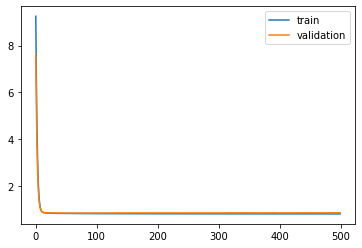

Time to train LSTM:  324.2127056121826
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 2s - loss: 9.1693 - pdc_loss: 0.6923 - event_loss: 0.6732 - val_loss: 7.5412 - val_pdc_loss: 0.6763 - val_event_loss: 0.6166

Epoch 00001: val_loss improved from inf to 7.54115, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 6.3759 - pdc_loss: 0.6564 - event_loss: 0.5664 - val_loss: 5.2234 - val_pdc_loss: 0.6468 - val_event_loss: 0.5140

Epoch 00002: val_loss improved from 7.54115 to 5.22341, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 4.4055 - pdc_loss: 0.6279 - event_loss: 0.4593 - val_loss: 3.6144 - val_pdc_loss: 0.6226 - val_event_loss: 0.4086

Epoch 00003: val_loss improved from 5.22341 to 3.61441, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 3.0557 - pdc_loss: 0.6045 - event_loss: 0.3640 - val_loss: 2.5410 - val_pdc_loss: 0.6015 - val_event_loss: 0.3383

Epoch 00004: val_loss improved from 3.61441 to 2.54096, saving m


Epoch 00035: val_loss improved from 0.85147 to 0.85112, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 0.8276 - pdc_loss: 0.5192 - event_loss: 0.2965 - val_loss: 0.8508 - val_pdc_loss: 0.5370 - val_event_loss: 0.3021

Epoch 00036: val_loss improved from 0.85112 to 0.85083, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.8272 - pdc_loss: 0.5189 - event_loss: 0.2965 - val_loss: 0.8505 - val_pdc_loss: 0.5368 - val_event_loss: 0.3020

Epoch 00037: val_loss improved from 0.85083 to 0.85048, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.8269 - pdc_loss: 0.5188 - event_loss: 0.2964 - val_loss: 0.8502 - val_pdc_loss: 0.5366 - val_event_loss: 0.3020

Epoch 00038: val_loss improved from 0.85048 to 0.85022, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8266 - pdc_loss: 0.5185 - event_loss: 0.2963 - val_loss: 0.8501 - val_pdc_loss: 0.5365 - val_event_loss: 0.3020

Epoch 00039: val_loss improved from 0.85022 to 


Epoch 00071: val_loss improved from 0.84620 to 0.84616, saving model to Event_val_weights4.hdf5
Epoch 72/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5146 - event_loss: 0.2949 - val_loss: 0.8462 - val_pdc_loss: 0.5336 - val_event_loss: 0.3020

Epoch 00072: val_loss did not improve from 0.84616
Epoch 73/500
 - 1s - loss: 0.8201 - pdc_loss: 0.5146 - event_loss: 0.2948 - val_loss: 0.8461 - val_pdc_loss: 0.5335 - val_event_loss: 0.3019

Epoch 00073: val_loss improved from 0.84616 to 0.84606, saving model to Event_val_weights4.hdf5
Epoch 74/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5145 - event_loss: 0.2948 - val_loss: 0.8462 - val_pdc_loss: 0.5335 - val_event_loss: 0.3020

Epoch 00074: val_loss did not improve from 0.84606
Epoch 75/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5145 - event_loss: 0.2948 - val_loss: 0.8459 - val_pdc_loss: 0.5334 - val_event_loss: 0.3019

Epoch 00075: val_loss improved from 0.84606 to 0.84591, saving model to Event_val_weights4.hdf5
Epoch 76/500
 - 1s - loss: 0.8199 - pdc_l

 - 1s - loss: 0.8168 - pdc_loss: 0.5123 - event_loss: 0.2939 - val_loss: 0.8453 - val_pdc_loss: 0.5323 - val_event_loss: 0.3024

Epoch 00111: val_loss did not improve from 0.84480
Epoch 112/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5122 - event_loss: 0.2939 - val_loss: 0.8450 - val_pdc_loss: 0.5321 - val_event_loss: 0.3024

Epoch 00112: val_loss did not improve from 0.84480
Epoch 113/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5122 - event_loss: 0.2939 - val_loss: 0.8452 - val_pdc_loss: 0.5322 - val_event_loss: 0.3024

Epoch 00113: val_loss did not improve from 0.84480
Epoch 114/500
 - 1s - loss: 0.8165 - pdc_loss: 0.5121 - event_loss: 0.2939 - val_loss: 0.8450 - val_pdc_loss: 0.5320 - val_event_loss: 0.3024

Epoch 00114: val_loss did not improve from 0.84480
Epoch 115/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5120 - event_loss: 0.2938 - val_loss: 0.8452 - val_pdc_loss: 0.5322 - val_event_loss: 0.3025

Epoch 00115: val_loss did not improve from 0.84480
Epoch 116/500
 - 1s - loss: 0.8164 - pdc_los


Epoch 00153: val_loss did not improve from 0.84480
Epoch 154/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5104 - event_loss: 0.2928 - val_loss: 0.8466 - val_pdc_loss: 0.5317 - val_event_loss: 0.3040

Epoch 00154: val_loss did not improve from 0.84480
Epoch 155/500
 - 1s - loss: 0.8142 - pdc_loss: 0.5104 - event_loss: 0.2928 - val_loss: 0.8466 - val_pdc_loss: 0.5318 - val_event_loss: 0.3038

Epoch 00155: val_loss did not improve from 0.84480
Epoch 156/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5104 - event_loss: 0.2927 - val_loss: 0.8466 - val_pdc_loss: 0.5316 - val_event_loss: 0.3040

Epoch 00156: val_loss did not improve from 0.84480
Epoch 157/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5103 - event_loss: 0.2927 - val_loss: 0.8468 - val_pdc_loss: 0.5319 - val_event_loss: 0.3039

Epoch 00157: val_loss did not improve from 0.84480
Epoch 158/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5104 - event_loss: 0.2927 - val_loss: 0.8464 - val_pdc_loss: 0.5315 - val_event_loss: 0.3039

Epoch 00158: val_loss did not

 - 1s - loss: 0.8125 - pdc_loss: 0.5094 - event_loss: 0.2919 - val_loss: 0.8483 - val_pdc_loss: 0.5320 - val_event_loss: 0.3052

Epoch 00196: val_loss did not improve from 0.84480
Epoch 197/500
 - 1s - loss: 0.8123 - pdc_loss: 0.5094 - event_loss: 0.2918 - val_loss: 0.8482 - val_pdc_loss: 0.5323 - val_event_loss: 0.3048

Epoch 00197: val_loss did not improve from 0.84480
Epoch 198/500
 - 1s - loss: 0.8122 - pdc_loss: 0.5093 - event_loss: 0.2918 - val_loss: 0.8487 - val_pdc_loss: 0.5323 - val_event_loss: 0.3052

Epoch 00198: val_loss did not improve from 0.84480
Epoch 199/500
 - 1s - loss: 0.8124 - pdc_loss: 0.5094 - event_loss: 0.2919 - val_loss: 0.8487 - val_pdc_loss: 0.5325 - val_event_loss: 0.3050

Epoch 00199: val_loss did not improve from 0.84480
Epoch 200/500
 - 1s - loss: 0.8124 - pdc_loss: 0.5094 - event_loss: 0.2918 - val_loss: 0.8491 - val_pdc_loss: 0.5322 - val_event_loss: 0.3057

Epoch 00200: val_loss did not improve from 0.84480
Epoch 201/500
 - 1s - loss: 0.8125 - pdc_los


Epoch 00238: val_loss did not improve from 0.84480
Epoch 239/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5084 - event_loss: 0.2911 - val_loss: 0.8500 - val_pdc_loss: 0.5326 - val_event_loss: 0.3059

Epoch 00239: val_loss did not improve from 0.84480
Epoch 240/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5081 - event_loss: 0.2913 - val_loss: 0.8498 - val_pdc_loss: 0.5324 - val_event_loss: 0.3059

Epoch 00240: val_loss did not improve from 0.84480
Epoch 241/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5082 - event_loss: 0.2913 - val_loss: 0.8500 - val_pdc_loss: 0.5328 - val_event_loss: 0.3057

Epoch 00241: val_loss did not improve from 0.84480
Epoch 242/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5081 - event_loss: 0.2913 - val_loss: 0.8496 - val_pdc_loss: 0.5323 - val_event_loss: 0.3058

Epoch 00242: val_loss did not improve from 0.84480
Epoch 243/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5082 - event_loss: 0.2912 - val_loss: 0.8506 - val_pdc_loss: 0.5333 - val_event_loss: 0.3057

Epoch 00243: val_loss did not

 - 1s - loss: 0.8101 - pdc_loss: 0.5074 - event_loss: 0.2908 - val_loss: 0.8523 - val_pdc_loss: 0.5341 - val_event_loss: 0.3064

Epoch 00281: val_loss did not improve from 0.84480
Epoch 282/500
 - 1s - loss: 0.8099 - pdc_loss: 0.5072 - event_loss: 0.2909 - val_loss: 0.8522 - val_pdc_loss: 0.5337 - val_event_loss: 0.3067

Epoch 00282: val_loss did not improve from 0.84480
Epoch 283/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5072 - event_loss: 0.2907 - val_loss: 0.8520 - val_pdc_loss: 0.5340 - val_event_loss: 0.3063

Epoch 00283: val_loss did not improve from 0.84480
Epoch 284/500
 - 1s - loss: 0.8100 - pdc_loss: 0.5072 - event_loss: 0.2910 - val_loss: 0.8526 - val_pdc_loss: 0.5340 - val_event_loss: 0.3069

Epoch 00284: val_loss did not improve from 0.84480
Epoch 285/500
 - 1s - loss: 0.8099 - pdc_loss: 0.5075 - event_loss: 0.2907 - val_loss: 0.8518 - val_pdc_loss: 0.5338 - val_event_loss: 0.3062

Epoch 00285: val_loss did not improve from 0.84480
Epoch 286/500
 - 1s - loss: 0.8098 - pdc_los


Epoch 00323: val_loss did not improve from 0.84480
Epoch 324/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5071 - event_loss: 0.2906 - val_loss: 0.8532 - val_pdc_loss: 0.5348 - val_event_loss: 0.3064

Epoch 00324: val_loss did not improve from 0.84480
Epoch 325/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5069 - event_loss: 0.2907 - val_loss: 0.8537 - val_pdc_loss: 0.5351 - val_event_loss: 0.3065

Epoch 00325: val_loss did not improve from 0.84480
Epoch 326/500
 - 1s - loss: 0.8093 - pdc_loss: 0.5067 - event_loss: 0.2905 - val_loss: 0.8523 - val_pdc_loss: 0.5340 - val_event_loss: 0.3063

Epoch 00326: val_loss did not improve from 0.84480
Epoch 327/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5068 - event_loss: 0.2906 - val_loss: 0.8533 - val_pdc_loss: 0.5351 - val_event_loss: 0.3061

Epoch 00327: val_loss did not improve from 0.84480
Epoch 328/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5067 - event_loss: 0.2904 - val_loss: 0.8529 - val_pdc_loss: 0.5346 - val_event_loss: 0.3063

Epoch 00328: val_loss did not

 - 1s - loss: 0.8088 - pdc_loss: 0.5062 - event_loss: 0.2905 - val_loss: 0.8522 - val_pdc_loss: 0.5342 - val_event_loss: 0.3060

Epoch 00366: val_loss did not improve from 0.84480
Epoch 367/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5063 - event_loss: 0.2904 - val_loss: 0.8516 - val_pdc_loss: 0.5336 - val_event_loss: 0.3059

Epoch 00367: val_loss did not improve from 0.84480
Epoch 368/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5060 - event_loss: 0.2902 - val_loss: 0.8518 - val_pdc_loss: 0.5336 - val_event_loss: 0.3060

Epoch 00368: val_loss did not improve from 0.84480
Epoch 369/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5061 - event_loss: 0.2903 - val_loss: 0.8514 - val_pdc_loss: 0.5341 - val_event_loss: 0.3053

Epoch 00369: val_loss did not improve from 0.84480
Epoch 370/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5058 - event_loss: 0.2905 - val_loss: 0.8521 - val_pdc_loss: 0.5343 - val_event_loss: 0.3058

Epoch 00370: val_loss did not improve from 0.84480
Epoch 371/500
 - 1s - loss: 0.8081 - pdc_los


Epoch 00408: val_loss did not improve from 0.84480
Epoch 409/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5057 - event_loss: 0.2907 - val_loss: 0.8547 - val_pdc_loss: 0.5369 - val_event_loss: 0.3057

Epoch 00409: val_loss did not improve from 0.84480
Epoch 410/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5054 - event_loss: 0.2905 - val_loss: 0.8535 - val_pdc_loss: 0.5359 - val_event_loss: 0.3055

Epoch 00410: val_loss did not improve from 0.84480
Epoch 411/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5057 - event_loss: 0.2905 - val_loss: 0.8546 - val_pdc_loss: 0.5365 - val_event_loss: 0.3058

Epoch 00411: val_loss did not improve from 0.84480
Epoch 412/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5054 - event_loss: 0.2903 - val_loss: 0.8529 - val_pdc_loss: 0.5351 - val_event_loss: 0.3055

Epoch 00412: val_loss did not improve from 0.84480
Epoch 413/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5054 - event_loss: 0.2904 - val_loss: 0.8529 - val_pdc_loss: 0.5352 - val_event_loss: 0.3055

Epoch 00413: val_loss did not

 - 1s - loss: 0.8080 - pdc_loss: 0.5054 - event_loss: 0.2902 - val_loss: 0.8539 - val_pdc_loss: 0.5360 - val_event_loss: 0.3054

Epoch 00451: val_loss did not improve from 0.84480
Epoch 452/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5051 - event_loss: 0.2903 - val_loss: 0.8552 - val_pdc_loss: 0.5370 - val_event_loss: 0.3058

Epoch 00452: val_loss did not improve from 0.84480
Epoch 453/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5056 - event_loss: 0.2904 - val_loss: 0.8528 - val_pdc_loss: 0.5356 - val_event_loss: 0.3048

Epoch 00453: val_loss did not improve from 0.84480
Epoch 454/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5054 - event_loss: 0.2904 - val_loss: 0.8543 - val_pdc_loss: 0.5367 - val_event_loss: 0.3052

Epoch 00454: val_loss did not improve from 0.84480
Epoch 455/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5053 - event_loss: 0.2904 - val_loss: 0.8541 - val_pdc_loss: 0.5360 - val_event_loss: 0.3057

Epoch 00455: val_loss did not improve from 0.84480
Epoch 456/500
 - 1s - loss: 0.8076 - pdc_los


Epoch 00493: val_loss did not improve from 0.84480
Epoch 494/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5046 - event_loss: 0.2900 - val_loss: 0.8541 - val_pdc_loss: 0.5352 - val_event_loss: 0.3064

Epoch 00494: val_loss did not improve from 0.84480
Epoch 495/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5046 - event_loss: 0.2903 - val_loss: 0.8545 - val_pdc_loss: 0.5354 - val_event_loss: 0.3066

Epoch 00495: val_loss did not improve from 0.84480
Epoch 496/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5041 - event_loss: 0.2900 - val_loss: 0.8544 - val_pdc_loss: 0.5351 - val_event_loss: 0.3069

Epoch 00496: val_loss did not improve from 0.84480
Epoch 497/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5042 - event_loss: 0.2899 - val_loss: 0.8550 - val_pdc_loss: 0.5360 - val_event_loss: 0.3065

Epoch 00497: val_loss did not improve from 0.84480
Epoch 498/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5042 - event_loss: 0.2900 - val_loss: 0.8546 - val_pdc_loss: 0.5359 - val_event_loss: 0.3063

Epoch 00498: val_loss did not

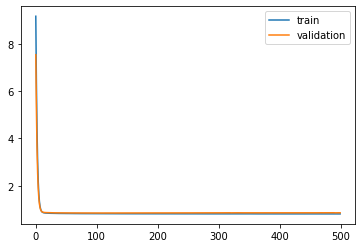

Time to train LSTM:  333.63400626182556


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0948a05ac8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 3s - loss: 9.3041 - pdc_loss: 0.7144 - event_loss: 0.6410 - val_loss: 7.6408 - val_pdc_loss: 0.6991 - val_event_loss: 0.5635

Epoch 00001: val_loss improved from inf to 7.64082, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 6.4644 - pdc_loss: 0.6860 - event_loss: 0.5180 - val_loss: 5.2960 - val_pdc_loss: 0.6811 - val_event_loss: 0.4704

Epoch 00002: val_loss improved from 7.64082 to 5.29597, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 4.4823 - pdc_loss: 0.6680 - event_loss: 0.4319 - val_loss: 3.6811 - val_pdc_loss: 0.6606 - val_event_loss: 0.3888

Epoch 00003: val_loss improved from 5.29597 to 3.68113, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 3.1305 - pdc_loss: 0.6426 - event_loss: 0.3599 - val_loss: 2.5959 - val_pdc_loss: 0.6289 - val_event_loss: 0.3319

Epoch 00004: val_loss improved from 3.68113 to 2.59589, saving model to Event_val_weights5.hdf5
Epoch 5


Epoch 00035: val_loss improved from 0.83605 to 0.83559, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.8304 - pdc_loss: 0.5212 - event_loss: 0.2965 - val_loss: 0.8352 - val_pdc_loss: 0.5228 - val_event_loss: 0.2998

Epoch 00036: val_loss improved from 0.83559 to 0.83517, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.8299 - pdc_loss: 0.5209 - event_loss: 0.2965 - val_loss: 0.8348 - val_pdc_loss: 0.5227 - val_event_loss: 0.2995

Epoch 00037: val_loss improved from 0.83517 to 0.83481, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.8296 - pdc_loss: 0.5206 - event_loss: 0.2964 - val_loss: 0.8345 - val_pdc_loss: 0.5223 - val_event_loss: 0.2996

Epoch 00038: val_loss improved from 0.83481 to 0.83446, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 0.8291 - pdc_loss: 0.5203 - event_loss: 0.2963 - val_loss: 0.8343 - val_pdc_loss: 0.5222 - val_event_loss: 0.2997

Epoch 00039: val_loss improved from 0.83446 to 

 - 1s - loss: 0.8214 - pdc_loss: 0.5150 - event_loss: 0.2945 - val_loss: 0.8299 - val_pdc_loss: 0.5180 - val_event_loss: 0.3000

Epoch 00073: val_loss improved from 0.83032 to 0.82994, saving model to Event_val_weights5.hdf5
Epoch 74/500
 - 1s - loss: 0.8211 - pdc_loss: 0.5148 - event_loss: 0.2944 - val_loss: 0.8300 - val_pdc_loss: 0.5182 - val_event_loss: 0.2998

Epoch 00074: val_loss did not improve from 0.82994
Epoch 75/500
 - 1s - loss: 0.8211 - pdc_loss: 0.5148 - event_loss: 0.2944 - val_loss: 0.8299 - val_pdc_loss: 0.5181 - val_event_loss: 0.2999

Epoch 00075: val_loss improved from 0.82994 to 0.82990, saving model to Event_val_weights5.hdf5
Epoch 76/500
 - 1s - loss: 0.8208 - pdc_loss: 0.5145 - event_loss: 0.2943 - val_loss: 0.8300 - val_pdc_loss: 0.5183 - val_event_loss: 0.2998

Epoch 00076: val_loss did not improve from 0.82990
Epoch 77/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5147 - event_loss: 0.2944 - val_loss: 0.8302 - val_pdc_loss: 0.5184 - val_event_loss: 0.2998

Epoch 000


Epoch 00113: val_loss did not improve from 0.82860
Epoch 114/500
 - 1s - loss: 0.8174 - pdc_loss: 0.5124 - event_loss: 0.2932 - val_loss: 0.8298 - val_pdc_loss: 0.5179 - val_event_loss: 0.3001

Epoch 00114: val_loss did not improve from 0.82860
Epoch 115/500
 - 1s - loss: 0.8173 - pdc_loss: 0.5124 - event_loss: 0.2932 - val_loss: 0.8299 - val_pdc_loss: 0.5181 - val_event_loss: 0.3001

Epoch 00115: val_loss did not improve from 0.82860
Epoch 116/500
 - 1s - loss: 0.8173 - pdc_loss: 0.5125 - event_loss: 0.2931 - val_loss: 0.8296 - val_pdc_loss: 0.5179 - val_event_loss: 0.3001

Epoch 00116: val_loss did not improve from 0.82860
Epoch 117/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5123 - event_loss: 0.2931 - val_loss: 0.8301 - val_pdc_loss: 0.5183 - val_event_loss: 0.3001

Epoch 00117: val_loss did not improve from 0.82860
Epoch 118/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5125 - event_loss: 0.2930 - val_loss: 0.8298 - val_pdc_loss: 0.5180 - val_event_loss: 0.3001

Epoch 00118: val_loss did not

 - 1s - loss: 0.8155 - pdc_loss: 0.5110 - event_loss: 0.2925 - val_loss: 0.8287 - val_pdc_loss: 0.5170 - val_event_loss: 0.2998

Epoch 00156: val_loss did not improve from 0.82860
Epoch 157/500
 - 1s - loss: 0.8151 - pdc_loss: 0.5109 - event_loss: 0.2923 - val_loss: 0.8299 - val_pdc_loss: 0.5181 - val_event_loss: 0.3001

Epoch 00157: val_loss did not improve from 0.82860
Epoch 158/500
 - 1s - loss: 0.8150 - pdc_loss: 0.5110 - event_loss: 0.2923 - val_loss: 0.8293 - val_pdc_loss: 0.5177 - val_event_loss: 0.3000

Epoch 00158: val_loss did not improve from 0.82860
Epoch 159/500
 - 1s - loss: 0.8146 - pdc_loss: 0.5108 - event_loss: 0.2922 - val_loss: 0.8306 - val_pdc_loss: 0.5187 - val_event_loss: 0.3003

Epoch 00159: val_loss did not improve from 0.82860
Epoch 160/500
 - 1s - loss: 0.8147 - pdc_loss: 0.5109 - event_loss: 0.2922 - val_loss: 0.8300 - val_pdc_loss: 0.5184 - val_event_loss: 0.2999

Epoch 00160: val_loss did not improve from 0.82860
Epoch 161/500
 - 1s - loss: 0.8147 - pdc_los


Epoch 00198: val_loss did not improve from 0.82860
Epoch 199/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5099 - event_loss: 0.2921 - val_loss: 0.8309 - val_pdc_loss: 0.5183 - val_event_loss: 0.3006

Epoch 00199: val_loss did not improve from 0.82860
Epoch 200/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5099 - event_loss: 0.2921 - val_loss: 0.8311 - val_pdc_loss: 0.5187 - val_event_loss: 0.3004

Epoch 00200: val_loss did not improve from 0.82860
Epoch 201/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5098 - event_loss: 0.2922 - val_loss: 0.8290 - val_pdc_loss: 0.5173 - val_event_loss: 0.2998

Epoch 00201: val_loss did not improve from 0.82860
Epoch 202/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5099 - event_loss: 0.2921 - val_loss: 0.8301 - val_pdc_loss: 0.5185 - val_event_loss: 0.2997

Epoch 00202: val_loss did not improve from 0.82860
Epoch 203/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5097 - event_loss: 0.2920 - val_loss: 0.8305 - val_pdc_loss: 0.5181 - val_event_loss: 0.3006

Epoch 00203: val_loss did not

 - 1s - loss: 0.8120 - pdc_loss: 0.5086 - event_loss: 0.2913 - val_loss: 0.8305 - val_pdc_loss: 0.5182 - val_event_loss: 0.3002

Epoch 00241: val_loss did not improve from 0.82860
Epoch 242/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5085 - event_loss: 0.2913 - val_loss: 0.8312 - val_pdc_loss: 0.5182 - val_event_loss: 0.3010

Epoch 00242: val_loss did not improve from 0.82860
Epoch 243/500
 - 1s - loss: 0.8120 - pdc_loss: 0.5085 - event_loss: 0.2913 - val_loss: 0.8312 - val_pdc_loss: 0.5184 - val_event_loss: 0.3006

Epoch 00243: val_loss did not improve from 0.82860
Epoch 244/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5083 - event_loss: 0.2910 - val_loss: 0.8314 - val_pdc_loss: 0.5186 - val_event_loss: 0.3008

Epoch 00244: val_loss did not improve from 0.82860
Epoch 245/500
 - 1s - loss: 0.8117 - pdc_loss: 0.5085 - event_loss: 0.2912 - val_loss: 0.8306 - val_pdc_loss: 0.5182 - val_event_loss: 0.3005

Epoch 00245: val_loss did not improve from 0.82860
Epoch 246/500
 - 1s - loss: 0.8116 - pdc_los


Epoch 00283: val_loss did not improve from 0.82860
Epoch 284/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5076 - event_loss: 0.2906 - val_loss: 0.8310 - val_pdc_loss: 0.5185 - val_event_loss: 0.3004

Epoch 00284: val_loss did not improve from 0.82860
Epoch 285/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5076 - event_loss: 0.2906 - val_loss: 0.8309 - val_pdc_loss: 0.5181 - val_event_loss: 0.3006

Epoch 00285: val_loss did not improve from 0.82860
Epoch 286/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5077 - event_loss: 0.2905 - val_loss: 0.8317 - val_pdc_loss: 0.5189 - val_event_loss: 0.3007

Epoch 00286: val_loss did not improve from 0.82860
Epoch 287/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5076 - event_loss: 0.2906 - val_loss: 0.8315 - val_pdc_loss: 0.5183 - val_event_loss: 0.3011

Epoch 00287: val_loss did not improve from 0.82860
Epoch 288/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5076 - event_loss: 0.2907 - val_loss: 0.8322 - val_pdc_loss: 0.5191 - val_event_loss: 0.3011

Epoch 00288: val_loss did not

 - 1s - loss: 0.8089 - pdc_loss: 0.5067 - event_loss: 0.2900 - val_loss: 0.8310 - val_pdc_loss: 0.5169 - val_event_loss: 0.3019

Epoch 00326: val_loss did not improve from 0.82860
Epoch 327/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5067 - event_loss: 0.2902 - val_loss: 0.8310 - val_pdc_loss: 0.5173 - val_event_loss: 0.3016

Epoch 00327: val_loss did not improve from 0.82860
Epoch 328/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5068 - event_loss: 0.2900 - val_loss: 0.8321 - val_pdc_loss: 0.5182 - val_event_loss: 0.3017

Epoch 00328: val_loss did not improve from 0.82860
Epoch 329/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5068 - event_loss: 0.2901 - val_loss: 0.8305 - val_pdc_loss: 0.5172 - val_event_loss: 0.3011

Epoch 00329: val_loss did not improve from 0.82860
Epoch 330/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5065 - event_loss: 0.2900 - val_loss: 0.8319 - val_pdc_loss: 0.5178 - val_event_loss: 0.3020

Epoch 00330: val_loss did not improve from 0.82860
Epoch 331/500
 - 1s - loss: 0.8088 - pdc_los


Epoch 00368: val_loss did not improve from 0.82860
Epoch 369/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5062 - event_loss: 0.2895 - val_loss: 0.8321 - val_pdc_loss: 0.5190 - val_event_loss: 0.3005

Epoch 00369: val_loss did not improve from 0.82860
Epoch 370/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5063 - event_loss: 0.2896 - val_loss: 0.8326 - val_pdc_loss: 0.5192 - val_event_loss: 0.3007

Epoch 00370: val_loss did not improve from 0.82860
Epoch 371/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5063 - event_loss: 0.2896 - val_loss: 0.8323 - val_pdc_loss: 0.5189 - val_event_loss: 0.3008

Epoch 00371: val_loss did not improve from 0.82860
Epoch 372/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5061 - event_loss: 0.2896 - val_loss: 0.8334 - val_pdc_loss: 0.5190 - val_event_loss: 0.3017

Epoch 00372: val_loss did not improve from 0.82860
Epoch 373/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5061 - event_loss: 0.2895 - val_loss: 0.8328 - val_pdc_loss: 0.5192 - val_event_loss: 0.3011

Epoch 00373: val_loss did not

 - 1s - loss: 0.8072 - pdc_loss: 0.5053 - event_loss: 0.2891 - val_loss: 0.8345 - val_pdc_loss: 0.5197 - val_event_loss: 0.3021

Epoch 00411: val_loss did not improve from 0.82860
Epoch 412/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5062 - event_loss: 0.2893 - val_loss: 0.8358 - val_pdc_loss: 0.5206 - val_event_loss: 0.3025

Epoch 00412: val_loss did not improve from 0.82860
Epoch 413/500
 - 1s - loss: 0.8078 - pdc_loss: 0.5059 - event_loss: 0.2892 - val_loss: 0.8346 - val_pdc_loss: 0.5203 - val_event_loss: 0.3017

Epoch 00413: val_loss did not improve from 0.82860
Epoch 414/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5056 - event_loss: 0.2893 - val_loss: 0.8352 - val_pdc_loss: 0.5204 - val_event_loss: 0.3021

Epoch 00414: val_loss did not improve from 0.82860
Epoch 415/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5057 - event_loss: 0.2891 - val_loss: 0.8348 - val_pdc_loss: 0.5199 - val_event_loss: 0.3021

Epoch 00415: val_loss did not improve from 0.82860
Epoch 416/500
 - 1s - loss: 0.8072 - pdc_los


Epoch 00453: val_loss did not improve from 0.82860
Epoch 454/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5053 - event_loss: 0.2888 - val_loss: 0.8340 - val_pdc_loss: 0.5194 - val_event_loss: 0.3016

Epoch 00454: val_loss did not improve from 0.82860
Epoch 455/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5052 - event_loss: 0.2891 - val_loss: 0.8355 - val_pdc_loss: 0.5205 - val_event_loss: 0.3018

Epoch 00455: val_loss did not improve from 0.82860
Epoch 456/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5051 - event_loss: 0.2891 - val_loss: 0.8355 - val_pdc_loss: 0.5205 - val_event_loss: 0.3018

Epoch 00456: val_loss did not improve from 0.82860
Epoch 457/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5051 - event_loss: 0.2891 - val_loss: 0.8353 - val_pdc_loss: 0.5201 - val_event_loss: 0.3023

Epoch 00457: val_loss did not improve from 0.82860
Epoch 458/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5050 - event_loss: 0.2891 - val_loss: 0.8364 - val_pdc_loss: 0.5215 - val_event_loss: 0.3018

Epoch 00458: val_loss did not

 - 1s - loss: 0.8072 - pdc_loss: 0.5054 - event_loss: 0.2884 - val_loss: 0.8374 - val_pdc_loss: 0.5217 - val_event_loss: 0.3023

Epoch 00496: val_loss did not improve from 0.82860
Epoch 497/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5053 - event_loss: 0.2887 - val_loss: 0.8365 - val_pdc_loss: 0.5208 - val_event_loss: 0.3023

Epoch 00497: val_loss did not improve from 0.82860
Epoch 498/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5054 - event_loss: 0.2885 - val_loss: 0.8363 - val_pdc_loss: 0.5213 - val_event_loss: 0.3016

Epoch 00498: val_loss did not improve from 0.82860
Epoch 499/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5052 - event_loss: 0.2886 - val_loss: 0.8364 - val_pdc_loss: 0.5208 - val_event_loss: 0.3022

Epoch 00499: val_loss did not improve from 0.82860
Epoch 500/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5055 - event_loss: 0.2887 - val_loss: 0.8360 - val_pdc_loss: 0.5207 - val_event_loss: 0.3018

Epoch 00500: val_loss did not improve from 0.82860
#################################
Number of 

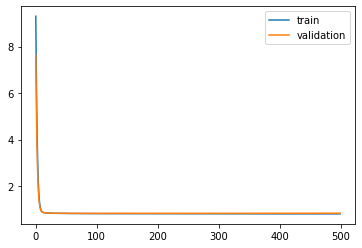

Time to train LSTM:  342.8044922351837
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 3s - loss: 10.1578 - pdc_loss: 0.6893 - event_loss: 0.6632 - val_loss: 9.1766 - val_pdc_loss: 0.6682 - val_event_loss: 0.6143

Epoch 00001: val_loss improved from inf to 9.17656, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 8.4763 - pdc_loss: 0.6572 - event_loss: 0.5870 - val_loss: 7.6367 - val_pdc_loss: 0.6432 - val_event_loss: 0.5447

Epoch 00002: val_loss improved from 9.17656 to 7.63673, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 7.0459 - pdc_loss: 0.6348 - event_loss: 0.5244 - val_loss: 6.3367 - val_pdc_loss: 0.6253 - val_event_loss: 0.4861

Epoch 00003: val_loss improved from 7.63673 to 6.33671, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 5.8434 - pdc_loss: 0.6181 - event_loss: 0.4698 - val_loss: 5.2508 - val_pdc_loss: 0.6117 - val_event_loss: 0.4342

Epoch 00004: val_loss improved from 6.33671 to 5.25078, saving 


Epoch 00035: val_loss improved from 0.83277 to 0.83183, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 0.8339 - pdc_loss: 0.5235 - event_loss: 0.2979 - val_loss: 0.8310 - val_pdc_loss: 0.5256 - val_event_loss: 0.2930

Epoch 00036: val_loss improved from 0.83183 to 0.83097, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 0.8330 - pdc_loss: 0.5230 - event_loss: 0.2978 - val_loss: 0.8302 - val_pdc_loss: 0.5251 - val_event_loss: 0.2929

Epoch 00037: val_loss improved from 0.83097 to 0.83016, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 0.8322 - pdc_loss: 0.5224 - event_loss: 0.2977 - val_loss: 0.8294 - val_pdc_loss: 0.5246 - val_event_loss: 0.2928

Epoch 00038: val_loss improved from 0.83016 to 0.82937, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 0.8315 - pdc_loss: 0.5220 - event_loss: 0.2976 - val_loss: 0.8287 - val_pdc_loss: 0.5242 - val_event_loss: 0.2927

Epoch 00039: val_loss improved from 0.82937 to 


Epoch 00070: val_loss did not improve from 0.82003
Epoch 71/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5153 - event_loss: 0.2962 - val_loss: 0.8202 - val_pdc_loss: 0.5188 - val_event_loss: 0.2916

Epoch 00071: val_loss did not improve from 0.82003
Epoch 72/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5152 - event_loss: 0.2962 - val_loss: 0.8196 - val_pdc_loss: 0.5184 - val_event_loss: 0.2913

Epoch 00072: val_loss improved from 0.82003 to 0.81959, saving model to Event_val_weights1.hdf5
Epoch 73/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5151 - event_loss: 0.2961 - val_loss: 0.8198 - val_pdc_loss: 0.5185 - val_event_loss: 0.2914

Epoch 00073: val_loss did not improve from 0.81959
Epoch 74/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5150 - event_loss: 0.2961 - val_loss: 0.8197 - val_pdc_loss: 0.5186 - val_event_loss: 0.2913

Epoch 00074: val_loss did not improve from 0.81959
Epoch 75/500
 - 1s - loss: 0.8207 - pdc_loss: 0.5148 - event_loss: 0.2961 - val_loss: 0.8198 - val_pdc_loss: 0.5185 - val_event_los


Epoch 00110: val_loss did not improve from 0.81782
Epoch 111/500
 - 1s - loss: 0.8167 - pdc_loss: 0.5118 - event_loss: 0.2953 - val_loss: 0.8181 - val_pdc_loss: 0.5167 - val_event_loss: 0.2917

Epoch 00111: val_loss did not improve from 0.81782
Epoch 112/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5118 - event_loss: 0.2952 - val_loss: 0.8180 - val_pdc_loss: 0.5172 - val_event_loss: 0.2911

Epoch 00112: val_loss did not improve from 0.81782
Epoch 113/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5118 - event_loss: 0.2952 - val_loss: 0.8182 - val_pdc_loss: 0.5169 - val_event_loss: 0.2917

Epoch 00113: val_loss did not improve from 0.81782
Epoch 114/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5116 - event_loss: 0.2952 - val_loss: 0.8184 - val_pdc_loss: 0.5172 - val_event_loss: 0.2916

Epoch 00114: val_loss did not improve from 0.81782
Epoch 115/500
 - 1s - loss: 0.8163 - pdc_loss: 0.5115 - event_loss: 0.2951 - val_loss: 0.8177 - val_pdc_loss: 0.5168 - val_event_loss: 0.2913

Epoch 00115: val_loss improve


Epoch 00151: val_loss did not improve from 0.81718
Epoch 152/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5097 - event_loss: 0.2937 - val_loss: 0.8179 - val_pdc_loss: 0.5162 - val_event_loss: 0.2919

Epoch 00152: val_loss did not improve from 0.81718
Epoch 153/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5096 - event_loss: 0.2937 - val_loss: 0.8174 - val_pdc_loss: 0.5164 - val_event_loss: 0.2913

Epoch 00153: val_loss did not improve from 0.81718
Epoch 154/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5096 - event_loss: 0.2936 - val_loss: 0.8176 - val_pdc_loss: 0.5164 - val_event_loss: 0.2913

Epoch 00154: val_loss did not improve from 0.81718
Epoch 155/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5094 - event_loss: 0.2935 - val_loss: 0.8177 - val_pdc_loss: 0.5166 - val_event_loss: 0.2913

Epoch 00155: val_loss did not improve from 0.81718
Epoch 156/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5094 - event_loss: 0.2935 - val_loss: 0.8180 - val_pdc_loss: 0.5165 - val_event_loss: 0.2918

Epoch 00156: val_loss did not

 - 1s - loss: 0.8100 - pdc_loss: 0.5077 - event_loss: 0.2922 - val_loss: 0.8201 - val_pdc_loss: 0.5176 - val_event_loss: 0.2924

Epoch 00194: val_loss did not improve from 0.81718
Epoch 195/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5076 - event_loss: 0.2921 - val_loss: 0.8194 - val_pdc_loss: 0.5170 - val_event_loss: 0.2923

Epoch 00195: val_loss did not improve from 0.81718
Epoch 196/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5076 - event_loss: 0.2921 - val_loss: 0.8203 - val_pdc_loss: 0.5177 - val_event_loss: 0.2924

Epoch 00196: val_loss did not improve from 0.81718
Epoch 197/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5075 - event_loss: 0.2921 - val_loss: 0.8195 - val_pdc_loss: 0.5171 - val_event_loss: 0.2922

Epoch 00197: val_loss did not improve from 0.81718
Epoch 198/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5075 - event_loss: 0.2921 - val_loss: 0.8204 - val_pdc_loss: 0.5176 - val_event_loss: 0.2926

Epoch 00198: val_loss did not improve from 0.81718
Epoch 199/500
 - 1s - loss: 0.8095 - pdc_los


Epoch 00236: val_loss did not improve from 0.81718
Epoch 237/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5062 - event_loss: 0.2912 - val_loss: 0.8222 - val_pdc_loss: 0.5179 - val_event_loss: 0.2940

Epoch 00237: val_loss did not improve from 0.81718
Epoch 238/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5061 - event_loss: 0.2913 - val_loss: 0.8220 - val_pdc_loss: 0.5180 - val_event_loss: 0.2938

Epoch 00238: val_loss did not improve from 0.81718
Epoch 239/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5060 - event_loss: 0.2913 - val_loss: 0.8215 - val_pdc_loss: 0.5179 - val_event_loss: 0.2935

Epoch 00239: val_loss did not improve from 0.81718
Epoch 240/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5060 - event_loss: 0.2914 - val_loss: 0.8222 - val_pdc_loss: 0.5184 - val_event_loss: 0.2935

Epoch 00240: val_loss did not improve from 0.81718
Epoch 241/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5059 - event_loss: 0.2912 - val_loss: 0.8224 - val_pdc_loss: 0.5185 - val_event_loss: 0.2936

Epoch 00241: val_loss did not

 - 1s - loss: 0.8061 - pdc_loss: 0.5051 - event_loss: 0.2906 - val_loss: 0.8260 - val_pdc_loss: 0.5207 - val_event_loss: 0.2949

Epoch 00279: val_loss did not improve from 0.81718
Epoch 280/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5049 - event_loss: 0.2904 - val_loss: 0.8253 - val_pdc_loss: 0.5193 - val_event_loss: 0.2956

Epoch 00280: val_loss did not improve from 0.81718
Epoch 281/500
 - 1s - loss: 0.8054 - pdc_loss: 0.5048 - event_loss: 0.2902 - val_loss: 0.8253 - val_pdc_loss: 0.5196 - val_event_loss: 0.2953

Epoch 00281: val_loss did not improve from 0.81718
Epoch 282/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5049 - event_loss: 0.2903 - val_loss: 0.8247 - val_pdc_loss: 0.5187 - val_event_loss: 0.2957

Epoch 00282: val_loss did not improve from 0.81718
Epoch 283/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5052 - event_loss: 0.2902 - val_loss: 0.8254 - val_pdc_loss: 0.5193 - val_event_loss: 0.2957

Epoch 00283: val_loss did not improve from 0.81718
Epoch 284/500
 - 1s - loss: 0.8056 - pdc_los


Epoch 00321: val_loss did not improve from 0.81718
Epoch 322/500
 - 1s - loss: 0.8043 - pdc_loss: 0.5042 - event_loss: 0.2896 - val_loss: 0.8274 - val_pdc_loss: 0.5195 - val_event_loss: 0.2974

Epoch 00322: val_loss did not improve from 0.81718
Epoch 323/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5040 - event_loss: 0.2898 - val_loss: 0.8281 - val_pdc_loss: 0.5209 - val_event_loss: 0.2966

Epoch 00323: val_loss did not improve from 0.81718
Epoch 324/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5045 - event_loss: 0.2897 - val_loss: 0.8300 - val_pdc_loss: 0.5220 - val_event_loss: 0.2973

Epoch 00324: val_loss did not improve from 0.81718
Epoch 325/500
 - 1s - loss: 0.8045 - pdc_loss: 0.5041 - event_loss: 0.2896 - val_loss: 0.8298 - val_pdc_loss: 0.5216 - val_event_loss: 0.2976

Epoch 00325: val_loss did not improve from 0.81718
Epoch 326/500
 - 1s - loss: 0.8042 - pdc_loss: 0.5041 - event_loss: 0.2894 - val_loss: 0.8279 - val_pdc_loss: 0.5199 - val_event_loss: 0.2973

Epoch 00326: val_loss did not

 - 1s - loss: 0.8033 - pdc_loss: 0.5036 - event_loss: 0.2888 - val_loss: 0.8305 - val_pdc_loss: 0.5214 - val_event_loss: 0.2983

Epoch 00364: val_loss did not improve from 0.81718
Epoch 365/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5032 - event_loss: 0.2890 - val_loss: 0.8290 - val_pdc_loss: 0.5206 - val_event_loss: 0.2975

Epoch 00365: val_loss did not improve from 0.81718
Epoch 366/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5033 - event_loss: 0.2891 - val_loss: 0.8295 - val_pdc_loss: 0.5207 - val_event_loss: 0.2979

Epoch 00366: val_loss did not improve from 0.81718
Epoch 367/500
 - 1s - loss: 0.8032 - pdc_loss: 0.5032 - event_loss: 0.2891 - val_loss: 0.8300 - val_pdc_loss: 0.5217 - val_event_loss: 0.2975

Epoch 00367: val_loss did not improve from 0.81718
Epoch 368/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5035 - event_loss: 0.2893 - val_loss: 0.8308 - val_pdc_loss: 0.5218 - val_event_loss: 0.2981

Epoch 00368: val_loss did not improve from 0.81718
Epoch 369/500
 - 1s - loss: 0.8039 - pdc_los


Epoch 00406: val_loss did not improve from 0.81718
Epoch 407/500
 - 1s - loss: 0.8023 - pdc_loss: 0.5027 - event_loss: 0.2884 - val_loss: 0.8300 - val_pdc_loss: 0.5201 - val_event_loss: 0.2986

Epoch 00407: val_loss did not improve from 0.81718
Epoch 408/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5027 - event_loss: 0.2885 - val_loss: 0.8303 - val_pdc_loss: 0.5208 - val_event_loss: 0.2983

Epoch 00408: val_loss did not improve from 0.81718
Epoch 409/500
 - 1s - loss: 0.8022 - pdc_loss: 0.5026 - event_loss: 0.2884 - val_loss: 0.8299 - val_pdc_loss: 0.5215 - val_event_loss: 0.2972

Epoch 00409: val_loss did not improve from 0.81718
Epoch 410/500
 - 1s - loss: 0.8020 - pdc_loss: 0.5021 - event_loss: 0.2887 - val_loss: 0.8310 - val_pdc_loss: 0.5222 - val_event_loss: 0.2977

Epoch 00410: val_loss did not improve from 0.81718
Epoch 411/500
 - 1s - loss: 0.8019 - pdc_loss: 0.5023 - event_loss: 0.2885 - val_loss: 0.8309 - val_pdc_loss: 0.5207 - val_event_loss: 0.2991

Epoch 00411: val_loss did not

 - 1s - loss: 0.8022 - pdc_loss: 0.5023 - event_loss: 0.2884 - val_loss: 0.8325 - val_pdc_loss: 0.5211 - val_event_loss: 0.3000

Epoch 00449: val_loss did not improve from 0.81718
Epoch 450/500
 - 1s - loss: 0.8017 - pdc_loss: 0.5020 - event_loss: 0.2882 - val_loss: 0.8319 - val_pdc_loss: 0.5214 - val_event_loss: 0.2991

Epoch 00450: val_loss did not improve from 0.81718
Epoch 451/500
 - 1s - loss: 0.8004 - pdc_loss: 0.5011 - event_loss: 0.2878 - val_loss: 0.8294 - val_pdc_loss: 0.5202 - val_event_loss: 0.2978

Epoch 00451: val_loss did not improve from 0.81718
Epoch 452/500
 - 1s - loss: 0.8003 - pdc_loss: 0.5010 - event_loss: 0.2878 - val_loss: 0.8317 - val_pdc_loss: 0.5212 - val_event_loss: 0.2992

Epoch 00452: val_loss did not improve from 0.81718
Epoch 453/500
 - 1s - loss: 0.8005 - pdc_loss: 0.5013 - event_loss: 0.2878 - val_loss: 0.8330 - val_pdc_loss: 0.5211 - val_event_loss: 0.3005

Epoch 00453: val_loss did not improve from 0.81718
Epoch 454/500
 - 1s - loss: 0.8005 - pdc_los


Epoch 00491: val_loss did not improve from 0.81718
Epoch 492/500
 - 1s - loss: 0.8002 - pdc_loss: 0.5008 - event_loss: 0.2878 - val_loss: 0.8331 - val_pdc_loss: 0.5223 - val_event_loss: 0.2991

Epoch 00492: val_loss did not improve from 0.81718
Epoch 493/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5006 - event_loss: 0.2872 - val_loss: 0.8327 - val_pdc_loss: 0.5219 - val_event_loss: 0.2994

Epoch 00493: val_loss did not improve from 0.81718
Epoch 494/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5008 - event_loss: 0.2877 - val_loss: 0.8333 - val_pdc_loss: 0.5233 - val_event_loss: 0.2984

Epoch 00494: val_loss did not improve from 0.81718
Epoch 495/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5003 - event_loss: 0.2879 - val_loss: 0.8354 - val_pdc_loss: 0.5236 - val_event_loss: 0.3002

Epoch 00495: val_loss did not improve from 0.81718
Epoch 496/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5007 - event_loss: 0.2875 - val_loss: 0.8346 - val_pdc_loss: 0.5229 - val_event_loss: 0.3002

Epoch 00496: val_loss did not

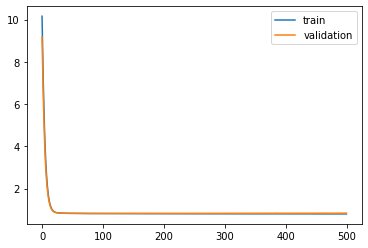

Time to train LSTM:  346.1308090686798
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 3s - loss: 10.0693 - pdc_loss: 0.7097 - event_loss: 0.7001 - val_loss: 9.1137 - val_pdc_loss: 0.6931 - val_event_loss: 0.6668

Epoch 00001: val_loss improved from inf to 9.11371, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 8.4155 - pdc_loss: 0.6812 - event_loss: 0.6362 - val_loss: 7.6005 - val_pdc_loss: 0.6686 - val_event_loss: 0.6085

Epoch 00002: val_loss improved from 9.11371 to 7.60047, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 7.0099 - pdc_loss: 0.6601 - event_loss: 0.5802 - val_loss: 6.3251 - val_pdc_loss: 0.6509 - val_event_loss: 0.5552

Epoch 00003: val_loss improved from 7.60047 to 6.32512, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 5.8295 - pdc_loss: 0.6440 - event_loss: 0.5272 - val_loss: 5.2593 - val_pdc_loss: 0.6370 - val_event_loss: 0.5031

Epoch 00004: val_loss improved from 6.32512 to 5.25931, saving 


Epoch 00035: val_loss improved from 0.85066 to 0.84972, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 0.8346 - pdc_loss: 0.5251 - event_loss: 0.2962 - val_loss: 0.8489 - val_pdc_loss: 0.5321 - val_event_loss: 0.3037

Epoch 00036: val_loss improved from 0.84972 to 0.84890, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 0.8337 - pdc_loss: 0.5245 - event_loss: 0.2962 - val_loss: 0.8481 - val_pdc_loss: 0.5315 - val_event_loss: 0.3036

Epoch 00037: val_loss improved from 0.84890 to 0.84812, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 0.8329 - pdc_loss: 0.5240 - event_loss: 0.2961 - val_loss: 0.8474 - val_pdc_loss: 0.5311 - val_event_loss: 0.3035

Epoch 00038: val_loss improved from 0.84812 to 0.84744, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 0.8322 - pdc_loss: 0.5234 - event_loss: 0.2960 - val_loss: 0.8467 - val_pdc_loss: 0.5306 - val_event_loss: 0.3034

Epoch 00039: val_loss improved from 0.84744 to 

 - 1s - loss: 0.8203 - pdc_loss: 0.5149 - event_loss: 0.2943 - val_loss: 0.8388 - val_pdc_loss: 0.5256 - val_event_loss: 0.3021

Epoch 00070: val_loss improved from 0.83892 to 0.83876, saving model to Event_val_weights2.hdf5
Epoch 71/500
 - 1s - loss: 0.8201 - pdc_loss: 0.5148 - event_loss: 0.2942 - val_loss: 0.8386 - val_pdc_loss: 0.5256 - val_event_loss: 0.3020

Epoch 00071: val_loss improved from 0.83876 to 0.83860, saving model to Event_val_weights2.hdf5
Epoch 72/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5147 - event_loss: 0.2942 - val_loss: 0.8384 - val_pdc_loss: 0.5254 - val_event_loss: 0.3020

Epoch 00072: val_loss improved from 0.83860 to 0.83841, saving model to Event_val_weights2.hdf5
Epoch 73/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5146 - event_loss: 0.2941 - val_loss: 0.8382 - val_pdc_loss: 0.5254 - val_event_loss: 0.3019

Epoch 00073: val_loss improved from 0.83841 to 0.83823, saving model to Event_val_weights2.hdf5
Epoch 74/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5145 - event_


Epoch 00105: val_loss did not improve from 0.83514
Epoch 106/500
 - 1s - loss: 0.8145 - pdc_loss: 0.5116 - event_loss: 0.2927 - val_loss: 0.8352 - val_pdc_loss: 0.5235 - val_event_loss: 0.3015

Epoch 00106: val_loss did not improve from 0.83514
Epoch 107/500
 - 1s - loss: 0.8144 - pdc_loss: 0.5115 - event_loss: 0.2926 - val_loss: 0.8352 - val_pdc_loss: 0.5235 - val_event_loss: 0.3014

Epoch 00107: val_loss did not improve from 0.83514
Epoch 108/500
 - 1s - loss: 0.8143 - pdc_loss: 0.5115 - event_loss: 0.2926 - val_loss: 0.8352 - val_pdc_loss: 0.5235 - val_event_loss: 0.3015

Epoch 00108: val_loss did not improve from 0.83514
Epoch 109/500
 - 1s - loss: 0.8142 - pdc_loss: 0.5114 - event_loss: 0.2926 - val_loss: 0.8354 - val_pdc_loss: 0.5236 - val_event_loss: 0.3015

Epoch 00109: val_loss did not improve from 0.83514
Epoch 110/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5114 - event_loss: 0.2925 - val_loss: 0.8353 - val_pdc_loss: 0.5235 - val_event_loss: 0.3016

Epoch 00110: val_loss did not

 - 1s - loss: 0.8111 - pdc_loss: 0.5096 - event_loss: 0.2916 - val_loss: 0.8355 - val_pdc_loss: 0.5235 - val_event_loss: 0.3021

Epoch 00147: val_loss did not improve from 0.83488
Epoch 148/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5095 - event_loss: 0.2916 - val_loss: 0.8359 - val_pdc_loss: 0.5239 - val_event_loss: 0.3021

Epoch 00148: val_loss did not improve from 0.83488
Epoch 149/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5094 - event_loss: 0.2916 - val_loss: 0.8353 - val_pdc_loss: 0.5234 - val_event_loss: 0.3021

Epoch 00149: val_loss did not improve from 0.83488
Epoch 150/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5094 - event_loss: 0.2916 - val_loss: 0.8359 - val_pdc_loss: 0.5239 - val_event_loss: 0.3022

Epoch 00150: val_loss did not improve from 0.83488
Epoch 151/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5093 - event_loss: 0.2915 - val_loss: 0.8356 - val_pdc_loss: 0.5236 - val_event_loss: 0.3022

Epoch 00151: val_loss did not improve from 0.83488
Epoch 152/500
 - 1s - loss: 0.8106 - pdc_los


Epoch 00189: val_loss did not improve from 0.83488
Epoch 190/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5078 - event_loss: 0.2910 - val_loss: 0.8370 - val_pdc_loss: 0.5241 - val_event_loss: 0.3033

Epoch 00190: val_loss did not improve from 0.83488
Epoch 191/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5078 - event_loss: 0.2910 - val_loss: 0.8372 - val_pdc_loss: 0.5243 - val_event_loss: 0.3033

Epoch 00191: val_loss did not improve from 0.83488
Epoch 192/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5079 - event_loss: 0.2910 - val_loss: 0.8372 - val_pdc_loss: 0.5243 - val_event_loss: 0.3033

Epoch 00192: val_loss did not improve from 0.83488
Epoch 193/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5077 - event_loss: 0.2910 - val_loss: 0.8369 - val_pdc_loss: 0.5240 - val_event_loss: 0.3033

Epoch 00193: val_loss did not improve from 0.83488
Epoch 194/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5077 - event_loss: 0.2910 - val_loss: 0.8372 - val_pdc_loss: 0.5244 - val_event_loss: 0.3033

Epoch 00194: val_loss did not

 - 1s - loss: 0.8073 - pdc_loss: 0.5069 - event_loss: 0.2908 - val_loss: 0.8393 - val_pdc_loss: 0.5250 - val_event_loss: 0.3046

Epoch 00232: val_loss did not improve from 0.83488
Epoch 233/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5067 - event_loss: 0.2909 - val_loss: 0.8383 - val_pdc_loss: 0.5248 - val_event_loss: 0.3039

Epoch 00233: val_loss did not improve from 0.83488
Epoch 234/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5066 - event_loss: 0.2911 - val_loss: 0.8385 - val_pdc_loss: 0.5253 - val_event_loss: 0.3037

Epoch 00234: val_loss did not improve from 0.83488
Epoch 235/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5067 - event_loss: 0.2911 - val_loss: 0.8390 - val_pdc_loss: 0.5254 - val_event_loss: 0.3040

Epoch 00235: val_loss did not improve from 0.83488
Epoch 236/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5069 - event_loss: 0.2908 - val_loss: 0.8375 - val_pdc_loss: 0.5245 - val_event_loss: 0.3035

Epoch 00236: val_loss did not improve from 0.83488
Epoch 237/500
 - 1s - loss: 0.8068 - pdc_los


Epoch 00274: val_loss did not improve from 0.83488
Epoch 275/500
 - 1s - loss: 0.8054 - pdc_loss: 0.5056 - event_loss: 0.2903 - val_loss: 0.8405 - val_pdc_loss: 0.5262 - val_event_loss: 0.3047

Epoch 00275: val_loss did not improve from 0.83488
Epoch 276/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5055 - event_loss: 0.2906 - val_loss: 0.8409 - val_pdc_loss: 0.5271 - val_event_loss: 0.3042

Epoch 00276: val_loss did not improve from 0.83488
Epoch 277/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5057 - event_loss: 0.2907 - val_loss: 0.8403 - val_pdc_loss: 0.5267 - val_event_loss: 0.3040

Epoch 00277: val_loss did not improve from 0.83488
Epoch 278/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5057 - event_loss: 0.2905 - val_loss: 0.8402 - val_pdc_loss: 0.5268 - val_event_loss: 0.3039

Epoch 00278: val_loss did not improve from 0.83488
Epoch 279/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5056 - event_loss: 0.2903 - val_loss: 0.8388 - val_pdc_loss: 0.5256 - val_event_loss: 0.3037

Epoch 00279: val_loss did not

 - 1s - loss: 0.8042 - pdc_loss: 0.5046 - event_loss: 0.2898 - val_loss: 0.8404 - val_pdc_loss: 0.5266 - val_event_loss: 0.3040

Epoch 00317: val_loss did not improve from 0.83488
Epoch 318/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5045 - event_loss: 0.2896 - val_loss: 0.8392 - val_pdc_loss: 0.5260 - val_event_loss: 0.3035

Epoch 00318: val_loss did not improve from 0.83488
Epoch 319/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5045 - event_loss: 0.2894 - val_loss: 0.8396 - val_pdc_loss: 0.5257 - val_event_loss: 0.3042

Epoch 00319: val_loss did not improve from 0.83488
Epoch 320/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5044 - event_loss: 0.2897 - val_loss: 0.8409 - val_pdc_loss: 0.5263 - val_event_loss: 0.3048

Epoch 00320: val_loss did not improve from 0.83488
Epoch 321/500
 - 1s - loss: 0.8042 - pdc_loss: 0.5044 - event_loss: 0.2900 - val_loss: 0.8416 - val_pdc_loss: 0.5264 - val_event_loss: 0.3053

Epoch 00321: val_loss did not improve from 0.83488
Epoch 322/500
 - 1s - loss: 0.8047 - pdc_los


Epoch 00359: val_loss did not improve from 0.83488
Epoch 360/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5035 - event_loss: 0.2897 - val_loss: 0.8446 - val_pdc_loss: 0.5284 - val_event_loss: 0.3063

Epoch 00360: val_loss did not improve from 0.83488
Epoch 361/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5039 - event_loss: 0.2897 - val_loss: 0.8435 - val_pdc_loss: 0.5282 - val_event_loss: 0.3053

Epoch 00361: val_loss did not improve from 0.83488
Epoch 362/500
 - 1s - loss: 0.8029 - pdc_loss: 0.5036 - event_loss: 0.2893 - val_loss: 0.8432 - val_pdc_loss: 0.5286 - val_event_loss: 0.3045

Epoch 00362: val_loss did not improve from 0.83488
Epoch 363/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5036 - event_loss: 0.2889 - val_loss: 0.8408 - val_pdc_loss: 0.5270 - val_event_loss: 0.3038

Epoch 00363: val_loss did not improve from 0.83488
Epoch 364/500
 - 1s - loss: 0.8022 - pdc_loss: 0.5034 - event_loss: 0.2889 - val_loss: 0.8419 - val_pdc_loss: 0.5272 - val_event_loss: 0.3046

Epoch 00364: val_loss did not

 - 1s - loss: 0.8018 - pdc_loss: 0.5031 - event_loss: 0.2888 - val_loss: 0.8455 - val_pdc_loss: 0.5294 - val_event_loss: 0.3061

Epoch 00402: val_loss did not improve from 0.83488
Epoch 403/500
 - 1s - loss: 0.8014 - pdc_loss: 0.5030 - event_loss: 0.2886 - val_loss: 0.8451 - val_pdc_loss: 0.5290 - val_event_loss: 0.3061

Epoch 00403: val_loss did not improve from 0.83488
Epoch 404/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5028 - event_loss: 0.2890 - val_loss: 0.8454 - val_pdc_loss: 0.5295 - val_event_loss: 0.3060

Epoch 00404: val_loss did not improve from 0.83488
Epoch 405/500
 - 1s - loss: 0.8014 - pdc_loss: 0.5025 - event_loss: 0.2890 - val_loss: 0.8445 - val_pdc_loss: 0.5291 - val_event_loss: 0.3055

Epoch 00405: val_loss did not improve from 0.83488
Epoch 406/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5025 - event_loss: 0.2891 - val_loss: 0.8430 - val_pdc_loss: 0.5287 - val_event_loss: 0.3043

Epoch 00406: val_loss did not improve from 0.83488
Epoch 407/500
 - 1s - loss: 0.8011 - pdc_los


Epoch 00444: val_loss did not improve from 0.83488
Epoch 445/500
 - 1s - loss: 0.8001 - pdc_loss: 0.5021 - event_loss: 0.2880 - val_loss: 0.8446 - val_pdc_loss: 0.5297 - val_event_loss: 0.3049

Epoch 00445: val_loss did not improve from 0.83488
Epoch 446/500
 - 1s - loss: 0.7995 - pdc_loss: 0.5019 - event_loss: 0.2877 - val_loss: 0.8447 - val_pdc_loss: 0.5295 - val_event_loss: 0.3052

Epoch 00446: val_loss did not improve from 0.83488
Epoch 447/500
 - 1s - loss: 0.7993 - pdc_loss: 0.5015 - event_loss: 0.2878 - val_loss: 0.8447 - val_pdc_loss: 0.5288 - val_event_loss: 0.3059

Epoch 00447: val_loss did not improve from 0.83488
Epoch 448/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5019 - event_loss: 0.2881 - val_loss: 0.8458 - val_pdc_loss: 0.5303 - val_event_loss: 0.3055

Epoch 00448: val_loss did not improve from 0.83488
Epoch 449/500
 - 1s - loss: 0.8001 - pdc_loss: 0.5019 - event_loss: 0.2883 - val_loss: 0.8443 - val_pdc_loss: 0.5294 - val_event_loss: 0.3049

Epoch 00449: val_loss did not

 - 1s - loss: 0.7994 - pdc_loss: 0.5015 - event_loss: 0.2877 - val_loss: 0.8449 - val_pdc_loss: 0.5301 - val_event_loss: 0.3047

Epoch 00487: val_loss did not improve from 0.83488
Epoch 488/500
 - 1s - loss: 0.7991 - pdc_loss: 0.5014 - event_loss: 0.2876 - val_loss: 0.8460 - val_pdc_loss: 0.5306 - val_event_loss: 0.3052

Epoch 00488: val_loss did not improve from 0.83488
Epoch 489/500
 - 1s - loss: 0.7996 - pdc_loss: 0.5017 - event_loss: 0.2877 - val_loss: 0.8463 - val_pdc_loss: 0.5307 - val_event_loss: 0.3055

Epoch 00489: val_loss did not improve from 0.83488
Epoch 490/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5015 - event_loss: 0.2878 - val_loss: 0.8462 - val_pdc_loss: 0.5309 - val_event_loss: 0.3051

Epoch 00490: val_loss did not improve from 0.83488
Epoch 491/500
 - 1s - loss: 0.7996 - pdc_loss: 0.5015 - event_loss: 0.2880 - val_loss: 0.8467 - val_pdc_loss: 0.5309 - val_event_loss: 0.3057

Epoch 00491: val_loss did not improve from 0.83488
Epoch 492/500
 - 1s - loss: 0.8001 - pdc_los

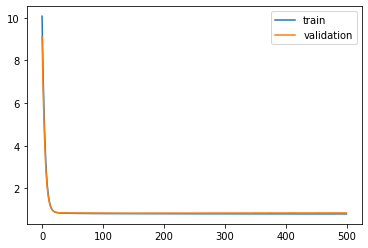

Time to train LSTM:  360.7295801639557


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f09216f45f8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0921a54400>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 3s - loss: 10.1580 - pdc_loss: 0.7456 - event_loss: 0.7395 - val_loss: 9.1834 - val_pdc_loss: 0.7202 - val_event_loss: 0.6885

Epoch 00001: val_loss improved from inf to 9.18338, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 8.4804 - pdc_loss: 0.7054 - event_loss: 0.6526 - val_loss: 7.6532 - val_pdc_loss: 0.6879 - val_event_loss: 0.6144

Epoch 00002: val_loss improved from 9.18338 to 7.65322, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 7.0581 - pdc_loss: 0.6757 - event_loss: 0.5848 - val_loss: 6.3643 - val_pdc_loss: 0.6645 - val_event_loss: 0.5531

Epoch 00003: val_loss improved from 7.65322 to 6.36428, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 5.8640 - pdc_loss: 0.6538 - event_loss: 0.5257 - val_loss: 5.2866 - val_pdc_loss: 0.6470 - val_event_loss: 0.4963

Epoch 00004: val_loss improved from 6.36428 to 5.28656, saving model to Event_val_weights3.hdf5
Epoch 


Epoch 00035: val_loss improved from 0.85434 to 0.85354, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 0.8339 - pdc_loss: 0.5238 - event_loss: 0.2972 - val_loss: 0.8529 - val_pdc_loss: 0.5398 - val_event_loss: 0.3002

Epoch 00036: val_loss improved from 0.85354 to 0.85286, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 0.8331 - pdc_loss: 0.5233 - event_loss: 0.2971 - val_loss: 0.8523 - val_pdc_loss: 0.5395 - val_event_loss: 0.3002

Epoch 00037: val_loss improved from 0.85286 to 0.85233, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 0.8323 - pdc_loss: 0.5228 - event_loss: 0.2970 - val_loss: 0.8519 - val_pdc_loss: 0.5393 - val_event_loss: 0.3001

Epoch 00038: val_loss improved from 0.85233 to 0.85186, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.8316 - pdc_loss: 0.5223 - event_loss: 0.2969 - val_loss: 0.8515 - val_pdc_loss: 0.5391 - val_event_loss: 0.3001

Epoch 00039: val_loss improved from 0.85186 to 


Epoch 00071: val_loss improved from 0.84415 to 0.84385, saving model to Event_val_weights3.hdf5
Epoch 72/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5134 - event_loss: 0.2948 - val_loss: 0.8439 - val_pdc_loss: 0.5330 - val_event_loss: 0.3002

Epoch 00072: val_loss did not improve from 0.84385
Epoch 73/500
 - 1s - loss: 0.8187 - pdc_loss: 0.5132 - event_loss: 0.2948 - val_loss: 0.8439 - val_pdc_loss: 0.5330 - val_event_loss: 0.3001

Epoch 00073: val_loss did not improve from 0.84385
Epoch 74/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5131 - event_loss: 0.2947 - val_loss: 0.8437 - val_pdc_loss: 0.5328 - val_event_loss: 0.3002

Epoch 00074: val_loss improved from 0.84385 to 0.84366, saving model to Event_val_weights3.hdf5
Epoch 75/500
 - 1s - loss: 0.8183 - pdc_loss: 0.5129 - event_loss: 0.2947 - val_loss: 0.8437 - val_pdc_loss: 0.5328 - val_event_loss: 0.3002

Epoch 00075: val_loss did not improve from 0.84366
Epoch 76/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5128 - event_loss: 0.2946 - val_loss: 


Epoch 00110: val_loss did not improve from 0.84180
Epoch 111/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5101 - event_loss: 0.2936 - val_loss: 0.8424 - val_pdc_loss: 0.5318 - val_event_loss: 0.3002

Epoch 00111: val_loss did not improve from 0.84180
Epoch 112/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5100 - event_loss: 0.2935 - val_loss: 0.8422 - val_pdc_loss: 0.5316 - val_event_loss: 0.3002

Epoch 00112: val_loss did not improve from 0.84180
Epoch 113/500
 - 1s - loss: 0.8138 - pdc_loss: 0.5100 - event_loss: 0.2935 - val_loss: 0.8424 - val_pdc_loss: 0.5318 - val_event_loss: 0.3002

Epoch 00113: val_loss did not improve from 0.84180
Epoch 114/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5099 - event_loss: 0.2935 - val_loss: 0.8421 - val_pdc_loss: 0.5315 - val_event_loss: 0.3003

Epoch 00114: val_loss did not improve from 0.84180
Epoch 115/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5099 - event_loss: 0.2934 - val_loss: 0.8422 - val_pdc_loss: 0.5316 - val_event_loss: 0.3003

Epoch 00115: val_loss did not

 - 1s - loss: 0.8109 - pdc_loss: 0.5082 - event_loss: 0.2927 - val_loss: 0.8422 - val_pdc_loss: 0.5315 - val_event_loss: 0.3007

Epoch 00152: val_loss did not improve from 0.84141
Epoch 153/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5082 - event_loss: 0.2926 - val_loss: 0.8422 - val_pdc_loss: 0.5316 - val_event_loss: 0.3005

Epoch 00153: val_loss did not improve from 0.84141
Epoch 154/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5082 - event_loss: 0.2926 - val_loss: 0.8421 - val_pdc_loss: 0.5315 - val_event_loss: 0.3006

Epoch 00154: val_loss did not improve from 0.84141
Epoch 155/500
 - 1s - loss: 0.8107 - pdc_loss: 0.5081 - event_loss: 0.2926 - val_loss: 0.8419 - val_pdc_loss: 0.5313 - val_event_loss: 0.3005

Epoch 00155: val_loss did not improve from 0.84141
Epoch 156/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5080 - event_loss: 0.2926 - val_loss: 0.8417 - val_pdc_loss: 0.5312 - val_event_loss: 0.3005

Epoch 00156: val_loss did not improve from 0.84141
Epoch 157/500
 - 1s - loss: 0.8106 - pdc_los


Epoch 00194: val_loss did not improve from 0.84141
Epoch 195/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5066 - event_loss: 0.2918 - val_loss: 0.8435 - val_pdc_loss: 0.5324 - val_event_loss: 0.3011

Epoch 00195: val_loss did not improve from 0.84141
Epoch 196/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5065 - event_loss: 0.2918 - val_loss: 0.8431 - val_pdc_loss: 0.5322 - val_event_loss: 0.3009

Epoch 00196: val_loss did not improve from 0.84141
Epoch 197/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5065 - event_loss: 0.2918 - val_loss: 0.8431 - val_pdc_loss: 0.5321 - val_event_loss: 0.3009

Epoch 00197: val_loss did not improve from 0.84141
Epoch 198/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5064 - event_loss: 0.2917 - val_loss: 0.8432 - val_pdc_loss: 0.5323 - val_event_loss: 0.3009

Epoch 00198: val_loss did not improve from 0.84141
Epoch 199/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5064 - event_loss: 0.2918 - val_loss: 0.8436 - val_pdc_loss: 0.5325 - val_event_loss: 0.3011

Epoch 00199: val_loss did not

 - 1s - loss: 0.8062 - pdc_loss: 0.5052 - event_loss: 0.2911 - val_loss: 0.8449 - val_pdc_loss: 0.5332 - val_event_loss: 0.3016

Epoch 00237: val_loss did not improve from 0.84141
Epoch 238/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5052 - event_loss: 0.2911 - val_loss: 0.8450 - val_pdc_loss: 0.5335 - val_event_loss: 0.3015

Epoch 00238: val_loss did not improve from 0.84141
Epoch 239/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5051 - event_loss: 0.2911 - val_loss: 0.8452 - val_pdc_loss: 0.5335 - val_event_loss: 0.3017

Epoch 00239: val_loss did not improve from 0.84141
Epoch 240/500
 - 1s - loss: 0.8062 - pdc_loss: 0.5051 - event_loss: 0.2911 - val_loss: 0.8448 - val_pdc_loss: 0.5335 - val_event_loss: 0.3013

Epoch 00240: val_loss did not improve from 0.84141
Epoch 241/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5052 - event_loss: 0.2911 - val_loss: 0.8448 - val_pdc_loss: 0.5334 - val_event_loss: 0.3014

Epoch 00241: val_loss did not improve from 0.84141
Epoch 242/500
 - 1s - loss: 0.8059 - pdc_los


Epoch 00279: val_loss did not improve from 0.84141
Epoch 280/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5041 - event_loss: 0.2909 - val_loss: 0.8463 - val_pdc_loss: 0.5349 - val_event_loss: 0.3013

Epoch 00280: val_loss did not improve from 0.84141
Epoch 281/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5044 - event_loss: 0.2908 - val_loss: 0.8472 - val_pdc_loss: 0.5358 - val_event_loss: 0.3014

Epoch 00281: val_loss did not improve from 0.84141
Epoch 282/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5045 - event_loss: 0.2907 - val_loss: 0.8481 - val_pdc_loss: 0.5367 - val_event_loss: 0.3014

Epoch 00282: val_loss did not improve from 0.84141
Epoch 283/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5045 - event_loss: 0.2907 - val_loss: 0.8485 - val_pdc_loss: 0.5366 - val_event_loss: 0.3018

Epoch 00283: val_loss did not improve from 0.84141
Epoch 284/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5042 - event_loss: 0.2908 - val_loss: 0.8482 - val_pdc_loss: 0.5361 - val_event_loss: 0.3020

Epoch 00284: val_loss did not

 - 1s - loss: 0.8035 - pdc_loss: 0.5030 - event_loss: 0.2904 - val_loss: 0.8468 - val_pdc_loss: 0.5347 - val_event_loss: 0.3019

Epoch 00322: val_loss did not improve from 0.84141
Epoch 323/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5029 - event_loss: 0.2902 - val_loss: 0.8475 - val_pdc_loss: 0.5357 - val_event_loss: 0.3018

Epoch 00323: val_loss did not improve from 0.84141
Epoch 324/500
 - 1s - loss: 0.8035 - pdc_loss: 0.5033 - event_loss: 0.2902 - val_loss: 0.8476 - val_pdc_loss: 0.5357 - val_event_loss: 0.3018

Epoch 00324: val_loss did not improve from 0.84141
Epoch 325/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5033 - event_loss: 0.2904 - val_loss: 0.8486 - val_pdc_loss: 0.5366 - val_event_loss: 0.3020

Epoch 00325: val_loss did not improve from 0.84141
Epoch 326/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5034 - event_loss: 0.2902 - val_loss: 0.8479 - val_pdc_loss: 0.5357 - val_event_loss: 0.3021

Epoch 00326: val_loss did not improve from 0.84141
Epoch 327/500
 - 1s - loss: 0.8037 - pdc_los


Epoch 00364: val_loss did not improve from 0.84141
Epoch 365/500
 - 1s - loss: 0.8028 - pdc_loss: 0.5028 - event_loss: 0.2898 - val_loss: 0.8492 - val_pdc_loss: 0.5362 - val_event_loss: 0.3028

Epoch 00365: val_loss did not improve from 0.84141
Epoch 366/500
 - 1s - loss: 0.8032 - pdc_loss: 0.5029 - event_loss: 0.2900 - val_loss: 0.8490 - val_pdc_loss: 0.5363 - val_event_loss: 0.3024

Epoch 00366: val_loss did not improve from 0.84141
Epoch 367/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5031 - event_loss: 0.2900 - val_loss: 0.8493 - val_pdc_loss: 0.5359 - val_event_loss: 0.3033

Epoch 00367: val_loss did not improve from 0.84141
Epoch 368/500
 - 1s - loss: 0.8028 - pdc_loss: 0.5026 - event_loss: 0.2901 - val_loss: 0.8499 - val_pdc_loss: 0.5364 - val_event_loss: 0.3033

Epoch 00368: val_loss did not improve from 0.84141
Epoch 369/500
 - 1s - loss: 0.8028 - pdc_loss: 0.5027 - event_loss: 0.2900 - val_loss: 0.8492 - val_pdc_loss: 0.5363 - val_event_loss: 0.3027

Epoch 00369: val_loss did not

 - 1s - loss: 0.8009 - pdc_loss: 0.5017 - event_loss: 0.2892 - val_loss: 0.8495 - val_pdc_loss: 0.5369 - val_event_loss: 0.3026

Epoch 00407: val_loss did not improve from 0.84141
Epoch 408/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5017 - event_loss: 0.2893 - val_loss: 0.8500 - val_pdc_loss: 0.5371 - val_event_loss: 0.3030

Epoch 00408: val_loss did not improve from 0.84141
Epoch 409/500
 - 1s - loss: 0.8008 - pdc_loss: 0.5016 - event_loss: 0.2893 - val_loss: 0.8476 - val_pdc_loss: 0.5354 - val_event_loss: 0.3022

Epoch 00409: val_loss did not improve from 0.84141
Epoch 410/500
 - 1s - loss: 0.8012 - pdc_loss: 0.5017 - event_loss: 0.2895 - val_loss: 0.8503 - val_pdc_loss: 0.5370 - val_event_loss: 0.3033

Epoch 00410: val_loss did not improve from 0.84141
Epoch 411/500
 - 1s - loss: 0.8015 - pdc_loss: 0.5021 - event_loss: 0.2893 - val_loss: 0.8507 - val_pdc_loss: 0.5380 - val_event_loss: 0.3025

Epoch 00411: val_loss did not improve from 0.84141
Epoch 412/500
 - 1s - loss: 0.8012 - pdc_los


Epoch 00449: val_loss did not improve from 0.84141
Epoch 450/500
 - 1s - loss: 0.8011 - pdc_loss: 0.5018 - event_loss: 0.2891 - val_loss: 0.8512 - val_pdc_loss: 0.5383 - val_event_loss: 0.3028

Epoch 00450: val_loss did not improve from 0.84141
Epoch 451/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5014 - event_loss: 0.2894 - val_loss: 0.8508 - val_pdc_loss: 0.5374 - val_event_loss: 0.3031

Epoch 00451: val_loss did not improve from 0.84141
Epoch 452/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5016 - event_loss: 0.2891 - val_loss: 0.8515 - val_pdc_loss: 0.5384 - val_event_loss: 0.3029

Epoch 00452: val_loss did not improve from 0.84141
Epoch 453/500
 - 1s - loss: 0.8008 - pdc_loss: 0.5014 - event_loss: 0.2893 - val_loss: 0.8506 - val_pdc_loss: 0.5373 - val_event_loss: 0.3032

Epoch 00453: val_loss did not improve from 0.84141
Epoch 454/500
 - 1s - loss: 0.8001 - pdc_loss: 0.5009 - event_loss: 0.2891 - val_loss: 0.8511 - val_pdc_loss: 0.5380 - val_event_loss: 0.3030

Epoch 00454: val_loss did not

 - 1s - loss: 0.7998 - pdc_loss: 0.5007 - event_loss: 0.2889 - val_loss: 0.8501 - val_pdc_loss: 0.5373 - val_event_loss: 0.3026

Epoch 00492: val_loss did not improve from 0.84141
Epoch 493/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5009 - event_loss: 0.2888 - val_loss: 0.8492 - val_pdc_loss: 0.5362 - val_event_loss: 0.3028

Epoch 00493: val_loss did not improve from 0.84141
Epoch 494/500
 - 1s - loss: 0.7999 - pdc_loss: 0.5008 - event_loss: 0.2889 - val_loss: 0.8503 - val_pdc_loss: 0.5373 - val_event_loss: 0.3029

Epoch 00494: val_loss did not improve from 0.84141
Epoch 495/500
 - 1s - loss: 0.7997 - pdc_loss: 0.5009 - event_loss: 0.2887 - val_loss: 0.8520 - val_pdc_loss: 0.5389 - val_event_loss: 0.3029

Epoch 00495: val_loss did not improve from 0.84141
Epoch 496/500
 - 1s - loss: 0.7999 - pdc_loss: 0.5010 - event_loss: 0.2887 - val_loss: 0.8524 - val_pdc_loss: 0.5388 - val_event_loss: 0.3033

Epoch 00496: val_loss did not improve from 0.84141
Epoch 497/500
 - 1s - loss: 0.8001 - pdc_los

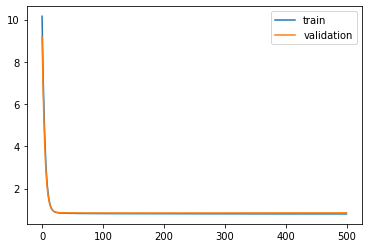

Time to train LSTM:  367.2665822505951
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 4s - loss: 10.0874 - pdc_loss: 0.7281 - event_loss: 0.6729 - val_loss: 9.1250 - val_pdc_loss: 0.7040 - val_event_loss: 0.6402

Epoch 00001: val_loss improved from inf to 9.12504, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 8.4359 - pdc_loss: 0.6929 - event_loss: 0.6185 - val_loss: 7.6155 - val_pdc_loss: 0.6741 - val_event_loss: 0.5924

Epoch 00002: val_loss improved from 9.12504 to 7.61553, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 7.0314 - pdc_loss: 0.6652 - event_loss: 0.5720 - val_loss: 6.3421 - val_pdc_loss: 0.6510 - val_event_loss: 0.5488

Epoch 00003: val_loss improved from 7.61553 to 6.34209, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 5.8510 - pdc_loss: 0.6434 - event_loss: 0.5269 - val_loss: 5.2768 - val_pdc_loss: 0.6328 - val_event_loss: 0.5036

Epoch 00004: val_loss improved from 6.34209 to 5.27676, saving 


Epoch 00035: val_loss improved from 0.85692 to 0.85620, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 0.8315 - pdc_loss: 0.5228 - event_loss: 0.2963 - val_loss: 0.8556 - val_pdc_loss: 0.5401 - val_event_loss: 0.3031

Epoch 00036: val_loss improved from 0.85620 to 0.85556, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.8308 - pdc_loss: 0.5223 - event_loss: 0.2962 - val_loss: 0.8550 - val_pdc_loss: 0.5398 - val_event_loss: 0.3030

Epoch 00037: val_loss improved from 0.85556 to 0.85500, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.8301 - pdc_loss: 0.5219 - event_loss: 0.2961 - val_loss: 0.8546 - val_pdc_loss: 0.5396 - val_event_loss: 0.3030

Epoch 00038: val_loss improved from 0.85500 to 0.85456, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8294 - pdc_loss: 0.5214 - event_loss: 0.2960 - val_loss: 0.8541 - val_pdc_loss: 0.5393 - val_event_loss: 0.3029

Epoch 00039: val_loss improved from 0.85456 to 


Epoch 00070: val_loss improved from 0.84882 to 0.84872, saving model to Event_val_weights4.hdf5
Epoch 71/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5138 - event_loss: 0.2944 - val_loss: 0.8486 - val_pdc_loss: 0.5356 - val_event_loss: 0.3026

Epoch 00071: val_loss improved from 0.84872 to 0.84857, saving model to Event_val_weights4.hdf5
Epoch 72/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5136 - event_loss: 0.2944 - val_loss: 0.8485 - val_pdc_loss: 0.5355 - val_event_loss: 0.3026

Epoch 00072: val_loss improved from 0.84857 to 0.84854, saving model to Event_val_weights4.hdf5
Epoch 73/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5135 - event_loss: 0.2944 - val_loss: 0.8483 - val_pdc_loss: 0.5354 - val_event_loss: 0.3026

Epoch 00073: val_loss improved from 0.84854 to 0.84832, saving model to Event_val_weights4.hdf5
Epoch 74/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5134 - event_loss: 0.2943 - val_loss: 0.8483 - val_pdc_loss: 0.5354 - val_event_loss: 0.3026

Epoch 00074: val_loss did not improve from 0.84

 - 1s - loss: 0.8137 - pdc_loss: 0.5109 - event_loss: 0.2931 - val_loss: 0.8456 - val_pdc_loss: 0.5336 - val_event_loss: 0.3021

Epoch 00107: val_loss improved from 0.84575 to 0.84557, saving model to Event_val_weights4.hdf5
Epoch 108/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5108 - event_loss: 0.2930 - val_loss: 0.8456 - val_pdc_loss: 0.5336 - val_event_loss: 0.3021

Epoch 00108: val_loss did not improve from 0.84557
Epoch 109/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5108 - event_loss: 0.2930 - val_loss: 0.8455 - val_pdc_loss: 0.5336 - val_event_loss: 0.3022

Epoch 00109: val_loss improved from 0.84557 to 0.84554, saving model to Event_val_weights4.hdf5
Epoch 110/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5107 - event_loss: 0.2930 - val_loss: 0.8456 - val_pdc_loss: 0.5336 - val_event_loss: 0.3022

Epoch 00110: val_loss did not improve from 0.84554
Epoch 111/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5107 - event_loss: 0.2929 - val_loss: 0.8455 - val_pdc_loss: 0.5335 - val_event_loss: 0.3021

Epoch


Epoch 00144: val_loss did not improve from 0.84421
Epoch 145/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5090 - event_loss: 0.2917 - val_loss: 0.8445 - val_pdc_loss: 0.5323 - val_event_loss: 0.3024

Epoch 00145: val_loss did not improve from 0.84421
Epoch 146/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5089 - event_loss: 0.2917 - val_loss: 0.8443 - val_pdc_loss: 0.5322 - val_event_loss: 0.3023

Epoch 00146: val_loss did not improve from 0.84421
Epoch 147/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5090 - event_loss: 0.2917 - val_loss: 0.8445 - val_pdc_loss: 0.5322 - val_event_loss: 0.3025

Epoch 00147: val_loss did not improve from 0.84421
Epoch 148/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5088 - event_loss: 0.2916 - val_loss: 0.8444 - val_pdc_loss: 0.5322 - val_event_loss: 0.3024

Epoch 00148: val_loss did not improve from 0.84421
Epoch 149/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5089 - event_loss: 0.2916 - val_loss: 0.8446 - val_pdc_loss: 0.5321 - val_event_loss: 0.3026

Epoch 00149: val_loss did not


Epoch 00186: val_loss did not improve from 0.84406
Epoch 187/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5071 - event_loss: 0.2905 - val_loss: 0.8449 - val_pdc_loss: 0.5317 - val_event_loss: 0.3034

Epoch 00187: val_loss did not improve from 0.84406
Epoch 188/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5071 - event_loss: 0.2905 - val_loss: 0.8453 - val_pdc_loss: 0.5321 - val_event_loss: 0.3035

Epoch 00188: val_loss did not improve from 0.84406
Epoch 189/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5070 - event_loss: 0.2904 - val_loss: 0.8450 - val_pdc_loss: 0.5317 - val_event_loss: 0.3035

Epoch 00189: val_loss did not improve from 0.84406
Epoch 190/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5070 - event_loss: 0.2905 - val_loss: 0.8450 - val_pdc_loss: 0.5319 - val_event_loss: 0.3034

Epoch 00190: val_loss did not improve from 0.84406
Epoch 191/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5069 - event_loss: 0.2905 - val_loss: 0.8450 - val_pdc_loss: 0.5319 - val_event_loss: 0.3034

Epoch 00191: val_loss did not

 - 1s - loss: 0.8052 - pdc_loss: 0.5054 - event_loss: 0.2899 - val_loss: 0.8486 - val_pdc_loss: 0.5338 - val_event_loss: 0.3050

Epoch 00229: val_loss did not improve from 0.84406
Epoch 230/500
 - 1s - loss: 0.8051 - pdc_loss: 0.5054 - event_loss: 0.2899 - val_loss: 0.8483 - val_pdc_loss: 0.5337 - val_event_loss: 0.3047

Epoch 00230: val_loss did not improve from 0.84406
Epoch 231/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5053 - event_loss: 0.2899 - val_loss: 0.8487 - val_pdc_loss: 0.5337 - val_event_loss: 0.3053

Epoch 00231: val_loss did not improve from 0.84406
Epoch 232/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5053 - event_loss: 0.2899 - val_loss: 0.8483 - val_pdc_loss: 0.5336 - val_event_loss: 0.3048

Epoch 00232: val_loss did not improve from 0.84406
Epoch 233/500
 - 1s - loss: 0.8051 - pdc_loss: 0.5054 - event_loss: 0.2899 - val_loss: 0.8479 - val_pdc_loss: 0.5332 - val_event_loss: 0.3048

Epoch 00233: val_loss did not improve from 0.84406
Epoch 234/500
 - 1s - loss: 0.8053 - pdc_los


Epoch 00271: val_loss did not improve from 0.84406
Epoch 272/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5044 - event_loss: 0.2894 - val_loss: 0.8481 - val_pdc_loss: 0.5339 - val_event_loss: 0.3044

Epoch 00272: val_loss did not improve from 0.84406
Epoch 273/500
 - 1s - loss: 0.8035 - pdc_loss: 0.5043 - event_loss: 0.2893 - val_loss: 0.8481 - val_pdc_loss: 0.5342 - val_event_loss: 0.3041

Epoch 00273: val_loss did not improve from 0.84406
Epoch 274/500
 - 1s - loss: 0.8032 - pdc_loss: 0.5045 - event_loss: 0.2889 - val_loss: 0.8489 - val_pdc_loss: 0.5343 - val_event_loss: 0.3047

Epoch 00274: val_loss did not improve from 0.84406
Epoch 275/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5047 - event_loss: 0.2888 - val_loss: 0.8494 - val_pdc_loss: 0.5342 - val_event_loss: 0.3053

Epoch 00275: val_loss did not improve from 0.84406
Epoch 276/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5045 - event_loss: 0.2890 - val_loss: 0.8488 - val_pdc_loss: 0.5335 - val_event_loss: 0.3055

Epoch 00276: val_loss did not

 - 1s - loss: 0.8026 - pdc_loss: 0.5038 - event_loss: 0.2888 - val_loss: 0.8507 - val_pdc_loss: 0.5357 - val_event_loss: 0.3051

Epoch 00314: val_loss did not improve from 0.84406
Epoch 315/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5043 - event_loss: 0.2891 - val_loss: 0.8512 - val_pdc_loss: 0.5358 - val_event_loss: 0.3054

Epoch 00315: val_loss did not improve from 0.84406
Epoch 316/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5044 - event_loss: 0.2892 - val_loss: 0.8496 - val_pdc_loss: 0.5351 - val_event_loss: 0.3045

Epoch 00316: val_loss did not improve from 0.84406
Epoch 317/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5039 - event_loss: 0.2895 - val_loss: 0.8486 - val_pdc_loss: 0.5339 - val_event_loss: 0.3048

Epoch 00317: val_loss did not improve from 0.84406
Epoch 318/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5043 - event_loss: 0.2893 - val_loss: 0.8508 - val_pdc_loss: 0.5351 - val_event_loss: 0.3058

Epoch 00318: val_loss did not improve from 0.84406
Epoch 319/500
 - 1s - loss: 0.8034 - pdc_los


Epoch 00356: val_loss did not improve from 0.84406
Epoch 357/500
 - 1s - loss: 0.8021 - pdc_loss: 0.5038 - event_loss: 0.2883 - val_loss: 0.8530 - val_pdc_loss: 0.5370 - val_event_loss: 0.3059

Epoch 00357: val_loss did not improve from 0.84406
Epoch 358/500
 - 1s - loss: 0.8020 - pdc_loss: 0.5036 - event_loss: 0.2882 - val_loss: 0.8515 - val_pdc_loss: 0.5361 - val_event_loss: 0.3053

Epoch 00358: val_loss did not improve from 0.84406
Epoch 359/500
 - 1s - loss: 0.8018 - pdc_loss: 0.5033 - event_loss: 0.2884 - val_loss: 0.8517 - val_pdc_loss: 0.5364 - val_event_loss: 0.3052

Epoch 00359: val_loss did not improve from 0.84406
Epoch 360/500
 - 1s - loss: 0.8019 - pdc_loss: 0.5033 - event_loss: 0.2885 - val_loss: 0.8527 - val_pdc_loss: 0.5371 - val_event_loss: 0.3055

Epoch 00360: val_loss did not improve from 0.84406
Epoch 361/500
 - 1s - loss: 0.8023 - pdc_loss: 0.5038 - event_loss: 0.2883 - val_loss: 0.8545 - val_pdc_loss: 0.5382 - val_event_loss: 0.3062

Epoch 00361: val_loss did not

 - 1s - loss: 0.8010 - pdc_loss: 0.5027 - event_loss: 0.2880 - val_loss: 0.8544 - val_pdc_loss: 0.5383 - val_event_loss: 0.3059

Epoch 00399: val_loss did not improve from 0.84406
Epoch 400/500
 - 1s - loss: 0.8012 - pdc_loss: 0.5029 - event_loss: 0.2881 - val_loss: 0.8528 - val_pdc_loss: 0.5372 - val_event_loss: 0.3054

Epoch 00400: val_loss did not improve from 0.84406
Epoch 401/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5028 - event_loss: 0.2881 - val_loss: 0.8544 - val_pdc_loss: 0.5389 - val_event_loss: 0.3055

Epoch 00401: val_loss did not improve from 0.84406
Epoch 402/500
 - 1s - loss: 0.8008 - pdc_loss: 0.5025 - event_loss: 0.2882 - val_loss: 0.8558 - val_pdc_loss: 0.5395 - val_event_loss: 0.3061

Epoch 00402: val_loss did not improve from 0.84406
Epoch 403/500
 - 1s - loss: 0.8006 - pdc_loss: 0.5026 - event_loss: 0.2878 - val_loss: 0.8550 - val_pdc_loss: 0.5390 - val_event_loss: 0.3058

Epoch 00403: val_loss did not improve from 0.84406
Epoch 404/500
 - 1s - loss: 0.8008 - pdc_los


Epoch 00441: val_loss did not improve from 0.84406
Epoch 442/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5022 - event_loss: 0.2874 - val_loss: 0.8518 - val_pdc_loss: 0.5364 - val_event_loss: 0.3051

Epoch 00442: val_loss did not improve from 0.84406
Epoch 443/500
 - 1s - loss: 0.7996 - pdc_loss: 0.5016 - event_loss: 0.2877 - val_loss: 0.8532 - val_pdc_loss: 0.5372 - val_event_loss: 0.3057

Epoch 00443: val_loss did not improve from 0.84406
Epoch 444/500
 - 1s - loss: 0.7999 - pdc_loss: 0.5021 - event_loss: 0.2875 - val_loss: 0.8560 - val_pdc_loss: 0.5396 - val_event_loss: 0.3061

Epoch 00444: val_loss did not improve from 0.84406
Epoch 445/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5023 - event_loss: 0.2873 - val_loss: 0.8527 - val_pdc_loss: 0.5370 - val_event_loss: 0.3056

Epoch 00445: val_loss did not improve from 0.84406
Epoch 446/500
 - 1s - loss: 0.8001 - pdc_loss: 0.5027 - event_loss: 0.2872 - val_loss: 0.8525 - val_pdc_loss: 0.5373 - val_event_loss: 0.3051

Epoch 00446: val_loss did not

 - 1s - loss: 0.7999 - pdc_loss: 0.5020 - event_loss: 0.2876 - val_loss: 0.8550 - val_pdc_loss: 0.5376 - val_event_loss: 0.3071

Epoch 00484: val_loss did not improve from 0.84406
Epoch 485/500
 - 1s - loss: 0.7993 - pdc_loss: 0.5017 - event_loss: 0.2873 - val_loss: 0.8536 - val_pdc_loss: 0.5380 - val_event_loss: 0.3054

Epoch 00485: val_loss did not improve from 0.84406
Epoch 486/500
 - 1s - loss: 0.7993 - pdc_loss: 0.5018 - event_loss: 0.2872 - val_loss: 0.8541 - val_pdc_loss: 0.5386 - val_event_loss: 0.3053

Epoch 00486: val_loss did not improve from 0.84406
Epoch 487/500
 - 1s - loss: 0.7997 - pdc_loss: 0.5018 - event_loss: 0.2875 - val_loss: 0.8558 - val_pdc_loss: 0.5398 - val_event_loss: 0.3057

Epoch 00487: val_loss did not improve from 0.84406
Epoch 488/500
 - 1s - loss: 0.7996 - pdc_loss: 0.5019 - event_loss: 0.2873 - val_loss: 0.8553 - val_pdc_loss: 0.5381 - val_event_loss: 0.3068

Epoch 00488: val_loss did not improve from 0.84406
Epoch 489/500
 - 1s - loss: 0.8003 - pdc_los

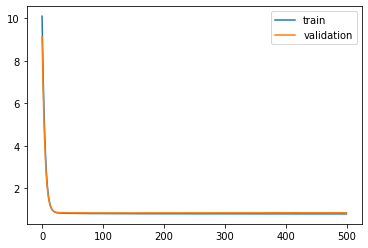

Time to train LSTM:  345.8493950366974
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 4s - loss: 10.1806 - pdc_loss: 0.7096 - event_loss: 0.7370 - val_loss: 9.2070 - val_pdc_loss: 0.6919 - val_event_loss: 0.6910

Epoch 00001: val_loss improved from inf to 9.20696, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 8.5104 - pdc_loss: 0.6849 - event_loss: 0.6617 - val_loss: 7.6789 - val_pdc_loss: 0.6712 - val_event_loss: 0.6247

Epoch 00002: val_loss improved from 9.20696 to 7.67889, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 7.0918 - pdc_loss: 0.6668 - event_loss: 0.6012 - val_loss: 6.3908 - val_pdc_loss: 0.6559 - val_event_loss: 0.5686

Epoch 00003: val_loss improved from 7.67889 to 6.39078, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 5.9008 - pdc_loss: 0.6529 - event_loss: 0.5477 - val_loss: 5.3147 - val_pdc_loss: 0.6433 - val_event_loss: 0.5166

Epoch 00004: val_loss improved from 6.39078 to 5.31467, saving 


Epoch 00035: val_loss improved from 0.84511 to 0.84420, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.8397 - pdc_loss: 0.5287 - event_loss: 0.2974 - val_loss: 0.8438 - val_pdc_loss: 0.5306 - val_event_loss: 0.2997

Epoch 00036: val_loss improved from 0.84420 to 0.84383, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.8388 - pdc_loss: 0.5281 - event_loss: 0.2972 - val_loss: 0.8429 - val_pdc_loss: 0.5300 - val_event_loss: 0.2996

Epoch 00037: val_loss improved from 0.84383 to 0.84289, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.8381 - pdc_loss: 0.5276 - event_loss: 0.2971 - val_loss: 0.8425 - val_pdc_loss: 0.5297 - val_event_loss: 0.2995

Epoch 00038: val_loss improved from 0.84289 to 0.84246, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 0.8373 - pdc_loss: 0.5271 - event_loss: 0.2970 - val_loss: 0.8416 - val_pdc_loss: 0.5291 - val_event_loss: 0.2994

Epoch 00039: val_loss improved from 0.84246 to 


Epoch 00070: val_loss improved from 0.83036 to 0.83011, saving model to Event_val_weights5.hdf5
Epoch 71/500
 - 1s - loss: 0.8230 - pdc_loss: 0.5166 - event_loss: 0.2951 - val_loss: 0.8301 - val_pdc_loss: 0.5207 - val_event_loss: 0.2980

Epoch 00071: val_loss improved from 0.83011 to 0.83009, saving model to Event_val_weights5.hdf5
Epoch 72/500
 - 1s - loss: 0.8228 - pdc_loss: 0.5164 - event_loss: 0.2951 - val_loss: 0.8297 - val_pdc_loss: 0.5204 - val_event_loss: 0.2980

Epoch 00072: val_loss improved from 0.83009 to 0.82969, saving model to Event_val_weights5.hdf5
Epoch 73/500
 - 1s - loss: 0.8226 - pdc_loss: 0.5163 - event_loss: 0.2950 - val_loss: 0.8300 - val_pdc_loss: 0.5206 - val_event_loss: 0.2981

Epoch 00073: val_loss did not improve from 0.82969
Epoch 74/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5161 - event_loss: 0.2950 - val_loss: 0.8296 - val_pdc_loss: 0.5204 - val_event_loss: 0.2979

Epoch 00074: val_loss improved from 0.82969 to 0.82955, saving model to Event_val_weights5.h

 - 1s - loss: 0.8172 - pdc_loss: 0.5125 - event_loss: 0.2942 - val_loss: 0.8277 - val_pdc_loss: 0.5190 - val_event_loss: 0.2982

Epoch 00108: val_loss did not improve from 0.82768
Epoch 109/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5125 - event_loss: 0.2942 - val_loss: 0.8276 - val_pdc_loss: 0.5190 - val_event_loss: 0.2981

Epoch 00109: val_loss improved from 0.82768 to 0.82756, saving model to Event_val_weights5.hdf5
Epoch 110/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5124 - event_loss: 0.2942 - val_loss: 0.8278 - val_pdc_loss: 0.5192 - val_event_loss: 0.2982

Epoch 00110: val_loss did not improve from 0.82756
Epoch 111/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5123 - event_loss: 0.2942 - val_loss: 0.8275 - val_pdc_loss: 0.5190 - val_event_loss: 0.2982

Epoch 00111: val_loss improved from 0.82756 to 0.82755, saving model to Event_val_weights5.hdf5
Epoch 112/500
 - 1s - loss: 0.8168 - pdc_loss: 0.5123 - event_loss: 0.2942 - val_loss: 0.8277 - val_pdc_loss: 0.5192 - val_event_loss: 0.2981

Epoch


Epoch 00148: val_loss did not improve from 0.82685
Epoch 149/500
 - 1s - loss: 0.8135 - pdc_loss: 0.5101 - event_loss: 0.2934 - val_loss: 0.8268 - val_pdc_loss: 0.5189 - val_event_loss: 0.2979

Epoch 00149: val_loss improved from 0.82685 to 0.82683, saving model to Event_val_weights5.hdf5
Epoch 150/500
 - 1s - loss: 0.8135 - pdc_loss: 0.5101 - event_loss: 0.2934 - val_loss: 0.8274 - val_pdc_loss: 0.5192 - val_event_loss: 0.2981

Epoch 00150: val_loss did not improve from 0.82683
Epoch 151/500
 - 1s - loss: 0.8133 - pdc_loss: 0.5099 - event_loss: 0.2934 - val_loss: 0.8270 - val_pdc_loss: 0.5187 - val_event_loss: 0.2983

Epoch 00151: val_loss did not improve from 0.82683
Epoch 152/500
 - 1s - loss: 0.8133 - pdc_loss: 0.5099 - event_loss: 0.2933 - val_loss: 0.8269 - val_pdc_loss: 0.5189 - val_event_loss: 0.2980

Epoch 00152: val_loss did not improve from 0.82683
Epoch 153/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5098 - event_loss: 0.2933 - val_loss: 0.8269 - val_pdc_loss: 0.5188 - val_even


Epoch 00190: val_loss did not improve from 0.82674
Epoch 191/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5081 - event_loss: 0.2926 - val_loss: 0.8274 - val_pdc_loss: 0.5195 - val_event_loss: 0.2980

Epoch 00191: val_loss did not improve from 0.82674
Epoch 192/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5080 - event_loss: 0.2926 - val_loss: 0.8279 - val_pdc_loss: 0.5198 - val_event_loss: 0.2983

Epoch 00192: val_loss did not improve from 0.82674
Epoch 193/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5080 - event_loss: 0.2926 - val_loss: 0.8280 - val_pdc_loss: 0.5197 - val_event_loss: 0.2985

Epoch 00193: val_loss did not improve from 0.82674
Epoch 194/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5079 - event_loss: 0.2926 - val_loss: 0.8278 - val_pdc_loss: 0.5198 - val_event_loss: 0.2982

Epoch 00194: val_loss did not improve from 0.82674
Epoch 195/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5080 - event_loss: 0.2926 - val_loss: 0.8283 - val_pdc_loss: 0.5201 - val_event_loss: 0.2983

Epoch 00195: val_loss did not

 - 1s - loss: 0.8083 - pdc_loss: 0.5067 - event_loss: 0.2920 - val_loss: 0.8294 - val_pdc_loss: 0.5208 - val_event_loss: 0.2989

Epoch 00233: val_loss did not improve from 0.82674
Epoch 234/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5066 - event_loss: 0.2920 - val_loss: 0.8290 - val_pdc_loss: 0.5205 - val_event_loss: 0.2988

Epoch 00234: val_loss did not improve from 0.82674
Epoch 235/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5066 - event_loss: 0.2920 - val_loss: 0.8298 - val_pdc_loss: 0.5214 - val_event_loss: 0.2987

Epoch 00235: val_loss did not improve from 0.82674
Epoch 236/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5065 - event_loss: 0.2920 - val_loss: 0.8294 - val_pdc_loss: 0.5206 - val_event_loss: 0.2990

Epoch 00236: val_loss did not improve from 0.82674
Epoch 237/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5065 - event_loss: 0.2919 - val_loss: 0.8298 - val_pdc_loss: 0.5213 - val_event_loss: 0.2988

Epoch 00237: val_loss did not improve from 0.82674
Epoch 238/500
 - 1s - loss: 0.8083 - pdc_los


Epoch 00275: val_loss did not improve from 0.82674
Epoch 276/500
 - 1s - loss: 0.8062 - pdc_loss: 0.5053 - event_loss: 0.2914 - val_loss: 0.8283 - val_pdc_loss: 0.5201 - val_event_loss: 0.2986

Epoch 00276: val_loss did not improve from 0.82674
Epoch 277/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5050 - event_loss: 0.2914 - val_loss: 0.8283 - val_pdc_loss: 0.5197 - val_event_loss: 0.2990

Epoch 00277: val_loss did not improve from 0.82674
Epoch 278/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5050 - event_loss: 0.2915 - val_loss: 0.8295 - val_pdc_loss: 0.5210 - val_event_loss: 0.2990

Epoch 00278: val_loss did not improve from 0.82674
Epoch 279/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5052 - event_loss: 0.2914 - val_loss: 0.8297 - val_pdc_loss: 0.5212 - val_event_loss: 0.2989

Epoch 00279: val_loss did not improve from 0.82674
Epoch 280/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5054 - event_loss: 0.2914 - val_loss: 0.8305 - val_pdc_loss: 0.5220 - val_event_loss: 0.2989

Epoch 00280: val_loss did not

 - 1s - loss: 0.8060 - pdc_loss: 0.5054 - event_loss: 0.2911 - val_loss: 0.8298 - val_pdc_loss: 0.5207 - val_event_loss: 0.2996

Epoch 00318: val_loss did not improve from 0.82674
Epoch 319/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5053 - event_loss: 0.2911 - val_loss: 0.8287 - val_pdc_loss: 0.5196 - val_event_loss: 0.2995

Epoch 00319: val_loss did not improve from 0.82674
Epoch 320/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5050 - event_loss: 0.2910 - val_loss: 0.8289 - val_pdc_loss: 0.5196 - val_event_loss: 0.2997

Epoch 00320: val_loss did not improve from 0.82674
Epoch 321/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5047 - event_loss: 0.2910 - val_loss: 0.8289 - val_pdc_loss: 0.5198 - val_event_loss: 0.2996

Epoch 00321: val_loss did not improve from 0.82674
Epoch 322/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5043 - event_loss: 0.2910 - val_loss: 0.8287 - val_pdc_loss: 0.5199 - val_event_loss: 0.2993

Epoch 00322: val_loss did not improve from 0.82674
Epoch 323/500
 - 1s - loss: 0.8050 - pdc_los


Epoch 00360: val_loss did not improve from 0.82674
Epoch 361/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5037 - event_loss: 0.2907 - val_loss: 0.8286 - val_pdc_loss: 0.5199 - val_event_loss: 0.2993

Epoch 00361: val_loss did not improve from 0.82674
Epoch 362/500
 - 1s - loss: 0.8040 - pdc_loss: 0.5037 - event_loss: 0.2909 - val_loss: 0.8294 - val_pdc_loss: 0.5206 - val_event_loss: 0.2994

Epoch 00362: val_loss did not improve from 0.82674
Epoch 363/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5039 - event_loss: 0.2908 - val_loss: 0.8292 - val_pdc_loss: 0.5208 - val_event_loss: 0.2990

Epoch 00363: val_loss did not improve from 0.82674
Epoch 364/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5041 - event_loss: 0.2907 - val_loss: 0.8289 - val_pdc_loss: 0.5201 - val_event_loss: 0.2994

Epoch 00364: val_loss did not improve from 0.82674
Epoch 365/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5041 - event_loss: 0.2907 - val_loss: 0.8294 - val_pdc_loss: 0.5208 - val_event_loss: 0.2992

Epoch 00365: val_loss did not

 - 1s - loss: 0.8039 - pdc_loss: 0.5039 - event_loss: 0.2906 - val_loss: 0.8293 - val_pdc_loss: 0.5211 - val_event_loss: 0.2987

Epoch 00403: val_loss did not improve from 0.82674
Epoch 404/500
 - 1s - loss: 0.8035 - pdc_loss: 0.5034 - event_loss: 0.2906 - val_loss: 0.8298 - val_pdc_loss: 0.5207 - val_event_loss: 0.2996

Epoch 00404: val_loss did not improve from 0.82674
Epoch 405/500
 - 1s - loss: 0.8032 - pdc_loss: 0.5031 - event_loss: 0.2907 - val_loss: 0.8296 - val_pdc_loss: 0.5211 - val_event_loss: 0.2990

Epoch 00405: val_loss did not improve from 0.82674
Epoch 406/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5032 - event_loss: 0.2906 - val_loss: 0.8298 - val_pdc_loss: 0.5214 - val_event_loss: 0.2990

Epoch 00406: val_loss did not improve from 0.82674
Epoch 407/500
 - 1s - loss: 0.8032 - pdc_loss: 0.5033 - event_loss: 0.2905 - val_loss: 0.8297 - val_pdc_loss: 0.5210 - val_event_loss: 0.2992

Epoch 00407: val_loss did not improve from 0.82674
Epoch 408/500
 - 1s - loss: 0.8035 - pdc_los


Epoch 00445: val_loss did not improve from 0.82674
Epoch 446/500
 - 1s - loss: 0.8035 - pdc_loss: 0.5032 - event_loss: 0.2909 - val_loss: 0.8314 - val_pdc_loss: 0.5229 - val_event_loss: 0.2990

Epoch 00446: val_loss did not improve from 0.82674
Epoch 447/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5033 - event_loss: 0.2911 - val_loss: 0.8314 - val_pdc_loss: 0.5221 - val_event_loss: 0.2999

Epoch 00447: val_loss did not improve from 0.82674
Epoch 448/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5033 - event_loss: 0.2906 - val_loss: 0.8333 - val_pdc_loss: 0.5225 - val_event_loss: 0.3011

Epoch 00448: val_loss did not improve from 0.82674
Epoch 449/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5040 - event_loss: 0.2908 - val_loss: 0.8332 - val_pdc_loss: 0.5232 - val_event_loss: 0.3003

Epoch 00449: val_loss did not improve from 0.82674
Epoch 450/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5036 - event_loss: 0.2907 - val_loss: 0.8306 - val_pdc_loss: 0.5221 - val_event_loss: 0.2988

Epoch 00450: val_loss did not

 - 1s - loss: 0.8023 - pdc_loss: 0.5027 - event_loss: 0.2898 - val_loss: 0.8308 - val_pdc_loss: 0.5216 - val_event_loss: 0.2995

Epoch 00488: val_loss did not improve from 0.82674
Epoch 489/500
 - 1s - loss: 0.8018 - pdc_loss: 0.5023 - event_loss: 0.2898 - val_loss: 0.8306 - val_pdc_loss: 0.5214 - val_event_loss: 0.2995

Epoch 00489: val_loss did not improve from 0.82674
Epoch 490/500
 - 1s - loss: 0.8012 - pdc_loss: 0.5016 - event_loss: 0.2898 - val_loss: 0.8308 - val_pdc_loss: 0.5215 - val_event_loss: 0.2995

Epoch 00490: val_loss did not improve from 0.82674
Epoch 491/500
 - 1s - loss: 0.8013 - pdc_loss: 0.5016 - event_loss: 0.2901 - val_loss: 0.8316 - val_pdc_loss: 0.5220 - val_event_loss: 0.2999

Epoch 00491: val_loss did not improve from 0.82674
Epoch 492/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5020 - event_loss: 0.2900 - val_loss: 0.8313 - val_pdc_loss: 0.5222 - val_event_loss: 0.2995

Epoch 00492: val_loss did not improve from 0.82674
Epoch 493/500
 - 1s - loss: 0.8015 - pdc_los

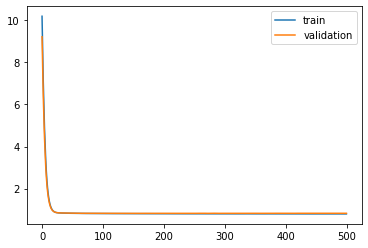

Time to train LSTM:  351.93647170066833
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 4s - loss: 10.4496 - pdc_loss: 0.7070 - event_loss: 0.6823 - val_loss: 9.9017 - val_pdc_loss: 0.7005 - val_event_loss: 0.6551

Epoch 00001: val_loss improved from inf to 9.90170, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 9.5637 - pdc_loss: 0.6940 - event_loss: 0.6450 - val_loss: 9.0548 - val_pdc_loss: 0.6886 - val_event_loss: 0.6211

Epoch 00002: val_loss improved from 9.90170 to 9.05485, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 8.7418 - pdc_loss: 0.6824 - event_loss: 0.6126 - val_loss: 8.2713 - val_pdc_loss: 0.6779 - val_event_loss: 0.5908

Epoch 00003: val_loss improved from 9.05485 to 8.27131, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 7.9825 - pdc_loss: 0.6719 - event_loss: 0.5832 - val_loss: 7.5491 - val_pdc_loss: 0.6681 - val_event_loss: 0.5628

Epoch 00004: val_loss improved from 8.27131 to 7.54910, saving


Epoch 00035: val_loss improved from 0.99829 to 0.97789, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 0.9710 - pdc_loss: 0.5471 - event_loss: 0.2983 - val_loss: 0.9600 - val_pdc_loss: 0.5495 - val_event_loss: 0.2948

Epoch 00036: val_loss improved from 0.97789 to 0.96003, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 0.9541 - pdc_loss: 0.5461 - event_loss: 0.2981 - val_loss: 0.9444 - val_pdc_loss: 0.5485 - val_event_loss: 0.2947

Epoch 00037: val_loss improved from 0.96003 to 0.94440, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 0.9392 - pdc_loss: 0.5451 - event_loss: 0.2980 - val_loss: 0.9307 - val_pdc_loss: 0.5474 - val_event_loss: 0.2946

Epoch 00038: val_loss improved from 0.94440 to 0.93070, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 0.9262 - pdc_loss: 0.5441 - event_loss: 0.2979 - val_loss: 0.9187 - val_pdc_loss: 0.5464 - val_event_loss: 0.2944

Epoch 00039: val_loss improved from 0.93070 to 

 - 1s - loss: 0.8291 - pdc_loss: 0.5212 - event_loss: 0.2960 - val_loss: 0.8266 - val_pdc_loss: 0.5227 - val_event_loss: 0.2921

Epoch 00070: val_loss improved from 0.82701 to 0.82660, saving model to Event_val_weights1.hdf5
Epoch 71/500
 - 1s - loss: 0.8286 - pdc_loss: 0.5209 - event_loss: 0.2959 - val_loss: 0.8262 - val_pdc_loss: 0.5225 - val_event_loss: 0.2920

Epoch 00071: val_loss improved from 0.82660 to 0.82620, saving model to Event_val_weights1.hdf5
Epoch 72/500
 - 1s - loss: 0.8282 - pdc_loss: 0.5207 - event_loss: 0.2959 - val_loss: 0.8258 - val_pdc_loss: 0.5223 - val_event_loss: 0.2919

Epoch 00072: val_loss improved from 0.82620 to 0.82585, saving model to Event_val_weights1.hdf5
Epoch 73/500
 - 1s - loss: 0.8278 - pdc_loss: 0.5204 - event_loss: 0.2958 - val_loss: 0.8255 - val_pdc_loss: 0.5221 - val_event_loss: 0.2919

Epoch 00073: val_loss improved from 0.82585 to 0.82549, saving model to Event_val_weights1.hdf5
Epoch 74/500
 - 1s - loss: 0.8273 - pdc_loss: 0.5201 - event_


Epoch 00105: val_loss improved from 0.81989 to 0.81983, saving model to Event_val_weights1.hdf5
Epoch 106/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5148 - event_loss: 0.2943 - val_loss: 0.8200 - val_pdc_loss: 0.5186 - val_event_loss: 0.2911

Epoch 00106: val_loss did not improve from 0.81983
Epoch 107/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5148 - event_loss: 0.2943 - val_loss: 0.8197 - val_pdc_loss: 0.5185 - val_event_loss: 0.2910

Epoch 00107: val_loss improved from 0.81983 to 0.81974, saving model to Event_val_weights1.hdf5
Epoch 108/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5146 - event_loss: 0.2942 - val_loss: 0.8199 - val_pdc_loss: 0.5186 - val_event_loss: 0.2911

Epoch 00108: val_loss did not improve from 0.81974
Epoch 109/500
 - 1s - loss: 0.8190 - pdc_loss: 0.5146 - event_loss: 0.2942 - val_loss: 0.8195 - val_pdc_loss: 0.5184 - val_event_loss: 0.2909

Epoch 00109: val_loss improved from 0.81974 to 0.81953, saving model to Event_val_weights1.hdf5
Epoch 110/500
 - 1s - loss: 0.8188 - 

 - 1s - loss: 0.8144 - pdc_loss: 0.5116 - event_loss: 0.2929 - val_loss: 0.8189 - val_pdc_loss: 0.5176 - val_event_loss: 0.2913

Epoch 00145: val_loss did not improve from 0.81872
Epoch 146/500
 - 1s - loss: 0.8143 - pdc_loss: 0.5115 - event_loss: 0.2928 - val_loss: 0.8188 - val_pdc_loss: 0.5178 - val_event_loss: 0.2910

Epoch 00146: val_loss did not improve from 0.81872
Epoch 147/500
 - 1s - loss: 0.8142 - pdc_loss: 0.5114 - event_loss: 0.2928 - val_loss: 0.8190 - val_pdc_loss: 0.5177 - val_event_loss: 0.2914

Epoch 00147: val_loss did not improve from 0.81872
Epoch 148/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5114 - event_loss: 0.2928 - val_loss: 0.8189 - val_pdc_loss: 0.5178 - val_event_loss: 0.2911

Epoch 00148: val_loss did not improve from 0.81872
Epoch 149/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5113 - event_loss: 0.2927 - val_loss: 0.8190 - val_pdc_loss: 0.5177 - val_event_loss: 0.2914

Epoch 00149: val_loss did not improve from 0.81872
Epoch 150/500
 - 1s - loss: 0.8139 - pdc_los


Epoch 00187: val_loss did not improve from 0.81872
Epoch 188/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5092 - event_loss: 0.2916 - val_loss: 0.8190 - val_pdc_loss: 0.5171 - val_event_loss: 0.2922

Epoch 00188: val_loss did not improve from 0.81872
Epoch 189/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5092 - event_loss: 0.2916 - val_loss: 0.8201 - val_pdc_loss: 0.5178 - val_event_loss: 0.2926

Epoch 00189: val_loss did not improve from 0.81872
Epoch 190/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5092 - event_loss: 0.2916 - val_loss: 0.8189 - val_pdc_loss: 0.5169 - val_event_loss: 0.2922

Epoch 00190: val_loss did not improve from 0.81872
Epoch 191/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5091 - event_loss: 0.2915 - val_loss: 0.8201 - val_pdc_loss: 0.5178 - val_event_loss: 0.2926

Epoch 00191: val_loss did not improve from 0.81872
Epoch 192/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5091 - event_loss: 0.2915 - val_loss: 0.8190 - val_pdc_loss: 0.5169 - val_event_loss: 0.2924

Epoch 00192: val_loss did not

 - 1s - loss: 0.8080 - pdc_loss: 0.5078 - event_loss: 0.2906 - val_loss: 0.8211 - val_pdc_loss: 0.5185 - val_event_loss: 0.2929

Epoch 00230: val_loss did not improve from 0.81872
Epoch 231/500
 - 1s - loss: 0.8078 - pdc_loss: 0.5076 - event_loss: 0.2905 - val_loss: 0.8218 - val_pdc_loss: 0.5188 - val_event_loss: 0.2933

Epoch 00231: val_loss did not improve from 0.81872
Epoch 232/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5075 - event_loss: 0.2905 - val_loss: 0.8207 - val_pdc_loss: 0.5182 - val_event_loss: 0.2928

Epoch 00232: val_loss did not improve from 0.81872
Epoch 233/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5073 - event_loss: 0.2904 - val_loss: 0.8217 - val_pdc_loss: 0.5185 - val_event_loss: 0.2935

Epoch 00233: val_loss did not improve from 0.81872
Epoch 234/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5072 - event_loss: 0.2904 - val_loss: 0.8205 - val_pdc_loss: 0.5179 - val_event_loss: 0.2930

Epoch 00234: val_loss did not improve from 0.81872
Epoch 235/500
 - 1s - loss: 0.8072 - pdc_los


Epoch 00272: val_loss did not improve from 0.81872
Epoch 273/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5059 - event_loss: 0.2895 - val_loss: 0.8212 - val_pdc_loss: 0.5177 - val_event_loss: 0.2940

Epoch 00273: val_loss did not improve from 0.81872
Epoch 274/500
 - 1s - loss: 0.8051 - pdc_loss: 0.5060 - event_loss: 0.2895 - val_loss: 0.8211 - val_pdc_loss: 0.5176 - val_event_loss: 0.2939

Epoch 00274: val_loss did not improve from 0.81872
Epoch 275/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5060 - event_loss: 0.2894 - val_loss: 0.8216 - val_pdc_loss: 0.5177 - val_event_loss: 0.2944

Epoch 00275: val_loss did not improve from 0.81872
Epoch 276/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5061 - event_loss: 0.2894 - val_loss: 0.8218 - val_pdc_loss: 0.5177 - val_event_loss: 0.2945

Epoch 00276: val_loss did not improve from 0.81872
Epoch 277/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5061 - event_loss: 0.2894 - val_loss: 0.8217 - val_pdc_loss: 0.5178 - val_event_loss: 0.2943

Epoch 00277: val_loss did not

 - 1s - loss: 0.8039 - pdc_loss: 0.5052 - event_loss: 0.2891 - val_loss: 0.8222 - val_pdc_loss: 0.5184 - val_event_loss: 0.2942

Epoch 00315: val_loss did not improve from 0.81872
Epoch 316/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5052 - event_loss: 0.2892 - val_loss: 0.8228 - val_pdc_loss: 0.5188 - val_event_loss: 0.2945

Epoch 00316: val_loss did not improve from 0.81872
Epoch 317/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5052 - event_loss: 0.2891 - val_loss: 0.8230 - val_pdc_loss: 0.5191 - val_event_loss: 0.2943

Epoch 00317: val_loss did not improve from 0.81872
Epoch 318/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5053 - event_loss: 0.2891 - val_loss: 0.8240 - val_pdc_loss: 0.5199 - val_event_loss: 0.2945

Epoch 00318: val_loss did not improve from 0.81872
Epoch 319/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5053 - event_loss: 0.2890 - val_loss: 0.8239 - val_pdc_loss: 0.5200 - val_event_loss: 0.2942

Epoch 00319: val_loss did not improve from 0.81872
Epoch 320/500
 - 1s - loss: 0.8036 - pdc_los


Epoch 00357: val_loss did not improve from 0.81872
Epoch 358/500
 - 1s - loss: 0.8018 - pdc_loss: 0.5039 - event_loss: 0.2885 - val_loss: 0.8235 - val_pdc_loss: 0.5195 - val_event_loss: 0.2947

Epoch 00358: val_loss did not improve from 0.81872
Epoch 359/500
 - 1s - loss: 0.8018 - pdc_loss: 0.5040 - event_loss: 0.2884 - val_loss: 0.8237 - val_pdc_loss: 0.5196 - val_event_loss: 0.2948

Epoch 00359: val_loss did not improve from 0.81872
Epoch 360/500
 - 1s - loss: 0.8020 - pdc_loss: 0.5040 - event_loss: 0.2885 - val_loss: 0.8241 - val_pdc_loss: 0.5200 - val_event_loss: 0.2948

Epoch 00360: val_loss did not improve from 0.81872
Epoch 361/500
 - 1s - loss: 0.8019 - pdc_loss: 0.5040 - event_loss: 0.2885 - val_loss: 0.8246 - val_pdc_loss: 0.5203 - val_event_loss: 0.2949

Epoch 00361: val_loss did not improve from 0.81872
Epoch 362/500
 - 1s - loss: 0.8022 - pdc_loss: 0.5041 - event_loss: 0.2886 - val_loss: 0.8240 - val_pdc_loss: 0.5202 - val_event_loss: 0.2943

Epoch 00362: val_loss did not

 - 1s - loss: 0.8004 - pdc_loss: 0.5027 - event_loss: 0.2885 - val_loss: 0.8244 - val_pdc_loss: 0.5214 - val_event_loss: 0.2938

Epoch 00400: val_loss did not improve from 0.81872
Epoch 401/500
 - 1s - loss: 0.8009 - pdc_loss: 0.5030 - event_loss: 0.2886 - val_loss: 0.8247 - val_pdc_loss: 0.5214 - val_event_loss: 0.2940

Epoch 00401: val_loss did not improve from 0.81872
Epoch 402/500
 - 1s - loss: 0.8009 - pdc_loss: 0.5029 - event_loss: 0.2886 - val_loss: 0.8259 - val_pdc_loss: 0.5209 - val_event_loss: 0.2956

Epoch 00402: val_loss did not improve from 0.81872
Epoch 403/500
 - 1s - loss: 0.8001 - pdc_loss: 0.5026 - event_loss: 0.2882 - val_loss: 0.8265 - val_pdc_loss: 0.5210 - val_event_loss: 0.2962

Epoch 00403: val_loss did not improve from 0.81872
Epoch 404/500
 - 1s - loss: 0.8003 - pdc_loss: 0.5024 - event_loss: 0.2885 - val_loss: 0.8240 - val_pdc_loss: 0.5205 - val_event_loss: 0.2942

Epoch 00404: val_loss did not improve from 0.81872
Epoch 405/500
 - 1s - loss: 0.8002 - pdc_los


Epoch 00442: val_loss did not improve from 0.81872
Epoch 443/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5021 - event_loss: 0.2882 - val_loss: 0.8260 - val_pdc_loss: 0.5219 - val_event_loss: 0.2949

Epoch 00443: val_loss did not improve from 0.81872
Epoch 444/500
 - 1s - loss: 0.7991 - pdc_loss: 0.5017 - event_loss: 0.2882 - val_loss: 0.8246 - val_pdc_loss: 0.5219 - val_event_loss: 0.2935

Epoch 00444: val_loss did not improve from 0.81872
Epoch 445/500
 - 1s - loss: 0.7993 - pdc_loss: 0.5019 - event_loss: 0.2883 - val_loss: 0.8258 - val_pdc_loss: 0.5225 - val_event_loss: 0.2942

Epoch 00445: val_loss did not improve from 0.81872
Epoch 446/500
 - 1s - loss: 0.7995 - pdc_loss: 0.5020 - event_loss: 0.2883 - val_loss: 0.8270 - val_pdc_loss: 0.5229 - val_event_loss: 0.2950

Epoch 00446: val_loss did not improve from 0.81872
Epoch 447/500
 - 1s - loss: 0.7991 - pdc_loss: 0.5020 - event_loss: 0.2880 - val_loss: 0.8272 - val_pdc_loss: 0.5228 - val_event_loss: 0.2952

Epoch 00447: val_loss did not

 - 1s - loss: 0.7980 - pdc_loss: 0.5011 - event_loss: 0.2879 - val_loss: 0.8275 - val_pdc_loss: 0.5232 - val_event_loss: 0.2953

Epoch 00485: val_loss did not improve from 0.81872
Epoch 486/500
 - 1s - loss: 0.7980 - pdc_loss: 0.5011 - event_loss: 0.2878 - val_loss: 0.8257 - val_pdc_loss: 0.5223 - val_event_loss: 0.2943

Epoch 00486: val_loss did not improve from 0.81872
Epoch 487/500
 - 1s - loss: 0.7978 - pdc_loss: 0.5008 - event_loss: 0.2879 - val_loss: 0.8262 - val_pdc_loss: 0.5230 - val_event_loss: 0.2942

Epoch 00487: val_loss did not improve from 0.81872
Epoch 488/500
 - 1s - loss: 0.7980 - pdc_loss: 0.5008 - event_loss: 0.2881 - val_loss: 0.8279 - val_pdc_loss: 0.5235 - val_event_loss: 0.2953

Epoch 00488: val_loss did not improve from 0.81872
Epoch 489/500
 - 1s - loss: 0.7979 - pdc_loss: 0.5010 - event_loss: 0.2878 - val_loss: 0.8282 - val_pdc_loss: 0.5235 - val_event_loss: 0.2956

Epoch 00489: val_loss did not improve from 0.81872
Epoch 490/500
 - 1s - loss: 0.7980 - pdc_los

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f091bf48d68>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


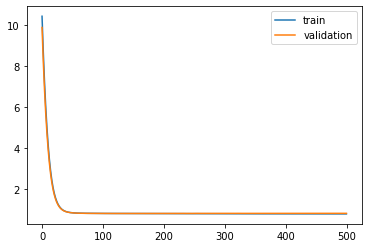

Time to train LSTM:  364.11985898017883
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 4s - loss: 10.4821 - pdc_loss: 0.7164 - event_loss: 0.7192 - val_loss: 9.9328 - val_pdc_loss: 0.7070 - val_event_loss: 0.6939

Epoch 00001: val_loss improved from inf to 9.93276, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 9.5864 - pdc_loss: 0.6966 - event_loss: 0.6794 - val_loss: 9.0786 - val_pdc_loss: 0.6894 - val_event_loss: 0.6586

Epoch 00002: val_loss improved from 9.93276 to 9.07855, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 8.7572 - pdc_loss: 0.6798 - event_loss: 0.6453 - val_loss: 8.2901 - val_pdc_loss: 0.6746 - val_event_loss: 0.6279

Epoch 00003: val_loss improved from 9.07855 to 8.29012, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 7.9929 - pdc_loss: 0.6656 - event_loss: 0.6152 - val_loss: 7.5648 - val_pdc_loss: 0.6621 - val_event_loss: 0.6004

Epoch 00004: val_loss improved from 8.29012 to 7.56479, saving


Epoch 00035: val_loss improved from 1.00421 to 0.98404, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 0.9628 - pdc_loss: 0.5412 - event_loss: 0.2983 - val_loss: 0.9664 - val_pdc_loss: 0.5468 - val_event_loss: 0.3060

Epoch 00036: val_loss improved from 0.98404 to 0.96642, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 0.9461 - pdc_loss: 0.5403 - event_loss: 0.2981 - val_loss: 0.9511 - val_pdc_loss: 0.5460 - val_event_loss: 0.3058

Epoch 00037: val_loss improved from 0.96642 to 0.95105, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 0.9316 - pdc_loss: 0.5395 - event_loss: 0.2979 - val_loss: 0.9377 - val_pdc_loss: 0.5453 - val_event_loss: 0.3056

Epoch 00038: val_loss improved from 0.95105 to 0.93767, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 0.9189 - pdc_loss: 0.5387 - event_loss: 0.2977 - val_loss: 0.9260 - val_pdc_loss: 0.5445 - val_event_loss: 0.3054

Epoch 00039: val_loss improved from 0.93767 to 

 - 1s - loss: 0.8272 - pdc_loss: 0.5196 - event_loss: 0.2960 - val_loss: 0.8439 - val_pdc_loss: 0.5281 - val_event_loss: 0.3042

Epoch 00070: val_loss improved from 0.84424 to 0.84391, saving model to Event_val_weights2.hdf5
Epoch 71/500
 - 1s - loss: 0.8269 - pdc_loss: 0.5194 - event_loss: 0.2959 - val_loss: 0.8436 - val_pdc_loss: 0.5280 - val_event_loss: 0.3042

Epoch 00071: val_loss improved from 0.84391 to 0.84358, saving model to Event_val_weights2.hdf5
Epoch 72/500
 - 1s - loss: 0.8265 - pdc_loss: 0.5192 - event_loss: 0.2959 - val_loss: 0.8433 - val_pdc_loss: 0.5278 - val_event_loss: 0.3041

Epoch 00072: val_loss improved from 0.84358 to 0.84326, saving model to Event_val_weights2.hdf5
Epoch 73/500
 - 1s - loss: 0.8262 - pdc_loss: 0.5191 - event_loss: 0.2959 - val_loss: 0.8429 - val_pdc_loss: 0.5276 - val_event_loss: 0.3041

Epoch 00073: val_loss improved from 0.84326 to 0.84295, saving model to Event_val_weights2.hdf5
Epoch 74/500
 - 1s - loss: 0.8259 - pdc_loss: 0.5190 - event_


Epoch 00106: val_loss improved from 0.83877 to 0.83855, saving model to Event_val_weights2.hdf5
Epoch 107/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5144 - event_loss: 0.2945 - val_loss: 0.8384 - val_pdc_loss: 0.5261 - val_event_loss: 0.3026

Epoch 00107: val_loss improved from 0.83855 to 0.83841, saving model to Event_val_weights2.hdf5
Epoch 108/500
 - 1s - loss: 0.8183 - pdc_loss: 0.5142 - event_loss: 0.2945 - val_loss: 0.8382 - val_pdc_loss: 0.5259 - val_event_loss: 0.3027

Epoch 00108: val_loss improved from 0.83841 to 0.83820, saving model to Event_val_weights2.hdf5
Epoch 109/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5141 - event_loss: 0.2945 - val_loss: 0.8381 - val_pdc_loss: 0.5259 - val_event_loss: 0.3026

Epoch 00109: val_loss improved from 0.83820 to 0.83806, saving model to Event_val_weights2.hdf5
Epoch 110/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5139 - event_loss: 0.2944 - val_loss: 0.8380 - val_pdc_loss: 0.5258 - val_event_loss: 0.3026

Epoch 00110: val_loss improved from 0.83806


Epoch 00143: val_loss improved from 0.83586 to 0.83581, saving model to Event_val_weights2.hdf5
Epoch 144/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5114 - event_loss: 0.2934 - val_loss: 0.8358 - val_pdc_loss: 0.5248 - val_event_loss: 0.3017

Epoch 00144: val_loss did not improve from 0.83581
Epoch 145/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5114 - event_loss: 0.2934 - val_loss: 0.8357 - val_pdc_loss: 0.5248 - val_event_loss: 0.3016

Epoch 00145: val_loss improved from 0.83581 to 0.83573, saving model to Event_val_weights2.hdf5
Epoch 146/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5113 - event_loss: 0.2933 - val_loss: 0.8357 - val_pdc_loss: 0.5247 - val_event_loss: 0.3017

Epoch 00146: val_loss improved from 0.83573 to 0.83572, saving model to Event_val_weights2.hdf5
Epoch 147/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5113 - event_loss: 0.2934 - val_loss: 0.8356 - val_pdc_loss: 0.5246 - val_event_loss: 0.3016

Epoch 00147: val_loss improved from 0.83572 to 0.83556, saving model to Event_val_weight


Epoch 00183: val_loss did not improve from 0.83500
Epoch 184/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5089 - event_loss: 0.2926 - val_loss: 0.8354 - val_pdc_loss: 0.5243 - val_event_loss: 0.3017

Epoch 00184: val_loss did not improve from 0.83500
Epoch 185/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5089 - event_loss: 0.2926 - val_loss: 0.8352 - val_pdc_loss: 0.5242 - val_event_loss: 0.3016

Epoch 00185: val_loss did not improve from 0.83500
Epoch 186/500
 - 1s - loss: 0.8107 - pdc_loss: 0.5088 - event_loss: 0.2925 - val_loss: 0.8352 - val_pdc_loss: 0.5242 - val_event_loss: 0.3017

Epoch 00186: val_loss did not improve from 0.83500
Epoch 187/500
 - 1s - loss: 0.8107 - pdc_loss: 0.5088 - event_loss: 0.2926 - val_loss: 0.8354 - val_pdc_loss: 0.5243 - val_event_loss: 0.3017

Epoch 00187: val_loss did not improve from 0.83500
Epoch 188/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5087 - event_loss: 0.2925 - val_loss: 0.8352 - val_pdc_loss: 0.5242 - val_event_loss: 0.3017

Epoch 00188: val_loss did not

 - 1s - loss: 0.8084 - pdc_loss: 0.5072 - event_loss: 0.2918 - val_loss: 0.8361 - val_pdc_loss: 0.5247 - val_event_loss: 0.3019

Epoch 00226: val_loss did not improve from 0.83500
Epoch 227/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5072 - event_loss: 0.2918 - val_loss: 0.8359 - val_pdc_loss: 0.5246 - val_event_loss: 0.3019

Epoch 00227: val_loss did not improve from 0.83500
Epoch 228/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5071 - event_loss: 0.2917 - val_loss: 0.8361 - val_pdc_loss: 0.5248 - val_event_loss: 0.3019

Epoch 00228: val_loss did not improve from 0.83500
Epoch 229/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5071 - event_loss: 0.2918 - val_loss: 0.8360 - val_pdc_loss: 0.5246 - val_event_loss: 0.3019

Epoch 00229: val_loss did not improve from 0.83500
Epoch 230/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5070 - event_loss: 0.2917 - val_loss: 0.8363 - val_pdc_loss: 0.5249 - val_event_loss: 0.3019

Epoch 00230: val_loss did not improve from 0.83500
Epoch 231/500
 - 1s - loss: 0.8082 - pdc_los


Epoch 00268: val_loss did not improve from 0.83500
Epoch 269/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5054 - event_loss: 0.2909 - val_loss: 0.8377 - val_pdc_loss: 0.5259 - val_event_loss: 0.3022

Epoch 00269: val_loss did not improve from 0.83500
Epoch 270/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5054 - event_loss: 0.2909 - val_loss: 0.8375 - val_pdc_loss: 0.5258 - val_event_loss: 0.3021

Epoch 00270: val_loss did not improve from 0.83500
Epoch 271/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5054 - event_loss: 0.2909 - val_loss: 0.8375 - val_pdc_loss: 0.5258 - val_event_loss: 0.3022

Epoch 00271: val_loss did not improve from 0.83500
Epoch 272/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5053 - event_loss: 0.2909 - val_loss: 0.8376 - val_pdc_loss: 0.5259 - val_event_loss: 0.3021

Epoch 00272: val_loss did not improve from 0.83500
Epoch 273/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5052 - event_loss: 0.2909 - val_loss: 0.8376 - val_pdc_loss: 0.5259 - val_event_loss: 0.3021

Epoch 00273: val_loss did not

 - 1s - loss: 0.8035 - pdc_loss: 0.5036 - event_loss: 0.2903 - val_loss: 0.8395 - val_pdc_loss: 0.5275 - val_event_loss: 0.3025

Epoch 00311: val_loss did not improve from 0.83500
Epoch 312/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5036 - event_loss: 0.2902 - val_loss: 0.8388 - val_pdc_loss: 0.5269 - val_event_loss: 0.3025

Epoch 00312: val_loss did not improve from 0.83500
Epoch 313/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5037 - event_loss: 0.2903 - val_loss: 0.8397 - val_pdc_loss: 0.5278 - val_event_loss: 0.3024

Epoch 00313: val_loss did not improve from 0.83500
Epoch 314/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5035 - event_loss: 0.2901 - val_loss: 0.8389 - val_pdc_loss: 0.5269 - val_event_loss: 0.3025

Epoch 00314: val_loss did not improve from 0.83500
Epoch 315/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5038 - event_loss: 0.2903 - val_loss: 0.8399 - val_pdc_loss: 0.5278 - val_event_loss: 0.3026

Epoch 00315: val_loss did not improve from 0.83500
Epoch 316/500
 - 1s - loss: 0.8030 - pdc_los


Epoch 00353: val_loss did not improve from 0.83500
Epoch 354/500
 - 1s - loss: 0.8011 - pdc_loss: 0.5021 - event_loss: 0.2895 - val_loss: 0.8400 - val_pdc_loss: 0.5275 - val_event_loss: 0.3030

Epoch 00354: val_loss did not improve from 0.83500
Epoch 355/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5025 - event_loss: 0.2896 - val_loss: 0.8414 - val_pdc_loss: 0.5285 - val_event_loss: 0.3034

Epoch 00355: val_loss did not improve from 0.83500
Epoch 356/500
 - 1s - loss: 0.8011 - pdc_loss: 0.5020 - event_loss: 0.2895 - val_loss: 0.8401 - val_pdc_loss: 0.5276 - val_event_loss: 0.3030

Epoch 00356: val_loss did not improve from 0.83500
Epoch 357/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5024 - event_loss: 0.2896 - val_loss: 0.8416 - val_pdc_loss: 0.5287 - val_event_loss: 0.3034

Epoch 00357: val_loss did not improve from 0.83500
Epoch 358/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5020 - event_loss: 0.2895 - val_loss: 0.8408 - val_pdc_loss: 0.5278 - val_event_loss: 0.3035

Epoch 00358: val_loss did not

 - 1s - loss: 0.7995 - pdc_loss: 0.5011 - event_loss: 0.2890 - val_loss: 0.8424 - val_pdc_loss: 0.5283 - val_event_loss: 0.3046

Epoch 00396: val_loss did not improve from 0.83500
Epoch 397/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5014 - event_loss: 0.2890 - val_loss: 0.8428 - val_pdc_loss: 0.5294 - val_event_loss: 0.3040

Epoch 00397: val_loss did not improve from 0.83500
Epoch 398/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5011 - event_loss: 0.2889 - val_loss: 0.8423 - val_pdc_loss: 0.5283 - val_event_loss: 0.3046

Epoch 00398: val_loss did not improve from 0.83500
Epoch 399/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5014 - event_loss: 0.2890 - val_loss: 0.8427 - val_pdc_loss: 0.5291 - val_event_loss: 0.3042

Epoch 00399: val_loss did not improve from 0.83500
Epoch 400/500
 - 1s - loss: 0.7993 - pdc_loss: 0.5010 - event_loss: 0.2888 - val_loss: 0.8426 - val_pdc_loss: 0.5287 - val_event_loss: 0.3044

Epoch 00400: val_loss did not improve from 0.83500
Epoch 401/500
 - 1s - loss: 0.7997 - pdc_los


Epoch 00438: val_loss did not improve from 0.83500
Epoch 439/500
 - 1s - loss: 0.7986 - pdc_loss: 0.5008 - event_loss: 0.2885 - val_loss: 0.8446 - val_pdc_loss: 0.5302 - val_event_loss: 0.3050

Epoch 00439: val_loss did not improve from 0.83500
Epoch 440/500
 - 1s - loss: 0.7981 - pdc_loss: 0.5003 - event_loss: 0.2884 - val_loss: 0.8435 - val_pdc_loss: 0.5296 - val_event_loss: 0.3046

Epoch 00440: val_loss did not improve from 0.83500
Epoch 441/500
 - 1s - loss: 0.7984 - pdc_loss: 0.5006 - event_loss: 0.2884 - val_loss: 0.8444 - val_pdc_loss: 0.5302 - val_event_loss: 0.3049

Epoch 00441: val_loss did not improve from 0.83500
Epoch 442/500
 - 1s - loss: 0.7979 - pdc_loss: 0.5001 - event_loss: 0.2884 - val_loss: 0.8437 - val_pdc_loss: 0.5294 - val_event_loss: 0.3050

Epoch 00442: val_loss did not improve from 0.83500
Epoch 443/500
 - 1s - loss: 0.7982 - pdc_loss: 0.5004 - event_loss: 0.2885 - val_loss: 0.8452 - val_pdc_loss: 0.5311 - val_event_loss: 0.3048

Epoch 00443: val_loss did not

 - 1s - loss: 0.7972 - pdc_loss: 0.4998 - event_loss: 0.2881 - val_loss: 0.8453 - val_pdc_loss: 0.5309 - val_event_loss: 0.3052

Epoch 00481: val_loss did not improve from 0.83500
Epoch 482/500
 - 1s - loss: 0.7972 - pdc_loss: 0.4999 - event_loss: 0.2880 - val_loss: 0.8452 - val_pdc_loss: 0.5303 - val_event_loss: 0.3056

Epoch 00482: val_loss did not improve from 0.83500
Epoch 483/500
 - 1s - loss: 0.7974 - pdc_loss: 0.5000 - event_loss: 0.2881 - val_loss: 0.8453 - val_pdc_loss: 0.5304 - val_event_loss: 0.3056

Epoch 00483: val_loss did not improve from 0.83500
Epoch 484/500
 - 1s - loss: 0.7968 - pdc_loss: 0.4995 - event_loss: 0.2879 - val_loss: 0.8451 - val_pdc_loss: 0.5308 - val_event_loss: 0.3050

Epoch 00484: val_loss did not improve from 0.83500
Epoch 485/500
 - 1s - loss: 0.7971 - pdc_loss: 0.4999 - event_loss: 0.2879 - val_loss: 0.8456 - val_pdc_loss: 0.5308 - val_event_loss: 0.3056

Epoch 00485: val_loss did not improve from 0.83500
Epoch 486/500
 - 1s - loss: 0.7968 - pdc_los

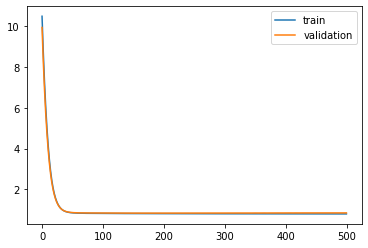

Time to train LSTM:  331.04970145225525
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 4s - loss: 10.6185 - pdc_loss: 0.7819 - event_loss: 0.7214 - val_loss: 10.0643 - val_pdc_loss: 0.7748 - val_event_loss: 0.6919

Epoch 00001: val_loss improved from inf to 10.06428, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 9.7157 - pdc_loss: 0.7577 - event_loss: 0.6839 - val_loss: 9.2020 - val_pdc_loss: 0.7523 - val_event_loss: 0.6583

Epoch 00002: val_loss improved from 10.06428 to 9.20195, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 8.8781 - pdc_loss: 0.7363 - event_loss: 0.6510 - val_loss: 8.4041 - val_pdc_loss: 0.7328 - val_event_loss: 0.6283

Epoch 00003: val_loss improved from 9.20195 to 8.40408, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 8.1043 - pdc_loss: 0.7178 - event_loss: 0.6212 - val_loss: 7.6687 - val_pdc_loss: 0.7158 - val_event_loss: 0.6006

Epoch 00004: val_loss improved from 8.40408 to 7.66868, sav


Epoch 00035: val_loss improved from 1.01950 to 0.99906, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 0.9768 - pdc_loss: 0.5558 - event_loss: 0.2978 - val_loss: 0.9813 - val_pdc_loss: 0.5678 - val_event_loss: 0.3002

Epoch 00036: val_loss improved from 0.99906 to 0.98126, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 0.9598 - pdc_loss: 0.5549 - event_loss: 0.2977 - val_loss: 0.9658 - val_pdc_loss: 0.5671 - val_event_loss: 0.3000

Epoch 00037: val_loss improved from 0.98126 to 0.96578, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 0.9451 - pdc_loss: 0.5540 - event_loss: 0.2975 - val_loss: 0.9523 - val_pdc_loss: 0.5663 - val_event_loss: 0.2999

Epoch 00038: val_loss improved from 0.96578 to 0.95232, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.9322 - pdc_loss: 0.5531 - event_loss: 0.2974 - val_loss: 0.9406 - val_pdc_loss: 0.5655 - val_event_loss: 0.2998

Epoch 00039: val_loss improved from 0.95232 to 

 - 1s - loss: 0.8366 - pdc_loss: 0.5276 - event_loss: 0.2960 - val_loss: 0.8573 - val_pdc_loss: 0.5447 - val_event_loss: 0.2997

Epoch 00070: val_loss improved from 0.85768 to 0.85725, saving model to Event_val_weights3.hdf5
Epoch 71/500
 - 1s - loss: 0.8359 - pdc_loss: 0.5272 - event_loss: 0.2960 - val_loss: 0.8569 - val_pdc_loss: 0.5445 - val_event_loss: 0.2997

Epoch 00071: val_loss improved from 0.85725 to 0.85686, saving model to Event_val_weights3.hdf5
Epoch 72/500
 - 1s - loss: 0.8354 - pdc_loss: 0.5268 - event_loss: 0.2959 - val_loss: 0.8565 - val_pdc_loss: 0.5443 - val_event_loss: 0.2997

Epoch 00072: val_loss improved from 0.85686 to 0.85650, saving model to Event_val_weights3.hdf5
Epoch 73/500
 - 1s - loss: 0.8348 - pdc_loss: 0.5265 - event_loss: 0.2959 - val_loss: 0.8562 - val_pdc_loss: 0.5441 - val_event_loss: 0.2997

Epoch 00073: val_loss improved from 0.85650 to 0.85617, saving model to Event_val_weights3.hdf5
Epoch 74/500
 - 1s - loss: 0.8343 - pdc_loss: 0.5262 - event_


Epoch 00105: val_loss did not improve from 0.84986
Epoch 106/500
 - 1s - loss: 0.8223 - pdc_loss: 0.5172 - event_loss: 0.2941 - val_loss: 0.8497 - val_pdc_loss: 0.5386 - val_event_loss: 0.3002

Epoch 00106: val_loss improved from 0.84986 to 0.84970, saving model to Event_val_weights3.hdf5
Epoch 107/500
 - 1s - loss: 0.8220 - pdc_loss: 0.5170 - event_loss: 0.2941 - val_loss: 0.8494 - val_pdc_loss: 0.5383 - val_event_loss: 0.3003

Epoch 00107: val_loss improved from 0.84970 to 0.84943, saving model to Event_val_weights3.hdf5
Epoch 108/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5168 - event_loss: 0.2940 - val_loss: 0.8495 - val_pdc_loss: 0.5383 - val_event_loss: 0.3004

Epoch 00108: val_loss did not improve from 0.84943
Epoch 109/500
 - 1s - loss: 0.8215 - pdc_loss: 0.5166 - event_loss: 0.2940 - val_loss: 0.8492 - val_pdc_loss: 0.5380 - val_event_loss: 0.3004

Epoch 00109: val_loss improved from 0.84943 to 0.84920, saving model to Event_val_weights3.hdf5
Epoch 110/500
 - 1s - loss: 0.8212 - 

 - 1s - loss: 0.8151 - pdc_loss: 0.5122 - event_loss: 0.2925 - val_loss: 0.8465 - val_pdc_loss: 0.5348 - val_event_loss: 0.3013

Epoch 00144: val_loss did not improve from 0.84636
Epoch 145/500
 - 1s - loss: 0.8151 - pdc_loss: 0.5122 - event_loss: 0.2925 - val_loss: 0.8465 - val_pdc_loss: 0.5349 - val_event_loss: 0.3011

Epoch 00145: val_loss did not improve from 0.84636
Epoch 146/500
 - 1s - loss: 0.8149 - pdc_loss: 0.5121 - event_loss: 0.2924 - val_loss: 0.8468 - val_pdc_loss: 0.5353 - val_event_loss: 0.3011

Epoch 00146: val_loss did not improve from 0.84636
Epoch 147/500
 - 1s - loss: 0.8150 - pdc_loss: 0.5121 - event_loss: 0.2924 - val_loss: 0.8471 - val_pdc_loss: 0.5355 - val_event_loss: 0.3012

Epoch 00147: val_loss did not improve from 0.84636
Epoch 148/500
 - 1s - loss: 0.8148 - pdc_loss: 0.5119 - event_loss: 0.2924 - val_loss: 0.8472 - val_pdc_loss: 0.5356 - val_event_loss: 0.3011

Epoch 00148: val_loss did not improve from 0.84636
Epoch 149/500
 - 1s - loss: 0.8148 - pdc_los


Epoch 00184: val_loss did not improve from 0.84487
Epoch 185/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5092 - event_loss: 0.2912 - val_loss: 0.8459 - val_pdc_loss: 0.5342 - val_event_loss: 0.3017

Epoch 00185: val_loss did not improve from 0.84487
Epoch 186/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5092 - event_loss: 0.2912 - val_loss: 0.8459 - val_pdc_loss: 0.5340 - val_event_loss: 0.3019

Epoch 00186: val_loss did not improve from 0.84487
Epoch 187/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5092 - event_loss: 0.2912 - val_loss: 0.8459 - val_pdc_loss: 0.5341 - val_event_loss: 0.3018

Epoch 00187: val_loss did not improve from 0.84487
Epoch 188/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5091 - event_loss: 0.2912 - val_loss: 0.8461 - val_pdc_loss: 0.5340 - val_event_loss: 0.3020

Epoch 00188: val_loss did not improve from 0.84487
Epoch 189/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5091 - event_loss: 0.2912 - val_loss: 0.8459 - val_pdc_loss: 0.5340 - val_event_loss: 0.3018

Epoch 00189: val_loss did not


Epoch 00226: val_loss did not improve from 0.84476
Epoch 227/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5066 - event_loss: 0.2902 - val_loss: 0.8456 - val_pdc_loss: 0.5331 - val_event_loss: 0.3027

Epoch 00227: val_loss did not improve from 0.84476
Epoch 228/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5064 - event_loss: 0.2900 - val_loss: 0.8453 - val_pdc_loss: 0.5329 - val_event_loss: 0.3026

Epoch 00228: val_loss did not improve from 0.84476
Epoch 229/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5064 - event_loss: 0.2900 - val_loss: 0.8450 - val_pdc_loss: 0.5326 - val_event_loss: 0.3026

Epoch 00229: val_loss did not improve from 0.84476
Epoch 230/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5063 - event_loss: 0.2900 - val_loss: 0.8455 - val_pdc_loss: 0.5333 - val_event_loss: 0.3024

Epoch 00230: val_loss did not improve from 0.84476
Epoch 231/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5064 - event_loss: 0.2900 - val_loss: 0.8456 - val_pdc_loss: 0.5333 - val_event_loss: 0.3025

Epoch 00231: val_loss did not

 - 1s - loss: 0.8044 - pdc_loss: 0.5054 - event_loss: 0.2894 - val_loss: 0.8469 - val_pdc_loss: 0.5335 - val_event_loss: 0.3039

Epoch 00269: val_loss did not improve from 0.84476
Epoch 270/500
 - 1s - loss: 0.8043 - pdc_loss: 0.5054 - event_loss: 0.2894 - val_loss: 0.8471 - val_pdc_loss: 0.5337 - val_event_loss: 0.3039

Epoch 00270: val_loss did not improve from 0.84476
Epoch 271/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5054 - event_loss: 0.2894 - val_loss: 0.8468 - val_pdc_loss: 0.5332 - val_event_loss: 0.3041

Epoch 00271: val_loss did not improve from 0.84476
Epoch 272/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5054 - event_loss: 0.2895 - val_loss: 0.8471 - val_pdc_loss: 0.5339 - val_event_loss: 0.3038

Epoch 00272: val_loss did not improve from 0.84476
Epoch 273/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5055 - event_loss: 0.2895 - val_loss: 0.8468 - val_pdc_loss: 0.5333 - val_event_loss: 0.3040

Epoch 00273: val_loss did not improve from 0.84476
Epoch 274/500
 - 1s - loss: 0.8044 - pdc_los


Epoch 00311: val_loss did not improve from 0.84476
Epoch 312/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5042 - event_loss: 0.2890 - val_loss: 0.8486 - val_pdc_loss: 0.5345 - val_event_loss: 0.3048

Epoch 00312: val_loss did not improve from 0.84476
Epoch 313/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5042 - event_loss: 0.2890 - val_loss: 0.8476 - val_pdc_loss: 0.5338 - val_event_loss: 0.3045

Epoch 00313: val_loss did not improve from 0.84476
Epoch 314/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5042 - event_loss: 0.2890 - val_loss: 0.8492 - val_pdc_loss: 0.5349 - val_event_loss: 0.3050

Epoch 00314: val_loss did not improve from 0.84476
Epoch 315/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5043 - event_loss: 0.2890 - val_loss: 0.8483 - val_pdc_loss: 0.5341 - val_event_loss: 0.3049

Epoch 00315: val_loss did not improve from 0.84476
Epoch 316/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5042 - event_loss: 0.2890 - val_loss: 0.8490 - val_pdc_loss: 0.5346 - val_event_loss: 0.3050

Epoch 00316: val_loss did not

 - 1s - loss: 0.8009 - pdc_loss: 0.5033 - event_loss: 0.2886 - val_loss: 0.8503 - val_pdc_loss: 0.5359 - val_event_loss: 0.3053

Epoch 00354: val_loss did not improve from 0.84476
Epoch 355/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5033 - event_loss: 0.2886 - val_loss: 0.8496 - val_pdc_loss: 0.5353 - val_event_loss: 0.3052

Epoch 00355: val_loss did not improve from 0.84476
Epoch 356/500
 - 1s - loss: 0.8009 - pdc_loss: 0.5032 - event_loss: 0.2885 - val_loss: 0.8500 - val_pdc_loss: 0.5356 - val_event_loss: 0.3054

Epoch 00356: val_loss did not improve from 0.84476
Epoch 357/500
 - 1s - loss: 0.8008 - pdc_loss: 0.5032 - event_loss: 0.2885 - val_loss: 0.8496 - val_pdc_loss: 0.5352 - val_event_loss: 0.3053

Epoch 00357: val_loss did not improve from 0.84476
Epoch 358/500
 - 1s - loss: 0.8008 - pdc_loss: 0.5032 - event_loss: 0.2885 - val_loss: 0.8498 - val_pdc_loss: 0.5355 - val_event_loss: 0.3053

Epoch 00358: val_loss did not improve from 0.84476
Epoch 359/500
 - 1s - loss: 0.8007 - pdc_los


Epoch 00396: val_loss did not improve from 0.84476
Epoch 397/500
 - 1s - loss: 0.7995 - pdc_loss: 0.5024 - event_loss: 0.2883 - val_loss: 0.8508 - val_pdc_loss: 0.5360 - val_event_loss: 0.3058

Epoch 00397: val_loss did not improve from 0.84476
Epoch 398/500
 - 1s - loss: 0.7995 - pdc_loss: 0.5024 - event_loss: 0.2882 - val_loss: 0.8510 - val_pdc_loss: 0.5365 - val_event_loss: 0.3056

Epoch 00398: val_loss did not improve from 0.84476
Epoch 399/500
 - 1s - loss: 0.7995 - pdc_loss: 0.5024 - event_loss: 0.2883 - val_loss: 0.8511 - val_pdc_loss: 0.5363 - val_event_loss: 0.3059

Epoch 00399: val_loss did not improve from 0.84476
Epoch 400/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5023 - event_loss: 0.2882 - val_loss: 0.8516 - val_pdc_loss: 0.5368 - val_event_loss: 0.3059

Epoch 00400: val_loss did not improve from 0.84476
Epoch 401/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5023 - event_loss: 0.2882 - val_loss: 0.8512 - val_pdc_loss: 0.5364 - val_event_loss: 0.3059

Epoch 00401: val_loss did not

 - 1s - loss: 0.7989 - pdc_loss: 0.5016 - event_loss: 0.2885 - val_loss: 0.8515 - val_pdc_loss: 0.5365 - val_event_loss: 0.3063

Epoch 00439: val_loss did not improve from 0.84476
Epoch 440/500
 - 1s - loss: 0.7987 - pdc_loss: 0.5017 - event_loss: 0.2882 - val_loss: 0.8534 - val_pdc_loss: 0.5386 - val_event_loss: 0.3060

Epoch 00440: val_loss did not improve from 0.84476
Epoch 441/500
 - 1s - loss: 0.7993 - pdc_loss: 0.5025 - event_loss: 0.2880 - val_loss: 0.8535 - val_pdc_loss: 0.5388 - val_event_loss: 0.3059

Epoch 00441: val_loss did not improve from 0.84476
Epoch 442/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5027 - event_loss: 0.2880 - val_loss: 0.8529 - val_pdc_loss: 0.5378 - val_event_loss: 0.3063

Epoch 00442: val_loss did not improve from 0.84476
Epoch 443/500
 - 1s - loss: 0.7990 - pdc_loss: 0.5020 - event_loss: 0.2882 - val_loss: 0.8524 - val_pdc_loss: 0.5367 - val_event_loss: 0.3069

Epoch 00443: val_loss did not improve from 0.84476
Epoch 444/500
 - 1s - loss: 0.7988 - pdc_los


Epoch 00481: val_loss did not improve from 0.84476
Epoch 482/500
 - 1s - loss: 0.7976 - pdc_loss: 0.5010 - event_loss: 0.2878 - val_loss: 0.8534 - val_pdc_loss: 0.5385 - val_event_loss: 0.3062

Epoch 00482: val_loss did not improve from 0.84476
Epoch 483/500
 - 1s - loss: 0.7977 - pdc_loss: 0.5013 - event_loss: 0.2876 - val_loss: 0.8531 - val_pdc_loss: 0.5379 - val_event_loss: 0.3065

Epoch 00483: val_loss did not improve from 0.84476
Epoch 484/500
 - 1s - loss: 0.7975 - pdc_loss: 0.5011 - event_loss: 0.2876 - val_loss: 0.8530 - val_pdc_loss: 0.5378 - val_event_loss: 0.3064

Epoch 00484: val_loss did not improve from 0.84476
Epoch 485/500
 - 1s - loss: 0.7975 - pdc_loss: 0.5008 - event_loss: 0.2879 - val_loss: 0.8532 - val_pdc_loss: 0.5377 - val_event_loss: 0.3067

Epoch 00485: val_loss did not improve from 0.84476
Epoch 486/500
 - 1s - loss: 0.7975 - pdc_loss: 0.5009 - event_loss: 0.2878 - val_loss: 0.8534 - val_pdc_loss: 0.5387 - val_event_loss: 0.3060

Epoch 00486: val_loss did not

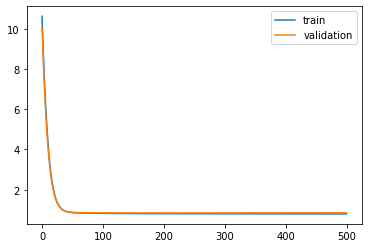

Time to train LSTM:  331.0097498893738
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 5s - loss: 10.5698 - pdc_loss: 0.7170 - event_loss: 0.7517 - val_loss: 10.0225 - val_pdc_loss: 0.7063 - val_event_loss: 0.7316

Epoch 00001: val_loss improved from inf to 10.02253, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 9.6788 - pdc_loss: 0.6987 - event_loss: 0.7179 - val_loss: 9.1718 - val_pdc_loss: 0.6911 - val_event_loss: 0.6998

Epoch 00002: val_loss improved from 10.02253 to 9.17180, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 8.8519 - pdc_loss: 0.6832 - event_loss: 0.6871 - val_loss: 8.3843 - val_pdc_loss: 0.6781 - val_event_loss: 0.6705

Epoch 00003: val_loss improved from 9.17180 to 8.38432, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 8.0878 - pdc_loss: 0.6699 - event_loss: 0.6585 - val_loss: 7.6582 - val_pdc_loss: 0.6670 - val_event_loss: 0.6428

Epoch 00004: val_loss improved from 8.38432 to 7.65823, savi


Epoch 00035: val_loss improved from 1.01984 to 0.99898, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 0.9718 - pdc_loss: 0.5453 - event_loss: 0.2993 - val_loss: 0.9808 - val_pdc_loss: 0.5582 - val_event_loss: 0.3056

Epoch 00036: val_loss improved from 0.99898 to 0.98078, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.9544 - pdc_loss: 0.5443 - event_loss: 0.2991 - val_loss: 0.9649 - val_pdc_loss: 0.5574 - val_event_loss: 0.3053

Epoch 00037: val_loss improved from 0.98078 to 0.96492, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.9391 - pdc_loss: 0.5433 - event_loss: 0.2988 - val_loss: 0.9511 - val_pdc_loss: 0.5566 - val_event_loss: 0.3051

Epoch 00038: val_loss improved from 0.96492 to 0.95109, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.9258 - pdc_loss: 0.5423 - event_loss: 0.2986 - val_loss: 0.9390 - val_pdc_loss: 0.5558 - val_event_loss: 0.3049

Epoch 00039: val_loss improved from 0.95109 to 

 - 1s - loss: 0.8265 - pdc_loss: 0.5182 - event_loss: 0.2961 - val_loss: 0.8529 - val_pdc_loss: 0.5385 - val_event_loss: 0.3022

Epoch 00070: val_loss improved from 0.85321 to 0.85286, saving model to Event_val_weights4.hdf5
Epoch 71/500
 - 1s - loss: 0.8260 - pdc_loss: 0.5179 - event_loss: 0.2961 - val_loss: 0.8525 - val_pdc_loss: 0.5384 - val_event_loss: 0.3022

Epoch 00071: val_loss improved from 0.85286 to 0.85255, saving model to Event_val_weights4.hdf5
Epoch 72/500
 - 1s - loss: 0.8256 - pdc_loss: 0.5177 - event_loss: 0.2960 - val_loss: 0.8523 - val_pdc_loss: 0.5383 - val_event_loss: 0.3021

Epoch 00072: val_loss improved from 0.85255 to 0.85227, saving model to Event_val_weights4.hdf5
Epoch 73/500
 - 1s - loss: 0.8252 - pdc_loss: 0.5174 - event_loss: 0.2959 - val_loss: 0.8520 - val_pdc_loss: 0.5382 - val_event_loss: 0.3021

Epoch 00073: val_loss improved from 0.85227 to 0.85202, saving model to Event_val_weights4.hdf5
Epoch 74/500
 - 1s - loss: 0.8247 - pdc_loss: 0.5172 - event_


Epoch 00106: val_loss did not improve from 0.84783
Epoch 107/500
 - 1s - loss: 0.8168 - pdc_loss: 0.5120 - event_loss: 0.2948 - val_loss: 0.8478 - val_pdc_loss: 0.5363 - val_event_loss: 0.3014

Epoch 00107: val_loss improved from 0.84783 to 0.84780, saving model to Event_val_weights4.hdf5
Epoch 108/500
 - 1s - loss: 0.8167 - pdc_loss: 0.5119 - event_loss: 0.2947 - val_loss: 0.8480 - val_pdc_loss: 0.5365 - val_event_loss: 0.3014

Epoch 00108: val_loss did not improve from 0.84780
Epoch 109/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5118 - event_loss: 0.2947 - val_loss: 0.8480 - val_pdc_loss: 0.5365 - val_event_loss: 0.3014

Epoch 00109: val_loss did not improve from 0.84780
Epoch 110/500
 - 1s - loss: 0.8165 - pdc_loss: 0.5118 - event_loss: 0.2947 - val_loss: 0.8482 - val_pdc_loss: 0.5367 - val_event_loss: 0.3014

Epoch 00110: val_loss did not improve from 0.84780
Epoch 111/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5117 - event_loss: 0.2947 - val_loss: 0.8483 - val_pdc_loss: 0.5369 - val_even


Epoch 00146: val_loss did not improve from 0.84659
Epoch 147/500
 - 1s - loss: 0.8124 - pdc_loss: 0.5090 - event_loss: 0.2938 - val_loss: 0.8470 - val_pdc_loss: 0.5362 - val_event_loss: 0.3013

Epoch 00147: val_loss did not improve from 0.84659
Epoch 148/500
 - 1s - loss: 0.8122 - pdc_loss: 0.5089 - event_loss: 0.2938 - val_loss: 0.8473 - val_pdc_loss: 0.5364 - val_event_loss: 0.3013

Epoch 00148: val_loss did not improve from 0.84659
Epoch 149/500
 - 1s - loss: 0.8123 - pdc_loss: 0.5090 - event_loss: 0.2938 - val_loss: 0.8473 - val_pdc_loss: 0.5365 - val_event_loss: 0.3013

Epoch 00149: val_loss did not improve from 0.84659
Epoch 150/500
 - 1s - loss: 0.8122 - pdc_loss: 0.5089 - event_loss: 0.2938 - val_loss: 0.8477 - val_pdc_loss: 0.5368 - val_event_loss: 0.3014

Epoch 00150: val_loss did not improve from 0.84659
Epoch 151/500
 - 1s - loss: 0.8123 - pdc_loss: 0.5090 - event_loss: 0.2938 - val_loss: 0.8478 - val_pdc_loss: 0.5369 - val_event_loss: 0.3013

Epoch 00151: val_loss did not


Epoch 00188: val_loss did not improve from 0.84650
Epoch 189/500
 - 1s - loss: 0.8092 - pdc_loss: 0.5070 - event_loss: 0.2929 - val_loss: 0.8479 - val_pdc_loss: 0.5371 - val_event_loss: 0.3013

Epoch 00189: val_loss did not improve from 0.84650
Epoch 190/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5069 - event_loss: 0.2929 - val_loss: 0.8481 - val_pdc_loss: 0.5374 - val_event_loss: 0.3014

Epoch 00190: val_loss did not improve from 0.84650
Epoch 191/500
 - 1s - loss: 0.8092 - pdc_loss: 0.5069 - event_loss: 0.2929 - val_loss: 0.8482 - val_pdc_loss: 0.5374 - val_event_loss: 0.3013

Epoch 00191: val_loss did not improve from 0.84650
Epoch 192/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5069 - event_loss: 0.2928 - val_loss: 0.8484 - val_pdc_loss: 0.5376 - val_event_loss: 0.3014

Epoch 00192: val_loss did not improve from 0.84650
Epoch 193/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5069 - event_loss: 0.2928 - val_loss: 0.8484 - val_pdc_loss: 0.5376 - val_event_loss: 0.3014

Epoch 00193: val_loss did not

 - 1s - loss: 0.8060 - pdc_loss: 0.5047 - event_loss: 0.2920 - val_loss: 0.8485 - val_pdc_loss: 0.5377 - val_event_loss: 0.3015

Epoch 00231: val_loss did not improve from 0.84650
Epoch 232/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5047 - event_loss: 0.2919 - val_loss: 0.8485 - val_pdc_loss: 0.5378 - val_event_loss: 0.3015

Epoch 00232: val_loss did not improve from 0.84650
Epoch 233/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5046 - event_loss: 0.2919 - val_loss: 0.8485 - val_pdc_loss: 0.5377 - val_event_loss: 0.3015

Epoch 00233: val_loss did not improve from 0.84650
Epoch 234/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5047 - event_loss: 0.2919 - val_loss: 0.8486 - val_pdc_loss: 0.5379 - val_event_loss: 0.3015

Epoch 00234: val_loss did not improve from 0.84650
Epoch 235/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5046 - event_loss: 0.2919 - val_loss: 0.8486 - val_pdc_loss: 0.5379 - val_event_loss: 0.3015

Epoch 00235: val_loss did not improve from 0.84650
Epoch 236/500
 - 1s - loss: 0.8057 - pdc_los


Epoch 00273: val_loss did not improve from 0.84650
Epoch 274/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5034 - event_loss: 0.2911 - val_loss: 0.8492 - val_pdc_loss: 0.5385 - val_event_loss: 0.3017

Epoch 00274: val_loss did not improve from 0.84650
Epoch 275/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5034 - event_loss: 0.2911 - val_loss: 0.8491 - val_pdc_loss: 0.5384 - val_event_loss: 0.3017

Epoch 00275: val_loss did not improve from 0.84650
Epoch 276/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5033 - event_loss: 0.2910 - val_loss: 0.8489 - val_pdc_loss: 0.5381 - val_event_loss: 0.3017

Epoch 00276: val_loss did not improve from 0.84650
Epoch 277/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5033 - event_loss: 0.2910 - val_loss: 0.8492 - val_pdc_loss: 0.5384 - val_event_loss: 0.3017

Epoch 00277: val_loss did not improve from 0.84650
Epoch 278/500
 - 1s - loss: 0.8035 - pdc_loss: 0.5034 - event_loss: 0.2911 - val_loss: 0.8497 - val_pdc_loss: 0.5389 - val_event_loss: 0.3018

Epoch 00278: val_loss did not

 - 1s - loss: 0.8014 - pdc_loss: 0.5021 - event_loss: 0.2902 - val_loss: 0.8487 - val_pdc_loss: 0.5378 - val_event_loss: 0.3019

Epoch 00316: val_loss did not improve from 0.84650
Epoch 317/500
 - 1s - loss: 0.8019 - pdc_loss: 0.5024 - event_loss: 0.2905 - val_loss: 0.8499 - val_pdc_loss: 0.5388 - val_event_loss: 0.3022

Epoch 00317: val_loss did not improve from 0.84650
Epoch 318/500
 - 1s - loss: 0.8017 - pdc_loss: 0.5021 - event_loss: 0.2905 - val_loss: 0.8498 - val_pdc_loss: 0.5387 - val_event_loss: 0.3020

Epoch 00318: val_loss did not improve from 0.84650
Epoch 319/500
 - 1s - loss: 0.8018 - pdc_loss: 0.5024 - event_loss: 0.2904 - val_loss: 0.8494 - val_pdc_loss: 0.5384 - val_event_loss: 0.3019

Epoch 00319: val_loss did not improve from 0.84650
Epoch 320/500
 - 1s - loss: 0.8017 - pdc_loss: 0.5023 - event_loss: 0.2903 - val_loss: 0.8493 - val_pdc_loss: 0.5381 - val_event_loss: 0.3021

Epoch 00320: val_loss did not improve from 0.84650
Epoch 321/500
 - 1s - loss: 0.8021 - pdc_los


Epoch 00358: val_loss did not improve from 0.84650
Epoch 359/500
 - 1s - loss: 0.8003 - pdc_loss: 0.5016 - event_loss: 0.2897 - val_loss: 0.8505 - val_pdc_loss: 0.5392 - val_event_loss: 0.3022

Epoch 00359: val_loss did not improve from 0.84650
Epoch 360/500
 - 1s - loss: 0.7999 - pdc_loss: 0.5012 - event_loss: 0.2897 - val_loss: 0.8497 - val_pdc_loss: 0.5385 - val_event_loss: 0.3022

Epoch 00360: val_loss did not improve from 0.84650
Epoch 361/500
 - 1s - loss: 0.8006 - pdc_loss: 0.5017 - event_loss: 0.2899 - val_loss: 0.8507 - val_pdc_loss: 0.5394 - val_event_loss: 0.3023

Epoch 00361: val_loss did not improve from 0.84650
Epoch 362/500
 - 1s - loss: 0.8001 - pdc_loss: 0.5011 - event_loss: 0.2899 - val_loss: 0.8503 - val_pdc_loss: 0.5391 - val_event_loss: 0.3022

Epoch 00362: val_loss did not improve from 0.84650
Epoch 363/500
 - 1s - loss: 0.8005 - pdc_loss: 0.5017 - event_loss: 0.2897 - val_loss: 0.8505 - val_pdc_loss: 0.5394 - val_event_loss: 0.3021

Epoch 00363: val_loss did not

 - 1s - loss: 0.7987 - pdc_loss: 0.5004 - event_loss: 0.2893 - val_loss: 0.8517 - val_pdc_loss: 0.5398 - val_event_loss: 0.3028

Epoch 00401: val_loss did not improve from 0.84650
Epoch 402/500
 - 1s - loss: 0.7984 - pdc_loss: 0.5003 - event_loss: 0.2891 - val_loss: 0.8509 - val_pdc_loss: 0.5391 - val_event_loss: 0.3027

Epoch 00402: val_loss did not improve from 0.84650
Epoch 403/500
 - 1s - loss: 0.7988 - pdc_loss: 0.5007 - event_loss: 0.2890 - val_loss: 0.8515 - val_pdc_loss: 0.5398 - val_event_loss: 0.3026

Epoch 00403: val_loss did not improve from 0.84650
Epoch 404/500
 - 1s - loss: 0.7983 - pdc_loss: 0.5001 - event_loss: 0.2892 - val_loss: 0.8502 - val_pdc_loss: 0.5384 - val_event_loss: 0.3027

Epoch 00404: val_loss did not improve from 0.84650
Epoch 405/500
 - 1s - loss: 0.7988 - pdc_loss: 0.5004 - event_loss: 0.2893 - val_loss: 0.8522 - val_pdc_loss: 0.5401 - val_event_loss: 0.3030

Epoch 00405: val_loss did not improve from 0.84650
Epoch 406/500
 - 1s - loss: 0.7983 - pdc_los


Epoch 00443: val_loss did not improve from 0.84650
Epoch 444/500
 - 1s - loss: 0.7971 - pdc_loss: 0.4994 - event_loss: 0.2886 - val_loss: 0.8510 - val_pdc_loss: 0.5390 - val_event_loss: 0.3029

Epoch 00444: val_loss did not improve from 0.84650
Epoch 445/500
 - 1s - loss: 0.7977 - pdc_loss: 0.4998 - event_loss: 0.2888 - val_loss: 0.8524 - val_pdc_loss: 0.5396 - val_event_loss: 0.3037

Epoch 00445: val_loss did not improve from 0.84650
Epoch 446/500
 - 1s - loss: 0.7971 - pdc_loss: 0.4993 - event_loss: 0.2887 - val_loss: 0.8508 - val_pdc_loss: 0.5391 - val_event_loss: 0.3026

Epoch 00446: val_loss did not improve from 0.84650
Epoch 447/500
 - 1s - loss: 0.7977 - pdc_loss: 0.5001 - event_loss: 0.2886 - val_loss: 0.8525 - val_pdc_loss: 0.5404 - val_event_loss: 0.3031

Epoch 00447: val_loss did not improve from 0.84650
Epoch 448/500
 - 1s - loss: 0.7971 - pdc_loss: 0.4994 - event_loss: 0.2887 - val_loss: 0.8508 - val_pdc_loss: 0.5384 - val_event_loss: 0.3034

Epoch 00448: val_loss did not

 - 1s - loss: 0.7962 - pdc_loss: 0.4991 - event_loss: 0.2881 - val_loss: 0.8521 - val_pdc_loss: 0.5390 - val_event_loss: 0.3040

Epoch 00486: val_loss did not improve from 0.84650
Epoch 487/500
 - 1s - loss: 0.7958 - pdc_loss: 0.4984 - event_loss: 0.2883 - val_loss: 0.8523 - val_pdc_loss: 0.5390 - val_event_loss: 0.3042

Epoch 00487: val_loss did not improve from 0.84650
Epoch 488/500
 - 1s - loss: 0.7961 - pdc_loss: 0.4988 - event_loss: 0.2883 - val_loss: 0.8530 - val_pdc_loss: 0.5399 - val_event_loss: 0.3039

Epoch 00488: val_loss did not improve from 0.84650
Epoch 489/500
 - 1s - loss: 0.7960 - pdc_loss: 0.4989 - event_loss: 0.2881 - val_loss: 0.8530 - val_pdc_loss: 0.5395 - val_event_loss: 0.3044

Epoch 00489: val_loss did not improve from 0.84650
Epoch 490/500
 - 1s - loss: 0.7962 - pdc_loss: 0.4988 - event_loss: 0.2883 - val_loss: 0.8518 - val_pdc_loss: 0.5384 - val_event_loss: 0.3043

Epoch 00490: val_loss did not improve from 0.84650
Epoch 491/500
 - 1s - loss: 0.7955 - pdc_los

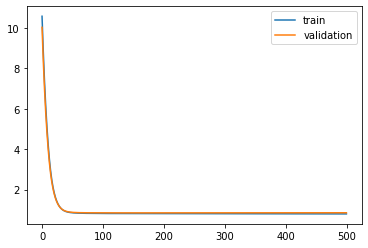

Time to train LSTM:  347.6821358203888
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 5s - loss: 10.4861 - pdc_loss: 0.7255 - event_loss: 0.6925 - val_loss: 9.9359 - val_pdc_loss: 0.7150 - val_event_loss: 0.6725

Epoch 00001: val_loss improved from inf to 9.93591, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 9.6016 - pdc_loss: 0.7104 - event_loss: 0.6669 - val_loss: 9.0895 - val_pdc_loss: 0.7008 - val_event_loss: 0.6476

Epoch 00002: val_loss improved from 9.93591 to 9.08947, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 8.7798 - pdc_loss: 0.6968 - event_loss: 0.6421 - val_loss: 8.3058 - val_pdc_loss: 0.6880 - val_event_loss: 0.6235

Epoch 00003: val_loss improved from 9.08947 to 8.30583, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 8.0204 - pdc_loss: 0.6845 - event_loss: 0.6181 - val_loss: 7.5835 - val_pdc_loss: 0.6764 - val_event_loss: 0.6000

Epoch 00004: val_loss improved from 8.30583 to 7.58346, saving 


Epoch 00035: val_loss improved from 1.00036 to 0.97990, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.9693 - pdc_loss: 0.5465 - event_loss: 0.2991 - val_loss: 0.9621 - val_pdc_loss: 0.5473 - val_event_loss: 0.3009

Epoch 00036: val_loss improved from 0.97990 to 0.96208, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.9523 - pdc_loss: 0.5454 - event_loss: 0.2988 - val_loss: 0.9465 - val_pdc_loss: 0.5463 - val_event_loss: 0.3007

Epoch 00037: val_loss improved from 0.96208 to 0.94652, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.9375 - pdc_loss: 0.5444 - event_loss: 0.2987 - val_loss: 0.9330 - val_pdc_loss: 0.5454 - val_event_loss: 0.3006

Epoch 00038: val_loss improved from 0.94652 to 0.93297, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 0.9245 - pdc_loss: 0.5434 - event_loss: 0.2985 - val_loss: 0.9211 - val_pdc_loss: 0.5444 - val_event_loss: 0.3005

Epoch 00039: val_loss improved from 0.93297 to 

 - 1s - loss: 0.8272 - pdc_loss: 0.5188 - event_loss: 0.2962 - val_loss: 0.8332 - val_pdc_loss: 0.5222 - val_event_loss: 0.2989

Epoch 00070: val_loss improved from 0.83376 to 0.83317, saving model to Event_val_weights5.hdf5
Epoch 71/500
 - 1s - loss: 0.8266 - pdc_loss: 0.5185 - event_loss: 0.2961 - val_loss: 0.8330 - val_pdc_loss: 0.5221 - val_event_loss: 0.2990

Epoch 00071: val_loss improved from 0.83317 to 0.83304, saving model to Event_val_weights5.hdf5
Epoch 72/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5182 - event_loss: 0.2960 - val_loss: 0.8323 - val_pdc_loss: 0.5217 - val_event_loss: 0.2988

Epoch 00072: val_loss improved from 0.83304 to 0.83226, saving model to Event_val_weights5.hdf5
Epoch 73/500
 - 1s - loss: 0.8256 - pdc_loss: 0.5179 - event_loss: 0.2960 - val_loss: 0.8319 - val_pdc_loss: 0.5215 - val_event_loss: 0.2988

Epoch 00073: val_loss improved from 0.83226 to 0.83192, saving model to Event_val_weights5.hdf5
Epoch 74/500
 - 1s - loss: 0.8252 - pdc_loss: 0.5176 - event_


Epoch 00107: val_loss improved from 0.82716 to 0.82657, saving model to Event_val_weights5.hdf5
Epoch 108/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5128 - event_loss: 0.2945 - val_loss: 0.8265 - val_pdc_loss: 0.5184 - val_event_loss: 0.2981

Epoch 00108: val_loss improved from 0.82657 to 0.82646, saving model to Event_val_weights5.hdf5
Epoch 109/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5126 - event_loss: 0.2944 - val_loss: 0.8260 - val_pdc_loss: 0.5180 - val_event_loss: 0.2980

Epoch 00109: val_loss improved from 0.82646 to 0.82597, saving model to Event_val_weights5.hdf5
Epoch 110/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5126 - event_loss: 0.2944 - val_loss: 0.8262 - val_pdc_loss: 0.5183 - val_event_loss: 0.2980

Epoch 00110: val_loss did not improve from 0.82597
Epoch 111/500
 - 1s - loss: 0.8167 - pdc_loss: 0.5125 - event_loss: 0.2944 - val_loss: 0.8257 - val_pdc_loss: 0.5179 - val_event_loss: 0.2979

Epoch 00111: val_loss improved from 0.82597 to 0.82572, saving model to Event_val_weight


Epoch 00145: val_loss did not improve from 0.82393
Epoch 146/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5105 - event_loss: 0.2934 - val_loss: 0.8240 - val_pdc_loss: 0.5172 - val_event_loss: 0.2972

Epoch 00146: val_loss did not improve from 0.82393
Epoch 147/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5103 - event_loss: 0.2934 - val_loss: 0.8243 - val_pdc_loss: 0.5172 - val_event_loss: 0.2976

Epoch 00147: val_loss did not improve from 0.82393
Epoch 148/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5103 - event_loss: 0.2934 - val_loss: 0.8243 - val_pdc_loss: 0.5174 - val_event_loss: 0.2973

Epoch 00148: val_loss did not improve from 0.82393
Epoch 149/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5102 - event_loss: 0.2933 - val_loss: 0.8245 - val_pdc_loss: 0.5172 - val_event_loss: 0.2977

Epoch 00149: val_loss did not improve from 0.82393
Epoch 150/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5102 - event_loss: 0.2933 - val_loss: 0.8244 - val_pdc_loss: 0.5175 - val_event_loss: 0.2973

Epoch 00150: val_loss did not


Epoch 00186: val_loss did not improve from 0.82303
Epoch 187/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5086 - event_loss: 0.2926 - val_loss: 0.8265 - val_pdc_loss: 0.5192 - val_event_loss: 0.2977

Epoch 00187: val_loss did not improve from 0.82303
Epoch 188/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5086 - event_loss: 0.2926 - val_loss: 0.8265 - val_pdc_loss: 0.5188 - val_event_loss: 0.2980

Epoch 00188: val_loss did not improve from 0.82303
Epoch 189/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5087 - event_loss: 0.2926 - val_loss: 0.8259 - val_pdc_loss: 0.5187 - val_event_loss: 0.2976

Epoch 00189: val_loss did not improve from 0.82303
Epoch 190/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5086 - event_loss: 0.2926 - val_loss: 0.8255 - val_pdc_loss: 0.5184 - val_event_loss: 0.2974

Epoch 00190: val_loss did not improve from 0.82303
Epoch 191/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5084 - event_loss: 0.2925 - val_loss: 0.8249 - val_pdc_loss: 0.5179 - val_event_loss: 0.2973

Epoch 00191: val_loss did not

 - 1s - loss: 0.8076 - pdc_loss: 0.5064 - event_loss: 0.2915 - val_loss: 0.8255 - val_pdc_loss: 0.5185 - val_event_loss: 0.2972

Epoch 00229: val_loss did not improve from 0.82303
Epoch 230/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5063 - event_loss: 0.2914 - val_loss: 0.8254 - val_pdc_loss: 0.5186 - val_event_loss: 0.2972

Epoch 00230: val_loss did not improve from 0.82303
Epoch 231/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5063 - event_loss: 0.2915 - val_loss: 0.8254 - val_pdc_loss: 0.5185 - val_event_loss: 0.2972

Epoch 00231: val_loss did not improve from 0.82303
Epoch 232/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5063 - event_loss: 0.2913 - val_loss: 0.8259 - val_pdc_loss: 0.5187 - val_event_loss: 0.2975

Epoch 00232: val_loss did not improve from 0.82303
Epoch 233/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5062 - event_loss: 0.2914 - val_loss: 0.8255 - val_pdc_loss: 0.5187 - val_event_loss: 0.2971

Epoch 00233: val_loss did not improve from 0.82303
Epoch 234/500
 - 1s - loss: 0.8071 - pdc_los


Epoch 00271: val_loss did not improve from 0.82303
Epoch 272/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5046 - event_loss: 0.2905 - val_loss: 0.8279 - val_pdc_loss: 0.5203 - val_event_loss: 0.2978

Epoch 00272: val_loss did not improve from 0.82303
Epoch 273/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5046 - event_loss: 0.2906 - val_loss: 0.8275 - val_pdc_loss: 0.5196 - val_event_loss: 0.2981

Epoch 00273: val_loss did not improve from 0.82303
Epoch 274/500
 - 1s - loss: 0.8047 - pdc_loss: 0.5046 - event_loss: 0.2904 - val_loss: 0.8279 - val_pdc_loss: 0.5203 - val_event_loss: 0.2979

Epoch 00274: val_loss did not improve from 0.82303
Epoch 275/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5044 - event_loss: 0.2905 - val_loss: 0.8274 - val_pdc_loss: 0.5197 - val_event_loss: 0.2980

Epoch 00275: val_loss did not improve from 0.82303
Epoch 276/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5043 - event_loss: 0.2904 - val_loss: 0.8276 - val_pdc_loss: 0.5203 - val_event_loss: 0.2976

Epoch 00276: val_loss did not

 - 1s - loss: 0.8026 - pdc_loss: 0.5029 - event_loss: 0.2901 - val_loss: 0.8297 - val_pdc_loss: 0.5211 - val_event_loss: 0.2989

Epoch 00314: val_loss did not improve from 0.82303
Epoch 315/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5029 - event_loss: 0.2900 - val_loss: 0.8297 - val_pdc_loss: 0.5212 - val_event_loss: 0.2988

Epoch 00315: val_loss did not improve from 0.82303
Epoch 316/500
 - 1s - loss: 0.8028 - pdc_loss: 0.5032 - event_loss: 0.2900 - val_loss: 0.8292 - val_pdc_loss: 0.5209 - val_event_loss: 0.2986

Epoch 00316: val_loss did not improve from 0.82303
Epoch 317/500
 - 1s - loss: 0.8028 - pdc_loss: 0.5031 - event_loss: 0.2900 - val_loss: 0.8288 - val_pdc_loss: 0.5208 - val_event_loss: 0.2984

Epoch 00317: val_loss did not improve from 0.82303
Epoch 318/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5029 - event_loss: 0.2900 - val_loss: 0.8298 - val_pdc_loss: 0.5213 - val_event_loss: 0.2989

Epoch 00318: val_loss did not improve from 0.82303
Epoch 319/500
 - 1s - loss: 0.8024 - pdc_los


Epoch 00356: val_loss did not improve from 0.82303
Epoch 357/500
 - 1s - loss: 0.8023 - pdc_loss: 0.5029 - event_loss: 0.2897 - val_loss: 0.8362 - val_pdc_loss: 0.5248 - val_event_loss: 0.3017

Epoch 00357: val_loss did not improve from 0.82303
Epoch 358/500
 - 1s - loss: 0.8020 - pdc_loss: 0.5026 - event_loss: 0.2898 - val_loss: 0.8343 - val_pdc_loss: 0.5233 - val_event_loss: 0.3014

Epoch 00358: val_loss did not improve from 0.82303
Epoch 359/500
 - 1s - loss: 0.8018 - pdc_loss: 0.5025 - event_loss: 0.2897 - val_loss: 0.8335 - val_pdc_loss: 0.5229 - val_event_loss: 0.3010

Epoch 00359: val_loss did not improve from 0.82303
Epoch 360/500
 - 1s - loss: 0.8023 - pdc_loss: 0.5028 - event_loss: 0.2899 - val_loss: 0.8335 - val_pdc_loss: 0.5229 - val_event_loss: 0.3010

Epoch 00360: val_loss did not improve from 0.82303
Epoch 361/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5029 - event_loss: 0.2899 - val_loss: 0.8354 - val_pdc_loss: 0.5235 - val_event_loss: 0.3022

Epoch 00361: val_loss did not

 - 1s - loss: 0.7990 - pdc_loss: 0.5004 - event_loss: 0.2892 - val_loss: 0.8334 - val_pdc_loss: 0.5230 - val_event_loss: 0.3010

Epoch 00399: val_loss did not improve from 0.82303
Epoch 400/500
 - 1s - loss: 0.7991 - pdc_loss: 0.5005 - event_loss: 0.2892 - val_loss: 0.8313 - val_pdc_loss: 0.5222 - val_event_loss: 0.2997

Epoch 00400: val_loss did not improve from 0.82303
Epoch 401/500
 - 1s - loss: 0.7990 - pdc_loss: 0.5004 - event_loss: 0.2893 - val_loss: 0.8323 - val_pdc_loss: 0.5230 - val_event_loss: 0.3000

Epoch 00401: val_loss did not improve from 0.82303
Epoch 402/500
 - 1s - loss: 0.7991 - pdc_loss: 0.5005 - event_loss: 0.2892 - val_loss: 0.8336 - val_pdc_loss: 0.5237 - val_event_loss: 0.3005

Epoch 00402: val_loss did not improve from 0.82303
Epoch 403/500
 - 1s - loss: 0.7992 - pdc_loss: 0.5007 - event_loss: 0.2891 - val_loss: 0.8329 - val_pdc_loss: 0.5232 - val_event_loss: 0.3004

Epoch 00403: val_loss did not improve from 0.82303
Epoch 404/500
 - 1s - loss: 0.7994 - pdc_los


Epoch 00441: val_loss did not improve from 0.82303
Epoch 442/500
 - 1s - loss: 0.7985 - pdc_loss: 0.5003 - event_loss: 0.2891 - val_loss: 0.8344 - val_pdc_loss: 0.5244 - val_event_loss: 0.3008

Epoch 00442: val_loss did not improve from 0.82303
Epoch 443/500
 - 1s - loss: 0.7986 - pdc_loss: 0.5004 - event_loss: 0.2890 - val_loss: 0.8327 - val_pdc_loss: 0.5232 - val_event_loss: 0.3002

Epoch 00443: val_loss did not improve from 0.82303
Epoch 444/500
 - 1s - loss: 0.7984 - pdc_loss: 0.5000 - event_loss: 0.2891 - val_loss: 0.8330 - val_pdc_loss: 0.5232 - val_event_loss: 0.3005

Epoch 00444: val_loss did not improve from 0.82303
Epoch 445/500
 - 1s - loss: 0.7981 - pdc_loss: 0.5000 - event_loss: 0.2889 - val_loss: 0.8329 - val_pdc_loss: 0.5230 - val_event_loss: 0.3006

Epoch 00445: val_loss did not improve from 0.82303
Epoch 446/500
 - 1s - loss: 0.7978 - pdc_loss: 0.4998 - event_loss: 0.2888 - val_loss: 0.8325 - val_pdc_loss: 0.5227 - val_event_loss: 0.3005

Epoch 00446: val_loss did not

 - 1s - loss: 0.7967 - pdc_loss: 0.4987 - event_loss: 0.2888 - val_loss: 0.8339 - val_pdc_loss: 0.5235 - val_event_loss: 0.3011

Epoch 00484: val_loss did not improve from 0.82303
Epoch 485/500
 - 1s - loss: 0.7964 - pdc_loss: 0.4986 - event_loss: 0.2884 - val_loss: 0.8346 - val_pdc_loss: 0.5239 - val_event_loss: 0.3014

Epoch 00485: val_loss did not improve from 0.82303
Epoch 486/500
 - 1s - loss: 0.7970 - pdc_loss: 0.4991 - event_loss: 0.2885 - val_loss: 0.8357 - val_pdc_loss: 0.5256 - val_event_loss: 0.3007

Epoch 00486: val_loss did not improve from 0.82303
Epoch 487/500
 - 1s - loss: 0.7971 - pdc_loss: 0.4991 - event_loss: 0.2887 - val_loss: 0.8370 - val_pdc_loss: 0.5267 - val_event_loss: 0.3009

Epoch 00487: val_loss did not improve from 0.82303
Epoch 488/500
 - 1s - loss: 0.7974 - pdc_loss: 0.4994 - event_loss: 0.2887 - val_loss: 0.8370 - val_pdc_loss: 0.5267 - val_event_loss: 0.3010

Epoch 00488: val_loss did not improve from 0.82303
Epoch 489/500
 - 1s - loss: 0.7977 - pdc_los

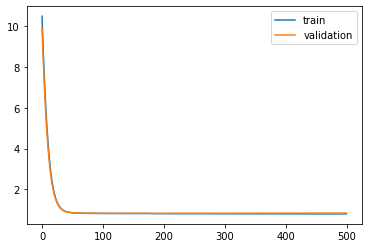

Time to train LSTM:  348.0663936138153
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 5s - loss: 10.7252 - pdc_loss: 0.7515 - event_loss: 0.7058 - val_loss: 10.3161 - val_pdc_loss: 0.7424 - val_event_loss: 0.6890

Epoch 00001: val_loss improved from inf to 10.31611, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 10.1724 - pdc_loss: 0.7352 - event_loss: 0.6852 - val_loss: 9.7798 - val_pdc_loss: 0.7269 - val_event_loss: 0.6688

Epoch 00002: val_loss improved from 10.31611 to 9.77979, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 9.6433 - pdc_loss: 0.7203 - event_loss: 0.6660 - val_loss: 9.2672 - val_pdc_loss: 0.7130 - val_event_loss: 0.6498

Epoch 00003: val_loss improved from 9.77979 to 9.26720, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 9.1377 - pdc_loss: 0.7070 - event_loss: 0.6480 - val_loss: 8.7782 - val_pdc_loss: 0.7008 - val_event_loss: 0.6320

Epoch 00004: val_loss improved from 9.26720 to 8.77824, sav


Epoch 00035: val_loss improved from 1.81271 to 1.74119, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 1.7272 - pdc_loss: 0.5684 - event_loss: 0.3079 - val_loss: 1.6746 - val_pdc_loss: 0.5694 - val_event_loss: 0.3014

Epoch 00036: val_loss improved from 1.74119 to 1.67461, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 1.6616 - pdc_loss: 0.5668 - event_loss: 0.3069 - val_loss: 1.6126 - val_pdc_loss: 0.5678 - val_event_loss: 0.3009

Epoch 00037: val_loss improved from 1.67461 to 1.61259, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 1.6004 - pdc_loss: 0.5653 - event_loss: 0.3061 - val_loss: 1.5548 - val_pdc_loss: 0.5663 - val_event_loss: 0.3003

Epoch 00038: val_loss improved from 1.61259 to 1.55485, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 1.5436 - pdc_loss: 0.5639 - event_loss: 0.3053 - val_loss: 1.5011 - val_pdc_loss: 0.5649 - val_event_loss: 0.2998

Epoch 00039: val_loss improved from 1.55485 to 

 - 1s - loss: 0.8935 - pdc_loss: 0.5378 - event_loss: 0.2991 - val_loss: 0.8883 - val_pdc_loss: 0.5396 - val_event_loss: 0.2950

Epoch 00070: val_loss improved from 0.89306 to 0.88827, saving model to Event_val_weights1.hdf5
Epoch 71/500
 - 1s - loss: 0.8887 - pdc_loss: 0.5370 - event_loss: 0.2990 - val_loss: 0.8838 - val_pdc_loss: 0.5389 - val_event_loss: 0.2949

Epoch 00071: val_loss improved from 0.88827 to 0.88383, saving model to Event_val_weights1.hdf5
Epoch 72/500
 - 1s - loss: 0.8842 - pdc_loss: 0.5362 - event_loss: 0.2990 - val_loss: 0.8797 - val_pdc_loss: 0.5382 - val_event_loss: 0.2949

Epoch 00072: val_loss improved from 0.88383 to 0.87970, saving model to Event_val_weights1.hdf5
Epoch 73/500
 - 1s - loss: 0.8801 - pdc_loss: 0.5354 - event_loss: 0.2989 - val_loss: 0.8758 - val_pdc_loss: 0.5374 - val_event_loss: 0.2949

Epoch 00073: val_loss improved from 0.87970 to 0.87585, saving model to Event_val_weights1.hdf5
Epoch 74/500
 - 1s - loss: 0.8763 - pdc_loss: 0.5346 - event_


Epoch 00104: val_loss improved from 0.82964 to 0.82926, saving model to Event_val_weights1.hdf5
Epoch 105/500
 - 1s - loss: 0.8309 - pdc_loss: 0.5206 - event_loss: 0.2976 - val_loss: 0.8289 - val_pdc_loss: 0.5231 - val_event_loss: 0.2931

Epoch 00105: val_loss improved from 0.82926 to 0.82886, saving model to Event_val_weights1.hdf5
Epoch 106/500
 - 1s - loss: 0.8305 - pdc_loss: 0.5204 - event_loss: 0.2975 - val_loss: 0.8285 - val_pdc_loss: 0.5229 - val_event_loss: 0.2931

Epoch 00106: val_loss improved from 0.82886 to 0.82851, saving model to Event_val_weights1.hdf5
Epoch 107/500
 - 1s - loss: 0.8301 - pdc_loss: 0.5202 - event_loss: 0.2975 - val_loss: 0.8282 - val_pdc_loss: 0.5227 - val_event_loss: 0.2931

Epoch 00107: val_loss improved from 0.82851 to 0.82815, saving model to Event_val_weights1.hdf5
Epoch 108/500
 - 1s - loss: 0.8298 - pdc_loss: 0.5200 - event_loss: 0.2975 - val_loss: 0.8278 - val_pdc_loss: 0.5226 - val_event_loss: 0.2930

Epoch 00108: val_loss improved from 0.82815


Epoch 00140: val_loss improved from 0.82309 to 0.82293, saving model to Event_val_weights1.hdf5
Epoch 141/500
 - 1s - loss: 0.8225 - pdc_loss: 0.5155 - event_loss: 0.2964 - val_loss: 0.8229 - val_pdc_loss: 0.5201 - val_event_loss: 0.2923

Epoch 00141: val_loss improved from 0.82293 to 0.82291, saving model to Event_val_weights1.hdf5
Epoch 142/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5154 - event_loss: 0.2964 - val_loss: 0.8228 - val_pdc_loss: 0.5200 - val_event_loss: 0.2923

Epoch 00142: val_loss improved from 0.82291 to 0.82277, saving model to Event_val_weights1.hdf5
Epoch 143/500
 - 1s - loss: 0.8222 - pdc_loss: 0.5153 - event_loss: 0.2964 - val_loss: 0.8228 - val_pdc_loss: 0.5200 - val_event_loss: 0.2923

Epoch 00143: val_loss improved from 0.82277 to 0.82275, saving model to Event_val_weights1.hdf5
Epoch 144/500
 - 1s - loss: 0.8221 - pdc_loss: 0.5152 - event_loss: 0.2964 - val_loss: 0.8227 - val_pdc_loss: 0.5199 - val_event_loss: 0.2923

Epoch 00144: val_loss improved from 0.82275


Epoch 00178: val_loss improved from 0.82142 to 0.82142, saving model to Event_val_weights1.hdf5
Epoch 179/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5122 - event_loss: 0.2957 - val_loss: 0.8216 - val_pdc_loss: 0.5193 - val_event_loss: 0.2922

Epoch 00179: val_loss did not improve from 0.82142
Epoch 180/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5121 - event_loss: 0.2957 - val_loss: 0.8213 - val_pdc_loss: 0.5189 - val_event_loss: 0.2922

Epoch 00180: val_loss improved from 0.82142 to 0.82128, saving model to Event_val_weights1.hdf5
Epoch 181/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5121 - event_loss: 0.2957 - val_loss: 0.8217 - val_pdc_loss: 0.5193 - val_event_loss: 0.2922

Epoch 00181: val_loss did not improve from 0.82128
Epoch 182/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5120 - event_loss: 0.2957 - val_loss: 0.8213 - val_pdc_loss: 0.5189 - val_event_loss: 0.2922

Epoch 00182: val_loss did not improve from 0.82128
Epoch 183/500
 - 1s - loss: 0.8177 - pdc_loss: 0.5119 - event_loss: 0.2957 - val_l


Epoch 00219: val_loss did not improve from 0.82060
Epoch 220/500
 - 1s - loss: 0.8147 - pdc_loss: 0.5096 - event_loss: 0.2950 - val_loss: 0.8221 - val_pdc_loss: 0.5197 - val_event_loss: 0.2924

Epoch 00220: val_loss did not improve from 0.82060
Epoch 221/500
 - 1s - loss: 0.8148 - pdc_loss: 0.5097 - event_loss: 0.2950 - val_loss: 0.8228 - val_pdc_loss: 0.5203 - val_event_loss: 0.2924

Epoch 00221: val_loss did not improve from 0.82060
Epoch 222/500
 - 1s - loss: 0.8148 - pdc_loss: 0.5097 - event_loss: 0.2950 - val_loss: 0.8231 - val_pdc_loss: 0.5207 - val_event_loss: 0.2923

Epoch 00222: val_loss did not improve from 0.82060
Epoch 223/500
 - 1s - loss: 0.8149 - pdc_loss: 0.5098 - event_loss: 0.2950 - val_loss: 0.8232 - val_pdc_loss: 0.5208 - val_event_loss: 0.2924

Epoch 00223: val_loss did not improve from 0.82060
Epoch 224/500
 - 1s - loss: 0.8149 - pdc_loss: 0.5099 - event_loss: 0.2949 - val_loss: 0.8233 - val_pdc_loss: 0.5209 - val_event_loss: 0.2923

Epoch 00224: val_loss did not


Epoch 00261: val_loss did not improve from 0.82011
Epoch 262/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5068 - event_loss: 0.2944 - val_loss: 0.8203 - val_pdc_loss: 0.5181 - val_event_loss: 0.2921

Epoch 00262: val_loss did not improve from 0.82011
Epoch 263/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5068 - event_loss: 0.2944 - val_loss: 0.8201 - val_pdc_loss: 0.5179 - val_event_loss: 0.2921

Epoch 00263: val_loss improved from 0.82011 to 0.82009, saving model to Event_val_weights1.hdf5
Epoch 264/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5068 - event_loss: 0.2944 - val_loss: 0.8203 - val_pdc_loss: 0.5181 - val_event_loss: 0.2921

Epoch 00264: val_loss did not improve from 0.82009
Epoch 265/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5070 - event_loss: 0.2944 - val_loss: 0.8205 - val_pdc_loss: 0.5184 - val_event_loss: 0.2921

Epoch 00265: val_loss did not improve from 0.82009
Epoch 266/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5070 - event_loss: 0.2944 - val_loss: 0.8208 - val_pdc_loss: 0.5187 - val_even


Epoch 00303: val_loss did not improve from 0.82009
Epoch 304/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5058 - event_loss: 0.2940 - val_loss: 0.8207 - val_pdc_loss: 0.5190 - val_event_loss: 0.2919

Epoch 00304: val_loss did not improve from 0.82009
Epoch 305/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5058 - event_loss: 0.2940 - val_loss: 0.8209 - val_pdc_loss: 0.5191 - val_event_loss: 0.2920

Epoch 00305: val_loss did not improve from 0.82009
Epoch 306/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5058 - event_loss: 0.2939 - val_loss: 0.8208 - val_pdc_loss: 0.5190 - val_event_loss: 0.2920

Epoch 00306: val_loss did not improve from 0.82009
Epoch 307/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5058 - event_loss: 0.2939 - val_loss: 0.8208 - val_pdc_loss: 0.5191 - val_event_loss: 0.2920

Epoch 00307: val_loss did not improve from 0.82009
Epoch 308/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5057 - event_loss: 0.2939 - val_loss: 0.8204 - val_pdc_loss: 0.5188 - val_event_loss: 0.2919

Epoch 00308: val_loss did not


Epoch 00345: val_loss did not improve from 0.82009
Epoch 346/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5049 - event_loss: 0.2935 - val_loss: 0.8209 - val_pdc_loss: 0.5193 - val_event_loss: 0.2917

Epoch 00346: val_loss did not improve from 0.82009
Epoch 347/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5047 - event_loss: 0.2935 - val_loss: 0.8220 - val_pdc_loss: 0.5203 - val_event_loss: 0.2918

Epoch 00347: val_loss did not improve from 0.82009
Epoch 348/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5043 - event_loss: 0.2935 - val_loss: 0.8221 - val_pdc_loss: 0.5204 - val_event_loss: 0.2919

Epoch 00348: val_loss did not improve from 0.82009
Epoch 349/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5042 - event_loss: 0.2934 - val_loss: 0.8216 - val_pdc_loss: 0.5199 - val_event_loss: 0.2918

Epoch 00349: val_loss did not improve from 0.82009
Epoch 350/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5042 - event_loss: 0.2934 - val_loss: 0.8214 - val_pdc_loss: 0.5196 - val_event_loss: 0.2920

Epoch 00350: val_loss did not

 - 1s - loss: 0.8057 - pdc_loss: 0.5028 - event_loss: 0.2931 - val_loss: 0.8221 - val_pdc_loss: 0.5204 - val_event_loss: 0.2920

Epoch 00388: val_loss did not improve from 0.82009
Epoch 389/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5027 - event_loss: 0.2931 - val_loss: 0.8222 - val_pdc_loss: 0.5205 - val_event_loss: 0.2920

Epoch 00389: val_loss did not improve from 0.82009
Epoch 390/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5027 - event_loss: 0.2931 - val_loss: 0.8221 - val_pdc_loss: 0.5204 - val_event_loss: 0.2920

Epoch 00390: val_loss did not improve from 0.82009
Epoch 391/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5027 - event_loss: 0.2931 - val_loss: 0.8223 - val_pdc_loss: 0.5206 - val_event_loss: 0.2920

Epoch 00391: val_loss did not improve from 0.82009
Epoch 392/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5028 - event_loss: 0.2931 - val_loss: 0.8222 - val_pdc_loss: 0.5204 - val_event_loss: 0.2921

Epoch 00392: val_loss did not improve from 0.82009
Epoch 393/500
 - 1s - loss: 0.8056 - pdc_los


Epoch 00430: val_loss did not improve from 0.82009
Epoch 431/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5021 - event_loss: 0.2928 - val_loss: 0.8244 - val_pdc_loss: 0.5223 - val_event_loss: 0.2923

Epoch 00431: val_loss did not improve from 0.82009
Epoch 432/500
 - 1s - loss: 0.8047 - pdc_loss: 0.5021 - event_loss: 0.2928 - val_loss: 0.8239 - val_pdc_loss: 0.5217 - val_event_loss: 0.2925

Epoch 00432: val_loss did not improve from 0.82009
Epoch 433/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5019 - event_loss: 0.2928 - val_loss: 0.8236 - val_pdc_loss: 0.5213 - val_event_loss: 0.2925

Epoch 00433: val_loss did not improve from 0.82009
Epoch 434/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5019 - event_loss: 0.2928 - val_loss: 0.8230 - val_pdc_loss: 0.5207 - val_event_loss: 0.2926

Epoch 00434: val_loss did not improve from 0.82009
Epoch 435/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5019 - event_loss: 0.2928 - val_loss: 0.8230 - val_pdc_loss: 0.5206 - val_event_loss: 0.2927

Epoch 00435: val_loss did not

 - 1s - loss: 0.8043 - pdc_loss: 0.5020 - event_loss: 0.2926 - val_loss: 0.8245 - val_pdc_loss: 0.5220 - val_event_loss: 0.2928

Epoch 00473: val_loss did not improve from 0.82009
Epoch 474/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5017 - event_loss: 0.2926 - val_loss: 0.8257 - val_pdc_loss: 0.5231 - val_event_loss: 0.2929

Epoch 00474: val_loss did not improve from 0.82009
Epoch 475/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5016 - event_loss: 0.2925 - val_loss: 0.8256 - val_pdc_loss: 0.5230 - val_event_loss: 0.2929

Epoch 00475: val_loss did not improve from 0.82009
Epoch 476/500
 - 1s - loss: 0.8035 - pdc_loss: 0.5014 - event_loss: 0.2925 - val_loss: 0.8247 - val_pdc_loss: 0.5219 - val_event_loss: 0.2931

Epoch 00476: val_loss did not improve from 0.82009
Epoch 477/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5012 - event_loss: 0.2925 - val_loss: 0.8246 - val_pdc_loss: 0.5217 - val_event_loss: 0.2933

Epoch 00477: val_loss did not improve from 0.82009
Epoch 478/500
 - 1s - loss: 0.8034 - pdc_los

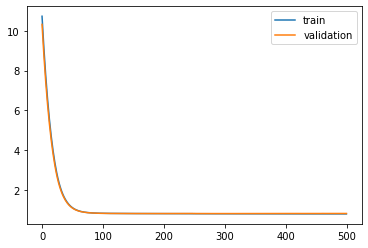

Time to train LSTM:  361.2908046245575
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 5s - loss: 10.5605 - pdc_loss: 0.6983 - event_loss: 0.7364 - val_loss: 10.1451 - val_pdc_loss: 0.6886 - val_event_loss: 0.7110

Epoch 00001: val_loss improved from inf to 10.14509, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 10.0099 - pdc_loss: 0.6885 - event_loss: 0.7074 - val_loss: 9.6134 - val_pdc_loss: 0.6799 - val_event_loss: 0.6845

Epoch 00002: val_loss improved from 10.14509 to 9.61337, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 9.4833 - pdc_loss: 0.6796 - event_loss: 0.6809 - val_loss: 9.1057 - val_pdc_loss: 0.6721 - val_event_loss: 0.6605

Epoch 00003: val_loss improved from 9.61337 to 9.10571, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 8.9809 - pdc_loss: 0.6715 - event_loss: 0.6569 - val_loss: 8.6218 - val_pdc_loss: 0.6650 - val_event_loss: 0.6388

Epoch 00004: val_loss improved from 9.10571 to 8.62183, sav


Epoch 00035: val_loss improved from 1.78967 to 1.71976, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 1.6903 - pdc_loss: 0.5640 - event_loss: 0.3052 - val_loss: 1.6547 - val_pdc_loss: 0.5669 - val_event_loss: 0.3125

Epoch 00036: val_loss improved from 1.71976 to 1.65473, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 1.6262 - pdc_loss: 0.5623 - event_loss: 0.3042 - val_loss: 1.5943 - val_pdc_loss: 0.5655 - val_event_loss: 0.3117

Epoch 00037: val_loss improved from 1.65473 to 1.59428, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 1.5667 - pdc_loss: 0.5607 - event_loss: 0.3034 - val_loss: 1.5381 - val_pdc_loss: 0.5642 - val_event_loss: 0.3110

Epoch 00038: val_loss improved from 1.59428 to 1.53811, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 1.5114 - pdc_loss: 0.5592 - event_loss: 0.3027 - val_loss: 1.4860 - val_pdc_loss: 0.5630 - val_event_loss: 0.3104

Epoch 00039: val_loss improved from 1.53811 to 

 - 1s - loss: 0.8850 - pdc_loss: 0.5338 - event_loss: 0.2972 - val_loss: 0.8963 - val_pdc_loss: 0.5397 - val_event_loss: 0.3054

Epoch 00070: val_loss improved from 0.90083 to 0.89633, saving model to Event_val_weights2.hdf5
Epoch 71/500
 - 1s - loss: 0.8806 - pdc_loss: 0.5331 - event_loss: 0.2972 - val_loss: 0.8922 - val_pdc_loss: 0.5390 - val_event_loss: 0.3054

Epoch 00071: val_loss improved from 0.89633 to 0.89218, saving model to Event_val_weights2.hdf5
Epoch 72/500
 - 1s - loss: 0.8765 - pdc_loss: 0.5324 - event_loss: 0.2972 - val_loss: 0.8884 - val_pdc_loss: 0.5384 - val_event_loss: 0.3054

Epoch 00072: val_loss improved from 0.89218 to 0.88835, saving model to Event_val_weights2.hdf5
Epoch 73/500
 - 1s - loss: 0.8727 - pdc_loss: 0.5317 - event_loss: 0.2971 - val_loss: 0.8848 - val_pdc_loss: 0.5377 - val_event_loss: 0.3053

Epoch 00073: val_loss improved from 0.88835 to 0.88481, saving model to Event_val_weights2.hdf5
Epoch 74/500
 - 1s - loss: 0.8692 - pdc_loss: 0.5310 - event_


Epoch 00104: val_loss improved from 0.84485 to 0.84448, saving model to Event_val_weights2.hdf5
Epoch 105/500
 - 1s - loss: 0.8269 - pdc_loss: 0.5180 - event_loss: 0.2961 - val_loss: 0.8441 - val_pdc_loss: 0.5273 - val_event_loss: 0.3042

Epoch 00105: val_loss improved from 0.84448 to 0.84412, saving model to Event_val_weights2.hdf5
Epoch 106/500
 - 1s - loss: 0.8265 - pdc_loss: 0.5178 - event_loss: 0.2960 - val_loss: 0.8438 - val_pdc_loss: 0.5271 - val_event_loss: 0.3041

Epoch 00106: val_loss improved from 0.84412 to 0.84379, saving model to Event_val_weights2.hdf5
Epoch 107/500
 - 1s - loss: 0.8260 - pdc_loss: 0.5175 - event_loss: 0.2960 - val_loss: 0.8435 - val_pdc_loss: 0.5270 - val_event_loss: 0.3040

Epoch 00107: val_loss improved from 0.84379 to 0.84347, saving model to Event_val_weights2.hdf5
Epoch 108/500
 - 1s - loss: 0.8256 - pdc_loss: 0.5173 - event_loss: 0.2959 - val_loss: 0.8432 - val_pdc_loss: 0.5269 - val_event_loss: 0.3040

Epoch 00108: val_loss improved from 0.84347


Epoch 00139: val_loss improved from 0.83833 to 0.83812, saving model to Event_val_weights2.hdf5
Epoch 140/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5127 - event_loss: 0.2947 - val_loss: 0.8381 - val_pdc_loss: 0.5251 - val_event_loss: 0.3026

Epoch 00140: val_loss improved from 0.83812 to 0.83807, saving model to Event_val_weights2.hdf5
Epoch 141/500
 - 1s - loss: 0.8176 - pdc_loss: 0.5126 - event_loss: 0.2946 - val_loss: 0.8381 - val_pdc_loss: 0.5252 - val_event_loss: 0.3026

Epoch 00141: val_loss did not improve from 0.83807
Epoch 142/500
 - 1s - loss: 0.8174 - pdc_loss: 0.5125 - event_loss: 0.2946 - val_loss: 0.8379 - val_pdc_loss: 0.5250 - val_event_loss: 0.3026

Epoch 00142: val_loss improved from 0.83807 to 0.83790, saving model to Event_val_weights2.hdf5
Epoch 143/500
 - 1s - loss: 0.8173 - pdc_loss: 0.5124 - event_loss: 0.2946 - val_loss: 0.8378 - val_pdc_loss: 0.5250 - val_event_loss: 0.3025

Epoch 00143: val_loss improved from 0.83790 to 0.83782, saving model to Event_val_weight


Epoch 00177: val_loss did not improve from 0.83657
Epoch 178/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5098 - event_loss: 0.2938 - val_loss: 0.8367 - val_pdc_loss: 0.5247 - val_event_loss: 0.3022

Epoch 00178: val_loss did not improve from 0.83657
Epoch 179/500
 - 1s - loss: 0.8133 - pdc_loss: 0.5098 - event_loss: 0.2938 - val_loss: 0.8368 - val_pdc_loss: 0.5247 - val_event_loss: 0.3023

Epoch 00179: val_loss did not improve from 0.83657
Epoch 180/500
 - 1s - loss: 0.8133 - pdc_loss: 0.5097 - event_loss: 0.2938 - val_loss: 0.8367 - val_pdc_loss: 0.5246 - val_event_loss: 0.3022

Epoch 00180: val_loss did not improve from 0.83657
Epoch 181/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5097 - event_loss: 0.2937 - val_loss: 0.8368 - val_pdc_loss: 0.5248 - val_event_loss: 0.3023

Epoch 00181: val_loss did not improve from 0.83657
Epoch 182/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5096 - event_loss: 0.2937 - val_loss: 0.8366 - val_pdc_loss: 0.5246 - val_event_loss: 0.3022

Epoch 00182: val_loss did not

 - 1s - loss: 0.8103 - pdc_loss: 0.5076 - event_loss: 0.2930 - val_loss: 0.8381 - val_pdc_loss: 0.5257 - val_event_loss: 0.3027

Epoch 00220: val_loss did not improve from 0.83657
Epoch 221/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5076 - event_loss: 0.2930 - val_loss: 0.8384 - val_pdc_loss: 0.5260 - val_event_loss: 0.3028

Epoch 00221: val_loss did not improve from 0.83657
Epoch 222/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5075 - event_loss: 0.2930 - val_loss: 0.8382 - val_pdc_loss: 0.5258 - val_event_loss: 0.3028

Epoch 00222: val_loss did not improve from 0.83657
Epoch 223/500
 - 1s - loss: 0.8101 - pdc_loss: 0.5075 - event_loss: 0.2930 - val_loss: 0.8386 - val_pdc_loss: 0.5261 - val_event_loss: 0.3028

Epoch 00223: val_loss did not improve from 0.83657
Epoch 224/500
 - 1s - loss: 0.8101 - pdc_loss: 0.5075 - event_loss: 0.2930 - val_loss: 0.8385 - val_pdc_loss: 0.5260 - val_event_loss: 0.3028

Epoch 00224: val_loss did not improve from 0.83657
Epoch 225/500
 - 1s - loss: 0.8100 - pdc_los


Epoch 00262: val_loss did not improve from 0.83657
Epoch 263/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5058 - event_loss: 0.2922 - val_loss: 0.8398 - val_pdc_loss: 0.5270 - val_event_loss: 0.3031

Epoch 00263: val_loss did not improve from 0.83657
Epoch 264/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5057 - event_loss: 0.2922 - val_loss: 0.8402 - val_pdc_loss: 0.5273 - val_event_loss: 0.3032

Epoch 00264: val_loss did not improve from 0.83657
Epoch 265/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5056 - event_loss: 0.2922 - val_loss: 0.8398 - val_pdc_loss: 0.5270 - val_event_loss: 0.3031

Epoch 00265: val_loss did not improve from 0.83657
Epoch 266/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5055 - event_loss: 0.2921 - val_loss: 0.8401 - val_pdc_loss: 0.5272 - val_event_loss: 0.3032

Epoch 00266: val_loss did not improve from 0.83657
Epoch 267/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5055 - event_loss: 0.2921 - val_loss: 0.8399 - val_pdc_loss: 0.5271 - val_event_loss: 0.3032

Epoch 00267: val_loss did not

 - 1s - loss: 0.8054 - pdc_loss: 0.5043 - event_loss: 0.2915 - val_loss: 0.8422 - val_pdc_loss: 0.5287 - val_event_loss: 0.3039

Epoch 00305: val_loss did not improve from 0.83657
Epoch 306/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5044 - event_loss: 0.2914 - val_loss: 0.8425 - val_pdc_loss: 0.5289 - val_event_loss: 0.3039

Epoch 00306: val_loss did not improve from 0.83657
Epoch 307/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5044 - event_loss: 0.2914 - val_loss: 0.8424 - val_pdc_loss: 0.5288 - val_event_loss: 0.3039

Epoch 00307: val_loss did not improve from 0.83657
Epoch 308/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5046 - event_loss: 0.2914 - val_loss: 0.8425 - val_pdc_loss: 0.5289 - val_event_loss: 0.3039

Epoch 00308: val_loss did not improve from 0.83657
Epoch 309/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5046 - event_loss: 0.2914 - val_loss: 0.8425 - val_pdc_loss: 0.5290 - val_event_loss: 0.3039

Epoch 00309: val_loss did not improve from 0.83657
Epoch 310/500
 - 1s - loss: 0.8058 - pdc_los


Epoch 00347: val_loss did not improve from 0.83657
Epoch 348/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5037 - event_loss: 0.2907 - val_loss: 0.8445 - val_pdc_loss: 0.5303 - val_event_loss: 0.3046

Epoch 00348: val_loss did not improve from 0.83657
Epoch 349/500
 - 1s - loss: 0.8043 - pdc_loss: 0.5040 - event_loss: 0.2907 - val_loss: 0.8449 - val_pdc_loss: 0.5308 - val_event_loss: 0.3045

Epoch 00349: val_loss did not improve from 0.83657
Epoch 350/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5041 - event_loss: 0.2907 - val_loss: 0.8452 - val_pdc_loss: 0.5309 - val_event_loss: 0.3047

Epoch 00350: val_loss did not improve from 0.83657
Epoch 351/500
 - 1s - loss: 0.8040 - pdc_loss: 0.5037 - event_loss: 0.2906 - val_loss: 0.8440 - val_pdc_loss: 0.5298 - val_event_loss: 0.3046

Epoch 00351: val_loss did not improve from 0.83657
Epoch 352/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5032 - event_loss: 0.2905 - val_loss: 0.8438 - val_pdc_loss: 0.5295 - val_event_loss: 0.3047

Epoch 00352: val_loss did not

 - 1s - loss: 0.8014 - pdc_loss: 0.5018 - event_loss: 0.2900 - val_loss: 0.8458 - val_pdc_loss: 0.5304 - val_event_loss: 0.3058

Epoch 00390: val_loss did not improve from 0.83657
Epoch 391/500
 - 1s - loss: 0.8015 - pdc_loss: 0.5018 - event_loss: 0.2900 - val_loss: 0.8455 - val_pdc_loss: 0.5302 - val_event_loss: 0.3056

Epoch 00391: val_loss did not improve from 0.83657
Epoch 392/500
 - 1s - loss: 0.8013 - pdc_loss: 0.5017 - event_loss: 0.2900 - val_loss: 0.8461 - val_pdc_loss: 0.5307 - val_event_loss: 0.3058

Epoch 00392: val_loss did not improve from 0.83657
Epoch 393/500
 - 1s - loss: 0.8015 - pdc_loss: 0.5019 - event_loss: 0.2900 - val_loss: 0.8453 - val_pdc_loss: 0.5302 - val_event_loss: 0.3055

Epoch 00393: val_loss did not improve from 0.83657
Epoch 394/500
 - 1s - loss: 0.8017 - pdc_loss: 0.5020 - event_loss: 0.2901 - val_loss: 0.8458 - val_pdc_loss: 0.5306 - val_event_loss: 0.3056

Epoch 00394: val_loss did not improve from 0.83657
Epoch 395/500
 - 1s - loss: 0.8020 - pdc_los


Epoch 00432: val_loss did not improve from 0.83657
Epoch 433/500
 - 1s - loss: 0.8001 - pdc_loss: 0.5010 - event_loss: 0.2894 - val_loss: 0.8473 - val_pdc_loss: 0.5314 - val_event_loss: 0.3063

Epoch 00433: val_loss did not improve from 0.83657
Epoch 434/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5009 - event_loss: 0.2894 - val_loss: 0.8470 - val_pdc_loss: 0.5311 - val_event_loss: 0.3062

Epoch 00434: val_loss did not improve from 0.83657
Epoch 435/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5009 - event_loss: 0.2894 - val_loss: 0.8466 - val_pdc_loss: 0.5308 - val_event_loss: 0.3061

Epoch 00435: val_loss did not improve from 0.83657
Epoch 436/500
 - 1s - loss: 0.8002 - pdc_loss: 0.5010 - event_loss: 0.2895 - val_loss: 0.8480 - val_pdc_loss: 0.5318 - val_event_loss: 0.3065

Epoch 00436: val_loss did not improve from 0.83657
Epoch 437/500
 - 1s - loss: 0.8005 - pdc_loss: 0.5013 - event_loss: 0.2895 - val_loss: 0.8478 - val_pdc_loss: 0.5318 - val_event_loss: 0.3063

Epoch 00437: val_loss did not

 - 1s - loss: 0.8000 - pdc_loss: 0.5014 - event_loss: 0.2890 - val_loss: 0.8488 - val_pdc_loss: 0.5330 - val_event_loss: 0.3063

Epoch 00475: val_loss did not improve from 0.83657
Epoch 476/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5012 - event_loss: 0.2890 - val_loss: 0.8487 - val_pdc_loss: 0.5326 - val_event_loss: 0.3065

Epoch 00476: val_loss did not improve from 0.83657
Epoch 477/500
 - 1s - loss: 0.7993 - pdc_loss: 0.5008 - event_loss: 0.2889 - val_loss: 0.8475 - val_pdc_loss: 0.5315 - val_event_loss: 0.3063

Epoch 00477: val_loss did not improve from 0.83657
Epoch 478/500
 - 1s - loss: 0.7989 - pdc_loss: 0.5004 - event_loss: 0.2889 - val_loss: 0.8479 - val_pdc_loss: 0.5317 - val_event_loss: 0.3065

Epoch 00478: val_loss did not improve from 0.83657
Epoch 479/500
 - 1s - loss: 0.7986 - pdc_loss: 0.5001 - event_loss: 0.2889 - val_loss: 0.8478 - val_pdc_loss: 0.5315 - val_event_loss: 0.3066

Epoch 00479: val_loss did not improve from 0.83657
Epoch 480/500
 - 1s - loss: 0.7986 - pdc_los

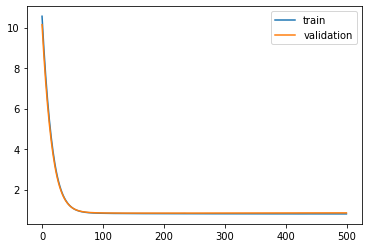

Time to train LSTM:  336.756534576416
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 6s - loss: 10.7925 - pdc_loss: 0.7234 - event_loss: 0.7180 - val_loss: 10.3824 - val_pdc_loss: 0.7204 - val_event_loss: 0.6984

Epoch 00001: val_loss improved from inf to 10.38238, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 10.2363 - pdc_loss: 0.7136 - event_loss: 0.6932 - val_loss: 9.8435 - val_pdc_loss: 0.7111 - val_event_loss: 0.6751

Epoch 00002: val_loss improved from 10.38238 to 9.84354, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 9.7035 - pdc_loss: 0.7043 - event_loss: 0.6705 - val_loss: 9.3280 - val_pdc_loss: 0.7024 - val_event_loss: 0.6537

Epoch 00003: val_loss improved from 9.84354 to 9.32801, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 9.1940 - pdc_loss: 0.6955 - event_loss: 0.6496 - val_loss: 8.8356 - val_pdc_loss: 0.6941 - val_event_loss: 0.6337

Epoch 00004: val_loss improved from 9.32801 to 8.83558, savi


Epoch 00035: val_loss improved from 1.83143 to 1.75991, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 1.7271 - pdc_loss: 0.5698 - event_loss: 0.3050 - val_loss: 1.6933 - val_pdc_loss: 0.5809 - val_event_loss: 0.3074

Epoch 00036: val_loss improved from 1.75991 to 1.69330, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 1.6614 - pdc_loss: 0.5683 - event_loss: 0.3042 - val_loss: 1.6313 - val_pdc_loss: 0.5796 - val_event_loss: 0.3068

Epoch 00037: val_loss improved from 1.69330 to 1.63129, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 1.6003 - pdc_loss: 0.5670 - event_loss: 0.3034 - val_loss: 1.5736 - val_pdc_loss: 0.5785 - val_event_loss: 0.3062

Epoch 00038: val_loss improved from 1.63129 to 1.57359, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 1.5435 - pdc_loss: 0.5658 - event_loss: 0.3028 - val_loss: 1.5199 - val_pdc_loss: 0.5774 - val_event_loss: 0.3057

Epoch 00039: val_loss improved from 1.57359 to 

 - 1s - loss: 0.8954 - pdc_loss: 0.5436 - event_loss: 0.2967 - val_loss: 0.9100 - val_pdc_loss: 0.5577 - val_event_loss: 0.3001

Epoch 00070: val_loss improved from 0.91453 to 0.90997, saving model to Event_val_weights3.hdf5
Epoch 71/500
 - 1s - loss: 0.8909 - pdc_loss: 0.5430 - event_loss: 0.2966 - val_loss: 0.9058 - val_pdc_loss: 0.5571 - val_event_loss: 0.3000

Epoch 00071: val_loss improved from 0.90997 to 0.90577, saving model to Event_val_weights3.hdf5
Epoch 72/500
 - 1s - loss: 0.8867 - pdc_loss: 0.5424 - event_loss: 0.2966 - val_loss: 0.9019 - val_pdc_loss: 0.5566 - val_event_loss: 0.3000

Epoch 00072: val_loss improved from 0.90577 to 0.90190, saving model to Event_val_weights3.hdf5
Epoch 73/500
 - 1s - loss: 0.8828 - pdc_loss: 0.5418 - event_loss: 0.2965 - val_loss: 0.8983 - val_pdc_loss: 0.5561 - val_event_loss: 0.2999

Epoch 00073: val_loss improved from 0.90190 to 0.89833, saving model to Event_val_weights3.hdf5
Epoch 74/500
 - 1s - loss: 0.8793 - pdc_loss: 0.5412 - event_


Epoch 00104: val_loss improved from 0.85521 to 0.85466, saving model to Event_val_weights3.hdf5
Epoch 105/500
 - 1s - loss: 0.8328 - pdc_loss: 0.5225 - event_loss: 0.2958 - val_loss: 0.8541 - val_pdc_loss: 0.5402 - val_event_loss: 0.2995

Epoch 00105: val_loss improved from 0.85466 to 0.85414, saving model to Event_val_weights3.hdf5
Epoch 106/500
 - 1s - loss: 0.8322 - pdc_loss: 0.5221 - event_loss: 0.2957 - val_loss: 0.8536 - val_pdc_loss: 0.5399 - val_event_loss: 0.2995

Epoch 00106: val_loss improved from 0.85414 to 0.85364, saving model to Event_val_weights3.hdf5
Epoch 107/500
 - 1s - loss: 0.8315 - pdc_loss: 0.5216 - event_loss: 0.2957 - val_loss: 0.8532 - val_pdc_loss: 0.5396 - val_event_loss: 0.2995

Epoch 00107: val_loss improved from 0.85364 to 0.85317, saving model to Event_val_weights3.hdf5
Epoch 108/500
 - 1s - loss: 0.8309 - pdc_loss: 0.5213 - event_loss: 0.2957 - val_loss: 0.8527 - val_pdc_loss: 0.5394 - val_event_loss: 0.2994

Epoch 00108: val_loss improved from 0.85317


Epoch 00139: val_loss improved from 0.84608 to 0.84602, saving model to Event_val_weights3.hdf5
Epoch 140/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5142 - event_loss: 0.2945 - val_loss: 0.8458 - val_pdc_loss: 0.5353 - val_event_loss: 0.2996

Epoch 00140: val_loss improved from 0.84602 to 0.84581, saving model to Event_val_weights3.hdf5
Epoch 141/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5140 - event_loss: 0.2945 - val_loss: 0.8460 - val_pdc_loss: 0.5355 - val_event_loss: 0.2996

Epoch 00141: val_loss did not improve from 0.84581
Epoch 142/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5140 - event_loss: 0.2945 - val_loss: 0.8457 - val_pdc_loss: 0.5352 - val_event_loss: 0.2996

Epoch 00142: val_loss improved from 0.84581 to 0.84569, saving model to Event_val_weights3.hdf5
Epoch 143/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5137 - event_loss: 0.2944 - val_loss: 0.8458 - val_pdc_loss: 0.5353 - val_event_loss: 0.2996

Epoch 00143: val_loss did not improve from 0.84569
Epoch 144/500
 - 1s - loss: 0.8189 - 

 - 1s - loss: 0.8131 - pdc_loss: 0.5092 - event_loss: 0.2936 - val_loss: 0.8433 - val_pdc_loss: 0.5329 - val_event_loss: 0.3001

Epoch 00178: val_loss did not improve from 0.84314
Epoch 179/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5091 - event_loss: 0.2935 - val_loss: 0.8433 - val_pdc_loss: 0.5329 - val_event_loss: 0.3001

Epoch 00179: val_loss did not improve from 0.84314
Epoch 180/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5092 - event_loss: 0.2935 - val_loss: 0.8433 - val_pdc_loss: 0.5329 - val_event_loss: 0.3001

Epoch 00180: val_loss did not improve from 0.84314
Epoch 181/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5092 - event_loss: 0.2935 - val_loss: 0.8431 - val_pdc_loss: 0.5327 - val_event_loss: 0.3001

Epoch 00181: val_loss improved from 0.84314 to 0.84306, saving model to Event_val_weights3.hdf5
Epoch 182/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5092 - event_loss: 0.2935 - val_loss: 0.8434 - val_pdc_loss: 0.5331 - val_event_loss: 0.3001

Epoch 00182: val_loss did not improve from 0.84306


Epoch 00219: val_loss did not improve from 0.84298
Epoch 220/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5072 - event_loss: 0.2929 - val_loss: 0.8434 - val_pdc_loss: 0.5331 - val_event_loss: 0.3002

Epoch 00220: val_loss did not improve from 0.84298
Epoch 221/500
 - 1s - loss: 0.8099 - pdc_loss: 0.5069 - event_loss: 0.2929 - val_loss: 0.8434 - val_pdc_loss: 0.5331 - val_event_loss: 0.3002

Epoch 00221: val_loss did not improve from 0.84298
Epoch 222/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5067 - event_loss: 0.2929 - val_loss: 0.8440 - val_pdc_loss: 0.5336 - val_event_loss: 0.3003

Epoch 00222: val_loss did not improve from 0.84298
Epoch 223/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5067 - event_loss: 0.2928 - val_loss: 0.8445 - val_pdc_loss: 0.5341 - val_event_loss: 0.3003

Epoch 00223: val_loss did not improve from 0.84298
Epoch 224/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5066 - event_loss: 0.2928 - val_loss: 0.8441 - val_pdc_loss: 0.5338 - val_event_loss: 0.3003

Epoch 00224: val_loss did not

 - 1s - loss: 0.8072 - pdc_loss: 0.5050 - event_loss: 0.2923 - val_loss: 0.8449 - val_pdc_loss: 0.5346 - val_event_loss: 0.3004

Epoch 00262: val_loss did not improve from 0.84298
Epoch 263/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5050 - event_loss: 0.2924 - val_loss: 0.8448 - val_pdc_loss: 0.5345 - val_event_loss: 0.3004

Epoch 00263: val_loss did not improve from 0.84298
Epoch 264/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5049 - event_loss: 0.2924 - val_loss: 0.8442 - val_pdc_loss: 0.5340 - val_event_loss: 0.3004

Epoch 00264: val_loss did not improve from 0.84298
Epoch 265/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5047 - event_loss: 0.2923 - val_loss: 0.8443 - val_pdc_loss: 0.5340 - val_event_loss: 0.3005

Epoch 00265: val_loss did not improve from 0.84298
Epoch 266/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5045 - event_loss: 0.2923 - val_loss: 0.8445 - val_pdc_loss: 0.5341 - val_event_loss: 0.3006

Epoch 00266: val_loss did not improve from 0.84298
Epoch 267/500
 - 1s - loss: 0.8064 - pdc_los


Epoch 00304: val_loss did not improve from 0.84298
Epoch 305/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5035 - event_loss: 0.2918 - val_loss: 0.8465 - val_pdc_loss: 0.5359 - val_event_loss: 0.3010

Epoch 00305: val_loss did not improve from 0.84298
Epoch 306/500
 - 1s - loss: 0.8053 - pdc_loss: 0.5037 - event_loss: 0.2919 - val_loss: 0.8470 - val_pdc_loss: 0.5362 - val_event_loss: 0.3011

Epoch 00306: val_loss did not improve from 0.84298
Epoch 307/500
 - 1s - loss: 0.8054 - pdc_loss: 0.5038 - event_loss: 0.2920 - val_loss: 0.8466 - val_pdc_loss: 0.5359 - val_event_loss: 0.3010

Epoch 00307: val_loss did not improve from 0.84298
Epoch 308/500
 - 1s - loss: 0.8053 - pdc_loss: 0.5037 - event_loss: 0.2919 - val_loss: 0.8455 - val_pdc_loss: 0.5348 - val_event_loss: 0.3010

Epoch 00308: val_loss did not improve from 0.84298
Epoch 309/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5033 - event_loss: 0.2919 - val_loss: 0.8455 - val_pdc_loss: 0.5347 - val_event_loss: 0.3011

Epoch 00309: val_loss did not

 - 1s - loss: 0.8039 - pdc_loss: 0.5028 - event_loss: 0.2914 - val_loss: 0.8494 - val_pdc_loss: 0.5378 - val_event_loss: 0.3020

Epoch 00347: val_loss did not improve from 0.84298
Epoch 348/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5030 - event_loss: 0.2913 - val_loss: 0.8492 - val_pdc_loss: 0.5379 - val_event_loss: 0.3017

Epoch 00348: val_loss did not improve from 0.84298
Epoch 349/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5027 - event_loss: 0.2912 - val_loss: 0.8477 - val_pdc_loss: 0.5364 - val_event_loss: 0.3017

Epoch 00349: val_loss did not improve from 0.84298
Epoch 350/500
 - 1s - loss: 0.8032 - pdc_loss: 0.5024 - event_loss: 0.2912 - val_loss: 0.8473 - val_pdc_loss: 0.5360 - val_event_loss: 0.3017

Epoch 00350: val_loss did not improve from 0.84298
Epoch 351/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5023 - event_loss: 0.2912 - val_loss: 0.8476 - val_pdc_loss: 0.5362 - val_event_loss: 0.3018

Epoch 00351: val_loss did not improve from 0.84298
Epoch 352/500
 - 1s - loss: 0.8032 - pdc_los


Epoch 00389: val_loss did not improve from 0.84298
Epoch 390/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5014 - event_loss: 0.2907 - val_loss: 0.8487 - val_pdc_loss: 0.5370 - val_event_loss: 0.3022

Epoch 00390: val_loss did not improve from 0.84298
Epoch 391/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5015 - event_loss: 0.2908 - val_loss: 0.8486 - val_pdc_loss: 0.5369 - val_event_loss: 0.3023

Epoch 00391: val_loss did not improve from 0.84298
Epoch 392/500
 - 1s - loss: 0.8017 - pdc_loss: 0.5015 - event_loss: 0.2908 - val_loss: 0.8497 - val_pdc_loss: 0.5379 - val_event_loss: 0.3023

Epoch 00392: val_loss did not improve from 0.84298
Epoch 393/500
 - 1s - loss: 0.8019 - pdc_loss: 0.5016 - event_loss: 0.2909 - val_loss: 0.8503 - val_pdc_loss: 0.5384 - val_event_loss: 0.3025

Epoch 00393: val_loss did not improve from 0.84298
Epoch 394/500
 - 1s - loss: 0.8021 - pdc_loss: 0.5017 - event_loss: 0.2909 - val_loss: 0.8508 - val_pdc_loss: 0.5388 - val_event_loss: 0.3026

Epoch 00394: val_loss did not

 - 1s - loss: 0.8009 - pdc_loss: 0.5010 - event_loss: 0.2906 - val_loss: 0.8513 - val_pdc_loss: 0.5392 - val_event_loss: 0.3028

Epoch 00432: val_loss did not improve from 0.84298
Epoch 433/500
 - 1s - loss: 0.8011 - pdc_loss: 0.5011 - event_loss: 0.2907 - val_loss: 0.8504 - val_pdc_loss: 0.5384 - val_event_loss: 0.3027

Epoch 00433: val_loss did not improve from 0.84298
Epoch 434/500
 - 1s - loss: 0.8009 - pdc_loss: 0.5009 - event_loss: 0.2907 - val_loss: 0.8500 - val_pdc_loss: 0.5379 - val_event_loss: 0.3027

Epoch 00434: val_loss did not improve from 0.84298
Epoch 435/500
 - 1s - loss: 0.8008 - pdc_loss: 0.5008 - event_loss: 0.2906 - val_loss: 0.8496 - val_pdc_loss: 0.5375 - val_event_loss: 0.3027

Epoch 00435: val_loss did not improve from 0.84298
Epoch 436/500
 - 1s - loss: 0.8004 - pdc_loss: 0.5006 - event_loss: 0.2905 - val_loss: 0.8509 - val_pdc_loss: 0.5384 - val_event_loss: 0.3031

Epoch 00436: val_loss did not improve from 0.84298
Epoch 437/500
 - 1s - loss: 0.8005 - pdc_los


Epoch 00474: val_loss did not improve from 0.84298
Epoch 475/500
 - 1s - loss: 0.7994 - pdc_loss: 0.5002 - event_loss: 0.2900 - val_loss: 0.8515 - val_pdc_loss: 0.5393 - val_event_loss: 0.3031

Epoch 00475: val_loss did not improve from 0.84298
Epoch 476/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5004 - event_loss: 0.2902 - val_loss: 0.8515 - val_pdc_loss: 0.5394 - val_event_loss: 0.3029

Epoch 00476: val_loss did not improve from 0.84298
Epoch 477/500
 - 1s - loss: 0.7997 - pdc_loss: 0.5004 - event_loss: 0.2901 - val_loss: 0.8509 - val_pdc_loss: 0.5388 - val_event_loss: 0.3030

Epoch 00477: val_loss did not improve from 0.84298
Epoch 478/500
 - 1s - loss: 0.7996 - pdc_loss: 0.5002 - event_loss: 0.2902 - val_loss: 0.8509 - val_pdc_loss: 0.5389 - val_event_loss: 0.3028

Epoch 00478: val_loss did not improve from 0.84298
Epoch 479/500
 - 1s - loss: 0.7992 - pdc_loss: 0.5000 - event_loss: 0.2901 - val_loss: 0.8505 - val_pdc_loss: 0.5384 - val_event_loss: 0.3029

Epoch 00479: val_loss did not

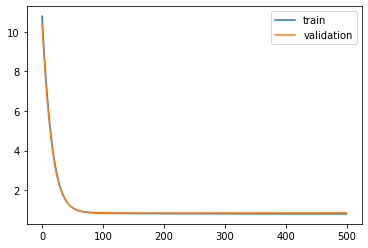

Time to train LSTM:  334.02859139442444
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 6s - loss: 10.5951 - pdc_loss: 0.7461 - event_loss: 0.7218 - val_loss: 10.1870 - val_pdc_loss: 0.7405 - val_event_loss: 0.6982

Epoch 00001: val_loss improved from inf to 10.18696, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 10.0392 - pdc_loss: 0.7344 - event_loss: 0.6876 - val_loss: 9.6489 - val_pdc_loss: 0.7297 - val_event_loss: 0.6659

Epoch 00002: val_loss improved from 10.18696 to 9.64889, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 9.5073 - pdc_loss: 0.7236 - event_loss: 0.6562 - val_loss: 9.1350 - val_pdc_loss: 0.7198 - val_event_loss: 0.6363

Epoch 00003: val_loss improved from 9.64889 to 9.13496, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 8.9995 - pdc_loss: 0.7137 - event_loss: 0.6273 - val_loss: 8.6450 - val_pdc_loss: 0.7107 - val_event_loss: 0.6091

Epoch 00004: val_loss improved from 9.13496 to 8.64499, sa


Epoch 00035: val_loss improved from 1.80704 to 1.73699, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 1.7077 - pdc_loss: 0.5727 - event_loss: 0.3049 - val_loss: 1.6718 - val_pdc_loss: 0.5782 - val_event_loss: 0.3096

Epoch 00036: val_loss improved from 1.73699 to 1.67180, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 1.6434 - pdc_loss: 0.5708 - event_loss: 0.3041 - val_loss: 1.6112 - val_pdc_loss: 0.5765 - val_event_loss: 0.3090

Epoch 00037: val_loss improved from 1.67180 to 1.61117, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 1.5835 - pdc_loss: 0.5689 - event_loss: 0.3035 - val_loss: 1.5548 - val_pdc_loss: 0.5750 - val_event_loss: 0.3085

Epoch 00038: val_loss improved from 1.61117 to 1.55480, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 1.5279 - pdc_loss: 0.5672 - event_loss: 0.3028 - val_loss: 1.5024 - val_pdc_loss: 0.5736 - val_event_loss: 0.3080

Epoch 00039: val_loss improved from 1.55480 to 

 - 1s - loss: 0.8952 - pdc_loss: 0.5436 - event_loss: 0.2968 - val_loss: 0.9113 - val_pdc_loss: 0.5558 - val_event_loss: 0.3035

Epoch 00070: val_loss improved from 0.91569 to 0.91133, saving model to Event_val_weights4.hdf5
Epoch 71/500
 - 1s - loss: 0.8908 - pdc_loss: 0.5430 - event_loss: 0.2967 - val_loss: 0.9073 - val_pdc_loss: 0.5554 - val_event_loss: 0.3034

Epoch 00071: val_loss improved from 0.91133 to 0.90732, saving model to Event_val_weights4.hdf5
Epoch 72/500
 - 1s - loss: 0.8868 - pdc_loss: 0.5425 - event_loss: 0.2967 - val_loss: 0.9036 - val_pdc_loss: 0.5550 - val_event_loss: 0.3034

Epoch 00072: val_loss improved from 0.90732 to 0.90362, saving model to Event_val_weights4.hdf5
Epoch 73/500
 - 1s - loss: 0.8830 - pdc_loss: 0.5420 - event_loss: 0.2966 - val_loss: 0.9002 - val_pdc_loss: 0.5546 - val_event_loss: 0.3033

Epoch 00073: val_loss improved from 0.90362 to 0.90020, saving model to Event_val_weights4.hdf5
Epoch 74/500
 - 1s - loss: 0.8795 - pdc_loss: 0.5414 - event_


Epoch 00104: val_loss improved from 0.85906 to 0.85861, saving model to Event_val_weights4.hdf5
Epoch 105/500
 - 1s - loss: 0.8335 - pdc_loss: 0.5240 - event_loss: 0.2952 - val_loss: 0.8582 - val_pdc_loss: 0.5421 - val_event_loss: 0.3020

Epoch 00105: val_loss improved from 0.85861 to 0.85818, saving model to Event_val_weights4.hdf5
Epoch 106/500
 - 1s - loss: 0.8328 - pdc_loss: 0.5237 - event_loss: 0.2951 - val_loss: 0.8578 - val_pdc_loss: 0.5420 - val_event_loss: 0.3019

Epoch 00106: val_loss improved from 0.85818 to 0.85779, saving model to Event_val_weights4.hdf5
Epoch 107/500
 - 1s - loss: 0.8323 - pdc_loss: 0.5233 - event_loss: 0.2951 - val_loss: 0.8574 - val_pdc_loss: 0.5418 - val_event_loss: 0.3019

Epoch 00107: val_loss improved from 0.85779 to 0.85740, saving model to Event_val_weights4.hdf5
Epoch 108/500
 - 1s - loss: 0.8317 - pdc_loss: 0.5230 - event_loss: 0.2951 - val_loss: 0.8571 - val_pdc_loss: 0.5417 - val_event_loss: 0.3019

Epoch 00108: val_loss improved from 0.85740

 - 1s - loss: 0.8220 - pdc_loss: 0.5172 - event_loss: 0.2939 - val_loss: 0.8521 - val_pdc_loss: 0.5396 - val_event_loss: 0.3016

Epoch 00139: val_loss improved from 0.85214 to 0.85210, saving model to Event_val_weights4.hdf5
Epoch 140/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5170 - event_loss: 0.2939 - val_loss: 0.8520 - val_pdc_loss: 0.5395 - val_event_loss: 0.3016

Epoch 00140: val_loss improved from 0.85210 to 0.85200, saving model to Event_val_weights4.hdf5
Epoch 141/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5169 - event_loss: 0.2939 - val_loss: 0.8519 - val_pdc_loss: 0.5395 - val_event_loss: 0.3016

Epoch 00141: val_loss improved from 0.85200 to 0.85195, saving model to Event_val_weights4.hdf5
Epoch 142/500
 - 1s - loss: 0.8215 - pdc_loss: 0.5168 - event_loss: 0.2938 - val_loss: 0.8519 - val_pdc_loss: 0.5395 - val_event_loss: 0.3016

Epoch 00142: val_loss improved from 0.85195 to 0.85190, saving model to Event_val_weights4.hdf5
Epoch 143/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5166 - ev


Epoch 00178: val_loss did not improve from 0.84870
Epoch 179/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5127 - event_loss: 0.2928 - val_loss: 0.8514 - val_pdc_loss: 0.5388 - val_event_loss: 0.3020

Epoch 00179: val_loss did not improve from 0.84870
Epoch 180/500
 - 1s - loss: 0.8162 - pdc_loss: 0.5128 - event_loss: 0.2929 - val_loss: 0.8519 - val_pdc_loss: 0.5394 - val_event_loss: 0.3020

Epoch 00180: val_loss did not improve from 0.84870
Epoch 181/500
 - 1s - loss: 0.8162 - pdc_loss: 0.5127 - event_loss: 0.2929 - val_loss: 0.8491 - val_pdc_loss: 0.5369 - val_event_loss: 0.3017

Epoch 00181: val_loss did not improve from 0.84870
Epoch 182/500
 - 1s - loss: 0.8158 - pdc_loss: 0.5125 - event_loss: 0.2928 - val_loss: 0.8483 - val_pdc_loss: 0.5362 - val_event_loss: 0.3017

Epoch 00182: val_loss improved from 0.84870 to 0.84832, saving model to Event_val_weights4.hdf5
Epoch 183/500
 - 1s - loss: 0.8156 - pdc_loss: 0.5124 - event_loss: 0.2927 - val_loss: 0.8482 - val_pdc_loss: 0.5359 - val_even

 - 1s - loss: 0.8130 - pdc_loss: 0.5107 - event_loss: 0.2919 - val_loss: 0.8480 - val_pdc_loss: 0.5356 - val_event_loss: 0.3021

Epoch 00220: val_loss did not improve from 0.84763
Epoch 221/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5107 - event_loss: 0.2918 - val_loss: 0.8479 - val_pdc_loss: 0.5355 - val_event_loss: 0.3021

Epoch 00221: val_loss did not improve from 0.84763
Epoch 222/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5100 - event_loss: 0.2916 - val_loss: 0.8482 - val_pdc_loss: 0.5357 - val_event_loss: 0.3021

Epoch 00222: val_loss did not improve from 0.84763
Epoch 223/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5094 - event_loss: 0.2916 - val_loss: 0.8503 - val_pdc_loss: 0.5377 - val_event_loss: 0.3023

Epoch 00223: val_loss did not improve from 0.84763
Epoch 224/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5096 - event_loss: 0.2916 - val_loss: 0.8519 - val_pdc_loss: 0.5391 - val_event_loss: 0.3025

Epoch 00224: val_loss did not improve from 0.84763
Epoch 225/500
 - 1s - loss: 0.8119 - pdc_los


Epoch 00262: val_loss did not improve from 0.84763
Epoch 263/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5077 - event_loss: 0.2906 - val_loss: 0.8488 - val_pdc_loss: 0.5358 - val_event_loss: 0.3027

Epoch 00263: val_loss did not improve from 0.84763
Epoch 264/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5076 - event_loss: 0.2904 - val_loss: 0.8488 - val_pdc_loss: 0.5358 - val_event_loss: 0.3027

Epoch 00264: val_loss did not improve from 0.84763
Epoch 265/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5073 - event_loss: 0.2904 - val_loss: 0.8497 - val_pdc_loss: 0.5366 - val_event_loss: 0.3028

Epoch 00265: val_loss did not improve from 0.84763
Epoch 266/500
 - 1s - loss: 0.8078 - pdc_loss: 0.5072 - event_loss: 0.2903 - val_loss: 0.8507 - val_pdc_loss: 0.5375 - val_event_loss: 0.3029

Epoch 00266: val_loss did not improve from 0.84763
Epoch 267/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5074 - event_loss: 0.2904 - val_loss: 0.8526 - val_pdc_loss: 0.5390 - val_event_loss: 0.3034

Epoch 00267: val_loss did not

 - 1s - loss: 0.8067 - pdc_loss: 0.5064 - event_loss: 0.2900 - val_loss: 0.8523 - val_pdc_loss: 0.5381 - val_event_loss: 0.3039

Epoch 00305: val_loss did not improve from 0.84763
Epoch 306/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5062 - event_loss: 0.2899 - val_loss: 0.8508 - val_pdc_loss: 0.5366 - val_event_loss: 0.3039

Epoch 00306: val_loss did not improve from 0.84763
Epoch 307/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5061 - event_loss: 0.2898 - val_loss: 0.8504 - val_pdc_loss: 0.5363 - val_event_loss: 0.3039

Epoch 00307: val_loss did not improve from 0.84763
Epoch 308/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5062 - event_loss: 0.2896 - val_loss: 0.8506 - val_pdc_loss: 0.5364 - val_event_loss: 0.3040

Epoch 00308: val_loss did not improve from 0.84763
Epoch 309/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5062 - event_loss: 0.2896 - val_loss: 0.8507 - val_pdc_loss: 0.5365 - val_event_loss: 0.3040

Epoch 00309: val_loss did not improve from 0.84763
Epoch 310/500
 - 1s - loss: 0.8056 - pdc_los


Epoch 00347: val_loss did not improve from 0.84763
Epoch 348/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5055 - event_loss: 0.2891 - val_loss: 0.8576 - val_pdc_loss: 0.5415 - val_event_loss: 0.3059

Epoch 00348: val_loss did not improve from 0.84763
Epoch 349/500
 - 1s - loss: 0.8051 - pdc_loss: 0.5055 - event_loss: 0.2894 - val_loss: 0.8580 - val_pdc_loss: 0.5417 - val_event_loss: 0.3062

Epoch 00349: val_loss did not improve from 0.84763
Epoch 350/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5054 - event_loss: 0.2896 - val_loss: 0.8561 - val_pdc_loss: 0.5403 - val_event_loss: 0.3056

Epoch 00350: val_loss did not improve from 0.84763
Epoch 351/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5050 - event_loss: 0.2895 - val_loss: 0.8545 - val_pdc_loss: 0.5391 - val_event_loss: 0.3052

Epoch 00351: val_loss did not improve from 0.84763
Epoch 352/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5049 - event_loss: 0.2893 - val_loss: 0.8527 - val_pdc_loss: 0.5374 - val_event_loss: 0.3051

Epoch 00352: val_loss did not

 - 1s - loss: 0.8030 - pdc_loss: 0.5046 - event_loss: 0.2884 - val_loss: 0.8536 - val_pdc_loss: 0.5377 - val_event_loss: 0.3058

Epoch 00390: val_loss did not improve from 0.84763
Epoch 391/500
 - 1s - loss: 0.8027 - pdc_loss: 0.5042 - event_loss: 0.2884 - val_loss: 0.8537 - val_pdc_loss: 0.5377 - val_event_loss: 0.3059

Epoch 00391: val_loss did not improve from 0.84763
Epoch 392/500
 - 1s - loss: 0.8022 - pdc_loss: 0.5038 - event_loss: 0.2884 - val_loss: 0.8545 - val_pdc_loss: 0.5386 - val_event_loss: 0.3058

Epoch 00392: val_loss did not improve from 0.84763
Epoch 393/500
 - 1s - loss: 0.8023 - pdc_loss: 0.5039 - event_loss: 0.2884 - val_loss: 0.8564 - val_pdc_loss: 0.5403 - val_event_loss: 0.3060

Epoch 00393: val_loss did not improve from 0.84763
Epoch 394/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5042 - event_loss: 0.2883 - val_loss: 0.8576 - val_pdc_loss: 0.5413 - val_event_loss: 0.3063

Epoch 00394: val_loss did not improve from 0.84763
Epoch 395/500
 - 1s - loss: 0.8030 - pdc_los


Epoch 00432: val_loss did not improve from 0.84763
Epoch 433/500
 - 1s - loss: 0.8019 - pdc_loss: 0.5034 - event_loss: 0.2886 - val_loss: 0.8566 - val_pdc_loss: 0.5397 - val_event_loss: 0.3070

Epoch 00433: val_loss did not improve from 0.84763
Epoch 434/500
 - 1s - loss: 0.8015 - pdc_loss: 0.5031 - event_loss: 0.2885 - val_loss: 0.8552 - val_pdc_loss: 0.5385 - val_event_loss: 0.3068

Epoch 00434: val_loss did not improve from 0.84763
Epoch 435/500
 - 1s - loss: 0.8013 - pdc_loss: 0.5032 - event_loss: 0.2882 - val_loss: 0.8547 - val_pdc_loss: 0.5380 - val_event_loss: 0.3068

Epoch 00435: val_loss did not improve from 0.84763
Epoch 436/500
 - 1s - loss: 0.8014 - pdc_loss: 0.5035 - event_loss: 0.2880 - val_loss: 0.8547 - val_pdc_loss: 0.5381 - val_event_loss: 0.3067

Epoch 00436: val_loss did not improve from 0.84763
Epoch 437/500
 - 1s - loss: 0.8017 - pdc_loss: 0.5039 - event_loss: 0.2878 - val_loss: 0.8549 - val_pdc_loss: 0.5384 - val_event_loss: 0.3065

Epoch 00437: val_loss did not

 - 1s - loss: 0.7998 - pdc_loss: 0.5026 - event_loss: 0.2875 - val_loss: 0.8577 - val_pdc_loss: 0.5401 - val_event_loss: 0.3079

Epoch 00475: val_loss did not improve from 0.84763
Epoch 476/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5028 - event_loss: 0.2874 - val_loss: 0.8591 - val_pdc_loss: 0.5415 - val_event_loss: 0.3078

Epoch 00476: val_loss did not improve from 0.84763
Epoch 477/500
 - 1s - loss: 0.8004 - pdc_loss: 0.5032 - event_loss: 0.2874 - val_loss: 0.8603 - val_pdc_loss: 0.5425 - val_event_loss: 0.3081

Epoch 00477: val_loss did not improve from 0.84763
Epoch 478/500
 - 1s - loss: 0.8007 - pdc_loss: 0.5034 - event_loss: 0.2875 - val_loss: 0.8603 - val_pdc_loss: 0.5421 - val_event_loss: 0.3085

Epoch 00478: val_loss did not improve from 0.84763
Epoch 479/500
 - 1s - loss: 0.8008 - pdc_loss: 0.5031 - event_loss: 0.2879 - val_loss: 0.8591 - val_pdc_loss: 0.5410 - val_event_loss: 0.3084

Epoch 00479: val_loss did not improve from 0.84763
Epoch 480/500
 - 1s - loss: 0.8005 - pdc_los

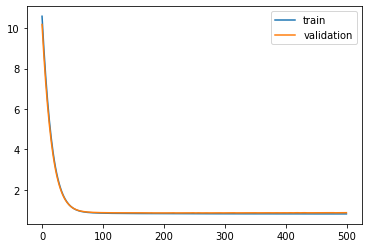

Time to train LSTM:  335.5690667629242
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 6s - loss: 10.7865 - pdc_loss: 0.7607 - event_loss: 0.8129 - val_loss: 10.3690 - val_pdc_loss: 0.7537 - val_event_loss: 0.7811

Epoch 00001: val_loss improved from inf to 10.36897, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 10.2238 - pdc_loss: 0.7516 - event_loss: 0.7690 - val_loss: 9.8245 - val_pdc_loss: 0.7449 - val_event_loss: 0.7402

Epoch 00002: val_loss improved from 10.36897 to 9.82450, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 9.6866 - pdc_loss: 0.7429 - event_loss: 0.7300 - val_loss: 9.3056 - val_pdc_loss: 0.7366 - val_event_loss: 0.7041

Epoch 00003: val_loss improved from 9.82450 to 9.30556, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 9.1747 - pdc_loss: 0.7347 - event_loss: 0.6955 - val_loss: 8.8117 - val_pdc_loss: 0.7286 - val_event_loss: 0.6723

Epoch 00004: val_loss improved from 9.30556 to 8.81167, sav


Epoch 00035: val_loss improved from 1.84882 to 1.77601, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 1.7544 - pdc_loss: 0.5850 - event_loss: 0.3077 - val_loss: 1.7082 - val_pdc_loss: 0.5859 - val_event_loss: 0.3078

Epoch 00036: val_loss improved from 1.77601 to 1.70818, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 1.6877 - pdc_loss: 0.5824 - event_loss: 0.3068 - val_loss: 1.6450 - val_pdc_loss: 0.5833 - val_event_loss: 0.3071

Epoch 00037: val_loss improved from 1.70818 to 1.64501, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 1.6256 - pdc_loss: 0.5800 - event_loss: 0.3059 - val_loss: 1.5862 - val_pdc_loss: 0.5809 - val_event_loss: 0.3064

Epoch 00038: val_loss improved from 1.64501 to 1.58618, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 1.5678 - pdc_loss: 0.5777 - event_loss: 0.3052 - val_loss: 1.5314 - val_pdc_loss: 0.5787 - val_event_loss: 0.3059

Epoch 00039: val_loss improved from 1.58618 to 

 - 1s - loss: 0.9038 - pdc_loss: 0.5504 - event_loss: 0.2967 - val_loss: 0.9050 - val_pdc_loss: 0.5519 - val_event_loss: 0.2993

Epoch 00070: val_loss improved from 0.90960 to 0.90495, saving model to Event_val_weights5.hdf5
Epoch 71/500
 - 1s - loss: 0.8993 - pdc_loss: 0.5499 - event_loss: 0.2966 - val_loss: 0.9007 - val_pdc_loss: 0.5514 - val_event_loss: 0.2993

Epoch 00071: val_loss improved from 0.90495 to 0.90068, saving model to Event_val_weights5.hdf5
Epoch 72/500
 - 1s - loss: 0.8951 - pdc_loss: 0.5495 - event_loss: 0.2966 - val_loss: 0.8968 - val_pdc_loss: 0.5510 - val_event_loss: 0.2993

Epoch 00072: val_loss improved from 0.90068 to 0.89676, saving model to Event_val_weights5.hdf5
Epoch 73/500
 - 1s - loss: 0.8912 - pdc_loss: 0.5491 - event_loss: 0.2965 - val_loss: 0.8932 - val_pdc_loss: 0.5506 - val_event_loss: 0.2992

Epoch 00073: val_loss improved from 0.89676 to 0.89316, saving model to Event_val_weights5.hdf5
Epoch 74/500
 - 1s - loss: 0.8876 - pdc_loss: 0.5486 - event_


Epoch 00104: val_loss improved from 0.85113 to 0.85056, saving model to Event_val_weights5.hdf5
Epoch 105/500
 - 1s - loss: 0.8442 - pdc_loss: 0.5346 - event_loss: 0.2953 - val_loss: 0.8500 - val_pdc_loss: 0.5366 - val_event_loss: 0.2992

Epoch 00105: val_loss improved from 0.85056 to 0.85000, saving model to Event_val_weights5.hdf5
Epoch 106/500
 - 1s - loss: 0.8436 - pdc_loss: 0.5341 - event_loss: 0.2953 - val_loss: 0.8495 - val_pdc_loss: 0.5362 - val_event_loss: 0.2992

Epoch 00106: val_loss improved from 0.85000 to 0.84946, saving model to Event_val_weights5.hdf5
Epoch 107/500
 - 1s - loss: 0.8430 - pdc_loss: 0.5336 - event_loss: 0.2953 - val_loss: 0.8489 - val_pdc_loss: 0.5357 - val_event_loss: 0.2992

Epoch 00107: val_loss improved from 0.84946 to 0.84893, saving model to Event_val_weights5.hdf5
Epoch 108/500
 - 1s - loss: 0.8424 - pdc_loss: 0.5331 - event_loss: 0.2953 - val_loss: 0.8484 - val_pdc_loss: 0.5353 - val_event_loss: 0.2992

Epoch 00108: val_loss improved from 0.84893

 - 1s - loss: 0.8289 - pdc_loss: 0.5232 - event_loss: 0.2945 - val_loss: 0.8381 - val_pdc_loss: 0.5280 - val_event_loss: 0.2990

Epoch 00139: val_loss improved from 0.83822 to 0.83812, saving model to Event_val_weights5.hdf5
Epoch 140/500
 - 1s - loss: 0.8286 - pdc_loss: 0.5230 - event_loss: 0.2945 - val_loss: 0.8379 - val_pdc_loss: 0.5279 - val_event_loss: 0.2989

Epoch 00140: val_loss improved from 0.83812 to 0.83787, saving model to Event_val_weights5.hdf5
Epoch 141/500
 - 1s - loss: 0.8283 - pdc_loss: 0.5229 - event_loss: 0.2944 - val_loss: 0.8377 - val_pdc_loss: 0.5277 - val_event_loss: 0.2990

Epoch 00141: val_loss improved from 0.83787 to 0.83766, saving model to Event_val_weights5.hdf5
Epoch 142/500
 - 1s - loss: 0.8280 - pdc_loss: 0.5227 - event_loss: 0.2944 - val_loss: 0.8376 - val_pdc_loss: 0.5277 - val_event_loss: 0.2990

Epoch 00142: val_loss improved from 0.83766 to 0.83762, saving model to Event_val_weights5.hdf5
Epoch 143/500
 - 1s - loss: 0.8278 - pdc_loss: 0.5225 - ev


Epoch 00175: val_loss did not improve from 0.83316
Epoch 176/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5180 - event_loss: 0.2933 - val_loss: 0.8331 - val_pdc_loss: 0.5244 - val_event_loss: 0.2988

Epoch 00176: val_loss improved from 0.83316 to 0.83309, saving model to Event_val_weights5.hdf5
Epoch 177/500
 - 1s - loss: 0.8211 - pdc_loss: 0.5179 - event_loss: 0.2933 - val_loss: 0.8329 - val_pdc_loss: 0.5241 - val_event_loss: 0.2990

Epoch 00177: val_loss improved from 0.83309 to 0.83292, saving model to Event_val_weights5.hdf5
Epoch 178/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5178 - event_loss: 0.2933 - val_loss: 0.8329 - val_pdc_loss: 0.5242 - val_event_loss: 0.2989

Epoch 00178: val_loss improved from 0.83292 to 0.83289, saving model to Event_val_weights5.hdf5
Epoch 179/500
 - 1s - loss: 0.8208 - pdc_loss: 0.5177 - event_loss: 0.2932 - val_loss: 0.8327 - val_pdc_loss: 0.5239 - val_event_loss: 0.2989

Epoch 00179: val_loss improved from 0.83289 to 0.83271, saving model to Event_val_weight

 - 1s - loss: 0.8167 - pdc_loss: 0.5145 - event_loss: 0.2925 - val_loss: 0.8305 - val_pdc_loss: 0.5216 - val_event_loss: 0.2993

Epoch 00214: val_loss did not improve from 0.82999
Epoch 215/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5144 - event_loss: 0.2925 - val_loss: 0.8312 - val_pdc_loss: 0.5219 - val_event_loss: 0.2996

Epoch 00215: val_loss did not improve from 0.82999
Epoch 216/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5143 - event_loss: 0.2925 - val_loss: 0.8312 - val_pdc_loss: 0.5219 - val_event_loss: 0.2997

Epoch 00216: val_loss did not improve from 0.82999
Epoch 217/500
 - 1s - loss: 0.8163 - pdc_loss: 0.5141 - event_loss: 0.2925 - val_loss: 0.8313 - val_pdc_loss: 0.5219 - val_event_loss: 0.2998

Epoch 00217: val_loss did not improve from 0.82999
Epoch 218/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5139 - event_loss: 0.2925 - val_loss: 0.8312 - val_pdc_loss: 0.5218 - val_event_loss: 0.2997

Epoch 00218: val_loss did not improve from 0.82999
Epoch 219/500
 - 1s - loss: 0.8158 - pdc_los


Epoch 00254: val_loss did not improve from 0.82869
Epoch 255/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5117 - event_loss: 0.2920 - val_loss: 0.8304 - val_pdc_loss: 0.5208 - val_event_loss: 0.3001

Epoch 00255: val_loss did not improve from 0.82869
Epoch 256/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5116 - event_loss: 0.2918 - val_loss: 0.8293 - val_pdc_loss: 0.5203 - val_event_loss: 0.2995

Epoch 00256: val_loss did not improve from 0.82869
Epoch 257/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5116 - event_loss: 0.2918 - val_loss: 0.8291 - val_pdc_loss: 0.5202 - val_event_loss: 0.2994

Epoch 00257: val_loss did not improve from 0.82869
Epoch 258/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5117 - event_loss: 0.2917 - val_loss: 0.8294 - val_pdc_loss: 0.5203 - val_event_loss: 0.2996

Epoch 00258: val_loss did not improve from 0.82869
Epoch 259/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5119 - event_loss: 0.2918 - val_loss: 0.8290 - val_pdc_loss: 0.5203 - val_event_loss: 0.2992

Epoch 00259: val_loss did not


Epoch 00296: val_loss did not improve from 0.82825
Epoch 297/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5104 - event_loss: 0.2913 - val_loss: 0.8310 - val_pdc_loss: 0.5208 - val_event_loss: 0.3008

Epoch 00297: val_loss did not improve from 0.82825
Epoch 298/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5102 - event_loss: 0.2914 - val_loss: 0.8317 - val_pdc_loss: 0.5212 - val_event_loss: 0.3011

Epoch 00298: val_loss did not improve from 0.82825
Epoch 299/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5100 - event_loss: 0.2914 - val_loss: 0.8313 - val_pdc_loss: 0.5210 - val_event_loss: 0.3008

Epoch 00299: val_loss did not improve from 0.82825
Epoch 300/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5097 - event_loss: 0.2912 - val_loss: 0.8299 - val_pdc_loss: 0.5203 - val_event_loss: 0.3001

Epoch 00300: val_loss did not improve from 0.82825
Epoch 301/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5097 - event_loss: 0.2911 - val_loss: 0.8291 - val_pdc_loss: 0.5199 - val_event_loss: 0.2998

Epoch 00301: val_loss did not

 - 1s - loss: 0.8091 - pdc_loss: 0.5090 - event_loss: 0.2907 - val_loss: 0.8303 - val_pdc_loss: 0.5201 - val_event_loss: 0.3008

Epoch 00339: val_loss did not improve from 0.82825
Epoch 340/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5089 - event_loss: 0.2907 - val_loss: 0.8315 - val_pdc_loss: 0.5206 - val_event_loss: 0.3014

Epoch 00340: val_loss did not improve from 0.82825
Epoch 341/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5087 - event_loss: 0.2908 - val_loss: 0.8329 - val_pdc_loss: 0.5216 - val_event_loss: 0.3018

Epoch 00341: val_loss did not improve from 0.82825
Epoch 342/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5087 - event_loss: 0.2908 - val_loss: 0.8326 - val_pdc_loss: 0.5215 - val_event_loss: 0.3016

Epoch 00342: val_loss did not improve from 0.82825
Epoch 343/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5084 - event_loss: 0.2908 - val_loss: 0.8318 - val_pdc_loss: 0.5213 - val_event_loss: 0.3010

Epoch 00343: val_loss did not improve from 0.82825
Epoch 344/500
 - 1s - loss: 0.8084 - pdc_los


Epoch 00381: val_loss did not improve from 0.82825
Epoch 382/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5076 - event_loss: 0.2902 - val_loss: 0.8310 - val_pdc_loss: 0.5202 - val_event_loss: 0.3014

Epoch 00382: val_loss did not improve from 0.82825
Epoch 383/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5077 - event_loss: 0.2902 - val_loss: 0.8327 - val_pdc_loss: 0.5212 - val_event_loss: 0.3021

Epoch 00383: val_loss did not improve from 0.82825
Epoch 384/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5076 - event_loss: 0.2903 - val_loss: 0.8338 - val_pdc_loss: 0.5215 - val_event_loss: 0.3029

Epoch 00384: val_loss did not improve from 0.82825
Epoch 385/500
 - 1s - loss: 0.8070 - pdc_loss: 0.5074 - event_loss: 0.2903 - val_loss: 0.8332 - val_pdc_loss: 0.5218 - val_event_loss: 0.3021

Epoch 00385: val_loss did not improve from 0.82825
Epoch 386/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5072 - event_loss: 0.2902 - val_loss: 0.8328 - val_pdc_loss: 0.5211 - val_event_loss: 0.3023

Epoch 00386: val_loss did not

 - 1s - loss: 0.8059 - pdc_loss: 0.5068 - event_loss: 0.2899 - val_loss: 0.8315 - val_pdc_loss: 0.5205 - val_event_loss: 0.3018

Epoch 00424: val_loss did not improve from 0.82825
Epoch 425/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5068 - event_loss: 0.2898 - val_loss: 0.8314 - val_pdc_loss: 0.5203 - val_event_loss: 0.3018

Epoch 00425: val_loss did not improve from 0.82825
Epoch 426/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5068 - event_loss: 0.2898 - val_loss: 0.8328 - val_pdc_loss: 0.5213 - val_event_loss: 0.3022

Epoch 00426: val_loss did not improve from 0.82825
Epoch 427/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5068 - event_loss: 0.2899 - val_loss: 0.8339 - val_pdc_loss: 0.5218 - val_event_loss: 0.3028

Epoch 00427: val_loss did not improve from 0.82825
Epoch 428/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5067 - event_loss: 0.2899 - val_loss: 0.8349 - val_pdc_loss: 0.5225 - val_event_loss: 0.3032

Epoch 00428: val_loss did not improve from 0.82825
Epoch 429/500
 - 1s - loss: 0.8056 - pdc_los


Epoch 00466: val_loss did not improve from 0.82825
Epoch 467/500
 - 1s - loss: 0.8045 - pdc_loss: 0.5059 - event_loss: 0.2894 - val_loss: 0.8338 - val_pdc_loss: 0.5218 - val_event_loss: 0.3029

Epoch 00467: val_loss did not improve from 0.82825
Epoch 468/500
 - 1s - loss: 0.8045 - pdc_loss: 0.5059 - event_loss: 0.2894 - val_loss: 0.8342 - val_pdc_loss: 0.5221 - val_event_loss: 0.3029

Epoch 00468: val_loss did not improve from 0.82825
Epoch 469/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5060 - event_loss: 0.2895 - val_loss: 0.8365 - val_pdc_loss: 0.5235 - val_event_loss: 0.3038

Epoch 00469: val_loss did not improve from 0.82825
Epoch 470/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5057 - event_loss: 0.2895 - val_loss: 0.8353 - val_pdc_loss: 0.5228 - val_event_loss: 0.3034

Epoch 00470: val_loss did not improve from 0.82825
Epoch 471/500
 - 1s - loss: 0.8040 - pdc_loss: 0.5054 - event_loss: 0.2894 - val_loss: 0.8345 - val_pdc_loss: 0.5223 - val_event_loss: 0.3031

Epoch 00471: val_loss did not

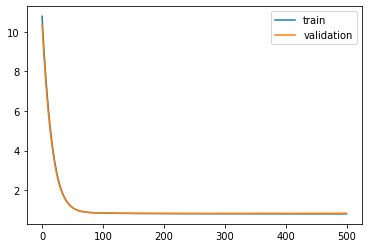

Time to train LSTM:  336.74699902534485
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 6s - loss: 11.2566 - pdc_loss: 0.6646 - event_loss: 0.5835 - val_loss: 6.8764 - val_pdc_loss: 0.6156 - val_event_loss: 0.4265

Epoch 00001: val_loss improved from inf to 6.87642, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 4.6113 - pdc_loss: 0.5901 - event_loss: 0.3522 - val_loss: 2.8611 - val_pdc_loss: 0.5754 - val_event_loss: 0.3037

Epoch 00002: val_loss improved from 6.87642 to 2.86112, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 2.0671 - pdc_loss: 0.5652 - event_loss: 0.3065 - val_loss: 1.4637 - val_pdc_loss: 0.5603 - val_event_loss: 0.2966

Epoch 00003: val_loss improved from 2.86112 to 1.46366, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 1.2123 - pdc_loss: 0.5553 - event_loss: 0.3029 - val_loss: 1.0225 - val_pdc_loss: 0.5536 - val_event_loss: 0.2969

Epoch 00004: val_loss improved from 1.46366 to 1.02247, saving


Epoch 00036: val_loss improved from 0.82891 to 0.82852, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 0.8331 - pdc_loss: 0.5210 - event_loss: 0.2981 - val_loss: 0.8284 - val_pdc_loss: 0.5223 - val_event_loss: 0.2922

Epoch 00037: val_loss improved from 0.82852 to 0.82840, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 0.8330 - pdc_loss: 0.5210 - event_loss: 0.2980 - val_loss: 0.8283 - val_pdc_loss: 0.5223 - val_event_loss: 0.2923

Epoch 00038: val_loss improved from 0.82840 to 0.82832, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 0.8327 - pdc_loss: 0.5208 - event_loss: 0.2980 - val_loss: 0.8280 - val_pdc_loss: 0.5218 - val_event_loss: 0.2924

Epoch 00039: val_loss improved from 0.82832 to 0.82802, saving model to Event_val_weights1.hdf5
Epoch 40/500
 - 1s - loss: 0.8326 - pdc_loss: 0.5206 - event_loss: 0.2980 - val_loss: 0.8279 - val_pdc_loss: 0.5221 - val_event_loss: 0.2919

Epoch 00040: val_loss improved from 0.82802 to 


Epoch 00075: val_loss did not improve from 0.82547
Epoch 76/500
 - 1s - loss: 0.8286 - pdc_loss: 0.5176 - event_loss: 0.2969 - val_loss: 0.8262 - val_pdc_loss: 0.5202 - val_event_loss: 0.2920

Epoch 00076: val_loss did not improve from 0.82547
Epoch 77/500
 - 1s - loss: 0.8286 - pdc_loss: 0.5176 - event_loss: 0.2969 - val_loss: 0.8258 - val_pdc_loss: 0.5200 - val_event_loss: 0.2919

Epoch 00077: val_loss did not improve from 0.82547
Epoch 78/500
 - 1s - loss: 0.8284 - pdc_loss: 0.5174 - event_loss: 0.2969 - val_loss: 0.8262 - val_pdc_loss: 0.5202 - val_event_loss: 0.2921

Epoch 00078: val_loss did not improve from 0.82547
Epoch 79/500
 - 1s - loss: 0.8283 - pdc_loss: 0.5174 - event_loss: 0.2969 - val_loss: 0.8255 - val_pdc_loss: 0.5198 - val_event_loss: 0.2917

Epoch 00079: val_loss did not improve from 0.82547
Epoch 80/500
 - 1s - loss: 0.8282 - pdc_loss: 0.5174 - event_loss: 0.2968 - val_loss: 0.8260 - val_pdc_loss: 0.5200 - val_event_loss: 0.2920

Epoch 00080: val_loss did not impr


Epoch 00118: val_loss did not improve from 0.82547
Epoch 119/500
 - 1s - loss: 0.8264 - pdc_loss: 0.5150 - event_loss: 0.2961 - val_loss: 0.8279 - val_pdc_loss: 0.5200 - val_event_loss: 0.2927

Epoch 00119: val_loss did not improve from 0.82547
Epoch 120/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5150 - event_loss: 0.2960 - val_loss: 0.8278 - val_pdc_loss: 0.5199 - val_event_loss: 0.2928

Epoch 00120: val_loss did not improve from 0.82547
Epoch 121/500
 - 1s - loss: 0.8260 - pdc_loss: 0.5148 - event_loss: 0.2960 - val_loss: 0.8276 - val_pdc_loss: 0.5200 - val_event_loss: 0.2926

Epoch 00121: val_loss did not improve from 0.82547
Epoch 122/500
 - 1s - loss: 0.8259 - pdc_loss: 0.5148 - event_loss: 0.2959 - val_loss: 0.8275 - val_pdc_loss: 0.5200 - val_event_loss: 0.2925

Epoch 00122: val_loss did not improve from 0.82547
Epoch 123/500
 - 1s - loss: 0.8258 - pdc_loss: 0.5148 - event_loss: 0.2958 - val_loss: 0.8278 - val_pdc_loss: 0.5205 - val_event_loss: 0.2922

Epoch 00123: val_loss did not

 - 1s - loss: 0.8244 - pdc_loss: 0.5131 - event_loss: 0.2951 - val_loss: 0.8297 - val_pdc_loss: 0.5210 - val_event_loss: 0.2927

Epoch 00161: val_loss did not improve from 0.82547
Epoch 162/500
 - 1s - loss: 0.8248 - pdc_loss: 0.5134 - event_loss: 0.2951 - val_loss: 0.8301 - val_pdc_loss: 0.5208 - val_event_loss: 0.2932

Epoch 00162: val_loss did not improve from 0.82547
Epoch 163/500
 - 1s - loss: 0.8244 - pdc_loss: 0.5132 - event_loss: 0.2950 - val_loss: 0.8295 - val_pdc_loss: 0.5199 - val_event_loss: 0.2933

Epoch 00163: val_loss did not improve from 0.82547
Epoch 164/500
 - 1s - loss: 0.8245 - pdc_loss: 0.5131 - event_loss: 0.2950 - val_loss: 0.8302 - val_pdc_loss: 0.5210 - val_event_loss: 0.2931

Epoch 00164: val_loss did not improve from 0.82547
Epoch 165/500
 - 1s - loss: 0.8245 - pdc_loss: 0.5131 - event_loss: 0.2949 - val_loss: 0.8300 - val_pdc_loss: 0.5209 - val_event_loss: 0.2928

Epoch 00165: val_loss did not improve from 0.82547
Epoch 166/500
 - 1s - loss: 0.8247 - pdc_los


Epoch 00203: val_loss did not improve from 0.82547
Epoch 204/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5117 - event_loss: 0.2948 - val_loss: 0.8308 - val_pdc_loss: 0.5202 - val_event_loss: 0.2935

Epoch 00204: val_loss did not improve from 0.82547
Epoch 205/500
 - 1s - loss: 0.8233 - pdc_loss: 0.5116 - event_loss: 0.2946 - val_loss: 0.8307 - val_pdc_loss: 0.5197 - val_event_loss: 0.2940

Epoch 00205: val_loss did not improve from 0.82547
Epoch 206/500
 - 1s - loss: 0.8231 - pdc_loss: 0.5115 - event_loss: 0.2945 - val_loss: 0.8308 - val_pdc_loss: 0.5205 - val_event_loss: 0.2932

Epoch 00206: val_loss did not improve from 0.82547
Epoch 207/500
 - 1s - loss: 0.8232 - pdc_loss: 0.5114 - event_loss: 0.2945 - val_loss: 0.8306 - val_pdc_loss: 0.5200 - val_event_loss: 0.2933

Epoch 00207: val_loss did not improve from 0.82547
Epoch 208/500
 - 1s - loss: 0.8231 - pdc_loss: 0.5114 - event_loss: 0.2945 - val_loss: 0.8309 - val_pdc_loss: 0.5204 - val_event_loss: 0.2933

Epoch 00208: val_loss did not

 - 1s - loss: 0.8224 - pdc_loss: 0.5108 - event_loss: 0.2939 - val_loss: 0.8327 - val_pdc_loss: 0.5217 - val_event_loss: 0.2932

Epoch 00246: val_loss did not improve from 0.82547
Epoch 247/500
 - 1s - loss: 0.8225 - pdc_loss: 0.5110 - event_loss: 0.2938 - val_loss: 0.8313 - val_pdc_loss: 0.5196 - val_event_loss: 0.2941

Epoch 00247: val_loss did not improve from 0.82547
Epoch 248/500
 - 1s - loss: 0.8223 - pdc_loss: 0.5107 - event_loss: 0.2938 - val_loss: 0.8316 - val_pdc_loss: 0.5201 - val_event_loss: 0.2939

Epoch 00248: val_loss did not improve from 0.82547
Epoch 249/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5109 - event_loss: 0.2938 - val_loss: 0.8320 - val_pdc_loss: 0.5207 - val_event_loss: 0.2934

Epoch 00249: val_loss did not improve from 0.82547
Epoch 250/500
 - 1s - loss: 0.8228 - pdc_loss: 0.5106 - event_loss: 0.2941 - val_loss: 0.8328 - val_pdc_loss: 0.5210 - val_event_loss: 0.2938

Epoch 00250: val_loss did not improve from 0.82547
Epoch 251/500
 - 1s - loss: 0.8224 - pdc_los


Epoch 00288: val_loss did not improve from 0.82547
Epoch 289/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5096 - event_loss: 0.2933 - val_loss: 0.8324 - val_pdc_loss: 0.5203 - val_event_loss: 0.2937

Epoch 00289: val_loss did not improve from 0.82547
Epoch 290/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5098 - event_loss: 0.2933 - val_loss: 0.8325 - val_pdc_loss: 0.5207 - val_event_loss: 0.2936

Epoch 00290: val_loss did not improve from 0.82547
Epoch 291/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5097 - event_loss: 0.2933 - val_loss: 0.8324 - val_pdc_loss: 0.5205 - val_event_loss: 0.2938

Epoch 00291: val_loss did not improve from 0.82547
Epoch 292/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5095 - event_loss: 0.2931 - val_loss: 0.8320 - val_pdc_loss: 0.5203 - val_event_loss: 0.2935

Epoch 00292: val_loss did not improve from 0.82547
Epoch 293/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5102 - event_loss: 0.2932 - val_loss: 0.8331 - val_pdc_loss: 0.5211 - val_event_loss: 0.2935

Epoch 00293: val_loss did not

 - 1s - loss: 0.8197 - pdc_loss: 0.5083 - event_loss: 0.2923 - val_loss: 0.8348 - val_pdc_loss: 0.5209 - val_event_loss: 0.2948

Epoch 00331: val_loss did not improve from 0.82547
Epoch 332/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5086 - event_loss: 0.2926 - val_loss: 0.8362 - val_pdc_loss: 0.5225 - val_event_loss: 0.2946

Epoch 00332: val_loss did not improve from 0.82547
Epoch 333/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5084 - event_loss: 0.2926 - val_loss: 0.8356 - val_pdc_loss: 0.5219 - val_event_loss: 0.2945

Epoch 00333: val_loss did not improve from 0.82547
Epoch 334/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5079 - event_loss: 0.2924 - val_loss: 0.8360 - val_pdc_loss: 0.5216 - val_event_loss: 0.2953

Epoch 00334: val_loss did not improve from 0.82547
Epoch 335/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5084 - event_loss: 0.2925 - val_loss: 0.8336 - val_pdc_loss: 0.5208 - val_event_loss: 0.2936

Epoch 00335: val_loss did not improve from 0.82547
Epoch 336/500
 - 1s - loss: 0.8199 - pdc_los


Epoch 00373: val_loss did not improve from 0.82547
Epoch 374/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5068 - event_loss: 0.2921 - val_loss: 0.8379 - val_pdc_loss: 0.5222 - val_event_loss: 0.2958

Epoch 00374: val_loss did not improve from 0.82547
Epoch 375/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5072 - event_loss: 0.2921 - val_loss: 0.8368 - val_pdc_loss: 0.5214 - val_event_loss: 0.2953

Epoch 00375: val_loss did not improve from 0.82547
Epoch 376/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5072 - event_loss: 0.2923 - val_loss: 0.8390 - val_pdc_loss: 0.5228 - val_event_loss: 0.2962

Epoch 00376: val_loss did not improve from 0.82547
Epoch 377/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5071 - event_loss: 0.2917 - val_loss: 0.8363 - val_pdc_loss: 0.5217 - val_event_loss: 0.2948

Epoch 00377: val_loss did not improve from 0.82547
Epoch 378/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5070 - event_loss: 0.2918 - val_loss: 0.8368 - val_pdc_loss: 0.5213 - val_event_loss: 0.2951

Epoch 00378: val_loss did not

 - 1s - loss: 0.8182 - pdc_loss: 0.5062 - event_loss: 0.2911 - val_loss: 0.8409 - val_pdc_loss: 0.5232 - val_event_loss: 0.2968

Epoch 00416: val_loss did not improve from 0.82547
Epoch 417/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5060 - event_loss: 0.2912 - val_loss: 0.8412 - val_pdc_loss: 0.5238 - val_event_loss: 0.2967

Epoch 00417: val_loss did not improve from 0.82547
Epoch 418/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5059 - event_loss: 0.2911 - val_loss: 0.8420 - val_pdc_loss: 0.5243 - val_event_loss: 0.2969

Epoch 00418: val_loss did not improve from 0.82547
Epoch 419/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5057 - event_loss: 0.2908 - val_loss: 0.8383 - val_pdc_loss: 0.5226 - val_event_loss: 0.2948

Epoch 00419: val_loss did not improve from 0.82547
Epoch 420/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5059 - event_loss: 0.2909 - val_loss: 0.8405 - val_pdc_loss: 0.5240 - val_event_loss: 0.2955

Epoch 00420: val_loss did not improve from 0.82547
Epoch 421/500
 - 1s - loss: 0.8174 - pdc_los


Epoch 00458: val_loss did not improve from 0.82547
Epoch 459/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5058 - event_loss: 0.2904 - val_loss: 0.8414 - val_pdc_loss: 0.5232 - val_event_loss: 0.2962

Epoch 00459: val_loss did not improve from 0.82547
Epoch 460/500
 - 1s - loss: 0.8176 - pdc_loss: 0.5055 - event_loss: 0.2904 - val_loss: 0.8434 - val_pdc_loss: 0.5248 - val_event_loss: 0.2970

Epoch 00460: val_loss did not improve from 0.82547
Epoch 461/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5057 - event_loss: 0.2903 - val_loss: 0.8443 - val_pdc_loss: 0.5261 - val_event_loss: 0.2962

Epoch 00461: val_loss did not improve from 0.82547
Epoch 462/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5056 - event_loss: 0.2905 - val_loss: 0.8435 - val_pdc_loss: 0.5250 - val_event_loss: 0.2967

Epoch 00462: val_loss did not improve from 0.82547
Epoch 463/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5053 - event_loss: 0.2906 - val_loss: 0.8427 - val_pdc_loss: 0.5248 - val_event_loss: 0.2964

Epoch 00463: val_loss did not

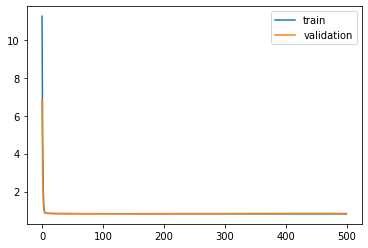

Time to train LSTM:  303.88265085220337


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f073de8da58>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 7s - loss: 11.2324 - pdc_loss: 0.6695 - event_loss: 0.5529 - val_loss: 6.8841 - val_pdc_loss: 0.6291 - val_event_loss: 0.4199

Epoch 00001: val_loss improved from inf to 6.88408, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 4.6116 - pdc_loss: 0.5963 - event_loss: 0.3424 - val_loss: 2.8882 - val_pdc_loss: 0.5809 - val_event_loss: 0.3176

Epoch 00002: val_loss improved from 6.88408 to 2.88820, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 2.0695 - pdc_loss: 0.5639 - event_loss: 0.3054 - val_loss: 1.4798 - val_pdc_loss: 0.5614 - val_event_loss: 0.3102

Epoch 00003: val_loss improved from 2.88820 to 1.47984, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 1.2092 - pdc_loss: 0.5519 - event_loss: 0.3025 - val_loss: 1.0321 - val_pdc_loss: 0.5499 - val_event_loss: 0.3094

Epoch 00004: val_loss improved from 1.47984 to 1.03209, saving model to Event_val_weights2.hdf5
Epoch 


Epoch 00036: val_loss did not improve from 0.84596
Epoch 37/500
 - 1s - loss: 0.8306 - pdc_loss: 0.5190 - event_loss: 0.2974 - val_loss: 0.8456 - val_pdc_loss: 0.5274 - val_event_loss: 0.3038

Epoch 00037: val_loss improved from 0.84596 to 0.84558, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 0.8307 - pdc_loss: 0.5189 - event_loss: 0.2975 - val_loss: 0.8460 - val_pdc_loss: 0.5277 - val_event_loss: 0.3039

Epoch 00038: val_loss did not improve from 0.84558
Epoch 39/500
 - 1s - loss: 0.8303 - pdc_loss: 0.5187 - event_loss: 0.2974 - val_loss: 0.8455 - val_pdc_loss: 0.5275 - val_event_loss: 0.3037

Epoch 00039: val_loss improved from 0.84558 to 0.84545, saving model to Event_val_weights2.hdf5
Epoch 40/500
 - 1s - loss: 0.8303 - pdc_loss: 0.5187 - event_loss: 0.2974 - val_loss: 0.8452 - val_pdc_loss: 0.5272 - val_event_loss: 0.3037

Epoch 00040: val_loss improved from 0.84545 to 0.84522, saving model to Event_val_weights2.hdf5
Epoch 41/500
 - 1s - loss: 0.8301 - pdc_l


Epoch 00074: val_loss improved from 0.84286 to 0.84268, saving model to Event_val_weights2.hdf5
Epoch 75/500
 - 1s - loss: 0.8266 - pdc_loss: 0.5160 - event_loss: 0.2967 - val_loss: 0.8432 - val_pdc_loss: 0.5256 - val_event_loss: 0.3036

Epoch 00075: val_loss did not improve from 0.84268
Epoch 76/500
 - 1s - loss: 0.8266 - pdc_loss: 0.5160 - event_loss: 0.2967 - val_loss: 0.8430 - val_pdc_loss: 0.5255 - val_event_loss: 0.3035

Epoch 00076: val_loss did not improve from 0.84268
Epoch 77/500
 - 1s - loss: 0.8267 - pdc_loss: 0.5160 - event_loss: 0.2967 - val_loss: 0.8424 - val_pdc_loss: 0.5248 - val_event_loss: 0.3036

Epoch 00077: val_loss improved from 0.84268 to 0.84242, saving model to Event_val_weights2.hdf5
Epoch 78/500
 - 1s - loss: 0.8265 - pdc_loss: 0.5159 - event_loss: 0.2967 - val_loss: 0.8432 - val_pdc_loss: 0.5256 - val_event_loss: 0.3036

Epoch 00078: val_loss did not improve from 0.84242
Epoch 79/500
 - 1s - loss: 0.8263 - pdc_loss: 0.5159 - event_loss: 0.2966 - val_loss: 


Epoch 00116: val_loss did not improve from 0.84224
Epoch 117/500
 - 1s - loss: 0.8245 - pdc_loss: 0.5140 - event_loss: 0.2957 - val_loss: 0.8444 - val_pdc_loss: 0.5258 - val_event_loss: 0.3037

Epoch 00117: val_loss did not improve from 0.84224
Epoch 118/500
 - 1s - loss: 0.8248 - pdc_loss: 0.5142 - event_loss: 0.2958 - val_loss: 0.8457 - val_pdc_loss: 0.5264 - val_event_loss: 0.3043

Epoch 00118: val_loss did not improve from 0.84224
Epoch 119/500
 - 1s - loss: 0.8245 - pdc_loss: 0.5140 - event_loss: 0.2957 - val_loss: 0.8441 - val_pdc_loss: 0.5258 - val_event_loss: 0.3036

Epoch 00119: val_loss did not improve from 0.84224
Epoch 120/500
 - 1s - loss: 0.8247 - pdc_loss: 0.5140 - event_loss: 0.2957 - val_loss: 0.8455 - val_pdc_loss: 0.5266 - val_event_loss: 0.3038

Epoch 00120: val_loss did not improve from 0.84224
Epoch 121/500
 - 1s - loss: 0.8247 - pdc_loss: 0.5141 - event_loss: 0.2956 - val_loss: 0.8452 - val_pdc_loss: 0.5265 - val_event_loss: 0.3039

Epoch 00121: val_loss did not

 - 1s - loss: 0.8232 - pdc_loss: 0.5126 - event_loss: 0.2948 - val_loss: 0.8464 - val_pdc_loss: 0.5267 - val_event_loss: 0.3038

Epoch 00159: val_loss did not improve from 0.84224
Epoch 160/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5130 - event_loss: 0.2949 - val_loss: 0.8450 - val_pdc_loss: 0.5260 - val_event_loss: 0.3032

Epoch 00160: val_loss did not improve from 0.84224
Epoch 161/500
 - 1s - loss: 0.8233 - pdc_loss: 0.5126 - event_loss: 0.2949 - val_loss: 0.8451 - val_pdc_loss: 0.5259 - val_event_loss: 0.3035

Epoch 00161: val_loss did not improve from 0.84224
Epoch 162/500
 - 1s - loss: 0.8232 - pdc_loss: 0.5125 - event_loss: 0.2949 - val_loss: 0.8452 - val_pdc_loss: 0.5259 - val_event_loss: 0.3036

Epoch 00162: val_loss did not improve from 0.84224
Epoch 163/500
 - 1s - loss: 0.8231 - pdc_loss: 0.5125 - event_loss: 0.2948 - val_loss: 0.8443 - val_pdc_loss: 0.5251 - val_event_loss: 0.3034

Epoch 00163: val_loss did not improve from 0.84224
Epoch 164/500
 - 1s - loss: 0.8229 - pdc_los


Epoch 00201: val_loss did not improve from 0.84224
Epoch 202/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5111 - event_loss: 0.2943 - val_loss: 0.8450 - val_pdc_loss: 0.5249 - val_event_loss: 0.3036

Epoch 00202: val_loss did not improve from 0.84224
Epoch 203/500
 - 1s - loss: 0.8222 - pdc_loss: 0.5115 - event_loss: 0.2941 - val_loss: 0.8463 - val_pdc_loss: 0.5259 - val_event_loss: 0.3039

Epoch 00203: val_loss did not improve from 0.84224
Epoch 204/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5115 - event_loss: 0.2944 - val_loss: 0.8446 - val_pdc_loss: 0.5251 - val_event_loss: 0.3031

Epoch 00204: val_loss did not improve from 0.84224
Epoch 205/500
 - 1s - loss: 0.8222 - pdc_loss: 0.5112 - event_loss: 0.2943 - val_loss: 0.8461 - val_pdc_loss: 0.5256 - val_event_loss: 0.3039

Epoch 00205: val_loss did not improve from 0.84224
Epoch 206/500
 - 1s - loss: 0.8223 - pdc_loss: 0.5111 - event_loss: 0.2944 - val_loss: 0.8465 - val_pdc_loss: 0.5260 - val_event_loss: 0.3039

Epoch 00206: val_loss did not

 - 1s - loss: 0.8209 - pdc_loss: 0.5100 - event_loss: 0.2938 - val_loss: 0.8483 - val_pdc_loss: 0.5265 - val_event_loss: 0.3044

Epoch 00244: val_loss did not improve from 0.84224
Epoch 245/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5101 - event_loss: 0.2939 - val_loss: 0.8483 - val_pdc_loss: 0.5262 - val_event_loss: 0.3047

Epoch 00245: val_loss did not improve from 0.84224
Epoch 246/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5098 - event_loss: 0.2938 - val_loss: 0.8477 - val_pdc_loss: 0.5257 - val_event_loss: 0.3047

Epoch 00246: val_loss did not improve from 0.84224
Epoch 247/500
 - 1s - loss: 0.8208 - pdc_loss: 0.5097 - event_loss: 0.2939 - val_loss: 0.8484 - val_pdc_loss: 0.5262 - val_event_loss: 0.3050

Epoch 00247: val_loss did not improve from 0.84224
Epoch 248/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5099 - event_loss: 0.2939 - val_loss: 0.8478 - val_pdc_loss: 0.5263 - val_event_loss: 0.3045

Epoch 00248: val_loss did not improve from 0.84224
Epoch 249/500
 - 1s - loss: 0.8202 - pdc_los


Epoch 00286: val_loss did not improve from 0.84224
Epoch 287/500
 - 1s - loss: 0.8201 - pdc_loss: 0.5090 - event_loss: 0.2934 - val_loss: 0.8510 - val_pdc_loss: 0.5281 - val_event_loss: 0.3051

Epoch 00287: val_loss did not improve from 0.84224
Epoch 288/500
 - 1s - loss: 0.8201 - pdc_loss: 0.5092 - event_loss: 0.2931 - val_loss: 0.8488 - val_pdc_loss: 0.5264 - val_event_loss: 0.3046

Epoch 00288: val_loss did not improve from 0.84224
Epoch 289/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5090 - event_loss: 0.2932 - val_loss: 0.8500 - val_pdc_loss: 0.5271 - val_event_loss: 0.3050

Epoch 00289: val_loss did not improve from 0.84224
Epoch 290/500
 - 1s - loss: 0.8207 - pdc_loss: 0.5095 - event_loss: 0.2933 - val_loss: 0.8493 - val_pdc_loss: 0.5265 - val_event_loss: 0.3049

Epoch 00290: val_loss did not improve from 0.84224
Epoch 291/500
 - 1s - loss: 0.8196 - pdc_loss: 0.5086 - event_loss: 0.2931 - val_loss: 0.8485 - val_pdc_loss: 0.5262 - val_event_loss: 0.3045

Epoch 00291: val_loss did not

 - 1s - loss: 0.8191 - pdc_loss: 0.5078 - event_loss: 0.2926 - val_loss: 0.8516 - val_pdc_loss: 0.5281 - val_event_loss: 0.3049

Epoch 00329: val_loss did not improve from 0.84224
Epoch 330/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5080 - event_loss: 0.2928 - val_loss: 0.8532 - val_pdc_loss: 0.5294 - val_event_loss: 0.3056

Epoch 00330: val_loss did not improve from 0.84224
Epoch 331/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5077 - event_loss: 0.2926 - val_loss: 0.8517 - val_pdc_loss: 0.5279 - val_event_loss: 0.3056

Epoch 00331: val_loss did not improve from 0.84224
Epoch 332/500
 - 1s - loss: 0.8190 - pdc_loss: 0.5080 - event_loss: 0.2926 - val_loss: 0.8532 - val_pdc_loss: 0.5287 - val_event_loss: 0.3061

Epoch 00332: val_loss did not improve from 0.84224
Epoch 333/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5074 - event_loss: 0.2925 - val_loss: 0.8528 - val_pdc_loss: 0.5290 - val_event_loss: 0.3056

Epoch 00333: val_loss did not improve from 0.84224
Epoch 334/500
 - 1s - loss: 0.8189 - pdc_los


Epoch 00371: val_loss did not improve from 0.84224
Epoch 372/500
 - 1s - loss: 0.8190 - pdc_loss: 0.5077 - event_loss: 0.2927 - val_loss: 0.8512 - val_pdc_loss: 0.5278 - val_event_loss: 0.3050

Epoch 00372: val_loss did not improve from 0.84224
Epoch 373/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5071 - event_loss: 0.2926 - val_loss: 0.8524 - val_pdc_loss: 0.5285 - val_event_loss: 0.3056

Epoch 00373: val_loss did not improve from 0.84224
Epoch 374/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5071 - event_loss: 0.2925 - val_loss: 0.8509 - val_pdc_loss: 0.5278 - val_event_loss: 0.3047

Epoch 00374: val_loss did not improve from 0.84224
Epoch 375/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5069 - event_loss: 0.2924 - val_loss: 0.8534 - val_pdc_loss: 0.5293 - val_event_loss: 0.3057

Epoch 00375: val_loss did not improve from 0.84224
Epoch 376/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5068 - event_loss: 0.2925 - val_loss: 0.8528 - val_pdc_loss: 0.5291 - val_event_loss: 0.3053

Epoch 00376: val_loss did not

 - 1s - loss: 0.8175 - pdc_loss: 0.5063 - event_loss: 0.2917 - val_loss: 0.8556 - val_pdc_loss: 0.5302 - val_event_loss: 0.3062

Epoch 00414: val_loss did not improve from 0.84224
Epoch 415/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5064 - event_loss: 0.2915 - val_loss: 0.8546 - val_pdc_loss: 0.5296 - val_event_loss: 0.3052

Epoch 00415: val_loss did not improve from 0.84224
Epoch 416/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5064 - event_loss: 0.2918 - val_loss: 0.8536 - val_pdc_loss: 0.5278 - val_event_loss: 0.3062

Epoch 00416: val_loss did not improve from 0.84224
Epoch 417/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5058 - event_loss: 0.2917 - val_loss: 0.8564 - val_pdc_loss: 0.5301 - val_event_loss: 0.3069

Epoch 00417: val_loss did not improve from 0.84224
Epoch 418/500
 - 1s - loss: 0.8173 - pdc_loss: 0.5060 - event_loss: 0.2917 - val_loss: 0.8559 - val_pdc_loss: 0.5298 - val_event_loss: 0.3063

Epoch 00418: val_loss did not improve from 0.84224
Epoch 419/500
 - 1s - loss: 0.8171 - pdc_los


Epoch 00456: val_loss did not improve from 0.84224
Epoch 457/500
 - 1s - loss: 0.8158 - pdc_loss: 0.5047 - event_loss: 0.2908 - val_loss: 0.8568 - val_pdc_loss: 0.5293 - val_event_loss: 0.3073

Epoch 00457: val_loss did not improve from 0.84224
Epoch 458/500
 - 1s - loss: 0.8157 - pdc_loss: 0.5047 - event_loss: 0.2908 - val_loss: 0.8586 - val_pdc_loss: 0.5301 - val_event_loss: 0.3083

Epoch 00458: val_loss did not improve from 0.84224
Epoch 459/500
 - 1s - loss: 0.8159 - pdc_loss: 0.5050 - event_loss: 0.2908 - val_loss: 0.8571 - val_pdc_loss: 0.5295 - val_event_loss: 0.3078

Epoch 00459: val_loss did not improve from 0.84224
Epoch 460/500
 - 1s - loss: 0.8158 - pdc_loss: 0.5048 - event_loss: 0.2910 - val_loss: 0.8583 - val_pdc_loss: 0.5308 - val_event_loss: 0.3073

Epoch 00460: val_loss did not improve from 0.84224
Epoch 461/500
 - 1s - loss: 0.8156 - pdc_loss: 0.5048 - event_loss: 0.2908 - val_loss: 0.8577 - val_pdc_loss: 0.5307 - val_event_loss: 0.3071

Epoch 00461: val_loss did not

 - 1s - loss: 0.8148 - pdc_loss: 0.5037 - event_loss: 0.2905 - val_loss: 0.8592 - val_pdc_loss: 0.5302 - val_event_loss: 0.3085

Epoch 00499: val_loss did not improve from 0.84224
Epoch 500/500
 - 1s - loss: 0.8143 - pdc_loss: 0.5038 - event_loss: 0.2900 - val_loss: 0.8584 - val_pdc_loss: 0.5284 - val_event_loss: 0.3092

Epoch 00500: val_loss did not improve from 0.84224
#################################
Number of units: 32
Batch size: 2048
Fold: 1
best val loss: 0.8422392145262824
#################################


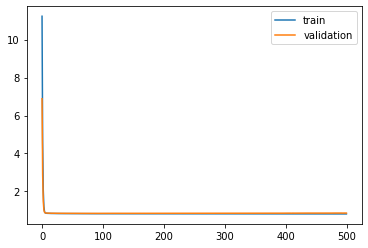

Time to train LSTM:  305.6290080547333
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 7s - loss: 11.1448 - pdc_loss: 0.6356 - event_loss: 0.5624 - val_loss: 6.8079 - val_pdc_loss: 0.6040 - val_event_loss: 0.4090

Epoch 00001: val_loss improved from inf to 6.80793, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 4.5553 - pdc_loss: 0.5802 - event_loss: 0.3350 - val_loss: 2.8536 - val_pdc_loss: 0.5776 - val_event_loss: 0.3103

Epoch 00002: val_loss improved from 6.80793 to 2.85363, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 2.0539 - pdc_loss: 0.5621 - event_loss: 0.3047 - val_loss: 1.4738 - val_pdc_loss: 0.5670 - val_event_loss: 0.3030

Epoch 00003: val_loss improved from 2.85363 to 1.47384, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 1.2094 - pdc_loss: 0.5540 - event_loss: 0.3020 - val_loss: 1.0364 - val_pdc_loss: 0.5608 - val_event_loss: 0.3027

Epoch 00004: val_loss improved from 1.47384 to 1.03639, saving 

 - 1s - loss: 0.8306 - pdc_loss: 0.5184 - event_loss: 0.2974 - val_loss: 0.8488 - val_pdc_loss: 0.5327 - val_event_loss: 0.3014

Epoch 00037: val_loss did not improve from 0.84813
Epoch 38/500
 - 1s - loss: 0.8304 - pdc_loss: 0.5181 - event_loss: 0.2975 - val_loss: 0.8481 - val_pdc_loss: 0.5323 - val_event_loss: 0.3011

Epoch 00038: val_loss improved from 0.84813 to 0.84806, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.8300 - pdc_loss: 0.5180 - event_loss: 0.2973 - val_loss: 0.8482 - val_pdc_loss: 0.5322 - val_event_loss: 0.3014

Epoch 00039: val_loss did not improve from 0.84806
Epoch 40/500
 - 1s - loss: 0.8299 - pdc_loss: 0.5179 - event_loss: 0.2973 - val_loss: 0.8482 - val_pdc_loss: 0.5323 - val_event_loss: 0.3011

Epoch 00040: val_loss did not improve from 0.84806
Epoch 41/500
 - 1s - loss: 0.8300 - pdc_loss: 0.5179 - event_loss: 0.2973 - val_loss: 0.8481 - val_pdc_loss: 0.5321 - val_event_loss: 0.3013

Epoch 00041: val_loss did not improve from 0.84806
Epo


Epoch 00077: val_loss did not improve from 0.84705
Epoch 78/500
 - 1s - loss: 0.8264 - pdc_loss: 0.5150 - event_loss: 0.2959 - val_loss: 0.8475 - val_pdc_loss: 0.5311 - val_event_loss: 0.3011

Epoch 00078: val_loss did not improve from 0.84705
Epoch 79/500
 - 1s - loss: 0.8263 - pdc_loss: 0.5149 - event_loss: 0.2960 - val_loss: 0.8472 - val_pdc_loss: 0.5312 - val_event_loss: 0.3008

Epoch 00079: val_loss did not improve from 0.84705
Epoch 80/500
 - 1s - loss: 0.8264 - pdc_loss: 0.5150 - event_loss: 0.2960 - val_loss: 0.8475 - val_pdc_loss: 0.5313 - val_event_loss: 0.3009

Epoch 00080: val_loss did not improve from 0.84705
Epoch 81/500
 - 1s - loss: 0.8262 - pdc_loss: 0.5149 - event_loss: 0.2958 - val_loss: 0.8471 - val_pdc_loss: 0.5312 - val_event_loss: 0.3005

Epoch 00081: val_loss did not improve from 0.84705
Epoch 82/500
 - 1s - loss: 0.8262 - pdc_loss: 0.5149 - event_loss: 0.2959 - val_loss: 0.8476 - val_pdc_loss: 0.5314 - val_event_loss: 0.3008

Epoch 00082: val_loss did not impr


Epoch 00120: val_loss did not improve from 0.84705
Epoch 121/500
 - 1s - loss: 0.8241 - pdc_loss: 0.5128 - event_loss: 0.2949 - val_loss: 0.8493 - val_pdc_loss: 0.5315 - val_event_loss: 0.3015

Epoch 00121: val_loss did not improve from 0.84705
Epoch 122/500
 - 1s - loss: 0.8241 - pdc_loss: 0.5127 - event_loss: 0.2948 - val_loss: 0.8497 - val_pdc_loss: 0.5317 - val_event_loss: 0.3014

Epoch 00122: val_loss did not improve from 0.84705
Epoch 123/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5125 - event_loss: 0.2947 - val_loss: 0.8492 - val_pdc_loss: 0.5314 - val_event_loss: 0.3013

Epoch 00123: val_loss did not improve from 0.84705
Epoch 124/500
 - 1s - loss: 0.8240 - pdc_loss: 0.5126 - event_loss: 0.2948 - val_loss: 0.8494 - val_pdc_loss: 0.5317 - val_event_loss: 0.3011

Epoch 00124: val_loss did not improve from 0.84705
Epoch 125/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5125 - event_loss: 0.2947 - val_loss: 0.8492 - val_pdc_loss: 0.5312 - val_event_loss: 0.3013

Epoch 00125: val_loss did not

 - 1s - loss: 0.8218 - pdc_loss: 0.5105 - event_loss: 0.2941 - val_loss: 0.8509 - val_pdc_loss: 0.5319 - val_event_loss: 0.3020

Epoch 00163: val_loss did not improve from 0.84705
Epoch 164/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5106 - event_loss: 0.2939 - val_loss: 0.8514 - val_pdc_loss: 0.5323 - val_event_loss: 0.3020

Epoch 00164: val_loss did not improve from 0.84705
Epoch 165/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5105 - event_loss: 0.2938 - val_loss: 0.8510 - val_pdc_loss: 0.5319 - val_event_loss: 0.3019

Epoch 00165: val_loss did not improve from 0.84705
Epoch 166/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5104 - event_loss: 0.2940 - val_loss: 0.8520 - val_pdc_loss: 0.5323 - val_event_loss: 0.3023

Epoch 00166: val_loss did not improve from 0.84705
Epoch 167/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5104 - event_loss: 0.2939 - val_loss: 0.8523 - val_pdc_loss: 0.5330 - val_event_loss: 0.3020

Epoch 00167: val_loss did not improve from 0.84705
Epoch 168/500
 - 1s - loss: 0.8220 - pdc_los


Epoch 00205: val_loss did not improve from 0.84705
Epoch 206/500
 - 1s - loss: 0.8205 - pdc_loss: 0.5089 - event_loss: 0.2932 - val_loss: 0.8538 - val_pdc_loss: 0.5335 - val_event_loss: 0.3019

Epoch 00206: val_loss did not improve from 0.84705
Epoch 207/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5087 - event_loss: 0.2931 - val_loss: 0.8546 - val_pdc_loss: 0.5334 - val_event_loss: 0.3026

Epoch 00207: val_loss did not improve from 0.84705
Epoch 208/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5085 - event_loss: 0.2932 - val_loss: 0.8544 - val_pdc_loss: 0.5338 - val_event_loss: 0.3025

Epoch 00208: val_loss did not improve from 0.84705
Epoch 209/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5084 - event_loss: 0.2929 - val_loss: 0.8543 - val_pdc_loss: 0.5336 - val_event_loss: 0.3024

Epoch 00209: val_loss did not improve from 0.84705
Epoch 210/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5086 - event_loss: 0.2930 - val_loss: 0.8531 - val_pdc_loss: 0.5329 - val_event_loss: 0.3021

Epoch 00210: val_loss did not

 - 1s - loss: 0.8186 - pdc_loss: 0.5070 - event_loss: 0.2917 - val_loss: 0.8559 - val_pdc_loss: 0.5335 - val_event_loss: 0.3026

Epoch 00248: val_loss did not improve from 0.84705
Epoch 249/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5071 - event_loss: 0.2917 - val_loss: 0.8563 - val_pdc_loss: 0.5337 - val_event_loss: 0.3025

Epoch 00249: val_loss did not improve from 0.84705
Epoch 250/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5073 - event_loss: 0.2917 - val_loss: 0.8567 - val_pdc_loss: 0.5335 - val_event_loss: 0.3031

Epoch 00250: val_loss did not improve from 0.84705
Epoch 251/500
 - 1s - loss: 0.8187 - pdc_loss: 0.5070 - event_loss: 0.2916 - val_loss: 0.8571 - val_pdc_loss: 0.5340 - val_event_loss: 0.3030

Epoch 00251: val_loss did not improve from 0.84705
Epoch 252/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5067 - event_loss: 0.2915 - val_loss: 0.8567 - val_pdc_loss: 0.5336 - val_event_loss: 0.3030

Epoch 00252: val_loss did not improve from 0.84705
Epoch 253/500
 - 1s - loss: 0.8180 - pdc_los


Epoch 00290: val_loss did not improve from 0.84705
Epoch 291/500
 - 1s - loss: 0.8165 - pdc_loss: 0.5052 - event_loss: 0.2902 - val_loss: 0.8590 - val_pdc_loss: 0.5340 - val_event_loss: 0.3035

Epoch 00291: val_loss did not improve from 0.84705
Epoch 292/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5051 - event_loss: 0.2906 - val_loss: 0.8572 - val_pdc_loss: 0.5326 - val_event_loss: 0.3034

Epoch 00292: val_loss did not improve from 0.84705
Epoch 293/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5057 - event_loss: 0.2902 - val_loss: 0.8593 - val_pdc_loss: 0.5344 - val_event_loss: 0.3035

Epoch 00293: val_loss did not improve from 0.84705
Epoch 294/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5052 - event_loss: 0.2903 - val_loss: 0.8584 - val_pdc_loss: 0.5339 - val_event_loss: 0.3035

Epoch 00294: val_loss did not improve from 0.84705
Epoch 295/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5051 - event_loss: 0.2903 - val_loss: 0.8582 - val_pdc_loss: 0.5340 - val_event_loss: 0.3032

Epoch 00295: val_loss did not

 - 1s - loss: 0.8157 - pdc_loss: 0.5040 - event_loss: 0.2895 - val_loss: 0.8583 - val_pdc_loss: 0.5325 - val_event_loss: 0.3035

Epoch 00333: val_loss did not improve from 0.84705
Epoch 334/500
 - 1s - loss: 0.8157 - pdc_loss: 0.5039 - event_loss: 0.2896 - val_loss: 0.8603 - val_pdc_loss: 0.5339 - val_event_loss: 0.3040

Epoch 00334: val_loss did not improve from 0.84705
Epoch 335/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5041 - event_loss: 0.2899 - val_loss: 0.8612 - val_pdc_loss: 0.5345 - val_event_loss: 0.3041

Epoch 00335: val_loss did not improve from 0.84705
Epoch 336/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5041 - event_loss: 0.2896 - val_loss: 0.8598 - val_pdc_loss: 0.5337 - val_event_loss: 0.3037

Epoch 00336: val_loss did not improve from 0.84705
Epoch 337/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5040 - event_loss: 0.2898 - val_loss: 0.8605 - val_pdc_loss: 0.5341 - val_event_loss: 0.3039

Epoch 00337: val_loss did not improve from 0.84705
Epoch 338/500
 - 1s - loss: 0.8158 - pdc_los


Epoch 00375: val_loss did not improve from 0.84705
Epoch 376/500
 - 1s - loss: 0.8145 - pdc_loss: 0.5027 - event_loss: 0.2887 - val_loss: 0.8648 - val_pdc_loss: 0.5363 - val_event_loss: 0.3053

Epoch 00376: val_loss did not improve from 0.84705
Epoch 377/500
 - 1s - loss: 0.8145 - pdc_loss: 0.5023 - event_loss: 0.2889 - val_loss: 0.8645 - val_pdc_loss: 0.5362 - val_event_loss: 0.3047

Epoch 00377: val_loss did not improve from 0.84705
Epoch 378/500
 - 1s - loss: 0.8152 - pdc_loss: 0.5028 - event_loss: 0.2891 - val_loss: 0.8649 - val_pdc_loss: 0.5363 - val_event_loss: 0.3053

Epoch 00378: val_loss did not improve from 0.84705
Epoch 379/500
 - 1s - loss: 0.8146 - pdc_loss: 0.5025 - event_loss: 0.2890 - val_loss: 0.8642 - val_pdc_loss: 0.5361 - val_event_loss: 0.3051

Epoch 00379: val_loss did not improve from 0.84705
Epoch 380/500
 - 1s - loss: 0.8150 - pdc_loss: 0.5031 - event_loss: 0.2890 - val_loss: 0.8643 - val_pdc_loss: 0.5359 - val_event_loss: 0.3052

Epoch 00380: val_loss did not

 - 1s - loss: 0.8133 - pdc_loss: 0.5013 - event_loss: 0.2882 - val_loss: 0.8693 - val_pdc_loss: 0.5388 - val_event_loss: 0.3066

Epoch 00418: val_loss did not improve from 0.84705
Epoch 419/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5009 - event_loss: 0.2881 - val_loss: 0.8669 - val_pdc_loss: 0.5377 - val_event_loss: 0.3051

Epoch 00419: val_loss did not improve from 0.84705
Epoch 420/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5012 - event_loss: 0.2879 - val_loss: 0.8684 - val_pdc_loss: 0.5383 - val_event_loss: 0.3059

Epoch 00420: val_loss did not improve from 0.84705
Epoch 421/500
 - 1s - loss: 0.8135 - pdc_loss: 0.5013 - event_loss: 0.2882 - val_loss: 0.8673 - val_pdc_loss: 0.5380 - val_event_loss: 0.3051

Epoch 00421: val_loss did not improve from 0.84705
Epoch 422/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5013 - event_loss: 0.2884 - val_loss: 0.8681 - val_pdc_loss: 0.5378 - val_event_loss: 0.3061

Epoch 00422: val_loss did not improve from 0.84705
Epoch 423/500
 - 1s - loss: 0.8133 - pdc_los


Epoch 00460: val_loss did not improve from 0.84705
Epoch 461/500
 - 1s - loss: 0.8122 - pdc_loss: 0.5004 - event_loss: 0.2874 - val_loss: 0.8701 - val_pdc_loss: 0.5400 - val_event_loss: 0.3055

Epoch 00461: val_loss did not improve from 0.84705
Epoch 462/500
 - 1s - loss: 0.8115 - pdc_loss: 0.4998 - event_loss: 0.2871 - val_loss: 0.8702 - val_pdc_loss: 0.5397 - val_event_loss: 0.3060

Epoch 00462: val_loss did not improve from 0.84705
Epoch 463/500
 - 1s - loss: 0.8111 - pdc_loss: 0.4994 - event_loss: 0.2871 - val_loss: 0.8719 - val_pdc_loss: 0.5405 - val_event_loss: 0.3065

Epoch 00463: val_loss did not improve from 0.84705
Epoch 464/500
 - 1s - loss: 0.8125 - pdc_loss: 0.5002 - event_loss: 0.2873 - val_loss: 0.8705 - val_pdc_loss: 0.5400 - val_event_loss: 0.3055

Epoch 00464: val_loss did not improve from 0.84705
Epoch 465/500
 - 1s - loss: 0.8117 - pdc_loss: 0.4996 - event_loss: 0.2872 - val_loss: 0.8705 - val_pdc_loss: 0.5393 - val_event_loss: 0.3059

Epoch 00465: val_loss did not

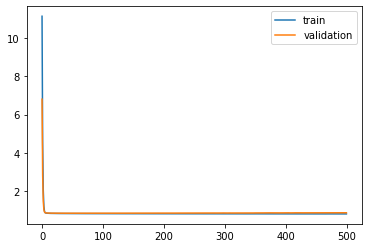

Time to train LSTM:  305.7784414291382
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 7s - loss: 11.1761 - pdc_loss: 0.6736 - event_loss: 0.5573 - val_loss: 6.8390 - val_pdc_loss: 0.6205 - val_event_loss: 0.4165

Epoch 00001: val_loss improved from inf to 6.83903, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 4.5790 - pdc_loss: 0.5878 - event_loss: 0.3430 - val_loss: 2.8644 - val_pdc_loss: 0.5771 - val_event_loss: 0.3146

Epoch 00002: val_loss improved from 6.83903 to 2.86445, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 2.0555 - pdc_loss: 0.5599 - event_loss: 0.3049 - val_loss: 1.4753 - val_pdc_loss: 0.5642 - val_event_loss: 0.3063

Epoch 00003: val_loss improved from 2.86445 to 1.47532, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 1.2058 - pdc_loss: 0.5507 - event_loss: 0.3017 - val_loss: 1.0366 - val_pdc_loss: 0.5590 - val_event_loss: 0.3046

Epoch 00004: val_loss improved from 1.47532 to 1.03656, saving 

 - 1s - loss: 0.8304 - pdc_loss: 0.5191 - event_loss: 0.2971 - val_loss: 0.8539 - val_pdc_loss: 0.5382 - val_event_loss: 0.3016

Epoch 00036: val_loss improved from 0.85428 to 0.85394, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.8303 - pdc_loss: 0.5189 - event_loss: 0.2971 - val_loss: 0.8541 - val_pdc_loss: 0.5381 - val_event_loss: 0.3018

Epoch 00037: val_loss did not improve from 0.85394
Epoch 38/500
 - 1s - loss: 0.8301 - pdc_loss: 0.5189 - event_loss: 0.2970 - val_loss: 0.8538 - val_pdc_loss: 0.5381 - val_event_loss: 0.3016

Epoch 00038: val_loss improved from 0.85394 to 0.85382, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8300 - pdc_loss: 0.5188 - event_loss: 0.2969 - val_loss: 0.8539 - val_pdc_loss: 0.5379 - val_event_loss: 0.3018

Epoch 00039: val_loss did not improve from 0.85382
Epoch 40/500
 - 1s - loss: 0.8297 - pdc_loss: 0.5186 - event_loss: 0.2969 - val_loss: 0.8535 - val_pdc_loss: 0.5379 - val_event_loss: 0.3016

Epoch 000

 - 1s - loss: 0.8262 - pdc_loss: 0.5160 - event_loss: 0.2959 - val_loss: 0.8519 - val_pdc_loss: 0.5358 - val_event_loss: 0.3018

Epoch 00075: val_loss did not improve from 0.85154
Epoch 76/500
 - 1s - loss: 0.8264 - pdc_loss: 0.5160 - event_loss: 0.2959 - val_loss: 0.8517 - val_pdc_loss: 0.5356 - val_event_loss: 0.3018

Epoch 00076: val_loss did not improve from 0.85154
Epoch 77/500
 - 1s - loss: 0.8262 - pdc_loss: 0.5159 - event_loss: 0.2959 - val_loss: 0.8516 - val_pdc_loss: 0.5356 - val_event_loss: 0.3016

Epoch 00077: val_loss did not improve from 0.85154
Epoch 78/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5158 - event_loss: 0.2959 - val_loss: 0.8516 - val_pdc_loss: 0.5354 - val_event_loss: 0.3018

Epoch 00078: val_loss did not improve from 0.85154
Epoch 79/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5158 - event_loss: 0.2959 - val_loss: 0.8521 - val_pdc_loss: 0.5358 - val_event_loss: 0.3019

Epoch 00079: val_loss did not improve from 0.85154
Epoch 80/500
 - 1s - loss: 0.8261 - pdc_loss: 0.


Epoch 00116: val_loss did not improve from 0.85120
Epoch 117/500
 - 1s - loss: 0.8242 - pdc_loss: 0.5141 - event_loss: 0.2952 - val_loss: 0.8514 - val_pdc_loss: 0.5349 - val_event_loss: 0.3018

Epoch 00117: val_loss did not improve from 0.85120
Epoch 118/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5140 - event_loss: 0.2951 - val_loss: 0.8513 - val_pdc_loss: 0.5347 - val_event_loss: 0.3019

Epoch 00118: val_loss did not improve from 0.85120
Epoch 119/500
 - 1s - loss: 0.8241 - pdc_loss: 0.5141 - event_loss: 0.2951 - val_loss: 0.8519 - val_pdc_loss: 0.5351 - val_event_loss: 0.3019

Epoch 00119: val_loss did not improve from 0.85120
Epoch 120/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5140 - event_loss: 0.2951 - val_loss: 0.8517 - val_pdc_loss: 0.5350 - val_event_loss: 0.3019

Epoch 00120: val_loss did not improve from 0.85120
Epoch 121/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5138 - event_loss: 0.2951 - val_loss: 0.8517 - val_pdc_loss: 0.5351 - val_event_loss: 0.3017

Epoch 00121: val_loss did not


Epoch 00158: val_loss did not improve from 0.85062
Epoch 159/500
 - 1s - loss: 0.8226 - pdc_loss: 0.5129 - event_loss: 0.2944 - val_loss: 0.8517 - val_pdc_loss: 0.5348 - val_event_loss: 0.3018

Epoch 00159: val_loss did not improve from 0.85062
Epoch 160/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5128 - event_loss: 0.2943 - val_loss: 0.8517 - val_pdc_loss: 0.5346 - val_event_loss: 0.3020

Epoch 00160: val_loss did not improve from 0.85062
Epoch 161/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5128 - event_loss: 0.2944 - val_loss: 0.8521 - val_pdc_loss: 0.5349 - val_event_loss: 0.3020

Epoch 00161: val_loss did not improve from 0.85062
Epoch 162/500
 - 1s - loss: 0.8221 - pdc_loss: 0.5125 - event_loss: 0.2942 - val_loss: 0.8516 - val_pdc_loss: 0.5341 - val_event_loss: 0.3021

Epoch 00162: val_loss did not improve from 0.85062
Epoch 163/500
 - 1s - loss: 0.8226 - pdc_loss: 0.5127 - event_loss: 0.2943 - val_loss: 0.8519 - val_pdc_loss: 0.5347 - val_event_loss: 0.3018

Epoch 00163: val_loss did not

 - 1s - loss: 0.8208 - pdc_loss: 0.5113 - event_loss: 0.2934 - val_loss: 0.8527 - val_pdc_loss: 0.5342 - val_event_loss: 0.3027

Epoch 00201: val_loss did not improve from 0.85062
Epoch 202/500
 - 1s - loss: 0.8208 - pdc_loss: 0.5114 - event_loss: 0.2934 - val_loss: 0.8522 - val_pdc_loss: 0.5340 - val_event_loss: 0.3022

Epoch 00202: val_loss did not improve from 0.85062
Epoch 203/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5112 - event_loss: 0.2934 - val_loss: 0.8526 - val_pdc_loss: 0.5343 - val_event_loss: 0.3021

Epoch 00203: val_loss did not improve from 0.85062
Epoch 204/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5111 - event_loss: 0.2935 - val_loss: 0.8529 - val_pdc_loss: 0.5342 - val_event_loss: 0.3024

Epoch 00204: val_loss did not improve from 0.85062
Epoch 205/500
 - 1s - loss: 0.8207 - pdc_loss: 0.5111 - event_loss: 0.2933 - val_loss: 0.8520 - val_pdc_loss: 0.5337 - val_event_loss: 0.3021

Epoch 00205: val_loss did not improve from 0.85062
Epoch 206/500
 - 1s - loss: 0.8208 - pdc_los


Epoch 00243: val_loss did not improve from 0.85062
Epoch 244/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5098 - event_loss: 0.2926 - val_loss: 0.8547 - val_pdc_loss: 0.5351 - val_event_loss: 0.3028

Epoch 00244: val_loss did not improve from 0.85062
Epoch 245/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5099 - event_loss: 0.2925 - val_loss: 0.8549 - val_pdc_loss: 0.5351 - val_event_loss: 0.3029

Epoch 00245: val_loss did not improve from 0.85062
Epoch 246/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5097 - event_loss: 0.2923 - val_loss: 0.8548 - val_pdc_loss: 0.5352 - val_event_loss: 0.3028

Epoch 00246: val_loss did not improve from 0.85062
Epoch 247/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5097 - event_loss: 0.2924 - val_loss: 0.8554 - val_pdc_loss: 0.5355 - val_event_loss: 0.3030

Epoch 00247: val_loss did not improve from 0.85062
Epoch 248/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5098 - event_loss: 0.2924 - val_loss: 0.8546 - val_pdc_loss: 0.5352 - val_event_loss: 0.3025

Epoch 00248: val_loss did not

 - 1s - loss: 0.8187 - pdc_loss: 0.5086 - event_loss: 0.2919 - val_loss: 0.8551 - val_pdc_loss: 0.5346 - val_event_loss: 0.3028

Epoch 00286: val_loss did not improve from 0.85062
Epoch 287/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5083 - event_loss: 0.2917 - val_loss: 0.8554 - val_pdc_loss: 0.5349 - val_event_loss: 0.3029

Epoch 00287: val_loss did not improve from 0.85062
Epoch 288/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5083 - event_loss: 0.2917 - val_loss: 0.8557 - val_pdc_loss: 0.5352 - val_event_loss: 0.3028

Epoch 00288: val_loss did not improve from 0.85062
Epoch 289/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5086 - event_loss: 0.2917 - val_loss: 0.8565 - val_pdc_loss: 0.5351 - val_event_loss: 0.3034

Epoch 00289: val_loss did not improve from 0.85062
Epoch 290/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5083 - event_loss: 0.2916 - val_loss: 0.8562 - val_pdc_loss: 0.5358 - val_event_loss: 0.3026

Epoch 00290: val_loss did not improve from 0.85062
Epoch 291/500
 - 1s - loss: 0.8184 - pdc_los


Epoch 00328: val_loss did not improve from 0.85062
Epoch 329/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5069 - event_loss: 0.2914 - val_loss: 0.8603 - val_pdc_loss: 0.5371 - val_event_loss: 0.3046

Epoch 00329: val_loss did not improve from 0.85062
Epoch 330/500
 - 1s - loss: 0.8173 - pdc_loss: 0.5072 - event_loss: 0.2914 - val_loss: 0.8594 - val_pdc_loss: 0.5364 - val_event_loss: 0.3044

Epoch 00330: val_loss did not improve from 0.85062
Epoch 331/500
 - 1s - loss: 0.8167 - pdc_loss: 0.5067 - event_loss: 0.2914 - val_loss: 0.8605 - val_pdc_loss: 0.5371 - val_event_loss: 0.3050

Epoch 00331: val_loss did not improve from 0.85062
Epoch 332/500
 - 1s - loss: 0.8163 - pdc_loss: 0.5068 - event_loss: 0.2911 - val_loss: 0.8602 - val_pdc_loss: 0.5370 - val_event_loss: 0.3049

Epoch 00332: val_loss did not improve from 0.85062
Epoch 333/500
 - 1s - loss: 0.8166 - pdc_loss: 0.5068 - event_loss: 0.2913 - val_loss: 0.8616 - val_pdc_loss: 0.5386 - val_event_loss: 0.3044

Epoch 00333: val_loss did not

 - 1s - loss: 0.8165 - pdc_loss: 0.5060 - event_loss: 0.2905 - val_loss: 0.8638 - val_pdc_loss: 0.5395 - val_event_loss: 0.3044

Epoch 00371: val_loss did not improve from 0.85062
Epoch 372/500
 - 1s - loss: 0.8163 - pdc_loss: 0.5058 - event_loss: 0.2904 - val_loss: 0.8652 - val_pdc_loss: 0.5400 - val_event_loss: 0.3055

Epoch 00372: val_loss did not improve from 0.85062
Epoch 373/500
 - 1s - loss: 0.8161 - pdc_loss: 0.5056 - event_loss: 0.2904 - val_loss: 0.8635 - val_pdc_loss: 0.5385 - val_event_loss: 0.3050

Epoch 00373: val_loss did not improve from 0.85062
Epoch 374/500
 - 1s - loss: 0.8153 - pdc_loss: 0.5055 - event_loss: 0.2901 - val_loss: 0.8639 - val_pdc_loss: 0.5391 - val_event_loss: 0.3052

Epoch 00374: val_loss did not improve from 0.85062
Epoch 375/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5060 - event_loss: 0.2910 - val_loss: 0.8637 - val_pdc_loss: 0.5385 - val_event_loss: 0.3056

Epoch 00375: val_loss did not improve from 0.85062
Epoch 376/500
 - 1s - loss: 0.8156 - pdc_los


Epoch 00413: val_loss did not improve from 0.85062
Epoch 414/500
 - 1s - loss: 0.8144 - pdc_loss: 0.5043 - event_loss: 0.2897 - val_loss: 0.8641 - val_pdc_loss: 0.5381 - val_event_loss: 0.3058

Epoch 00414: val_loss did not improve from 0.85062
Epoch 415/500
 - 1s - loss: 0.8153 - pdc_loss: 0.5050 - event_loss: 0.2897 - val_loss: 0.8670 - val_pdc_loss: 0.5397 - val_event_loss: 0.3069

Epoch 00415: val_loss did not improve from 0.85062
Epoch 416/500
 - 1s - loss: 0.8147 - pdc_loss: 0.5044 - event_loss: 0.2897 - val_loss: 0.8650 - val_pdc_loss: 0.5386 - val_event_loss: 0.3060

Epoch 00416: val_loss did not improve from 0.85062
Epoch 417/500
 - 1s - loss: 0.8148 - pdc_loss: 0.5044 - event_loss: 0.2899 - val_loss: 0.8648 - val_pdc_loss: 0.5385 - val_event_loss: 0.3058

Epoch 00417: val_loss did not improve from 0.85062
Epoch 418/500
 - 1s - loss: 0.8149 - pdc_loss: 0.5044 - event_loss: 0.2896 - val_loss: 0.8655 - val_pdc_loss: 0.5387 - val_event_loss: 0.3060

Epoch 00418: val_loss did not

 - 1s - loss: 0.8140 - pdc_loss: 0.5032 - event_loss: 0.2895 - val_loss: 0.8672 - val_pdc_loss: 0.5393 - val_event_loss: 0.3067

Epoch 00456: val_loss did not improve from 0.85062
Epoch 457/500
 - 1s - loss: 0.8150 - pdc_loss: 0.5037 - event_loss: 0.2899 - val_loss: 0.8674 - val_pdc_loss: 0.5395 - val_event_loss: 0.3064

Epoch 00457: val_loss did not improve from 0.85062
Epoch 458/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5033 - event_loss: 0.2893 - val_loss: 0.8675 - val_pdc_loss: 0.5395 - val_event_loss: 0.3068

Epoch 00458: val_loss did not improve from 0.85062
Epoch 459/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5033 - event_loss: 0.2893 - val_loss: 0.8665 - val_pdc_loss: 0.5388 - val_event_loss: 0.3067

Epoch 00459: val_loss did not improve from 0.85062
Epoch 460/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5034 - event_loss: 0.2896 - val_loss: 0.8672 - val_pdc_loss: 0.5392 - val_event_loss: 0.3071

Epoch 00460: val_loss did not improve from 0.85062
Epoch 461/500
 - 1s - loss: 0.8140 - pdc_los


Epoch 00498: val_loss did not improve from 0.85062
Epoch 499/500
 - 1s - loss: 0.8138 - pdc_loss: 0.5028 - event_loss: 0.2889 - val_loss: 0.8680 - val_pdc_loss: 0.5382 - val_event_loss: 0.3078

Epoch 00499: val_loss did not improve from 0.85062
Epoch 500/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5026 - event_loss: 0.2890 - val_loss: 0.8681 - val_pdc_loss: 0.5385 - val_event_loss: 0.3077

Epoch 00500: val_loss did not improve from 0.85062
#################################
Number of units: 32
Batch size: 2048
Fold: 3
best val loss: 0.8506176115141975
#################################


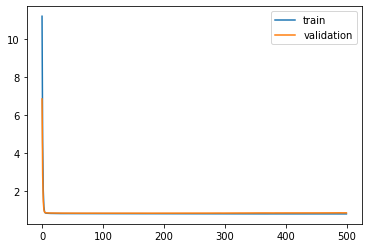

Time to train LSTM:  312.60397481918335
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 7s - loss: 11.1545 - pdc_loss: 0.6625 - event_loss: 0.5668 - val_loss: 6.7889 - val_pdc_loss: 0.6118 - val_event_loss: 0.4038

Epoch 00001: val_loss improved from inf to 6.78891, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 4.5524 - pdc_loss: 0.5873 - event_loss: 0.3381 - val_loss: 2.8398 - val_pdc_loss: 0.5692 - val_event_loss: 0.3107

Epoch 00002: val_loss improved from 6.78891 to 2.83975, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 2.0496 - pdc_loss: 0.5614 - event_loss: 0.3055 - val_loss: 1.4620 - val_pdc_loss: 0.5579 - val_event_loss: 0.3029

Epoch 00003: val_loss improved from 2.83975 to 1.46204, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 1.2071 - pdc_loss: 0.5540 - event_loss: 0.3021 - val_loss: 1.0248 - val_pdc_loss: 0.5511 - val_event_loss: 0.3017

Epoch 00004: val_loss improved from 1.46204 to 1.02479, saving

 - 1s - loss: 0.8326 - pdc_loss: 0.5207 - event_loss: 0.2975 - val_loss: 0.8342 - val_pdc_loss: 0.5223 - val_event_loss: 0.2977

Epoch 00036: val_loss improved from 0.83441 to 0.83418, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.8323 - pdc_loss: 0.5206 - event_loss: 0.2974 - val_loss: 0.8339 - val_pdc_loss: 0.5219 - val_event_loss: 0.2976

Epoch 00037: val_loss improved from 0.83418 to 0.83387, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.8323 - pdc_loss: 0.5205 - event_loss: 0.2974 - val_loss: 0.8339 - val_pdc_loss: 0.5222 - val_event_loss: 0.2975

Epoch 00038: val_loss did not improve from 0.83387
Epoch 39/500
 - 1s - loss: 0.8319 - pdc_loss: 0.5204 - event_loss: 0.2972 - val_loss: 0.8338 - val_pdc_loss: 0.5217 - val_event_loss: 0.2978

Epoch 00039: val_loss improved from 0.83387 to 0.83377, saving model to Event_val_weights5.hdf5
Epoch 40/500
 - 1s - loss: 0.8320 - pdc_loss: 0.5202 - event_loss: 0.2973 - val_loss: 0.8335 - val_pdc_los


Epoch 00075: val_loss did not improve from 0.83209
Epoch 76/500
 - 1s - loss: 0.8282 - pdc_loss: 0.5173 - event_loss: 0.2963 - val_loss: 0.8321 - val_pdc_loss: 0.5205 - val_event_loss: 0.2971

Epoch 00076: val_loss did not improve from 0.83209
Epoch 77/500
 - 1s - loss: 0.8282 - pdc_loss: 0.5173 - event_loss: 0.2963 - val_loss: 0.8327 - val_pdc_loss: 0.5211 - val_event_loss: 0.2970

Epoch 00077: val_loss did not improve from 0.83209
Epoch 78/500
 - 1s - loss: 0.8281 - pdc_loss: 0.5172 - event_loss: 0.2963 - val_loss: 0.8316 - val_pdc_loss: 0.5202 - val_event_loss: 0.2967

Epoch 00078: val_loss improved from 0.83209 to 0.83159, saving model to Event_val_weights5.hdf5
Epoch 79/500
 - 1s - loss: 0.8280 - pdc_loss: 0.5172 - event_loss: 0.2961 - val_loss: 0.8320 - val_pdc_loss: 0.5204 - val_event_loss: 0.2969

Epoch 00079: val_loss did not improve from 0.83159
Epoch 80/500
 - 1s - loss: 0.8279 - pdc_loss: 0.5170 - event_loss: 0.2961 - val_loss: 0.8319 - val_pdc_loss: 0.5202 - val_event_los


Epoch 00117: val_loss did not improve from 0.83130
Epoch 118/500
 - 1s - loss: 0.8256 - pdc_loss: 0.5146 - event_loss: 0.2953 - val_loss: 0.8319 - val_pdc_loss: 0.5190 - val_event_loss: 0.2975

Epoch 00118: val_loss did not improve from 0.83130
Epoch 119/500
 - 1s - loss: 0.8256 - pdc_loss: 0.5145 - event_loss: 0.2955 - val_loss: 0.8321 - val_pdc_loss: 0.5192 - val_event_loss: 0.2974

Epoch 00119: val_loss did not improve from 0.83130
Epoch 120/500
 - 1s - loss: 0.8252 - pdc_loss: 0.5144 - event_loss: 0.2952 - val_loss: 0.8316 - val_pdc_loss: 0.5190 - val_event_loss: 0.2970

Epoch 00120: val_loss did not improve from 0.83130
Epoch 121/500
 - 1s - loss: 0.8254 - pdc_loss: 0.5144 - event_loss: 0.2954 - val_loss: 0.8311 - val_pdc_loss: 0.5187 - val_event_loss: 0.2968

Epoch 00121: val_loss improved from 0.83130 to 0.83105, saving model to Event_val_weights5.hdf5
Epoch 122/500
 - 1s - loss: 0.8254 - pdc_loss: 0.5145 - event_loss: 0.2952 - val_loss: 0.8320 - val_pdc_loss: 0.5193 - val_even


Epoch 00159: val_loss did not improve from 0.83105
Epoch 160/500
 - 1s - loss: 0.8236 - pdc_loss: 0.5125 - event_loss: 0.2945 - val_loss: 0.8340 - val_pdc_loss: 0.5194 - val_event_loss: 0.2984

Epoch 00160: val_loss did not improve from 0.83105
Epoch 161/500
 - 1s - loss: 0.8231 - pdc_loss: 0.5124 - event_loss: 0.2944 - val_loss: 0.8347 - val_pdc_loss: 0.5200 - val_event_loss: 0.2986

Epoch 00161: val_loss did not improve from 0.83105
Epoch 162/500
 - 1s - loss: 0.8235 - pdc_loss: 0.5127 - event_loss: 0.2944 - val_loss: 0.8348 - val_pdc_loss: 0.5191 - val_event_loss: 0.2992

Epoch 00162: val_loss did not improve from 0.83105
Epoch 163/500
 - 1s - loss: 0.8236 - pdc_loss: 0.5125 - event_loss: 0.2944 - val_loss: 0.8346 - val_pdc_loss: 0.5194 - val_event_loss: 0.2986

Epoch 00163: val_loss did not improve from 0.83105
Epoch 164/500
 - 1s - loss: 0.8237 - pdc_loss: 0.5126 - event_loss: 0.2945 - val_loss: 0.8351 - val_pdc_loss: 0.5195 - val_event_loss: 0.2992

Epoch 00164: val_loss did not

 - 1s - loss: 0.8221 - pdc_loss: 0.5107 - event_loss: 0.2935 - val_loss: 0.8373 - val_pdc_loss: 0.5200 - val_event_loss: 0.2999

Epoch 00202: val_loss did not improve from 0.83105
Epoch 203/500
 - 1s - loss: 0.8221 - pdc_loss: 0.5107 - event_loss: 0.2938 - val_loss: 0.8378 - val_pdc_loss: 0.5203 - val_event_loss: 0.3003

Epoch 00203: val_loss did not improve from 0.83105
Epoch 204/500
 - 1s - loss: 0.8219 - pdc_loss: 0.5107 - event_loss: 0.2937 - val_loss: 0.8374 - val_pdc_loss: 0.5201 - val_event_loss: 0.3001

Epoch 00204: val_loss did not improve from 0.83105
Epoch 205/500
 - 1s - loss: 0.8220 - pdc_loss: 0.5108 - event_loss: 0.2938 - val_loss: 0.8377 - val_pdc_loss: 0.5206 - val_event_loss: 0.2999

Epoch 00205: val_loss did not improve from 0.83105
Epoch 206/500
 - 1s - loss: 0.8218 - pdc_loss: 0.5104 - event_loss: 0.2936 - val_loss: 0.8386 - val_pdc_loss: 0.5216 - val_event_loss: 0.2994

Epoch 00206: val_loss did not improve from 0.83105
Epoch 207/500
 - 1s - loss: 0.8220 - pdc_los


Epoch 00244: val_loss did not improve from 0.83105
Epoch 245/500
 - 1s - loss: 0.8207 - pdc_loss: 0.5094 - event_loss: 0.2929 - val_loss: 0.8389 - val_pdc_loss: 0.5208 - val_event_loss: 0.3001

Epoch 00245: val_loss did not improve from 0.83105
Epoch 246/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5092 - event_loss: 0.2926 - val_loss: 0.8402 - val_pdc_loss: 0.5216 - val_event_loss: 0.3007

Epoch 00246: val_loss did not improve from 0.83105
Epoch 247/500
 - 1s - loss: 0.8205 - pdc_loss: 0.5095 - event_loss: 0.2929 - val_loss: 0.8403 - val_pdc_loss: 0.5222 - val_event_loss: 0.3002

Epoch 00247: val_loss did not improve from 0.83105
Epoch 248/500
 - 1s - loss: 0.8202 - pdc_loss: 0.5095 - event_loss: 0.2927 - val_loss: 0.8398 - val_pdc_loss: 0.5216 - val_event_loss: 0.3004

Epoch 00248: val_loss did not improve from 0.83105
Epoch 249/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5093 - event_loss: 0.2926 - val_loss: 0.8411 - val_pdc_loss: 0.5228 - val_event_loss: 0.3002

Epoch 00249: val_loss did not

 - 1s - loss: 0.8194 - pdc_loss: 0.5081 - event_loss: 0.2918 - val_loss: 0.8416 - val_pdc_loss: 0.5210 - val_event_loss: 0.3013

Epoch 00287: val_loss did not improve from 0.83105
Epoch 288/500
 - 1s - loss: 0.8188 - pdc_loss: 0.5077 - event_loss: 0.2918 - val_loss: 0.8423 - val_pdc_loss: 0.5215 - val_event_loss: 0.3016

Epoch 00288: val_loss did not improve from 0.83105
Epoch 289/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5079 - event_loss: 0.2919 - val_loss: 0.8432 - val_pdc_loss: 0.5221 - val_event_loss: 0.3016

Epoch 00289: val_loss did not improve from 0.83105
Epoch 290/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5078 - event_loss: 0.2915 - val_loss: 0.8435 - val_pdc_loss: 0.5217 - val_event_loss: 0.3024

Epoch 00290: val_loss did not improve from 0.83105
Epoch 291/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5072 - event_loss: 0.2918 - val_loss: 0.8409 - val_pdc_loss: 0.5208 - val_event_loss: 0.3009

Epoch 00291: val_loss did not improve from 0.83105
Epoch 292/500
 - 1s - loss: 0.8191 - pdc_los


Epoch 00329: val_loss did not improve from 0.83105
Epoch 330/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5064 - event_loss: 0.2916 - val_loss: 0.8451 - val_pdc_loss: 0.5224 - val_event_loss: 0.3022

Epoch 00330: val_loss did not improve from 0.83105
Epoch 331/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5065 - event_loss: 0.2910 - val_loss: 0.8453 - val_pdc_loss: 0.5219 - val_event_loss: 0.3026

Epoch 00331: val_loss did not improve from 0.83105
Epoch 332/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5064 - event_loss: 0.2914 - val_loss: 0.8451 - val_pdc_loss: 0.5218 - val_event_loss: 0.3026

Epoch 00332: val_loss did not improve from 0.83105
Epoch 333/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5066 - event_loss: 0.2913 - val_loss: 0.8440 - val_pdc_loss: 0.5219 - val_event_loss: 0.3016

Epoch 00333: val_loss did not improve from 0.83105
Epoch 334/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5065 - event_loss: 0.2912 - val_loss: 0.8444 - val_pdc_loss: 0.5217 - val_event_loss: 0.3022

Epoch 00334: val_loss did not

 - 1s - loss: 0.8173 - pdc_loss: 0.5056 - event_loss: 0.2906 - val_loss: 0.8470 - val_pdc_loss: 0.5230 - val_event_loss: 0.3028

Epoch 00372: val_loss did not improve from 0.83105
Epoch 373/500
 - 1s - loss: 0.8174 - pdc_loss: 0.5057 - event_loss: 0.2906 - val_loss: 0.8490 - val_pdc_loss: 0.5240 - val_event_loss: 0.3041

Epoch 00373: val_loss did not improve from 0.83105
Epoch 374/500
 - 1s - loss: 0.8167 - pdc_loss: 0.5054 - event_loss: 0.2905 - val_loss: 0.8475 - val_pdc_loss: 0.5231 - val_event_loss: 0.3039

Epoch 00374: val_loss did not improve from 0.83105
Epoch 375/500
 - 1s - loss: 0.8161 - pdc_loss: 0.5050 - event_loss: 0.2906 - val_loss: 0.8459 - val_pdc_loss: 0.5221 - val_event_loss: 0.3033

Epoch 00375: val_loss did not improve from 0.83105
Epoch 376/500
 - 1s - loss: 0.8158 - pdc_loss: 0.5050 - event_loss: 0.2901 - val_loss: 0.8473 - val_pdc_loss: 0.5226 - val_event_loss: 0.3039

Epoch 00376: val_loss did not improve from 0.83105
Epoch 377/500
 - 1s - loss: 0.8157 - pdc_los


Epoch 00414: val_loss did not improve from 0.83105
Epoch 415/500
 - 1s - loss: 0.8157 - pdc_loss: 0.5042 - event_loss: 0.2898 - val_loss: 0.8475 - val_pdc_loss: 0.5225 - val_event_loss: 0.3034

Epoch 00415: val_loss did not improve from 0.83105
Epoch 416/500
 - 1s - loss: 0.8159 - pdc_loss: 0.5043 - event_loss: 0.2898 - val_loss: 0.8488 - val_pdc_loss: 0.5237 - val_event_loss: 0.3035

Epoch 00416: val_loss did not improve from 0.83105
Epoch 417/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5048 - event_loss: 0.2901 - val_loss: 0.8501 - val_pdc_loss: 0.5244 - val_event_loss: 0.3031

Epoch 00417: val_loss did not improve from 0.83105
Epoch 418/500
 - 1s - loss: 0.8170 - pdc_loss: 0.5046 - event_loss: 0.2899 - val_loss: 0.8466 - val_pdc_loss: 0.5230 - val_event_loss: 0.3015

Epoch 00418: val_loss did not improve from 0.83105
Epoch 419/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5044 - event_loss: 0.2903 - val_loss: 0.8483 - val_pdc_loss: 0.5236 - val_event_loss: 0.3029

Epoch 00419: val_loss did not

 - 1s - loss: 0.8161 - pdc_loss: 0.5036 - event_loss: 0.2899 - val_loss: 0.8529 - val_pdc_loss: 0.5257 - val_event_loss: 0.3047

Epoch 00457: val_loss did not improve from 0.83105
Epoch 458/500
 - 1s - loss: 0.8158 - pdc_loss: 0.5032 - event_loss: 0.2898 - val_loss: 0.8522 - val_pdc_loss: 0.5256 - val_event_loss: 0.3042

Epoch 00458: val_loss did not improve from 0.83105
Epoch 459/500
 - 1s - loss: 0.8154 - pdc_loss: 0.5030 - event_loss: 0.2898 - val_loss: 0.8516 - val_pdc_loss: 0.5243 - val_event_loss: 0.3051

Epoch 00459: val_loss did not improve from 0.83105
Epoch 460/500
 - 1s - loss: 0.8144 - pdc_loss: 0.5025 - event_loss: 0.2896 - val_loss: 0.8491 - val_pdc_loss: 0.5234 - val_event_loss: 0.3036

Epoch 00460: val_loss did not improve from 0.83105
Epoch 461/500
 - 1s - loss: 0.8146 - pdc_loss: 0.5027 - event_loss: 0.2897 - val_loss: 0.8496 - val_pdc_loss: 0.5235 - val_event_loss: 0.3041

Epoch 00461: val_loss did not improve from 0.83105
Epoch 462/500
 - 1s - loss: 0.8150 - pdc_los


Epoch 00499: val_loss did not improve from 0.83105
Epoch 500/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5020 - event_loss: 0.2892 - val_loss: 0.8505 - val_pdc_loss: 0.5246 - val_event_loss: 0.3034

Epoch 00500: val_loss did not improve from 0.83105
#################################
Number of units: 32
Batch size: 2048
Fold: 4
best val loss: 0.8310512804455227
#################################
[[16, 2048, 0, 0.8224167359670004], [16, 2048, 1, 0.8401647506819832], [16, 2048, 2, 0.8433566116756863], [16, 2048, 3, 0.8464996161990695], [16, 2048, 4, 0.8281297560267978], [16, 4096, 0, 0.820447082095676], [16, 4096, 1, 0.8368666137589349], [16, 4096, 2, 0.844096617380778], [16, 4096, 3, 0.8447988412115309], [16, 4096, 4, 0.8285953990618388], [16, 8192, 0, 0.8171780200534396], [16, 8192, 1, 0.8348839523527357], [16, 8192, 2, 0.8414138742023044], [16, 8192, 3, 0.8440553790198432], [16, 8192, 4, 0.8267391532791986], [16, 16384, 0, 0.8187218904495239], [16, 16384, 1, 0.8349984884262085], [16, 16384,

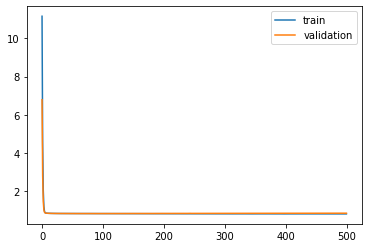

Time to train LSTM:  300.3586232662201
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 8s - loss: 13.6317 - pdc_loss: 0.7189 - event_loss: 0.6457 - val_loss: 10.7636 - val_pdc_loss: 0.6663 - val_event_loss: 0.5682

Epoch 00001: val_loss improved from inf to 10.76363, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 8.8053 - pdc_loss: 0.6440 - event_loss: 0.5101 - val_loss: 6.8671 - val_pdc_loss: 0.6216 - val_event_loss: 0.4341

Epoch 00002: val_loss improved from 10.76363 to 6.86713, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 5.5904 - pdc_loss: 0.6068 - event_loss: 0.3822 - val_loss: 4.3481 - val_pdc_loss: 0.5912 - val_event_loss: 0.3248

Epoch 00003: val_loss improved from 6.86713 to 4.34810, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 3.5830 - pdc_loss: 0.5807 - event_loss: 0.3195 - val_loss: 2.8467 - val_pdc_loss: 0.5732 - val_event_loss: 0.3036

Epoch 00004: val_loss improved from 4.34810 to 2.84666, savi


Epoch 00035: val_loss improved from 0.82703 to 0.82648, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 0.8301 - pdc_loss: 0.5200 - event_loss: 0.2976 - val_loss: 0.8266 - val_pdc_loss: 0.5221 - val_event_loss: 0.2921

Epoch 00036: val_loss did not improve from 0.82648
Epoch 37/500
 - 1s - loss: 0.8298 - pdc_loss: 0.5198 - event_loss: 0.2975 - val_loss: 0.8261 - val_pdc_loss: 0.5220 - val_event_loss: 0.2917

Epoch 00037: val_loss improved from 0.82648 to 0.82611, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 0.8295 - pdc_loss: 0.5196 - event_loss: 0.2974 - val_loss: 0.8264 - val_pdc_loss: 0.5222 - val_event_loss: 0.2918

Epoch 00038: val_loss did not improve from 0.82611
Epoch 39/500
 - 1s - loss: 0.8292 - pdc_loss: 0.5194 - event_loss: 0.2974 - val_loss: 0.8257 - val_pdc_loss: 0.5218 - val_event_loss: 0.2916

Epoch 00039: val_loss improved from 0.82611 to 0.82572, saving model to Event_val_weights1.hdf5
Epoch 40/500
 - 1s - loss: 0.8287 - pdc_l

 - 1s - loss: 0.8216 - pdc_loss: 0.5140 - event_loss: 0.2953 - val_loss: 0.8232 - val_pdc_loss: 0.5193 - val_event_loss: 0.2916

Epoch 00074: val_loss did not improve from 0.82306
Epoch 75/500
 - 1s - loss: 0.8216 - pdc_loss: 0.5140 - event_loss: 0.2952 - val_loss: 0.8232 - val_pdc_loss: 0.5190 - val_event_loss: 0.2919

Epoch 00075: val_loss did not improve from 0.82306
Epoch 76/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5138 - event_loss: 0.2951 - val_loss: 0.8236 - val_pdc_loss: 0.5191 - val_event_loss: 0.2922

Epoch 00076: val_loss did not improve from 0.82306
Epoch 77/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5137 - event_loss: 0.2951 - val_loss: 0.8235 - val_pdc_loss: 0.5189 - val_event_loss: 0.2922

Epoch 00077: val_loss did not improve from 0.82306
Epoch 78/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5136 - event_loss: 0.2950 - val_loss: 0.8234 - val_pdc_loss: 0.5189 - val_event_loss: 0.2921

Epoch 00078: val_loss did not improve from 0.82306
Epoch 79/500
 - 1s - loss: 0.8210 - pdc_loss: 0.


Epoch 00116: val_loss did not improve from 0.82306
Epoch 117/500
 - 1s - loss: 0.8171 - pdc_loss: 0.5104 - event_loss: 0.2931 - val_loss: 0.8263 - val_pdc_loss: 0.5197 - val_event_loss: 0.2930

Epoch 00117: val_loss did not improve from 0.82306
Epoch 118/500
 - 1s - loss: 0.8168 - pdc_loss: 0.5101 - event_loss: 0.2931 - val_loss: 0.8270 - val_pdc_loss: 0.5207 - val_event_loss: 0.2928

Epoch 00118: val_loss did not improve from 0.82306
Epoch 119/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5104 - event_loss: 0.2932 - val_loss: 0.8270 - val_pdc_loss: 0.5196 - val_event_loss: 0.2936

Epoch 00119: val_loss did not improve from 0.82306
Epoch 120/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5102 - event_loss: 0.2930 - val_loss: 0.8272 - val_pdc_loss: 0.5203 - val_event_loss: 0.2931

Epoch 00120: val_loss did not improve from 0.82306
Epoch 121/500
 - 1s - loss: 0.8167 - pdc_loss: 0.5101 - event_loss: 0.2930 - val_loss: 0.8271 - val_pdc_loss: 0.5208 - val_event_loss: 0.2927

Epoch 00121: val_loss did not

 - 1s - loss: 0.8142 - pdc_loss: 0.5072 - event_loss: 0.2921 - val_loss: 0.8316 - val_pdc_loss: 0.5224 - val_event_loss: 0.2942

Epoch 00159: val_loss did not improve from 0.82306
Epoch 160/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5070 - event_loss: 0.2918 - val_loss: 0.8316 - val_pdc_loss: 0.5226 - val_event_loss: 0.2940

Epoch 00160: val_loss did not improve from 0.82306
Epoch 161/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5072 - event_loss: 0.2916 - val_loss: 0.8328 - val_pdc_loss: 0.5230 - val_event_loss: 0.2950

Epoch 00161: val_loss did not improve from 0.82306
Epoch 162/500
 - 1s - loss: 0.8142 - pdc_loss: 0.5074 - event_loss: 0.2919 - val_loss: 0.8304 - val_pdc_loss: 0.5218 - val_event_loss: 0.2937

Epoch 00162: val_loss did not improve from 0.82306
Epoch 163/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5071 - event_loss: 0.2916 - val_loss: 0.8315 - val_pdc_loss: 0.5217 - val_event_loss: 0.2949

Epoch 00163: val_loss did not improve from 0.82306
Epoch 164/500
 - 1s - loss: 0.8138 - pdc_los


Epoch 00201: val_loss did not improve from 0.82306
Epoch 202/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5043 - event_loss: 0.2904 - val_loss: 0.8376 - val_pdc_loss: 0.5255 - val_event_loss: 0.2960

Epoch 00202: val_loss did not improve from 0.82306
Epoch 203/500
 - 1s - loss: 0.8107 - pdc_loss: 0.5045 - event_loss: 0.2902 - val_loss: 0.8353 - val_pdc_loss: 0.5246 - val_event_loss: 0.2949

Epoch 00203: val_loss did not improve from 0.82306
Epoch 204/500
 - 1s - loss: 0.8107 - pdc_loss: 0.5045 - event_loss: 0.2902 - val_loss: 0.8374 - val_pdc_loss: 0.5266 - val_event_loss: 0.2948

Epoch 00204: val_loss did not improve from 0.82306
Epoch 205/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5046 - event_loss: 0.2903 - val_loss: 0.8372 - val_pdc_loss: 0.5249 - val_event_loss: 0.2962

Epoch 00205: val_loss did not improve from 0.82306
Epoch 206/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5041 - event_loss: 0.2903 - val_loss: 0.8366 - val_pdc_loss: 0.5254 - val_event_loss: 0.2952

Epoch 00206: val_loss did not

 - 1s - loss: 0.8095 - pdc_loss: 0.5032 - event_loss: 0.2892 - val_loss: 0.8443 - val_pdc_loss: 0.5288 - val_event_loss: 0.2985

Epoch 00244: val_loss did not improve from 0.82306
Epoch 245/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5032 - event_loss: 0.2893 - val_loss: 0.8454 - val_pdc_loss: 0.5306 - val_event_loss: 0.2976

Epoch 00245: val_loss did not improve from 0.82306
Epoch 246/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5032 - event_loss: 0.2892 - val_loss: 0.8467 - val_pdc_loss: 0.5308 - val_event_loss: 0.2986

Epoch 00246: val_loss did not improve from 0.82306
Epoch 247/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5035 - event_loss: 0.2893 - val_loss: 0.8436 - val_pdc_loss: 0.5298 - val_event_loss: 0.2963

Epoch 00247: val_loss did not improve from 0.82306
Epoch 248/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5034 - event_loss: 0.2893 - val_loss: 0.8440 - val_pdc_loss: 0.5300 - val_event_loss: 0.2965

Epoch 00248: val_loss did not improve from 0.82306
Epoch 249/500
 - 1s - loss: 0.8089 - pdc_los


Epoch 00286: val_loss did not improve from 0.82306
Epoch 287/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5010 - event_loss: 0.2878 - val_loss: 0.8432 - val_pdc_loss: 0.5281 - val_event_loss: 0.2973

Epoch 00287: val_loss did not improve from 0.82306
Epoch 288/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5008 - event_loss: 0.2878 - val_loss: 0.8419 - val_pdc_loss: 0.5277 - val_event_loss: 0.2963

Epoch 00288: val_loss did not improve from 0.82306
Epoch 289/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5014 - event_loss: 0.2881 - val_loss: 0.8410 - val_pdc_loss: 0.5272 - val_event_loss: 0.2962

Epoch 00289: val_loss did not improve from 0.82306
Epoch 290/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5007 - event_loss: 0.2879 - val_loss: 0.8418 - val_pdc_loss: 0.5276 - val_event_loss: 0.2963

Epoch 00290: val_loss did not improve from 0.82306
Epoch 291/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5006 - event_loss: 0.2879 - val_loss: 0.8428 - val_pdc_loss: 0.5281 - val_event_loss: 0.2964

Epoch 00291: val_loss did not

 - 1s - loss: 0.8081 - pdc_loss: 0.5014 - event_loss: 0.2879 - val_loss: 0.8456 - val_pdc_loss: 0.5300 - val_event_loss: 0.2967

Epoch 00329: val_loss did not improve from 0.82306
Epoch 330/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5009 - event_loss: 0.2874 - val_loss: 0.8456 - val_pdc_loss: 0.5304 - val_event_loss: 0.2965

Epoch 00330: val_loss did not improve from 0.82306
Epoch 331/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5017 - event_loss: 0.2877 - val_loss: 0.8484 - val_pdc_loss: 0.5317 - val_event_loss: 0.2978

Epoch 00331: val_loss did not improve from 0.82306
Epoch 332/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5010 - event_loss: 0.2875 - val_loss: 0.8461 - val_pdc_loss: 0.5306 - val_event_loss: 0.2966

Epoch 00332: val_loss did not improve from 0.82306
Epoch 333/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5010 - event_loss: 0.2874 - val_loss: 0.8454 - val_pdc_loss: 0.5297 - val_event_loss: 0.2967

Epoch 00333: val_loss did not improve from 0.82306
Epoch 334/500
 - 1s - loss: 0.8082 - pdc_los


Epoch 00371: val_loss did not improve from 0.82306
Epoch 372/500
 - 1s - loss: 0.8035 - pdc_loss: 0.4981 - event_loss: 0.2861 - val_loss: 0.8494 - val_pdc_loss: 0.5316 - val_event_loss: 0.2985

Epoch 00372: val_loss did not improve from 0.82306
Epoch 373/500
 - 1s - loss: 0.8031 - pdc_loss: 0.4981 - event_loss: 0.2857 - val_loss: 0.8491 - val_pdc_loss: 0.5309 - val_event_loss: 0.2990

Epoch 00373: val_loss did not improve from 0.82306
Epoch 374/500
 - 1s - loss: 0.8036 - pdc_loss: 0.4983 - event_loss: 0.2860 - val_loss: 0.8482 - val_pdc_loss: 0.5315 - val_event_loss: 0.2973

Epoch 00374: val_loss did not improve from 0.82306
Epoch 375/500
 - 1s - loss: 0.8043 - pdc_loss: 0.4987 - event_loss: 0.2861 - val_loss: 0.8477 - val_pdc_loss: 0.5306 - val_event_loss: 0.2975

Epoch 00375: val_loss did not improve from 0.82306
Epoch 376/500
 - 1s - loss: 0.8040 - pdc_loss: 0.4982 - event_loss: 0.2862 - val_loss: 0.8486 - val_pdc_loss: 0.5311 - val_event_loss: 0.2981

Epoch 00376: val_loss did not

 - 1s - loss: 0.8013 - pdc_loss: 0.4966 - event_loss: 0.2846 - val_loss: 0.8495 - val_pdc_loss: 0.5309 - val_event_loss: 0.2988

Epoch 00414: val_loss did not improve from 0.82306
Epoch 415/500
 - 1s - loss: 0.8009 - pdc_loss: 0.4966 - event_loss: 0.2844 - val_loss: 0.8512 - val_pdc_loss: 0.5321 - val_event_loss: 0.2992

Epoch 00415: val_loss did not improve from 0.82306
Epoch 416/500
 - 1s - loss: 0.8014 - pdc_loss: 0.4969 - event_loss: 0.2845 - val_loss: 0.8524 - val_pdc_loss: 0.5332 - val_event_loss: 0.2993

Epoch 00416: val_loss did not improve from 0.82306
Epoch 417/500
 - 1s - loss: 0.8018 - pdc_loss: 0.4970 - event_loss: 0.2848 - val_loss: 0.8529 - val_pdc_loss: 0.5335 - val_event_loss: 0.2994

Epoch 00417: val_loss did not improve from 0.82306
Epoch 418/500
 - 1s - loss: 0.8008 - pdc_loss: 0.4964 - event_loss: 0.2844 - val_loss: 0.8541 - val_pdc_loss: 0.5331 - val_event_loss: 0.3009

Epoch 00418: val_loss did not improve from 0.82306
Epoch 419/500
 - 1s - loss: 0.8012 - pdc_los


Epoch 00456: val_loss did not improve from 0.82306
Epoch 457/500
 - 1s - loss: 0.8006 - pdc_loss: 0.4954 - event_loss: 0.2838 - val_loss: 0.8588 - val_pdc_loss: 0.5351 - val_event_loss: 0.3023

Epoch 00457: val_loss did not improve from 0.82306
Epoch 458/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4953 - event_loss: 0.2841 - val_loss: 0.8573 - val_pdc_loss: 0.5356 - val_event_loss: 0.3006

Epoch 00458: val_loss did not improve from 0.82306
Epoch 459/500
 - 1s - loss: 0.8004 - pdc_loss: 0.4953 - event_loss: 0.2838 - val_loss: 0.8590 - val_pdc_loss: 0.5351 - val_event_loss: 0.3027

Epoch 00459: val_loss did not improve from 0.82306
Epoch 460/500
 - 1s - loss: 0.8013 - pdc_loss: 0.4959 - event_loss: 0.2840 - val_loss: 0.8574 - val_pdc_loss: 0.5352 - val_event_loss: 0.3009

Epoch 00460: val_loss did not improve from 0.82306
Epoch 461/500
 - 1s - loss: 0.8006 - pdc_loss: 0.4951 - event_loss: 0.2840 - val_loss: 0.8575 - val_pdc_loss: 0.5334 - val_event_loss: 0.3025

Epoch 00461: val_loss did not

 - 1s - loss: 0.7985 - pdc_loss: 0.4941 - event_loss: 0.2828 - val_loss: 0.8584 - val_pdc_loss: 0.5351 - val_event_loss: 0.3018

Epoch 00499: val_loss did not improve from 0.82306
Epoch 500/500
 - 1s - loss: 0.7990 - pdc_loss: 0.4951 - event_loss: 0.2823 - val_loss: 0.8580 - val_pdc_loss: 0.5345 - val_event_loss: 0.3017

Epoch 00500: val_loss did not improve from 0.82306
#################################
Number of units: 32
Batch size: 4096
Fold: 0
best val loss: 0.8230551614761352
#################################


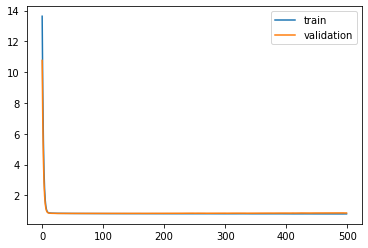

Time to train LSTM:  356.8368797302246
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 8s - loss: 13.6884 - pdc_loss: 0.6905 - event_loss: 0.6428 - val_loss: 10.7949 - val_pdc_loss: 0.6499 - val_event_loss: 0.5262

Epoch 00001: val_loss improved from inf to 10.79492, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 8.8170 - pdc_loss: 0.6307 - event_loss: 0.4520 - val_loss: 6.8782 - val_pdc_loss: 0.6110 - val_event_loss: 0.3839

Epoch 00002: val_loss improved from 10.79492 to 6.87824, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 5.6049 - pdc_loss: 0.5986 - event_loss: 0.3449 - val_loss: 4.3957 - val_pdc_loss: 0.5881 - val_event_loss: 0.3270

Epoch 00003: val_loss improved from 6.87824 to 4.39568, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 3.6185 - pdc_loss: 0.5782 - event_loss: 0.3155 - val_loss: 2.8927 - val_pdc_loss: 0.5749 - val_event_loss: 0.3138

Epoch 00004: val_loss improved from 4.39568 to 2.89269, savi


Epoch 00035: val_loss did not improve from 0.83971
Epoch 36/500
 - 1s - loss: 0.8277 - pdc_loss: 0.5191 - event_loss: 0.2957 - val_loss: 0.8396 - val_pdc_loss: 0.5248 - val_event_loss: 0.3020

Epoch 00036: val_loss improved from 0.83971 to 0.83956, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 0.8271 - pdc_loss: 0.5188 - event_loss: 0.2956 - val_loss: 0.8394 - val_pdc_loss: 0.5245 - val_event_loss: 0.3023

Epoch 00037: val_loss improved from 0.83956 to 0.83942, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 0.8269 - pdc_loss: 0.5186 - event_loss: 0.2956 - val_loss: 0.8393 - val_pdc_loss: 0.5247 - val_event_loss: 0.3020

Epoch 00038: val_loss improved from 0.83942 to 0.83927, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 0.8267 - pdc_loss: 0.5184 - event_loss: 0.2956 - val_loss: 0.8390 - val_pdc_loss: 0.5243 - val_event_loss: 0.3022

Epoch 00039: val_loss improved from 0.83927 to 0.83903, saving model to Event_val_weights2.h

 - 1s - loss: 0.8197 - pdc_loss: 0.5132 - event_loss: 0.2936 - val_loss: 0.8410 - val_pdc_loss: 0.5247 - val_event_loss: 0.3032

Epoch 00076: val_loss did not improve from 0.83800
Epoch 77/500
 - 1s - loss: 0.8198 - pdc_loss: 0.5131 - event_loss: 0.2936 - val_loss: 0.8398 - val_pdc_loss: 0.5238 - val_event_loss: 0.3030

Epoch 00077: val_loss did not improve from 0.83800
Epoch 78/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5130 - event_loss: 0.2935 - val_loss: 0.8404 - val_pdc_loss: 0.5242 - val_event_loss: 0.3031

Epoch 00078: val_loss did not improve from 0.83800
Epoch 79/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5129 - event_loss: 0.2936 - val_loss: 0.8402 - val_pdc_loss: 0.5244 - val_event_loss: 0.3028

Epoch 00079: val_loss did not improve from 0.83800
Epoch 80/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5127 - event_loss: 0.2933 - val_loss: 0.8409 - val_pdc_loss: 0.5245 - val_event_loss: 0.3032

Epoch 00080: val_loss did not improve from 0.83800
Epoch 81/500
 - 1s - loss: 0.8193 - pdc_loss: 0.


Epoch 00118: val_loss did not improve from 0.83800
Epoch 119/500
 - 1s - loss: 0.8153 - pdc_loss: 0.5087 - event_loss: 0.2916 - val_loss: 0.8459 - val_pdc_loss: 0.5258 - val_event_loss: 0.3053

Epoch 00119: val_loss did not improve from 0.83800
Epoch 120/500
 - 1s - loss: 0.8151 - pdc_loss: 0.5086 - event_loss: 0.2915 - val_loss: 0.8456 - val_pdc_loss: 0.5259 - val_event_loss: 0.3048

Epoch 00120: val_loss did not improve from 0.83800
Epoch 121/500
 - 1s - loss: 0.8151 - pdc_loss: 0.5087 - event_loss: 0.2916 - val_loss: 0.8446 - val_pdc_loss: 0.5256 - val_event_loss: 0.3042

Epoch 00121: val_loss did not improve from 0.83800
Epoch 122/500
 - 1s - loss: 0.8149 - pdc_loss: 0.5087 - event_loss: 0.2914 - val_loss: 0.8458 - val_pdc_loss: 0.5265 - val_event_loss: 0.3044

Epoch 00122: val_loss did not improve from 0.83800
Epoch 123/500
 - 1s - loss: 0.8144 - pdc_loss: 0.5085 - event_loss: 0.2910 - val_loss: 0.8464 - val_pdc_loss: 0.5268 - val_event_loss: 0.3046

Epoch 00123: val_loss did not

 - 1s - loss: 0.8113 - pdc_loss: 0.5054 - event_loss: 0.2896 - val_loss: 0.8509 - val_pdc_loss: 0.5281 - val_event_loss: 0.3065

Epoch 00161: val_loss did not improve from 0.83800
Epoch 162/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5053 - event_loss: 0.2899 - val_loss: 0.8514 - val_pdc_loss: 0.5285 - val_event_loss: 0.3063

Epoch 00162: val_loss did not improve from 0.83800
Epoch 163/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5053 - event_loss: 0.2896 - val_loss: 0.8515 - val_pdc_loss: 0.5284 - val_event_loss: 0.3066

Epoch 00163: val_loss did not improve from 0.83800
Epoch 164/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5053 - event_loss: 0.2898 - val_loss: 0.8504 - val_pdc_loss: 0.5273 - val_event_loss: 0.3067

Epoch 00164: val_loss did not improve from 0.83800
Epoch 165/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5052 - event_loss: 0.2894 - val_loss: 0.8501 - val_pdc_loss: 0.5274 - val_event_loss: 0.3063

Epoch 00165: val_loss did not improve from 0.83800
Epoch 166/500
 - 1s - loss: 0.8109 - pdc_los


Epoch 00203: val_loss did not improve from 0.83800
Epoch 204/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5026 - event_loss: 0.2877 - val_loss: 0.8577 - val_pdc_loss: 0.5318 - val_event_loss: 0.3086

Epoch 00204: val_loss did not improve from 0.83800
Epoch 205/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5023 - event_loss: 0.2879 - val_loss: 0.8563 - val_pdc_loss: 0.5311 - val_event_loss: 0.3079

Epoch 00205: val_loss did not improve from 0.83800
Epoch 206/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5030 - event_loss: 0.2878 - val_loss: 0.8568 - val_pdc_loss: 0.5312 - val_event_loss: 0.3081

Epoch 00206: val_loss did not improve from 0.83800
Epoch 207/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5027 - event_loss: 0.2881 - val_loss: 0.8572 - val_pdc_loss: 0.5317 - val_event_loss: 0.3080

Epoch 00207: val_loss did not improve from 0.83800
Epoch 208/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5028 - event_loss: 0.2880 - val_loss: 0.8566 - val_pdc_loss: 0.5313 - val_event_loss: 0.3079

Epoch 00208: val_loss did not

 - 1s - loss: 0.8074 - pdc_loss: 0.5012 - event_loss: 0.2879 - val_loss: 0.8572 - val_pdc_loss: 0.5313 - val_event_loss: 0.3077

Epoch 00246: val_loss did not improve from 0.83800
Epoch 247/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5004 - event_loss: 0.2876 - val_loss: 0.8583 - val_pdc_loss: 0.5323 - val_event_loss: 0.3076

Epoch 00247: val_loss did not improve from 0.83800
Epoch 248/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5006 - event_loss: 0.2869 - val_loss: 0.8573 - val_pdc_loss: 0.5316 - val_event_loss: 0.3076

Epoch 00248: val_loss did not improve from 0.83800
Epoch 249/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5008 - event_loss: 0.2871 - val_loss: 0.8549 - val_pdc_loss: 0.5301 - val_event_loss: 0.3066

Epoch 00249: val_loss did not improve from 0.83800
Epoch 250/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5008 - event_loss: 0.2865 - val_loss: 0.8579 - val_pdc_loss: 0.5318 - val_event_loss: 0.3079

Epoch 00250: val_loss did not improve from 0.83800
Epoch 251/500
 - 1s - loss: 0.8052 - pdc_los


Epoch 00288: val_loss did not improve from 0.83800
Epoch 289/500
 - 1s - loss: 0.8029 - pdc_loss: 0.4988 - event_loss: 0.2853 - val_loss: 0.8585 - val_pdc_loss: 0.5324 - val_event_loss: 0.3073

Epoch 00289: val_loss did not improve from 0.83800
Epoch 290/500
 - 1s - loss: 0.8027 - pdc_loss: 0.4984 - event_loss: 0.2855 - val_loss: 0.8588 - val_pdc_loss: 0.5329 - val_event_loss: 0.3070

Epoch 00290: val_loss did not improve from 0.83800
Epoch 291/500
 - 1s - loss: 0.8027 - pdc_loss: 0.4985 - event_loss: 0.2853 - val_loss: 0.8595 - val_pdc_loss: 0.5333 - val_event_loss: 0.3071

Epoch 00291: val_loss did not improve from 0.83800
Epoch 292/500
 - 1s - loss: 0.8026 - pdc_loss: 0.4985 - event_loss: 0.2852 - val_loss: 0.8592 - val_pdc_loss: 0.5339 - val_event_loss: 0.3065

Epoch 00292: val_loss did not improve from 0.83800
Epoch 293/500
 - 1s - loss: 0.8032 - pdc_loss: 0.4992 - event_loss: 0.2852 - val_loss: 0.8606 - val_pdc_loss: 0.5332 - val_event_loss: 0.3086

Epoch 00293: val_loss did not

 - 1s - loss: 0.8035 - pdc_loss: 0.4982 - event_loss: 0.2848 - val_loss: 0.8649 - val_pdc_loss: 0.5361 - val_event_loss: 0.3084

Epoch 00331: val_loss did not improve from 0.83800
Epoch 332/500
 - 1s - loss: 0.8034 - pdc_loss: 0.4979 - event_loss: 0.2851 - val_loss: 0.8649 - val_pdc_loss: 0.5354 - val_event_loss: 0.3089

Epoch 00332: val_loss did not improve from 0.83800
Epoch 333/500
 - 1s - loss: 0.8025 - pdc_loss: 0.4971 - event_loss: 0.2849 - val_loss: 0.8624 - val_pdc_loss: 0.5341 - val_event_loss: 0.3078

Epoch 00333: val_loss did not improve from 0.83800
Epoch 334/500
 - 1s - loss: 0.8025 - pdc_loss: 0.4974 - event_loss: 0.2848 - val_loss: 0.8626 - val_pdc_loss: 0.5346 - val_event_loss: 0.3077

Epoch 00334: val_loss did not improve from 0.83800
Epoch 335/500
 - 1s - loss: 0.8038 - pdc_loss: 0.4982 - event_loss: 0.2853 - val_loss: 0.8652 - val_pdc_loss: 0.5364 - val_event_loss: 0.3086

Epoch 00335: val_loss did not improve from 0.83800
Epoch 336/500
 - 1s - loss: 0.8026 - pdc_los


Epoch 00373: val_loss did not improve from 0.83800
Epoch 374/500
 - 1s - loss: 0.8004 - pdc_loss: 0.4959 - event_loss: 0.2837 - val_loss: 0.8709 - val_pdc_loss: 0.5389 - val_event_loss: 0.3111

Epoch 00374: val_loss did not improve from 0.83800
Epoch 375/500
 - 1s - loss: 0.7998 - pdc_loss: 0.4952 - event_loss: 0.2837 - val_loss: 0.8674 - val_pdc_loss: 0.5373 - val_event_loss: 0.3092

Epoch 00375: val_loss did not improve from 0.83800
Epoch 376/500
 - 1s - loss: 0.8000 - pdc_loss: 0.4951 - event_loss: 0.2839 - val_loss: 0.8665 - val_pdc_loss: 0.5366 - val_event_loss: 0.3089

Epoch 00376: val_loss did not improve from 0.83800
Epoch 377/500
 - 1s - loss: 0.7999 - pdc_loss: 0.4952 - event_loss: 0.2838 - val_loss: 0.8682 - val_pdc_loss: 0.5376 - val_event_loss: 0.3097

Epoch 00377: val_loss did not improve from 0.83800
Epoch 378/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4956 - event_loss: 0.2840 - val_loss: 0.8684 - val_pdc_loss: 0.5379 - val_event_loss: 0.3095

Epoch 00378: val_loss did not

 - 1s - loss: 0.8005 - pdc_loss: 0.4945 - event_loss: 0.2843 - val_loss: 0.8700 - val_pdc_loss: 0.5382 - val_event_loss: 0.3099

Epoch 00416: val_loss did not improve from 0.83800
Epoch 417/500
 - 1s - loss: 0.7999 - pdc_loss: 0.4941 - event_loss: 0.2842 - val_loss: 0.8663 - val_pdc_loss: 0.5348 - val_event_loss: 0.3099

Epoch 00417: val_loss did not improve from 0.83800
Epoch 418/500
 - 1s - loss: 0.8005 - pdc_loss: 0.4947 - event_loss: 0.2841 - val_loss: 0.8706 - val_pdc_loss: 0.5387 - val_event_loss: 0.3100

Epoch 00418: val_loss did not improve from 0.83800
Epoch 419/500
 - 1s - loss: 0.8009 - pdc_loss: 0.4948 - event_loss: 0.2844 - val_loss: 0.8665 - val_pdc_loss: 0.5354 - val_event_loss: 0.3095

Epoch 00419: val_loss did not improve from 0.83800
Epoch 420/500
 - 1s - loss: 0.8000 - pdc_loss: 0.4941 - event_loss: 0.2844 - val_loss: 0.8689 - val_pdc_loss: 0.5383 - val_event_loss: 0.3093

Epoch 00420: val_loss did not improve from 0.83800
Epoch 421/500
 - 1s - loss: 0.7992 - pdc_los


Epoch 00458: val_loss did not improve from 0.83800
Epoch 459/500
 - 1s - loss: 0.7975 - pdc_loss: 0.4931 - event_loss: 0.2826 - val_loss: 0.8696 - val_pdc_loss: 0.5375 - val_event_loss: 0.3103

Epoch 00459: val_loss did not improve from 0.83800
Epoch 460/500
 - 1s - loss: 0.7966 - pdc_loss: 0.4925 - event_loss: 0.2822 - val_loss: 0.8717 - val_pdc_loss: 0.5396 - val_event_loss: 0.3103

Epoch 00460: val_loss did not improve from 0.83800
Epoch 461/500
 - 1s - loss: 0.7962 - pdc_loss: 0.4919 - event_loss: 0.2826 - val_loss: 0.8701 - val_pdc_loss: 0.5383 - val_event_loss: 0.3102

Epoch 00461: val_loss did not improve from 0.83800
Epoch 462/500
 - 1s - loss: 0.7960 - pdc_loss: 0.4920 - event_loss: 0.2823 - val_loss: 0.8699 - val_pdc_loss: 0.5388 - val_event_loss: 0.3092

Epoch 00462: val_loss did not improve from 0.83800
Epoch 463/500
 - 1s - loss: 0.7968 - pdc_loss: 0.4919 - event_loss: 0.2829 - val_loss: 0.8720 - val_pdc_loss: 0.5396 - val_event_loss: 0.3103

Epoch 00463: val_loss did not

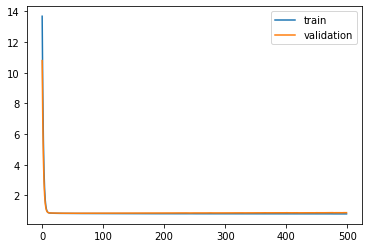

Time to train LSTM:  365.1124608516693
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 8s - loss: 13.6111 - pdc_loss: 0.6965 - event_loss: 0.6356 - val_loss: 10.7313 - val_pdc_loss: 0.6402 - val_event_loss: 0.5362

Epoch 00001: val_loss improved from inf to 10.73127, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 8.7593 - pdc_loss: 0.6126 - event_loss: 0.4675 - val_loss: 6.8404 - val_pdc_loss: 0.6024 - val_event_loss: 0.3998

Epoch 00002: val_loss improved from 10.73127 to 6.84037, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 5.5615 - pdc_loss: 0.5828 - event_loss: 0.3549 - val_loss: 4.3644 - val_pdc_loss: 0.5861 - val_event_loss: 0.3285

Epoch 00003: val_loss improved from 6.84037 to 4.36440, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 3.5821 - pdc_loss: 0.5680 - event_loss: 0.3160 - val_loss: 2.8716 - val_pdc_loss: 0.5762 - val_event_loss: 0.3129

Epoch 00004: val_loss improved from 4.36440 to 2.87157, savi

 - 1s - loss: 0.8276 - pdc_loss: 0.5186 - event_loss: 0.2966 - val_loss: 0.8455 - val_pdc_loss: 0.5330 - val_event_loss: 0.3002

Epoch 00036: val_loss improved from 0.84580 to 0.84551, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 0.8271 - pdc_loss: 0.5183 - event_loss: 0.2965 - val_loss: 0.8459 - val_pdc_loss: 0.5335 - val_event_loss: 0.3002

Epoch 00037: val_loss did not improve from 0.84551
Epoch 38/500
 - 1s - loss: 0.8269 - pdc_loss: 0.5181 - event_loss: 0.2965 - val_loss: 0.8456 - val_pdc_loss: 0.5331 - val_event_loss: 0.3002

Epoch 00038: val_loss did not improve from 0.84551
Epoch 39/500
 - 1s - loss: 0.8265 - pdc_loss: 0.5179 - event_loss: 0.2963 - val_loss: 0.8459 - val_pdc_loss: 0.5334 - val_event_loss: 0.3003

Epoch 00039: val_loss did not improve from 0.84551
Epoch 40/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5176 - event_loss: 0.2962 - val_loss: 0.8457 - val_pdc_loss: 0.5335 - val_event_loss: 0.3001

Epoch 00040: val_loss did not improve from 0.84551
Epo


Epoch 00077: val_loss did not improve from 0.84482
Epoch 78/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5124 - event_loss: 0.2940 - val_loss: 0.8455 - val_pdc_loss: 0.5327 - val_event_loss: 0.3011

Epoch 00078: val_loss did not improve from 0.84482
Epoch 79/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5124 - event_loss: 0.2939 - val_loss: 0.8454 - val_pdc_loss: 0.5327 - val_event_loss: 0.3010

Epoch 00079: val_loss did not improve from 0.84482
Epoch 80/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5124 - event_loss: 0.2939 - val_loss: 0.8455 - val_pdc_loss: 0.5326 - val_event_loss: 0.3011

Epoch 00080: val_loss did not improve from 0.84482
Epoch 81/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5122 - event_loss: 0.2938 - val_loss: 0.8453 - val_pdc_loss: 0.5325 - val_event_loss: 0.3010

Epoch 00081: val_loss did not improve from 0.84482
Epoch 82/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5122 - event_loss: 0.2938 - val_loss: 0.8456 - val_pdc_loss: 0.5327 - val_event_loss: 0.3011

Epoch 00082: val_loss did not impr


Epoch 00120: val_loss did not improve from 0.84482
Epoch 121/500
 - 1s - loss: 0.8145 - pdc_loss: 0.5094 - event_loss: 0.2923 - val_loss: 0.8461 - val_pdc_loss: 0.5317 - val_event_loss: 0.3016

Epoch 00121: val_loss did not improve from 0.84482
Epoch 122/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5091 - event_loss: 0.2922 - val_loss: 0.8464 - val_pdc_loss: 0.5314 - val_event_loss: 0.3022

Epoch 00122: val_loss did not improve from 0.84482
Epoch 123/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5089 - event_loss: 0.2922 - val_loss: 0.8463 - val_pdc_loss: 0.5316 - val_event_loss: 0.3019

Epoch 00123: val_loss did not improve from 0.84482
Epoch 124/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5088 - event_loss: 0.2921 - val_loss: 0.8466 - val_pdc_loss: 0.5317 - val_event_loss: 0.3022

Epoch 00124: val_loss did not improve from 0.84482
Epoch 125/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5087 - event_loss: 0.2921 - val_loss: 0.8463 - val_pdc_loss: 0.5315 - val_event_loss: 0.3020

Epoch 00125: val_loss did not

 - 1s - loss: 0.8120 - pdc_loss: 0.5071 - event_loss: 0.2903 - val_loss: 0.8528 - val_pdc_loss: 0.5330 - val_event_loss: 0.3051

Epoch 00163: val_loss did not improve from 0.84482
Epoch 164/500
 - 1s - loss: 0.8124 - pdc_loss: 0.5072 - event_loss: 0.2904 - val_loss: 0.8522 - val_pdc_loss: 0.5327 - val_event_loss: 0.3048

Epoch 00164: val_loss did not improve from 0.84482
Epoch 165/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5068 - event_loss: 0.2903 - val_loss: 0.8531 - val_pdc_loss: 0.5330 - val_event_loss: 0.3052

Epoch 00165: val_loss did not improve from 0.84482
Epoch 166/500
 - 1s - loss: 0.8118 - pdc_loss: 0.5065 - event_loss: 0.2904 - val_loss: 0.8525 - val_pdc_loss: 0.5329 - val_event_loss: 0.3047

Epoch 00166: val_loss did not improve from 0.84482
Epoch 167/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5061 - event_loss: 0.2902 - val_loss: 0.8523 - val_pdc_loss: 0.5327 - val_event_loss: 0.3046

Epoch 00167: val_loss did not improve from 0.84482
Epoch 168/500
 - 1s - loss: 0.8113 - pdc_los


Epoch 00205: val_loss did not improve from 0.84482
Epoch 206/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5045 - event_loss: 0.2886 - val_loss: 0.8557 - val_pdc_loss: 0.5342 - val_event_loss: 0.3052

Epoch 00206: val_loss did not improve from 0.84482
Epoch 207/500
 - 1s - loss: 0.8091 - pdc_loss: 0.5042 - event_loss: 0.2885 - val_loss: 0.8554 - val_pdc_loss: 0.5335 - val_event_loss: 0.3056

Epoch 00207: val_loss did not improve from 0.84482
Epoch 208/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5040 - event_loss: 0.2883 - val_loss: 0.8551 - val_pdc_loss: 0.5334 - val_event_loss: 0.3056

Epoch 00208: val_loss did not improve from 0.84482
Epoch 209/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5039 - event_loss: 0.2880 - val_loss: 0.8562 - val_pdc_loss: 0.5339 - val_event_loss: 0.3060

Epoch 00209: val_loss did not improve from 0.84482
Epoch 210/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5038 - event_loss: 0.2882 - val_loss: 0.8562 - val_pdc_loss: 0.5329 - val_event_loss: 0.3068

Epoch 00210: val_loss did not

 - 1s - loss: 0.8064 - pdc_loss: 0.5013 - event_loss: 0.2871 - val_loss: 0.8611 - val_pdc_loss: 0.5357 - val_event_loss: 0.3075

Epoch 00248: val_loss did not improve from 0.84482
Epoch 249/500
 - 1s - loss: 0.8068 - pdc_loss: 0.5016 - event_loss: 0.2872 - val_loss: 0.8600 - val_pdc_loss: 0.5354 - val_event_loss: 0.3067

Epoch 00249: val_loss did not improve from 0.84482
Epoch 250/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5013 - event_loss: 0.2871 - val_loss: 0.8618 - val_pdc_loss: 0.5369 - val_event_loss: 0.3069

Epoch 00250: val_loss did not improve from 0.84482
Epoch 251/500
 - 1s - loss: 0.8062 - pdc_loss: 0.5013 - event_loss: 0.2870 - val_loss: 0.8610 - val_pdc_loss: 0.5370 - val_event_loss: 0.3061

Epoch 00251: val_loss did not improve from 0.84482
Epoch 252/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5013 - event_loss: 0.2870 - val_loss: 0.8613 - val_pdc_loss: 0.5369 - val_event_loss: 0.3063

Epoch 00252: val_loss did not improve from 0.84482
Epoch 253/500
 - 1s - loss: 0.8063 - pdc_los


Epoch 00290: val_loss did not improve from 0.84482
Epoch 291/500
 - 1s - loss: 0.8025 - pdc_loss: 0.4981 - event_loss: 0.2855 - val_loss: 0.8664 - val_pdc_loss: 0.5380 - val_event_loss: 0.3094

Epoch 00291: val_loss did not improve from 0.84482
Epoch 292/500
 - 1s - loss: 0.8023 - pdc_loss: 0.4979 - event_loss: 0.2853 - val_loss: 0.8666 - val_pdc_loss: 0.5386 - val_event_loss: 0.3089

Epoch 00292: val_loss did not improve from 0.84482
Epoch 293/500
 - 1s - loss: 0.8029 - pdc_loss: 0.4981 - event_loss: 0.2856 - val_loss: 0.8662 - val_pdc_loss: 0.5380 - val_event_loss: 0.3091

Epoch 00293: val_loss did not improve from 0.84482
Epoch 294/500
 - 1s - loss: 0.8031 - pdc_loss: 0.4983 - event_loss: 0.2855 - val_loss: 0.8666 - val_pdc_loss: 0.5379 - val_event_loss: 0.3096

Epoch 00294: val_loss did not improve from 0.84482
Epoch 295/500
 - 1s - loss: 0.8022 - pdc_loss: 0.4977 - event_loss: 0.2854 - val_loss: 0.8661 - val_pdc_loss: 0.5375 - val_event_loss: 0.3096

Epoch 00295: val_loss did not

 - 1s - loss: 0.8007 - pdc_loss: 0.4960 - event_loss: 0.2847 - val_loss: 0.8692 - val_pdc_loss: 0.5392 - val_event_loss: 0.3101

Epoch 00333: val_loss did not improve from 0.84482
Epoch 334/500
 - 1s - loss: 0.8006 - pdc_loss: 0.4960 - event_loss: 0.2845 - val_loss: 0.8695 - val_pdc_loss: 0.5387 - val_event_loss: 0.3107

Epoch 00334: val_loss did not improve from 0.84482
Epoch 335/500
 - 1s - loss: 0.8006 - pdc_loss: 0.4961 - event_loss: 0.2844 - val_loss: 0.8691 - val_pdc_loss: 0.5384 - val_event_loss: 0.3105

Epoch 00335: val_loss did not improve from 0.84482
Epoch 336/500
 - 1s - loss: 0.8013 - pdc_loss: 0.4969 - event_loss: 0.2841 - val_loss: 0.8689 - val_pdc_loss: 0.5389 - val_event_loss: 0.3098

Epoch 00336: val_loss did not improve from 0.84482
Epoch 337/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4963 - event_loss: 0.2840 - val_loss: 0.8691 - val_pdc_loss: 0.5387 - val_event_loss: 0.3099

Epoch 00337: val_loss did not improve from 0.84482
Epoch 338/500
 - 1s - loss: 0.8008 - pdc_los


Epoch 00375: val_loss did not improve from 0.84482
Epoch 376/500
 - 1s - loss: 0.8000 - pdc_loss: 0.4950 - event_loss: 0.2832 - val_loss: 0.8750 - val_pdc_loss: 0.5394 - val_event_loss: 0.3141

Epoch 00376: val_loss did not improve from 0.84482
Epoch 377/500
 - 1s - loss: 0.7995 - pdc_loss: 0.4948 - event_loss: 0.2831 - val_loss: 0.8747 - val_pdc_loss: 0.5403 - val_event_loss: 0.3130

Epoch 00377: val_loss did not improve from 0.84482
Epoch 378/500
 - 1s - loss: 0.7988 - pdc_loss: 0.4945 - event_loss: 0.2829 - val_loss: 0.8754 - val_pdc_loss: 0.5412 - val_event_loss: 0.3128

Epoch 00378: val_loss did not improve from 0.84482
Epoch 379/500
 - 1s - loss: 0.7999 - pdc_loss: 0.4952 - event_loss: 0.2833 - val_loss: 0.8759 - val_pdc_loss: 0.5415 - val_event_loss: 0.3130

Epoch 00379: val_loss did not improve from 0.84482
Epoch 380/500
 - 1s - loss: 0.7984 - pdc_loss: 0.4943 - event_loss: 0.2828 - val_loss: 0.8737 - val_pdc_loss: 0.5410 - val_event_loss: 0.3114

Epoch 00380: val_loss did not

 - 1s - loss: 0.8001 - pdc_loss: 0.4948 - event_loss: 0.2830 - val_loss: 0.8775 - val_pdc_loss: 0.5411 - val_event_loss: 0.3143

Epoch 00418: val_loss did not improve from 0.84482
Epoch 419/500
 - 1s - loss: 0.8004 - pdc_loss: 0.4953 - event_loss: 0.2829 - val_loss: 0.8749 - val_pdc_loss: 0.5402 - val_event_loss: 0.3124

Epoch 00419: val_loss did not improve from 0.84482
Epoch 420/500
 - 1s - loss: 0.8004 - pdc_loss: 0.4949 - event_loss: 0.2831 - val_loss: 0.8742 - val_pdc_loss: 0.5388 - val_event_loss: 0.3131

Epoch 00420: val_loss did not improve from 0.84482
Epoch 421/500
 - 1s - loss: 0.7986 - pdc_loss: 0.4935 - event_loss: 0.2829 - val_loss: 0.8735 - val_pdc_loss: 0.5387 - val_event_loss: 0.3128

Epoch 00421: val_loss did not improve from 0.84482
Epoch 422/500
 - 1s - loss: 0.7981 - pdc_loss: 0.4935 - event_loss: 0.2827 - val_loss: 0.8758 - val_pdc_loss: 0.5403 - val_event_loss: 0.3136

Epoch 00422: val_loss did not improve from 0.84482
Epoch 423/500
 - 1s - loss: 0.7973 - pdc_los


Epoch 00460: val_loss did not improve from 0.84482
Epoch 461/500
 - 1s - loss: 0.7943 - pdc_loss: 0.4912 - event_loss: 0.2806 - val_loss: 0.8754 - val_pdc_loss: 0.5394 - val_event_loss: 0.3136

Epoch 00461: val_loss did not improve from 0.84482
Epoch 462/500
 - 1s - loss: 0.7935 - pdc_loss: 0.4906 - event_loss: 0.2806 - val_loss: 0.8747 - val_pdc_loss: 0.5404 - val_event_loss: 0.3121

Epoch 00462: val_loss did not improve from 0.84482
Epoch 463/500
 - 1s - loss: 0.7944 - pdc_loss: 0.4912 - event_loss: 0.2809 - val_loss: 0.8784 - val_pdc_loss: 0.5420 - val_event_loss: 0.3140

Epoch 00463: val_loss did not improve from 0.84482
Epoch 464/500
 - 1s - loss: 0.7946 - pdc_loss: 0.4915 - event_loss: 0.2806 - val_loss: 0.8766 - val_pdc_loss: 0.5418 - val_event_loss: 0.3121

Epoch 00464: val_loss did not improve from 0.84482
Epoch 465/500
 - 1s - loss: 0.7950 - pdc_loss: 0.4917 - event_loss: 0.2806 - val_loss: 0.8786 - val_pdc_loss: 0.5416 - val_event_loss: 0.3144

Epoch 00465: val_loss did not

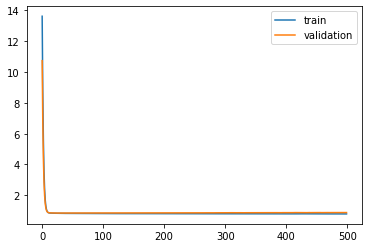

Time to train LSTM:  362.47232484817505


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f077b767a90>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 8s - loss: 13.7381 - pdc_loss: 0.7181 - event_loss: 0.6234 - val_loss: 10.8508 - val_pdc_loss: 0.6596 - val_event_loss: 0.5262

Epoch 00001: val_loss improved from inf to 10.85078, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 8.8665 - pdc_loss: 0.6269 - event_loss: 0.4611 - val_loss: 6.9340 - val_pdc_loss: 0.6136 - val_event_loss: 0.3960

Epoch 00002: val_loss improved from 10.85078 to 6.93404, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 5.6451 - pdc_loss: 0.5925 - event_loss: 0.3542 - val_loss: 4.4318 - val_pdc_loss: 0.5906 - val_event_loss: 0.3294

Epoch 00003: val_loss improved from 6.93404 to 4.43180, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 3.6386 - pdc_loss: 0.5737 - event_loss: 0.3146 - val_loss: 2.9161 - val_pdc_loss: 0.5769 - val_event_loss: 0.3147

Epoch 00004: val_loss improved from 4.43180 to 2.91611, saving model to Event_val_weights4.hdf5
Epo


Epoch 00035: val_loss improved from 0.85010 to 0.85004, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 0.8243 - pdc_loss: 0.5164 - event_loss: 0.2957 - val_loss: 0.8498 - val_pdc_loss: 0.5355 - val_event_loss: 0.3022

Epoch 00036: val_loss improved from 0.85004 to 0.84979, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.8239 - pdc_loss: 0.5161 - event_loss: 0.2956 - val_loss: 0.8498 - val_pdc_loss: 0.5355 - val_event_loss: 0.3022

Epoch 00037: val_loss improved from 0.84979 to 0.84975, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.8236 - pdc_loss: 0.5159 - event_loss: 0.2955 - val_loss: 0.8497 - val_pdc_loss: 0.5354 - val_event_loss: 0.3023

Epoch 00038: val_loss improved from 0.84975 to 0.84965, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8233 - pdc_loss: 0.5157 - event_loss: 0.2955 - val_loss: 0.8494 - val_pdc_loss: 0.5353 - val_event_loss: 0.3022

Epoch 00039: val_loss improved from 0.84965 to 


Epoch 00075: val_loss did not improve from 0.84842
Epoch 76/500
 - 1s - loss: 0.8174 - pdc_loss: 0.5112 - event_loss: 0.2936 - val_loss: 0.8508 - val_pdc_loss: 0.5349 - val_event_loss: 0.3034

Epoch 00076: val_loss did not improve from 0.84842
Epoch 77/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5111 - event_loss: 0.2936 - val_loss: 0.8513 - val_pdc_loss: 0.5353 - val_event_loss: 0.3035

Epoch 00077: val_loss did not improve from 0.84842
Epoch 78/500
 - 1s - loss: 0.8172 - pdc_loss: 0.5112 - event_loss: 0.2935 - val_loss: 0.8511 - val_pdc_loss: 0.5350 - val_event_loss: 0.3036

Epoch 00078: val_loss did not improve from 0.84842
Epoch 79/500
 - 1s - loss: 0.8169 - pdc_loss: 0.5108 - event_loss: 0.2935 - val_loss: 0.8511 - val_pdc_loss: 0.5351 - val_event_loss: 0.3036

Epoch 00079: val_loss did not improve from 0.84842
Epoch 80/500
 - 1s - loss: 0.8167 - pdc_loss: 0.5108 - event_loss: 0.2933 - val_loss: 0.8513 - val_pdc_loss: 0.5351 - val_event_loss: 0.3036

Epoch 00080: val_loss did not impr


Epoch 00118: val_loss did not improve from 0.84842
Epoch 119/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5082 - event_loss: 0.2917 - val_loss: 0.8557 - val_pdc_loss: 0.5360 - val_event_loss: 0.3061

Epoch 00119: val_loss did not improve from 0.84842
Epoch 120/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5081 - event_loss: 0.2918 - val_loss: 0.8547 - val_pdc_loss: 0.5351 - val_event_loss: 0.3059

Epoch 00120: val_loss did not improve from 0.84842
Epoch 121/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5079 - event_loss: 0.2917 - val_loss: 0.8547 - val_pdc_loss: 0.5352 - val_event_loss: 0.3058

Epoch 00121: val_loss did not improve from 0.84842
Epoch 122/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5077 - event_loss: 0.2917 - val_loss: 0.8549 - val_pdc_loss: 0.5352 - val_event_loss: 0.3061

Epoch 00122: val_loss did not improve from 0.84842
Epoch 123/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5076 - event_loss: 0.2917 - val_loss: 0.8551 - val_pdc_loss: 0.5352 - val_event_loss: 0.3063

Epoch 00123: val_loss did not

 - 1s - loss: 0.8106 - pdc_loss: 0.5059 - event_loss: 0.2899 - val_loss: 0.8591 - val_pdc_loss: 0.5380 - val_event_loss: 0.3064

Epoch 00161: val_loss did not improve from 0.84842
Epoch 162/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5061 - event_loss: 0.2898 - val_loss: 0.8584 - val_pdc_loss: 0.5366 - val_event_loss: 0.3069

Epoch 00162: val_loss did not improve from 0.84842
Epoch 163/500
 - 1s - loss: 0.8107 - pdc_loss: 0.5060 - event_loss: 0.2898 - val_loss: 0.8599 - val_pdc_loss: 0.5377 - val_event_loss: 0.3073

Epoch 00163: val_loss did not improve from 0.84842
Epoch 164/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5059 - event_loss: 0.2901 - val_loss: 0.8594 - val_pdc_loss: 0.5369 - val_event_loss: 0.3074

Epoch 00164: val_loss did not improve from 0.84842
Epoch 165/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5058 - event_loss: 0.2901 - val_loss: 0.8607 - val_pdc_loss: 0.5383 - val_event_loss: 0.3074

Epoch 00165: val_loss did not improve from 0.84842
Epoch 166/500
 - 1s - loss: 0.8113 - pdc_los


Epoch 00203: val_loss did not improve from 0.84842
Epoch 204/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5043 - event_loss: 0.2894 - val_loss: 0.8599 - val_pdc_loss: 0.5376 - val_event_loss: 0.3064

Epoch 00204: val_loss did not improve from 0.84842
Epoch 205/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5038 - event_loss: 0.2892 - val_loss: 0.8603 - val_pdc_loss: 0.5388 - val_event_loss: 0.3056

Epoch 00205: val_loss did not improve from 0.84842
Epoch 206/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5038 - event_loss: 0.2891 - val_loss: 0.8612 - val_pdc_loss: 0.5389 - val_event_loss: 0.3064

Epoch 00206: val_loss did not improve from 0.84842
Epoch 207/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5040 - event_loss: 0.2890 - val_loss: 0.8611 - val_pdc_loss: 0.5388 - val_event_loss: 0.3065

Epoch 00207: val_loss did not improve from 0.84842
Epoch 208/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5038 - event_loss: 0.2892 - val_loss: 0.8605 - val_pdc_loss: 0.5387 - val_event_loss: 0.3060

Epoch 00208: val_loss did not

 - 1s - loss: 0.8061 - pdc_loss: 0.5015 - event_loss: 0.2880 - val_loss: 0.8634 - val_pdc_loss: 0.5378 - val_event_loss: 0.3089

Epoch 00246: val_loss did not improve from 0.84842
Epoch 247/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5012 - event_loss: 0.2877 - val_loss: 0.8634 - val_pdc_loss: 0.5384 - val_event_loss: 0.3084

Epoch 00247: val_loss did not improve from 0.84842
Epoch 248/500
 - 1s - loss: 0.8053 - pdc_loss: 0.5013 - event_loss: 0.2874 - val_loss: 0.8634 - val_pdc_loss: 0.5377 - val_event_loss: 0.3093

Epoch 00248: val_loss did not improve from 0.84842
Epoch 249/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5015 - event_loss: 0.2879 - val_loss: 0.8631 - val_pdc_loss: 0.5377 - val_event_loss: 0.3087

Epoch 00249: val_loss did not improve from 0.84842
Epoch 250/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5015 - event_loss: 0.2875 - val_loss: 0.8663 - val_pdc_loss: 0.5396 - val_event_loss: 0.3099

Epoch 00250: val_loss did not improve from 0.84842
Epoch 251/500
 - 1s - loss: 0.8059 - pdc_los


Epoch 00288: val_loss did not improve from 0.84842
Epoch 289/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5004 - event_loss: 0.2870 - val_loss: 0.8669 - val_pdc_loss: 0.5389 - val_event_loss: 0.3102

Epoch 00289: val_loss did not improve from 0.84842
Epoch 290/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5001 - event_loss: 0.2871 - val_loss: 0.8672 - val_pdc_loss: 0.5393 - val_event_loss: 0.3103

Epoch 00290: val_loss did not improve from 0.84842
Epoch 291/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5000 - event_loss: 0.2867 - val_loss: 0.8675 - val_pdc_loss: 0.5389 - val_event_loss: 0.3105

Epoch 00291: val_loss did not improve from 0.84842
Epoch 292/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5000 - event_loss: 0.2864 - val_loss: 0.8680 - val_pdc_loss: 0.5393 - val_event_loss: 0.3109

Epoch 00292: val_loss did not improve from 0.84842
Epoch 293/500
 - 1s - loss: 0.8030 - pdc_loss: 0.4993 - event_loss: 0.2860 - val_loss: 0.8659 - val_pdc_loss: 0.5376 - val_event_loss: 0.3107

Epoch 00293: val_loss did not

 - 1s - loss: 0.8054 - pdc_loss: 0.5000 - event_loss: 0.2867 - val_loss: 0.8697 - val_pdc_loss: 0.5399 - val_event_loss: 0.3111

Epoch 00331: val_loss did not improve from 0.84842
Epoch 332/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5001 - event_loss: 0.2870 - val_loss: 0.8667 - val_pdc_loss: 0.5374 - val_event_loss: 0.3103

Epoch 00332: val_loss did not improve from 0.84842
Epoch 333/500
 - 1s - loss: 0.8062 - pdc_loss: 0.5003 - event_loss: 0.2869 - val_loss: 0.8673 - val_pdc_loss: 0.5385 - val_event_loss: 0.3099

Epoch 00333: val_loss did not improve from 0.84842
Epoch 334/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5002 - event_loss: 0.2866 - val_loss: 0.8675 - val_pdc_loss: 0.5388 - val_event_loss: 0.3101

Epoch 00334: val_loss did not improve from 0.84842
Epoch 335/500
 - 1s - loss: 0.8041 - pdc_loss: 0.4993 - event_loss: 0.2864 - val_loss: 0.8659 - val_pdc_loss: 0.5382 - val_event_loss: 0.3093

Epoch 00335: val_loss did not improve from 0.84842
Epoch 336/500
 - 1s - loss: 0.8025 - pdc_los


Epoch 00373: val_loss did not improve from 0.84842
Epoch 374/500
 - 1s - loss: 0.8022 - pdc_loss: 0.4971 - event_loss: 0.2858 - val_loss: 0.8705 - val_pdc_loss: 0.5383 - val_event_loss: 0.3129

Epoch 00374: val_loss did not improve from 0.84842
Epoch 375/500
 - 1s - loss: 0.8017 - pdc_loss: 0.4966 - event_loss: 0.2858 - val_loss: 0.8683 - val_pdc_loss: 0.5379 - val_event_loss: 0.3115

Epoch 00375: val_loss did not improve from 0.84842
Epoch 376/500
 - 1s - loss: 0.8010 - pdc_loss: 0.4971 - event_loss: 0.2851 - val_loss: 0.8711 - val_pdc_loss: 0.5407 - val_event_loss: 0.3117

Epoch 00376: val_loss did not improve from 0.84842
Epoch 377/500
 - 1s - loss: 0.8015 - pdc_loss: 0.4975 - event_loss: 0.2850 - val_loss: 0.8698 - val_pdc_loss: 0.5391 - val_event_loss: 0.3114

Epoch 00377: val_loss did not improve from 0.84842
Epoch 378/500
 - 1s - loss: 0.8011 - pdc_loss: 0.4970 - event_loss: 0.2847 - val_loss: 0.8687 - val_pdc_loss: 0.5392 - val_event_loss: 0.3101

Epoch 00378: val_loss did not

 - 1s - loss: 0.7993 - pdc_loss: 0.4959 - event_loss: 0.2836 - val_loss: 0.8753 - val_pdc_loss: 0.5427 - val_event_loss: 0.3129

Epoch 00416: val_loss did not improve from 0.84842
Epoch 417/500
 - 1s - loss: 0.7993 - pdc_loss: 0.4959 - event_loss: 0.2837 - val_loss: 0.8725 - val_pdc_loss: 0.5414 - val_event_loss: 0.3116

Epoch 00417: val_loss did not improve from 0.84842
Epoch 418/500
 - 1s - loss: 0.7988 - pdc_loss: 0.4954 - event_loss: 0.2839 - val_loss: 0.8716 - val_pdc_loss: 0.5403 - val_event_loss: 0.3118

Epoch 00418: val_loss did not improve from 0.84842
Epoch 419/500
 - 1s - loss: 0.7990 - pdc_loss: 0.4953 - event_loss: 0.2840 - val_loss: 0.8735 - val_pdc_loss: 0.5416 - val_event_loss: 0.3120

Epoch 00419: val_loss did not improve from 0.84842
Epoch 420/500
 - 1s - loss: 0.7996 - pdc_loss: 0.4955 - event_loss: 0.2840 - val_loss: 0.8726 - val_pdc_loss: 0.5411 - val_event_loss: 0.3116

Epoch 00420: val_loss did not improve from 0.84842
Epoch 421/500
 - 1s - loss: 0.7997 - pdc_los


Epoch 00458: val_loss did not improve from 0.84842
Epoch 459/500
 - 1s - loss: 0.7982 - pdc_loss: 0.4947 - event_loss: 0.2826 - val_loss: 0.8778 - val_pdc_loss: 0.5434 - val_event_loss: 0.3135

Epoch 00459: val_loss did not improve from 0.84842
Epoch 460/500
 - 1s - loss: 0.7982 - pdc_loss: 0.4945 - event_loss: 0.2829 - val_loss: 0.8763 - val_pdc_loss: 0.5428 - val_event_loss: 0.3127

Epoch 00460: val_loss did not improve from 0.84842
Epoch 461/500
 - 1s - loss: 0.7976 - pdc_loss: 0.4945 - event_loss: 0.2823 - val_loss: 0.8773 - val_pdc_loss: 0.5434 - val_event_loss: 0.3133

Epoch 00461: val_loss did not improve from 0.84842
Epoch 462/500
 - 1s - loss: 0.7968 - pdc_loss: 0.4941 - event_loss: 0.2822 - val_loss: 0.8745 - val_pdc_loss: 0.5411 - val_event_loss: 0.3131

Epoch 00462: val_loss did not improve from 0.84842
Epoch 463/500
 - 1s - loss: 0.7962 - pdc_loss: 0.4937 - event_loss: 0.2822 - val_loss: 0.8762 - val_pdc_loss: 0.5424 - val_event_loss: 0.3135

Epoch 00463: val_loss did not

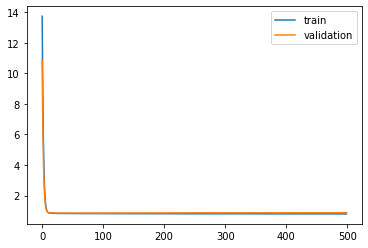

Time to train LSTM:  389.4378590583801
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 8s - loss: 13.6947 - pdc_loss: 0.7164 - event_loss: 0.6473 - val_loss: 10.8240 - val_pdc_loss: 0.6656 - val_event_loss: 0.5658

Epoch 00001: val_loss improved from inf to 10.82403, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 8.8529 - pdc_loss: 0.6382 - event_loss: 0.5014 - val_loss: 6.9138 - val_pdc_loss: 0.6181 - val_event_loss: 0.4268

Epoch 00002: val_loss improved from 10.82403 to 6.91380, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 5.6263 - pdc_loss: 0.6019 - event_loss: 0.3728 - val_loss: 4.3966 - val_pdc_loss: 0.5930 - val_event_loss: 0.3301

Epoch 00003: val_loss improved from 6.91380 to 4.39664, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 3.6167 - pdc_loss: 0.5802 - event_loss: 0.3174 - val_loss: 2.8854 - val_pdc_loss: 0.5737 - val_event_loss: 0.3111

Epoch 00004: val_loss improved from 4.39664 to 2.88540, savi


Epoch 00035: val_loss improved from 0.83005 to 0.82984, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.8270 - pdc_loss: 0.5183 - event_loss: 0.2968 - val_loss: 0.8297 - val_pdc_loss: 0.5187 - val_event_loss: 0.2989

Epoch 00036: val_loss improved from 0.82984 to 0.82966, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.8268 - pdc_loss: 0.5181 - event_loss: 0.2967 - val_loss: 0.8292 - val_pdc_loss: 0.5186 - val_event_loss: 0.2987

Epoch 00037: val_loss improved from 0.82966 to 0.82920, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.8265 - pdc_loss: 0.5179 - event_loss: 0.2967 - val_loss: 0.8295 - val_pdc_loss: 0.5186 - val_event_loss: 0.2989

Epoch 00038: val_loss did not improve from 0.82920
Epoch 39/500
 - 1s - loss: 0.8263 - pdc_loss: 0.5178 - event_loss: 0.2966 - val_loss: 0.8290 - val_pdc_loss: 0.5184 - val_event_loss: 0.2987

Epoch 00039: val_loss improved from 0.82920 to 0.82897, saving model to Event_val_weights5.h


Epoch 00075: val_loss did not improve from 0.82799
Epoch 76/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5132 - event_loss: 0.2947 - val_loss: 0.8291 - val_pdc_loss: 0.5181 - val_event_loss: 0.2990

Epoch 00076: val_loss did not improve from 0.82799
Epoch 77/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5132 - event_loss: 0.2947 - val_loss: 0.8296 - val_pdc_loss: 0.5185 - val_event_loss: 0.2990

Epoch 00077: val_loss did not improve from 0.82799
Epoch 78/500
 - 1s - loss: 0.8198 - pdc_loss: 0.5131 - event_loss: 0.2946 - val_loss: 0.8290 - val_pdc_loss: 0.5181 - val_event_loss: 0.2988

Epoch 00078: val_loss did not improve from 0.82799
Epoch 79/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5131 - event_loss: 0.2946 - val_loss: 0.8294 - val_pdc_loss: 0.5182 - val_event_loss: 0.2989

Epoch 00079: val_loss did not improve from 0.82799
Epoch 80/500
 - 1s - loss: 0.8199 - pdc_loss: 0.5131 - event_loss: 0.2945 - val_loss: 0.8291 - val_pdc_loss: 0.5179 - val_event_loss: 0.2989

Epoch 00080: val_loss did not impr


Epoch 00118: val_loss did not improve from 0.82799
Epoch 119/500
 - 1s - loss: 0.8163 - pdc_loss: 0.5103 - event_loss: 0.2930 - val_loss: 0.8324 - val_pdc_loss: 0.5194 - val_event_loss: 0.2998

Epoch 00119: val_loss did not improve from 0.82799
Epoch 120/500
 - 1s - loss: 0.8162 - pdc_loss: 0.5101 - event_loss: 0.2930 - val_loss: 0.8323 - val_pdc_loss: 0.5191 - val_event_loss: 0.3001

Epoch 00120: val_loss did not improve from 0.82799
Epoch 121/500
 - 1s - loss: 0.8159 - pdc_loss: 0.5100 - event_loss: 0.2930 - val_loss: 0.8330 - val_pdc_loss: 0.5198 - val_event_loss: 0.3002

Epoch 00121: val_loss did not improve from 0.82799
Epoch 122/500
 - 1s - loss: 0.8162 - pdc_loss: 0.5101 - event_loss: 0.2931 - val_loss: 0.8329 - val_pdc_loss: 0.5197 - val_event_loss: 0.3000

Epoch 00122: val_loss did not improve from 0.82799
Epoch 123/500
 - 1s - loss: 0.8161 - pdc_loss: 0.5099 - event_loss: 0.2931 - val_loss: 0.8328 - val_pdc_loss: 0.5193 - val_event_loss: 0.3003

Epoch 00123: val_loss did not

 - 1s - loss: 0.8142 - pdc_loss: 0.5083 - event_loss: 0.2920 - val_loss: 0.8341 - val_pdc_loss: 0.5201 - val_event_loss: 0.3002

Epoch 00161: val_loss did not improve from 0.82799
Epoch 162/500
 - 1s - loss: 0.8146 - pdc_loss: 0.5086 - event_loss: 0.2922 - val_loss: 0.8330 - val_pdc_loss: 0.5185 - val_event_loss: 0.3005

Epoch 00162: val_loss did not improve from 0.82799
Epoch 163/500
 - 1s - loss: 0.8155 - pdc_loss: 0.5092 - event_loss: 0.2924 - val_loss: 0.8349 - val_pdc_loss: 0.5196 - val_event_loss: 0.3014

Epoch 00163: val_loss did not improve from 0.82799
Epoch 164/500
 - 1s - loss: 0.8143 - pdc_loss: 0.5085 - event_loss: 0.2920 - val_loss: 0.8359 - val_pdc_loss: 0.5201 - val_event_loss: 0.3020

Epoch 00164: val_loss did not improve from 0.82799
Epoch 165/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5079 - event_loss: 0.2918 - val_loss: 0.8340 - val_pdc_loss: 0.5193 - val_event_loss: 0.3011

Epoch 00165: val_loss did not improve from 0.82799
Epoch 166/500
 - 1s - loss: 0.8129 - pdc_los


Epoch 00203: val_loss did not improve from 0.82799
Epoch 204/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5055 - event_loss: 0.2901 - val_loss: 0.8384 - val_pdc_loss: 0.5211 - val_event_loss: 0.3024

Epoch 00204: val_loss did not improve from 0.82799
Epoch 205/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5056 - event_loss: 0.2900 - val_loss: 0.8380 - val_pdc_loss: 0.5205 - val_event_loss: 0.3024

Epoch 00205: val_loss did not improve from 0.82799
Epoch 206/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5054 - event_loss: 0.2898 - val_loss: 0.8376 - val_pdc_loss: 0.5205 - val_event_loss: 0.3020

Epoch 00206: val_loss did not improve from 0.82799
Epoch 207/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5053 - event_loss: 0.2900 - val_loss: 0.8388 - val_pdc_loss: 0.5208 - val_event_loss: 0.3028

Epoch 00207: val_loss did not improve from 0.82799
Epoch 208/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5056 - event_loss: 0.2899 - val_loss: 0.8390 - val_pdc_loss: 0.5214 - val_event_loss: 0.3021

Epoch 00208: val_loss did not

 - 1s - loss: 0.8091 - pdc_loss: 0.5034 - event_loss: 0.2888 - val_loss: 0.8426 - val_pdc_loss: 0.5233 - val_event_loss: 0.3024

Epoch 00246: val_loss did not improve from 0.82799
Epoch 247/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5034 - event_loss: 0.2890 - val_loss: 0.8409 - val_pdc_loss: 0.5215 - val_event_loss: 0.3024

Epoch 00247: val_loss did not improve from 0.82799
Epoch 248/500
 - 1s - loss: 0.8085 - pdc_loss: 0.5032 - event_loss: 0.2885 - val_loss: 0.8426 - val_pdc_loss: 0.5230 - val_event_loss: 0.3028

Epoch 00248: val_loss did not improve from 0.82799
Epoch 249/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5030 - event_loss: 0.2885 - val_loss: 0.8407 - val_pdc_loss: 0.5222 - val_event_loss: 0.3019

Epoch 00249: val_loss did not improve from 0.82799
Epoch 250/500
 - 1s - loss: 0.8078 - pdc_loss: 0.5027 - event_loss: 0.2884 - val_loss: 0.8431 - val_pdc_loss: 0.5232 - val_event_loss: 0.3031

Epoch 00250: val_loss did not improve from 0.82799
Epoch 251/500
 - 1s - loss: 0.8083 - pdc_los


Epoch 00288: val_loss did not improve from 0.82799
Epoch 289/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5012 - event_loss: 0.2873 - val_loss: 0.8467 - val_pdc_loss: 0.5247 - val_event_loss: 0.3038

Epoch 00289: val_loss did not improve from 0.82799
Epoch 290/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5008 - event_loss: 0.2875 - val_loss: 0.8469 - val_pdc_loss: 0.5247 - val_event_loss: 0.3040

Epoch 00290: val_loss did not improve from 0.82799
Epoch 291/500
 - 1s - loss: 0.8054 - pdc_loss: 0.5002 - event_loss: 0.2870 - val_loss: 0.8464 - val_pdc_loss: 0.5247 - val_event_loss: 0.3037

Epoch 00291: val_loss did not improve from 0.82799
Epoch 292/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5001 - event_loss: 0.2875 - val_loss: 0.8477 - val_pdc_loss: 0.5246 - val_event_loss: 0.3049

Epoch 00292: val_loss did not improve from 0.82799
Epoch 293/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5003 - event_loss: 0.2874 - val_loss: 0.8479 - val_pdc_loss: 0.5248 - val_event_loss: 0.3050

Epoch 00293: val_loss did not

 - 1s - loss: 0.8041 - pdc_loss: 0.4990 - event_loss: 0.2855 - val_loss: 0.8518 - val_pdc_loss: 0.5267 - val_event_loss: 0.3055

Epoch 00331: val_loss did not improve from 0.82799
Epoch 332/500
 - 1s - loss: 0.8041 - pdc_loss: 0.4986 - event_loss: 0.2858 - val_loss: 0.8512 - val_pdc_loss: 0.5265 - val_event_loss: 0.3051

Epoch 00332: val_loss did not improve from 0.82799
Epoch 333/500
 - 1s - loss: 0.8039 - pdc_loss: 0.4986 - event_loss: 0.2858 - val_loss: 0.8504 - val_pdc_loss: 0.5258 - val_event_loss: 0.3051

Epoch 00333: val_loss did not improve from 0.82799
Epoch 334/500
 - 1s - loss: 0.8045 - pdc_loss: 0.4992 - event_loss: 0.2859 - val_loss: 0.8517 - val_pdc_loss: 0.5269 - val_event_loss: 0.3054

Epoch 00334: val_loss did not improve from 0.82799
Epoch 335/500
 - 1s - loss: 0.8052 - pdc_loss: 0.4994 - event_loss: 0.2862 - val_loss: 0.8513 - val_pdc_loss: 0.5262 - val_event_loss: 0.3055

Epoch 00335: val_loss did not improve from 0.82799
Epoch 336/500
 - 1s - loss: 0.8051 - pdc_los


Epoch 00373: val_loss did not improve from 0.82799
Epoch 374/500
 - 1s - loss: 0.8027 - pdc_loss: 0.4973 - event_loss: 0.2847 - val_loss: 0.8553 - val_pdc_loss: 0.5286 - val_event_loss: 0.3061

Epoch 00374: val_loss did not improve from 0.82799
Epoch 375/500
 - 1s - loss: 0.8036 - pdc_loss: 0.4979 - event_loss: 0.2851 - val_loss: 0.8556 - val_pdc_loss: 0.5283 - val_event_loss: 0.3067

Epoch 00375: val_loss did not improve from 0.82799
Epoch 376/500
 - 1s - loss: 0.8037 - pdc_loss: 0.4982 - event_loss: 0.2849 - val_loss: 0.8536 - val_pdc_loss: 0.5268 - val_event_loss: 0.3063

Epoch 00376: val_loss did not improve from 0.82799
Epoch 377/500
 - 1s - loss: 0.8040 - pdc_loss: 0.4985 - event_loss: 0.2850 - val_loss: 0.8559 - val_pdc_loss: 0.5294 - val_event_loss: 0.3062

Epoch 00377: val_loss did not improve from 0.82799
Epoch 378/500
 - 1s - loss: 0.8040 - pdc_loss: 0.4982 - event_loss: 0.2852 - val_loss: 0.8553 - val_pdc_loss: 0.5285 - val_event_loss: 0.3062

Epoch 00378: val_loss did not

 - 1s - loss: 0.7997 - pdc_loss: 0.4953 - event_loss: 0.2831 - val_loss: 0.8589 - val_pdc_loss: 0.5304 - val_event_loss: 0.3072

Epoch 00416: val_loss did not improve from 0.82799
Epoch 417/500
 - 1s - loss: 0.8001 - pdc_loss: 0.4952 - event_loss: 0.2835 - val_loss: 0.8586 - val_pdc_loss: 0.5313 - val_event_loss: 0.3059

Epoch 00417: val_loss did not improve from 0.82799
Epoch 418/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4958 - event_loss: 0.2834 - val_loss: 0.8582 - val_pdc_loss: 0.5305 - val_event_loss: 0.3060

Epoch 00418: val_loss did not improve from 0.82799
Epoch 419/500
 - 1s - loss: 0.7999 - pdc_loss: 0.4951 - event_loss: 0.2831 - val_loss: 0.8579 - val_pdc_loss: 0.5298 - val_event_loss: 0.3063

Epoch 00419: val_loss did not improve from 0.82799
Epoch 420/500
 - 1s - loss: 0.7999 - pdc_loss: 0.4954 - event_loss: 0.2828 - val_loss: 0.8552 - val_pdc_loss: 0.5282 - val_event_loss: 0.3054

Epoch 00420: val_loss did not improve from 0.82799
Epoch 421/500
 - 1s - loss: 0.7991 - pdc_los


Epoch 00458: val_loss did not improve from 0.82799
Epoch 459/500
 - 1s - loss: 0.7977 - pdc_loss: 0.4931 - event_loss: 0.2823 - val_loss: 0.8617 - val_pdc_loss: 0.5324 - val_event_loss: 0.3070

Epoch 00459: val_loss did not improve from 0.82799
Epoch 460/500
 - 1s - loss: 0.7979 - pdc_loss: 0.4931 - event_loss: 0.2824 - val_loss: 0.8655 - val_pdc_loss: 0.5332 - val_event_loss: 0.3100

Epoch 00460: val_loss did not improve from 0.82799
Epoch 461/500
 - 1s - loss: 0.7975 - pdc_loss: 0.4929 - event_loss: 0.2821 - val_loss: 0.8654 - val_pdc_loss: 0.5327 - val_event_loss: 0.3104

Epoch 00461: val_loss did not improve from 0.82799
Epoch 462/500
 - 1s - loss: 0.7985 - pdc_loss: 0.4931 - event_loss: 0.2828 - val_loss: 0.8630 - val_pdc_loss: 0.5317 - val_event_loss: 0.3086

Epoch 00462: val_loss did not improve from 0.82799
Epoch 463/500
 - 1s - loss: 0.7999 - pdc_loss: 0.4944 - event_loss: 0.2827 - val_loss: 0.8642 - val_pdc_loss: 0.5326 - val_event_loss: 0.3089

Epoch 00463: val_loss did not

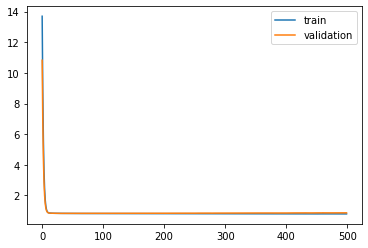

Time to train LSTM:  364.21386766433716
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 9s - loss: 14.9961 - pdc_loss: 0.6883 - event_loss: 0.6773 - val_loss: 13.3004 - val_pdc_loss: 0.6640 - val_event_loss: 0.6069

Epoch 00001: val_loss improved from inf to 13.30036, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 12.1050 - pdc_loss: 0.6523 - event_loss: 0.5700 - val_loss: 10.6878 - val_pdc_loss: 0.6356 - val_event_loss: 0.5151

Epoch 00002: val_loss improved from 13.30036 to 10.68776, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 9.7017 - pdc_loss: 0.6265 - event_loss: 0.4861 - val_loss: 8.5353 - val_pdc_loss: 0.6150 - val_event_loss: 0.4357

Epoch 00003: val_loss improved from 10.68776 to 8.53528, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 7.7343 - pdc_loss: 0.6070 - event_loss: 0.4119 - val_loss: 6.7910 - val_pdc_loss: 0.5997 - val_event_loss: 0.3683

Epoch 00004: val_loss improved from 8.53528 to 6.79102,


Epoch 00035: val_loss improved from 0.82873 to 0.82799, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 0.8324 - pdc_loss: 0.5229 - event_loss: 0.2972 - val_loss: 0.8275 - val_pdc_loss: 0.5234 - val_event_loss: 0.2919

Epoch 00036: val_loss improved from 0.82799 to 0.82746, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 0.8317 - pdc_loss: 0.5224 - event_loss: 0.2972 - val_loss: 0.8269 - val_pdc_loss: 0.5231 - val_event_loss: 0.2917

Epoch 00037: val_loss improved from 0.82746 to 0.82686, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 0.8310 - pdc_loss: 0.5219 - event_loss: 0.2971 - val_loss: 0.8265 - val_pdc_loss: 0.5228 - val_event_loss: 0.2918

Epoch 00038: val_loss improved from 0.82686 to 0.82654, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 0.8304 - pdc_loss: 0.5215 - event_loss: 0.2970 - val_loss: 0.8258 - val_pdc_loss: 0.5225 - val_event_loss: 0.2915

Epoch 00039: val_loss improved from 0.82654 to 


Epoch 00072: val_loss did not improve from 0.81892
Epoch 73/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5128 - event_loss: 0.2955 - val_loss: 0.8188 - val_pdc_loss: 0.5173 - val_event_loss: 0.2906

Epoch 00073: val_loss improved from 0.81892 to 0.81880, saving model to Event_val_weights1.hdf5
Epoch 74/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5126 - event_loss: 0.2955 - val_loss: 0.8189 - val_pdc_loss: 0.5172 - val_event_loss: 0.2908

Epoch 00074: val_loss did not improve from 0.81880
Epoch 75/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5125 - event_loss: 0.2954 - val_loss: 0.8186 - val_pdc_loss: 0.5171 - val_event_loss: 0.2906

Epoch 00075: val_loss improved from 0.81880 to 0.81865, saving model to Event_val_weights1.hdf5
Epoch 76/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5123 - event_loss: 0.2953 - val_loss: 0.8187 - val_pdc_loss: 0.5171 - val_event_loss: 0.2907

Epoch 00076: val_loss did not improve from 0.81865
Epoch 77/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5122 - event_loss: 0.2953 - val_loss: 

 - 1s - loss: 0.8124 - pdc_loss: 0.5076 - event_loss: 0.2935 - val_loss: 0.8196 - val_pdc_loss: 0.5177 - val_event_loss: 0.2906

Epoch 00114: val_loss did not improve from 0.81812
Epoch 115/500
 - 1s - loss: 0.8120 - pdc_loss: 0.5073 - event_loss: 0.2933 - val_loss: 0.8200 - val_pdc_loss: 0.5179 - val_event_loss: 0.2908

Epoch 00115: val_loss did not improve from 0.81812
Epoch 116/500
 - 1s - loss: 0.8119 - pdc_loss: 0.5073 - event_loss: 0.2933 - val_loss: 0.8200 - val_pdc_loss: 0.5180 - val_event_loss: 0.2907

Epoch 00116: val_loss did not improve from 0.81812
Epoch 117/500
 - 1s - loss: 0.8117 - pdc_loss: 0.5071 - event_loss: 0.2932 - val_loss: 0.8195 - val_pdc_loss: 0.5176 - val_event_loss: 0.2906

Epoch 00117: val_loss did not improve from 0.81812
Epoch 118/500
 - 1s - loss: 0.8116 - pdc_loss: 0.5071 - event_loss: 0.2931 - val_loss: 0.8208 - val_pdc_loss: 0.5182 - val_event_loss: 0.2912

Epoch 00118: val_loss did not improve from 0.81812
Epoch 119/500
 - 1s - loss: 0.8115 - pdc_los


Epoch 00156: val_loss did not improve from 0.81812
Epoch 157/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5055 - event_loss: 0.2917 - val_loss: 0.8285 - val_pdc_loss: 0.5221 - val_event_loss: 0.2939

Epoch 00157: val_loss did not improve from 0.81812
Epoch 158/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5066 - event_loss: 0.2921 - val_loss: 0.8299 - val_pdc_loss: 0.5216 - val_event_loss: 0.2958

Epoch 00158: val_loss did not improve from 0.81812
Epoch 159/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5063 - event_loss: 0.2922 - val_loss: 0.8305 - val_pdc_loss: 0.5230 - val_event_loss: 0.2948

Epoch 00159: val_loss did not improve from 0.81812
Epoch 160/500
 - 1s - loss: 0.8104 - pdc_loss: 0.5055 - event_loss: 0.2921 - val_loss: 0.8273 - val_pdc_loss: 0.5221 - val_event_loss: 0.2926

Epoch 00160: val_loss did not improve from 0.81812
Epoch 161/500
 - 1s - loss: 0.8082 - pdc_loss: 0.5039 - event_loss: 0.2916 - val_loss: 0.8271 - val_pdc_loss: 0.5218 - val_event_loss: 0.2927

Epoch 00161: val_loss did not

 - 1s - loss: 0.8035 - pdc_loss: 0.5012 - event_loss: 0.2892 - val_loss: 0.8323 - val_pdc_loss: 0.5232 - val_event_loss: 0.2960

Epoch 00199: val_loss did not improve from 0.81812
Epoch 200/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5012 - event_loss: 0.2892 - val_loss: 0.8315 - val_pdc_loss: 0.5224 - val_event_loss: 0.2959

Epoch 00200: val_loss did not improve from 0.81812
Epoch 201/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5011 - event_loss: 0.2888 - val_loss: 0.8302 - val_pdc_loss: 0.5216 - val_event_loss: 0.2955

Epoch 00201: val_loss did not improve from 0.81812
Epoch 202/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5012 - event_loss: 0.2888 - val_loss: 0.8316 - val_pdc_loss: 0.5235 - val_event_loss: 0.2949

Epoch 00202: val_loss did not improve from 0.81812
Epoch 203/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5015 - event_loss: 0.2890 - val_loss: 0.8340 - val_pdc_loss: 0.5246 - val_event_loss: 0.2962

Epoch 00203: val_loss did not improve from 0.81812
Epoch 204/500
 - 1s - loss: 0.8048 - pdc_los


Epoch 00241: val_loss did not improve from 0.81812
Epoch 242/500
 - 1s - loss: 0.8018 - pdc_loss: 0.4989 - event_loss: 0.2885 - val_loss: 0.8367 - val_pdc_loss: 0.5245 - val_event_loss: 0.2978

Epoch 00242: val_loss did not improve from 0.81812
Epoch 243/500
 - 1s - loss: 0.8012 - pdc_loss: 0.4987 - event_loss: 0.2881 - val_loss: 0.8386 - val_pdc_loss: 0.5259 - val_event_loss: 0.2984

Epoch 00243: val_loss did not improve from 0.81812
Epoch 244/500
 - 1s - loss: 0.8011 - pdc_loss: 0.4991 - event_loss: 0.2877 - val_loss: 0.8361 - val_pdc_loss: 0.5243 - val_event_loss: 0.2976

Epoch 00244: val_loss did not improve from 0.81812
Epoch 245/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4993 - event_loss: 0.2872 - val_loss: 0.8358 - val_pdc_loss: 0.5236 - val_event_loss: 0.2981

Epoch 00245: val_loss did not improve from 0.81812
Epoch 246/500
 - 1s - loss: 0.8014 - pdc_loss: 0.4997 - event_loss: 0.2876 - val_loss: 0.8356 - val_pdc_loss: 0.5223 - val_event_loss: 0.2991

Epoch 00246: val_loss did not

 - 1s - loss: 0.7983 - pdc_loss: 0.4964 - event_loss: 0.2869 - val_loss: 0.8377 - val_pdc_loss: 0.5246 - val_event_loss: 0.2979

Epoch 00284: val_loss did not improve from 0.81812
Epoch 285/500
 - 1s - loss: 0.7980 - pdc_loss: 0.4967 - event_loss: 0.2861 - val_loss: 0.8387 - val_pdc_loss: 0.5256 - val_event_loss: 0.2980

Epoch 00285: val_loss did not improve from 0.81812
Epoch 286/500
 - 1s - loss: 0.7983 - pdc_loss: 0.4970 - event_loss: 0.2862 - val_loss: 0.8403 - val_pdc_loss: 0.5263 - val_event_loss: 0.2989

Epoch 00286: val_loss did not improve from 0.81812
Epoch 287/500
 - 1s - loss: 0.7982 - pdc_loss: 0.4965 - event_loss: 0.2865 - val_loss: 0.8389 - val_pdc_loss: 0.5247 - val_event_loss: 0.2989

Epoch 00287: val_loss did not improve from 0.81812
Epoch 288/500
 - 1s - loss: 0.7980 - pdc_loss: 0.4962 - event_loss: 0.2865 - val_loss: 0.8397 - val_pdc_loss: 0.5256 - val_event_loss: 0.2989

Epoch 00288: val_loss did not improve from 0.81812
Epoch 289/500
 - 1s - loss: 0.7977 - pdc_los


Epoch 00326: val_loss did not improve from 0.81812
Epoch 327/500
 - 1s - loss: 0.7968 - pdc_loss: 0.4958 - event_loss: 0.2849 - val_loss: 0.8426 - val_pdc_loss: 0.5263 - val_event_loss: 0.3002

Epoch 00327: val_loss did not improve from 0.81812
Epoch 328/500
 - 1s - loss: 0.7975 - pdc_loss: 0.4964 - event_loss: 0.2849 - val_loss: 0.8416 - val_pdc_loss: 0.5260 - val_event_loss: 0.2995

Epoch 00328: val_loss did not improve from 0.81812
Epoch 329/500
 - 1s - loss: 0.7957 - pdc_loss: 0.4947 - event_loss: 0.2849 - val_loss: 0.8436 - val_pdc_loss: 0.5276 - val_event_loss: 0.2999

Epoch 00329: val_loss did not improve from 0.81812
Epoch 330/500
 - 1s - loss: 0.7956 - pdc_loss: 0.4945 - event_loss: 0.2850 - val_loss: 0.8441 - val_pdc_loss: 0.5276 - val_event_loss: 0.3005

Epoch 00330: val_loss did not improve from 0.81812
Epoch 331/500
 - 1s - loss: 0.7953 - pdc_loss: 0.4946 - event_loss: 0.2845 - val_loss: 0.8425 - val_pdc_loss: 0.5254 - val_event_loss: 0.3008

Epoch 00331: val_loss did not

 - 1s - loss: 0.7931 - pdc_loss: 0.4928 - event_loss: 0.2837 - val_loss: 0.8526 - val_pdc_loss: 0.5327 - val_event_loss: 0.3032

Epoch 00369: val_loss did not improve from 0.81812
Epoch 370/500
 - 1s - loss: 0.7940 - pdc_loss: 0.4934 - event_loss: 0.2839 - val_loss: 0.8513 - val_pdc_loss: 0.5318 - val_event_loss: 0.3028

Epoch 00370: val_loss did not improve from 0.81812
Epoch 371/500
 - 1s - loss: 0.7945 - pdc_loss: 0.4937 - event_loss: 0.2842 - val_loss: 0.8489 - val_pdc_loss: 0.5310 - val_event_loss: 0.3013

Epoch 00371: val_loss did not improve from 0.81812
Epoch 372/500
 - 1s - loss: 0.7938 - pdc_loss: 0.4930 - event_loss: 0.2842 - val_loss: 0.8487 - val_pdc_loss: 0.5298 - val_event_loss: 0.3022

Epoch 00372: val_loss did not improve from 0.81812
Epoch 373/500
 - 1s - loss: 0.7935 - pdc_loss: 0.4925 - event_loss: 0.2843 - val_loss: 0.8501 - val_pdc_loss: 0.5311 - val_event_loss: 0.3024

Epoch 00373: val_loss did not improve from 0.81812
Epoch 374/500
 - 1s - loss: 0.7950 - pdc_los


Epoch 00411: val_loss did not improve from 0.81812
Epoch 412/500
 - 1s - loss: 0.7915 - pdc_loss: 0.4909 - event_loss: 0.2832 - val_loss: 0.8508 - val_pdc_loss: 0.5329 - val_event_loss: 0.3005

Epoch 00412: val_loss did not improve from 0.81812
Epoch 413/500
 - 1s - loss: 0.7916 - pdc_loss: 0.4912 - event_loss: 0.2830 - val_loss: 0.8548 - val_pdc_loss: 0.5342 - val_event_loss: 0.3032

Epoch 00413: val_loss did not improve from 0.81812
Epoch 414/500
 - 1s - loss: 0.7917 - pdc_loss: 0.4908 - event_loss: 0.2835 - val_loss: 0.8552 - val_pdc_loss: 0.5340 - val_event_loss: 0.3037

Epoch 00414: val_loss did not improve from 0.81812
Epoch 415/500
 - 1s - loss: 0.7926 - pdc_loss: 0.4914 - event_loss: 0.2836 - val_loss: 0.8510 - val_pdc_loss: 0.5323 - val_event_loss: 0.3011

Epoch 00415: val_loss did not improve from 0.81812
Epoch 416/500
 - 1s - loss: 0.7929 - pdc_loss: 0.4919 - event_loss: 0.2834 - val_loss: 0.8512 - val_pdc_loss: 0.5328 - val_event_loss: 0.3008

Epoch 00416: val_loss did not

 - 1s - loss: 0.7878 - pdc_loss: 0.4878 - event_loss: 0.2818 - val_loss: 0.8550 - val_pdc_loss: 0.5343 - val_event_loss: 0.3026

Epoch 00454: val_loss did not improve from 0.81812
Epoch 455/500
 - 1s - loss: 0.7883 - pdc_loss: 0.4890 - event_loss: 0.2812 - val_loss: 0.8562 - val_pdc_loss: 0.5351 - val_event_loss: 0.3031

Epoch 00455: val_loss did not improve from 0.81812
Epoch 456/500
 - 1s - loss: 0.7884 - pdc_loss: 0.4887 - event_loss: 0.2813 - val_loss: 0.8551 - val_pdc_loss: 0.5333 - val_event_loss: 0.3033

Epoch 00456: val_loss did not improve from 0.81812
Epoch 457/500
 - 1s - loss: 0.7883 - pdc_loss: 0.4884 - event_loss: 0.2815 - val_loss: 0.8586 - val_pdc_loss: 0.5341 - val_event_loss: 0.3062

Epoch 00457: val_loss did not improve from 0.81812
Epoch 458/500
 - 1s - loss: 0.7873 - pdc_loss: 0.4872 - event_loss: 0.2819 - val_loss: 0.8567 - val_pdc_loss: 0.5344 - val_event_loss: 0.3040

Epoch 00458: val_loss did not improve from 0.81812
Epoch 459/500
 - 1s - loss: 0.7884 - pdc_los


Epoch 00496: val_loss did not improve from 0.81812
Epoch 497/500
 - 1s - loss: 0.7899 - pdc_loss: 0.4885 - event_loss: 0.2826 - val_loss: 0.8568 - val_pdc_loss: 0.5350 - val_event_loss: 0.3029

Epoch 00497: val_loss did not improve from 0.81812
Epoch 498/500
 - 1s - loss: 0.7878 - pdc_loss: 0.4873 - event_loss: 0.2816 - val_loss: 0.8576 - val_pdc_loss: 0.5360 - val_event_loss: 0.3027

Epoch 00498: val_loss did not improve from 0.81812
Epoch 499/500
 - 1s - loss: 0.7870 - pdc_loss: 0.4868 - event_loss: 0.2813 - val_loss: 0.8570 - val_pdc_loss: 0.5346 - val_event_loss: 0.3036

Epoch 00499: val_loss did not improve from 0.81812
Epoch 500/500
 - 1s - loss: 0.7875 - pdc_loss: 0.4873 - event_loss: 0.2814 - val_loss: 0.8604 - val_pdc_loss: 0.5355 - val_event_loss: 0.3062

Epoch 00500: val_loss did not improve from 0.81812
#################################
Number of units: 32
Batch size: 8192
Fold: 0
best val loss: 0.818122484366099
#################################


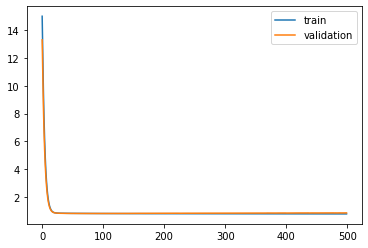

Time to train LSTM:  391.9796693325043
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 9s - loss: 15.1503 - pdc_loss: 0.7442 - event_loss: 0.6848 - val_loss: 13.4464 - val_pdc_loss: 0.7047 - val_event_loss: 0.6213

Epoch 00001: val_loss improved from inf to 13.44638, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 12.2394 - pdc_loss: 0.6842 - event_loss: 0.5820 - val_loss: 10.8235 - val_pdc_loss: 0.6593 - val_event_loss: 0.5378

Epoch 00002: val_loss improved from 13.44638 to 10.82349, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 9.8264 - pdc_loss: 0.6460 - event_loss: 0.5040 - val_loss: 8.6655 - val_pdc_loss: 0.6304 - val_event_loss: 0.4663

Epoch 00003: val_loss improved from 10.82349 to 8.66551, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 7.8516 - pdc_loss: 0.6207 - event_loss: 0.4346 - val_loss: 6.9119 - val_pdc_loss: 0.6108 - val_event_loss: 0.4014

Epoch 00004: val_loss improved from 8.66551 to 6.91188, 


Epoch 00035: val_loss improved from 0.84479 to 0.84451, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 0.8305 - pdc_loss: 0.5221 - event_loss: 0.2960 - val_loss: 0.8433 - val_pdc_loss: 0.5286 - val_event_loss: 0.3024

Epoch 00036: val_loss improved from 0.84451 to 0.84333, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 0.8299 - pdc_loss: 0.5217 - event_loss: 0.2959 - val_loss: 0.8433 - val_pdc_loss: 0.5286 - val_event_loss: 0.3025

Epoch 00037: val_loss improved from 0.84333 to 0.84330, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 0.8293 - pdc_loss: 0.5212 - event_loss: 0.2959 - val_loss: 0.8423 - val_pdc_loss: 0.5279 - val_event_loss: 0.3023

Epoch 00038: val_loss improved from 0.84330 to 0.84225, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 0.8287 - pdc_loss: 0.5208 - event_loss: 0.2958 - val_loss: 0.8423 - val_pdc_loss: 0.5279 - val_event_loss: 0.3024

Epoch 00039: val_loss did not improve from 0.84

 - 1s - loss: 0.8186 - pdc_loss: 0.5140 - event_loss: 0.2939 - val_loss: 0.8373 - val_pdc_loss: 0.5248 - val_event_loss: 0.3017

Epoch 00073: val_loss improved from 0.83735 to 0.83730, saving model to Event_val_weights2.hdf5
Epoch 74/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5138 - event_loss: 0.2938 - val_loss: 0.8372 - val_pdc_loss: 0.5247 - val_event_loss: 0.3017

Epoch 00074: val_loss improved from 0.83730 to 0.83722, saving model to Event_val_weights2.hdf5
Epoch 75/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5137 - event_loss: 0.2937 - val_loss: 0.8374 - val_pdc_loss: 0.5249 - val_event_loss: 0.3018

Epoch 00075: val_loss did not improve from 0.83722
Epoch 76/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5136 - event_loss: 0.2937 - val_loss: 0.8372 - val_pdc_loss: 0.5246 - val_event_loss: 0.3017

Epoch 00076: val_loss improved from 0.83722 to 0.83716, saving model to Event_val_weights2.hdf5
Epoch 77/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5135 - event_loss: 0.2937 - val_loss: 0.8375 - val_pdc_los


Epoch 00114: val_loss did not improve from 0.83714
Epoch 115/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5085 - event_loss: 0.2916 - val_loss: 0.8386 - val_pdc_loss: 0.5244 - val_event_loss: 0.3028

Epoch 00115: val_loss did not improve from 0.83714
Epoch 116/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5083 - event_loss: 0.2917 - val_loss: 0.8385 - val_pdc_loss: 0.5245 - val_event_loss: 0.3025

Epoch 00116: val_loss did not improve from 0.83714
Epoch 117/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5082 - event_loss: 0.2915 - val_loss: 0.8391 - val_pdc_loss: 0.5246 - val_event_loss: 0.3029

Epoch 00117: val_loss did not improve from 0.83714
Epoch 118/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5081 - event_loss: 0.2916 - val_loss: 0.8386 - val_pdc_loss: 0.5244 - val_event_loss: 0.3026

Epoch 00118: val_loss did not improve from 0.83714
Epoch 119/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5080 - event_loss: 0.2915 - val_loss: 0.8397 - val_pdc_loss: 0.5251 - val_event_loss: 0.3030

Epoch 00119: val_loss did not

 - 1s - loss: 0.8064 - pdc_loss: 0.5047 - event_loss: 0.2895 - val_loss: 0.8427 - val_pdc_loss: 0.5260 - val_event_loss: 0.3044

Epoch 00157: val_loss did not improve from 0.83714
Epoch 158/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5045 - event_loss: 0.2895 - val_loss: 0.8430 - val_pdc_loss: 0.5265 - val_event_loss: 0.3042

Epoch 00158: val_loss did not improve from 0.83714
Epoch 159/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5042 - event_loss: 0.2894 - val_loss: 0.8432 - val_pdc_loss: 0.5264 - val_event_loss: 0.3045

Epoch 00159: val_loss did not improve from 0.83714
Epoch 160/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5041 - event_loss: 0.2896 - val_loss: 0.8441 - val_pdc_loss: 0.5267 - val_event_loss: 0.3051

Epoch 00160: val_loss did not improve from 0.83714
Epoch 161/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5042 - event_loss: 0.2893 - val_loss: 0.8439 - val_pdc_loss: 0.5266 - val_event_loss: 0.3049

Epoch 00161: val_loss did not improve from 0.83714
Epoch 162/500
 - 1s - loss: 0.8060 - pdc_los


Epoch 00199: val_loss did not improve from 0.83714
Epoch 200/500
 - 1s - loss: 0.8013 - pdc_loss: 0.5004 - event_loss: 0.2869 - val_loss: 0.8507 - val_pdc_loss: 0.5305 - val_event_loss: 0.3062

Epoch 00200: val_loss did not improve from 0.83714
Epoch 201/500
 - 1s - loss: 0.8013 - pdc_loss: 0.5009 - event_loss: 0.2865 - val_loss: 0.8515 - val_pdc_loss: 0.5322 - val_event_loss: 0.3055

Epoch 00201: val_loss did not improve from 0.83714
Epoch 202/500
 - 1s - loss: 0.8007 - pdc_loss: 0.5004 - event_loss: 0.2864 - val_loss: 0.8515 - val_pdc_loss: 0.5311 - val_event_loss: 0.3065

Epoch 00202: val_loss did not improve from 0.83714
Epoch 203/500
 - 1s - loss: 0.8001 - pdc_loss: 0.4999 - event_loss: 0.2863 - val_loss: 0.8507 - val_pdc_loss: 0.5299 - val_event_loss: 0.3068

Epoch 00203: val_loss did not improve from 0.83714
Epoch 204/500
 - 1s - loss: 0.8003 - pdc_loss: 0.5000 - event_loss: 0.2864 - val_loss: 0.8501 - val_pdc_loss: 0.5292 - val_event_loss: 0.3070

Epoch 00204: val_loss did not

 - 1s - loss: 0.7978 - pdc_loss: 0.4978 - event_loss: 0.2851 - val_loss: 0.8547 - val_pdc_loss: 0.5334 - val_event_loss: 0.3065

Epoch 00242: val_loss did not improve from 0.83714
Epoch 243/500
 - 1s - loss: 0.7988 - pdc_loss: 0.4987 - event_loss: 0.2853 - val_loss: 0.8544 - val_pdc_loss: 0.5331 - val_event_loss: 0.3065

Epoch 00243: val_loss did not improve from 0.83714
Epoch 244/500
 - 1s - loss: 0.7990 - pdc_loss: 0.4985 - event_loss: 0.2856 - val_loss: 0.8529 - val_pdc_loss: 0.5312 - val_event_loss: 0.3066

Epoch 00244: val_loss did not improve from 0.83714
Epoch 245/500
 - 1s - loss: 0.7986 - pdc_loss: 0.4980 - event_loss: 0.2855 - val_loss: 0.8555 - val_pdc_loss: 0.5327 - val_event_loss: 0.3076

Epoch 00245: val_loss did not improve from 0.83714
Epoch 246/500
 - 1s - loss: 0.7982 - pdc_loss: 0.4973 - event_loss: 0.2858 - val_loss: 0.8576 - val_pdc_loss: 0.5333 - val_event_loss: 0.3092

Epoch 00246: val_loss did not improve from 0.83714
Epoch 247/500
 - 1s - loss: 0.7983 - pdc_los


Epoch 00284: val_loss did not improve from 0.83714
Epoch 285/500
 - 1s - loss: 0.7948 - pdc_loss: 0.4951 - event_loss: 0.2840 - val_loss: 0.8570 - val_pdc_loss: 0.5331 - val_event_loss: 0.3081

Epoch 00285: val_loss did not improve from 0.83714
Epoch 286/500
 - 1s - loss: 0.7950 - pdc_loss: 0.4953 - event_loss: 0.2841 - val_loss: 0.8574 - val_pdc_loss: 0.5337 - val_event_loss: 0.3080

Epoch 00286: val_loss did not improve from 0.83714
Epoch 287/500
 - 1s - loss: 0.7949 - pdc_loss: 0.4953 - event_loss: 0.2839 - val_loss: 0.8580 - val_pdc_loss: 0.5348 - val_event_loss: 0.3074

Epoch 00287: val_loss did not improve from 0.83714
Epoch 288/500
 - 1s - loss: 0.7940 - pdc_loss: 0.4946 - event_loss: 0.2838 - val_loss: 0.8591 - val_pdc_loss: 0.5349 - val_event_loss: 0.3085

Epoch 00288: val_loss did not improve from 0.83714
Epoch 289/500
 - 1s - loss: 0.7933 - pdc_loss: 0.4937 - event_loss: 0.2840 - val_loss: 0.8576 - val_pdc_loss: 0.5341 - val_event_loss: 0.3080

Epoch 00289: val_loss did not

 - 1s - loss: 0.7912 - pdc_loss: 0.4925 - event_loss: 0.2826 - val_loss: 0.8620 - val_pdc_loss: 0.5373 - val_event_loss: 0.3086

Epoch 00327: val_loss did not improve from 0.83714
Epoch 328/500
 - 1s - loss: 0.7911 - pdc_loss: 0.4922 - event_loss: 0.2827 - val_loss: 0.8623 - val_pdc_loss: 0.5380 - val_event_loss: 0.3082

Epoch 00328: val_loss did not improve from 0.83714
Epoch 329/500
 - 1s - loss: 0.7913 - pdc_loss: 0.4929 - event_loss: 0.2822 - val_loss: 0.8621 - val_pdc_loss: 0.5369 - val_event_loss: 0.3089

Epoch 00329: val_loss did not improve from 0.83714
Epoch 330/500
 - 1s - loss: 0.7912 - pdc_loss: 0.4925 - event_loss: 0.2826 - val_loss: 0.8615 - val_pdc_loss: 0.5356 - val_event_loss: 0.3097

Epoch 00330: val_loss did not improve from 0.83714
Epoch 331/500
 - 1s - loss: 0.7910 - pdc_loss: 0.4919 - event_loss: 0.2829 - val_loss: 0.8629 - val_pdc_loss: 0.5378 - val_event_loss: 0.3088

Epoch 00331: val_loss did not improve from 0.83714
Epoch 332/500
 - 1s - loss: 0.7911 - pdc_los


Epoch 00369: val_loss did not improve from 0.83714
Epoch 370/500
 - 1s - loss: 0.7903 - pdc_loss: 0.4905 - event_loss: 0.2825 - val_loss: 0.8634 - val_pdc_loss: 0.5373 - val_event_loss: 0.3089

Epoch 00370: val_loss did not improve from 0.83714
Epoch 371/500
 - 1s - loss: 0.7900 - pdc_loss: 0.4908 - event_loss: 0.2820 - val_loss: 0.8663 - val_pdc_loss: 0.5392 - val_event_loss: 0.3099

Epoch 00371: val_loss did not improve from 0.83714
Epoch 372/500
 - 1s - loss: 0.7912 - pdc_loss: 0.4914 - event_loss: 0.2826 - val_loss: 0.8649 - val_pdc_loss: 0.5395 - val_event_loss: 0.3081

Epoch 00372: val_loss did not improve from 0.83714
Epoch 373/500
 - 1s - loss: 0.7901 - pdc_loss: 0.4908 - event_loss: 0.2820 - val_loss: 0.8637 - val_pdc_loss: 0.5379 - val_event_loss: 0.3085

Epoch 00373: val_loss did not improve from 0.83714
Epoch 374/500
 - 1s - loss: 0.7888 - pdc_loss: 0.4901 - event_loss: 0.2814 - val_loss: 0.8622 - val_pdc_loss: 0.5369 - val_event_loss: 0.3080

Epoch 00374: val_loss did not

 - 1s - loss: 0.7884 - pdc_loss: 0.4894 - event_loss: 0.2812 - val_loss: 0.8683 - val_pdc_loss: 0.5405 - val_event_loss: 0.3100

Epoch 00412: val_loss did not improve from 0.83714
Epoch 413/500
 - 1s - loss: 0.7886 - pdc_loss: 0.4900 - event_loss: 0.2809 - val_loss: 0.8701 - val_pdc_loss: 0.5416 - val_event_loss: 0.3107

Epoch 00413: val_loss did not improve from 0.83714
Epoch 414/500
 - 1s - loss: 0.7890 - pdc_loss: 0.4901 - event_loss: 0.2811 - val_loss: 0.8679 - val_pdc_loss: 0.5400 - val_event_loss: 0.3100

Epoch 00414: val_loss did not improve from 0.83714
Epoch 415/500
 - 1s - loss: 0.7900 - pdc_loss: 0.4905 - event_loss: 0.2816 - val_loss: 0.8695 - val_pdc_loss: 0.5423 - val_event_loss: 0.3093

Epoch 00415: val_loss did not improve from 0.83714
Epoch 416/500
 - 1s - loss: 0.7895 - pdc_loss: 0.4902 - event_loss: 0.2814 - val_loss: 0.8686 - val_pdc_loss: 0.5417 - val_event_loss: 0.3089

Epoch 00416: val_loss did not improve from 0.83714
Epoch 417/500
 - 1s - loss: 0.7883 - pdc_los


Epoch 00454: val_loss did not improve from 0.83714
Epoch 455/500
 - 1s - loss: 0.7852 - pdc_loss: 0.4873 - event_loss: 0.2795 - val_loss: 0.8716 - val_pdc_loss: 0.5427 - val_event_loss: 0.3105

Epoch 00455: val_loss did not improve from 0.83714
Epoch 456/500
 - 1s - loss: 0.7849 - pdc_loss: 0.4869 - event_loss: 0.2795 - val_loss: 0.8703 - val_pdc_loss: 0.5426 - val_event_loss: 0.3093

Epoch 00456: val_loss did not improve from 0.83714
Epoch 457/500
 - 1s - loss: 0.7838 - pdc_loss: 0.4864 - event_loss: 0.2790 - val_loss: 0.8734 - val_pdc_loss: 0.5431 - val_event_loss: 0.3119

Epoch 00457: val_loss did not improve from 0.83714
Epoch 458/500
 - 1s - loss: 0.7842 - pdc_loss: 0.4866 - event_loss: 0.2794 - val_loss: 0.8714 - val_pdc_loss: 0.5428 - val_event_loss: 0.3105

Epoch 00458: val_loss did not improve from 0.83714
Epoch 459/500
 - 1s - loss: 0.7845 - pdc_loss: 0.4869 - event_loss: 0.2794 - val_loss: 0.8742 - val_pdc_loss: 0.5439 - val_event_loss: 0.3120

Epoch 00459: val_loss did not

 - 1s - loss: 0.7853 - pdc_loss: 0.4868 - event_loss: 0.2794 - val_loss: 0.8745 - val_pdc_loss: 0.5444 - val_event_loss: 0.3111

Epoch 00497: val_loss did not improve from 0.83714
Epoch 498/500
 - 1s - loss: 0.7834 - pdc_loss: 0.4858 - event_loss: 0.2786 - val_loss: 0.8754 - val_pdc_loss: 0.5442 - val_event_loss: 0.3122

Epoch 00498: val_loss did not improve from 0.83714
Epoch 499/500
 - 1s - loss: 0.7815 - pdc_loss: 0.4846 - event_loss: 0.2780 - val_loss: 0.8760 - val_pdc_loss: 0.5455 - val_event_loss: 0.3116

Epoch 00499: val_loss did not improve from 0.83714
Epoch 500/500
 - 1s - loss: 0.7827 - pdc_loss: 0.4856 - event_loss: 0.2782 - val_loss: 0.8747 - val_pdc_loss: 0.5444 - val_event_loss: 0.3115

Epoch 00500: val_loss did not improve from 0.83714
#################################
Number of units: 32
Batch size: 8192
Fold: 1
best val loss: 0.8371448255115085
#################################


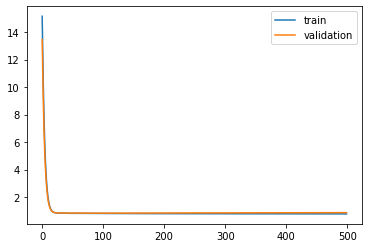

Time to train LSTM:  381.97872829437256
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 9s - loss: 14.9708 - pdc_loss: 0.7264 - event_loss: 0.6650 - val_loss: 13.2912 - val_pdc_loss: 0.6962 - val_event_loss: 0.6130

Epoch 00001: val_loss improved from inf to 13.29125, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 12.0900 - pdc_loss: 0.6720 - event_loss: 0.5789 - val_loss: 10.6908 - val_pdc_loss: 0.6548 - val_event_loss: 0.5375

Epoch 00002: val_loss improved from 13.29125 to 10.69080, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 9.6962 - pdc_loss: 0.6364 - event_loss: 0.5054 - val_loss: 8.5487 - val_pdc_loss: 0.6283 - val_event_loss: 0.4659

Epoch 00003: val_loss improved from 10.69080 to 8.54870, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 7.7341 - pdc_loss: 0.6122 - event_loss: 0.4331 - val_loss: 6.8069 - val_pdc_loss: 0.6105 - val_event_loss: 0.3959

Epoch 00004: val_loss improved from 8.54870 to 6.80686,


Epoch 00035: val_loss improved from 0.85284 to 0.85233, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 0.8314 - pdc_loss: 0.5228 - event_loss: 0.2967 - val_loss: 0.8519 - val_pdc_loss: 0.5394 - val_event_loss: 0.3007

Epoch 00036: val_loss improved from 0.85233 to 0.85190, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 0.8306 - pdc_loss: 0.5222 - event_loss: 0.2967 - val_loss: 0.8512 - val_pdc_loss: 0.5388 - val_event_loss: 0.3007

Epoch 00037: val_loss improved from 0.85190 to 0.85120, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 0.8300 - pdc_loss: 0.5217 - event_loss: 0.2967 - val_loss: 0.8509 - val_pdc_loss: 0.5384 - val_event_loss: 0.3008

Epoch 00038: val_loss improved from 0.85120 to 0.85086, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.8294 - pdc_loss: 0.5212 - event_loss: 0.2966 - val_loss: 0.8502 - val_pdc_loss: 0.5378 - val_event_loss: 0.3008

Epoch 00039: val_loss improved from 0.85086 to 


Epoch 00070: val_loss improved from 0.84284 to 0.84274, saving model to Event_val_weights3.hdf5
Epoch 71/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5128 - event_loss: 0.2951 - val_loss: 0.8428 - val_pdc_loss: 0.5309 - val_event_loss: 0.3014

Epoch 00071: val_loss did not improve from 0.84274
Epoch 72/500
 - 1s - loss: 0.8183 - pdc_loss: 0.5127 - event_loss: 0.2951 - val_loss: 0.8427 - val_pdc_loss: 0.5309 - val_event_loss: 0.3013

Epoch 00072: val_loss improved from 0.84274 to 0.84273, saving model to Event_val_weights3.hdf5
Epoch 73/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5125 - event_loss: 0.2950 - val_loss: 0.8426 - val_pdc_loss: 0.5308 - val_event_loss: 0.3014

Epoch 00073: val_loss improved from 0.84273 to 0.84264, saving model to Event_val_weights3.hdf5
Epoch 74/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5124 - event_loss: 0.2950 - val_loss: 0.8423 - val_pdc_loss: 0.5306 - val_event_loss: 0.3012

Epoch 00074: val_loss improved from 0.84264 to 0.84227, saving model to Event_val_weights3.h


Epoch 00111: val_loss did not improve from 0.84170
Epoch 112/500
 - 1s - loss: 0.8121 - pdc_loss: 0.5082 - event_loss: 0.2932 - val_loss: 0.8423 - val_pdc_loss: 0.5301 - val_event_loss: 0.3014

Epoch 00112: val_loss did not improve from 0.84170
Epoch 113/500
 - 1s - loss: 0.8120 - pdc_loss: 0.5081 - event_loss: 0.2931 - val_loss: 0.8423 - val_pdc_loss: 0.5301 - val_event_loss: 0.3014

Epoch 00113: val_loss did not improve from 0.84170
Epoch 114/500
 - 1s - loss: 0.8117 - pdc_loss: 0.5079 - event_loss: 0.2930 - val_loss: 0.8424 - val_pdc_loss: 0.5300 - val_event_loss: 0.3016

Epoch 00114: val_loss did not improve from 0.84170
Epoch 115/500
 - 1s - loss: 0.8118 - pdc_loss: 0.5079 - event_loss: 0.2931 - val_loss: 0.8425 - val_pdc_loss: 0.5302 - val_event_loss: 0.3015

Epoch 00115: val_loss did not improve from 0.84170
Epoch 116/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5077 - event_loss: 0.2930 - val_loss: 0.8423 - val_pdc_loss: 0.5299 - val_event_loss: 0.3015

Epoch 00116: val_loss did not

 - 1s - loss: 0.8085 - pdc_loss: 0.5051 - event_loss: 0.2914 - val_loss: 0.8490 - val_pdc_loss: 0.5333 - val_event_loss: 0.3037

Epoch 00154: val_loss did not improve from 0.84170
Epoch 155/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5058 - event_loss: 0.2919 - val_loss: 0.8504 - val_pdc_loss: 0.5342 - val_event_loss: 0.3040

Epoch 00155: val_loss did not improve from 0.84170
Epoch 156/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5050 - event_loss: 0.2915 - val_loss: 0.8476 - val_pdc_loss: 0.5331 - val_event_loss: 0.3024

Epoch 00156: val_loss did not improve from 0.84170
Epoch 157/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5036 - event_loss: 0.2905 - val_loss: 0.8469 - val_pdc_loss: 0.5322 - val_event_loss: 0.3027

Epoch 00157: val_loss did not improve from 0.84170
Epoch 158/500
 - 1s - loss: 0.8062 - pdc_loss: 0.5035 - event_loss: 0.2907 - val_loss: 0.8483 - val_pdc_loss: 0.5329 - val_event_loss: 0.3034

Epoch 00158: val_loss did not improve from 0.84170
Epoch 159/500
 - 1s - loss: 0.8068 - pdc_los


Epoch 00196: val_loss did not improve from 0.84170
Epoch 197/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5012 - event_loss: 0.2887 - val_loss: 0.8511 - val_pdc_loss: 0.5339 - val_event_loss: 0.3044

Epoch 00197: val_loss did not improve from 0.84170
Epoch 198/500
 - 1s - loss: 0.8027 - pdc_loss: 0.5012 - event_loss: 0.2887 - val_loss: 0.8527 - val_pdc_loss: 0.5352 - val_event_loss: 0.3048

Epoch 00198: val_loss did not improve from 0.84170
Epoch 199/500
 - 1s - loss: 0.8042 - pdc_loss: 0.5020 - event_loss: 0.2893 - val_loss: 0.8538 - val_pdc_loss: 0.5352 - val_event_loss: 0.3058

Epoch 00199: val_loss did not improve from 0.84170
Epoch 200/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5022 - event_loss: 0.2896 - val_loss: 0.8530 - val_pdc_loss: 0.5354 - val_event_loss: 0.3046

Epoch 00200: val_loss did not improve from 0.84170
Epoch 201/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5011 - event_loss: 0.2890 - val_loss: 0.8509 - val_pdc_loss: 0.5345 - val_event_loss: 0.3035

Epoch 00201: val_loss did not

 - 1s - loss: 0.7996 - pdc_loss: 0.4982 - event_loss: 0.2875 - val_loss: 0.8559 - val_pdc_loss: 0.5362 - val_event_loss: 0.3058

Epoch 00239: val_loss did not improve from 0.84170
Epoch 240/500
 - 1s - loss: 0.7989 - pdc_loss: 0.4978 - event_loss: 0.2871 - val_loss: 0.8571 - val_pdc_loss: 0.5378 - val_event_loss: 0.3054

Epoch 00240: val_loss did not improve from 0.84170
Epoch 241/500
 - 1s - loss: 0.7994 - pdc_loss: 0.4983 - event_loss: 0.2872 - val_loss: 0.8596 - val_pdc_loss: 0.5391 - val_event_loss: 0.3065

Epoch 00241: val_loss did not improve from 0.84170
Epoch 242/500
 - 1s - loss: 0.7995 - pdc_loss: 0.4982 - event_loss: 0.2874 - val_loss: 0.8580 - val_pdc_loss: 0.5381 - val_event_loss: 0.3059

Epoch 00242: val_loss did not improve from 0.84170
Epoch 243/500
 - 1s - loss: 0.7985 - pdc_loss: 0.4976 - event_loss: 0.2870 - val_loss: 0.8563 - val_pdc_loss: 0.5366 - val_event_loss: 0.3058

Epoch 00243: val_loss did not improve from 0.84170
Epoch 244/500
 - 1s - loss: 0.7977 - pdc_los


Epoch 00281: val_loss did not improve from 0.84170
Epoch 282/500
 - 1s - loss: 0.7969 - pdc_loss: 0.4962 - event_loss: 0.2859 - val_loss: 0.8597 - val_pdc_loss: 0.5386 - val_event_loss: 0.3062

Epoch 00282: val_loss did not improve from 0.84170
Epoch 283/500
 - 1s - loss: 0.7960 - pdc_loss: 0.4957 - event_loss: 0.2854 - val_loss: 0.8592 - val_pdc_loss: 0.5384 - val_event_loss: 0.3058

Epoch 00283: val_loss did not improve from 0.84170
Epoch 284/500
 - 1s - loss: 0.7961 - pdc_loss: 0.4955 - event_loss: 0.2855 - val_loss: 0.8605 - val_pdc_loss: 0.5391 - val_event_loss: 0.3064

Epoch 00284: val_loss did not improve from 0.84170
Epoch 285/500
 - 1s - loss: 0.7965 - pdc_loss: 0.4958 - event_loss: 0.2856 - val_loss: 0.8652 - val_pdc_loss: 0.5422 - val_event_loss: 0.3079

Epoch 00285: val_loss did not improve from 0.84170
Epoch 286/500
 - 1s - loss: 0.7967 - pdc_loss: 0.4955 - event_loss: 0.2861 - val_loss: 0.8646 - val_pdc_loss: 0.5407 - val_event_loss: 0.3087

Epoch 00286: val_loss did not

 - 1s - loss: 0.7922 - pdc_loss: 0.4927 - event_loss: 0.2839 - val_loss: 0.8634 - val_pdc_loss: 0.5394 - val_event_loss: 0.3085

Epoch 00324: val_loss did not improve from 0.84170
Epoch 325/500
 - 1s - loss: 0.7913 - pdc_loss: 0.4923 - event_loss: 0.2835 - val_loss: 0.8630 - val_pdc_loss: 0.5390 - val_event_loss: 0.3085

Epoch 00325: val_loss did not improve from 0.84170
Epoch 326/500
 - 1s - loss: 0.7906 - pdc_loss: 0.4922 - event_loss: 0.2829 - val_loss: 0.8628 - val_pdc_loss: 0.5397 - val_event_loss: 0.3076

Epoch 00326: val_loss did not improve from 0.84170
Epoch 327/500
 - 1s - loss: 0.7916 - pdc_loss: 0.4926 - event_loss: 0.2834 - val_loss: 0.8640 - val_pdc_loss: 0.5410 - val_event_loss: 0.3074

Epoch 00327: val_loss did not improve from 0.84170
Epoch 328/500
 - 1s - loss: 0.7923 - pdc_loss: 0.4929 - event_loss: 0.2838 - val_loss: 0.8649 - val_pdc_loss: 0.5408 - val_event_loss: 0.3085

Epoch 00328: val_loss did not improve from 0.84170
Epoch 329/500
 - 1s - loss: 0.7931 - pdc_los


Epoch 00366: val_loss did not improve from 0.84170
Epoch 367/500
 - 1s - loss: 0.7922 - pdc_loss: 0.4922 - event_loss: 0.2832 - val_loss: 0.8703 - val_pdc_loss: 0.5440 - val_event_loss: 0.3096

Epoch 00367: val_loss did not improve from 0.84170
Epoch 368/500
 - 1s - loss: 0.7932 - pdc_loss: 0.4929 - event_loss: 0.2835 - val_loss: 0.8690 - val_pdc_loss: 0.5430 - val_event_loss: 0.3092

Epoch 00368: val_loss did not improve from 0.84170
Epoch 369/500
 - 1s - loss: 0.7922 - pdc_loss: 0.4921 - event_loss: 0.2834 - val_loss: 0.8685 - val_pdc_loss: 0.5439 - val_event_loss: 0.3078

Epoch 00369: val_loss did not improve from 0.84170
Epoch 370/500
 - 1s - loss: 0.7908 - pdc_loss: 0.4917 - event_loss: 0.2823 - val_loss: 0.8696 - val_pdc_loss: 0.5434 - val_event_loss: 0.3095

Epoch 00370: val_loss did not improve from 0.84170
Epoch 371/500
 - 1s - loss: 0.7888 - pdc_loss: 0.4905 - event_loss: 0.2816 - val_loss: 0.8705 - val_pdc_loss: 0.5430 - val_event_loss: 0.3109

Epoch 00371: val_loss did not

 - 1s - loss: 0.7857 - pdc_loss: 0.4885 - event_loss: 0.2805 - val_loss: 0.8734 - val_pdc_loss: 0.5441 - val_event_loss: 0.3126

Epoch 00409: val_loss did not improve from 0.84170
Epoch 410/500
 - 1s - loss: 0.7862 - pdc_loss: 0.4888 - event_loss: 0.2807 - val_loss: 0.8729 - val_pdc_loss: 0.5438 - val_event_loss: 0.3125

Epoch 00410: val_loss did not improve from 0.84170
Epoch 411/500
 - 1s - loss: 0.7863 - pdc_loss: 0.4891 - event_loss: 0.2803 - val_loss: 0.8733 - val_pdc_loss: 0.5442 - val_event_loss: 0.3120

Epoch 00411: val_loss did not improve from 0.84170
Epoch 412/500
 - 1s - loss: 0.7875 - pdc_loss: 0.4896 - event_loss: 0.2809 - val_loss: 0.8707 - val_pdc_loss: 0.5420 - val_event_loss: 0.3117

Epoch 00412: val_loss did not improve from 0.84170
Epoch 413/500
 - 1s - loss: 0.7881 - pdc_loss: 0.4901 - event_loss: 0.2809 - val_loss: 0.8731 - val_pdc_loss: 0.5444 - val_event_loss: 0.3116

Epoch 00413: val_loss did not improve from 0.84170
Epoch 414/500
 - 1s - loss: 0.7872 - pdc_los


Epoch 00451: val_loss did not improve from 0.84170
Epoch 452/500
 - 1s - loss: 0.7882 - pdc_loss: 0.4898 - event_loss: 0.2806 - val_loss: 0.8731 - val_pdc_loss: 0.5435 - val_event_loss: 0.3119

Epoch 00452: val_loss did not improve from 0.84170
Epoch 453/500
 - 1s - loss: 0.7860 - pdc_loss: 0.4885 - event_loss: 0.2798 - val_loss: 0.8735 - val_pdc_loss: 0.5445 - val_event_loss: 0.3113

Epoch 00453: val_loss did not improve from 0.84170
Epoch 454/500
 - 1s - loss: 0.7843 - pdc_loss: 0.4872 - event_loss: 0.2793 - val_loss: 0.8736 - val_pdc_loss: 0.5448 - val_event_loss: 0.3111

Epoch 00454: val_loss did not improve from 0.84170
Epoch 455/500
 - 1s - loss: 0.7846 - pdc_loss: 0.4873 - event_loss: 0.2794 - val_loss: 0.8789 - val_pdc_loss: 0.5475 - val_event_loss: 0.3136

Epoch 00455: val_loss did not improve from 0.84170
Epoch 456/500
 - 1s - loss: 0.7846 - pdc_loss: 0.4876 - event_loss: 0.2793 - val_loss: 0.8778 - val_pdc_loss: 0.5451 - val_event_loss: 0.3149

Epoch 00456: val_loss did not

 - 1s - loss: 0.7834 - pdc_loss: 0.4866 - event_loss: 0.2784 - val_loss: 0.8819 - val_pdc_loss: 0.5496 - val_event_loss: 0.3140

Epoch 00494: val_loss did not improve from 0.84170
Epoch 495/500
 - 1s - loss: 0.7826 - pdc_loss: 0.4864 - event_loss: 0.2780 - val_loss: 0.8802 - val_pdc_loss: 0.5476 - val_event_loss: 0.3144

Epoch 00495: val_loss did not improve from 0.84170
Epoch 496/500
 - 1s - loss: 0.7819 - pdc_loss: 0.4859 - event_loss: 0.2779 - val_loss: 0.8796 - val_pdc_loss: 0.5458 - val_event_loss: 0.3156

Epoch 00496: val_loss did not improve from 0.84170
Epoch 497/500
 - 1s - loss: 0.7821 - pdc_loss: 0.4858 - event_loss: 0.2783 - val_loss: 0.8805 - val_pdc_loss: 0.5461 - val_event_loss: 0.3162

Epoch 00497: val_loss did not improve from 0.84170
Epoch 498/500
 - 1s - loss: 0.7834 - pdc_loss: 0.4870 - event_loss: 0.2783 - val_loss: 0.8824 - val_pdc_loss: 0.5476 - val_event_loss: 0.3164

Epoch 00498: val_loss did not improve from 0.84170
Epoch 499/500
 - 1s - loss: 0.7841 - pdc_los

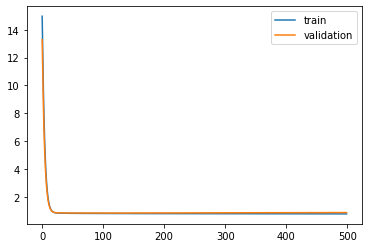

Time to train LSTM:  387.3704798221588
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 9s - loss: 15.0490 - pdc_loss: 0.7144 - event_loss: 0.6739 - val_loss: 13.3700 - val_pdc_loss: 0.6896 - val_event_loss: 0.6265

Epoch 00001: val_loss improved from inf to 13.37002, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 12.1708 - pdc_loss: 0.6709 - event_loss: 0.5968 - val_loss: 10.7740 - val_pdc_loss: 0.6625 - val_event_loss: 0.5584

Epoch 00002: val_loss improved from 13.37002 to 10.77403, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 9.7785 - pdc_loss: 0.6462 - event_loss: 0.5295 - val_loss: 8.6327 - val_pdc_loss: 0.6440 - val_event_loss: 0.4929

Epoch 00003: val_loss improved from 10.77403 to 8.63274, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 7.8172 - pdc_loss: 0.6287 - event_loss: 0.4626 - val_loss: 6.8889 - val_pdc_loss: 0.6285 - val_event_loss: 0.4274

Epoch 00004: val_loss improved from 8.63274 to 6.88890, 


Epoch 00035: val_loss improved from 0.85368 to 0.85315, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 0.8275 - pdc_loss: 0.5199 - event_loss: 0.2958 - val_loss: 0.8530 - val_pdc_loss: 0.5391 - val_event_loss: 0.3021

Epoch 00036: val_loss improved from 0.85315 to 0.85301, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.8270 - pdc_loss: 0.5195 - event_loss: 0.2957 - val_loss: 0.8526 - val_pdc_loss: 0.5388 - val_event_loss: 0.3020

Epoch 00037: val_loss improved from 0.85301 to 0.85261, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.8265 - pdc_loss: 0.5191 - event_loss: 0.2957 - val_loss: 0.8524 - val_pdc_loss: 0.5386 - val_event_loss: 0.3021

Epoch 00038: val_loss improved from 0.85261 to 0.85239, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5187 - event_loss: 0.2957 - val_loss: 0.8519 - val_pdc_loss: 0.5382 - val_event_loss: 0.3019

Epoch 00039: val_loss improved from 0.85239 to 


Epoch 00070: val_loss did not improve from 0.84525
Epoch 71/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5116 - event_loss: 0.2938 - val_loss: 0.8453 - val_pdc_loss: 0.5335 - val_event_loss: 0.3012

Epoch 00071: val_loss did not improve from 0.84525
Epoch 72/500
 - 1s - loss: 0.8158 - pdc_loss: 0.5115 - event_loss: 0.2937 - val_loss: 0.8453 - val_pdc_loss: 0.5334 - val_event_loss: 0.3013

Epoch 00072: val_loss did not improve from 0.84525
Epoch 73/500
 - 1s - loss: 0.8157 - pdc_loss: 0.5113 - event_loss: 0.2937 - val_loss: 0.8453 - val_pdc_loss: 0.5334 - val_event_loss: 0.3012

Epoch 00073: val_loss did not improve from 0.84525
Epoch 74/500
 - 1s - loss: 0.8155 - pdc_loss: 0.5112 - event_loss: 0.2936 - val_loss: 0.8454 - val_pdc_loss: 0.5334 - val_event_loss: 0.3013

Epoch 00074: val_loss did not improve from 0.84525
Epoch 75/500
 - 1s - loss: 0.8153 - pdc_loss: 0.5111 - event_loss: 0.2935 - val_loss: 0.8453 - val_pdc_loss: 0.5333 - val_event_loss: 0.3014

Epoch 00075: val_loss did not impr

 - 1s - loss: 0.8098 - pdc_loss: 0.5077 - event_loss: 0.2911 - val_loss: 0.8503 - val_pdc_loss: 0.5354 - val_event_loss: 0.3038

Epoch 00113: val_loss did not improve from 0.84515
Epoch 114/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5075 - event_loss: 0.2910 - val_loss: 0.8501 - val_pdc_loss: 0.5352 - val_event_loss: 0.3038

Epoch 00114: val_loss did not improve from 0.84515
Epoch 115/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5075 - event_loss: 0.2910 - val_loss: 0.8505 - val_pdc_loss: 0.5355 - val_event_loss: 0.3039

Epoch 00115: val_loss did not improve from 0.84515
Epoch 116/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5074 - event_loss: 0.2909 - val_loss: 0.8505 - val_pdc_loss: 0.5352 - val_event_loss: 0.3041

Epoch 00116: val_loss did not improve from 0.84515
Epoch 117/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5074 - event_loss: 0.2909 - val_loss: 0.8506 - val_pdc_loss: 0.5354 - val_event_loss: 0.3041

Epoch 00117: val_loss did not improve from 0.84515
Epoch 118/500
 - 1s - loss: 0.8096 - pdc_los


Epoch 00155: val_loss did not improve from 0.84515
Epoch 156/500
 - 1s - loss: 0.8045 - pdc_loss: 0.5035 - event_loss: 0.2890 - val_loss: 0.8542 - val_pdc_loss: 0.5366 - val_event_loss: 0.3056

Epoch 00156: val_loss did not improve from 0.84515
Epoch 157/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5035 - event_loss: 0.2890 - val_loss: 0.8552 - val_pdc_loss: 0.5374 - val_event_loss: 0.3058

Epoch 00157: val_loss did not improve from 0.84515
Epoch 158/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5031 - event_loss: 0.2890 - val_loss: 0.8547 - val_pdc_loss: 0.5366 - val_event_loss: 0.3060

Epoch 00158: val_loss did not improve from 0.84515
Epoch 159/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5031 - event_loss: 0.2889 - val_loss: 0.8551 - val_pdc_loss: 0.5375 - val_event_loss: 0.3056

Epoch 00159: val_loss did not improve from 0.84515
Epoch 160/500
 - 1s - loss: 0.8040 - pdc_loss: 0.5031 - event_loss: 0.2889 - val_loss: 0.8549 - val_pdc_loss: 0.5371 - val_event_loss: 0.3057

Epoch 00160: val_loss did not

 - 1s - loss: 0.8000 - pdc_loss: 0.5000 - event_loss: 0.2870 - val_loss: 0.8603 - val_pdc_loss: 0.5401 - val_event_loss: 0.3072

Epoch 00198: val_loss did not improve from 0.84515
Epoch 199/500
 - 1s - loss: 0.7995 - pdc_loss: 0.4999 - event_loss: 0.2867 - val_loss: 0.8601 - val_pdc_loss: 0.5397 - val_event_loss: 0.3074

Epoch 00199: val_loss did not improve from 0.84515
Epoch 200/500
 - 1s - loss: 0.7993 - pdc_loss: 0.4998 - event_loss: 0.2866 - val_loss: 0.8588 - val_pdc_loss: 0.5395 - val_event_loss: 0.3064

Epoch 00200: val_loss did not improve from 0.84515
Epoch 201/500
 - 1s - loss: 0.7990 - pdc_loss: 0.4997 - event_loss: 0.2864 - val_loss: 0.8597 - val_pdc_loss: 0.5396 - val_event_loss: 0.3070

Epoch 00201: val_loss did not improve from 0.84515
Epoch 202/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5002 - event_loss: 0.2867 - val_loss: 0.8588 - val_pdc_loss: 0.5395 - val_event_loss: 0.3063

Epoch 00202: val_loss did not improve from 0.84515
Epoch 203/500
 - 1s - loss: 0.7995 - pdc_los


Epoch 00240: val_loss did not improve from 0.84515
Epoch 241/500
 - 1s - loss: 0.7973 - pdc_loss: 0.4983 - event_loss: 0.2848 - val_loss: 0.8649 - val_pdc_loss: 0.5430 - val_event_loss: 0.3075

Epoch 00241: val_loss did not improve from 0.84515
Epoch 242/500
 - 1s - loss: 0.7973 - pdc_loss: 0.4980 - event_loss: 0.2850 - val_loss: 0.8633 - val_pdc_loss: 0.5430 - val_event_loss: 0.3061

Epoch 00242: val_loss did not improve from 0.84515
Epoch 243/500
 - 1s - loss: 0.7964 - pdc_loss: 0.4973 - event_loss: 0.2850 - val_loss: 0.8650 - val_pdc_loss: 0.5421 - val_event_loss: 0.3087

Epoch 00243: val_loss did not improve from 0.84515
Epoch 244/500
 - 1s - loss: 0.7965 - pdc_loss: 0.4974 - event_loss: 0.2849 - val_loss: 0.8674 - val_pdc_loss: 0.5445 - val_event_loss: 0.3088

Epoch 00244: val_loss did not improve from 0.84515
Epoch 245/500
 - 1s - loss: 0.7972 - pdc_loss: 0.4977 - event_loss: 0.2852 - val_loss: 0.8660 - val_pdc_loss: 0.5441 - val_event_loss: 0.3076

Epoch 00245: val_loss did not

 - 1s - loss: 0.7948 - pdc_loss: 0.4963 - event_loss: 0.2833 - val_loss: 0.8683 - val_pdc_loss: 0.5445 - val_event_loss: 0.3086

Epoch 00283: val_loss did not improve from 0.84515
Epoch 284/500
 - 1s - loss: 0.7941 - pdc_loss: 0.4956 - event_loss: 0.2833 - val_loss: 0.8699 - val_pdc_loss: 0.5459 - val_event_loss: 0.3088

Epoch 00284: val_loss did not improve from 0.84515
Epoch 285/500
 - 1s - loss: 0.7939 - pdc_loss: 0.4953 - event_loss: 0.2834 - val_loss: 0.8691 - val_pdc_loss: 0.5455 - val_event_loss: 0.3084

Epoch 00285: val_loss did not improve from 0.84515
Epoch 286/500
 - 1s - loss: 0.7939 - pdc_loss: 0.4958 - event_loss: 0.2830 - val_loss: 0.8691 - val_pdc_loss: 0.5455 - val_event_loss: 0.3086

Epoch 00286: val_loss did not improve from 0.84515
Epoch 287/500
 - 1s - loss: 0.7933 - pdc_loss: 0.4948 - event_loss: 0.2834 - val_loss: 0.8708 - val_pdc_loss: 0.5455 - val_event_loss: 0.3104

Epoch 00287: val_loss did not improve from 0.84515
Epoch 288/500
 - 1s - loss: 0.7939 - pdc_los


Epoch 00325: val_loss did not improve from 0.84515
Epoch 326/500
 - 1s - loss: 0.7920 - pdc_loss: 0.4939 - event_loss: 0.2821 - val_loss: 0.8744 - val_pdc_loss: 0.5471 - val_event_loss: 0.3114

Epoch 00326: val_loss did not improve from 0.84515
Epoch 327/500
 - 1s - loss: 0.7917 - pdc_loss: 0.4934 - event_loss: 0.2823 - val_loss: 0.8732 - val_pdc_loss: 0.5463 - val_event_loss: 0.3110

Epoch 00327: val_loss did not improve from 0.84515
Epoch 328/500
 - 1s - loss: 0.7911 - pdc_loss: 0.4935 - event_loss: 0.2816 - val_loss: 0.8725 - val_pdc_loss: 0.5466 - val_event_loss: 0.3099

Epoch 00328: val_loss did not improve from 0.84515
Epoch 329/500
 - 1s - loss: 0.7904 - pdc_loss: 0.4929 - event_loss: 0.2815 - val_loss: 0.8748 - val_pdc_loss: 0.5481 - val_event_loss: 0.3106

Epoch 00329: val_loss did not improve from 0.84515
Epoch 330/500
 - 1s - loss: 0.7909 - pdc_loss: 0.4935 - event_loss: 0.2814 - val_loss: 0.8747 - val_pdc_loss: 0.5483 - val_event_loss: 0.3104

Epoch 00330: val_loss did not

 - 1s - loss: 0.7891 - pdc_loss: 0.4913 - event_loss: 0.2808 - val_loss: 0.8831 - val_pdc_loss: 0.5511 - val_event_loss: 0.3150

Epoch 00368: val_loss did not improve from 0.84515
Epoch 369/500
 - 1s - loss: 0.7899 - pdc_loss: 0.4923 - event_loss: 0.2805 - val_loss: 0.8819 - val_pdc_loss: 0.5490 - val_event_loss: 0.3159

Epoch 00369: val_loss did not improve from 0.84515
Epoch 370/500
 - 1s - loss: 0.7900 - pdc_loss: 0.4922 - event_loss: 0.2807 - val_loss: 0.8824 - val_pdc_loss: 0.5499 - val_event_loss: 0.3154

Epoch 00370: val_loss did not improve from 0.84515
Epoch 371/500
 - 1s - loss: 0.7911 - pdc_loss: 0.4928 - event_loss: 0.2812 - val_loss: 0.8799 - val_pdc_loss: 0.5489 - val_event_loss: 0.3140

Epoch 00371: val_loss did not improve from 0.84515
Epoch 372/500
 - 1s - loss: 0.7917 - pdc_loss: 0.4934 - event_loss: 0.2811 - val_loss: 0.8814 - val_pdc_loss: 0.5487 - val_event_loss: 0.3155

Epoch 00372: val_loss did not improve from 0.84515
Epoch 373/500
 - 1s - loss: 0.7915 - pdc_los


Epoch 00410: val_loss did not improve from 0.84515
Epoch 411/500
 - 1s - loss: 0.7855 - pdc_loss: 0.4895 - event_loss: 0.2785 - val_loss: 0.8824 - val_pdc_loss: 0.5510 - val_event_loss: 0.3140

Epoch 00411: val_loss did not improve from 0.84515
Epoch 412/500
 - 1s - loss: 0.7862 - pdc_loss: 0.4897 - event_loss: 0.2791 - val_loss: 0.8828 - val_pdc_loss: 0.5503 - val_event_loss: 0.3151

Epoch 00412: val_loss did not improve from 0.84515
Epoch 413/500
 - 1s - loss: 0.7871 - pdc_loss: 0.4900 - event_loss: 0.2796 - val_loss: 0.8819 - val_pdc_loss: 0.5504 - val_event_loss: 0.3140

Epoch 00413: val_loss did not improve from 0.84515
Epoch 414/500
 - 1s - loss: 0.7867 - pdc_loss: 0.4904 - event_loss: 0.2788 - val_loss: 0.8804 - val_pdc_loss: 0.5499 - val_event_loss: 0.3129

Epoch 00414: val_loss did not improve from 0.84515
Epoch 415/500
 - 1s - loss: 0.7858 - pdc_loss: 0.4896 - event_loss: 0.2785 - val_loss: 0.8825 - val_pdc_loss: 0.5510 - val_event_loss: 0.3136

Epoch 00415: val_loss did not

 - 1s - loss: 0.7834 - pdc_loss: 0.4874 - event_loss: 0.2777 - val_loss: 0.8836 - val_pdc_loss: 0.5512 - val_event_loss: 0.3141

Epoch 00453: val_loss did not improve from 0.84515
Epoch 454/500
 - 1s - loss: 0.7837 - pdc_loss: 0.4883 - event_loss: 0.2771 - val_loss: 0.8856 - val_pdc_loss: 0.5509 - val_event_loss: 0.3163

Epoch 00454: val_loss did not improve from 0.84515
Epoch 455/500
 - 1s - loss: 0.7829 - pdc_loss: 0.4875 - event_loss: 0.2770 - val_loss: 0.8874 - val_pdc_loss: 0.5523 - val_event_loss: 0.3167

Epoch 00455: val_loss did not improve from 0.84515
Epoch 456/500
 - 1s - loss: 0.7831 - pdc_loss: 0.4878 - event_loss: 0.2771 - val_loss: 0.8851 - val_pdc_loss: 0.5517 - val_event_loss: 0.3153

Epoch 00456: val_loss did not improve from 0.84515
Epoch 457/500
 - 1s - loss: 0.7836 - pdc_loss: 0.4882 - event_loss: 0.2772 - val_loss: 0.8854 - val_pdc_loss: 0.5512 - val_event_loss: 0.3161

Epoch 00457: val_loss did not improve from 0.84515
Epoch 458/500
 - 1s - loss: 0.7828 - pdc_los


Epoch 00495: val_loss did not improve from 0.84515
Epoch 496/500
 - 1s - loss: 0.7826 - pdc_loss: 0.4868 - event_loss: 0.2769 - val_loss: 0.8905 - val_pdc_loss: 0.5539 - val_event_loss: 0.3178

Epoch 00496: val_loss did not improve from 0.84515
Epoch 497/500
 - 1s - loss: 0.7818 - pdc_loss: 0.4865 - event_loss: 0.2765 - val_loss: 0.8913 - val_pdc_loss: 0.5539 - val_event_loss: 0.3186

Epoch 00497: val_loss did not improve from 0.84515
Epoch 498/500
 - 1s - loss: 0.7824 - pdc_loss: 0.4869 - event_loss: 0.2767 - val_loss: 0.8904 - val_pdc_loss: 0.5539 - val_event_loss: 0.3176

Epoch 00498: val_loss did not improve from 0.84515
Epoch 499/500
 - 1s - loss: 0.7826 - pdc_loss: 0.4873 - event_loss: 0.2763 - val_loss: 0.8890 - val_pdc_loss: 0.5536 - val_event_loss: 0.3165

Epoch 00499: val_loss did not improve from 0.84515
Epoch 500/500
 - 1s - loss: 0.7814 - pdc_loss: 0.4862 - event_loss: 0.2763 - val_loss: 0.8860 - val_pdc_loss: 0.5517 - val_event_loss: 0.3155

Epoch 00500: val_loss did not

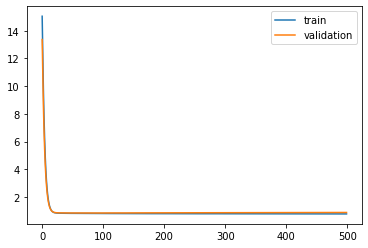

Time to train LSTM:  390.7041962146759
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 10s - loss: 14.9523 - pdc_loss: 0.6807 - event_loss: 0.6803 - val_loss: 13.2514 - val_pdc_loss: 0.6555 - val_event_loss: 0.5962

Epoch 00001: val_loss improved from inf to 13.25144, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 12.0494 - pdc_loss: 0.6424 - event_loss: 0.5487 - val_loss: 10.6380 - val_pdc_loss: 0.6248 - val_event_loss: 0.4958

Epoch 00002: val_loss improved from 13.25144 to 10.63798, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 9.6494 - pdc_loss: 0.6161 - event_loss: 0.4625 - val_loss: 8.4951 - val_pdc_loss: 0.6048 - val_event_loss: 0.4233

Epoch 00003: val_loss improved from 10.63798 to 8.49505, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 7.6938 - pdc_loss: 0.5989 - event_loss: 0.3975 - val_loss: 6.7641 - val_pdc_loss: 0.5918 - val_event_loss: 0.3678

Epoch 00004: val_loss improved from 8.49505 to 6.76410,


Epoch 00035: val_loss improved from 0.83795 to 0.83769, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.8306 - pdc_loss: 0.5228 - event_loss: 0.2961 - val_loss: 0.8374 - val_pdc_loss: 0.5280 - val_event_loss: 0.2977

Epoch 00036: val_loss improved from 0.83769 to 0.83743, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.8300 - pdc_loss: 0.5224 - event_loss: 0.2960 - val_loss: 0.8371 - val_pdc_loss: 0.5278 - val_event_loss: 0.2976

Epoch 00037: val_loss improved from 0.83743 to 0.83706, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.8296 - pdc_loss: 0.5220 - event_loss: 0.2960 - val_loss: 0.8368 - val_pdc_loss: 0.5275 - val_event_loss: 0.2977

Epoch 00038: val_loss improved from 0.83706 to 0.83678, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 0.8290 - pdc_loss: 0.5216 - event_loss: 0.2959 - val_loss: 0.8365 - val_pdc_loss: 0.5273 - val_event_loss: 0.2977

Epoch 00039: val_loss improved from 0.83678 to 


Epoch 00070: val_loss did not improve from 0.82817
Epoch 71/500
 - 1s - loss: 0.8184 - pdc_loss: 0.5134 - event_loss: 0.2944 - val_loss: 0.8285 - val_pdc_loss: 0.5189 - val_event_loss: 0.2990

Epoch 00071: val_loss did not improve from 0.82817
Epoch 72/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5132 - event_loss: 0.2943 - val_loss: 0.8284 - val_pdc_loss: 0.5190 - val_event_loss: 0.2988

Epoch 00072: val_loss did not improve from 0.82817
Epoch 73/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5132 - event_loss: 0.2943 - val_loss: 0.8287 - val_pdc_loss: 0.5191 - val_event_loss: 0.2989

Epoch 00073: val_loss did not improve from 0.82817
Epoch 74/500
 - 1s - loss: 0.8180 - pdc_loss: 0.5130 - event_loss: 0.2943 - val_loss: 0.8287 - val_pdc_loss: 0.5191 - val_event_loss: 0.2989

Epoch 00074: val_loss did not improve from 0.82817
Epoch 75/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5128 - event_loss: 0.2942 - val_loss: 0.8289 - val_pdc_loss: 0.5192 - val_event_loss: 0.2989

Epoch 00075: val_loss did not impr


Epoch 00113: val_loss did not improve from 0.82817
Epoch 114/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5075 - event_loss: 0.2920 - val_loss: 0.8313 - val_pdc_loss: 0.5212 - val_event_loss: 0.2983

Epoch 00114: val_loss did not improve from 0.82817
Epoch 115/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5074 - event_loss: 0.2920 - val_loss: 0.8310 - val_pdc_loss: 0.5207 - val_event_loss: 0.2984

Epoch 00115: val_loss did not improve from 0.82817
Epoch 116/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5074 - event_loss: 0.2919 - val_loss: 0.8315 - val_pdc_loss: 0.5213 - val_event_loss: 0.2982

Epoch 00116: val_loss did not improve from 0.82817
Epoch 117/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5071 - event_loss: 0.2919 - val_loss: 0.8302 - val_pdc_loss: 0.5202 - val_event_loss: 0.2980

Epoch 00117: val_loss did not improve from 0.82817
Epoch 118/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5069 - event_loss: 0.2917 - val_loss: 0.8312 - val_pdc_loss: 0.5208 - val_event_loss: 0.2983

Epoch 00118: val_loss did not

 - 1s - loss: 0.8062 - pdc_loss: 0.5033 - event_loss: 0.2896 - val_loss: 0.8335 - val_pdc_loss: 0.5200 - val_event_loss: 0.3002

Epoch 00156: val_loss did not improve from 0.82817
Epoch 157/500
 - 1s - loss: 0.8054 - pdc_loss: 0.5025 - event_loss: 0.2897 - val_loss: 0.8325 - val_pdc_loss: 0.5196 - val_event_loss: 0.2998

Epoch 00157: val_loss did not improve from 0.82817
Epoch 158/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5020 - event_loss: 0.2899 - val_loss: 0.8339 - val_pdc_loss: 0.5210 - val_event_loss: 0.2998

Epoch 00158: val_loss did not improve from 0.82817
Epoch 159/500
 - 1s - loss: 0.8053 - pdc_loss: 0.5025 - event_loss: 0.2897 - val_loss: 0.8344 - val_pdc_loss: 0.5215 - val_event_loss: 0.2998

Epoch 00159: val_loss did not improve from 0.82817
Epoch 160/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5028 - event_loss: 0.2897 - val_loss: 0.8363 - val_pdc_loss: 0.5229 - val_event_loss: 0.3002

Epoch 00160: val_loss did not improve from 0.82817
Epoch 161/500
 - 1s - loss: 0.8066 - pdc_los


Epoch 00198: val_loss did not improve from 0.82817
Epoch 199/500
 - 1s - loss: 0.8028 - pdc_loss: 0.5000 - event_loss: 0.2888 - val_loss: 0.8413 - val_pdc_loss: 0.5261 - val_event_loss: 0.3011

Epoch 00199: val_loss did not improve from 0.82817
Epoch 200/500
 - 1s - loss: 0.8020 - pdc_loss: 0.4995 - event_loss: 0.2884 - val_loss: 0.8389 - val_pdc_loss: 0.5242 - val_event_loss: 0.3006

Epoch 00200: val_loss did not improve from 0.82817
Epoch 201/500
 - 1s - loss: 0.8011 - pdc_loss: 0.4989 - event_loss: 0.2882 - val_loss: 0.8401 - val_pdc_loss: 0.5257 - val_event_loss: 0.3004

Epoch 00201: val_loss did not improve from 0.82817
Epoch 202/500
 - 1s - loss: 0.8006 - pdc_loss: 0.4987 - event_loss: 0.2880 - val_loss: 0.8411 - val_pdc_loss: 0.5259 - val_event_loss: 0.3011

Epoch 00202: val_loss did not improve from 0.82817
Epoch 203/500
 - 1s - loss: 0.8010 - pdc_loss: 0.4990 - event_loss: 0.2880 - val_loss: 0.8425 - val_pdc_loss: 0.5266 - val_event_loss: 0.3018

Epoch 00203: val_loss did not

 - 1s - loss: 0.7984 - pdc_loss: 0.4969 - event_loss: 0.2866 - val_loss: 0.8477 - val_pdc_loss: 0.5296 - val_event_loss: 0.3032

Epoch 00241: val_loss did not improve from 0.82817
Epoch 242/500
 - 1s - loss: 0.7979 - pdc_loss: 0.4963 - event_loss: 0.2867 - val_loss: 0.8465 - val_pdc_loss: 0.5282 - val_event_loss: 0.3034

Epoch 00242: val_loss did not improve from 0.82817
Epoch 243/500
 - 1s - loss: 0.7989 - pdc_loss: 0.4968 - event_loss: 0.2873 - val_loss: 0.8428 - val_pdc_loss: 0.5272 - val_event_loss: 0.3006

Epoch 00243: val_loss did not improve from 0.82817
Epoch 244/500
 - 1s - loss: 0.7990 - pdc_loss: 0.4971 - event_loss: 0.2870 - val_loss: 0.8446 - val_pdc_loss: 0.5283 - val_event_loss: 0.3014

Epoch 00244: val_loss did not improve from 0.82817
Epoch 245/500
 - 1s - loss: 0.7991 - pdc_loss: 0.4970 - event_loss: 0.2872 - val_loss: 0.8495 - val_pdc_loss: 0.5313 - val_event_loss: 0.3033

Epoch 00245: val_loss did not improve from 0.82817
Epoch 246/500
 - 1s - loss: 0.7992 - pdc_los


Epoch 00283: val_loss did not improve from 0.82817
Epoch 284/500
 - 1s - loss: 0.7938 - pdc_loss: 0.4929 - event_loss: 0.2853 - val_loss: 0.8493 - val_pdc_loss: 0.5311 - val_event_loss: 0.3025

Epoch 00284: val_loss did not improve from 0.82817
Epoch 285/500
 - 1s - loss: 0.7945 - pdc_loss: 0.4932 - event_loss: 0.2856 - val_loss: 0.8524 - val_pdc_loss: 0.5322 - val_event_loss: 0.3044

Epoch 00285: val_loss did not improve from 0.82817
Epoch 286/500
 - 1s - loss: 0.7946 - pdc_loss: 0.4934 - event_loss: 0.2853 - val_loss: 0.8523 - val_pdc_loss: 0.5317 - val_event_loss: 0.3045

Epoch 00286: val_loss did not improve from 0.82817
Epoch 287/500
 - 1s - loss: 0.7955 - pdc_loss: 0.4941 - event_loss: 0.2854 - val_loss: 0.8528 - val_pdc_loss: 0.5323 - val_event_loss: 0.3044

Epoch 00287: val_loss did not improve from 0.82817
Epoch 288/500
 - 1s - loss: 0.7956 - pdc_loss: 0.4944 - event_loss: 0.2853 - val_loss: 0.8524 - val_pdc_loss: 0.5329 - val_event_loss: 0.3035

Epoch 00288: val_loss did not

 - 1s - loss: 0.7929 - pdc_loss: 0.4918 - event_loss: 0.2845 - val_loss: 0.8541 - val_pdc_loss: 0.5335 - val_event_loss: 0.3040

Epoch 00326: val_loss did not improve from 0.82817
Epoch 327/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4913 - event_loss: 0.2849 - val_loss: 0.8544 - val_pdc_loss: 0.5334 - val_event_loss: 0.3044

Epoch 00327: val_loss did not improve from 0.82817
Epoch 328/500
 - 1s - loss: 0.7929 - pdc_loss: 0.4915 - event_loss: 0.2848 - val_loss: 0.8549 - val_pdc_loss: 0.5325 - val_event_loss: 0.3057

Epoch 00328: val_loss did not improve from 0.82817
Epoch 329/500
 - 1s - loss: 0.7932 - pdc_loss: 0.4917 - event_loss: 0.2847 - val_loss: 0.8572 - val_pdc_loss: 0.5342 - val_event_loss: 0.3061

Epoch 00329: val_loss did not improve from 0.82817
Epoch 330/500
 - 1s - loss: 0.7932 - pdc_loss: 0.4922 - event_loss: 0.2842 - val_loss: 0.8564 - val_pdc_loss: 0.5334 - val_event_loss: 0.3061

Epoch 00330: val_loss did not improve from 0.82817
Epoch 331/500
 - 1s - loss: 0.7931 - pdc_los


Epoch 00368: val_loss did not improve from 0.82817
Epoch 369/500
 - 1s - loss: 0.7885 - pdc_loss: 0.4887 - event_loss: 0.2828 - val_loss: 0.8599 - val_pdc_loss: 0.5354 - val_event_loss: 0.3073

Epoch 00369: val_loss did not improve from 0.82817
Epoch 370/500
 - 1s - loss: 0.7884 - pdc_loss: 0.4885 - event_loss: 0.2828 - val_loss: 0.8606 - val_pdc_loss: 0.5369 - val_event_loss: 0.3064

Epoch 00370: val_loss did not improve from 0.82817
Epoch 371/500
 - 1s - loss: 0.7902 - pdc_loss: 0.4895 - event_loss: 0.2833 - val_loss: 0.8628 - val_pdc_loss: 0.5380 - val_event_loss: 0.3074

Epoch 00371: val_loss did not improve from 0.82817
Epoch 372/500
 - 1s - loss: 0.7903 - pdc_loss: 0.4897 - event_loss: 0.2832 - val_loss: 0.8631 - val_pdc_loss: 0.5387 - val_event_loss: 0.3070

Epoch 00372: val_loss did not improve from 0.82817
Epoch 373/500
 - 1s - loss: 0.7911 - pdc_loss: 0.4906 - event_loss: 0.2830 - val_loss: 0.8597 - val_pdc_loss: 0.5360 - val_event_loss: 0.3061

Epoch 00373: val_loss did not

 - 1s - loss: 0.7866 - pdc_loss: 0.4871 - event_loss: 0.2820 - val_loss: 0.8622 - val_pdc_loss: 0.5375 - val_event_loss: 0.3071

Epoch 00411: val_loss did not improve from 0.82817
Epoch 412/500
 - 1s - loss: 0.7868 - pdc_loss: 0.4872 - event_loss: 0.2820 - val_loss: 0.8642 - val_pdc_loss: 0.5394 - val_event_loss: 0.3073

Epoch 00412: val_loss did not improve from 0.82817
Epoch 413/500
 - 1s - loss: 0.7880 - pdc_loss: 0.4886 - event_loss: 0.2819 - val_loss: 0.8647 - val_pdc_loss: 0.5388 - val_event_loss: 0.3082

Epoch 00413: val_loss did not improve from 0.82817
Epoch 414/500
 - 1s - loss: 0.7871 - pdc_loss: 0.4875 - event_loss: 0.2820 - val_loss: 0.8650 - val_pdc_loss: 0.5387 - val_event_loss: 0.3087

Epoch 00414: val_loss did not improve from 0.82817
Epoch 415/500
 - 1s - loss: 0.7866 - pdc_loss: 0.4870 - event_loss: 0.2819 - val_loss: 0.8647 - val_pdc_loss: 0.5388 - val_event_loss: 0.3082

Epoch 00415: val_loss did not improve from 0.82817
Epoch 416/500
 - 1s - loss: 0.7864 - pdc_los


Epoch 00453: val_loss did not improve from 0.82817
Epoch 454/500
 - 1s - loss: 0.7854 - pdc_loss: 0.4861 - event_loss: 0.2811 - val_loss: 0.8664 - val_pdc_loss: 0.5381 - val_event_loss: 0.3100

Epoch 00454: val_loss did not improve from 0.82817
Epoch 455/500
 - 1s - loss: 0.7846 - pdc_loss: 0.4854 - event_loss: 0.2809 - val_loss: 0.8673 - val_pdc_loss: 0.5403 - val_event_loss: 0.3084

Epoch 00455: val_loss did not improve from 0.82817
Epoch 456/500
 - 1s - loss: 0.7857 - pdc_loss: 0.4860 - event_loss: 0.2812 - val_loss: 0.8666 - val_pdc_loss: 0.5385 - val_event_loss: 0.3095

Epoch 00456: val_loss did not improve from 0.82817
Epoch 457/500
 - 1s - loss: 0.7854 - pdc_loss: 0.4857 - event_loss: 0.2812 - val_loss: 0.8703 - val_pdc_loss: 0.5423 - val_event_loss: 0.3092

Epoch 00457: val_loss did not improve from 0.82817
Epoch 458/500
 - 1s - loss: 0.7860 - pdc_loss: 0.4857 - event_loss: 0.2817 - val_loss: 0.8704 - val_pdc_loss: 0.5412 - val_event_loss: 0.3106

Epoch 00458: val_loss did not

 - 1s - loss: 0.7822 - pdc_loss: 0.4838 - event_loss: 0.2796 - val_loss: 0.8720 - val_pdc_loss: 0.5422 - val_event_loss: 0.3110

Epoch 00496: val_loss did not improve from 0.82817
Epoch 497/500
 - 1s - loss: 0.7820 - pdc_loss: 0.4833 - event_loss: 0.2799 - val_loss: 0.8705 - val_pdc_loss: 0.5416 - val_event_loss: 0.3100

Epoch 00497: val_loss did not improve from 0.82817
Epoch 498/500
 - 1s - loss: 0.7825 - pdc_loss: 0.4836 - event_loss: 0.2802 - val_loss: 0.8734 - val_pdc_loss: 0.5436 - val_event_loss: 0.3109

Epoch 00498: val_loss did not improve from 0.82817
Epoch 499/500
 - 1s - loss: 0.7828 - pdc_loss: 0.4842 - event_loss: 0.2798 - val_loss: 0.8695 - val_pdc_loss: 0.5415 - val_event_loss: 0.3091

Epoch 00499: val_loss did not improve from 0.82817
Epoch 500/500
 - 1s - loss: 0.7822 - pdc_loss: 0.4837 - event_loss: 0.2795 - val_loss: 0.8697 - val_pdc_loss: 0.5403 - val_event_loss: 0.3104

Epoch 00500: val_loss did not improve from 0.82817
#################################
Number of 

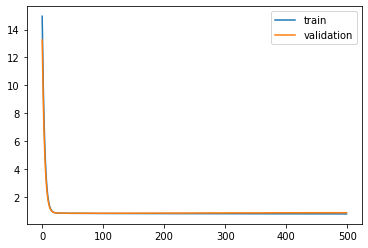

Time to train LSTM:  389.5519530773163
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 10s - loss: 15.7499 - pdc_loss: 0.7489 - event_loss: 0.6821 - val_loss: 14.7630 - val_pdc_loss: 0.7197 - val_event_loss: 0.6378

Epoch 00001: val_loss improved from inf to 14.76305, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 14.1666 - pdc_loss: 0.7064 - event_loss: 0.6222 - val_loss: 13.2637 - val_pdc_loss: 0.6855 - val_event_loss: 0.5847

Epoch 00002: val_loss improved from 14.76305 to 13.26370, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 12.7208 - pdc_loss: 0.6757 - event_loss: 0.5740 - val_loss: 11.8976 - val_pdc_loss: 0.6610 - val_event_loss: 0.5411

Epoch 00003: val_loss improved from 13.26370 to 11.89765, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 11.4053 - pdc_loss: 0.6536 - event_loss: 0.5337 - val_loss: 10.6567 - val_pdc_loss: 0.6430 - val_event_loss: 0.5034

Epoch 00004: val_loss improved from 11.89765 to 10

 - 1s - loss: 0.9491 - pdc_loss: 0.5366 - event_loss: 0.2976 - val_loss: 0.9363 - val_pdc_loss: 0.5386 - val_event_loss: 0.2934

Epoch 00035: val_loss improved from 0.95561 to 0.93631, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 0.9310 - pdc_loss: 0.5353 - event_loss: 0.2976 - val_loss: 0.9198 - val_pdc_loss: 0.5372 - val_event_loss: 0.2934

Epoch 00036: val_loss improved from 0.93631 to 0.91978, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 0.9155 - pdc_loss: 0.5340 - event_loss: 0.2975 - val_loss: 0.9056 - val_pdc_loss: 0.5359 - val_event_loss: 0.2933

Epoch 00037: val_loss improved from 0.91978 to 0.90564, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 0.9023 - pdc_loss: 0.5328 - event_loss: 0.2975 - val_loss: 0.8935 - val_pdc_loss: 0.5346 - val_event_loss: 0.2932

Epoch 00038: val_loss improved from 0.90564 to 0.89353, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 0.8911 - pdc_loss: 0.5317 - event_


Epoch 00069: val_loss improved from 0.82412 to 0.82406, saving model to Event_val_weights1.hdf5
Epoch 70/500
 - 1s - loss: 0.8247 - pdc_loss: 0.5184 - event_loss: 0.2957 - val_loss: 0.8238 - val_pdc_loss: 0.5219 - val_event_loss: 0.2914

Epoch 00070: val_loss improved from 0.82406 to 0.82378, saving model to Event_val_weights1.hdf5
Epoch 71/500
 - 1s - loss: 0.8243 - pdc_loss: 0.5182 - event_loss: 0.2957 - val_loss: 0.8238 - val_pdc_loss: 0.5219 - val_event_loss: 0.2915

Epoch 00071: val_loss did not improve from 0.82378
Epoch 72/500
 - 1s - loss: 0.8241 - pdc_loss: 0.5180 - event_loss: 0.2956 - val_loss: 0.8235 - val_pdc_loss: 0.5217 - val_event_loss: 0.2913

Epoch 00072: val_loss improved from 0.82378 to 0.82349, saving model to Event_val_weights1.hdf5
Epoch 73/500
 - 1s - loss: 0.8238 - pdc_loss: 0.5178 - event_loss: 0.2956 - val_loss: 0.8234 - val_pdc_loss: 0.5216 - val_event_loss: 0.2914

Epoch 00073: val_loss improved from 0.82349 to 0.82341, saving model to Event_val_weights1.h


Epoch 00109: val_loss did not improve from 0.82095
Epoch 110/500
 - 1s - loss: 0.8156 - pdc_loss: 0.5116 - event_loss: 0.2939 - val_loss: 0.8213 - val_pdc_loss: 0.5200 - val_event_loss: 0.2911

Epoch 00110: val_loss did not improve from 0.82095
Epoch 111/500
 - 1s - loss: 0.8155 - pdc_loss: 0.5115 - event_loss: 0.2938 - val_loss: 0.8212 - val_pdc_loss: 0.5200 - val_event_loss: 0.2911

Epoch 00111: val_loss did not improve from 0.82095
Epoch 112/500
 - 1s - loss: 0.8154 - pdc_loss: 0.5115 - event_loss: 0.2938 - val_loss: 0.8216 - val_pdc_loss: 0.5202 - val_event_loss: 0.2913

Epoch 00112: val_loss did not improve from 0.82095
Epoch 113/500
 - 1s - loss: 0.8154 - pdc_loss: 0.5115 - event_loss: 0.2938 - val_loss: 0.8219 - val_pdc_loss: 0.5203 - val_event_loss: 0.2915

Epoch 00113: val_loss did not improve from 0.82095
Epoch 114/500
 - 1s - loss: 0.8154 - pdc_loss: 0.5116 - event_loss: 0.2938 - val_loss: 0.8222 - val_pdc_loss: 0.5205 - val_event_loss: 0.2916

Epoch 00114: val_loss did not

 - 1s - loss: 0.8099 - pdc_loss: 0.5070 - event_loss: 0.2918 - val_loss: 0.8244 - val_pdc_loss: 0.5202 - val_event_loss: 0.2931

Epoch 00152: val_loss did not improve from 0.82095
Epoch 153/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5070 - event_loss: 0.2917 - val_loss: 0.8249 - val_pdc_loss: 0.5203 - val_event_loss: 0.2935

Epoch 00153: val_loss did not improve from 0.82095
Epoch 154/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5069 - event_loss: 0.2917 - val_loss: 0.8248 - val_pdc_loss: 0.5205 - val_event_loss: 0.2932

Epoch 00154: val_loss did not improve from 0.82095
Epoch 155/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5069 - event_loss: 0.2917 - val_loss: 0.8256 - val_pdc_loss: 0.5205 - val_event_loss: 0.2939

Epoch 00155: val_loss did not improve from 0.82095
Epoch 156/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5068 - event_loss: 0.2916 - val_loss: 0.8261 - val_pdc_loss: 0.5208 - val_event_loss: 0.2941

Epoch 00156: val_loss did not improve from 0.82095
Epoch 157/500
 - 1s - loss: 0.8095 - pdc_los


Epoch 00194: val_loss did not improve from 0.82095
Epoch 195/500
 - 1s - loss: 0.8042 - pdc_loss: 0.5027 - event_loss: 0.2894 - val_loss: 0.8293 - val_pdc_loss: 0.5220 - val_event_loss: 0.2952

Epoch 00195: val_loss did not improve from 0.82095
Epoch 196/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5027 - event_loss: 0.2894 - val_loss: 0.8296 - val_pdc_loss: 0.5223 - val_event_loss: 0.2953

Epoch 00196: val_loss did not improve from 0.82095
Epoch 197/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5025 - event_loss: 0.2893 - val_loss: 0.8294 - val_pdc_loss: 0.5221 - val_event_loss: 0.2953

Epoch 00197: val_loss did not improve from 0.82095
Epoch 198/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5024 - event_loss: 0.2893 - val_loss: 0.8299 - val_pdc_loss: 0.5223 - val_event_loss: 0.2955

Epoch 00198: val_loss did not improve from 0.82095
Epoch 199/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5024 - event_loss: 0.2893 - val_loss: 0.8296 - val_pdc_loss: 0.5222 - val_event_loss: 0.2952

Epoch 00199: val_loss did not

 - 1s - loss: 0.7995 - pdc_loss: 0.4994 - event_loss: 0.2874 - val_loss: 0.8345 - val_pdc_loss: 0.5247 - val_event_loss: 0.2971

Epoch 00237: val_loss did not improve from 0.82095
Epoch 238/500
 - 1s - loss: 0.7997 - pdc_loss: 0.4997 - event_loss: 0.2873 - val_loss: 0.8353 - val_pdc_loss: 0.5250 - val_event_loss: 0.2975

Epoch 00238: val_loss did not improve from 0.82095
Epoch 239/500
 - 1s - loss: 0.8000 - pdc_loss: 0.5000 - event_loss: 0.2872 - val_loss: 0.8358 - val_pdc_loss: 0.5261 - val_event_loss: 0.2970

Epoch 00239: val_loss did not improve from 0.82095
Epoch 240/500
 - 1s - loss: 0.8005 - pdc_loss: 0.5006 - event_loss: 0.2870 - val_loss: 0.8370 - val_pdc_loss: 0.5267 - val_event_loss: 0.2974

Epoch 00240: val_loss did not improve from 0.82095
Epoch 241/500
 - 1s - loss: 0.8006 - pdc_loss: 0.5007 - event_loss: 0.2870 - val_loss: 0.8356 - val_pdc_loss: 0.5252 - val_event_loss: 0.2974

Epoch 00241: val_loss did not improve from 0.82095
Epoch 242/500
 - 1s - loss: 0.8003 - pdc_los


Epoch 00279: val_loss did not improve from 0.82095
Epoch 280/500
 - 1s - loss: 0.7981 - pdc_loss: 0.4975 - event_loss: 0.2868 - val_loss: 0.8439 - val_pdc_loss: 0.5250 - val_event_loss: 0.3053

Epoch 00280: val_loss did not improve from 0.82095
Epoch 281/500
 - 1s - loss: 0.7976 - pdc_loss: 0.4958 - event_loss: 0.2881 - val_loss: 0.8424 - val_pdc_loss: 0.5241 - val_event_loss: 0.3045

Epoch 00281: val_loss did not improve from 0.82095
Epoch 282/500
 - 1s - loss: 0.7978 - pdc_loss: 0.4955 - event_loss: 0.2885 - val_loss: 0.8410 - val_pdc_loss: 0.5261 - val_event_loss: 0.3011

Epoch 00282: val_loss did not improve from 0.82095
Epoch 283/500
 - 1s - loss: 0.7997 - pdc_loss: 0.4978 - event_loss: 0.2881 - val_loss: 0.8392 - val_pdc_loss: 0.5267 - val_event_loss: 0.2986

Epoch 00283: val_loss did not improve from 0.82095
Epoch 284/500
 - 1s - loss: 0.8018 - pdc_loss: 0.5001 - event_loss: 0.2877 - val_loss: 0.8381 - val_pdc_loss: 0.5247 - val_event_loss: 0.2994

Epoch 00284: val_loss did not

 - 1s - loss: 0.7942 - pdc_loss: 0.4948 - event_loss: 0.2854 - val_loss: 0.8461 - val_pdc_loss: 0.5302 - val_event_loss: 0.3019

Epoch 00322: val_loss did not improve from 0.82095
Epoch 323/500
 - 1s - loss: 0.7930 - pdc_loss: 0.4942 - event_loss: 0.2848 - val_loss: 0.8445 - val_pdc_loss: 0.5299 - val_event_loss: 0.3007

Epoch 00323: val_loss did not improve from 0.82095
Epoch 324/500
 - 1s - loss: 0.7915 - pdc_loss: 0.4936 - event_loss: 0.2839 - val_loss: 0.8451 - val_pdc_loss: 0.5302 - val_event_loss: 0.3010

Epoch 00324: val_loss did not improve from 0.82095
Epoch 325/500
 - 1s - loss: 0.7907 - pdc_loss: 0.4933 - event_loss: 0.2836 - val_loss: 0.8453 - val_pdc_loss: 0.5300 - val_event_loss: 0.3014

Epoch 00325: val_loss did not improve from 0.82095
Epoch 326/500
 - 1s - loss: 0.7911 - pdc_loss: 0.4934 - event_loss: 0.2838 - val_loss: 0.8435 - val_pdc_loss: 0.5289 - val_event_loss: 0.3008

Epoch 00326: val_loss did not improve from 0.82095
Epoch 327/500
 - 1s - loss: 0.7916 - pdc_los


Epoch 00364: val_loss did not improve from 0.82095
Epoch 365/500
 - 1s - loss: 0.7910 - pdc_loss: 0.4938 - event_loss: 0.2831 - val_loss: 0.8544 - val_pdc_loss: 0.5369 - val_event_loss: 0.3034

Epoch 00365: val_loss did not improve from 0.82095
Epoch 366/500
 - 1s - loss: 0.7909 - pdc_loss: 0.4942 - event_loss: 0.2827 - val_loss: 0.8514 - val_pdc_loss: 0.5344 - val_event_loss: 0.3030

Epoch 00366: val_loss did not improve from 0.82095
Epoch 367/500
 - 1s - loss: 0.7904 - pdc_loss: 0.4937 - event_loss: 0.2826 - val_loss: 0.8519 - val_pdc_loss: 0.5353 - val_event_loss: 0.3025

Epoch 00367: val_loss did not improve from 0.82095
Epoch 368/500
 - 1s - loss: 0.7896 - pdc_loss: 0.4930 - event_loss: 0.2825 - val_loss: 0.8513 - val_pdc_loss: 0.5338 - val_event_loss: 0.3034

Epoch 00368: val_loss did not improve from 0.82095
Epoch 369/500
 - 1s - loss: 0.7898 - pdc_loss: 0.4930 - event_loss: 0.2827 - val_loss: 0.8512 - val_pdc_loss: 0.5338 - val_event_loss: 0.3034

Epoch 00369: val_loss did not

 - 1s - loss: 0.7864 - pdc_loss: 0.4903 - event_loss: 0.2821 - val_loss: 0.8542 - val_pdc_loss: 0.5344 - val_event_loss: 0.3058

Epoch 00407: val_loss did not improve from 0.82095
Epoch 408/500
 - 1s - loss: 0.7863 - pdc_loss: 0.4907 - event_loss: 0.2815 - val_loss: 0.8548 - val_pdc_loss: 0.5349 - val_event_loss: 0.3058

Epoch 00408: val_loss did not improve from 0.82095
Epoch 409/500
 - 1s - loss: 0.7861 - pdc_loss: 0.4902 - event_loss: 0.2818 - val_loss: 0.8540 - val_pdc_loss: 0.5339 - val_event_loss: 0.3061

Epoch 00409: val_loss did not improve from 0.82095
Epoch 410/500
 - 1s - loss: 0.7861 - pdc_loss: 0.4899 - event_loss: 0.2822 - val_loss: 0.8548 - val_pdc_loss: 0.5346 - val_event_loss: 0.3061

Epoch 00410: val_loss did not improve from 0.82095
Epoch 411/500
 - 1s - loss: 0.7862 - pdc_loss: 0.4901 - event_loss: 0.2820 - val_loss: 0.8540 - val_pdc_loss: 0.5351 - val_event_loss: 0.3048

Epoch 00411: val_loss did not improve from 0.82095
Epoch 412/500
 - 1s - loss: 0.7866 - pdc_los


Epoch 00449: val_loss did not improve from 0.82095
Epoch 450/500
 - 1s - loss: 0.7857 - pdc_loss: 0.4896 - event_loss: 0.2818 - val_loss: 0.8588 - val_pdc_loss: 0.5375 - val_event_loss: 0.3070

Epoch 00450: val_loss did not improve from 0.82095
Epoch 451/500
 - 1s - loss: 0.7849 - pdc_loss: 0.4894 - event_loss: 0.2812 - val_loss: 0.8577 - val_pdc_loss: 0.5369 - val_event_loss: 0.3065

Epoch 00451: val_loss did not improve from 0.82095
Epoch 452/500
 - 1s - loss: 0.7846 - pdc_loss: 0.4890 - event_loss: 0.2812 - val_loss: 0.8571 - val_pdc_loss: 0.5363 - val_event_loss: 0.3065

Epoch 00452: val_loss did not improve from 0.82095
Epoch 453/500
 - 1s - loss: 0.7851 - pdc_loss: 0.4889 - event_loss: 0.2819 - val_loss: 0.8580 - val_pdc_loss: 0.5366 - val_event_loss: 0.3071

Epoch 00453: val_loss did not improve from 0.82095
Epoch 454/500
 - 1s - loss: 0.7846 - pdc_loss: 0.4887 - event_loss: 0.2816 - val_loss: 0.8576 - val_pdc_loss: 0.5365 - val_event_loss: 0.3069

Epoch 00454: val_loss did not

 - 1s - loss: 0.7824 - pdc_loss: 0.4877 - event_loss: 0.2803 - val_loss: 0.8597 - val_pdc_loss: 0.5381 - val_event_loss: 0.3072

Epoch 00492: val_loss did not improve from 0.82095
Epoch 493/500
 - 1s - loss: 0.7824 - pdc_loss: 0.4879 - event_loss: 0.2801 - val_loss: 0.8611 - val_pdc_loss: 0.5381 - val_event_loss: 0.3085

Epoch 00493: val_loss did not improve from 0.82095
Epoch 494/500
 - 1s - loss: 0.7826 - pdc_loss: 0.4880 - event_loss: 0.2802 - val_loss: 0.8614 - val_pdc_loss: 0.5387 - val_event_loss: 0.3084

Epoch 00494: val_loss did not improve from 0.82095
Epoch 495/500
 - 1s - loss: 0.7827 - pdc_loss: 0.4880 - event_loss: 0.2804 - val_loss: 0.8612 - val_pdc_loss: 0.5390 - val_event_loss: 0.3079

Epoch 00495: val_loss did not improve from 0.82095
Epoch 496/500
 - 1s - loss: 0.7834 - pdc_loss: 0.4883 - event_loss: 0.2808 - val_loss: 0.8596 - val_pdc_loss: 0.5379 - val_event_loss: 0.3073

Epoch 00496: val_loss did not improve from 0.82095
Epoch 497/500
 - 1s - loss: 0.7829 - pdc_los

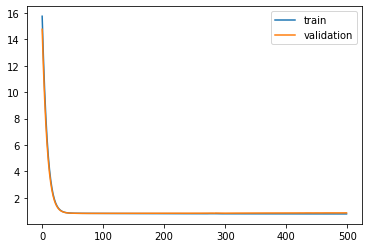

Time to train LSTM:  366.79098105430603
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 10s - loss: 15.7996 - pdc_loss: 0.6867 - event_loss: 0.7019 - val_loss: 14.8258 - val_pdc_loss: 0.6656 - val_event_loss: 0.6708

Epoch 00001: val_loss improved from inf to 14.82585, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 14.2318 - pdc_loss: 0.6622 - event_loss: 0.6524 - val_loss: 13.3402 - val_pdc_loss: 0.6468 - val_event_loss: 0.6272

Epoch 00002: val_loss improved from 14.82585 to 13.34018, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 12.7948 - pdc_loss: 0.6445 - event_loss: 0.6102 - val_loss: 11.9820 - val_pdc_loss: 0.6332 - val_event_loss: 0.5891

Epoch 00003: val_loss improved from 13.34018 to 11.98204, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 11.4831 - pdc_loss: 0.6312 - event_loss: 0.5723 - val_loss: 10.7449 - val_pdc_loss: 0.6226 - val_event_loss: 0.5539

Epoch 00004: val_loss improved from 11.98204 to 1

 - 1s - loss: 0.9464 - pdc_loss: 0.5320 - event_loss: 0.2971 - val_loss: 0.9478 - val_pdc_loss: 0.5370 - val_event_loss: 0.3044

Epoch 00035: val_loss improved from 0.96783 to 0.94778, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 0.9276 - pdc_loss: 0.5305 - event_loss: 0.2970 - val_loss: 0.9307 - val_pdc_loss: 0.5355 - val_event_loss: 0.3043

Epoch 00036: val_loss improved from 0.94778 to 0.93069, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 0.9115 - pdc_loss: 0.5291 - event_loss: 0.2969 - val_loss: 0.9162 - val_pdc_loss: 0.5343 - val_event_loss: 0.3042

Epoch 00037: val_loss improved from 0.93069 to 0.91616, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 0.8978 - pdc_loss: 0.5279 - event_loss: 0.2968 - val_loss: 0.9039 - val_pdc_loss: 0.5332 - val_event_loss: 0.3041

Epoch 00038: val_loss improved from 0.91616 to 0.90386, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 0.8862 - pdc_loss: 0.5268 - event_

 - 1s - loss: 0.8206 - pdc_loss: 0.5158 - event_loss: 0.2947 - val_loss: 0.8391 - val_pdc_loss: 0.5271 - val_event_loss: 0.3018

Epoch 00070: val_loss improved from 0.83935 to 0.83906, saving model to Event_val_weights2.hdf5
Epoch 71/500
 - 1s - loss: 0.8203 - pdc_loss: 0.5156 - event_loss: 0.2946 - val_loss: 0.8393 - val_pdc_loss: 0.5273 - val_event_loss: 0.3018

Epoch 00071: val_loss did not improve from 0.83906
Epoch 72/500
 - 1s - loss: 0.8202 - pdc_loss: 0.5155 - event_loss: 0.2946 - val_loss: 0.8387 - val_pdc_loss: 0.5268 - val_event_loss: 0.3018

Epoch 00072: val_loss improved from 0.83906 to 0.83866, saving model to Event_val_weights2.hdf5
Epoch 73/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5153 - event_loss: 0.2945 - val_loss: 0.8387 - val_pdc_loss: 0.5269 - val_event_loss: 0.3017

Epoch 00073: val_loss did not improve from 0.83866
Epoch 74/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5151 - event_loss: 0.2945 - val_loss: 0.8386 - val_pdc_loss: 0.5267 - val_event_loss: 0.3018

Epoch 000


Epoch 00108: val_loss did not improve from 0.83496
Epoch 109/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5096 - event_loss: 0.2933 - val_loss: 0.8347 - val_pdc_loss: 0.5237 - val_event_loss: 0.3007

Epoch 00109: val_loss improved from 0.83496 to 0.83470, saving model to Event_val_weights2.hdf5
Epoch 110/500
 - 1s - loss: 0.8127 - pdc_loss: 0.5092 - event_loss: 0.2933 - val_loss: 0.8349 - val_pdc_loss: 0.5240 - val_event_loss: 0.3007

Epoch 00110: val_loss did not improve from 0.83470
Epoch 111/500
 - 1s - loss: 0.8125 - pdc_loss: 0.5090 - event_loss: 0.2933 - val_loss: 0.8348 - val_pdc_loss: 0.5238 - val_event_loss: 0.3008

Epoch 00111: val_loss did not improve from 0.83470
Epoch 112/500
 - 1s - loss: 0.8125 - pdc_loss: 0.5090 - event_loss: 0.2933 - val_loss: 0.8351 - val_pdc_loss: 0.5242 - val_event_loss: 0.3007

Epoch 00112: val_loss did not improve from 0.83470
Epoch 113/500
 - 1s - loss: 0.8124 - pdc_loss: 0.5090 - event_loss: 0.2932 - val_loss: 0.8356 - val_pdc_loss: 0.5246 - val_even


Epoch 00150: val_loss did not improve from 0.83470
Epoch 151/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5053 - event_loss: 0.2915 - val_loss: 0.8380 - val_pdc_loss: 0.5255 - val_event_loss: 0.3014

Epoch 00151: val_loss did not improve from 0.83470
Epoch 152/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5053 - event_loss: 0.2915 - val_loss: 0.8380 - val_pdc_loss: 0.5256 - val_event_loss: 0.3013

Epoch 00152: val_loss did not improve from 0.83470
Epoch 153/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5052 - event_loss: 0.2914 - val_loss: 0.8382 - val_pdc_loss: 0.5257 - val_event_loss: 0.3014

Epoch 00153: val_loss did not improve from 0.83470
Epoch 154/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5051 - event_loss: 0.2914 - val_loss: 0.8386 - val_pdc_loss: 0.5259 - val_event_loss: 0.3015

Epoch 00154: val_loss did not improve from 0.83470
Epoch 155/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5051 - event_loss: 0.2913 - val_loss: 0.8386 - val_pdc_loss: 0.5259 - val_event_loss: 0.3014

Epoch 00155: val_loss did not

 - 1s - loss: 0.8035 - pdc_loss: 0.5020 - event_loss: 0.2895 - val_loss: 0.8422 - val_pdc_loss: 0.5272 - val_event_loss: 0.3029

Epoch 00193: val_loss did not improve from 0.83470
Epoch 194/500
 - 1s - loss: 0.8035 - pdc_loss: 0.5020 - event_loss: 0.2895 - val_loss: 0.8423 - val_pdc_loss: 0.5273 - val_event_loss: 0.3030

Epoch 00194: val_loss did not improve from 0.83470
Epoch 195/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5019 - event_loss: 0.2895 - val_loss: 0.8423 - val_pdc_loss: 0.5273 - val_event_loss: 0.3030

Epoch 00195: val_loss did not improve from 0.83470
Epoch 196/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5019 - event_loss: 0.2894 - val_loss: 0.8425 - val_pdc_loss: 0.5273 - val_event_loss: 0.3031

Epoch 00196: val_loss did not improve from 0.83470
Epoch 197/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5018 - event_loss: 0.2894 - val_loss: 0.8426 - val_pdc_loss: 0.5273 - val_event_loss: 0.3032

Epoch 00197: val_loss did not improve from 0.83470
Epoch 198/500
 - 1s - loss: 0.8030 - pdc_los


Epoch 00235: val_loss did not improve from 0.83470
Epoch 236/500
 - 1s - loss: 0.8004 - pdc_loss: 0.4992 - event_loss: 0.2886 - val_loss: 0.8509 - val_pdc_loss: 0.5319 - val_event_loss: 0.3064

Epoch 00236: val_loss did not improve from 0.83470
Epoch 237/500
 - 1s - loss: 0.8005 - pdc_loss: 0.4991 - event_loss: 0.2887 - val_loss: 0.8510 - val_pdc_loss: 0.5320 - val_event_loss: 0.3062

Epoch 00237: val_loss did not improve from 0.83470
Epoch 238/500
 - 1s - loss: 0.8011 - pdc_loss: 0.4996 - event_loss: 0.2887 - val_loss: 0.8502 - val_pdc_loss: 0.5321 - val_event_loss: 0.3053

Epoch 00238: val_loss did not improve from 0.83470
Epoch 239/500
 - 1s - loss: 0.8009 - pdc_loss: 0.4998 - event_loss: 0.2884 - val_loss: 0.8497 - val_pdc_loss: 0.5323 - val_event_loss: 0.3047

Epoch 00239: val_loss did not improve from 0.83470
Epoch 240/500
 - 1s - loss: 0.8016 - pdc_loss: 0.5004 - event_loss: 0.2884 - val_loss: 0.8477 - val_pdc_loss: 0.5306 - val_event_loss: 0.3043

Epoch 00240: val_loss did not

 - 1s - loss: 0.7956 - pdc_loss: 0.4965 - event_loss: 0.2859 - val_loss: 0.8519 - val_pdc_loss: 0.5326 - val_event_loss: 0.3062

Epoch 00278: val_loss did not improve from 0.83470
Epoch 279/500
 - 1s - loss: 0.7952 - pdc_loss: 0.4961 - event_loss: 0.2860 - val_loss: 0.8514 - val_pdc_loss: 0.5315 - val_event_loss: 0.3067

Epoch 00279: val_loss did not improve from 0.83470
Epoch 280/500
 - 1s - loss: 0.7950 - pdc_loss: 0.4959 - event_loss: 0.2861 - val_loss: 0.8518 - val_pdc_loss: 0.5321 - val_event_loss: 0.3066

Epoch 00280: val_loss did not improve from 0.83470
Epoch 281/500
 - 1s - loss: 0.7949 - pdc_loss: 0.4956 - event_loss: 0.2861 - val_loss: 0.8509 - val_pdc_loss: 0.5317 - val_event_loss: 0.3062

Epoch 00281: val_loss did not improve from 0.83470
Epoch 282/500
 - 1s - loss: 0.7945 - pdc_loss: 0.4955 - event_loss: 0.2859 - val_loss: 0.8521 - val_pdc_loss: 0.5331 - val_event_loss: 0.3059

Epoch 00282: val_loss did not improve from 0.83470
Epoch 283/500
 - 1s - loss: 0.7944 - pdc_los


Epoch 00320: val_loss did not improve from 0.83470
Epoch 321/500
 - 1s - loss: 0.7918 - pdc_loss: 0.4936 - event_loss: 0.2849 - val_loss: 0.8568 - val_pdc_loss: 0.5352 - val_event_loss: 0.3083

Epoch 00321: val_loss did not improve from 0.83470
Epoch 322/500
 - 1s - loss: 0.7917 - pdc_loss: 0.4940 - event_loss: 0.2845 - val_loss: 0.8561 - val_pdc_loss: 0.5345 - val_event_loss: 0.3083

Epoch 00322: val_loss did not improve from 0.83470
Epoch 323/500
 - 1s - loss: 0.7913 - pdc_loss: 0.4937 - event_loss: 0.2843 - val_loss: 0.8562 - val_pdc_loss: 0.5342 - val_event_loss: 0.3087

Epoch 00323: val_loss did not improve from 0.83470
Epoch 324/500
 - 1s - loss: 0.7919 - pdc_loss: 0.4939 - event_loss: 0.2848 - val_loss: 0.8560 - val_pdc_loss: 0.5344 - val_event_loss: 0.3083

Epoch 00324: val_loss did not improve from 0.83470
Epoch 325/500
 - 1s - loss: 0.7914 - pdc_loss: 0.4933 - event_loss: 0.2848 - val_loss: 0.8561 - val_pdc_loss: 0.5345 - val_event_loss: 0.3083

Epoch 00325: val_loss did not

 - 1s - loss: 0.7893 - pdc_loss: 0.4920 - event_loss: 0.2837 - val_loss: 0.8595 - val_pdc_loss: 0.5357 - val_event_loss: 0.3102

Epoch 00363: val_loss did not improve from 0.83470
Epoch 364/500
 - 1s - loss: 0.7882 - pdc_loss: 0.4913 - event_loss: 0.2833 - val_loss: 0.8611 - val_pdc_loss: 0.5372 - val_event_loss: 0.3103

Epoch 00364: val_loss did not improve from 0.83470
Epoch 365/500
 - 1s - loss: 0.7886 - pdc_loss: 0.4917 - event_loss: 0.2833 - val_loss: 0.8603 - val_pdc_loss: 0.5367 - val_event_loss: 0.3100

Epoch 00365: val_loss did not improve from 0.83470
Epoch 366/500
 - 1s - loss: 0.7886 - pdc_loss: 0.4914 - event_loss: 0.2835 - val_loss: 0.8596 - val_pdc_loss: 0.5360 - val_event_loss: 0.3101

Epoch 00366: val_loss did not improve from 0.83470
Epoch 367/500
 - 1s - loss: 0.7884 - pdc_loss: 0.4915 - event_loss: 0.2833 - val_loss: 0.8589 - val_pdc_loss: 0.5363 - val_event_loss: 0.3092

Epoch 00367: val_loss did not improve from 0.83470
Epoch 368/500
 - 1s - loss: 0.7880 - pdc_los


Epoch 00405: val_loss did not improve from 0.83470
Epoch 406/500
 - 1s - loss: 0.7863 - pdc_loss: 0.4908 - event_loss: 0.2818 - val_loss: 0.8621 - val_pdc_loss: 0.5383 - val_event_loss: 0.3102

Epoch 00406: val_loss did not improve from 0.83470
Epoch 407/500
 - 1s - loss: 0.7870 - pdc_loss: 0.4908 - event_loss: 0.2825 - val_loss: 0.8633 - val_pdc_loss: 0.5393 - val_event_loss: 0.3103

Epoch 00407: val_loss did not improve from 0.83470
Epoch 408/500
 - 1s - loss: 0.7874 - pdc_loss: 0.4909 - event_loss: 0.2829 - val_loss: 0.8642 - val_pdc_loss: 0.5395 - val_event_loss: 0.3110

Epoch 00408: val_loss did not improve from 0.83470
Epoch 409/500
 - 1s - loss: 0.7862 - pdc_loss: 0.4902 - event_loss: 0.2823 - val_loss: 0.8635 - val_pdc_loss: 0.5393 - val_event_loss: 0.3105

Epoch 00409: val_loss did not improve from 0.83470
Epoch 410/500
 - 1s - loss: 0.7859 - pdc_loss: 0.4901 - event_loss: 0.2821 - val_loss: 0.8628 - val_pdc_loss: 0.5383 - val_event_loss: 0.3109

Epoch 00410: val_loss did not

 - 1s - loss: 0.7837 - pdc_loss: 0.4892 - event_loss: 0.2808 - val_loss: 0.8654 - val_pdc_loss: 0.5410 - val_event_loss: 0.3108

Epoch 00448: val_loss did not improve from 0.83470
Epoch 449/500
 - 1s - loss: 0.7833 - pdc_loss: 0.4888 - event_loss: 0.2809 - val_loss: 0.8640 - val_pdc_loss: 0.5394 - val_event_loss: 0.3109

Epoch 00449: val_loss did not improve from 0.83470
Epoch 450/500
 - 1s - loss: 0.7830 - pdc_loss: 0.4882 - event_loss: 0.2810 - val_loss: 0.8658 - val_pdc_loss: 0.5414 - val_event_loss: 0.3107

Epoch 00450: val_loss did not improve from 0.83470
Epoch 451/500
 - 1s - loss: 0.7834 - pdc_loss: 0.4888 - event_loss: 0.2808 - val_loss: 0.8659 - val_pdc_loss: 0.5413 - val_event_loss: 0.3110

Epoch 00451: val_loss did not improve from 0.83470
Epoch 452/500
 - 1s - loss: 0.7834 - pdc_loss: 0.4890 - event_loss: 0.2807 - val_loss: 0.8651 - val_pdc_loss: 0.5406 - val_event_loss: 0.3108

Epoch 00452: val_loss did not improve from 0.83470
Epoch 453/500
 - 1s - loss: 0.7831 - pdc_los


Epoch 00490: val_loss did not improve from 0.83470
Epoch 491/500
 - 1s - loss: 0.7828 - pdc_loss: 0.4886 - event_loss: 0.2803 - val_loss: 0.8664 - val_pdc_loss: 0.5409 - val_event_loss: 0.3115

Epoch 00491: val_loss did not improve from 0.83470
Epoch 492/500
 - 1s - loss: 0.7817 - pdc_loss: 0.4876 - event_loss: 0.2800 - val_loss: 0.8681 - val_pdc_loss: 0.5422 - val_event_loss: 0.3119

Epoch 00492: val_loss did not improve from 0.83470
Epoch 493/500
 - 1s - loss: 0.7816 - pdc_loss: 0.4872 - event_loss: 0.2804 - val_loss: 0.8694 - val_pdc_loss: 0.5428 - val_event_loss: 0.3125

Epoch 00493: val_loss did not improve from 0.83470
Epoch 494/500
 - 1s - loss: 0.7816 - pdc_loss: 0.4874 - event_loss: 0.2801 - val_loss: 0.8690 - val_pdc_loss: 0.5426 - val_event_loss: 0.3123

Epoch 00494: val_loss did not improve from 0.83470
Epoch 495/500
 - 1s - loss: 0.7817 - pdc_loss: 0.4874 - event_loss: 0.2803 - val_loss: 0.8686 - val_pdc_loss: 0.5422 - val_event_loss: 0.3124

Epoch 00495: val_loss did not

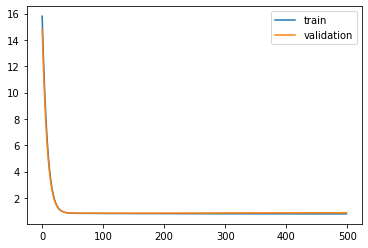

Time to train LSTM:  365.4035060405731


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f077792d320>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 10s - loss: 15.9640 - pdc_loss: 0.7296 - event_loss: 0.6876 - val_loss: 14.9808 - val_pdc_loss: 0.7047 - val_event_loss: 0.6549

Epoch 00001: val_loss improved from inf to 14.98082, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 14.3796 - pdc_loss: 0.6980 - event_loss: 0.6358 - val_loss: 13.4772 - val_pdc_loss: 0.6798 - val_event_loss: 0.6077

Epoch 00002: val_loss improved from 14.98082 to 13.47720, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 12.9252 - pdc_loss: 0.6745 - event_loss: 0.5905 - val_loss: 12.1010 - val_pdc_loss: 0.6613 - val_event_loss: 0.5657

Epoch 00003: val_loss improved from 13.47720 to 12.10102, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 11.5959 - pdc_loss: 0.6567 - event_loss: 0.5494 - val_loss: 10.8464 - val_pdc_loss: 0.6473 - val_event_loss: 0.5267

Epoch 00004: val_loss improved from 12.10102 to 10.84642, saving model to Event_val_weigh


Epoch 00035: val_loss improved from 0.97757 to 0.95800, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 0.9342 - pdc_loss: 0.5374 - event_loss: 0.2971 - val_loss: 0.9413 - val_pdc_loss: 0.5511 - val_event_loss: 0.2997

Epoch 00036: val_loss improved from 0.95800 to 0.94133, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 0.9183 - pdc_loss: 0.5361 - event_loss: 0.2970 - val_loss: 0.9271 - val_pdc_loss: 0.5500 - val_event_loss: 0.2997

Epoch 00037: val_loss improved from 0.94133 to 0.92713, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 0.9047 - pdc_loss: 0.5348 - event_loss: 0.2970 - val_loss: 0.9150 - val_pdc_loss: 0.5489 - val_event_loss: 0.2997

Epoch 00038: val_loss improved from 0.92713 to 0.91505, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.8930 - pdc_loss: 0.5334 - event_loss: 0.2969 - val_loss: 0.9048 - val_pdc_loss: 0.5478 - val_event_loss: 0.2997

Epoch 00039: val_loss improved from 0.91505 to 


Epoch 00070: val_loss improved from 0.84757 to 0.84742, saving model to Event_val_weights3.hdf5
Epoch 71/500
 - 1s - loss: 0.8204 - pdc_loss: 0.5151 - event_loss: 0.2948 - val_loss: 0.8474 - val_pdc_loss: 0.5372 - val_event_loss: 0.2997

Epoch 00071: val_loss did not improve from 0.84742
Epoch 72/500
 - 1s - loss: 0.8201 - pdc_loss: 0.5149 - event_loss: 0.2947 - val_loss: 0.8474 - val_pdc_loss: 0.5370 - val_event_loss: 0.2999

Epoch 00072: val_loss improved from 0.84742 to 0.84742, saving model to Event_val_weights3.hdf5
Epoch 73/500
 - 1s - loss: 0.8198 - pdc_loss: 0.5147 - event_loss: 0.2947 - val_loss: 0.8470 - val_pdc_loss: 0.5366 - val_event_loss: 0.2998

Epoch 00073: val_loss improved from 0.84742 to 0.84701, saving model to Event_val_weights3.hdf5
Epoch 74/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5144 - event_loss: 0.2946 - val_loss: 0.8465 - val_pdc_loss: 0.5361 - val_event_loss: 0.2999

Epoch 00074: val_loss improved from 0.84701 to 0.84650, saving model to Event_val_weights3.h

 - 1s - loss: 0.8115 - pdc_loss: 0.5080 - event_loss: 0.2928 - val_loss: 0.8444 - val_pdc_loss: 0.5331 - val_event_loss: 0.3007

Epoch 00111: val_loss improved from 0.84459 to 0.84442, saving model to Event_val_weights3.hdf5
Epoch 112/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5080 - event_loss: 0.2928 - val_loss: 0.8450 - val_pdc_loss: 0.5336 - val_event_loss: 0.3008

Epoch 00112: val_loss did not improve from 0.84442
Epoch 113/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5080 - event_loss: 0.2928 - val_loss: 0.8450 - val_pdc_loss: 0.5335 - val_event_loss: 0.3009

Epoch 00113: val_loss did not improve from 0.84442
Epoch 114/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5082 - event_loss: 0.2927 - val_loss: 0.8450 - val_pdc_loss: 0.5334 - val_event_loss: 0.3010

Epoch 00114: val_loss did not improve from 0.84442
Epoch 115/500
 - 1s - loss: 0.8116 - pdc_loss: 0.5082 - event_loss: 0.2928 - val_loss: 0.8452 - val_pdc_loss: 0.5337 - val_event_loss: 0.3009

Epoch 00115: val_loss did not improve from 0.84442

 - 1s - loss: 0.8072 - pdc_loss: 0.5051 - event_loss: 0.2910 - val_loss: 0.8470 - val_pdc_loss: 0.5337 - val_event_loss: 0.3022

Epoch 00153: val_loss did not improve from 0.84442
Epoch 154/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5050 - event_loss: 0.2910 - val_loss: 0.8475 - val_pdc_loss: 0.5342 - val_event_loss: 0.3022

Epoch 00154: val_loss did not improve from 0.84442
Epoch 155/500
 - 1s - loss: 0.8070 - pdc_loss: 0.5050 - event_loss: 0.2909 - val_loss: 0.8475 - val_pdc_loss: 0.5340 - val_event_loss: 0.3024

Epoch 00155: val_loss did not improve from 0.84442
Epoch 156/500
 - 1s - loss: 0.8068 - pdc_loss: 0.5049 - event_loss: 0.2909 - val_loss: 0.8476 - val_pdc_loss: 0.5343 - val_event_loss: 0.3022

Epoch 00156: val_loss did not improve from 0.84442
Epoch 157/500
 - 1s - loss: 0.8068 - pdc_loss: 0.5048 - event_loss: 0.2908 - val_loss: 0.8474 - val_pdc_loss: 0.5339 - val_event_loss: 0.3023

Epoch 00157: val_loss did not improve from 0.84442
Epoch 158/500
 - 1s - loss: 0.8067 - pdc_los


Epoch 00195: val_loss did not improve from 0.84442
Epoch 196/500
 - 1s - loss: 0.8024 - pdc_loss: 0.5014 - event_loss: 0.2892 - val_loss: 0.8501 - val_pdc_loss: 0.5344 - val_event_loss: 0.3039

Epoch 00196: val_loss did not improve from 0.84442
Epoch 197/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5015 - event_loss: 0.2892 - val_loss: 0.8493 - val_pdc_loss: 0.5340 - val_event_loss: 0.3035

Epoch 00197: val_loss did not improve from 0.84442
Epoch 198/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5018 - event_loss: 0.2890 - val_loss: 0.8499 - val_pdc_loss: 0.5348 - val_event_loss: 0.3034

Epoch 00198: val_loss did not improve from 0.84442
Epoch 199/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5019 - event_loss: 0.2888 - val_loss: 0.8503 - val_pdc_loss: 0.5352 - val_event_loss: 0.3034

Epoch 00199: val_loss did not improve from 0.84442
Epoch 200/500
 - 1s - loss: 0.8024 - pdc_loss: 0.5020 - event_loss: 0.2887 - val_loss: 0.8510 - val_pdc_loss: 0.5358 - val_event_loss: 0.3035

Epoch 00200: val_loss did not

 - 1s - loss: 0.7996 - pdc_loss: 0.5003 - event_loss: 0.2869 - val_loss: 0.8561 - val_pdc_loss: 0.5376 - val_event_loss: 0.3061

Epoch 00238: val_loss did not improve from 0.84442
Epoch 239/500
 - 1s - loss: 0.7996 - pdc_loss: 0.5005 - event_loss: 0.2868 - val_loss: 0.8568 - val_pdc_loss: 0.5382 - val_event_loss: 0.3062

Epoch 00239: val_loss did not improve from 0.84442
Epoch 240/500
 - 1s - loss: 0.7999 - pdc_loss: 0.5007 - event_loss: 0.2867 - val_loss: 0.8569 - val_pdc_loss: 0.5383 - val_event_loss: 0.3062

Epoch 00240: val_loss did not improve from 0.84442
Epoch 241/500
 - 1s - loss: 0.7999 - pdc_loss: 0.5009 - event_loss: 0.2865 - val_loss: 0.8584 - val_pdc_loss: 0.5396 - val_event_loss: 0.3064

Epoch 00241: val_loss did not improve from 0.84442
Epoch 242/500
 - 1s - loss: 0.8002 - pdc_loss: 0.5011 - event_loss: 0.2866 - val_loss: 0.8588 - val_pdc_loss: 0.5397 - val_event_loss: 0.3066

Epoch 00242: val_loss did not improve from 0.84442
Epoch 243/500
 - 1s - loss: 0.8003 - pdc_los


Epoch 00280: val_loss did not improve from 0.84442
Epoch 281/500
 - 1s - loss: 0.7951 - pdc_loss: 0.4971 - event_loss: 0.2850 - val_loss: 0.8614 - val_pdc_loss: 0.5395 - val_event_loss: 0.3089

Epoch 00281: val_loss did not improve from 0.84442
Epoch 282/500
 - 1s - loss: 0.7952 - pdc_loss: 0.4973 - event_loss: 0.2849 - val_loss: 0.8618 - val_pdc_loss: 0.5398 - val_event_loss: 0.3089

Epoch 00282: val_loss did not improve from 0.84442
Epoch 283/500
 - 1s - loss: 0.7956 - pdc_loss: 0.4976 - event_loss: 0.2849 - val_loss: 0.8617 - val_pdc_loss: 0.5406 - val_event_loss: 0.3080

Epoch 00283: val_loss did not improve from 0.84442
Epoch 284/500
 - 1s - loss: 0.7955 - pdc_loss: 0.4977 - event_loss: 0.2846 - val_loss: 0.8612 - val_pdc_loss: 0.5404 - val_event_loss: 0.3077

Epoch 00284: val_loss did not improve from 0.84442
Epoch 285/500
 - 1s - loss: 0.7956 - pdc_loss: 0.4979 - event_loss: 0.2845 - val_loss: 0.8615 - val_pdc_loss: 0.5395 - val_event_loss: 0.3088

Epoch 00285: val_loss did not

 - 1s - loss: 0.7907 - pdc_loss: 0.4939 - event_loss: 0.2829 - val_loss: 0.8654 - val_pdc_loss: 0.5423 - val_event_loss: 0.3092

Epoch 00323: val_loss did not improve from 0.84442
Epoch 324/500
 - 1s - loss: 0.7905 - pdc_loss: 0.4940 - event_loss: 0.2825 - val_loss: 0.8666 - val_pdc_loss: 0.5422 - val_event_loss: 0.3104

Epoch 00324: val_loss did not improve from 0.84442
Epoch 325/500
 - 1s - loss: 0.7906 - pdc_loss: 0.4941 - event_loss: 0.2826 - val_loss: 0.8674 - val_pdc_loss: 0.5422 - val_event_loss: 0.3113

Epoch 00325: val_loss did not improve from 0.84442
Epoch 326/500
 - 1s - loss: 0.7908 - pdc_loss: 0.4941 - event_loss: 0.2828 - val_loss: 0.8662 - val_pdc_loss: 0.5429 - val_event_loss: 0.3094

Epoch 00326: val_loss did not improve from 0.84442
Epoch 327/500
 - 1s - loss: 0.7903 - pdc_loss: 0.4940 - event_loss: 0.2823 - val_loss: 0.8658 - val_pdc_loss: 0.5430 - val_event_loss: 0.3088

Epoch 00327: val_loss did not improve from 0.84442
Epoch 328/500
 - 1s - loss: 0.7902 - pdc_los


Epoch 00365: val_loss did not improve from 0.84442
Epoch 366/500
 - 1s - loss: 0.7861 - pdc_loss: 0.4909 - event_loss: 0.2806 - val_loss: 0.8705 - val_pdc_loss: 0.5449 - val_event_loss: 0.3111

Epoch 00366: val_loss did not improve from 0.84442
Epoch 367/500
 - 1s - loss: 0.7870 - pdc_loss: 0.4911 - event_loss: 0.2813 - val_loss: 0.8703 - val_pdc_loss: 0.5449 - val_event_loss: 0.3109

Epoch 00367: val_loss did not improve from 0.84442
Epoch 368/500
 - 1s - loss: 0.7877 - pdc_loss: 0.4914 - event_loss: 0.2816 - val_loss: 0.8724 - val_pdc_loss: 0.5470 - val_event_loss: 0.3108

Epoch 00368: val_loss did not improve from 0.84442
Epoch 369/500
 - 1s - loss: 0.7880 - pdc_loss: 0.4917 - event_loss: 0.2816 - val_loss: 0.8735 - val_pdc_loss: 0.5484 - val_event_loss: 0.3104

Epoch 00369: val_loss did not improve from 0.84442
Epoch 370/500
 - 1s - loss: 0.7881 - pdc_loss: 0.4925 - event_loss: 0.2809 - val_loss: 0.8766 - val_pdc_loss: 0.5495 - val_event_loss: 0.3125

Epoch 00370: val_loss did not

 - 1s - loss: 0.7848 - pdc_loss: 0.4903 - event_loss: 0.2793 - val_loss: 0.8805 - val_pdc_loss: 0.5508 - val_event_loss: 0.3145

Epoch 00408: val_loss did not improve from 0.84442
Epoch 409/500
 - 1s - loss: 0.7849 - pdc_loss: 0.4908 - event_loss: 0.2790 - val_loss: 0.8769 - val_pdc_loss: 0.5490 - val_event_loss: 0.3126

Epoch 00409: val_loss did not improve from 0.84442
Epoch 410/500
 - 1s - loss: 0.7837 - pdc_loss: 0.4896 - event_loss: 0.2789 - val_loss: 0.8754 - val_pdc_loss: 0.5467 - val_event_loss: 0.3135

Epoch 00410: val_loss did not improve from 0.84442
Epoch 411/500
 - 1s - loss: 0.7825 - pdc_loss: 0.4884 - event_loss: 0.2789 - val_loss: 0.8734 - val_pdc_loss: 0.5444 - val_event_loss: 0.3137

Epoch 00411: val_loss did not improve from 0.84442
Epoch 412/500
 - 1s - loss: 0.7831 - pdc_loss: 0.4892 - event_loss: 0.2788 - val_loss: 0.8761 - val_pdc_loss: 0.5473 - val_event_loss: 0.3136

Epoch 00412: val_loss did not improve from 0.84442
Epoch 413/500
 - 1s - loss: 0.7838 - pdc_los


Epoch 00450: val_loss did not improve from 0.84442
Epoch 451/500
 - 1s - loss: 0.7802 - pdc_loss: 0.4875 - event_loss: 0.2774 - val_loss: 0.8783 - val_pdc_loss: 0.5483 - val_event_loss: 0.3146

Epoch 00451: val_loss did not improve from 0.84442
Epoch 452/500
 - 1s - loss: 0.7803 - pdc_loss: 0.4872 - event_loss: 0.2777 - val_loss: 0.8814 - val_pdc_loss: 0.5483 - val_event_loss: 0.3176

Epoch 00452: val_loss did not improve from 0.84442
Epoch 453/500
 - 1s - loss: 0.7808 - pdc_loss: 0.4875 - event_loss: 0.2778 - val_loss: 0.8815 - val_pdc_loss: 0.5490 - val_event_loss: 0.3170

Epoch 00453: val_loss did not improve from 0.84442
Epoch 454/500
 - 1s - loss: 0.7811 - pdc_loss: 0.4880 - event_loss: 0.2776 - val_loss: 0.8822 - val_pdc_loss: 0.5516 - val_event_loss: 0.3151

Epoch 00454: val_loss did not improve from 0.84442
Epoch 455/500
 - 1s - loss: 0.7813 - pdc_loss: 0.4878 - event_loss: 0.2780 - val_loss: 0.8827 - val_pdc_loss: 0.5501 - val_event_loss: 0.3171

Epoch 00455: val_loss did not

 - 1s - loss: 0.7799 - pdc_loss: 0.4869 - event_loss: 0.2772 - val_loss: 0.8825 - val_pdc_loss: 0.5494 - val_event_loss: 0.3173

Epoch 00493: val_loss did not improve from 0.84442
Epoch 494/500
 - 1s - loss: 0.7781 - pdc_loss: 0.4856 - event_loss: 0.2767 - val_loss: 0.8835 - val_pdc_loss: 0.5495 - val_event_loss: 0.3182

Epoch 00494: val_loss did not improve from 0.84442
Epoch 495/500
 - 1s - loss: 0.7789 - pdc_loss: 0.4866 - event_loss: 0.2765 - val_loss: 0.8879 - val_pdc_loss: 0.5535 - val_event_loss: 0.3185

Epoch 00495: val_loss did not improve from 0.84442
Epoch 496/500
 - 1s - loss: 0.7798 - pdc_loss: 0.4872 - event_loss: 0.2767 - val_loss: 0.8861 - val_pdc_loss: 0.5517 - val_event_loss: 0.3185

Epoch 00496: val_loss did not improve from 0.84442
Epoch 497/500
 - 1s - loss: 0.7787 - pdc_loss: 0.4864 - event_loss: 0.2764 - val_loss: 0.8840 - val_pdc_loss: 0.5495 - val_event_loss: 0.3187

Epoch 00497: val_loss did not improve from 0.84442
Epoch 498/500
 - 1s - loss: 0.7777 - pdc_los

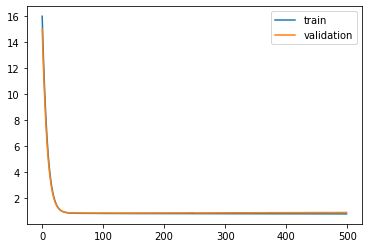

Time to train LSTM:  397.337429523468
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 11s - loss: 15.7663 - pdc_loss: 0.7411 - event_loss: 0.6936 - val_loss: 14.7911 - val_pdc_loss: 0.7207 - val_event_loss: 0.6520

Epoch 00001: val_loss improved from inf to 14.79110, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 14.1888 - pdc_loss: 0.7137 - event_loss: 0.6238 - val_loss: 13.2970 - val_pdc_loss: 0.6970 - val_event_loss: 0.5924

Epoch 00002: val_loss improved from 14.79110 to 13.29699, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 12.7451 - pdc_loss: 0.6901 - event_loss: 0.5691 - val_loss: 11.9335 - val_pdc_loss: 0.6770 - val_event_loss: 0.5451

Epoch 00003: val_loss improved from 13.29699 to 11.93351, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 11.4295 - pdc_loss: 0.6700 - event_loss: 0.5249 - val_loss: 10.6937 - val_pdc_loss: 0.6600 - val_event_loss: 0.5056

Epoch 00004: val_loss improved from 11.93351 to 10.

 - 1s - loss: 0.9532 - pdc_loss: 0.5417 - event_loss: 0.2961 - val_loss: 0.9638 - val_pdc_loss: 0.5556 - val_event_loss: 0.3034

Epoch 00035: val_loss improved from 0.98295 to 0.96378, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 0.9349 - pdc_loss: 0.5403 - event_loss: 0.2960 - val_loss: 0.9474 - val_pdc_loss: 0.5545 - val_event_loss: 0.3033

Epoch 00036: val_loss improved from 0.96378 to 0.94741, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.9193 - pdc_loss: 0.5388 - event_loss: 0.2960 - val_loss: 0.9335 - val_pdc_loss: 0.5533 - val_event_loss: 0.3032

Epoch 00037: val_loss improved from 0.94741 to 0.93345, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.9059 - pdc_loss: 0.5374 - event_loss: 0.2959 - val_loss: 0.9215 - val_pdc_loss: 0.5521 - val_event_loss: 0.3032

Epoch 00038: val_loss improved from 0.93345 to 0.92154, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8944 - pdc_loss: 0.5359 - event_


Epoch 00069: val_loss improved from 0.85221 to 0.85197, saving model to Event_val_weights4.hdf5
Epoch 70/500
 - 1s - loss: 0.8231 - pdc_loss: 0.5177 - event_loss: 0.2944 - val_loss: 0.8517 - val_pdc_loss: 0.5394 - val_event_loss: 0.3013

Epoch 00070: val_loss improved from 0.85197 to 0.85169, saving model to Event_val_weights4.hdf5
Epoch 71/500
 - 1s - loss: 0.8228 - pdc_loss: 0.5175 - event_loss: 0.2944 - val_loss: 0.8516 - val_pdc_loss: 0.5394 - val_event_loss: 0.3013

Epoch 00071: val_loss improved from 0.85169 to 0.85156, saving model to Event_val_weights4.hdf5
Epoch 72/500
 - 1s - loss: 0.8224 - pdc_loss: 0.5172 - event_loss: 0.2943 - val_loss: 0.8514 - val_pdc_loss: 0.5393 - val_event_loss: 0.3013

Epoch 00072: val_loss improved from 0.85156 to 0.85138, saving model to Event_val_weights4.hdf5
Epoch 73/500
 - 1s - loss: 0.8221 - pdc_loss: 0.5170 - event_loss: 0.2943 - val_loss: 0.8513 - val_pdc_loss: 0.5392 - val_event_loss: 0.3012

Epoch 00073: val_loss improved from 0.85138 to 


Epoch 00106: val_loss improved from 0.84821 to 0.84819, saving model to Event_val_weights4.hdf5
Epoch 107/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5109 - event_loss: 0.2925 - val_loss: 0.8484 - val_pdc_loss: 0.5366 - val_event_loss: 0.3013

Epoch 00107: val_loss did not improve from 0.84819
Epoch 108/500
 - 1s - loss: 0.8137 - pdc_loss: 0.5108 - event_loss: 0.2924 - val_loss: 0.8484 - val_pdc_loss: 0.5365 - val_event_loss: 0.3014

Epoch 00108: val_loss did not improve from 0.84819
Epoch 109/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5107 - event_loss: 0.2923 - val_loss: 0.8485 - val_pdc_loss: 0.5367 - val_event_loss: 0.3013

Epoch 00109: val_loss did not improve from 0.84819
Epoch 110/500
 - 1s - loss: 0.8135 - pdc_loss: 0.5106 - event_loss: 0.2923 - val_loss: 0.8486 - val_pdc_loss: 0.5366 - val_event_loss: 0.3015

Epoch 00110: val_loss did not improve from 0.84819
Epoch 111/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5107 - event_loss: 0.2923 - val_loss: 0.8489 - val_pdc_loss: 0.5369 - val_even


Epoch 00147: val_loss did not improve from 0.84651
Epoch 148/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5080 - event_loss: 0.2908 - val_loss: 0.8479 - val_pdc_loss: 0.5346 - val_event_loss: 0.3025

Epoch 00148: val_loss did not improve from 0.84651
Epoch 149/500
 - 1s - loss: 0.8092 - pdc_loss: 0.5076 - event_loss: 0.2907 - val_loss: 0.8461 - val_pdc_loss: 0.5331 - val_event_loss: 0.3021

Epoch 00149: val_loss improved from 0.84651 to 0.84609, saving model to Event_val_weights4.hdf5
Epoch 150/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5070 - event_loss: 0.2907 - val_loss: 0.8452 - val_pdc_loss: 0.5322 - val_event_loss: 0.3021

Epoch 00150: val_loss improved from 0.84609 to 0.84522, saving model to Event_val_weights4.hdf5
Epoch 151/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5065 - event_loss: 0.2905 - val_loss: 0.8447 - val_pdc_loss: 0.5318 - val_event_loss: 0.3020

Epoch 00151: val_loss improved from 0.84522 to 0.84468, saving model to Event_val_weights4.hdf5
Epoch 152/500
 - 1s - loss: 0.8075 - 


Epoch 00189: val_loss did not improve from 0.84468
Epoch 190/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5030 - event_loss: 0.2888 - val_loss: 0.8470 - val_pdc_loss: 0.5322 - val_event_loss: 0.3036

Epoch 00190: val_loss did not improve from 0.84468
Epoch 191/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5032 - event_loss: 0.2887 - val_loss: 0.8478 - val_pdc_loss: 0.5329 - val_event_loss: 0.3037

Epoch 00191: val_loss did not improve from 0.84468
Epoch 192/500
 - 1s - loss: 0.8032 - pdc_loss: 0.5033 - event_loss: 0.2887 - val_loss: 0.8482 - val_pdc_loss: 0.5334 - val_event_loss: 0.3037

Epoch 00192: val_loss did not improve from 0.84468
Epoch 193/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5036 - event_loss: 0.2886 - val_loss: 0.8489 - val_pdc_loss: 0.5340 - val_event_loss: 0.3038

Epoch 00193: val_loss did not improve from 0.84468
Epoch 194/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5037 - event_loss: 0.2886 - val_loss: 0.8489 - val_pdc_loss: 0.5340 - val_event_loss: 0.3038

Epoch 00194: val_loss did not

 - 1s - loss: 0.7996 - pdc_loss: 0.5008 - event_loss: 0.2873 - val_loss: 0.8494 - val_pdc_loss: 0.5330 - val_event_loss: 0.3049

Epoch 00232: val_loss did not improve from 0.84468
Epoch 233/500
 - 1s - loss: 0.7991 - pdc_loss: 0.5005 - event_loss: 0.2871 - val_loss: 0.8501 - val_pdc_loss: 0.5335 - val_event_loss: 0.3051

Epoch 00233: val_loss did not improve from 0.84468
Epoch 234/500
 - 1s - loss: 0.7992 - pdc_loss: 0.5006 - event_loss: 0.2871 - val_loss: 0.8503 - val_pdc_loss: 0.5337 - val_event_loss: 0.3051

Epoch 00234: val_loss did not improve from 0.84468
Epoch 235/500
 - 1s - loss: 0.7990 - pdc_loss: 0.5004 - event_loss: 0.2871 - val_loss: 0.8510 - val_pdc_loss: 0.5342 - val_event_loss: 0.3053

Epoch 00235: val_loss did not improve from 0.84468
Epoch 236/500
 - 1s - loss: 0.7991 - pdc_loss: 0.5005 - event_loss: 0.2871 - val_loss: 0.8513 - val_pdc_loss: 0.5347 - val_event_loss: 0.3051

Epoch 00236: val_loss did not improve from 0.84468
Epoch 237/500
 - 1s - loss: 0.7993 - pdc_los


Epoch 00274: val_loss did not improve from 0.84468
Epoch 275/500
 - 1s - loss: 0.7966 - pdc_loss: 0.4988 - event_loss: 0.2858 - val_loss: 0.8566 - val_pdc_loss: 0.5373 - val_event_loss: 0.3073

Epoch 00275: val_loss did not improve from 0.84468
Epoch 276/500
 - 1s - loss: 0.7965 - pdc_loss: 0.4987 - event_loss: 0.2858 - val_loss: 0.8566 - val_pdc_loss: 0.5371 - val_event_loss: 0.3075

Epoch 00276: val_loss did not improve from 0.84468
Epoch 277/500
 - 1s - loss: 0.7964 - pdc_loss: 0.4987 - event_loss: 0.2857 - val_loss: 0.8565 - val_pdc_loss: 0.5371 - val_event_loss: 0.3074

Epoch 00277: val_loss did not improve from 0.84468
Epoch 278/500
 - 1s - loss: 0.7962 - pdc_loss: 0.4985 - event_loss: 0.2857 - val_loss: 0.8568 - val_pdc_loss: 0.5372 - val_event_loss: 0.3076

Epoch 00278: val_loss did not improve from 0.84468
Epoch 279/500
 - 1s - loss: 0.7963 - pdc_loss: 0.4986 - event_loss: 0.2856 - val_loss: 0.8570 - val_pdc_loss: 0.5372 - val_event_loss: 0.3078

Epoch 00279: val_loss did not

 - 1s - loss: 0.7933 - pdc_loss: 0.4963 - event_loss: 0.2845 - val_loss: 0.8634 - val_pdc_loss: 0.5406 - val_event_loss: 0.3103

Epoch 00317: val_loss did not improve from 0.84468
Epoch 318/500
 - 1s - loss: 0.7934 - pdc_loss: 0.4963 - event_loss: 0.2845 - val_loss: 0.8631 - val_pdc_loss: 0.5404 - val_event_loss: 0.3101

Epoch 00318: val_loss did not improve from 0.84468
Epoch 319/500
 - 1s - loss: 0.7933 - pdc_loss: 0.4963 - event_loss: 0.2845 - val_loss: 0.8637 - val_pdc_loss: 0.5407 - val_event_loss: 0.3104

Epoch 00319: val_loss did not improve from 0.84468
Epoch 320/500
 - 1s - loss: 0.7934 - pdc_loss: 0.4963 - event_loss: 0.2846 - val_loss: 0.8628 - val_pdc_loss: 0.5403 - val_event_loss: 0.3099

Epoch 00320: val_loss did not improve from 0.84468
Epoch 321/500
 - 1s - loss: 0.7933 - pdc_loss: 0.4962 - event_loss: 0.2844 - val_loss: 0.8638 - val_pdc_loss: 0.5407 - val_event_loss: 0.3104

Epoch 00321: val_loss did not improve from 0.84468
Epoch 322/500
 - 1s - loss: 0.7935 - pdc_los


Epoch 00359: val_loss did not improve from 0.84468
Epoch 360/500
 - 1s - loss: 0.7902 - pdc_loss: 0.4942 - event_loss: 0.2830 - val_loss: 0.8679 - val_pdc_loss: 0.5428 - val_event_loss: 0.3121

Epoch 00360: val_loss did not improve from 0.84468
Epoch 361/500
 - 1s - loss: 0.7896 - pdc_loss: 0.4938 - event_loss: 0.2828 - val_loss: 0.8665 - val_pdc_loss: 0.5419 - val_event_loss: 0.3116

Epoch 00361: val_loss did not improve from 0.84468
Epoch 362/500
 - 1s - loss: 0.7898 - pdc_loss: 0.4941 - event_loss: 0.2827 - val_loss: 0.8668 - val_pdc_loss: 0.5417 - val_event_loss: 0.3121

Epoch 00362: val_loss did not improve from 0.84468
Epoch 363/500
 - 1s - loss: 0.7901 - pdc_loss: 0.4943 - event_loss: 0.2828 - val_loss: 0.8684 - val_pdc_loss: 0.5432 - val_event_loss: 0.3122

Epoch 00363: val_loss did not improve from 0.84468
Epoch 364/500
 - 1s - loss: 0.7898 - pdc_loss: 0.4938 - event_loss: 0.2830 - val_loss: 0.8666 - val_pdc_loss: 0.5416 - val_event_loss: 0.3119

Epoch 00364: val_loss did not

 - 1s - loss: 0.7879 - pdc_loss: 0.4920 - event_loss: 0.2822 - val_loss: 0.8718 - val_pdc_loss: 0.5450 - val_event_loss: 0.3131

Epoch 00402: val_loss did not improve from 0.84468
Epoch 403/500
 - 1s - loss: 0.7878 - pdc_loss: 0.4921 - event_loss: 0.2820 - val_loss: 0.8713 - val_pdc_loss: 0.5447 - val_event_loss: 0.3129

Epoch 00403: val_loss did not improve from 0.84468
Epoch 404/500
 - 1s - loss: 0.7878 - pdc_loss: 0.4923 - event_loss: 0.2819 - val_loss: 0.8729 - val_pdc_loss: 0.5450 - val_event_loss: 0.3143

Epoch 00404: val_loss did not improve from 0.84468
Epoch 405/500
 - 1s - loss: 0.7882 - pdc_loss: 0.4926 - event_loss: 0.2819 - val_loss: 0.8731 - val_pdc_loss: 0.5444 - val_event_loss: 0.3150

Epoch 00405: val_loss did not improve from 0.84468
Epoch 406/500
 - 1s - loss: 0.7889 - pdc_loss: 0.4931 - event_loss: 0.2820 - val_loss: 0.8720 - val_pdc_loss: 0.5449 - val_event_loss: 0.3134

Epoch 00406: val_loss did not improve from 0.84468
Epoch 407/500
 - 1s - loss: 0.7888 - pdc_los


Epoch 00444: val_loss did not improve from 0.84468
Epoch 445/500
 - 1s - loss: 0.7867 - pdc_loss: 0.4919 - event_loss: 0.2805 - val_loss: 0.8763 - val_pdc_loss: 0.5479 - val_event_loss: 0.3142

Epoch 00445: val_loss did not improve from 0.84468
Epoch 446/500
 - 1s - loss: 0.7864 - pdc_loss: 0.4919 - event_loss: 0.2803 - val_loss: 0.8768 - val_pdc_loss: 0.5486 - val_event_loss: 0.3141

Epoch 00446: val_loss did not improve from 0.84468
Epoch 447/500
 - 1s - loss: 0.7856 - pdc_loss: 0.4910 - event_loss: 0.2804 - val_loss: 0.8775 - val_pdc_loss: 0.5484 - val_event_loss: 0.3150

Epoch 00447: val_loss did not improve from 0.84468
Epoch 448/500
 - 1s - loss: 0.7847 - pdc_loss: 0.4901 - event_loss: 0.2804 - val_loss: 0.8766 - val_pdc_loss: 0.5476 - val_event_loss: 0.3148

Epoch 00448: val_loss did not improve from 0.84468
Epoch 449/500
 - 1s - loss: 0.7850 - pdc_loss: 0.4898 - event_loss: 0.2810 - val_loss: 0.8765 - val_pdc_loss: 0.5476 - val_event_loss: 0.3148

Epoch 00449: val_loss did not

 - 1s - loss: 0.7818 - pdc_loss: 0.4886 - event_loss: 0.2788 - val_loss: 0.8802 - val_pdc_loss: 0.5503 - val_event_loss: 0.3155

Epoch 00487: val_loss did not improve from 0.84468
Epoch 488/500
 - 1s - loss: 0.7820 - pdc_loss: 0.4889 - event_loss: 0.2788 - val_loss: 0.8781 - val_pdc_loss: 0.5493 - val_event_loss: 0.3146

Epoch 00488: val_loss did not improve from 0.84468
Epoch 489/500
 - 1s - loss: 0.7817 - pdc_loss: 0.4883 - event_loss: 0.2791 - val_loss: 0.8780 - val_pdc_loss: 0.5496 - val_event_loss: 0.3141

Epoch 00489: val_loss did not improve from 0.84468
Epoch 490/500
 - 1s - loss: 0.7815 - pdc_loss: 0.4879 - event_loss: 0.2793 - val_loss: 0.8782 - val_pdc_loss: 0.5492 - val_event_loss: 0.3148

Epoch 00490: val_loss did not improve from 0.84468
Epoch 491/500
 - 1s - loss: 0.7816 - pdc_loss: 0.4877 - event_loss: 0.2796 - val_loss: 0.8792 - val_pdc_loss: 0.5490 - val_event_loss: 0.3159

Epoch 00491: val_loss did not improve from 0.84468
Epoch 492/500
 - 1s - loss: 0.7829 - pdc_los

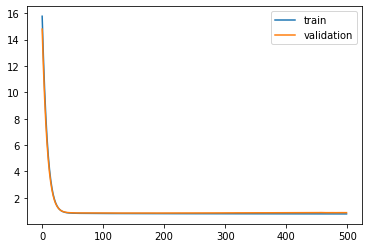

Time to train LSTM:  367.8324329853058
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 11s - loss: 15.7805 - pdc_loss: 0.7182 - event_loss: 0.6961 - val_loss: 14.8044 - val_pdc_loss: 0.6943 - val_event_loss: 0.6631

Epoch 00001: val_loss improved from inf to 14.80439, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 14.2095 - pdc_loss: 0.6850 - event_loss: 0.6484 - val_loss: 13.3128 - val_pdc_loss: 0.6664 - val_event_loss: 0.6196

Epoch 00002: val_loss improved from 14.80439 to 13.31278, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 12.7687 - pdc_loss: 0.6598 - event_loss: 0.6073 - val_loss: 11.9488 - val_pdc_loss: 0.6454 - val_event_loss: 0.5813

Epoch 00003: val_loss improved from 13.31278 to 11.94878, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 11.4532 - pdc_loss: 0.6408 - event_loss: 0.5702 - val_loss: 10.7063 - val_pdc_loss: 0.6294 - val_event_loss: 0.5455

Epoch 00004: val_loss improved from 11.94878 to 10

 - 1s - loss: 0.9487 - pdc_loss: 0.5371 - event_loss: 0.2974 - val_loss: 0.9419 - val_pdc_loss: 0.5380 - val_event_loss: 0.3002

Epoch 00035: val_loss improved from 0.96106 to 0.94187, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.9306 - pdc_loss: 0.5358 - event_loss: 0.2973 - val_loss: 0.9254 - val_pdc_loss: 0.5368 - val_event_loss: 0.3001

Epoch 00036: val_loss improved from 0.94187 to 0.92541, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.9151 - pdc_loss: 0.5345 - event_loss: 0.2973 - val_loss: 0.9113 - val_pdc_loss: 0.5354 - val_event_loss: 0.3000

Epoch 00037: val_loss improved from 0.92541 to 0.91126, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.9018 - pdc_loss: 0.5331 - event_loss: 0.2972 - val_loss: 0.8991 - val_pdc_loss: 0.5340 - val_event_loss: 0.2999

Epoch 00038: val_loss improved from 0.91126 to 0.89909, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 0.8904 - pdc_loss: 0.5317 - event_


Epoch 00069: val_loss improved from 0.82785 to 0.82759, saving model to Event_val_weights5.hdf5
Epoch 70/500
 - 1s - loss: 0.8200 - pdc_loss: 0.5152 - event_loss: 0.2947 - val_loss: 0.8273 - val_pdc_loss: 0.5196 - val_event_loss: 0.2977

Epoch 00070: val_loss improved from 0.82759 to 0.82732, saving model to Event_val_weights5.hdf5
Epoch 71/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5150 - event_loss: 0.2947 - val_loss: 0.8275 - val_pdc_loss: 0.5198 - val_event_loss: 0.2977

Epoch 00071: val_loss did not improve from 0.82732
Epoch 72/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5149 - event_loss: 0.2946 - val_loss: 0.8271 - val_pdc_loss: 0.5194 - val_event_loss: 0.2977

Epoch 00072: val_loss improved from 0.82732 to 0.82706, saving model to Event_val_weights5.hdf5
Epoch 73/500
 - 1s - loss: 0.8193 - pdc_loss: 0.5148 - event_loss: 0.2945 - val_loss: 0.8272 - val_pdc_loss: 0.5196 - val_event_loss: 0.2977

Epoch 00073: val_loss did not improve from 0.82706
Epoch 74/500
 - 1s - loss: 0.8190 - pdc_l

 - 1s - loss: 0.8128 - pdc_loss: 0.5103 - event_loss: 0.2925 - val_loss: 0.8274 - val_pdc_loss: 0.5193 - val_event_loss: 0.2981

Epoch 00110: val_loss did not improve from 0.82573
Epoch 111/500
 - 1s - loss: 0.8128 - pdc_loss: 0.5102 - event_loss: 0.2925 - val_loss: 0.8276 - val_pdc_loss: 0.5191 - val_event_loss: 0.2985

Epoch 00111: val_loss did not improve from 0.82573
Epoch 112/500
 - 1s - loss: 0.8126 - pdc_loss: 0.5101 - event_loss: 0.2924 - val_loss: 0.8274 - val_pdc_loss: 0.5192 - val_event_loss: 0.2982

Epoch 00112: val_loss did not improve from 0.82573
Epoch 113/500
 - 1s - loss: 0.8125 - pdc_loss: 0.5101 - event_loss: 0.2923 - val_loss: 0.8277 - val_pdc_loss: 0.5192 - val_event_loss: 0.2984

Epoch 00113: val_loss did not improve from 0.82573
Epoch 114/500
 - 1s - loss: 0.8123 - pdc_loss: 0.5099 - event_loss: 0.2923 - val_loss: 0.8273 - val_pdc_loss: 0.5189 - val_event_loss: 0.2983

Epoch 00114: val_loss did not improve from 0.82573
Epoch 115/500
 - 1s - loss: 0.8122 - pdc_los


Epoch 00152: val_loss did not improve from 0.82573
Epoch 153/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5067 - event_loss: 0.2906 - val_loss: 0.8273 - val_pdc_loss: 0.5179 - val_event_loss: 0.2988

Epoch 00153: val_loss did not improve from 0.82573
Epoch 154/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5067 - event_loss: 0.2906 - val_loss: 0.8278 - val_pdc_loss: 0.5178 - val_event_loss: 0.2994

Epoch 00154: val_loss did not improve from 0.82573
Epoch 155/500
 - 1s - loss: 0.8078 - pdc_loss: 0.5066 - event_loss: 0.2905 - val_loss: 0.8274 - val_pdc_loss: 0.5179 - val_event_loss: 0.2988

Epoch 00155: val_loss did not improve from 0.82573
Epoch 156/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5065 - event_loss: 0.2905 - val_loss: 0.8275 - val_pdc_loss: 0.5176 - val_event_loss: 0.2992

Epoch 00156: val_loss did not improve from 0.82573
Epoch 157/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5065 - event_loss: 0.2904 - val_loss: 0.8281 - val_pdc_loss: 0.5183 - val_event_loss: 0.2991

Epoch 00157: val_loss did not

 - 1s - loss: 0.8038 - pdc_loss: 0.5033 - event_loss: 0.2889 - val_loss: 0.8304 - val_pdc_loss: 0.5178 - val_event_loss: 0.3010

Epoch 00195: val_loss did not improve from 0.82573
Epoch 196/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5035 - event_loss: 0.2888 - val_loss: 0.8311 - val_pdc_loss: 0.5184 - val_event_loss: 0.3011

Epoch 00196: val_loss did not improve from 0.82573
Epoch 197/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5034 - event_loss: 0.2884 - val_loss: 0.8305 - val_pdc_loss: 0.5177 - val_event_loss: 0.3011

Epoch 00197: val_loss did not improve from 0.82573
Epoch 198/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5029 - event_loss: 0.2886 - val_loss: 0.8309 - val_pdc_loss: 0.5178 - val_event_loss: 0.3014

Epoch 00198: val_loss did not improve from 0.82573
Epoch 199/500
 - 1s - loss: 0.8033 - pdc_loss: 0.5030 - event_loss: 0.2887 - val_loss: 0.8322 - val_pdc_loss: 0.5194 - val_event_loss: 0.3011

Epoch 00199: val_loss did not improve from 0.82573
Epoch 200/500
 - 1s - loss: 0.8035 - pdc_los


Epoch 00237: val_loss did not improve from 0.82573
Epoch 238/500
 - 1s - loss: 0.8009 - pdc_loss: 0.5019 - event_loss: 0.2867 - val_loss: 0.8325 - val_pdc_loss: 0.5175 - val_event_loss: 0.3026

Epoch 00238: val_loss did not improve from 0.82573
Epoch 239/500
 - 1s - loss: 0.7998 - pdc_loss: 0.5006 - event_loss: 0.2868 - val_loss: 0.8326 - val_pdc_loss: 0.5176 - val_event_loss: 0.3026

Epoch 00239: val_loss did not improve from 0.82573
Epoch 240/500
 - 1s - loss: 0.7995 - pdc_loss: 0.5006 - event_loss: 0.2864 - val_loss: 0.8331 - val_pdc_loss: 0.5179 - val_event_loss: 0.3029

Epoch 00240: val_loss did not improve from 0.82573
Epoch 241/500
 - 1s - loss: 0.7992 - pdc_loss: 0.5005 - event_loss: 0.2863 - val_loss: 0.8323 - val_pdc_loss: 0.5175 - val_event_loss: 0.3025

Epoch 00241: val_loss did not improve from 0.82573
Epoch 242/500
 - 1s - loss: 0.7982 - pdc_loss: 0.4995 - event_loss: 0.2864 - val_loss: 0.8325 - val_pdc_loss: 0.5176 - val_event_loss: 0.3025

Epoch 00242: val_loss did not

 - 1s - loss: 0.7946 - pdc_loss: 0.4974 - event_loss: 0.2845 - val_loss: 0.8371 - val_pdc_loss: 0.5202 - val_event_loss: 0.3041

Epoch 00280: val_loss did not improve from 0.82573
Epoch 281/500
 - 1s - loss: 0.7946 - pdc_loss: 0.4975 - event_loss: 0.2843 - val_loss: 0.8365 - val_pdc_loss: 0.5201 - val_event_loss: 0.3036

Epoch 00281: val_loss did not improve from 0.82573
Epoch 282/500
 - 1s - loss: 0.7947 - pdc_loss: 0.4975 - event_loss: 0.2844 - val_loss: 0.8369 - val_pdc_loss: 0.5201 - val_event_loss: 0.3039

Epoch 00282: val_loss did not improve from 0.82573
Epoch 283/500
 - 1s - loss: 0.7950 - pdc_loss: 0.4977 - event_loss: 0.2845 - val_loss: 0.8378 - val_pdc_loss: 0.5203 - val_event_loss: 0.3046

Epoch 00283: val_loss did not improve from 0.82573
Epoch 284/500
 - 1s - loss: 0.7951 - pdc_loss: 0.4977 - event_loss: 0.2845 - val_loss: 0.8368 - val_pdc_loss: 0.5200 - val_event_loss: 0.3039

Epoch 00284: val_loss did not improve from 0.82573
Epoch 285/500
 - 1s - loss: 0.7951 - pdc_los


Epoch 00322: val_loss did not improve from 0.82573
Epoch 323/500
 - 1s - loss: 0.7914 - pdc_loss: 0.4952 - event_loss: 0.2829 - val_loss: 0.8399 - val_pdc_loss: 0.5209 - val_event_loss: 0.3057

Epoch 00323: val_loss did not improve from 0.82573
Epoch 324/500
 - 1s - loss: 0.7910 - pdc_loss: 0.4949 - event_loss: 0.2827 - val_loss: 0.8401 - val_pdc_loss: 0.5210 - val_event_loss: 0.3058

Epoch 00324: val_loss did not improve from 0.82573
Epoch 325/500
 - 1s - loss: 0.7906 - pdc_loss: 0.4947 - event_loss: 0.2826 - val_loss: 0.8415 - val_pdc_loss: 0.5220 - val_event_loss: 0.3061

Epoch 00325: val_loss did not improve from 0.82573
Epoch 326/500
 - 1s - loss: 0.7908 - pdc_loss: 0.4951 - event_loss: 0.2823 - val_loss: 0.8411 - val_pdc_loss: 0.5212 - val_event_loss: 0.3064

Epoch 00326: val_loss did not improve from 0.82573
Epoch 327/500
 - 1s - loss: 0.7912 - pdc_loss: 0.4950 - event_loss: 0.2828 - val_loss: 0.8413 - val_pdc_loss: 0.5216 - val_event_loss: 0.3062

Epoch 00327: val_loss did not

 - 1s - loss: 0.7879 - pdc_loss: 0.4930 - event_loss: 0.2812 - val_loss: 0.8455 - val_pdc_loss: 0.5239 - val_event_loss: 0.3079

Epoch 00365: val_loss did not improve from 0.82573
Epoch 366/500
 - 1s - loss: 0.7883 - pdc_loss: 0.4934 - event_loss: 0.2812 - val_loss: 0.8455 - val_pdc_loss: 0.5237 - val_event_loss: 0.3080

Epoch 00366: val_loss did not improve from 0.82573
Epoch 367/500
 - 1s - loss: 0.7884 - pdc_loss: 0.4933 - event_loss: 0.2813 - val_loss: 0.8466 - val_pdc_loss: 0.5247 - val_event_loss: 0.3080

Epoch 00367: val_loss did not improve from 0.82573
Epoch 368/500
 - 1s - loss: 0.7885 - pdc_loss: 0.4933 - event_loss: 0.2813 - val_loss: 0.8458 - val_pdc_loss: 0.5237 - val_event_loss: 0.3082

Epoch 00368: val_loss did not improve from 0.82573
Epoch 369/500
 - 1s - loss: 0.7882 - pdc_loss: 0.4933 - event_loss: 0.2811 - val_loss: 0.8449 - val_pdc_loss: 0.5235 - val_event_loss: 0.3075

Epoch 00369: val_loss did not improve from 0.82573
Epoch 370/500
 - 1s - loss: 0.7875 - pdc_los


Epoch 00407: val_loss did not improve from 0.82573
Epoch 408/500
 - 1s - loss: 0.7860 - pdc_loss: 0.4910 - event_loss: 0.2808 - val_loss: 0.8500 - val_pdc_loss: 0.5267 - val_event_loss: 0.3091

Epoch 00408: val_loss did not improve from 0.82573
Epoch 409/500
 - 1s - loss: 0.7866 - pdc_loss: 0.4920 - event_loss: 0.2804 - val_loss: 0.8501 - val_pdc_loss: 0.5267 - val_event_loss: 0.3091

Epoch 00409: val_loss did not improve from 0.82573
Epoch 410/500
 - 1s - loss: 0.7868 - pdc_loss: 0.4923 - event_loss: 0.2802 - val_loss: 0.8512 - val_pdc_loss: 0.5263 - val_event_loss: 0.3106

Epoch 00410: val_loss did not improve from 0.82573
Epoch 411/500
 - 1s - loss: 0.7868 - pdc_loss: 0.4920 - event_loss: 0.2804 - val_loss: 0.8530 - val_pdc_loss: 0.5274 - val_event_loss: 0.3112

Epoch 00411: val_loss did not improve from 0.82573
Epoch 412/500
 - 1s - loss: 0.7874 - pdc_loss: 0.4919 - event_loss: 0.2811 - val_loss: 0.8499 - val_pdc_loss: 0.5265 - val_event_loss: 0.3090

Epoch 00412: val_loss did not

 - 1s - loss: 0.7822 - pdc_loss: 0.4890 - event_loss: 0.2788 - val_loss: 0.8514 - val_pdc_loss: 0.5263 - val_event_loss: 0.3108

Epoch 00450: val_loss did not improve from 0.82573
Epoch 451/500
 - 1s - loss: 0.7811 - pdc_loss: 0.4884 - event_loss: 0.2784 - val_loss: 0.8521 - val_pdc_loss: 0.5267 - val_event_loss: 0.3111

Epoch 00451: val_loss did not improve from 0.82573
Epoch 452/500
 - 1s - loss: 0.7809 - pdc_loss: 0.4886 - event_loss: 0.2781 - val_loss: 0.8527 - val_pdc_loss: 0.5270 - val_event_loss: 0.3115

Epoch 00452: val_loss did not improve from 0.82573
Epoch 453/500
 - 1s - loss: 0.7809 - pdc_loss: 0.4884 - event_loss: 0.2783 - val_loss: 0.8500 - val_pdc_loss: 0.5245 - val_event_loss: 0.3113

Epoch 00453: val_loss did not improve from 0.82573
Epoch 454/500
 - 1s - loss: 0.7809 - pdc_loss: 0.4882 - event_loss: 0.2785 - val_loss: 0.8515 - val_pdc_loss: 0.5261 - val_event_loss: 0.3111

Epoch 00454: val_loss did not improve from 0.82573
Epoch 455/500
 - 1s - loss: 0.7813 - pdc_los


Epoch 00492: val_loss did not improve from 0.82573
Epoch 493/500
 - 1s - loss: 0.7808 - pdc_loss: 0.4883 - event_loss: 0.2779 - val_loss: 0.8579 - val_pdc_loss: 0.5294 - val_event_loss: 0.3139

Epoch 00493: val_loss did not improve from 0.82573
Epoch 494/500
 - 1s - loss: 0.7810 - pdc_loss: 0.4880 - event_loss: 0.2784 - val_loss: 0.8560 - val_pdc_loss: 0.5294 - val_event_loss: 0.3121

Epoch 00494: val_loss did not improve from 0.82573
Epoch 495/500
 - 1s - loss: 0.7804 - pdc_loss: 0.4880 - event_loss: 0.2778 - val_loss: 0.8590 - val_pdc_loss: 0.5292 - val_event_loss: 0.3153

Epoch 00495: val_loss did not improve from 0.82573
Epoch 496/500
 - 1s - loss: 0.7798 - pdc_loss: 0.4874 - event_loss: 0.2778 - val_loss: 0.8609 - val_pdc_loss: 0.5312 - val_event_loss: 0.3151

Epoch 00496: val_loss did not improve from 0.82573
Epoch 497/500
 - 1s - loss: 0.7811 - pdc_loss: 0.4883 - event_loss: 0.2783 - val_loss: 0.8587 - val_pdc_loss: 0.5302 - val_event_loss: 0.3139

Epoch 00497: val_loss did not

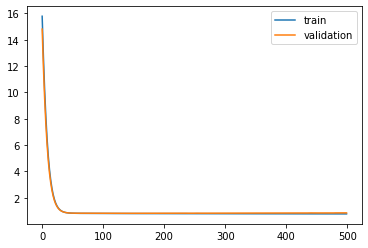

Time to train LSTM:  367.0262932777405
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 11s - loss: 16.1580 - pdc_loss: 0.7045 - event_loss: 0.7374 - val_loss: 15.4137 - val_pdc_loss: 0.6921 - val_event_loss: 0.6922

Epoch 00001: val_loss improved from inf to 15.41374, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 15.1791 - pdc_loss: 0.6924 - event_loss: 0.6940 - val_loss: 14.4706 - val_pdc_loss: 0.6813 - val_event_loss: 0.6530

Epoch 00002: val_loss improved from 15.41374 to 14.47062, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 14.2479 - pdc_loss: 0.6812 - event_loss: 0.6564 - val_loss: 13.5750 - val_pdc_loss: 0.6714 - val_event_loss: 0.6189

Epoch 00003: val_loss improved from 14.47062 to 13.57504, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 13.3641 - pdc_loss: 0.6710 - event_loss: 0.6234 - val_loss: 12.7261 - val_pdc_loss: 0.6624 - val_event_loss: 0.5887

Epoch 00004: val_loss improved from 13.57504 to 12

 - 1s - loss: 1.8677 - pdc_loss: 0.5571 - event_loss: 0.3016 - val_loss: 1.7994 - val_pdc_loss: 0.5600 - val_event_loss: 0.2955

Epoch 00035: val_loss improved from 1.88969 to 1.79937, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 1.7792 - pdc_loss: 0.5562 - event_loss: 0.3012 - val_loss: 1.7163 - val_pdc_loss: 0.5591 - val_event_loss: 0.2953

Epoch 00036: val_loss improved from 1.79937 to 1.71629, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 1.6979 - pdc_loss: 0.5553 - event_loss: 0.3008 - val_loss: 1.6399 - val_pdc_loss: 0.5582 - val_event_loss: 0.2950

Epoch 00037: val_loss improved from 1.71629 to 1.63989, saving model to Event_val_weights1.hdf5
Epoch 38/500
 - 1s - loss: 1.6230 - pdc_loss: 0.5544 - event_loss: 0.3004 - val_loss: 1.5697 - val_pdc_loss: 0.5573 - val_event_loss: 0.2948

Epoch 00038: val_loss improved from 1.63989 to 1.56970, saving model to Event_val_weights1.hdf5
Epoch 39/500
 - 1s - loss: 1.5543 - pdc_loss: 0.5536 - event_


Epoch 00069: val_loss improved from 0.86909 to 0.86490, saving model to Event_val_weights1.hdf5
Epoch 70/500
 - 1s - loss: 0.8655 - pdc_loss: 0.5298 - event_loss: 0.2971 - val_loss: 0.8611 - val_pdc_loss: 0.5321 - val_event_loss: 0.2925

Epoch 00070: val_loss improved from 0.86490 to 0.86107, saving model to Event_val_weights1.hdf5
Epoch 71/500
 - 1s - loss: 0.8618 - pdc_loss: 0.5290 - event_loss: 0.2971 - val_loss: 0.8576 - val_pdc_loss: 0.5313 - val_event_loss: 0.2925

Epoch 00071: val_loss improved from 0.86107 to 0.85757, saving model to Event_val_weights1.hdf5
Epoch 72/500
 - 1s - loss: 0.8583 - pdc_loss: 0.5282 - event_loss: 0.2971 - val_loss: 0.8544 - val_pdc_loss: 0.5305 - val_event_loss: 0.2925

Epoch 00072: val_loss improved from 0.85757 to 0.85437, saving model to Event_val_weights1.hdf5
Epoch 73/500
 - 1s - loss: 0.8552 - pdc_loss: 0.5275 - event_loss: 0.2970 - val_loss: 0.8515 - val_pdc_loss: 0.5298 - val_event_loss: 0.2925

Epoch 00073: val_loss improved from 0.85437 to 

 - 1s - loss: 0.8241 - pdc_loss: 0.5172 - event_loss: 0.2959 - val_loss: 0.8240 - val_pdc_loss: 0.5213 - val_event_loss: 0.2918

Epoch 00104: val_loss improved from 0.82422 to 0.82401, saving model to Event_val_weights1.hdf5
Epoch 105/500
 - 1s - loss: 0.8237 - pdc_loss: 0.5170 - event_loss: 0.2958 - val_loss: 0.8239 - val_pdc_loss: 0.5212 - val_event_loss: 0.2918

Epoch 00105: val_loss improved from 0.82401 to 0.82386, saving model to Event_val_weights1.hdf5
Epoch 106/500
 - 1s - loss: 0.8234 - pdc_loss: 0.5168 - event_loss: 0.2958 - val_loss: 0.8236 - val_pdc_loss: 0.5210 - val_event_loss: 0.2918

Epoch 00106: val_loss improved from 0.82386 to 0.82363, saving model to Event_val_weights1.hdf5
Epoch 107/500
 - 1s - loss: 0.8232 - pdc_loss: 0.5166 - event_loss: 0.2958 - val_loss: 0.8235 - val_pdc_loss: 0.5209 - val_event_loss: 0.2918

Epoch 00107: val_loss improved from 0.82363 to 0.82348, saving model to Event_val_weights1.hdf5
Epoch 108/500
 - 1s - loss: 0.8229 - pdc_loss: 0.5164 - ev

 - 1s - loss: 0.8163 - pdc_loss: 0.5112 - event_loss: 0.2947 - val_loss: 0.8223 - val_pdc_loss: 0.5202 - val_event_loss: 0.2917

Epoch 00141: val_loss did not improve from 0.82201
Epoch 142/500
 - 1s - loss: 0.8162 - pdc_loss: 0.5111 - event_loss: 0.2946 - val_loss: 0.8225 - val_pdc_loss: 0.5202 - val_event_loss: 0.2918

Epoch 00142: val_loss did not improve from 0.82201
Epoch 143/500
 - 1s - loss: 0.8161 - pdc_loss: 0.5110 - event_loss: 0.2946 - val_loss: 0.8226 - val_pdc_loss: 0.5204 - val_event_loss: 0.2917

Epoch 00143: val_loss did not improve from 0.82201
Epoch 144/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5109 - event_loss: 0.2946 - val_loss: 0.8226 - val_pdc_loss: 0.5203 - val_event_loss: 0.2918

Epoch 00144: val_loss did not improve from 0.82201
Epoch 145/500
 - 1s - loss: 0.8159 - pdc_loss: 0.5109 - event_loss: 0.2945 - val_loss: 0.8228 - val_pdc_loss: 0.5205 - val_event_loss: 0.2918

Epoch 00145: val_loss did not improve from 0.82201
Epoch 146/500
 - 1s - loss: 0.8159 - pdc_los

 - 1s - loss: 0.8124 - pdc_loss: 0.5081 - event_loss: 0.2934 - val_loss: 0.8232 - val_pdc_loss: 0.5203 - val_event_loss: 0.2921

Epoch 00183: val_loss did not improve from 0.82155
Epoch 184/500
 - 1s - loss: 0.8122 - pdc_loss: 0.5079 - event_loss: 0.2934 - val_loss: 0.8236 - val_pdc_loss: 0.5208 - val_event_loss: 0.2919

Epoch 00184: val_loss did not improve from 0.82155
Epoch 185/500
 - 1s - loss: 0.8120 - pdc_loss: 0.5076 - event_loss: 0.2934 - val_loss: 0.8235 - val_pdc_loss: 0.5207 - val_event_loss: 0.2919

Epoch 00185: val_loss did not improve from 0.82155
Epoch 186/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5072 - event_loss: 0.2933 - val_loss: 0.8244 - val_pdc_loss: 0.5216 - val_event_loss: 0.2919

Epoch 00186: val_loss did not improve from 0.82155
Epoch 187/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5069 - event_loss: 0.2933 - val_loss: 0.8241 - val_pdc_loss: 0.5212 - val_event_loss: 0.2920

Epoch 00187: val_loss did not improve from 0.82155
Epoch 188/500
 - 1s - loss: 0.8109 - pdc_los


Epoch 00225: val_loss did not improve from 0.82155
Epoch 226/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5057 - event_loss: 0.2921 - val_loss: 0.8267 - val_pdc_loss: 0.5220 - val_event_loss: 0.2931

Epoch 00226: val_loss did not improve from 0.82155
Epoch 227/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5058 - event_loss: 0.2921 - val_loss: 0.8269 - val_pdc_loss: 0.5218 - val_event_loss: 0.2935

Epoch 00227: val_loss did not improve from 0.82155
Epoch 228/500
 - 1s - loss: 0.8093 - pdc_loss: 0.5054 - event_loss: 0.2922 - val_loss: 0.8273 - val_pdc_loss: 0.5221 - val_event_loss: 0.2935

Epoch 00228: val_loss did not improve from 0.82155
Epoch 229/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5047 - event_loss: 0.2921 - val_loss: 0.8274 - val_pdc_loss: 0.5229 - val_event_loss: 0.2928

Epoch 00229: val_loss did not improve from 0.82155
Epoch 230/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5042 - event_loss: 0.2921 - val_loss: 0.8274 - val_pdc_loss: 0.5225 - val_event_loss: 0.2931

Epoch 00230: val_loss did not

 - 1s - loss: 0.8061 - pdc_loss: 0.5033 - event_loss: 0.2905 - val_loss: 0.8298 - val_pdc_loss: 0.5227 - val_event_loss: 0.2947

Epoch 00268: val_loss did not improve from 0.82155
Epoch 269/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5035 - event_loss: 0.2905 - val_loss: 0.8293 - val_pdc_loss: 0.5225 - val_event_loss: 0.2944

Epoch 00269: val_loss did not improve from 0.82155
Epoch 270/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5034 - event_loss: 0.2906 - val_loss: 0.8290 - val_pdc_loss: 0.5225 - val_event_loss: 0.2942

Epoch 00270: val_loss did not improve from 0.82155
Epoch 271/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5029 - event_loss: 0.2907 - val_loss: 0.8298 - val_pdc_loss: 0.5230 - val_event_loss: 0.2945

Epoch 00271: val_loss did not improve from 0.82155
Epoch 272/500
 - 1s - loss: 0.8053 - pdc_loss: 0.5022 - event_loss: 0.2907 - val_loss: 0.8299 - val_pdc_loss: 0.5231 - val_event_loss: 0.2943

Epoch 00272: val_loss did not improve from 0.82155
Epoch 273/500
 - 1s - loss: 0.8048 - pdc_los


Epoch 00310: val_loss did not improve from 0.82155
Epoch 311/500
 - 1s - loss: 0.8022 - pdc_loss: 0.5004 - event_loss: 0.2889 - val_loss: 0.8329 - val_pdc_loss: 0.5242 - val_event_loss: 0.2958

Epoch 00311: val_loss did not improve from 0.82155
Epoch 312/500
 - 1s - loss: 0.8023 - pdc_loss: 0.5005 - event_loss: 0.2890 - val_loss: 0.8338 - val_pdc_loss: 0.5250 - val_event_loss: 0.2959

Epoch 00312: val_loss did not improve from 0.82155
Epoch 313/500
 - 1s - loss: 0.8025 - pdc_loss: 0.5007 - event_loss: 0.2889 - val_loss: 0.8345 - val_pdc_loss: 0.5250 - val_event_loss: 0.2966

Epoch 00313: val_loss did not improve from 0.82155
Epoch 314/500
 - 1s - loss: 0.8028 - pdc_loss: 0.5009 - event_loss: 0.2889 - val_loss: 0.8343 - val_pdc_loss: 0.5250 - val_event_loss: 0.2963

Epoch 00314: val_loss did not improve from 0.82155
Epoch 315/500
 - 1s - loss: 0.8027 - pdc_loss: 0.5009 - event_loss: 0.2888 - val_loss: 0.8337 - val_pdc_loss: 0.5240 - val_event_loss: 0.2968

Epoch 00315: val_loss did not

 - 1s - loss: 0.7991 - pdc_loss: 0.4984 - event_loss: 0.2873 - val_loss: 0.8338 - val_pdc_loss: 0.5241 - val_event_loss: 0.2963

Epoch 00353: val_loss did not improve from 0.82155
Epoch 354/500
 - 1s - loss: 0.7990 - pdc_loss: 0.4982 - event_loss: 0.2874 - val_loss: 0.8338 - val_pdc_loss: 0.5238 - val_event_loss: 0.2967

Epoch 00354: val_loss did not improve from 0.82155
Epoch 355/500
 - 1s - loss: 0.7989 - pdc_loss: 0.4981 - event_loss: 0.2874 - val_loss: 0.8334 - val_pdc_loss: 0.5235 - val_event_loss: 0.2965

Epoch 00355: val_loss did not improve from 0.82155
Epoch 356/500
 - 1s - loss: 0.7987 - pdc_loss: 0.4979 - event_loss: 0.2874 - val_loss: 0.8336 - val_pdc_loss: 0.5233 - val_event_loss: 0.2969

Epoch 00356: val_loss did not improve from 0.82155
Epoch 357/500
 - 1s - loss: 0.7986 - pdc_loss: 0.4978 - event_loss: 0.2875 - val_loss: 0.8337 - val_pdc_loss: 0.5236 - val_event_loss: 0.2967

Epoch 00357: val_loss did not improve from 0.82155
Epoch 358/500
 - 1s - loss: 0.7988 - pdc_los


Epoch 00395: val_loss did not improve from 0.82155
Epoch 396/500
 - 1s - loss: 0.7964 - pdc_loss: 0.4962 - event_loss: 0.2863 - val_loss: 0.8371 - val_pdc_loss: 0.5254 - val_event_loss: 0.2977

Epoch 00396: val_loss did not improve from 0.82155
Epoch 397/500
 - 1s - loss: 0.7965 - pdc_loss: 0.4961 - event_loss: 0.2864 - val_loss: 0.8362 - val_pdc_loss: 0.5251 - val_event_loss: 0.2971

Epoch 00397: val_loss did not improve from 0.82155
Epoch 398/500
 - 1s - loss: 0.7966 - pdc_loss: 0.4962 - event_loss: 0.2864 - val_loss: 0.8369 - val_pdc_loss: 0.5252 - val_event_loss: 0.2978

Epoch 00398: val_loss did not improve from 0.82155
Epoch 399/500
 - 1s - loss: 0.7965 - pdc_loss: 0.4962 - event_loss: 0.2863 - val_loss: 0.8382 - val_pdc_loss: 0.5256 - val_event_loss: 0.2986

Epoch 00399: val_loss did not improve from 0.82155
Epoch 400/500
 - 1s - loss: 0.7966 - pdc_loss: 0.4964 - event_loss: 0.2863 - val_loss: 0.8389 - val_pdc_loss: 0.5263 - val_event_loss: 0.2987

Epoch 00400: val_loss did not

 - 1s - loss: 0.7947 - pdc_loss: 0.4949 - event_loss: 0.2855 - val_loss: 0.8430 - val_pdc_loss: 0.5285 - val_event_loss: 0.3002

Epoch 00438: val_loss did not improve from 0.82155
Epoch 439/500
 - 1s - loss: 0.7949 - pdc_loss: 0.4951 - event_loss: 0.2854 - val_loss: 0.8424 - val_pdc_loss: 0.5283 - val_event_loss: 0.2998

Epoch 00439: val_loss did not improve from 0.82155
Epoch 440/500
 - 1s - loss: 0.7949 - pdc_loss: 0.4952 - event_loss: 0.2853 - val_loss: 0.8407 - val_pdc_loss: 0.5277 - val_event_loss: 0.2986

Epoch 00440: val_loss did not improve from 0.82155
Epoch 441/500
 - 1s - loss: 0.7945 - pdc_loss: 0.4950 - event_loss: 0.2852 - val_loss: 0.8407 - val_pdc_loss: 0.5273 - val_event_loss: 0.2990

Epoch 00441: val_loss did not improve from 0.82155
Epoch 442/500
 - 1s - loss: 0.7942 - pdc_loss: 0.4947 - event_loss: 0.2851 - val_loss: 0.8419 - val_pdc_loss: 0.5278 - val_event_loss: 0.2998

Epoch 00442: val_loss did not improve from 0.82155
Epoch 443/500
 - 1s - loss: 0.7941 - pdc_los


Epoch 00480: val_loss did not improve from 0.82155
Epoch 481/500
 - 1s - loss: 0.7939 - pdc_loss: 0.4948 - event_loss: 0.2843 - val_loss: 0.8481 - val_pdc_loss: 0.5306 - val_event_loss: 0.3027

Epoch 00481: val_loss did not improve from 0.82155
Epoch 482/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4937 - event_loss: 0.2843 - val_loss: 0.8501 - val_pdc_loss: 0.5305 - val_event_loss: 0.3048

Epoch 00482: val_loss did not improve from 0.82155
Epoch 483/500
 - 1s - loss: 0.7925 - pdc_loss: 0.4932 - event_loss: 0.2844 - val_loss: 0.8492 - val_pdc_loss: 0.5312 - val_event_loss: 0.3031

Epoch 00483: val_loss did not improve from 0.82155
Epoch 484/500
 - 1s - loss: 0.7927 - pdc_loss: 0.4938 - event_loss: 0.2841 - val_loss: 0.8476 - val_pdc_loss: 0.5312 - val_event_loss: 0.3016

Epoch 00484: val_loss did not improve from 0.82155
Epoch 485/500
 - 1s - loss: 0.7930 - pdc_loss: 0.4939 - event_loss: 0.2843 - val_loss: 0.8499 - val_pdc_loss: 0.5329 - val_event_loss: 0.3022

Epoch 00485: val_loss did not

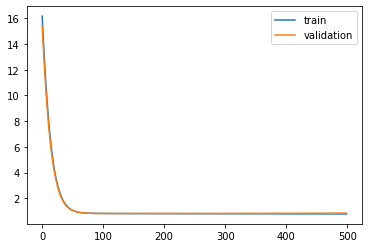

Time to train LSTM:  346.5296437740326
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 11s - loss: 16.3775 - pdc_loss: 0.7569 - event_loss: 0.6971 - val_loss: 15.6435 - val_pdc_loss: 0.7355 - val_event_loss: 0.6806

Epoch 00001: val_loss improved from inf to 15.64350, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 15.3923 - pdc_loss: 0.7335 - event_loss: 0.6716 - val_loss: 14.6936 - val_pdc_loss: 0.7150 - val_event_loss: 0.6567

Epoch 00002: val_loss improved from 15.64350 to 14.69363, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 14.4541 - pdc_loss: 0.7135 - event_loss: 0.6477 - val_loss: 13.7906 - val_pdc_loss: 0.6976 - val_event_loss: 0.6343

Epoch 00003: val_loss improved from 14.69363 to 13.79057, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 13.5627 - pdc_loss: 0.6966 - event_loss: 0.6253 - val_loss: 12.9339 - val_pdc_loss: 0.6828 - val_event_loss: 0.6130

Epoch 00004: val_loss improved from 13.79057 to 12

 - 1s - loss: 1.8799 - pdc_loss: 0.5534 - event_loss: 0.3014 - val_loss: 1.8278 - val_pdc_loss: 0.5595 - val_event_loss: 0.3094

Epoch 00035: val_loss improved from 1.91989 to 1.82780, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 1.7897 - pdc_loss: 0.5522 - event_loss: 0.3009 - val_loss: 1.7431 - val_pdc_loss: 0.5584 - val_event_loss: 0.3090

Epoch 00036: val_loss improved from 1.82780 to 1.74306, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 1.7067 - pdc_loss: 0.5511 - event_loss: 0.3005 - val_loss: 1.6651 - val_pdc_loss: 0.5574 - val_event_loss: 0.3086

Epoch 00037: val_loss improved from 1.74306 to 1.66514, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 1.6305 - pdc_loss: 0.5500 - event_loss: 0.3001 - val_loss: 1.5936 - val_pdc_loss: 0.5564 - val_event_loss: 0.3082

Epoch 00038: val_loss improved from 1.66514 to 1.59355, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 1.5604 - pdc_loss: 0.5490 - event_


Epoch 00069: val_loss improved from 0.87904 to 0.87510, saving model to Event_val_weights2.hdf5
Epoch 70/500
 - 1s - loss: 0.8580 - pdc_loss: 0.5226 - event_loss: 0.2961 - val_loss: 0.8716 - val_pdc_loss: 0.5311 - val_event_loss: 0.3035

Epoch 00070: val_loss improved from 0.87510 to 0.87155, saving model to Event_val_weights2.hdf5
Epoch 71/500
 - 1s - loss: 0.8545 - pdc_loss: 0.5222 - event_loss: 0.2961 - val_loss: 0.8684 - val_pdc_loss: 0.5307 - val_event_loss: 0.3035

Epoch 00071: val_loss improved from 0.87155 to 0.86837, saving model to Event_val_weights2.hdf5
Epoch 72/500
 - 1s - loss: 0.8513 - pdc_loss: 0.5218 - event_loss: 0.2960 - val_loss: 0.8655 - val_pdc_loss: 0.5305 - val_event_loss: 0.3034

Epoch 00072: val_loss improved from 0.86837 to 0.86551, saving model to Event_val_weights2.hdf5
Epoch 73/500
 - 1s - loss: 0.8484 - pdc_loss: 0.5214 - event_loss: 0.2960 - val_loss: 0.8630 - val_pdc_loss: 0.5302 - val_event_loss: 0.3034

Epoch 00073: val_loss improved from 0.86551 to 

 - 1s - loss: 0.8195 - pdc_loss: 0.5135 - event_loss: 0.2945 - val_loss: 0.8393 - val_pdc_loss: 0.5260 - val_event_loss: 0.3018

Epoch 00105: val_loss did not improve from 0.83927
Epoch 106/500
 - 1s - loss: 0.8195 - pdc_loss: 0.5136 - event_loss: 0.2944 - val_loss: 0.8397 - val_pdc_loss: 0.5264 - val_event_loss: 0.3018

Epoch 00106: val_loss did not improve from 0.83927
Epoch 107/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5135 - event_loss: 0.2944 - val_loss: 0.8397 - val_pdc_loss: 0.5265 - val_event_loss: 0.3018

Epoch 00107: val_loss did not improve from 0.83927
Epoch 108/500
 - 1s - loss: 0.8191 - pdc_loss: 0.5133 - event_loss: 0.2943 - val_loss: 0.8392 - val_pdc_loss: 0.5261 - val_event_loss: 0.3017

Epoch 00108: val_loss improved from 0.83927 to 0.83920, saving model to Event_val_weights2.hdf5
Epoch 109/500
 - 1s - loss: 0.8187 - pdc_loss: 0.5130 - event_loss: 0.2943 - val_loss: 0.8387 - val_pdc_loss: 0.5257 - val_event_loss: 0.3016

Epoch 00109: val_loss improved from 0.83920 to 0.8

 - 1s - loss: 0.8129 - pdc_loss: 0.5088 - event_loss: 0.2931 - val_loss: 0.8379 - val_pdc_loss: 0.5253 - val_event_loss: 0.3015

Epoch 00144: val_loss did not improve from 0.83728
Epoch 145/500
 - 1s - loss: 0.8129 - pdc_loss: 0.5087 - event_loss: 0.2931 - val_loss: 0.8373 - val_pdc_loss: 0.5249 - val_event_loss: 0.3013

Epoch 00145: val_loss did not improve from 0.83728
Epoch 146/500
 - 1s - loss: 0.8126 - pdc_loss: 0.5086 - event_loss: 0.2930 - val_loss: 0.8374 - val_pdc_loss: 0.5250 - val_event_loss: 0.3013

Epoch 00146: val_loss did not improve from 0.83728
Epoch 147/500
 - 1s - loss: 0.8125 - pdc_loss: 0.5085 - event_loss: 0.2929 - val_loss: 0.8373 - val_pdc_loss: 0.5250 - val_event_loss: 0.3012

Epoch 00147: val_loss did not improve from 0.83728
Epoch 148/500
 - 1s - loss: 0.8125 - pdc_loss: 0.5084 - event_loss: 0.2929 - val_loss: 0.8375 - val_pdc_loss: 0.5251 - val_event_loss: 0.3012

Epoch 00148: val_loss did not improve from 0.83728
Epoch 149/500
 - 1s - loss: 0.8125 - pdc_los


Epoch 00186: val_loss did not improve from 0.83728
Epoch 187/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5058 - event_loss: 0.2918 - val_loss: 0.8402 - val_pdc_loss: 0.5257 - val_event_loss: 0.3025

Epoch 00187: val_loss did not improve from 0.83728
Epoch 188/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5058 - event_loss: 0.2918 - val_loss: 0.8405 - val_pdc_loss: 0.5262 - val_event_loss: 0.3023

Epoch 00188: val_loss did not improve from 0.83728
Epoch 189/500
 - 1s - loss: 0.8094 - pdc_loss: 0.5058 - event_loss: 0.2916 - val_loss: 0.8406 - val_pdc_loss: 0.5262 - val_event_loss: 0.3024

Epoch 00189: val_loss did not improve from 0.83728
Epoch 190/500
 - 1s - loss: 0.8095 - pdc_loss: 0.5058 - event_loss: 0.2916 - val_loss: 0.8406 - val_pdc_loss: 0.5262 - val_event_loss: 0.3023

Epoch 00190: val_loss did not improve from 0.83728
Epoch 191/500
 - 1s - loss: 0.8092 - pdc_loss: 0.5057 - event_loss: 0.2914 - val_loss: 0.8403 - val_pdc_loss: 0.5258 - val_event_loss: 0.3024

Epoch 00191: val_loss did not

 - 1s - loss: 0.8063 - pdc_loss: 0.5031 - event_loss: 0.2903 - val_loss: 0.8454 - val_pdc_loss: 0.5286 - val_event_loss: 0.3039

Epoch 00229: val_loss did not improve from 0.83728
Epoch 230/500
 - 1s - loss: 0.8072 - pdc_loss: 0.5039 - event_loss: 0.2904 - val_loss: 0.8453 - val_pdc_loss: 0.5287 - val_event_loss: 0.3036

Epoch 00230: val_loss did not improve from 0.83728
Epoch 231/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5045 - event_loss: 0.2902 - val_loss: 0.8469 - val_pdc_loss: 0.5298 - val_event_loss: 0.3041

Epoch 00231: val_loss did not improve from 0.83728
Epoch 232/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5047 - event_loss: 0.2902 - val_loss: 0.8477 - val_pdc_loss: 0.5297 - val_event_loss: 0.3049

Epoch 00232: val_loss did not improve from 0.83728
Epoch 233/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5045 - event_loss: 0.2900 - val_loss: 0.8465 - val_pdc_loss: 0.5289 - val_event_loss: 0.3045

Epoch 00233: val_loss did not improve from 0.83728
Epoch 234/500
 - 1s - loss: 0.8069 - pdc_los


Epoch 00271: val_loss did not improve from 0.83728
Epoch 272/500
 - 1s - loss: 0.8021 - pdc_loss: 0.5002 - event_loss: 0.2882 - val_loss: 0.8490 - val_pdc_loss: 0.5302 - val_event_loss: 0.3052

Epoch 00272: val_loss did not improve from 0.83728
Epoch 273/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5007 - event_loss: 0.2882 - val_loss: 0.8510 - val_pdc_loss: 0.5318 - val_event_loss: 0.3054

Epoch 00273: val_loss did not improve from 0.83728
Epoch 274/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5009 - event_loss: 0.2880 - val_loss: 0.8510 - val_pdc_loss: 0.5314 - val_event_loss: 0.3059

Epoch 00274: val_loss did not improve from 0.83728
Epoch 275/500
 - 1s - loss: 0.8022 - pdc_loss: 0.5005 - event_loss: 0.2879 - val_loss: 0.8491 - val_pdc_loss: 0.5303 - val_event_loss: 0.3050

Epoch 00275: val_loss did not improve from 0.83728
Epoch 276/500
 - 1s - loss: 0.8012 - pdc_loss: 0.4999 - event_loss: 0.2876 - val_loss: 0.8481 - val_pdc_loss: 0.5288 - val_event_loss: 0.3056

Epoch 00276: val_loss did not

 - 1s - loss: 0.7993 - pdc_loss: 0.4982 - event_loss: 0.2869 - val_loss: 0.8522 - val_pdc_loss: 0.5309 - val_event_loss: 0.3071

Epoch 00314: val_loss did not improve from 0.83728
Epoch 315/500
 - 1s - loss: 0.7988 - pdc_loss: 0.4978 - event_loss: 0.2868 - val_loss: 0.8529 - val_pdc_loss: 0.5319 - val_event_loss: 0.3067

Epoch 00315: val_loss did not improve from 0.83728
Epoch 316/500
 - 1s - loss: 0.7984 - pdc_loss: 0.4975 - event_loss: 0.2866 - val_loss: 0.8524 - val_pdc_loss: 0.5315 - val_event_loss: 0.3067

Epoch 00316: val_loss did not improve from 0.83728
Epoch 317/500
 - 1s - loss: 0.7977 - pdc_loss: 0.4970 - event_loss: 0.2865 - val_loss: 0.8519 - val_pdc_loss: 0.5310 - val_event_loss: 0.3066

Epoch 00317: val_loss did not improve from 0.83728
Epoch 318/500
 - 1s - loss: 0.7973 - pdc_loss: 0.4966 - event_loss: 0.2865 - val_loss: 0.8513 - val_pdc_loss: 0.5306 - val_event_loss: 0.3065

Epoch 00318: val_loss did not improve from 0.83728
Epoch 319/500
 - 1s - loss: 0.7969 - pdc_los


Epoch 00356: val_loss did not improve from 0.83728
Epoch 357/500
 - 1s - loss: 0.8001 - pdc_loss: 0.4971 - event_loss: 0.2883 - val_loss: 0.8552 - val_pdc_loss: 0.5331 - val_event_loss: 0.3073

Epoch 00357: val_loss did not improve from 0.83728
Epoch 358/500
 - 1s - loss: 0.8026 - pdc_loss: 0.4999 - event_loss: 0.2878 - val_loss: 0.8619 - val_pdc_loss: 0.5374 - val_event_loss: 0.3097

Epoch 00358: val_loss did not improve from 0.83728
Epoch 359/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5039 - event_loss: 0.2882 - val_loss: 0.8696 - val_pdc_loss: 0.5452 - val_event_loss: 0.3094

Epoch 00359: val_loss did not improve from 0.83728
Epoch 360/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5047 - event_loss: 0.2874 - val_loss: 0.8579 - val_pdc_loss: 0.5354 - val_event_loss: 0.3074

Epoch 00360: val_loss did not improve from 0.83728
Epoch 361/500
 - 1s - loss: 0.8020 - pdc_loss: 0.5006 - event_loss: 0.2862 - val_loss: 0.8616 - val_pdc_loss: 0.5384 - val_event_loss: 0.3079

Epoch 00361: val_loss did not

 - 1s - loss: 0.7945 - pdc_loss: 0.4947 - event_loss: 0.2846 - val_loss: 0.8602 - val_pdc_loss: 0.5366 - val_event_loss: 0.3084

Epoch 00399: val_loss did not improve from 0.83728
Epoch 400/500
 - 1s - loss: 0.7949 - pdc_loss: 0.4949 - event_loss: 0.2849 - val_loss: 0.8589 - val_pdc_loss: 0.5347 - val_event_loss: 0.3090

Epoch 00400: val_loss did not improve from 0.83728
Epoch 401/500
 - 1s - loss: 0.7937 - pdc_loss: 0.4936 - event_loss: 0.2849 - val_loss: 0.8592 - val_pdc_loss: 0.5358 - val_event_loss: 0.3082

Epoch 00401: val_loss did not improve from 0.83728
Epoch 402/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4928 - event_loss: 0.2847 - val_loss: 0.8600 - val_pdc_loss: 0.5351 - val_event_loss: 0.3098

Epoch 00402: val_loss did not improve from 0.83728
Epoch 403/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4927 - event_loss: 0.2849 - val_loss: 0.8593 - val_pdc_loss: 0.5354 - val_event_loss: 0.3088

Epoch 00403: val_loss did not improve from 0.83728
Epoch 404/500
 - 1s - loss: 0.7930 - pdc_los


Epoch 00441: val_loss did not improve from 0.83728
Epoch 442/500
 - 1s - loss: 0.7996 - pdc_loss: 0.4975 - event_loss: 0.2868 - val_loss: 0.8691 - val_pdc_loss: 0.5409 - val_event_loss: 0.3128

Epoch 00442: val_loss did not improve from 0.83728
Epoch 443/500
 - 1s - loss: 0.8005 - pdc_loss: 0.4990 - event_loss: 0.2861 - val_loss: 0.8711 - val_pdc_loss: 0.5462 - val_event_loss: 0.3095

Epoch 00443: val_loss did not improve from 0.83728
Epoch 444/500
 - 1s - loss: 0.7985 - pdc_loss: 0.4985 - event_loss: 0.2845 - val_loss: 0.8663 - val_pdc_loss: 0.5413 - val_event_loss: 0.3095

Epoch 00444: val_loss did not improve from 0.83728
Epoch 445/500
 - 1s - loss: 0.7957 - pdc_loss: 0.4961 - event_loss: 0.2841 - val_loss: 0.8618 - val_pdc_loss: 0.5373 - val_event_loss: 0.3090

Epoch 00445: val_loss did not improve from 0.83728
Epoch 446/500
 - 1s - loss: 0.7931 - pdc_loss: 0.4939 - event_loss: 0.2837 - val_loss: 0.8680 - val_pdc_loss: 0.5428 - val_event_loss: 0.3097

Epoch 00446: val_loss did not

 - 1s - loss: 0.7886 - pdc_loss: 0.4907 - event_loss: 0.2826 - val_loss: 0.8650 - val_pdc_loss: 0.5395 - val_event_loss: 0.3101

Epoch 00484: val_loss did not improve from 0.83728
Epoch 485/500
 - 1s - loss: 0.7883 - pdc_loss: 0.4901 - event_loss: 0.2828 - val_loss: 0.8626 - val_pdc_loss: 0.5374 - val_event_loss: 0.3099

Epoch 00485: val_loss did not improve from 0.83728
Epoch 486/500
 - 1s - loss: 0.7885 - pdc_loss: 0.4900 - event_loss: 0.2832 - val_loss: 0.8636 - val_pdc_loss: 0.5386 - val_event_loss: 0.3097

Epoch 00486: val_loss did not improve from 0.83728
Epoch 487/500
 - 1s - loss: 0.7890 - pdc_loss: 0.4903 - event_loss: 0.2834 - val_loss: 0.8645 - val_pdc_loss: 0.5392 - val_event_loss: 0.3100

Epoch 00487: val_loss did not improve from 0.83728
Epoch 488/500
 - 1s - loss: 0.7895 - pdc_loss: 0.4907 - event_loss: 0.2836 - val_loss: 0.8642 - val_pdc_loss: 0.5379 - val_event_loss: 0.3110

Epoch 00488: val_loss did not improve from 0.83728
Epoch 489/500
 - 1s - loss: 0.7889 - pdc_los

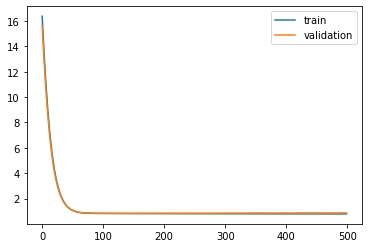

Time to train LSTM:  349.43077325820923
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 14s - loss: 16.3037 - pdc_loss: 0.7429 - event_loss: 0.7441 - val_loss: 15.5644 - val_pdc_loss: 0.7273 - val_event_loss: 0.7099

Epoch 00001: val_loss improved from inf to 15.56445, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 15.3152 - pdc_loss: 0.7235 - event_loss: 0.7023 - val_loss: 14.6121 - val_pdc_loss: 0.7101 - val_event_loss: 0.6717

Epoch 00002: val_loss improved from 15.56445 to 14.61211, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 14.3744 - pdc_loss: 0.7058 - event_loss: 0.6652 - val_loss: 13.7072 - val_pdc_loss: 0.6946 - val_event_loss: 0.6373

Epoch 00003: val_loss improved from 14.61211 to 13.70720, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 13.4809 - pdc_loss: 0.6899 - event_loss: 0.6316 - val_loss: 12.8490 - val_pdc_loss: 0.6808 - val_event_loss: 0.6062

Epoch 00004: val_loss improved from 13.70720 to 1

 - 1s - loss: 1.8782 - pdc_loss: 0.5513 - event_loss: 0.3018 - val_loss: 1.8281 - val_pdc_loss: 0.5652 - val_event_loss: 0.3039

Epoch 00035: val_loss improved from 1.91971 to 1.82810, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 1.7885 - pdc_loss: 0.5502 - event_loss: 0.3013 - val_loss: 1.7438 - val_pdc_loss: 0.5642 - val_event_loss: 0.3034

Epoch 00036: val_loss improved from 1.82810 to 1.74377, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 1.7059 - pdc_loss: 0.5492 - event_loss: 0.3009 - val_loss: 1.6662 - val_pdc_loss: 0.5633 - val_event_loss: 0.3030

Epoch 00037: val_loss improved from 1.74377 to 1.66623, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 1.6300 - pdc_loss: 0.5483 - event_loss: 0.3005 - val_loss: 1.5950 - val_pdc_loss: 0.5624 - val_event_loss: 0.3026

Epoch 00038: val_loss improved from 1.66623 to 1.59497, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 1.5603 - pdc_loss: 0.5474 - event_


Epoch 00069: val_loss improved from 0.88489 to 0.88094, saving model to Event_val_weights3.hdf5
Epoch 70/500
 - 1s - loss: 0.8582 - pdc_loss: 0.5226 - event_loss: 0.2965 - val_loss: 0.8775 - val_pdc_loss: 0.5409 - val_event_loss: 0.2999

Epoch 00070: val_loss improved from 0.88094 to 0.87753, saving model to Event_val_weights3.hdf5
Epoch 71/500
 - 1s - loss: 0.8545 - pdc_loss: 0.5221 - event_loss: 0.2964 - val_loss: 0.8743 - val_pdc_loss: 0.5406 - val_event_loss: 0.2999

Epoch 00071: val_loss improved from 0.87753 to 0.87433, saving model to Event_val_weights3.hdf5
Epoch 72/500
 - 1s - loss: 0.8512 - pdc_loss: 0.5217 - event_loss: 0.2963 - val_loss: 0.8715 - val_pdc_loss: 0.5403 - val_event_loss: 0.2999

Epoch 00072: val_loss improved from 0.87433 to 0.87150, saving model to Event_val_weights3.hdf5
Epoch 73/500
 - 1s - loss: 0.8482 - pdc_loss: 0.5213 - event_loss: 0.2963 - val_loss: 0.8690 - val_pdc_loss: 0.5402 - val_event_loss: 0.2998

Epoch 00073: val_loss improved from 0.87150 to 

 - 1s - loss: 0.8176 - pdc_loss: 0.5126 - event_loss: 0.2944 - val_loss: 0.8462 - val_pdc_loss: 0.5361 - val_event_loss: 0.2996

Epoch 00105: val_loss improved from 0.84662 to 0.84622, saving model to Event_val_weights3.hdf5
Epoch 106/500
 - 1s - loss: 0.8175 - pdc_loss: 0.5127 - event_loss: 0.2944 - val_loss: 0.8461 - val_pdc_loss: 0.5359 - val_event_loss: 0.2997

Epoch 00106: val_loss improved from 0.84622 to 0.84607, saving model to Event_val_weights3.hdf5
Epoch 107/500
 - 1s - loss: 0.8178 - pdc_loss: 0.5130 - event_loss: 0.2944 - val_loss: 0.8461 - val_pdc_loss: 0.5360 - val_event_loss: 0.2996

Epoch 00107: val_loss did not improve from 0.84607
Epoch 108/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5134 - event_loss: 0.2944 - val_loss: 0.8469 - val_pdc_loss: 0.5368 - val_event_loss: 0.2997

Epoch 00108: val_loss did not improve from 0.84607
Epoch 109/500
 - 1s - loss: 0.8181 - pdc_loss: 0.5133 - event_loss: 0.2944 - val_loss: 0.8474 - val_pdc_loss: 0.5373 - val_event_loss: 0.2997

Epoch


Epoch 00145: val_loss did not improve from 0.84376
Epoch 146/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5075 - event_loss: 0.2931 - val_loss: 0.8445 - val_pdc_loss: 0.5340 - val_event_loss: 0.3001

Epoch 00146: val_loss did not improve from 0.84376
Epoch 147/500
 - 1s - loss: 0.8105 - pdc_loss: 0.5070 - event_loss: 0.2930 - val_loss: 0.8449 - val_pdc_loss: 0.5342 - val_event_loss: 0.3002

Epoch 00147: val_loss did not improve from 0.84376
Epoch 148/500
 - 1s - loss: 0.8100 - pdc_loss: 0.5067 - event_loss: 0.2929 - val_loss: 0.8448 - val_pdc_loss: 0.5341 - val_event_loss: 0.3002

Epoch 00148: val_loss did not improve from 0.84376
Epoch 149/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5065 - event_loss: 0.2928 - val_loss: 0.8457 - val_pdc_loss: 0.5350 - val_event_loss: 0.3003

Epoch 00149: val_loss did not improve from 0.84376
Epoch 150/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5066 - event_loss: 0.2927 - val_loss: 0.8456 - val_pdc_loss: 0.5349 - val_event_loss: 0.3002

Epoch 00150: val_loss did not

 - 1s - loss: 0.8065 - pdc_loss: 0.5037 - event_loss: 0.2916 - val_loss: 0.8474 - val_pdc_loss: 0.5352 - val_event_loss: 0.3011

Epoch 00188: val_loss did not improve from 0.84376
Epoch 189/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5038 - event_loss: 0.2915 - val_loss: 0.8476 - val_pdc_loss: 0.5355 - val_event_loss: 0.3009

Epoch 00189: val_loss did not improve from 0.84376
Epoch 190/500
 - 1s - loss: 0.8068 - pdc_loss: 0.5041 - event_loss: 0.2915 - val_loss: 0.8487 - val_pdc_loss: 0.5363 - val_event_loss: 0.3012

Epoch 00190: val_loss did not improve from 0.84376
Epoch 191/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5041 - event_loss: 0.2917 - val_loss: 0.8475 - val_pdc_loss: 0.5352 - val_event_loss: 0.3012

Epoch 00191: val_loss did not improve from 0.84376
Epoch 192/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5035 - event_loss: 0.2916 - val_loss: 0.8470 - val_pdc_loss: 0.5346 - val_event_loss: 0.3012

Epoch 00192: val_loss did not improve from 0.84376
Epoch 193/500
 - 1s - loss: 0.8058 - pdc_los


Epoch 00230: val_loss did not improve from 0.84376
Epoch 231/500
 - 1s - loss: 0.8030 - pdc_loss: 0.5012 - event_loss: 0.2900 - val_loss: 0.8497 - val_pdc_loss: 0.5365 - val_event_loss: 0.3015

Epoch 00231: val_loss did not improve from 0.84376
Epoch 232/500
 - 1s - loss: 0.8027 - pdc_loss: 0.5010 - event_loss: 0.2900 - val_loss: 0.8494 - val_pdc_loss: 0.5361 - val_event_loss: 0.3016

Epoch 00232: val_loss did not improve from 0.84376
Epoch 233/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5010 - event_loss: 0.2899 - val_loss: 0.8497 - val_pdc_loss: 0.5361 - val_event_loss: 0.3018

Epoch 00233: val_loss did not improve from 0.84376
Epoch 234/500
 - 1s - loss: 0.8027 - pdc_loss: 0.5010 - event_loss: 0.2899 - val_loss: 0.8495 - val_pdc_loss: 0.5360 - val_event_loss: 0.3018

Epoch 00234: val_loss did not improve from 0.84376
Epoch 235/500
 - 1s - loss: 0.8026 - pdc_loss: 0.5011 - event_loss: 0.2898 - val_loss: 0.8500 - val_pdc_loss: 0.5364 - val_event_loss: 0.3019

Epoch 00235: val_loss did not

 - 1s - loss: 0.8011 - pdc_loss: 0.5001 - event_loss: 0.2888 - val_loss: 0.8530 - val_pdc_loss: 0.5378 - val_event_loss: 0.3030

Epoch 00273: val_loss did not improve from 0.84376
Epoch 274/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4998 - event_loss: 0.2886 - val_loss: 0.8529 - val_pdc_loss: 0.5378 - val_event_loss: 0.3028

Epoch 00274: val_loss did not improve from 0.84376
Epoch 275/500
 - 1s - loss: 0.8004 - pdc_loss: 0.4996 - event_loss: 0.2885 - val_loss: 0.8528 - val_pdc_loss: 0.5379 - val_event_loss: 0.3027

Epoch 00275: val_loss did not improve from 0.84376
Epoch 276/500
 - 1s - loss: 0.8000 - pdc_loss: 0.4994 - event_loss: 0.2884 - val_loss: 0.8535 - val_pdc_loss: 0.5386 - val_event_loss: 0.3027

Epoch 00276: val_loss did not improve from 0.84376
Epoch 277/500
 - 1s - loss: 0.8000 - pdc_loss: 0.4995 - event_loss: 0.2883 - val_loss: 0.8535 - val_pdc_loss: 0.5383 - val_event_loss: 0.3030

Epoch 00277: val_loss did not improve from 0.84376
Epoch 278/500
 - 1s - loss: 0.8002 - pdc_los


Epoch 00315: val_loss did not improve from 0.84376
Epoch 316/500
 - 1s - loss: 0.7997 - pdc_loss: 0.4992 - event_loss: 0.2880 - val_loss: 0.8586 - val_pdc_loss: 0.5414 - val_event_loss: 0.3047

Epoch 00316: val_loss did not improve from 0.84376
Epoch 317/500
 - 1s - loss: 0.8001 - pdc_loss: 0.4993 - event_loss: 0.2883 - val_loss: 0.8589 - val_pdc_loss: 0.5415 - val_event_loss: 0.3049

Epoch 00317: val_loss did not improve from 0.84376
Epoch 318/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4997 - event_loss: 0.2884 - val_loss: 0.8578 - val_pdc_loss: 0.5409 - val_event_loss: 0.3043

Epoch 00318: val_loss did not improve from 0.84376
Epoch 319/500
 - 1s - loss: 0.8006 - pdc_loss: 0.4997 - event_loss: 0.2883 - val_loss: 0.8571 - val_pdc_loss: 0.5410 - val_event_loss: 0.3035

Epoch 00319: val_loss did not improve from 0.84376
Epoch 320/500
 - 1s - loss: 0.8007 - pdc_loss: 0.4998 - event_loss: 0.2882 - val_loss: 0.8582 - val_pdc_loss: 0.5416 - val_event_loss: 0.3039

Epoch 00320: val_loss did not

 - 1s - loss: 0.7957 - pdc_loss: 0.4966 - event_loss: 0.2862 - val_loss: 0.8584 - val_pdc_loss: 0.5408 - val_event_loss: 0.3048

Epoch 00358: val_loss did not improve from 0.84376
Epoch 359/500
 - 1s - loss: 0.7957 - pdc_loss: 0.4965 - event_loss: 0.2863 - val_loss: 0.8588 - val_pdc_loss: 0.5412 - val_event_loss: 0.3047

Epoch 00359: val_loss did not improve from 0.84376
Epoch 360/500
 - 1s - loss: 0.7955 - pdc_loss: 0.4965 - event_loss: 0.2862 - val_loss: 0.8588 - val_pdc_loss: 0.5410 - val_event_loss: 0.3050

Epoch 00360: val_loss did not improve from 0.84376
Epoch 361/500
 - 1s - loss: 0.7956 - pdc_loss: 0.4965 - event_loss: 0.2862 - val_loss: 0.8585 - val_pdc_loss: 0.5408 - val_event_loss: 0.3048

Epoch 00361: val_loss did not improve from 0.84376
Epoch 362/500
 - 1s - loss: 0.7955 - pdc_loss: 0.4965 - event_loss: 0.2861 - val_loss: 0.8587 - val_pdc_loss: 0.5410 - val_event_loss: 0.3049

Epoch 00362: val_loss did not improve from 0.84376
Epoch 363/500
 - 1s - loss: 0.7958 - pdc_los


Epoch 00400: val_loss did not improve from 0.84376
Epoch 401/500
 - 1s - loss: 0.7929 - pdc_loss: 0.4948 - event_loss: 0.2849 - val_loss: 0.8598 - val_pdc_loss: 0.5418 - val_event_loss: 0.3048

Epoch 00401: val_loss did not improve from 0.84376
Epoch 402/500
 - 1s - loss: 0.7932 - pdc_loss: 0.4951 - event_loss: 0.2850 - val_loss: 0.8589 - val_pdc_loss: 0.5411 - val_event_loss: 0.3047

Epoch 00402: val_loss did not improve from 0.84376
Epoch 403/500
 - 1s - loss: 0.7935 - pdc_loss: 0.4951 - event_loss: 0.2853 - val_loss: 0.8596 - val_pdc_loss: 0.5415 - val_event_loss: 0.3050

Epoch 00403: val_loss did not improve from 0.84376
Epoch 404/500
 - 1s - loss: 0.7939 - pdc_loss: 0.4951 - event_loss: 0.2856 - val_loss: 0.8609 - val_pdc_loss: 0.5420 - val_event_loss: 0.3057

Epoch 00404: val_loss did not improve from 0.84376
Epoch 405/500
 - 1s - loss: 0.7945 - pdc_loss: 0.4956 - event_loss: 0.2858 - val_loss: 0.8629 - val_pdc_loss: 0.5437 - val_event_loss: 0.3061

Epoch 00405: val_loss did not

 - 1s - loss: 0.7924 - pdc_loss: 0.4946 - event_loss: 0.2845 - val_loss: 0.8645 - val_pdc_loss: 0.5444 - val_event_loss: 0.3067

Epoch 00443: val_loss did not improve from 0.84376
Epoch 444/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4950 - event_loss: 0.2844 - val_loss: 0.8651 - val_pdc_loss: 0.5446 - val_event_loss: 0.3071

Epoch 00444: val_loss did not improve from 0.84376
Epoch 445/500
 - 1s - loss: 0.7933 - pdc_loss: 0.4955 - event_loss: 0.2844 - val_loss: 0.8650 - val_pdc_loss: 0.5452 - val_event_loss: 0.3064

Epoch 00445: val_loss did not improve from 0.84376
Epoch 446/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4951 - event_loss: 0.2843 - val_loss: 0.8644 - val_pdc_loss: 0.5441 - val_event_loss: 0.3069

Epoch 00446: val_loss did not improve from 0.84376
Epoch 447/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4944 - event_loss: 0.2850 - val_loss: 0.8641 - val_pdc_loss: 0.5427 - val_event_loss: 0.3080

Epoch 00447: val_loss did not improve from 0.84376
Epoch 448/500
 - 1s - loss: 0.7930 - pdc_los


Epoch 00485: val_loss did not improve from 0.84376
Epoch 486/500
 - 1s - loss: 0.7896 - pdc_loss: 0.4927 - event_loss: 0.2832 - val_loss: 0.8643 - val_pdc_loss: 0.5426 - val_event_loss: 0.3081

Epoch 00486: val_loss did not improve from 0.84376
Epoch 487/500
 - 1s - loss: 0.7895 - pdc_loss: 0.4924 - event_loss: 0.2835 - val_loss: 0.8663 - val_pdc_loss: 0.5446 - val_event_loss: 0.3080

Epoch 00487: val_loss did not improve from 0.84376
Epoch 488/500
 - 1s - loss: 0.7895 - pdc_loss: 0.4925 - event_loss: 0.2833 - val_loss: 0.8654 - val_pdc_loss: 0.5442 - val_event_loss: 0.3075

Epoch 00488: val_loss did not improve from 0.84376
Epoch 489/500
 - 1s - loss: 0.7895 - pdc_loss: 0.4927 - event_loss: 0.2832 - val_loss: 0.8666 - val_pdc_loss: 0.5454 - val_event_loss: 0.3075

Epoch 00489: val_loss did not improve from 0.84376
Epoch 490/500
 - 1s - loss: 0.7900 - pdc_loss: 0.4932 - event_loss: 0.2831 - val_loss: 0.8662 - val_pdc_loss: 0.5451 - val_event_loss: 0.3075

Epoch 00490: val_loss did not

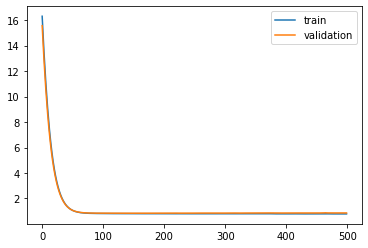

Time to train LSTM:  348.66030859947205
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 12s - loss: 16.1698 - pdc_loss: 0.7226 - event_loss: 0.7003 - val_loss: 15.4316 - val_pdc_loss: 0.7012 - val_event_loss: 0.6702

Epoch 00001: val_loss improved from inf to 15.43162, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 15.1873 - pdc_loss: 0.6999 - event_loss: 0.6640 - val_loss: 14.4874 - val_pdc_loss: 0.6834 - val_event_loss: 0.6370

Epoch 00002: val_loss improved from 15.43162 to 14.48736, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 14.2538 - pdc_loss: 0.6813 - event_loss: 0.6316 - val_loss: 13.5912 - val_pdc_loss: 0.6690 - val_event_loss: 0.6072

Epoch 00003: val_loss improved from 14.48736 to 13.59116, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 13.3683 - pdc_loss: 0.6662 - event_loss: 0.6024 - val_loss: 12.7418 - val_pdc_loss: 0.6573 - val_event_loss: 0.5803

Epoch 00004: val_loss improved from 13.59116 to 1

 - 1s - loss: 1.8596 - pdc_loss: 0.5527 - event_loss: 0.3002 - val_loss: 1.8125 - val_pdc_loss: 0.5634 - val_event_loss: 0.3077

Epoch 00035: val_loss improved from 1.90274 to 1.81252, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 1.7710 - pdc_loss: 0.5518 - event_loss: 0.2998 - val_loss: 1.7296 - val_pdc_loss: 0.5627 - val_event_loss: 0.3073

Epoch 00036: val_loss improved from 1.81252 to 1.72956, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 1.6896 - pdc_loss: 0.5509 - event_loss: 0.2994 - val_loss: 1.6533 - val_pdc_loss: 0.5620 - val_event_loss: 0.3070

Epoch 00037: val_loss improved from 1.72956 to 1.65333, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 1.6148 - pdc_loss: 0.5500 - event_loss: 0.2990 - val_loss: 1.5833 - val_pdc_loss: 0.5614 - val_event_loss: 0.3067

Epoch 00038: val_loss improved from 1.65333 to 1.58333, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 1.5461 - pdc_loss: 0.5491 - event_


Epoch 00069: val_loss improved from 0.89012 to 0.88626, saving model to Event_val_weights4.hdf5
Epoch 70/500
 - 1s - loss: 0.8589 - pdc_loss: 0.5251 - event_loss: 0.2957 - val_loss: 0.8828 - val_pdc_loss: 0.5436 - val_event_loss: 0.3033

Epoch 00070: val_loss improved from 0.88626 to 0.88277, saving model to Event_val_weights4.hdf5
Epoch 71/500
 - 1s - loss: 0.8553 - pdc_loss: 0.5245 - event_loss: 0.2956 - val_loss: 0.8796 - val_pdc_loss: 0.5432 - val_event_loss: 0.3032

Epoch 00071: val_loss improved from 0.88277 to 0.87961, saving model to Event_val_weights4.hdf5
Epoch 72/500
 - 1s - loss: 0.8521 - pdc_loss: 0.5239 - event_loss: 0.2956 - val_loss: 0.8768 - val_pdc_loss: 0.5428 - val_event_loss: 0.3031

Epoch 00072: val_loss improved from 0.87961 to 0.87676, saving model to Event_val_weights4.hdf5
Epoch 73/500
 - 1s - loss: 0.8491 - pdc_loss: 0.5233 - event_loss: 0.2955 - val_loss: 0.8742 - val_pdc_loss: 0.5425 - val_event_loss: 0.3030

Epoch 00073: val_loss improved from 0.87676 to 

 - 1s - loss: 0.8190 - pdc_loss: 0.5139 - event_loss: 0.2942 - val_loss: 0.8494 - val_pdc_loss: 0.5367 - val_event_loss: 0.3018

Epoch 00104: val_loss improved from 0.84963 to 0.84936, saving model to Event_val_weights4.hdf5
Epoch 105/500
 - 1s - loss: 0.8187 - pdc_loss: 0.5137 - event_loss: 0.2941 - val_loss: 0.8491 - val_pdc_loss: 0.5366 - val_event_loss: 0.3017

Epoch 00105: val_loss improved from 0.84936 to 0.84910, saving model to Event_val_weights4.hdf5
Epoch 106/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5136 - event_loss: 0.2941 - val_loss: 0.8488 - val_pdc_loss: 0.5363 - val_event_loss: 0.3017

Epoch 00106: val_loss improved from 0.84910 to 0.84881, saving model to Event_val_weights4.hdf5
Epoch 107/500
 - 1s - loss: 0.8182 - pdc_loss: 0.5134 - event_loss: 0.2941 - val_loss: 0.8486 - val_pdc_loss: 0.5362 - val_event_loss: 0.3017

Epoch 00107: val_loss improved from 0.84881 to 0.84862, saving model to Event_val_weights4.hdf5
Epoch 108/500
 - 1s - loss: 0.8179 - pdc_loss: 0.5132 - ev


Epoch 00142: val_loss did not improve from 0.84550
Epoch 143/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5083 - event_loss: 0.2928 - val_loss: 0.8477 - val_pdc_loss: 0.5358 - val_event_loss: 0.3017

Epoch 00143: val_loss did not improve from 0.84550
Epoch 144/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5083 - event_loss: 0.2928 - val_loss: 0.8479 - val_pdc_loss: 0.5360 - val_event_loss: 0.3017

Epoch 00144: val_loss did not improve from 0.84550
Epoch 145/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5083 - event_loss: 0.2928 - val_loss: 0.8476 - val_pdc_loss: 0.5359 - val_event_loss: 0.3016

Epoch 00145: val_loss did not improve from 0.84550
Epoch 146/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5083 - event_loss: 0.2927 - val_loss: 0.8471 - val_pdc_loss: 0.5354 - val_event_loss: 0.3016

Epoch 00146: val_loss did not improve from 0.84550
Epoch 147/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5083 - event_loss: 0.2926 - val_loss: 0.8468 - val_pdc_loss: 0.5351 - val_event_loss: 0.3016

Epoch 00147: val_loss did not

 - 1s - loss: 0.8068 - pdc_loss: 0.5052 - event_loss: 0.2909 - val_loss: 0.8494 - val_pdc_loss: 0.5364 - val_event_loss: 0.3024

Epoch 00185: val_loss did not improve from 0.84550
Epoch 186/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5053 - event_loss: 0.2908 - val_loss: 0.8491 - val_pdc_loss: 0.5361 - val_event_loss: 0.3024

Epoch 00186: val_loss did not improve from 0.84550
Epoch 187/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5052 - event_loss: 0.2908 - val_loss: 0.8496 - val_pdc_loss: 0.5364 - val_event_loss: 0.3025

Epoch 00187: val_loss did not improve from 0.84550
Epoch 188/500
 - 1s - loss: 0.8068 - pdc_loss: 0.5055 - event_loss: 0.2907 - val_loss: 0.8487 - val_pdc_loss: 0.5355 - val_event_loss: 0.3025

Epoch 00188: val_loss did not improve from 0.84550
Epoch 189/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5055 - event_loss: 0.2907 - val_loss: 0.8512 - val_pdc_loss: 0.5379 - val_event_loss: 0.3026

Epoch 00189: val_loss did not improve from 0.84550
Epoch 190/500
 - 1s - loss: 0.8078 - pdc_los


Epoch 00227: val_loss did not improve from 0.84550
Epoch 228/500
 - 1s - loss: 0.8038 - pdc_loss: 0.5023 - event_loss: 0.2899 - val_loss: 0.8510 - val_pdc_loss: 0.5362 - val_event_loss: 0.3033

Epoch 00228: val_loss did not improve from 0.84550
Epoch 229/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5021 - event_loss: 0.2895 - val_loss: 0.8506 - val_pdc_loss: 0.5358 - val_event_loss: 0.3033

Epoch 00229: val_loss did not improve from 0.84550
Epoch 230/500
 - 1s - loss: 0.8029 - pdc_loss: 0.5022 - event_loss: 0.2893 - val_loss: 0.8498 - val_pdc_loss: 0.5350 - val_event_loss: 0.3033

Epoch 00230: val_loss did not improve from 0.84550
Epoch 231/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5024 - event_loss: 0.2892 - val_loss: 0.8502 - val_pdc_loss: 0.5352 - val_event_loss: 0.3036

Epoch 00231: val_loss did not improve from 0.84550
Epoch 232/500
 - 1s - loss: 0.8031 - pdc_loss: 0.5025 - event_loss: 0.2891 - val_loss: 0.8503 - val_pdc_loss: 0.5352 - val_event_loss: 0.3036

Epoch 00232: val_loss did not

 - 1s - loss: 0.8003 - pdc_loss: 0.5004 - event_loss: 0.2879 - val_loss: 0.8536 - val_pdc_loss: 0.5376 - val_event_loss: 0.3040

Epoch 00270: val_loss did not improve from 0.84550
Epoch 271/500
 - 1s - loss: 0.8004 - pdc_loss: 0.5005 - event_loss: 0.2879 - val_loss: 0.8536 - val_pdc_loss: 0.5371 - val_event_loss: 0.3044

Epoch 00271: val_loss did not improve from 0.84550
Epoch 272/500
 - 1s - loss: 0.8007 - pdc_loss: 0.5005 - event_loss: 0.2881 - val_loss: 0.8545 - val_pdc_loss: 0.5376 - val_event_loss: 0.3049

Epoch 00272: val_loss did not improve from 0.84550
Epoch 273/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5006 - event_loss: 0.2883 - val_loss: 0.8546 - val_pdc_loss: 0.5375 - val_event_loss: 0.3050

Epoch 00273: val_loss did not improve from 0.84550
Epoch 274/500
 - 1s - loss: 0.8011 - pdc_loss: 0.5004 - event_loss: 0.2886 - val_loss: 0.8543 - val_pdc_loss: 0.5376 - val_event_loss: 0.3046

Epoch 00274: val_loss did not improve from 0.84550
Epoch 275/500
 - 1s - loss: 0.8006 - pdc_los


Epoch 00312: val_loss did not improve from 0.84550
Epoch 313/500
 - 1s - loss: 0.7986 - pdc_loss: 0.4990 - event_loss: 0.2867 - val_loss: 0.8610 - val_pdc_loss: 0.5411 - val_event_loss: 0.3070

Epoch 00313: val_loss did not improve from 0.84550
Epoch 314/500
 - 1s - loss: 0.7986 - pdc_loss: 0.4981 - event_loss: 0.2876 - val_loss: 0.8612 - val_pdc_loss: 0.5402 - val_event_loss: 0.3081

Epoch 00314: val_loss did not improve from 0.84550
Epoch 315/500
 - 1s - loss: 0.7986 - pdc_loss: 0.4976 - event_loss: 0.2880 - val_loss: 0.8591 - val_pdc_loss: 0.5397 - val_event_loss: 0.3065

Epoch 00315: val_loss did not improve from 0.84550
Epoch 316/500
 - 1s - loss: 0.7979 - pdc_loss: 0.4974 - event_loss: 0.2876 - val_loss: 0.8598 - val_pdc_loss: 0.5415 - val_event_loss: 0.3054

Epoch 00316: val_loss did not improve from 0.84550
Epoch 317/500
 - 1s - loss: 0.7979 - pdc_loss: 0.4978 - event_loss: 0.2872 - val_loss: 0.8626 - val_pdc_loss: 0.5445 - val_event_loss: 0.3052

Epoch 00317: val_loss did not

 - 1s - loss: 0.7974 - pdc_loss: 0.4969 - event_loss: 0.2868 - val_loss: 0.8591 - val_pdc_loss: 0.5395 - val_event_loss: 0.3060

Epoch 00355: val_loss did not improve from 0.84550
Epoch 356/500
 - 1s - loss: 0.7960 - pdc_loss: 0.4964 - event_loss: 0.2860 - val_loss: 0.8628 - val_pdc_loss: 0.5408 - val_event_loss: 0.3083

Epoch 00356: val_loss did not improve from 0.84550
Epoch 357/500
 - 1s - loss: 0.7968 - pdc_loss: 0.4967 - event_loss: 0.2864 - val_loss: 0.8658 - val_pdc_loss: 0.5457 - val_event_loss: 0.3065

Epoch 00357: val_loss did not improve from 0.84550
Epoch 358/500
 - 1s - loss: 0.7966 - pdc_loss: 0.4973 - event_loss: 0.2857 - val_loss: 0.8620 - val_pdc_loss: 0.5423 - val_event_loss: 0.3060

Epoch 00358: val_loss did not improve from 0.84550
Epoch 359/500
 - 1s - loss: 0.7954 - pdc_loss: 0.4964 - event_loss: 0.2853 - val_loss: 0.8593 - val_pdc_loss: 0.5400 - val_event_loss: 0.3057

Epoch 00359: val_loss did not improve from 0.84550
Epoch 360/500
 - 1s - loss: 0.7952 - pdc_los


Epoch 00397: val_loss did not improve from 0.84550
Epoch 398/500
 - 1s - loss: 0.7940 - pdc_loss: 0.4953 - event_loss: 0.2849 - val_loss: 0.8610 - val_pdc_loss: 0.5401 - val_event_loss: 0.3070

Epoch 00398: val_loss did not improve from 0.84550
Epoch 399/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4946 - event_loss: 0.2844 - val_loss: 0.8617 - val_pdc_loss: 0.5412 - val_event_loss: 0.3067

Epoch 00399: val_loss did not improve from 0.84550
Epoch 400/500
 - 1s - loss: 0.7932 - pdc_loss: 0.4953 - event_loss: 0.2841 - val_loss: 0.8613 - val_pdc_loss: 0.5403 - val_event_loss: 0.3071

Epoch 00400: val_loss did not improve from 0.84550
Epoch 401/500
 - 1s - loss: 0.7926 - pdc_loss: 0.4950 - event_loss: 0.2838 - val_loss: 0.8657 - val_pdc_loss: 0.5444 - val_event_loss: 0.3075

Epoch 00401: val_loss did not improve from 0.84550
Epoch 402/500
 - 1s - loss: 0.7926 - pdc_loss: 0.4950 - event_loss: 0.2838 - val_loss: 0.8687 - val_pdc_loss: 0.5459 - val_event_loss: 0.3089

Epoch 00402: val_loss did not

 - 1s - loss: 0.7919 - pdc_loss: 0.4943 - event_loss: 0.2837 - val_loss: 0.8694 - val_pdc_loss: 0.5461 - val_event_loss: 0.3093

Epoch 00440: val_loss did not improve from 0.84550
Epoch 441/500
 - 1s - loss: 0.7921 - pdc_loss: 0.4943 - event_loss: 0.2838 - val_loss: 0.8647 - val_pdc_loss: 0.5425 - val_event_loss: 0.3082

Epoch 00441: val_loss did not improve from 0.84550
Epoch 442/500
 - 1s - loss: 0.7909 - pdc_loss: 0.4934 - event_loss: 0.2836 - val_loss: 0.8640 - val_pdc_loss: 0.5418 - val_event_loss: 0.3082

Epoch 00442: val_loss did not improve from 0.84550
Epoch 443/500
 - 1s - loss: 0.7903 - pdc_loss: 0.4933 - event_loss: 0.2830 - val_loss: 0.8631 - val_pdc_loss: 0.5414 - val_event_loss: 0.3076

Epoch 00443: val_loss did not improve from 0.84550
Epoch 444/500
 - 1s - loss: 0.7900 - pdc_loss: 0.4933 - event_loss: 0.2827 - val_loss: 0.8651 - val_pdc_loss: 0.5427 - val_event_loss: 0.3084

Epoch 00444: val_loss did not improve from 0.84550
Epoch 445/500
 - 1s - loss: 0.7902 - pdc_los


Epoch 00482: val_loss did not improve from 0.84550
Epoch 483/500
 - 1s - loss: 0.7906 - pdc_loss: 0.4941 - event_loss: 0.2824 - val_loss: 0.8682 - val_pdc_loss: 0.5444 - val_event_loss: 0.3097

Epoch 00483: val_loss did not improve from 0.84550
Epoch 484/500
 - 1s - loss: 0.7884 - pdc_loss: 0.4923 - event_loss: 0.2820 - val_loss: 0.8672 - val_pdc_loss: 0.5435 - val_event_loss: 0.3095

Epoch 00484: val_loss did not improve from 0.84550
Epoch 485/500
 - 1s - loss: 0.7880 - pdc_loss: 0.4920 - event_loss: 0.2818 - val_loss: 0.8671 - val_pdc_loss: 0.5436 - val_event_loss: 0.3094

Epoch 00485: val_loss did not improve from 0.84550
Epoch 486/500
 - 1s - loss: 0.7886 - pdc_loss: 0.4928 - event_loss: 0.2817 - val_loss: 0.8680 - val_pdc_loss: 0.5437 - val_event_loss: 0.3102

Epoch 00486: val_loss did not improve from 0.84550
Epoch 487/500
 - 1s - loss: 0.7886 - pdc_loss: 0.4925 - event_loss: 0.2820 - val_loss: 0.8705 - val_pdc_loss: 0.5454 - val_event_loss: 0.3110

Epoch 00487: val_loss did not

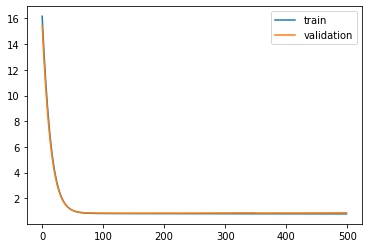

Time to train LSTM:  350.21886920928955
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 12s - loss: 16.1624 - pdc_loss: 0.7502 - event_loss: 0.7028 - val_loss: 15.4398 - val_pdc_loss: 0.7367 - val_event_loss: 0.6816

Epoch 00001: val_loss improved from inf to 15.43977, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 15.1835 - pdc_loss: 0.7269 - event_loss: 0.6724 - val_loss: 14.4956 - val_pdc_loss: 0.7164 - val_event_loss: 0.6523

Epoch 00002: val_loss improved from 15.43977 to 14.49560, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 14.2521 - pdc_loss: 0.7073 - event_loss: 0.6440 - val_loss: 13.5987 - val_pdc_loss: 0.6994 - val_event_loss: 0.6250

Epoch 00003: val_loss improved from 14.49560 to 13.59867, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 13.3677 - pdc_loss: 0.6908 - event_loss: 0.6177 - val_loss: 12.7483 - val_pdc_loss: 0.6850 - val_event_loss: 0.5995

Epoch 00004: val_loss improved from 13.59867 to 1

 - 1s - loss: 1.8633 - pdc_loss: 0.5538 - event_loss: 0.3006 - val_loss: 1.8031 - val_pdc_loss: 0.5557 - val_event_loss: 0.3035

Epoch 00035: val_loss improved from 1.89344 to 1.80311, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 1.7749 - pdc_loss: 0.5527 - event_loss: 0.3002 - val_loss: 1.7200 - val_pdc_loss: 0.5546 - val_event_loss: 0.3032

Epoch 00036: val_loss improved from 1.80311 to 1.71996, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 1.6936 - pdc_loss: 0.5516 - event_loss: 0.2999 - val_loss: 1.6435 - val_pdc_loss: 0.5535 - val_event_loss: 0.3029

Epoch 00037: val_loss improved from 1.71996 to 1.64351, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 1.6188 - pdc_loss: 0.5506 - event_loss: 0.2996 - val_loss: 1.5732 - val_pdc_loss: 0.5524 - val_event_loss: 0.3027

Epoch 00038: val_loss improved from 1.64351 to 1.57324, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 1.5501 - pdc_loss: 0.5496 - event_


Epoch 00069: val_loss improved from 0.87009 to 0.86619, saving model to Event_val_weights5.hdf5
Epoch 70/500
 - 1s - loss: 0.8595 - pdc_loss: 0.5241 - event_loss: 0.2967 - val_loss: 0.8627 - val_pdc_loss: 0.5268 - val_event_loss: 0.2995

Epoch 00070: val_loss improved from 0.86619 to 0.86273, saving model to Event_val_weights5.hdf5
Epoch 71/500
 - 1s - loss: 0.8560 - pdc_loss: 0.5237 - event_loss: 0.2967 - val_loss: 0.8595 - val_pdc_loss: 0.5265 - val_event_loss: 0.2994

Epoch 00071: val_loss improved from 0.86273 to 0.85953, saving model to Event_val_weights5.hdf5
Epoch 72/500
 - 1s - loss: 0.8528 - pdc_loss: 0.5233 - event_loss: 0.2966 - val_loss: 0.8569 - val_pdc_loss: 0.5264 - val_event_loss: 0.2994

Epoch 00072: val_loss improved from 0.85953 to 0.85685, saving model to Event_val_weights5.hdf5
Epoch 73/500
 - 1s - loss: 0.8499 - pdc_loss: 0.5229 - event_loss: 0.2965 - val_loss: 0.8542 - val_pdc_loss: 0.5260 - val_event_loss: 0.2993

Epoch 00073: val_loss improved from 0.85685 to 

 - 1s - loss: 0.8217 - pdc_loss: 0.5157 - event_loss: 0.2949 - val_loss: 0.8314 - val_pdc_loss: 0.5222 - val_event_loss: 0.2981

Epoch 00104: val_loss improved from 0.83169 to 0.83140, saving model to Event_val_weights5.hdf5
Epoch 105/500
 - 1s - loss: 0.8215 - pdc_loss: 0.5155 - event_loss: 0.2948 - val_loss: 0.8313 - val_pdc_loss: 0.5221 - val_event_loss: 0.2981

Epoch 00105: val_loss improved from 0.83140 to 0.83126, saving model to Event_val_weights5.hdf5
Epoch 106/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5154 - event_loss: 0.2948 - val_loss: 0.8314 - val_pdc_loss: 0.5223 - val_event_loss: 0.2981

Epoch 00106: val_loss did not improve from 0.83126
Epoch 107/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5152 - event_loss: 0.2948 - val_loss: 0.8313 - val_pdc_loss: 0.5222 - val_event_loss: 0.2981

Epoch 00107: val_loss improved from 0.83126 to 0.83125, saving model to Event_val_weights5.hdf5
Epoch 108/500
 - 1s - loss: 0.8208 - pdc_loss: 0.5151 - event_loss: 0.2947 - val_loss: 0.8314 - val_pdc

 - 1s - loss: 0.8142 - pdc_loss: 0.5098 - event_loss: 0.2933 - val_loss: 0.8301 - val_pdc_loss: 0.5207 - val_event_loss: 0.2982

Epoch 00144: val_loss did not improve from 0.82979
Epoch 145/500
 - 1s - loss: 0.8143 - pdc_loss: 0.5099 - event_loss: 0.2932 - val_loss: 0.8307 - val_pdc_loss: 0.5215 - val_event_loss: 0.2981

Epoch 00145: val_loss did not improve from 0.82979
Epoch 146/500
 - 1s - loss: 0.8147 - pdc_loss: 0.5103 - event_loss: 0.2932 - val_loss: 0.8311 - val_pdc_loss: 0.5218 - val_event_loss: 0.2981

Epoch 00146: val_loss did not improve from 0.82979
Epoch 147/500
 - 1s - loss: 0.8150 - pdc_loss: 0.5106 - event_loss: 0.2933 - val_loss: 0.8317 - val_pdc_loss: 0.5225 - val_event_loss: 0.2981

Epoch 00147: val_loss did not improve from 0.82979
Epoch 148/500
 - 1s - loss: 0.8152 - pdc_loss: 0.5108 - event_loss: 0.2932 - val_loss: 0.8316 - val_pdc_loss: 0.5223 - val_event_loss: 0.2981

Epoch 00148: val_loss did not improve from 0.82979
Epoch 149/500
 - 1s - loss: 0.8152 - pdc_los


Epoch 00186: val_loss did not improve from 0.82979
Epoch 187/500
 - 1s - loss: 0.8106 - pdc_loss: 0.5071 - event_loss: 0.2915 - val_loss: 0.8320 - val_pdc_loss: 0.5212 - val_event_loss: 0.2988

Epoch 00187: val_loss did not improve from 0.82979
Epoch 188/500
 - 1s - loss: 0.8107 - pdc_loss: 0.5072 - event_loss: 0.2915 - val_loss: 0.8328 - val_pdc_loss: 0.5218 - val_event_loss: 0.2990

Epoch 00188: val_loss did not improve from 0.82979
Epoch 189/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5072 - event_loss: 0.2915 - val_loss: 0.8325 - val_pdc_loss: 0.5216 - val_event_loss: 0.2988

Epoch 00189: val_loss did not improve from 0.82979
Epoch 190/500
 - 1s - loss: 0.8109 - pdc_loss: 0.5073 - event_loss: 0.2915 - val_loss: 0.8335 - val_pdc_loss: 0.5223 - val_event_loss: 0.2991

Epoch 00190: val_loss did not improve from 0.82979
Epoch 191/500
 - 1s - loss: 0.8108 - pdc_loss: 0.5072 - event_loss: 0.2915 - val_loss: 0.8350 - val_pdc_loss: 0.5234 - val_event_loss: 0.2994

Epoch 00191: val_loss did not

 - 1s - loss: 0.8066 - pdc_loss: 0.5038 - event_loss: 0.2900 - val_loss: 0.8371 - val_pdc_loss: 0.5238 - val_event_loss: 0.3005

Epoch 00229: val_loss did not improve from 0.82979
Epoch 230/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5030 - event_loss: 0.2900 - val_loss: 0.8351 - val_pdc_loss: 0.5221 - val_event_loss: 0.3002

Epoch 00230: val_loss did not improve from 0.82979
Epoch 231/500
 - 1s - loss: 0.8054 - pdc_loss: 0.5029 - event_loss: 0.2898 - val_loss: 0.8348 - val_pdc_loss: 0.5220 - val_event_loss: 0.2999

Epoch 00231: val_loss did not improve from 0.82979
Epoch 232/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5034 - event_loss: 0.2898 - val_loss: 0.8354 - val_pdc_loss: 0.5227 - val_event_loss: 0.2999

Epoch 00232: val_loss did not improve from 0.82979
Epoch 233/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5044 - event_loss: 0.2900 - val_loss: 0.8366 - val_pdc_loss: 0.5235 - val_event_loss: 0.3003

Epoch 00233: val_loss did not improve from 0.82979
Epoch 234/500
 - 1s - loss: 0.8080 - pdc_los


Epoch 00271: val_loss did not improve from 0.82979
Epoch 272/500
 - 1s - loss: 0.8037 - pdc_loss: 0.5018 - event_loss: 0.2885 - val_loss: 0.8384 - val_pdc_loss: 0.5240 - val_event_loss: 0.3010

Epoch 00272: val_loss did not improve from 0.82979
Epoch 273/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5027 - event_loss: 0.2885 - val_loss: 0.8378 - val_pdc_loss: 0.5233 - val_event_loss: 0.3011

Epoch 00273: val_loss did not improve from 0.82979
Epoch 274/500
 - 1s - loss: 0.8042 - pdc_loss: 0.5024 - event_loss: 0.2885 - val_loss: 0.8372 - val_pdc_loss: 0.5228 - val_event_loss: 0.3010

Epoch 00274: val_loss did not improve from 0.82979
Epoch 275/500
 - 1s - loss: 0.8036 - pdc_loss: 0.5018 - event_loss: 0.2884 - val_loss: 0.8403 - val_pdc_loss: 0.5246 - val_event_loss: 0.3023

Epoch 00275: val_loss did not improve from 0.82979
Epoch 276/500
 - 1s - loss: 0.8034 - pdc_loss: 0.5014 - event_loss: 0.2887 - val_loss: 0.8428 - val_pdc_loss: 0.5260 - val_event_loss: 0.3034

Epoch 00276: val_loss did not

 - 1s - loss: 0.8000 - pdc_loss: 0.4990 - event_loss: 0.2873 - val_loss: 0.8399 - val_pdc_loss: 0.5240 - val_event_loss: 0.3022

Epoch 00314: val_loss did not improve from 0.82979
Epoch 315/500
 - 1s - loss: 0.7999 - pdc_loss: 0.4992 - event_loss: 0.2870 - val_loss: 0.8402 - val_pdc_loss: 0.5244 - val_event_loss: 0.3021

Epoch 00315: val_loss did not improve from 0.82979
Epoch 316/500
 - 1s - loss: 0.8010 - pdc_loss: 0.5002 - event_loss: 0.2872 - val_loss: 0.8410 - val_pdc_loss: 0.5246 - val_event_loss: 0.3027

Epoch 00316: val_loss did not improve from 0.82979
Epoch 317/500
 - 1s - loss: 0.8009 - pdc_loss: 0.5001 - event_loss: 0.2871 - val_loss: 0.8395 - val_pdc_loss: 0.5236 - val_event_loss: 0.3021

Epoch 00317: val_loss did not improve from 0.82979
Epoch 318/500
 - 1s - loss: 0.8007 - pdc_loss: 0.5000 - event_loss: 0.2869 - val_loss: 0.8421 - val_pdc_loss: 0.5250 - val_event_loss: 0.3033

Epoch 00318: val_loss did not improve from 0.82979
Epoch 319/500
 - 1s - loss: 0.8006 - pdc_los


Epoch 00356: val_loss did not improve from 0.82979
Epoch 357/500
 - 1s - loss: 0.7980 - pdc_loss: 0.4982 - event_loss: 0.2857 - val_loss: 0.8432 - val_pdc_loss: 0.5258 - val_event_loss: 0.3034

Epoch 00357: val_loss did not improve from 0.82979
Epoch 358/500
 - 1s - loss: 0.7980 - pdc_loss: 0.4981 - event_loss: 0.2858 - val_loss: 0.8425 - val_pdc_loss: 0.5248 - val_event_loss: 0.3036

Epoch 00358: val_loss did not improve from 0.82979
Epoch 359/500
 - 1s - loss: 0.7977 - pdc_loss: 0.4977 - event_loss: 0.2859 - val_loss: 0.8460 - val_pdc_loss: 0.5270 - val_event_loss: 0.3049

Epoch 00359: val_loss did not improve from 0.82979
Epoch 360/500
 - 1s - loss: 0.7975 - pdc_loss: 0.4973 - event_loss: 0.2862 - val_loss: 0.8470 - val_pdc_loss: 0.5274 - val_event_loss: 0.3055

Epoch 00360: val_loss did not improve from 0.82979
Epoch 361/500
 - 1s - loss: 0.7973 - pdc_loss: 0.4971 - event_loss: 0.2862 - val_loss: 0.8437 - val_pdc_loss: 0.5257 - val_event_loss: 0.3039

Epoch 00361: val_loss did not

 - 1s - loss: 0.7957 - pdc_loss: 0.4965 - event_loss: 0.2849 - val_loss: 0.8459 - val_pdc_loss: 0.5268 - val_event_loss: 0.3049

Epoch 00399: val_loss did not improve from 0.82979
Epoch 400/500
 - 1s - loss: 0.7955 - pdc_loss: 0.4962 - event_loss: 0.2850 - val_loss: 0.8481 - val_pdc_loss: 0.5280 - val_event_loss: 0.3058

Epoch 00400: val_loss did not improve from 0.82979
Epoch 401/500
 - 1s - loss: 0.7956 - pdc_loss: 0.4958 - event_loss: 0.2854 - val_loss: 0.8489 - val_pdc_loss: 0.5278 - val_event_loss: 0.3068

Epoch 00401: val_loss did not improve from 0.82979
Epoch 402/500
 - 1s - loss: 0.7953 - pdc_loss: 0.4954 - event_loss: 0.2855 - val_loss: 0.8466 - val_pdc_loss: 0.5270 - val_event_loss: 0.3053

Epoch 00402: val_loss did not improve from 0.82979
Epoch 403/500
 - 1s - loss: 0.7944 - pdc_loss: 0.4952 - event_loss: 0.2849 - val_loss: 0.8448 - val_pdc_loss: 0.5262 - val_event_loss: 0.3043

Epoch 00403: val_loss did not improve from 0.82979
Epoch 404/500
 - 1s - loss: 0.7951 - pdc_los


Epoch 00441: val_loss did not improve from 0.82979
Epoch 442/500
 - 1s - loss: 0.7928 - pdc_loss: 0.4945 - event_loss: 0.2840 - val_loss: 0.8484 - val_pdc_loss: 0.5289 - val_event_loss: 0.3052

Epoch 00442: val_loss did not improve from 0.82979
Epoch 443/500
 - 1s - loss: 0.7924 - pdc_loss: 0.4941 - event_loss: 0.2840 - val_loss: 0.8516 - val_pdc_loss: 0.5308 - val_event_loss: 0.3065

Epoch 00443: val_loss did not improve from 0.82979
Epoch 444/500
 - 1s - loss: 0.7922 - pdc_loss: 0.4938 - event_loss: 0.2841 - val_loss: 0.8505 - val_pdc_loss: 0.5290 - val_event_loss: 0.3073

Epoch 00444: val_loss did not improve from 0.82979
Epoch 445/500
 - 1s - loss: 0.7919 - pdc_loss: 0.4934 - event_loss: 0.2842 - val_loss: 0.8473 - val_pdc_loss: 0.5270 - val_event_loss: 0.3059

Epoch 00445: val_loss did not improve from 0.82979
Epoch 446/500
 - 1s - loss: 0.7921 - pdc_loss: 0.4937 - event_loss: 0.2841 - val_loss: 0.8474 - val_pdc_loss: 0.5283 - val_event_loss: 0.3047

Epoch 00446: val_loss did not

 - 1s - loss: 0.7904 - pdc_loss: 0.4926 - event_loss: 0.2834 - val_loss: 0.8504 - val_pdc_loss: 0.5294 - val_event_loss: 0.3065

Epoch 00484: val_loss did not improve from 0.82979
Epoch 485/500
 - 1s - loss: 0.7905 - pdc_loss: 0.4926 - event_loss: 0.2835 - val_loss: 0.8510 - val_pdc_loss: 0.5298 - val_event_loss: 0.3067

Epoch 00485: val_loss did not improve from 0.82979
Epoch 486/500
 - 1s - loss: 0.7900 - pdc_loss: 0.4925 - event_loss: 0.2831 - val_loss: 0.8547 - val_pdc_loss: 0.5316 - val_event_loss: 0.3087

Epoch 00486: val_loss did not improve from 0.82979
Epoch 487/500
 - 1s - loss: 0.7907 - pdc_loss: 0.4925 - event_loss: 0.2838 - val_loss: 0.8523 - val_pdc_loss: 0.5297 - val_event_loss: 0.3083

Epoch 00487: val_loss did not improve from 0.82979
Epoch 488/500
 - 1s - loss: 0.7896 - pdc_loss: 0.4917 - event_loss: 0.2835 - val_loss: 0.8491 - val_pdc_loss: 0.5288 - val_event_loss: 0.3059

Epoch 00488: val_loss did not improve from 0.82979
Epoch 489/500
 - 1s - loss: 0.7892 - pdc_los

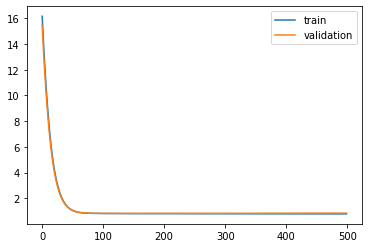

Time to train LSTM:  348.75777292251587
Entire process took:  17192.030776023865
Experiment record:
[[16, 2048, 0, 0.8224167359670004], [16, 2048, 1, 0.8401647506819832], [16, 2048, 2, 0.8433566116756863], [16, 2048, 3, 0.8464996161990695], [16, 2048, 4, 0.8281297560267978], [16, 4096, 0, 0.820447082095676], [16, 4096, 1, 0.8368666137589349], [16, 4096, 2, 0.844096617380778], [16, 4096, 3, 0.8447988412115309], [16, 4096, 4, 0.8285953990618388], [16, 8192, 0, 0.8171780200534396], [16, 8192, 1, 0.8348839523527357], [16, 8192, 2, 0.8414138742023044], [16, 8192, 3, 0.8440553790198432], [16, 8192, 4, 0.8267391532791986], [16, 16384, 0, 0.8187218904495239], [16, 16384, 1, 0.8349984884262085], [16, 16384, 2, 0.8447635173797607], [16, 16384, 3, 0.8465043902397156], [16, 16384, 4, 0.8230348825454712], [16, 32768, 0, 0.8200851082801819], [16, 32768, 1, 0.8365710377693176], [16, 32768, 2, 0.8429827094078064], [16, 32768, 3, 0.8476284146308899], [16, 32768, 4, 0.8282528519630432], [32, 2048, 0, 0.

In [10]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [2, 4, 8, 16, 32]
batch_size_list = [2048, 4096, 8192, 16384, 32768]

start_time = time.time()

exp_record = []

for units in units_list:
    for batch_s in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_lstm = np.append(train2_x, train1_x, axis=0) 
            train1_y_pdc = y_pdc_train[:end, ]
            train2_y_pdc = y_pdc_train[end:, ]
            train_y_pdc = np.append(train2_y_pdc, train1_y_pdc, axis=0)
            train1_y_event = y_event_train[:end, ]
            train2_y_event = y_event_train[end:, ]
            train_y_event = np.append(train2_y_event, train1_y_event, axis=0)
            

            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                x = Input(shape=(8, 182), name="obs")
                model = CuDNNLSTM(units,
                                  kernel_regularizer=regularizers.l2(0.1))(x)
                out_pdc = Dense(2, activation='softmax', name="pdc")(model)
                out_event = Dense(2, activation='softmax', name="event")(model)
                multi_out_model = Model(x, outputs=[out_pdc, out_event])
                multi_out_model.compile(loss=["categorical_crossentropy",
                                    "categorical_crossentropy"],
                              #{"pdc":keras.losses.CategoricalCrossentropy(from_logit=True),\
                              #      "event":keras.losses.CategoricalCrossentropy(from_logit=True)}, 
                              optimizer='adam', 
                              #loss_weight=[1.0,1.0])
                              )  
                val_weight = "Event_val_weights" + str(f+1) + ".hdf5"
                val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
                history = multi_out_model.fit({"obs":train_x_lstm}, 
                                              {"pdc":train_y_pdc, 
                                               "event":train_y_event},
                                                batch_size=batch_s, 
                                                epochs=500, validation_split=0.1, 
                                                callbacks=[val_checkpointer], 
                                                verbose=2, 
                                                shuffle=False) 
                print("#################################")
                print("Number of units:", units)
                print("Batch size:", batch_s)
                print("Fold:", f)
                print("best val loss:", min(history.history['val_loss']))
                exp_record.append([units, batch_s, f, min(history.history['val_loss'])])
                print("#################################")
                if(f==4):
                    print(exp_record)
                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='validation')
                pyplot.legend()
                pyplot.show()
            end_time = time.time()
            print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [12]:
exp_record = [[2, 2048, 0, 0.8343072879579332], [2, 2048, 1, 0.8469176051881578], [2, 2048, 2, 0.85068948258294], [2, 2048, 3, 0.8572612755033705], [2, 2048, 4, 0.8386627321773105], [2, 4096, 0, 0.8332387713326348], [2, 4096, 1, 0.8455573871400621], [2, 4096, 2, 0.8485712782541911], [2, 4096, 3, 0.8564408255683051], [2, 4096, 4, 0.8369912167125279], [2, 8192, 0, 0.8336184877819485], [2, 8192, 1, 0.8447979051272074], [2, 8192, 2, 0.8489448352919684], [2, 8192, 3, 0.8589536547660828], [2, 8192, 4, 0.8366112408638], [2, 16384, 0, 0.8371636867523193], [2, 16384, 1, 0.8494085669517517], [2, 16384, 2, 0.854156494140625], [2, 16384, 3, 0.8627237677574158], [2, 16384, 4, 0.8423912525177002], [2, 32768, 0, 0.8459058403968811], [2, 32768, 1, 0.8570360541343689], [2, 32768, 2, 0.8581773638725281], [2, 32768, 3, 0.8671332597732544], [2, 32768, 4, 0.845038890838623], [4, 2048, 0, 0.8186744775772095], [4, 2048, 1, 0.8360174654324849], [4, 2048, 2, 0.8396886728604634], [4, 2048, 3, 0.8450348358154297], [4, 2048, 4, 0.8249991057184007], [4, 4096, 0, 0.822689490477244], [4, 4096, 1, 0.835632167286343], [4, 4096, 2, 0.8386252910296123], [4, 4096, 3, 0.8441602804395888], [4, 4096, 4, 0.8239166485998366], [4, 8192, 0, 0.8198489000532362], [4, 8192, 1, 0.833278371863895], [4, 8192, 2, 0.837372793091668], [4, 8192, 3, 0.8405458438131544], [4, 8192, 4, 0.8236597624354892], [4, 16384, 0, 0.818021297454834], [4, 16384, 1, 0.8357753157615662], [4, 16384, 2, 0.8424822688102722], [4, 16384, 3, 0.8476489782333374], [4, 16384, 4, 0.8309867978096008], [4, 32768, 0, 0.8278829455375671], [4, 32768, 1, 0.8425799012184143], [4, 32768, 2, 0.8468563556671143], [4, 32768, 3, 0.8520311117172241], [4, 32768, 4, 0.8292228579521179], [8, 2048, 0, 0.818594774723053], [8, 2048, 1, 0.8356152429580689], [8, 2048, 2, 0.8407446882989672], [8, 2048, 3, 0.8436176784303453], [8, 2048, 4, 0.825471815639072],[8, 4096, 0, 0.8152800582779779], [8, 4096, 1, 0.8359661087989807], [8, 4096, 2, 0.8385241052839492], [8, 4096, 3, 0.8438400204446581], [8, 4096, 4, 0.8221581108305189], [8, 8192, 0, 0.8118186771074931], [8, 8192, 1, 0.8317986426353454], [8, 8192, 2, 0.8384465485678779], [8, 8192, 3, 0.8401234076817831], [8, 8192, 4, 0.818443073272705], [8, 16384, 0, 0.816001296043396], [8, 16384, 1, 0.8331431746482849], [8, 16384, 2, 0.8397676348686218], [8, 16384, 3, 0.8414759039878845], [8, 16384, 4, 0.8218511939048767], [8, 32768, 0, 0.8154001832008362], [8, 32768, 1, 0.8339659571647644], [8, 32768, 2, 0.8391462564468384], [8, 32768, 3, 0.8416892290115356], [8, 32768, 4, 0.8241137266159058], [16, 2048, 0, 0.8224167359670004], [16, 2048, 1, 0.8401647506819832], [16, 2048, 2, 0.8433566116756863], [16, 2048, 3, 0.8464996161990695], [16, 2048, 4, 0.8281297560267978], [16, 4096, 0, 0.820447082095676], [16, 4096, 1, 0.8368666137589349], [16, 4096, 2, 0.844096617380778], [16, 4096, 3, 0.8447988412115309], [16, 4096, 4, 0.8285953990618388], [16, 8192, 0, 0.8171780200534396], [16, 8192, 1, 0.8348839523527357], [16, 8192, 2, 0.8414138742023044], [16, 8192, 3, 0.8440553790198432], [16, 8192, 4, 0.8267391532791986], [16, 16384, 0, 0.8187218904495239], [16, 16384, 1, 0.8349984884262085], [16, 16384, 2, 0.8447635173797607], [16, 16384, 3, 0.8465043902397156], [16, 16384, 4, 0.8230348825454712], [16, 32768, 0, 0.8200851082801819], [16, 32768, 1, 0.8365710377693176], [16, 32768, 2, 0.8429827094078064], [16, 32768, 3, 0.8476284146308899], [16, 32768, 4, 0.8282528519630432], [32, 2048, 0, 0.8254741417566935], [32, 2048, 1, 0.8422392145262824], [32, 2048, 2, 0.8470502600669861], [32, 2048, 3, 0.8506176115141975], [32, 2048, 4, 0.8310512804455227], [32, 4096, 0, 0.8230551614761352], [32, 4096, 1, 0.8380026404062907], [32, 4096, 2, 0.8448194158871969], [32, 4096, 3, 0.8484169427553813], [32, 4096, 4, 0.8279938005871242], [32, 8192, 0, 0.818122484366099], [32, 8192, 1, 0.8371448255115085], [32, 8192, 2, 0.8416996591356065], [32, 8192, 3, 0.845150375366211], [32, 8192, 4, 0.8281729359096951], [32, 16384, 0, 0.8209466338157654], [32, 16384, 1, 0.8346953988075256], [32, 16384, 2, 0.8444206714630127], [32, 16384, 3, 0.8446835875511169], [32, 16384, 4, 0.8257250189781189], [32, 32768, 0, 0.8215471506118774], [32, 32768, 1, 0.8372843861579895], [32, 32768, 2, 0.8437578082084656], [32, 32768, 3, 0.8454959988594055], [32, 32768, 4, 0.829785168170929]]

complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(125, 4)
###############################
Units: 2.0
Batch size: 2048.0
Val loss (mean): 0.84557
Val loss (std): 0.00824
###############################
###############################
Units: 2.0
Batch size: 4096.0
Val loss (mean): 0.84416
Val loss (std): 0.00828
###############################
###############################
Units: 2.0
Batch size: 8192.0
Val loss (mean): 0.84459
Val loss (std): 0.00905
###############################
###############################
Units: 2.0
Batch size: 16384.0
Val loss (mean): 0.84917
Val loss (std): 0.00893
###############################
###############################
Units: 2.0
Batch size: 32768.0
Val loss (mean): 0.85466
Val loss (std): 0.00828
###############################
###############################
Units: 4.0
Batch size: 2048.0
Val loss (mean): 0.83288
Val loss (std): 0.00967
###############################
###############################
Units: 4.0
Batch size: 4096.0
Val loss (mean): 0.833
Val loss (std): 0.00839
######################

In [10]:
###########################
# generate random numbers
# L2 search
###########################
from numpy.random import seed
seed(333) #111 
L2_list = []
for i in range(25):
    L2_list.append(np.random.uniform(0.05, 0.15))
print("Min L2 layer 1:\t", min(L2_list))
print("Max L2 layer 1:\t", max(L2_list))
print("Layer 1 L2:\t", L2_list)

Min L2 layer 1:	 0.05168814460397885
Max L2 layer 1:	 0.14998137663042677
Layer 1 L2:	 [0.10432910870252346, 0.12289507278990068, 0.05168814460397885, 0.08303388029137722, 0.08687218248845728, 0.05483036657494901, 0.06045301881724709, 0.05974375156163654, 0.07454033145135544, 0.1373489354458811, 0.055161163930274905, 0.05604813357331892, 0.07387401136014664, 0.07036991941456075, 0.06745336207178153, 0.09153500968223628, 0.14417381181567962, 0.0966915280957523, 0.14599782051907684, 0.14998137663042677, 0.12263171534399181, 0.09842286745423245, 0.06268610337944439, 0.06054047475070782, 0.0542265955964866]


9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 2s - loss: 4.1379 - pdc_loss: 0.7152 - event_loss: 0.6959 - val_loss: 3.8075 - val_pdc_loss: 0.6906 - val_event_loss: 0.6376

Epoch 00001: val_loss improved from inf to 3.80746, saving model to Event_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 3.5788 - pdc_loss: 0.6832 - event_loss: 0.5988 - val_loss: 3.3017 - val_pdc_loss: 0.6638 - val_event_loss: 0.5587

Epoch 00002: val_loss improved from 3.80746 to 3.30165, saving model to Event_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 3.1133 - pdc_loss: 0.6602 - event_loss: 0.5326 - val_loss: 2.8786 - val_pdc_loss: 0.6449 - val_event_loss: 0.5016

Epoch 00003: val_loss improved from 3.30165 to 2.87859, saving model to Event_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 2.7229 - pdc_loss: 0.6433 - event_loss: 0.4836 - val_loss: 2.5234 - val_pdc_loss: 0.6308 - va

 - 1s - loss: 0.8399 - pdc_loss: 0.5297 - event_loss: 0.2967 - val_loss: 0.8370 - val_pdc_loss: 0.5310 - val_event_loss: 0.2926

Epoch 00033: val_loss improved from 0.83862 to 0.83695, saving model to Event_val_weights1.hdf5
Epoch 34/500
 - 1s - loss: 0.8386 - pdc_loss: 0.5287 - event_loss: 0.2967 - val_loss: 0.8359 - val_pdc_loss: 0.5301 - val_event_loss: 0.2928

Epoch 00034: val_loss improved from 0.83695 to 0.83593, saving model to Event_val_weights1.hdf5
Epoch 35/500
 - 1s - loss: 0.8374 - pdc_loss: 0.5278 - event_loss: 0.2967 - val_loss: 0.8347 - val_pdc_loss: 0.5292 - val_event_loss: 0.2927

Epoch 00035: val_loss improved from 0.83593 to 0.83469, saving model to Event_val_weights1.hdf5
Epoch 36/500
 - 1s - loss: 0.8363 - pdc_loss: 0.5269 - event_loss: 0.2966 - val_loss: 0.8333 - val_pdc_loss: 0.5283 - val_event_loss: 0.2924

Epoch 00036: val_loss improved from 0.83469 to 0.83329, saving model to Event_val_weights1.hdf5
Epoch 37/500
 - 1s - loss: 0.8352 - pdc_loss: 0.5261 - event_


Epoch 00067: val_loss improved from 0.81954 to 0.81945, saving model to Event_val_weights1.hdf5
Epoch 68/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5160 - event_loss: 0.2957 - val_loss: 0.8191 - val_pdc_loss: 0.5183 - val_event_loss: 0.2913

Epoch 00068: val_loss improved from 0.81945 to 0.81910, saving model to Event_val_weights1.hdf5
Epoch 69/500
 - 1s - loss: 0.8211 - pdc_loss: 0.5159 - event_loss: 0.2957 - val_loss: 0.8190 - val_pdc_loss: 0.5182 - val_event_loss: 0.2914

Epoch 00069: val_loss improved from 0.81910 to 0.81904, saving model to Event_val_weights1.hdf5
Epoch 70/500
 - 1s - loss: 0.8209 - pdc_loss: 0.5158 - event_loss: 0.2957 - val_loss: 0.8188 - val_pdc_loss: 0.5181 - val_event_loss: 0.2913

Epoch 00070: val_loss improved from 0.81904 to 0.81881, saving model to Event_val_weights1.hdf5
Epoch 71/500
 - 1s - loss: 0.8207 - pdc_loss: 0.5156 - event_loss: 0.2957 - val_loss: 0.8188 - val_pdc_loss: 0.5180 - val_event_loss: 0.2913

Epoch 00071: val_loss improved from 0.81881 to 


Epoch 00102: val_loss improved from 0.81533 to 0.81520, saving model to Event_val_weights1.hdf5
Epoch 103/500
 - 1s - loss: 0.8161 - pdc_loss: 0.5128 - event_loss: 0.2950 - val_loss: 0.8151 - val_pdc_loss: 0.5158 - val_event_loss: 0.2910

Epoch 00103: val_loss improved from 0.81520 to 0.81507, saving model to Event_val_weights1.hdf5
Epoch 104/500
 - 1s - loss: 0.8160 - pdc_loss: 0.5128 - event_loss: 0.2949 - val_loss: 0.8151 - val_pdc_loss: 0.5158 - val_event_loss: 0.2909

Epoch 00104: val_loss did not improve from 0.81507
Epoch 105/500
 - 1s - loss: 0.8159 - pdc_loss: 0.5127 - event_loss: 0.2949 - val_loss: 0.8150 - val_pdc_loss: 0.5157 - val_event_loss: 0.2911

Epoch 00105: val_loss improved from 0.81507 to 0.81504, saving model to Event_val_weights1.hdf5
Epoch 106/500
 - 1s - loss: 0.8158 - pdc_loss: 0.5127 - event_loss: 0.2949 - val_loss: 0.8148 - val_pdc_loss: 0.5157 - val_event_loss: 0.2909

Epoch 00106: val_loss improved from 0.81504 to 0.81483, saving model to Event_val_weight

 - 1s - loss: 0.8134 - pdc_loss: 0.5112 - event_loss: 0.2945 - val_loss: 0.8129 - val_pdc_loss: 0.5147 - val_event_loss: 0.2906

Epoch 00140: val_loss improved from 0.81302 to 0.81294, saving model to Event_val_weights1.hdf5
Epoch 141/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5111 - event_loss: 0.2946 - val_loss: 0.8129 - val_pdc_loss: 0.5145 - val_event_loss: 0.2908

Epoch 00141: val_loss did not improve from 0.81294
Epoch 142/500
 - 1s - loss: 0.8133 - pdc_loss: 0.5111 - event_loss: 0.2945 - val_loss: 0.8129 - val_pdc_loss: 0.5147 - val_event_loss: 0.2906

Epoch 00142: val_loss improved from 0.81294 to 0.81292, saving model to Event_val_weights1.hdf5
Epoch 143/500
 - 1s - loss: 0.8133 - pdc_loss: 0.5111 - event_loss: 0.2945 - val_loss: 0.8128 - val_pdc_loss: 0.5145 - val_event_loss: 0.2907

Epoch 00143: val_loss improved from 0.81292 to 0.81277, saving model to Event_val_weights1.hdf5
Epoch 144/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5110 - event_loss: 0.2945 - val_loss: 0.8129 - val_pdc

 - 1s - loss: 0.8115 - pdc_loss: 0.5100 - event_loss: 0.2942 - val_loss: 0.8116 - val_pdc_loss: 0.5143 - val_event_loss: 0.2900

Epoch 00178: val_loss improved from 0.81163 to 0.81161, saving model to Event_val_weights1.hdf5
Epoch 179/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5100 - event_loss: 0.2942 - val_loss: 0.8115 - val_pdc_loss: 0.5140 - val_event_loss: 0.2902

Epoch 00179: val_loss improved from 0.81161 to 0.81147, saving model to Event_val_weights1.hdf5
Epoch 180/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5099 - event_loss: 0.2942 - val_loss: 0.8115 - val_pdc_loss: 0.5142 - val_event_loss: 0.2901

Epoch 00180: val_loss did not improve from 0.81147
Epoch 181/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5099 - event_loss: 0.2942 - val_loss: 0.8116 - val_pdc_loss: 0.5142 - val_event_loss: 0.2902

Epoch 00181: val_loss did not improve from 0.81147
Epoch 182/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5099 - event_loss: 0.2942 - val_loss: 0.8114 - val_pdc_loss: 0.5141 - val_event_loss: 0.2900

Epoch

 - 1s - loss: 0.8100 - pdc_loss: 0.5092 - event_loss: 0.2939 - val_loss: 0.8103 - val_pdc_loss: 0.5139 - val_event_loss: 0.2895

Epoch 00216: val_loss improved from 0.81028 to 0.81026, saving model to Event_val_weights1.hdf5
Epoch 217/500
 - 1s - loss: 0.8100 - pdc_loss: 0.5092 - event_loss: 0.2940 - val_loss: 0.8103 - val_pdc_loss: 0.5138 - val_event_loss: 0.2896

Epoch 00217: val_loss did not improve from 0.81026
Epoch 218/500
 - 1s - loss: 0.8100 - pdc_loss: 0.5091 - event_loss: 0.2939 - val_loss: 0.8104 - val_pdc_loss: 0.5139 - val_event_loss: 0.2896

Epoch 00218: val_loss did not improve from 0.81026
Epoch 219/500
 - 1s - loss: 0.8100 - pdc_loss: 0.5091 - event_loss: 0.2940 - val_loss: 0.8103 - val_pdc_loss: 0.5138 - val_event_loss: 0.2896

Epoch 00219: val_loss did not improve from 0.81026
Epoch 220/500
 - 1s - loss: 0.8099 - pdc_loss: 0.5091 - event_loss: 0.2939 - val_loss: 0.8104 - val_pdc_loss: 0.5139 - val_event_loss: 0.2896

Epoch 00220: val_loss did not improve from 0.81026


Epoch 00256: val_loss did not improve from 0.80959
Epoch 257/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5086 - event_loss: 0.2938 - val_loss: 0.8098 - val_pdc_loss: 0.5138 - val_event_loss: 0.2894

Epoch 00257: val_loss did not improve from 0.80959
Epoch 258/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5085 - event_loss: 0.2938 - val_loss: 0.8098 - val_pdc_loss: 0.5139 - val_event_loss: 0.2893

Epoch 00258: val_loss did not improve from 0.80959
Epoch 259/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5085 - event_loss: 0.2937 - val_loss: 0.8099 - val_pdc_loss: 0.5139 - val_event_loss: 0.2894

Epoch 00259: val_loss did not improve from 0.80959
Epoch 260/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5085 - event_loss: 0.2937 - val_loss: 0.8098 - val_pdc_loss: 0.5139 - val_event_loss: 0.2893

Epoch 00260: val_loss did not improve from 0.80959
Epoch 261/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5085 - event_loss: 0.2937 - val_loss: 0.8098 - val_pdc_loss: 0.5139 - val_event_loss: 0.2893

Epoch 00261: val_loss did not


Epoch 00297: val_loss did not improve from 0.80927
Epoch 298/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5081 - event_loss: 0.2936 - val_loss: 0.8092 - val_pdc_loss: 0.5140 - val_event_loss: 0.2889

Epoch 00298: val_loss improved from 0.80927 to 0.80918, saving model to Event_val_weights1.hdf5
Epoch 299/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5082 - event_loss: 0.2937 - val_loss: 0.8094 - val_pdc_loss: 0.5140 - val_event_loss: 0.2891

Epoch 00299: val_loss did not improve from 0.80918
Epoch 300/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5081 - event_loss: 0.2936 - val_loss: 0.8094 - val_pdc_loss: 0.5139 - val_event_loss: 0.2891

Epoch 00300: val_loss did not improve from 0.80918
Epoch 301/500
 - 1s - loss: 0.8081 - pdc_loss: 0.5081 - event_loss: 0.2936 - val_loss: 0.8092 - val_pdc_loss: 0.5139 - val_event_loss: 0.2890

Epoch 00301: val_loss did not improve from 0.80918
Epoch 302/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5081 - event_loss: 0.2936 - val_loss: 0.8093 - val_pdc_loss: 0.5139 - val_even

 - 1s - loss: 0.8074 - pdc_loss: 0.5077 - event_loss: 0.2935 - val_loss: 0.8089 - val_pdc_loss: 0.5139 - val_event_loss: 0.2888

Epoch 00339: val_loss improved from 0.80897 to 0.80889, saving model to Event_val_weights1.hdf5
Epoch 340/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5078 - event_loss: 0.2935 - val_loss: 0.8089 - val_pdc_loss: 0.5141 - val_event_loss: 0.2887

Epoch 00340: val_loss did not improve from 0.80889
Epoch 341/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5078 - event_loss: 0.2936 - val_loss: 0.8090 - val_pdc_loss: 0.5141 - val_event_loss: 0.2888

Epoch 00341: val_loss did not improve from 0.80889
Epoch 342/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5078 - event_loss: 0.2935 - val_loss: 0.8093 - val_pdc_loss: 0.5142 - val_event_loss: 0.2890

Epoch 00342: val_loss did not improve from 0.80889
Epoch 343/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5078 - event_loss: 0.2935 - val_loss: 0.8087 - val_pdc_loss: 0.5140 - val_event_loss: 0.2886

Epoch 00343: val_loss improved from 0.80889 to 0.8


Epoch 00380: val_loss did not improve from 0.80854
Epoch 381/500
 - 1s - loss: 0.8070 - pdc_loss: 0.5075 - event_loss: 0.2935 - val_loss: 0.8087 - val_pdc_loss: 0.5140 - val_event_loss: 0.2887

Epoch 00381: val_loss did not improve from 0.80854
Epoch 382/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5074 - event_loss: 0.2935 - val_loss: 0.8087 - val_pdc_loss: 0.5140 - val_event_loss: 0.2887

Epoch 00382: val_loss did not improve from 0.80854
Epoch 383/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5074 - event_loss: 0.2935 - val_loss: 0.8089 - val_pdc_loss: 0.5140 - val_event_loss: 0.2888

Epoch 00383: val_loss did not improve from 0.80854
Epoch 384/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5074 - event_loss: 0.2935 - val_loss: 0.8086 - val_pdc_loss: 0.5140 - val_event_loss: 0.2886

Epoch 00384: val_loss did not improve from 0.80854
Epoch 385/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5074 - event_loss: 0.2935 - val_loss: 0.8088 - val_pdc_loss: 0.5140 - val_event_loss: 0.2888

Epoch 00385: val_loss did not


Epoch 00422: val_loss did not improve from 0.80828
Epoch 423/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5072 - event_loss: 0.2934 - val_loss: 0.8087 - val_pdc_loss: 0.5141 - val_event_loss: 0.2887

Epoch 00423: val_loss did not improve from 0.80828
Epoch 424/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5073 - event_loss: 0.2934 - val_loss: 0.8089 - val_pdc_loss: 0.5141 - val_event_loss: 0.2888

Epoch 00424: val_loss did not improve from 0.80828
Epoch 425/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5072 - event_loss: 0.2935 - val_loss: 0.8088 - val_pdc_loss: 0.5142 - val_event_loss: 0.2887

Epoch 00425: val_loss did not improve from 0.80828
Epoch 426/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5072 - event_loss: 0.2934 - val_loss: 0.8087 - val_pdc_loss: 0.5141 - val_event_loss: 0.2886

Epoch 00426: val_loss did not improve from 0.80828
Epoch 427/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5071 - event_loss: 0.2934 - val_loss: 0.8089 - val_pdc_loss: 0.5143 - val_event_loss: 0.2888

Epoch 00427: val_loss did not

 - 1s - loss: 0.8060 - pdc_loss: 0.5069 - event_loss: 0.2933 - val_loss: 0.8087 - val_pdc_loss: 0.5142 - val_event_loss: 0.2887

Epoch 00465: val_loss did not improve from 0.80828
Epoch 466/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5070 - event_loss: 0.2933 - val_loss: 0.8091 - val_pdc_loss: 0.5144 - val_event_loss: 0.2890

Epoch 00466: val_loss did not improve from 0.80828
Epoch 467/500
 - 1s - loss: 0.8061 - pdc_loss: 0.5070 - event_loss: 0.2933 - val_loss: 0.8090 - val_pdc_loss: 0.5144 - val_event_loss: 0.2889

Epoch 00467: val_loss did not improve from 0.80828
Epoch 468/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5070 - event_loss: 0.2933 - val_loss: 0.8085 - val_pdc_loss: 0.5140 - val_event_loss: 0.2887

Epoch 00468: val_loss did not improve from 0.80828
Epoch 469/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5069 - event_loss: 0.2933 - val_loss: 0.8087 - val_pdc_loss: 0.5143 - val_event_loss: 0.2887

Epoch 00469: val_loss did not improve from 0.80828
Epoch 470/500
 - 1s - loss: 0.8060 - pdc_los

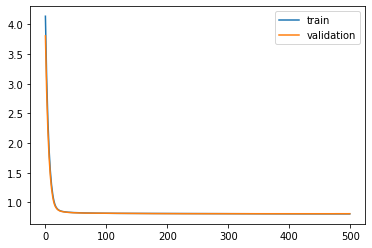

Time to train LSTM:  352.7769067287445
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 4.1533 - pdc_loss: 0.7203 - event_loss: 0.7043 - val_loss: 3.8535 - val_pdc_loss: 0.7006 - val_event_loss: 0.6802

Epoch 00001: val_loss improved from inf to 3.85353, saving model to Event_val_weights2.hdf5
Epoch 2/500
 - 1s - loss: 3.6334 - pdc_loss: 0.6869 - event_loss: 0.6619 - val_loss: 3.3786 - val_pdc_loss: 0.6748 - val_event_loss: 0.6432

Epoch 00002: val_loss improved from 3.85353 to 3.37859, saving model to Event_val_weights2.hdf5
Epoch 3/500
 - 1s - loss: 3.1891 - pdc_loss: 0.6647 - event_loss: 0.6265 - val_loss: 2.9725 - val_pdc_loss: 0.6567 - val_event_loss: 0.6105

Epoch 00003: val_loss improved from 3.37859 to 2.97253, saving model to Event_val_weights2.hdf5
Epoch 4/500
 - 1s - loss: 2.8094 - pdc_loss: 0.6481 - event_loss: 0.5943 - val_loss: 2.6252 - val_pdc_loss: 0.6421 - val_event_loss: 0.5792

Epoch 00004: val_loss improved from 2.97253 to 2.62521, saving m


Epoch 00035: val_loss improved from 0.85431 to 0.85331, saving model to Event_val_weights2.hdf5
Epoch 36/500
 - 1s - loss: 0.8371 - pdc_loss: 0.5266 - event_loss: 0.2981 - val_loss: 0.8525 - val_pdc_loss: 0.5340 - val_event_loss: 0.3062

Epoch 00036: val_loss improved from 0.85331 to 0.85251, saving model to Event_val_weights2.hdf5
Epoch 37/500
 - 1s - loss: 0.8362 - pdc_loss: 0.5259 - event_loss: 0.2981 - val_loss: 0.8516 - val_pdc_loss: 0.5333 - val_event_loss: 0.3061

Epoch 00037: val_loss improved from 0.85251 to 0.85158, saving model to Event_val_weights2.hdf5
Epoch 38/500
 - 1s - loss: 0.8353 - pdc_loss: 0.5253 - event_loss: 0.2980 - val_loss: 0.8509 - val_pdc_loss: 0.5329 - val_event_loss: 0.3060

Epoch 00038: val_loss improved from 0.85158 to 0.85089, saving model to Event_val_weights2.hdf5
Epoch 39/500
 - 1s - loss: 0.8345 - pdc_loss: 0.5247 - event_loss: 0.2979 - val_loss: 0.8501 - val_pdc_loss: 0.5324 - val_event_loss: 0.3059

Epoch 00039: val_loss improved from 0.85089 to 


Epoch 00070: val_loss did not improve from 0.83585
Epoch 71/500
 - 1s - loss: 0.8197 - pdc_loss: 0.5153 - event_loss: 0.2955 - val_loss: 0.8354 - val_pdc_loss: 0.5242 - val_event_loss: 0.3024

Epoch 00071: val_loss improved from 0.83585 to 0.83543, saving model to Event_val_weights2.hdf5
Epoch 72/500
 - 1s - loss: 0.8194 - pdc_loss: 0.5151 - event_loss: 0.2954 - val_loss: 0.8355 - val_pdc_loss: 0.5242 - val_event_loss: 0.3024

Epoch 00072: val_loss did not improve from 0.83543
Epoch 73/500
 - 1s - loss: 0.8192 - pdc_loss: 0.5150 - event_loss: 0.2954 - val_loss: 0.8350 - val_pdc_loss: 0.5239 - val_event_loss: 0.3023

Epoch 00073: val_loss improved from 0.83543 to 0.83499, saving model to Event_val_weights2.hdf5
Epoch 74/500
 - 1s - loss: 0.8190 - pdc_loss: 0.5149 - event_loss: 0.2953 - val_loss: 0.8349 - val_pdc_loss: 0.5239 - val_event_loss: 0.3023

Epoch 00074: val_loss improved from 0.83499 to 0.83492, saving model to Event_val_weights2.hdf5
Epoch 75/500
 - 1s - loss: 0.8187 - pdc_l


Epoch 00108: val_loss did not improve from 0.83210
Epoch 109/500
 - 1s - loss: 0.8142 - pdc_loss: 0.5119 - event_loss: 0.2942 - val_loss: 0.8322 - val_pdc_loss: 0.5225 - val_event_loss: 0.3016

Epoch 00109: val_loss did not improve from 0.83210
Epoch 110/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5118 - event_loss: 0.2941 - val_loss: 0.8322 - val_pdc_loss: 0.5226 - val_event_loss: 0.3015

Epoch 00110: val_loss did not improve from 0.83210
Epoch 111/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5118 - event_loss: 0.2942 - val_loss: 0.8321 - val_pdc_loss: 0.5225 - val_event_loss: 0.3015

Epoch 00111: val_loss improved from 0.83210 to 0.83208, saving model to Event_val_weights2.hdf5
Epoch 112/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5117 - event_loss: 0.2941 - val_loss: 0.8321 - val_pdc_loss: 0.5225 - val_event_loss: 0.3015

Epoch 00112: val_loss did not improve from 0.83208
Epoch 113/500
 - 1s - loss: 0.8138 - pdc_loss: 0.5117 - event_loss: 0.2941 - val_loss: 0.8322 - val_pdc_loss: 0.5226 - val_even


Epoch 00148: val_loss did not improve from 0.83129
Epoch 149/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5104 - event_loss: 0.2933 - val_loss: 0.8313 - val_pdc_loss: 0.5224 - val_event_loss: 0.3013

Epoch 00149: val_loss improved from 0.83129 to 0.83126, saving model to Event_val_weights2.hdf5
Epoch 150/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5103 - event_loss: 0.2932 - val_loss: 0.8315 - val_pdc_loss: 0.5225 - val_event_loss: 0.3014

Epoch 00150: val_loss did not improve from 0.83126
Epoch 151/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5103 - event_loss: 0.2932 - val_loss: 0.8314 - val_pdc_loss: 0.5225 - val_event_loss: 0.3013

Epoch 00151: val_loss did not improve from 0.83126
Epoch 152/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5102 - event_loss: 0.2932 - val_loss: 0.8315 - val_pdc_loss: 0.5225 - val_event_loss: 0.3014

Epoch 00152: val_loss did not improve from 0.83126
Epoch 153/500
 - 1s - loss: 0.8110 - pdc_loss: 0.5103 - event_loss: 0.2932 - val_loss: 0.8315 - val_pdc_loss: 0.5225 - val_even


Epoch 00189: val_loss did not improve from 0.83055
Epoch 190/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5091 - event_loss: 0.2927 - val_loss: 0.8307 - val_pdc_loss: 0.5222 - val_event_loss: 0.3014

Epoch 00190: val_loss did not improve from 0.83055
Epoch 191/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5091 - event_loss: 0.2927 - val_loss: 0.8309 - val_pdc_loss: 0.5223 - val_event_loss: 0.3015

Epoch 00191: val_loss did not improve from 0.83055
Epoch 192/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5092 - event_loss: 0.2926 - val_loss: 0.8308 - val_pdc_loss: 0.5224 - val_event_loss: 0.3013

Epoch 00192: val_loss did not improve from 0.83055
Epoch 193/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5092 - event_loss: 0.2927 - val_loss: 0.8311 - val_pdc_loss: 0.5225 - val_event_loss: 0.3016

Epoch 00193: val_loss did not improve from 0.83055
Epoch 194/500
 - 1s - loss: 0.8088 - pdc_loss: 0.5091 - event_loss: 0.2926 - val_loss: 0.8309 - val_pdc_loss: 0.5225 - val_event_loss: 0.3014

Epoch 00194: val_loss did not


Epoch 00231: val_loss improved from 0.83052 to 0.83052, saving model to Event_val_weights2.hdf5
Epoch 232/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5084 - event_loss: 0.2925 - val_loss: 0.8312 - val_pdc_loss: 0.5226 - val_event_loss: 0.3017

Epoch 00232: val_loss did not improve from 0.83052
Epoch 233/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5084 - event_loss: 0.2924 - val_loss: 0.8307 - val_pdc_loss: 0.5227 - val_event_loss: 0.3011

Epoch 00233: val_loss did not improve from 0.83052
Epoch 234/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5084 - event_loss: 0.2923 - val_loss: 0.8310 - val_pdc_loss: 0.5228 - val_event_loss: 0.3013

Epoch 00234: val_loss did not improve from 0.83052
Epoch 235/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5085 - event_loss: 0.2924 - val_loss: 0.8311 - val_pdc_loss: 0.5229 - val_event_loss: 0.3013

Epoch 00235: val_loss did not improve from 0.83052
Epoch 236/500
 - 1s - loss: 0.8075 - pdc_loss: 0.5083 - event_loss: 0.2923 - val_loss: 0.8312 - val_pdc_loss: 0.5229 - val_even


Epoch 00273: val_loss did not improve from 0.82971
Epoch 274/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5076 - event_loss: 0.2921 - val_loss: 0.8301 - val_pdc_loss: 0.5227 - val_event_loss: 0.3009

Epoch 00274: val_loss did not improve from 0.82971
Epoch 275/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5076 - event_loss: 0.2922 - val_loss: 0.8303 - val_pdc_loss: 0.5227 - val_event_loss: 0.3010

Epoch 00275: val_loss did not improve from 0.82971
Epoch 276/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5079 - event_loss: 0.2923 - val_loss: 0.8313 - val_pdc_loss: 0.5235 - val_event_loss: 0.3012

Epoch 00276: val_loss did not improve from 0.82971
Epoch 277/500
 - 1s - loss: 0.8068 - pdc_loss: 0.5080 - event_loss: 0.2922 - val_loss: 0.8314 - val_pdc_loss: 0.5234 - val_event_loss: 0.3015

Epoch 00277: val_loss did not improve from 0.82971
Epoch 278/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5081 - event_loss: 0.2923 - val_loss: 0.8314 - val_pdc_loss: 0.5234 - val_event_loss: 0.3015

Epoch 00278: val_loss did not


Epoch 00315: val_loss did not improve from 0.82970
Epoch 316/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5078 - event_loss: 0.2922 - val_loss: 0.8309 - val_pdc_loss: 0.5234 - val_event_loss: 0.3011

Epoch 00316: val_loss did not improve from 0.82970
Epoch 317/500
 - 1s - loss: 0.8060 - pdc_loss: 0.5073 - event_loss: 0.2922 - val_loss: 0.8300 - val_pdc_loss: 0.5228 - val_event_loss: 0.3008

Epoch 00317: val_loss did not improve from 0.82970
Epoch 318/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5073 - event_loss: 0.2922 - val_loss: 0.8310 - val_pdc_loss: 0.5234 - val_event_loss: 0.3012

Epoch 00318: val_loss did not improve from 0.82970
Epoch 319/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5076 - event_loss: 0.2923 - val_loss: 0.8318 - val_pdc_loss: 0.5234 - val_event_loss: 0.3019

Epoch 00319: val_loss did not improve from 0.82970
Epoch 320/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5078 - event_loss: 0.2923 - val_loss: 0.8320 - val_pdc_loss: 0.5239 - val_event_loss: 0.3017

Epoch 00320: val_loss did not


Epoch 00357: val_loss did not improve from 0.82945
Epoch 358/500
 - 1s - loss: 0.8051 - pdc_loss: 0.5070 - event_loss: 0.2919 - val_loss: 0.8299 - val_pdc_loss: 0.5229 - val_event_loss: 0.3007

Epoch 00358: val_loss did not improve from 0.82945
Epoch 359/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5068 - event_loss: 0.2919 - val_loss: 0.8299 - val_pdc_loss: 0.5227 - val_event_loss: 0.3010

Epoch 00359: val_loss did not improve from 0.82945
Epoch 360/500
 - 1s - loss: 0.8051 - pdc_loss: 0.5069 - event_loss: 0.2919 - val_loss: 0.8304 - val_pdc_loss: 0.5233 - val_event_loss: 0.3009

Epoch 00360: val_loss did not improve from 0.82945
Epoch 361/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5073 - event_loss: 0.2920 - val_loss: 0.8310 - val_pdc_loss: 0.5235 - val_event_loss: 0.3012

Epoch 00361: val_loss did not improve from 0.82945
Epoch 362/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5074 - event_loss: 0.2922 - val_loss: 0.8314 - val_pdc_loss: 0.5235 - val_event_loss: 0.3017

Epoch 00362: val_loss did not

 - 1s - loss: 0.8051 - pdc_loss: 0.5068 - event_loss: 0.2921 - val_loss: 0.8309 - val_pdc_loss: 0.5231 - val_event_loss: 0.3017

Epoch 00400: val_loss did not improve from 0.82945
Epoch 401/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5070 - event_loss: 0.2920 - val_loss: 0.8317 - val_pdc_loss: 0.5234 - val_event_loss: 0.3021

Epoch 00401: val_loss did not improve from 0.82945
Epoch 402/500
 - 1s - loss: 0.8053 - pdc_loss: 0.5071 - event_loss: 0.2921 - val_loss: 0.8296 - val_pdc_loss: 0.5228 - val_event_loss: 0.3006

Epoch 00402: val_loss did not improve from 0.82945
Epoch 403/500
 - 1s - loss: 0.8047 - pdc_loss: 0.5066 - event_loss: 0.2919 - val_loss: 0.8298 - val_pdc_loss: 0.5226 - val_event_loss: 0.3010

Epoch 00403: val_loss did not improve from 0.82945
Epoch 404/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5067 - event_loss: 0.2920 - val_loss: 0.8303 - val_pdc_loss: 0.5231 - val_event_loss: 0.3010

Epoch 00404: val_loss did not improve from 0.82945
Epoch 405/500
 - 1s - loss: 0.8053 - pdc_los


Epoch 00442: val_loss did not improve from 0.82945
Epoch 443/500
 - 1s - loss: 0.8042 - pdc_loss: 0.5064 - event_loss: 0.2917 - val_loss: 0.8305 - val_pdc_loss: 0.5232 - val_event_loss: 0.3012

Epoch 00443: val_loss did not improve from 0.82945
Epoch 444/500
 - 1s - loss: 0.8039 - pdc_loss: 0.5061 - event_loss: 0.2917 - val_loss: 0.8310 - val_pdc_loss: 0.5232 - val_event_loss: 0.3017

Epoch 00444: val_loss did not improve from 0.82945
Epoch 445/500
 - 1s - loss: 0.8042 - pdc_loss: 0.5063 - event_loss: 0.2917 - val_loss: 0.8314 - val_pdc_loss: 0.5235 - val_event_loss: 0.3018

Epoch 00445: val_loss did not improve from 0.82945
Epoch 446/500
 - 1s - loss: 0.8045 - pdc_loss: 0.5066 - event_loss: 0.2918 - val_loss: 0.8318 - val_pdc_loss: 0.5237 - val_event_loss: 0.3020

Epoch 00446: val_loss did not improve from 0.82945
Epoch 447/500
 - 1s - loss: 0.8048 - pdc_loss: 0.5067 - event_loss: 0.2919 - val_loss: 0.8309 - val_pdc_loss: 0.5231 - val_event_loss: 0.3017

Epoch 00447: val_loss did not

 - 1s - loss: 0.8036 - pdc_loss: 0.5059 - event_loss: 0.2916 - val_loss: 0.8310 - val_pdc_loss: 0.5231 - val_event_loss: 0.3018

Epoch 00485: val_loss did not improve from 0.82945
Epoch 486/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5062 - event_loss: 0.2918 - val_loss: 0.8323 - val_pdc_loss: 0.5237 - val_event_loss: 0.3025

Epoch 00486: val_loss did not improve from 0.82945
Epoch 487/500
 - 1s - loss: 0.8045 - pdc_loss: 0.5066 - event_loss: 0.2918 - val_loss: 0.8326 - val_pdc_loss: 0.5244 - val_event_loss: 0.3021

Epoch 00487: val_loss did not improve from 0.82945
Epoch 488/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5063 - event_loss: 0.2920 - val_loss: 0.8316 - val_pdc_loss: 0.5236 - val_event_loss: 0.3019

Epoch 00488: val_loss did not improve from 0.82945
Epoch 489/500
 - 1s - loss: 0.8041 - pdc_loss: 0.5061 - event_loss: 0.2918 - val_loss: 0.8315 - val_pdc_loss: 0.5234 - val_event_loss: 0.3020

Epoch 00489: val_loss did not improve from 0.82945
Epoch 490/500
 - 1s - loss: 0.8041 - pdc_los

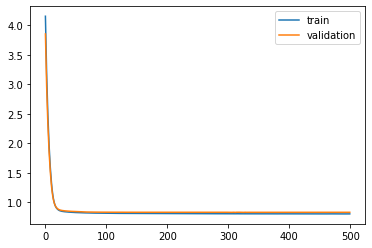

Time to train LSTM:  356.7166109085083
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 4.1850 - pdc_loss: 0.7023 - event_loss: 0.7299 - val_loss: 3.8656 - val_pdc_loss: 0.6912 - val_event_loss: 0.6689

Epoch 00001: val_loss improved from inf to 3.86557, saving model to Event_val_weights3.hdf5
Epoch 2/500
 - 1s - loss: 3.6283 - pdc_loss: 0.6802 - event_loss: 0.6258 - val_loss: 3.3591 - val_pdc_loss: 0.6717 - val_event_loss: 0.5840

Epoch 00002: val_loss improved from 3.86557 to 3.35910, saving model to Event_val_weights3.hdf5
Epoch 3/500
 - 1s - loss: 3.1553 - pdc_loss: 0.6605 - event_loss: 0.5515 - val_loss: 2.9277 - val_pdc_loss: 0.6542 - val_event_loss: 0.5202

Epoch 00003: val_loss improved from 3.35910 to 2.92771, saving model to Event_val_weights3.hdf5
Epoch 4/500
 - 1s - loss: 2.7530 - pdc_loss: 0.6431 - event_loss: 0.4941 - val_loss: 2.5616 - val_pdc_loss: 0.6393 - val_event_loss: 0.4692

Epoch 00004: val_loss improved from 2.92771 to 2.56158, saving m


Epoch 00035: val_loss improved from 0.86093 to 0.86003, saving model to Event_val_weights3.hdf5
Epoch 36/500
 - 1s - loss: 0.8389 - pdc_loss: 0.5292 - event_loss: 0.2968 - val_loss: 0.8592 - val_pdc_loss: 0.5458 - val_event_loss: 0.3007

Epoch 00036: val_loss improved from 0.86003 to 0.85919, saving model to Event_val_weights3.hdf5
Epoch 37/500
 - 1s - loss: 0.8380 - pdc_loss: 0.5285 - event_loss: 0.2968 - val_loss: 0.8584 - val_pdc_loss: 0.5452 - val_event_loss: 0.3006

Epoch 00037: val_loss improved from 0.85919 to 0.85837, saving model to Event_val_weights3.hdf5
Epoch 38/500
 - 1s - loss: 0.8371 - pdc_loss: 0.5278 - event_loss: 0.2968 - val_loss: 0.8576 - val_pdc_loss: 0.5447 - val_event_loss: 0.3006

Epoch 00038: val_loss improved from 0.85837 to 0.85761, saving model to Event_val_weights3.hdf5
Epoch 39/500
 - 1s - loss: 0.8362 - pdc_loss: 0.5272 - event_loss: 0.2968 - val_loss: 0.8569 - val_pdc_loss: 0.5441 - val_event_loss: 0.3006

Epoch 00039: val_loss improved from 0.85761 to 

 - 1s - loss: 0.8219 - pdc_loss: 0.5165 - event_loss: 0.2962 - val_loss: 0.8465 - val_pdc_loss: 0.5366 - val_event_loss: 0.3008

Epoch 00070: val_loss improved from 0.84679 to 0.84654, saving model to Event_val_weights3.hdf5
Epoch 71/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5165 - event_loss: 0.2961 - val_loss: 0.8464 - val_pdc_loss: 0.5365 - val_event_loss: 0.3008

Epoch 00071: val_loss improved from 0.84654 to 0.84643, saving model to Event_val_weights3.hdf5
Epoch 72/500
 - 1s - loss: 0.8215 - pdc_loss: 0.5163 - event_loss: 0.2961 - val_loss: 0.8463 - val_pdc_loss: 0.5364 - val_event_loss: 0.3008

Epoch 00072: val_loss improved from 0.84643 to 0.84628, saving model to Event_val_weights3.hdf5
Epoch 73/500
 - 1s - loss: 0.8213 - pdc_loss: 0.5162 - event_loss: 0.2961 - val_loss: 0.8462 - val_pdc_loss: 0.5364 - val_event_loss: 0.3008

Epoch 00073: val_loss improved from 0.84628 to 0.84618, saving model to Event_val_weights3.hdf5
Epoch 74/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5161 - event_

 - 1s - loss: 0.8165 - pdc_loss: 0.5132 - event_loss: 0.2952 - val_loss: 0.8426 - val_pdc_loss: 0.5342 - val_event_loss: 0.3003

Epoch 00105: val_loss did not improve from 0.84238
Epoch 106/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5131 - event_loss: 0.2952 - val_loss: 0.8423 - val_pdc_loss: 0.5341 - val_event_loss: 0.3002

Epoch 00106: val_loss improved from 0.84238 to 0.84234, saving model to Event_val_weights3.hdf5
Epoch 107/500
 - 1s - loss: 0.8163 - pdc_loss: 0.5130 - event_loss: 0.2952 - val_loss: 0.8422 - val_pdc_loss: 0.5339 - val_event_loss: 0.3002

Epoch 00107: val_loss improved from 0.84234 to 0.84217, saving model to Event_val_weights3.hdf5
Epoch 108/500
 - 1s - loss: 0.8162 - pdc_loss: 0.5130 - event_loss: 0.2952 - val_loss: 0.8422 - val_pdc_loss: 0.5340 - val_event_loss: 0.3001

Epoch 00108: val_loss improved from 0.84217 to 0.84216, saving model to Event_val_weights3.hdf5
Epoch 109/500
 - 1s - loss: 0.8161 - pdc_loss: 0.5129 - event_loss: 0.2951 - val_loss: 0.8420 - val_pdc


Epoch 00141: val_loss improved from 0.84031 to 0.84027, saving model to Event_val_weights3.hdf5
Epoch 142/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5112 - event_loss: 0.2945 - val_loss: 0.8405 - val_pdc_loss: 0.5330 - val_event_loss: 0.3001

Epoch 00142: val_loss did not improve from 0.84027
Epoch 143/500
 - 1s - loss: 0.8132 - pdc_loss: 0.5112 - event_loss: 0.2945 - val_loss: 0.8403 - val_pdc_loss: 0.5327 - val_event_loss: 0.3001

Epoch 00143: val_loss improved from 0.84027 to 0.84025, saving model to Event_val_weights3.hdf5
Epoch 144/500
 - 1s - loss: 0.8131 - pdc_loss: 0.5112 - event_loss: 0.2945 - val_loss: 0.8401 - val_pdc_loss: 0.5327 - val_event_loss: 0.3000

Epoch 00144: val_loss improved from 0.84025 to 0.84012, saving model to Event_val_weights3.hdf5
Epoch 145/500
 - 1s - loss: 0.8130 - pdc_loss: 0.5112 - event_loss: 0.2944 - val_loss: 0.8402 - val_pdc_loss: 0.5328 - val_event_loss: 0.3001

Epoch 00145: val_loss did not improve from 0.84012
Epoch 146/500
 - 1s - loss: 0.8129 - 


Epoch 00181: val_loss did not improve from 0.83971
Epoch 182/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5103 - event_loss: 0.2939 - val_loss: 0.8398 - val_pdc_loss: 0.5326 - val_event_loss: 0.3001

Epoch 00182: val_loss did not improve from 0.83971
Epoch 183/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5103 - event_loss: 0.2938 - val_loss: 0.8399 - val_pdc_loss: 0.5327 - val_event_loss: 0.3002

Epoch 00183: val_loss did not improve from 0.83971
Epoch 184/500
 - 1s - loss: 0.8112 - pdc_loss: 0.5103 - event_loss: 0.2938 - val_loss: 0.8397 - val_pdc_loss: 0.5325 - val_event_loss: 0.3002

Epoch 00184: val_loss did not improve from 0.83971
Epoch 185/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5103 - event_loss: 0.2938 - val_loss: 0.8400 - val_pdc_loss: 0.5327 - val_event_loss: 0.3003

Epoch 00185: val_loss did not improve from 0.83971
Epoch 186/500
 - 1s - loss: 0.8111 - pdc_loss: 0.5103 - event_loss: 0.2938 - val_loss: 0.8398 - val_pdc_loss: 0.5326 - val_event_loss: 0.3002

Epoch 00186: val_loss did not

 - 1s - loss: 0.8098 - pdc_loss: 0.5096 - event_loss: 0.2934 - val_loss: 0.8400 - val_pdc_loss: 0.5327 - val_event_loss: 0.3005

Epoch 00224: val_loss did not improve from 0.83971
Epoch 225/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5096 - event_loss: 0.2934 - val_loss: 0.8402 - val_pdc_loss: 0.5329 - val_event_loss: 0.3006

Epoch 00225: val_loss did not improve from 0.83971
Epoch 226/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5096 - event_loss: 0.2934 - val_loss: 0.8400 - val_pdc_loss: 0.5327 - val_event_loss: 0.3005

Epoch 00226: val_loss did not improve from 0.83971
Epoch 227/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5096 - event_loss: 0.2934 - val_loss: 0.8402 - val_pdc_loss: 0.5328 - val_event_loss: 0.3006

Epoch 00227: val_loss did not improve from 0.83971
Epoch 228/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5096 - event_loss: 0.2934 - val_loss: 0.8400 - val_pdc_loss: 0.5328 - val_event_loss: 0.3005

Epoch 00228: val_loss did not improve from 0.83971
Epoch 229/500
 - 1s - loss: 0.8096 - pdc_los


Epoch 00266: val_loss did not improve from 0.83971
Epoch 267/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5090 - event_loss: 0.2930 - val_loss: 0.8402 - val_pdc_loss: 0.5328 - val_event_loss: 0.3009

Epoch 00267: val_loss did not improve from 0.83971
Epoch 268/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5090 - event_loss: 0.2930 - val_loss: 0.8403 - val_pdc_loss: 0.5329 - val_event_loss: 0.3009

Epoch 00268: val_loss did not improve from 0.83971
Epoch 269/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5090 - event_loss: 0.2930 - val_loss: 0.8401 - val_pdc_loss: 0.5326 - val_event_loss: 0.3010

Epoch 00269: val_loss did not improve from 0.83971
Epoch 270/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5090 - event_loss: 0.2930 - val_loss: 0.8404 - val_pdc_loss: 0.5329 - val_event_loss: 0.3009

Epoch 00270: val_loss did not improve from 0.83971
Epoch 271/500
 - 1s - loss: 0.8086 - pdc_loss: 0.5090 - event_loss: 0.2930 - val_loss: 0.8403 - val_pdc_loss: 0.5328 - val_event_loss: 0.3010

Epoch 00271: val_loss did not

 - 1s - loss: 0.8077 - pdc_loss: 0.5085 - event_loss: 0.2927 - val_loss: 0.8402 - val_pdc_loss: 0.5326 - val_event_loss: 0.3012

Epoch 00309: val_loss did not improve from 0.83971
Epoch 310/500
 - 1s - loss: 0.8077 - pdc_loss: 0.5085 - event_loss: 0.2928 - val_loss: 0.8404 - val_pdc_loss: 0.5328 - val_event_loss: 0.3012

Epoch 00310: val_loss did not improve from 0.83971
Epoch 311/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5084 - event_loss: 0.2927 - val_loss: 0.8402 - val_pdc_loss: 0.5326 - val_event_loss: 0.3012

Epoch 00311: val_loss did not improve from 0.83971
Epoch 312/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5085 - event_loss: 0.2927 - val_loss: 0.8401 - val_pdc_loss: 0.5326 - val_event_loss: 0.3010

Epoch 00312: val_loss did not improve from 0.83971
Epoch 313/500
 - 1s - loss: 0.8076 - pdc_loss: 0.5084 - event_loss: 0.2927 - val_loss: 0.8401 - val_pdc_loss: 0.5325 - val_event_loss: 0.3011

Epoch 00313: val_loss did not improve from 0.83971
Epoch 314/500
 - 1s - loss: 0.8076 - pdc_los


Epoch 00351: val_loss did not improve from 0.83971
Epoch 352/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5078 - event_loss: 0.2925 - val_loss: 0.8403 - val_pdc_loss: 0.5328 - val_event_loss: 0.3011

Epoch 00352: val_loss did not improve from 0.83971
Epoch 353/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5078 - event_loss: 0.2924 - val_loss: 0.8403 - val_pdc_loss: 0.5328 - val_event_loss: 0.3011

Epoch 00353: val_loss did not improve from 0.83971
Epoch 354/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5078 - event_loss: 0.2925 - val_loss: 0.8406 - val_pdc_loss: 0.5330 - val_event_loss: 0.3012

Epoch 00354: val_loss did not improve from 0.83971
Epoch 355/500
 - 1s - loss: 0.8067 - pdc_loss: 0.5078 - event_loss: 0.2925 - val_loss: 0.8407 - val_pdc_loss: 0.5332 - val_event_loss: 0.3012

Epoch 00355: val_loss did not improve from 0.83971
Epoch 356/500
 - 1s - loss: 0.8066 - pdc_loss: 0.5078 - event_loss: 0.2924 - val_loss: 0.8405 - val_pdc_loss: 0.5329 - val_event_loss: 0.3012

Epoch 00356: val_loss did not

 - 1s - loss: 0.8058 - pdc_loss: 0.5072 - event_loss: 0.2922 - val_loss: 0.8407 - val_pdc_loss: 0.5331 - val_event_loss: 0.3011

Epoch 00394: val_loss did not improve from 0.83971
Epoch 395/500
 - 1s - loss: 0.8059 - pdc_loss: 0.5072 - event_loss: 0.2922 - val_loss: 0.8408 - val_pdc_loss: 0.5333 - val_event_loss: 0.3011

Epoch 00395: val_loss did not improve from 0.83971
Epoch 396/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5072 - event_loss: 0.2922 - val_loss: 0.8408 - val_pdc_loss: 0.5333 - val_event_loss: 0.3011

Epoch 00396: val_loss did not improve from 0.83971
Epoch 397/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5072 - event_loss: 0.2922 - val_loss: 0.8407 - val_pdc_loss: 0.5332 - val_event_loss: 0.3010

Epoch 00397: val_loss did not improve from 0.83971
Epoch 398/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5072 - event_loss: 0.2922 - val_loss: 0.8407 - val_pdc_loss: 0.5331 - val_event_loss: 0.3012

Epoch 00398: val_loss did not improve from 0.83971
Epoch 399/500
 - 1s - loss: 0.8058 - pdc_los


Epoch 00436: val_loss did not improve from 0.83971
Epoch 437/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5067 - event_loss: 0.2919 - val_loss: 0.8410 - val_pdc_loss: 0.5333 - val_event_loss: 0.3014

Epoch 00437: val_loss did not improve from 0.83971
Epoch 438/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5066 - event_loss: 0.2920 - val_loss: 0.8411 - val_pdc_loss: 0.5335 - val_event_loss: 0.3013

Epoch 00438: val_loss did not improve from 0.83971
Epoch 439/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5067 - event_loss: 0.2919 - val_loss: 0.8412 - val_pdc_loss: 0.5334 - val_event_loss: 0.3014

Epoch 00439: val_loss did not improve from 0.83971
Epoch 440/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5067 - event_loss: 0.2919 - val_loss: 0.8413 - val_pdc_loss: 0.5336 - val_event_loss: 0.3013

Epoch 00440: val_loss did not improve from 0.83971
Epoch 441/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5067 - event_loss: 0.2919 - val_loss: 0.8410 - val_pdc_loss: 0.5333 - val_event_loss: 0.3014

Epoch 00441: val_loss did not

 - 1s - loss: 0.8044 - pdc_loss: 0.5063 - event_loss: 0.2917 - val_loss: 0.8412 - val_pdc_loss: 0.5335 - val_event_loss: 0.3014

Epoch 00479: val_loss did not improve from 0.83971
Epoch 480/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5063 - event_loss: 0.2918 - val_loss: 0.8414 - val_pdc_loss: 0.5336 - val_event_loss: 0.3014

Epoch 00480: val_loss did not improve from 0.83971
Epoch 481/500
 - 1s - loss: 0.8043 - pdc_loss: 0.5062 - event_loss: 0.2918 - val_loss: 0.8414 - val_pdc_loss: 0.5336 - val_event_loss: 0.3014

Epoch 00481: val_loss did not improve from 0.83971
Epoch 482/500
 - 1s - loss: 0.8043 - pdc_loss: 0.5063 - event_loss: 0.2917 - val_loss: 0.8412 - val_pdc_loss: 0.5335 - val_event_loss: 0.3014

Epoch 00482: val_loss did not improve from 0.83971
Epoch 483/500
 - 1s - loss: 0.8044 - pdc_loss: 0.5063 - event_loss: 0.2918 - val_loss: 0.8411 - val_pdc_loss: 0.5334 - val_event_loss: 0.3014

Epoch 00483: val_loss did not improve from 0.83971
Epoch 484/500
 - 1s - loss: 0.8044 - pdc_los

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f4de1405748>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


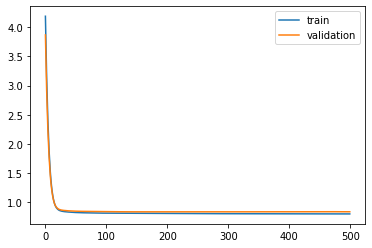

Time to train LSTM:  356.5464143753052
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 1s - loss: 4.1116 - pdc_loss: 0.7094 - event_loss: 0.6502 - val_loss: 3.8097 - val_pdc_loss: 0.6975 - val_event_loss: 0.6166

Epoch 00001: val_loss improved from inf to 3.80971, saving model to Event_val_weights4.hdf5
Epoch 2/500
 - 1s - loss: 3.5824 - pdc_loss: 0.6895 - event_loss: 0.5854 - val_loss: 3.3241 - val_pdc_loss: 0.6811 - val_event_loss: 0.5591

Epoch 00002: val_loss improved from 3.80971 to 3.32412, saving model to Event_val_weights4.hdf5
Epoch 3/500
 - 1s - loss: 3.1264 - pdc_loss: 0.6731 - event_loss: 0.5317 - val_loss: 2.9073 - val_pdc_loss: 0.6673 - val_event_loss: 0.5105

Epoch 00003: val_loss improved from 3.32412 to 2.90729, saving model to Event_val_weights4.hdf5
Epoch 4/500
 - 1s - loss: 2.7358 - pdc_loss: 0.6589 - event_loss: 0.4855 - val_loss: 2.5508 - val_pdc_loss: 0.6548 - val_event_loss: 0.4678

Epoch 00004: val_loss improved from 2.90729 to 2.55077, saving m


Epoch 00035: val_loss improved from 0.86505 to 0.86443, saving model to Event_val_weights4.hdf5
Epoch 36/500
 - 1s - loss: 0.8409 - pdc_loss: 0.5335 - event_loss: 0.2953 - val_loss: 0.8638 - val_pdc_loss: 0.5501 - val_event_loss: 0.3017

Epoch 00036: val_loss improved from 0.86443 to 0.86377, saving model to Event_val_weights4.hdf5
Epoch 37/500
 - 1s - loss: 0.8401 - pdc_loss: 0.5329 - event_loss: 0.2953 - val_loss: 0.8633 - val_pdc_loss: 0.5498 - val_event_loss: 0.3016

Epoch 00037: val_loss improved from 0.86377 to 0.86328, saving model to Event_val_weights4.hdf5
Epoch 38/500
 - 1s - loss: 0.8394 - pdc_loss: 0.5324 - event_loss: 0.2952 - val_loss: 0.8627 - val_pdc_loss: 0.5494 - val_event_loss: 0.3015

Epoch 00038: val_loss improved from 0.86328 to 0.86265, saving model to Event_val_weights4.hdf5
Epoch 39/500
 - 1s - loss: 0.8386 - pdc_loss: 0.5319 - event_loss: 0.2951 - val_loss: 0.8623 - val_pdc_loss: 0.5492 - val_event_loss: 0.3016

Epoch 00039: val_loss improved from 0.86265 to 


Epoch 00070: val_loss improved from 0.85457 to 0.85431, saving model to Event_val_weights4.hdf5
Epoch 71/500
 - 1s - loss: 0.8263 - pdc_loss: 0.5228 - event_loss: 0.2940 - val_loss: 0.8544 - val_pdc_loss: 0.5426 - val_event_loss: 0.3022

Epoch 00071: val_loss did not improve from 0.85431
Epoch 72/500
 - 1s - loss: 0.8261 - pdc_loss: 0.5225 - event_loss: 0.2940 - val_loss: 0.8541 - val_pdc_loss: 0.5424 - val_event_loss: 0.3021

Epoch 00072: val_loss improved from 0.85431 to 0.85407, saving model to Event_val_weights4.hdf5
Epoch 73/500
 - 1s - loss: 0.8259 - pdc_loss: 0.5224 - event_loss: 0.2940 - val_loss: 0.8540 - val_pdc_loss: 0.5423 - val_event_loss: 0.3022

Epoch 00073: val_loss improved from 0.85407 to 0.85405, saving model to Event_val_weights4.hdf5
Epoch 74/500
 - 1s - loss: 0.8257 - pdc_loss: 0.5221 - event_loss: 0.2941 - val_loss: 0.8539 - val_pdc_loss: 0.5421 - val_event_loss: 0.3023

Epoch 00074: val_loss improved from 0.85405 to 0.85388, saving model to Event_val_weights4.h

 - 1s - loss: 0.8192 - pdc_loss: 0.5167 - event_loss: 0.2941 - val_loss: 0.8499 - val_pdc_loss: 0.5383 - val_event_loss: 0.3032

Epoch 00106: val_loss improved from 0.84996 to 0.84989, saving model to Event_val_weights4.hdf5
Epoch 107/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5165 - event_loss: 0.2940 - val_loss: 0.8495 - val_pdc_loss: 0.5381 - val_event_loss: 0.3030

Epoch 00107: val_loss improved from 0.84989 to 0.84953, saving model to Event_val_weights4.hdf5
Epoch 108/500
 - 1s - loss: 0.8189 - pdc_loss: 0.5165 - event_loss: 0.2940 - val_loss: 0.8494 - val_pdc_loss: 0.5380 - val_event_loss: 0.3031

Epoch 00108: val_loss improved from 0.84953 to 0.84943, saving model to Event_val_weights4.hdf5
Epoch 109/500
 - 1s - loss: 0.8186 - pdc_loss: 0.5163 - event_loss: 0.2939 - val_loss: 0.8489 - val_pdc_loss: 0.5377 - val_event_loss: 0.3028

Epoch 00109: val_loss improved from 0.84943 to 0.84889, saving model to Event_val_weights4.hdf5
Epoch 110/500
 - 1s - loss: 0.8185 - pdc_loss: 0.5162 - ev


Epoch 00142: val_loss did not improve from 0.84594
Epoch 143/500
 - 1s - loss: 0.8142 - pdc_loss: 0.5130 - event_loss: 0.2935 - val_loss: 0.8458 - val_pdc_loss: 0.5355 - val_event_loss: 0.3026

Epoch 00143: val_loss improved from 0.84594 to 0.84583, saving model to Event_val_weights4.hdf5
Epoch 144/500
 - 1s - loss: 0.8141 - pdc_loss: 0.5129 - event_loss: 0.2935 - val_loss: 0.8459 - val_pdc_loss: 0.5356 - val_event_loss: 0.3026

Epoch 00144: val_loss did not improve from 0.84583
Epoch 145/500
 - 1s - loss: 0.8140 - pdc_loss: 0.5129 - event_loss: 0.2934 - val_loss: 0.8457 - val_pdc_loss: 0.5354 - val_event_loss: 0.3026

Epoch 00145: val_loss improved from 0.84583 to 0.84571, saving model to Event_val_weights4.hdf5
Epoch 146/500
 - 1s - loss: 0.8139 - pdc_loss: 0.5128 - event_loss: 0.2934 - val_loss: 0.8458 - val_pdc_loss: 0.5355 - val_event_loss: 0.3026

Epoch 00146: val_loss did not improve from 0.84571
Epoch 147/500
 - 1s - loss: 0.8138 - pdc_loss: 0.5127 - event_loss: 0.2934 - val_l


Epoch 00180: val_loss did not improve from 0.84447
Epoch 181/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5112 - event_loss: 0.2931 - val_loss: 0.8444 - val_pdc_loss: 0.5346 - val_event_loss: 0.3025

Epoch 00181: val_loss improved from 0.84447 to 0.84440, saving model to Event_val_weights4.hdf5
Epoch 182/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5112 - event_loss: 0.2930 - val_loss: 0.8445 - val_pdc_loss: 0.5347 - val_event_loss: 0.3026

Epoch 00182: val_loss did not improve from 0.84440
Epoch 183/500
 - 1s - loss: 0.8114 - pdc_loss: 0.5112 - event_loss: 0.2930 - val_loss: 0.8443 - val_pdc_loss: 0.5346 - val_event_loss: 0.3025

Epoch 00183: val_loss improved from 0.84440 to 0.84433, saving model to Event_val_weights4.hdf5
Epoch 184/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5111 - event_loss: 0.2930 - val_loss: 0.8444 - val_pdc_loss: 0.5347 - val_event_loss: 0.3025

Epoch 00184: val_loss did not improve from 0.84433
Epoch 185/500
 - 1s - loss: 0.8113 - pdc_loss: 0.5111 - event_loss: 0.2930 - val_l


Epoch 00218: val_loss did not improve from 0.84349
Epoch 219/500
 - 1s - loss: 0.8098 - pdc_loss: 0.5102 - event_loss: 0.2926 - val_loss: 0.8435 - val_pdc_loss: 0.5340 - val_event_loss: 0.3025

Epoch 00219: val_loss improved from 0.84349 to 0.84345, saving model to Event_val_weights4.hdf5
Epoch 220/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5101 - event_loss: 0.2926 - val_loss: 0.8435 - val_pdc_loss: 0.5341 - val_event_loss: 0.3024

Epoch 00220: val_loss did not improve from 0.84345
Epoch 221/500
 - 1s - loss: 0.8097 - pdc_loss: 0.5101 - event_loss: 0.2926 - val_loss: 0.8434 - val_pdc_loss: 0.5340 - val_event_loss: 0.3025

Epoch 00221: val_loss improved from 0.84345 to 0.84344, saving model to Event_val_weights4.hdf5
Epoch 222/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5101 - event_loss: 0.2926 - val_loss: 0.8435 - val_pdc_loss: 0.5341 - val_event_loss: 0.3024

Epoch 00222: val_loss did not improve from 0.84344
Epoch 223/500
 - 1s - loss: 0.8096 - pdc_loss: 0.5101 - event_loss: 0.2926 - val_l

 - 1s - loss: 0.8084 - pdc_loss: 0.5094 - event_loss: 0.2922 - val_loss: 0.8430 - val_pdc_loss: 0.5337 - val_event_loss: 0.3025

Epoch 00257: val_loss did not improve from 0.84298
Epoch 258/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5094 - event_loss: 0.2922 - val_loss: 0.8430 - val_pdc_loss: 0.5338 - val_event_loss: 0.3025

Epoch 00258: val_loss did not improve from 0.84298
Epoch 259/500
 - 1s - loss: 0.8084 - pdc_loss: 0.5094 - event_loss: 0.2923 - val_loss: 0.8429 - val_pdc_loss: 0.5337 - val_event_loss: 0.3025

Epoch 00259: val_loss improved from 0.84298 to 0.84294, saving model to Event_val_weights4.hdf5
Epoch 260/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5094 - event_loss: 0.2922 - val_loss: 0.8430 - val_pdc_loss: 0.5338 - val_event_loss: 0.3024

Epoch 00260: val_loss did not improve from 0.84294
Epoch 261/500
 - 1s - loss: 0.8083 - pdc_loss: 0.5094 - event_loss: 0.2922 - val_loss: 0.8430 - val_pdc_loss: 0.5337 - val_event_loss: 0.3026

Epoch 00261: val_loss did not improve from 0.84294


Epoch 00296: val_loss did not improve from 0.84261
Epoch 297/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5088 - event_loss: 0.2920 - val_loss: 0.8426 - val_pdc_loss: 0.5336 - val_event_loss: 0.3025

Epoch 00297: val_loss did not improve from 0.84261
Epoch 298/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5088 - event_loss: 0.2920 - val_loss: 0.8426 - val_pdc_loss: 0.5337 - val_event_loss: 0.3024

Epoch 00298: val_loss did not improve from 0.84261
Epoch 299/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5088 - event_loss: 0.2920 - val_loss: 0.8426 - val_pdc_loss: 0.5336 - val_event_loss: 0.3024

Epoch 00299: val_loss improved from 0.84261 to 0.84257, saving model to Event_val_weights4.hdf5
Epoch 300/500
 - 1s - loss: 0.8073 - pdc_loss: 0.5087 - event_loss: 0.2920 - val_loss: 0.8426 - val_pdc_loss: 0.5337 - val_event_loss: 0.3024

Epoch 00300: val_loss did not improve from 0.84257
Epoch 301/500
 - 1s - loss: 0.8074 - pdc_loss: 0.5088 - event_loss: 0.2920 - val_loss: 0.8427 - val_pdc_loss: 0.5336 - val_even


Epoch 00337: val_loss did not improve from 0.84235
Epoch 338/500
 - 1s - loss: 0.8064 - pdc_loss: 0.5082 - event_loss: 0.2918 - val_loss: 0.8424 - val_pdc_loss: 0.5335 - val_event_loss: 0.3025

Epoch 00338: val_loss did not improve from 0.84235
Epoch 339/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5083 - event_loss: 0.2918 - val_loss: 0.8425 - val_pdc_loss: 0.5335 - val_event_loss: 0.3026

Epoch 00339: val_loss did not improve from 0.84235
Epoch 340/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5082 - event_loss: 0.2918 - val_loss: 0.8424 - val_pdc_loss: 0.5335 - val_event_loss: 0.3025

Epoch 00340: val_loss did not improve from 0.84235
Epoch 341/500
 - 1s - loss: 0.8065 - pdc_loss: 0.5083 - event_loss: 0.2918 - val_loss: 0.8425 - val_pdc_loss: 0.5336 - val_event_loss: 0.3026

Epoch 00341: val_loss did not improve from 0.84235
Epoch 342/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5082 - event_loss: 0.2918 - val_loss: 0.8424 - val_pdc_loss: 0.5335 - val_event_loss: 0.3025

Epoch 00342: val_loss did not

 - 1s - loss: 0.8058 - pdc_loss: 0.5079 - event_loss: 0.2917 - val_loss: 0.8422 - val_pdc_loss: 0.5333 - val_event_loss: 0.3027

Epoch 00379: val_loss did not improve from 0.84218
Epoch 380/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5078 - event_loss: 0.2917 - val_loss: 0.8423 - val_pdc_loss: 0.5335 - val_event_loss: 0.3026

Epoch 00380: val_loss did not improve from 0.84218
Epoch 381/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5079 - event_loss: 0.2917 - val_loss: 0.8424 - val_pdc_loss: 0.5335 - val_event_loss: 0.3027

Epoch 00381: val_loss did not improve from 0.84218
Epoch 382/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5078 - event_loss: 0.2916 - val_loss: 0.8424 - val_pdc_loss: 0.5335 - val_event_loss: 0.3028

Epoch 00382: val_loss did not improve from 0.84218
Epoch 383/500
 - 1s - loss: 0.8058 - pdc_loss: 0.5079 - event_loss: 0.2917 - val_loss: 0.8425 - val_pdc_loss: 0.5335 - val_event_loss: 0.3028

Epoch 00383: val_loss did not improve from 0.84218
Epoch 384/500
 - 1s - loss: 0.8056 - pdc_los

 - 1s - loss: 0.8052 - pdc_loss: 0.5075 - event_loss: 0.2916 - val_loss: 0.8420 - val_pdc_loss: 0.5332 - val_event_loss: 0.3027

Epoch 00420: val_loss did not improve from 0.84197
Epoch 421/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5076 - event_loss: 0.2916 - val_loss: 0.8422 - val_pdc_loss: 0.5333 - val_event_loss: 0.3028

Epoch 00421: val_loss did not improve from 0.84197
Epoch 422/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5076 - event_loss: 0.2916 - val_loss: 0.8420 - val_pdc_loss: 0.5332 - val_event_loss: 0.3028

Epoch 00422: val_loss did not improve from 0.84197
Epoch 423/500
 - 1s - loss: 0.8052 - pdc_loss: 0.5076 - event_loss: 0.2916 - val_loss: 0.8420 - val_pdc_loss: 0.5331 - val_event_loss: 0.3028

Epoch 00423: val_loss did not improve from 0.84197
Epoch 424/500
 - 1s - loss: 0.8051 - pdc_loss: 0.5075 - event_loss: 0.2915 - val_loss: 0.8420 - val_pdc_loss: 0.5333 - val_event_loss: 0.3027

Epoch 00424: val_loss did not improve from 0.84197
Epoch 425/500
 - 1s - loss: 0.8051 - pdc_los


Epoch 00461: val_loss did not improve from 0.84185
Epoch 462/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5072 - event_loss: 0.2914 - val_loss: 0.8420 - val_pdc_loss: 0.5331 - val_event_loss: 0.3029

Epoch 00462: val_loss did not improve from 0.84185
Epoch 463/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5073 - event_loss: 0.2914 - val_loss: 0.8418 - val_pdc_loss: 0.5330 - val_event_loss: 0.3029

Epoch 00463: val_loss improved from 0.84185 to 0.84183, saving model to Event_val_weights4.hdf5
Epoch 464/500
 - 1s - loss: 0.8046 - pdc_loss: 0.5072 - event_loss: 0.2914 - val_loss: 0.8419 - val_pdc_loss: 0.5331 - val_event_loss: 0.3029

Epoch 00464: val_loss did not improve from 0.84183
Epoch 465/500
 - 1s - loss: 0.8047 - pdc_loss: 0.5073 - event_loss: 0.2914 - val_loss: 0.8418 - val_pdc_loss: 0.5330 - val_event_loss: 0.3029

Epoch 00465: val_loss improved from 0.84183 to 0.84182, saving model to Event_val_weights4.hdf5
Epoch 466/500
 - 1s - loss: 0.8045 - pdc_loss: 0.5072 - event_loss: 0.2914 - val_l

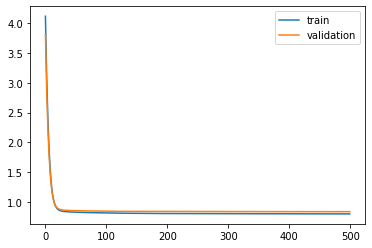

Time to train LSTM:  349.96139788627625
Train on 81000 samples, validate on 9000 samples
Epoch 1/500
 - 2s - loss: 4.1607 - pdc_loss: 0.7564 - event_loss: 0.6956 - val_loss: 3.8626 - val_pdc_loss: 0.7381 - val_event_loss: 0.6704

Epoch 00001: val_loss improved from inf to 3.86259, saving model to Event_val_weights5.hdf5
Epoch 2/500
 - 1s - loss: 3.6331 - pdc_loss: 0.7116 - event_loss: 0.6542 - val_loss: 3.3771 - val_pdc_loss: 0.7006 - val_event_loss: 0.6313

Epoch 00002: val_loss improved from 3.86259 to 3.37708, saving model to Event_val_weights5.hdf5
Epoch 3/500
 - 1s - loss: 3.1792 - pdc_loss: 0.6787 - event_loss: 0.6162 - val_loss: 2.9607 - val_pdc_loss: 0.6727 - val_event_loss: 0.5937

Epoch 00003: val_loss improved from 3.37708 to 2.96068, saving model to Event_val_weights5.hdf5
Epoch 4/500
 - 1s - loss: 2.7902 - pdc_loss: 0.6539 - event_loss: 0.5784 - val_loss: 2.6034 - val_pdc_loss: 0.6509 - val_event_loss: 0.5551

Epoch 00004: val_loss improved from 2.96068 to 2.60342, saving 


Epoch 00035: val_loss improved from 0.84646 to 0.84527, saving model to Event_val_weights5.hdf5
Epoch 36/500
 - 1s - loss: 0.8396 - pdc_loss: 0.5291 - event_loss: 0.2971 - val_loss: 0.8440 - val_pdc_loss: 0.5307 - val_event_loss: 0.3001

Epoch 00036: val_loss improved from 0.84527 to 0.84403, saving model to Event_val_weights5.hdf5
Epoch 37/500
 - 1s - loss: 0.8384 - pdc_loss: 0.5282 - event_loss: 0.2971 - val_loss: 0.8429 - val_pdc_loss: 0.5298 - val_event_loss: 0.3002

Epoch 00037: val_loss improved from 0.84403 to 0.84295, saving model to Event_val_weights5.hdf5
Epoch 38/500
 - 1s - loss: 0.8374 - pdc_loss: 0.5274 - event_loss: 0.2971 - val_loss: 0.8418 - val_pdc_loss: 0.5289 - val_event_loss: 0.3001

Epoch 00038: val_loss improved from 0.84295 to 0.84184, saving model to Event_val_weights5.hdf5
Epoch 39/500
 - 1s - loss: 0.8364 - pdc_loss: 0.5266 - event_loss: 0.2971 - val_loss: 0.8410 - val_pdc_loss: 0.5281 - val_event_loss: 0.3002

Epoch 00039: val_loss improved from 0.84184 to 

 - 1s - loss: 0.8219 - pdc_loss: 0.5170 - event_loss: 0.2958 - val_loss: 0.8295 - val_pdc_loss: 0.5205 - val_event_loss: 0.2999

Epoch 00070: val_loss improved from 0.82973 to 0.82954, saving model to Event_val_weights5.hdf5
Epoch 71/500
 - 1s - loss: 0.8217 - pdc_loss: 0.5168 - event_loss: 0.2957 - val_loss: 0.8293 - val_pdc_loss: 0.5203 - val_event_loss: 0.2999

Epoch 00071: val_loss improved from 0.82954 to 0.82928, saving model to Event_val_weights5.hdf5
Epoch 72/500
 - 1s - loss: 0.8214 - pdc_loss: 0.5167 - event_loss: 0.2957 - val_loss: 0.8291 - val_pdc_loss: 0.5202 - val_event_loss: 0.2999

Epoch 00072: val_loss improved from 0.82928 to 0.82906, saving model to Event_val_weights5.hdf5
Epoch 73/500
 - 1s - loss: 0.8212 - pdc_loss: 0.5165 - event_loss: 0.2957 - val_loss: 0.8289 - val_pdc_loss: 0.5201 - val_event_loss: 0.2998

Epoch 00073: val_loss improved from 0.82906 to 0.82890, saving model to Event_val_weights5.hdf5
Epoch 74/500
 - 1s - loss: 0.8210 - pdc_loss: 0.5164 - event_


Epoch 00105: val_loss improved from 0.82554 to 0.82539, saving model to Event_val_weights5.hdf5
Epoch 106/500
 - 1s - loss: 0.8164 - pdc_loss: 0.5136 - event_loss: 0.2949 - val_loss: 0.8254 - val_pdc_loss: 0.5175 - val_event_loss: 0.3001

Epoch 00106: val_loss did not improve from 0.82539
Epoch 107/500
 - 1s - loss: 0.8163 - pdc_loss: 0.5136 - event_loss: 0.2948 - val_loss: 0.8252 - val_pdc_loss: 0.5174 - val_event_loss: 0.2999

Epoch 00107: val_loss improved from 0.82539 to 0.82522, saving model to Event_val_weights5.hdf5
Epoch 108/500
 - 1s - loss: 0.8162 - pdc_loss: 0.5135 - event_loss: 0.2949 - val_loss: 0.8254 - val_pdc_loss: 0.5175 - val_event_loss: 0.3001

Epoch 00108: val_loss did not improve from 0.82522
Epoch 109/500
 - 1s - loss: 0.8161 - pdc_loss: 0.5134 - event_loss: 0.2948 - val_loss: 0.8252 - val_pdc_loss: 0.5174 - val_event_loss: 0.3000

Epoch 00109: val_loss improved from 0.82522 to 0.82520, saving model to Event_val_weights5.hdf5
Epoch 110/500
 - 1s - loss: 0.8160 - 


Epoch 00142: val_loss did not improve from 0.82400
Epoch 143/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5120 - event_loss: 0.2943 - val_loss: 0.8239 - val_pdc_loss: 0.5168 - val_event_loss: 0.2998

Epoch 00143: val_loss improved from 0.82400 to 0.82387, saving model to Event_val_weights5.hdf5
Epoch 144/500
 - 1s - loss: 0.8136 - pdc_loss: 0.5120 - event_loss: 0.2943 - val_loss: 0.8242 - val_pdc_loss: 0.5168 - val_event_loss: 0.3001

Epoch 00144: val_loss did not improve from 0.82387
Epoch 145/500
 - 1s - loss: 0.8135 - pdc_loss: 0.5120 - event_loss: 0.2942 - val_loss: 0.8238 - val_pdc_loss: 0.5167 - val_event_loss: 0.2998

Epoch 00145: val_loss improved from 0.82387 to 0.82379, saving model to Event_val_weights5.hdf5
Epoch 146/500
 - 1s - loss: 0.8135 - pdc_loss: 0.5120 - event_loss: 0.2942 - val_loss: 0.8241 - val_pdc_loss: 0.5168 - val_event_loss: 0.3000

Epoch 00146: val_loss did not improve from 0.82379
Epoch 147/500
 - 1s - loss: 0.8134 - pdc_loss: 0.5119 - event_loss: 0.2942 - val_l

 - 1s - loss: 0.8117 - pdc_loss: 0.5110 - event_loss: 0.2938 - val_loss: 0.8234 - val_pdc_loss: 0.5167 - val_event_loss: 0.2998

Epoch 00182: val_loss did not improve from 0.82327
Epoch 183/500
 - 1s - loss: 0.8117 - pdc_loss: 0.5109 - event_loss: 0.2938 - val_loss: 0.8232 - val_pdc_loss: 0.5167 - val_event_loss: 0.2996

Epoch 00183: val_loss improved from 0.82327 to 0.82324, saving model to Event_val_weights5.hdf5
Epoch 184/500
 - 1s - loss: 0.8116 - pdc_loss: 0.5109 - event_loss: 0.2938 - val_loss: 0.8234 - val_pdc_loss: 0.5167 - val_event_loss: 0.2997

Epoch 00184: val_loss did not improve from 0.82324
Epoch 185/500
 - 1s - loss: 0.8115 - pdc_loss: 0.5108 - event_loss: 0.2938 - val_loss: 0.8233 - val_pdc_loss: 0.5168 - val_event_loss: 0.2996

Epoch 00185: val_loss did not improve from 0.82324
Epoch 186/500
 - 1s - loss: 0.8116 - pdc_loss: 0.5109 - event_loss: 0.2938 - val_loss: 0.8235 - val_pdc_loss: 0.5169 - val_event_loss: 0.2997

Epoch 00186: val_loss did not improve from 0.82324


Epoch 00222: val_loss did not improve from 0.82295
Epoch 223/500
 - 1s - loss: 0.8103 - pdc_loss: 0.5101 - event_loss: 0.2935 - val_loss: 0.8230 - val_pdc_loss: 0.5169 - val_event_loss: 0.2994

Epoch 00223: val_loss did not improve from 0.82295
Epoch 224/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5100 - event_loss: 0.2935 - val_loss: 0.8230 - val_pdc_loss: 0.5167 - val_event_loss: 0.2996

Epoch 00224: val_loss did not improve from 0.82295
Epoch 225/500
 - 1s - loss: 0.8102 - pdc_loss: 0.5100 - event_loss: 0.2935 - val_loss: 0.8230 - val_pdc_loss: 0.5168 - val_event_loss: 0.2995

Epoch 00225: val_loss did not improve from 0.82295
Epoch 226/500
 - 1s - loss: 0.8101 - pdc_loss: 0.5100 - event_loss: 0.2935 - val_loss: 0.8230 - val_pdc_loss: 0.5168 - val_event_loss: 0.2996

Epoch 00226: val_loss did not improve from 0.82295
Epoch 227/500
 - 1s - loss: 0.8101 - pdc_loss: 0.5100 - event_loss: 0.2934 - val_loss: 0.8232 - val_pdc_loss: 0.5170 - val_event_loss: 0.2995

Epoch 00227: val_loss did not


Epoch 00264: val_loss did not improve from 0.82286
Epoch 265/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5093 - event_loss: 0.2932 - val_loss: 0.8231 - val_pdc_loss: 0.5170 - val_event_loss: 0.2996

Epoch 00265: val_loss did not improve from 0.82286
Epoch 266/500
 - 1s - loss: 0.8090 - pdc_loss: 0.5093 - event_loss: 0.2932 - val_loss: 0.8231 - val_pdc_loss: 0.5169 - val_event_loss: 0.2998

Epoch 00266: val_loss did not improve from 0.82286
Epoch 267/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5092 - event_loss: 0.2932 - val_loss: 0.8230 - val_pdc_loss: 0.5169 - val_event_loss: 0.2996

Epoch 00267: val_loss did not improve from 0.82286
Epoch 268/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5093 - event_loss: 0.2932 - val_loss: 0.8232 - val_pdc_loss: 0.5170 - val_event_loss: 0.2997

Epoch 00268: val_loss did not improve from 0.82286
Epoch 269/500
 - 1s - loss: 0.8089 - pdc_loss: 0.5093 - event_loss: 0.2932 - val_loss: 0.8232 - val_pdc_loss: 0.5170 - val_event_loss: 0.2997

Epoch 00269: val_loss did not


Epoch 00306: val_loss did not improve from 0.82276
Epoch 307/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5087 - event_loss: 0.2930 - val_loss: 0.8228 - val_pdc_loss: 0.5169 - val_event_loss: 0.2996

Epoch 00307: val_loss did not improve from 0.82276
Epoch 308/500
 - 1s - loss: 0.8080 - pdc_loss: 0.5087 - event_loss: 0.2930 - val_loss: 0.8228 - val_pdc_loss: 0.5168 - val_event_loss: 0.2997

Epoch 00308: val_loss improved from 0.82276 to 0.82276, saving model to Event_val_weights5.hdf5
Epoch 309/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5086 - event_loss: 0.2929 - val_loss: 0.8228 - val_pdc_loss: 0.5168 - val_event_loss: 0.2996

Epoch 00309: val_loss improved from 0.82276 to 0.82275, saving model to Event_val_weights5.hdf5
Epoch 310/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5086 - event_loss: 0.2930 - val_loss: 0.8229 - val_pdc_loss: 0.5169 - val_event_loss: 0.2996

Epoch 00310: val_loss did not improve from 0.82275
Epoch 311/500
 - 1s - loss: 0.8079 - pdc_loss: 0.5086 - event_loss: 0.2930 - val_l


Epoch 00347: val_loss did not improve from 0.82254
Epoch 348/500
 - 1s - loss: 0.8070 - pdc_loss: 0.5081 - event_loss: 0.2927 - val_loss: 0.8229 - val_pdc_loss: 0.5169 - val_event_loss: 0.2998

Epoch 00348: val_loss did not improve from 0.82254
Epoch 349/500
 - 1s - loss: 0.8070 - pdc_loss: 0.5081 - event_loss: 0.2927 - val_loss: 0.8229 - val_pdc_loss: 0.5170 - val_event_loss: 0.2997

Epoch 00349: val_loss did not improve from 0.82254
Epoch 350/500
 - 1s - loss: 0.8070 - pdc_loss: 0.5082 - event_loss: 0.2927 - val_loss: 0.8229 - val_pdc_loss: 0.5169 - val_event_loss: 0.2998

Epoch 00350: val_loss did not improve from 0.82254
Epoch 351/500
 - 1s - loss: 0.8069 - pdc_loss: 0.5081 - event_loss: 0.2927 - val_loss: 0.8229 - val_pdc_loss: 0.5171 - val_event_loss: 0.2997

Epoch 00351: val_loss did not improve from 0.82254
Epoch 352/500
 - 1s - loss: 0.8071 - pdc_loss: 0.5082 - event_loss: 0.2927 - val_loss: 0.8231 - val_pdc_loss: 0.5171 - val_event_loss: 0.2998

Epoch 00352: val_loss did not

 - 1s - loss: 0.8063 - pdc_loss: 0.5077 - event_loss: 0.2926 - val_loss: 0.8233 - val_pdc_loss: 0.5172 - val_event_loss: 0.3000

Epoch 00390: val_loss did not improve from 0.82254
Epoch 391/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5077 - event_loss: 0.2925 - val_loss: 0.8234 - val_pdc_loss: 0.5174 - val_event_loss: 0.2999

Epoch 00391: val_loss did not improve from 0.82254
Epoch 392/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5077 - event_loss: 0.2926 - val_loss: 0.8235 - val_pdc_loss: 0.5175 - val_event_loss: 0.3000

Epoch 00392: val_loss did not improve from 0.82254
Epoch 393/500
 - 1s - loss: 0.8062 - pdc_loss: 0.5076 - event_loss: 0.2925 - val_loss: 0.8233 - val_pdc_loss: 0.5174 - val_event_loss: 0.2999

Epoch 00393: val_loss did not improve from 0.82254
Epoch 394/500
 - 1s - loss: 0.8063 - pdc_loss: 0.5077 - event_loss: 0.2926 - val_loss: 0.8234 - val_pdc_loss: 0.5173 - val_event_loss: 0.3001

Epoch 00394: val_loss did not improve from 0.82254
Epoch 395/500
 - 1s - loss: 0.8063 - pdc_los


Epoch 00432: val_loss did not improve from 0.82254
Epoch 433/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5073 - event_loss: 0.2924 - val_loss: 0.8240 - val_pdc_loss: 0.5180 - val_event_loss: 0.2999

Epoch 00433: val_loss did not improve from 0.82254
Epoch 434/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5073 - event_loss: 0.2924 - val_loss: 0.8238 - val_pdc_loss: 0.5178 - val_event_loss: 0.3000

Epoch 00434: val_loss did not improve from 0.82254
Epoch 435/500
 - 1s - loss: 0.8057 - pdc_loss: 0.5073 - event_loss: 0.2924 - val_loss: 0.8237 - val_pdc_loss: 0.5177 - val_event_loss: 0.3000

Epoch 00435: val_loss did not improve from 0.82254
Epoch 436/500
 - 1s - loss: 0.8056 - pdc_loss: 0.5073 - event_loss: 0.2924 - val_loss: 0.8238 - val_pdc_loss: 0.5178 - val_event_loss: 0.3001

Epoch 00436: val_loss did not improve from 0.82254
Epoch 437/500
 - 1s - loss: 0.8055 - pdc_loss: 0.5072 - event_loss: 0.2924 - val_loss: 0.8239 - val_pdc_loss: 0.5179 - val_event_loss: 0.3000

Epoch 00437: val_loss did not

 - 1s - loss: 0.8050 - pdc_loss: 0.5069 - event_loss: 0.2922 - val_loss: 0.8240 - val_pdc_loss: 0.5179 - val_event_loss: 0.3001

Epoch 00475: val_loss did not improve from 0.82254
Epoch 476/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5069 - event_loss: 0.2922 - val_loss: 0.8242 - val_pdc_loss: 0.5179 - val_event_loss: 0.3003

Epoch 00476: val_loss did not improve from 0.82254
Epoch 477/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5068 - event_loss: 0.2922 - val_loss: 0.8245 - val_pdc_loss: 0.5183 - val_event_loss: 0.3003

Epoch 00477: val_loss did not improve from 0.82254
Epoch 478/500
 - 1s - loss: 0.8050 - pdc_loss: 0.5069 - event_loss: 0.2922 - val_loss: 0.8241 - val_pdc_loss: 0.5179 - val_event_loss: 0.3003

Epoch 00478: val_loss did not improve from 0.82254
Epoch 479/500
 - 1s - loss: 0.8049 - pdc_loss: 0.5068 - event_loss: 0.2922 - val_loss: 0.8243 - val_pdc_loss: 0.5182 - val_event_loss: 0.3001

Epoch 00479: val_loss did not improve from 0.82254
Epoch 480/500
 - 1s - loss: 0.8049 - pdc_los

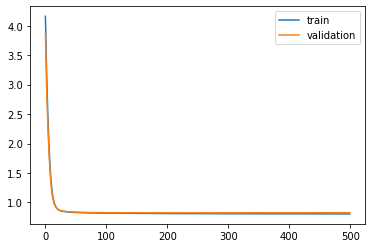

Time to train LSTM:  358.3936882019043
Entire process took:  1774.80477309227
Experiment record:
[[8, 8192, 0.0542265955964866, 0, 0.8082797278298272], [8, 8192, 0.0542265955964866, 1, 0.8294479672643873], [8, 8192, 0.0542265955964866, 2, 0.8397074662314521], [8, 8192, 0.0542265955964866, 3, 0.8416519144376119], [8, 8192, 0.0542265955964866, 4, 0.8225406625535753]]


In [10]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units = 8
batch_s = 8192

start_time = time.time()

L2_list = [0.0542265955964866]

exp_record = []

for i in range(len(L2_list)):
    L2 = L2_list[i]
    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_lstm = np.append(train2_x, train1_x, axis=0) 
        train1_y_pdc = y_pdc_train[:end, ]
        train2_y_pdc = y_pdc_train[end:, ]
        train_y_pdc = np.append(train2_y_pdc, train1_y_pdc, axis=0)
        train1_y_event = y_event_train[:end, ]
        train2_y_event = y_event_train[end:, ]
        train_y_event = np.append(train2_y_event, train1_y_event, axis=0)

        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            x = Input(shape=(8, 182), name="obs")
            model = CuDNNLSTM(units,
                              kernel_regularizer=regularizers.l2(L2))(x)
            out_pdc = Dense(2, activation='softmax', name="pdc")(model)
            out_event = Dense(2, activation='softmax', name="event")(model)
            multi_out_model = Model(x, outputs=[out_pdc, out_event])
            multi_out_model.compile(loss=["categorical_crossentropy",
                                          "categorical_crossentropy"],
                                  #{"pdc":keras.losses.CategoricalCrossentropy(from_logit=True),\
                                  #      "event":keras.losses.CategoricalCrossentropy(from_logit=True)}, 
                                  optimizer='adam', 
                                  #loss_weight=[1.0,1.0])
                                  )  
            val_weight = "Event_val_weights" + str(f+1) + ".hdf5"
            val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                        monitor='val_loss', verbose=1,
                                        save_best_only=True)
            history = multi_out_model.fit({"obs":train_x_lstm}, 
                                          {"pdc":train_y_pdc, 
                                           "event":train_y_event},
                                            batch_size=batch_s, 
                                            epochs=500, validation_split=0.1, 
                                            callbacks=[val_checkpointer], 
                                            verbose=2, 
                                            shuffle=False) 
            print("#################################")
            print("Number of units:", units)
            print("Batch size:", batch_s)
            print("Fold:", f)
            print("L2:", L2)
            print("best val loss:", min(history.history['val_loss']))
            exp_record.append([units, batch_s, L2, f, min(history.history['val_loss'])])
            print("#################################")
            if(f==4):
                print(exp_record)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='validation')
            pyplot.legend()
            pyplot.show()
        end_time = time.time()
        print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [12]:
exp_record = [[8, 8192, 0.10432910870252346, 0, 0.8093811809221904], [8, 8192, 0.10432910870252346, 1, 0.8289863880475362], [8, 8192, 0.10432910870252346, 2, 0.8393336360189649], [8, 8192, 0.10432910870252346, 3, 0.8419956818156772], [8, 8192, 0.10432910870252346, 4, 0.8217822724978129], [8, 8192, 0.12289507278990068, 0, 0.8130077236493428], [8, 8192, 0.12289507278990068, 1, 0.8325298297140333], [8, 8192, 0.12289507278990068, 2, 0.8426976476775275], [8, 8192, 0.12289507278990068, 3, 0.841619718445672], [8, 8192, 0.12289507278990068, 4, 0.8205899216863844], [8, 8192, 0.05168814460397885, 0, 0.8103037574556139], [8, 8192, 0.05168814460397885, 1, 0.8300581893920899], [8, 8192, 0.05168814460397885, 2, 0.8381309418678283], [8, 8192, 0.05168814460397885, 3, 0.8430618965890673], [8, 8192, 0.05168814460397885, 4, 0.8214061036109924], [8, 8192, 0.08303388029137722, 0, 0.809201850467258], [8, 8192, 0.08303388029137722, 1, 0.8279881990220812], [8, 8192, 0.08303388029137722, 2, 0.8403876847161187], [8, 8192, 0.08303388029137722, 3, 0.8426059538523356], [8, 8192, 0.08303388029137722, 4, 0.823015043841468], [8, 8192, 0.08687218248845728, 0, 0.8158967911932203], [8, 8192, 0.08687218248845728, 1, 0.8337712654007806], [8, 8192, 0.08687218248845728, 2, 0.8416788249015809], [8, 8192, 0.08687218248845728, 3, 0.8408576642142401], [8, 8192, 0.08687218248845728, 4, 0.8191048273510403], [8, 8192, 0.05483036657494901, 0, 0.8099916036393907], [8, 8192, 0.05483036657494901, 1, 0.8297212283346388], [8, 8192, 0.05483036657494901, 2, 0.8377256651454502], [8, 8192, 0.05483036657494901, 3, 0.8421046991348267], [8, 8192, 0.05483036657494901, 4, 0.8217530906465318], [8, 8192, 0.06045301881724709, 0, 0.8125180096626282], [8, 8192, 0.06045301881724709, 1, 0.8325985306104025], [8, 8192, 0.06045301881724709, 2, 0.8369053023656209], [8, 8192, 0.06045301881724709, 3, 0.8426112276713054], [8, 8192, 0.06045301881724709, 4, 0.8197689687940809], [8, 8192, 0.05974375156163654, 0, 0.8123247171507941], [8, 8192, 0.05974375156163654, 1, 0.831793457561069], [8, 8192, 0.05974375156163654, 2, 0.8402010009023878], [8, 8192, 0.05974375156163654, 3, 0.8417754667599996], [8, 8192, 0.05974375156163654, 4, 0.8174028968811036], [8, 8192, 0.07454033145135544, 0, 0.8104990751478407], [8, 8192, 0.07454033145135544, 1, 0.8319275399843852], [8, 8192, 0.07454033145135544, 2, 0.8395197819073995], [8, 8192, 0.07454033145135544, 3, 0.8424535180197822], [8, 8192, 0.07454033145135544, 4, 0.8212659850120544], [8, 8192, 0.1373489354458811, 0, 0.8116832407315572], [8, 8192, 0.1373489354458811, 1, 0.8311384522649977], [8, 8192, 0.1373489354458811, 2, 0.8377745242118836], [8, 8192, 0.1373489354458811, 3, 0.8388576614061991], [8, 8192, 0.1373489354458811, 4, 0.822116488509708], [8, 8192, 0.055161163930274905, 0, 0.8170848031573825], [8, 8192, 0.055161163930274905, 1, 0.8345175946553548], [8, 8192, 0.055161163930274905, 2, 0.8376676586469014], [8, 8192, 0.055161163930274905, 3, 0.8405028683344523], [8, 8192, 0.055161163930274905, 4, 0.8184897654851278], [8, 8192, 0.05604813357331892, 0, 0.812188633441925], [8, 8192, 0.05604813357331892, 1, 0.8309068771998087], [8, 8192, 0.05604813357331892, 2, 0.8370987028015985], [8, 8192, 0.05604813357331892, 3, 0.8400026333596972], [8, 8192, 0.05604813357331892, 4, 0.819665632141961], [8, 8192, 0.07387401136014664, 0, 0.8115245891677009], [8, 8192, 0.07387401136014664, 1, 0.8319984084765116], [8, 8192, 0.07387401136014664, 2, 0.8389051872359382], [8, 8192, 0.07387401136014664, 3, 0.8415364498032464], [8, 8192, 0.07387401136014664, 4, 0.8196924525366889], [8, 8192, 0.07036991941456075, 0, 0.813079675356547], [8, 8192, 0.07036991941456075, 1, 0.8318082230885824], [8, 8192, 0.07036991941456075, 2, 0.8367165018717448], [8, 8192, 0.07036991941456075, 3, 0.8398028043111165], [8, 8192, 0.07036991941456075, 4, 0.818757142967648], [8, 8192, 0.06745336207178153, 0, 0.8135525008307563], [8, 8192, 0.06745336207178153, 1, 0.8332157169977824], [8, 8192, 0.06745336207178153, 2, 0.8408982689115736], [8, 8192, 0.06745336207178153, 3, 0.8384613148901198], [8, 8192, 0.06745336207178153, 4, 0.817130895614624], [8, 8192, 0.09153500968223628, 0, 0.813582510418362], [8, 8192, 0.09153500968223628, 1, 0.830284264087677], [8, 8192, 0.09153500968223628, 2, 0.8418142924308777], [8, 8192, 0.09153500968223628, 3, 0.8430033248795403], [8, 8192, 0.09153500968223628, 4, 0.8208833929167854], [8, 8192, 0.14417381181567962, 0, 0.8118973360061645], [8, 8192, 0.14417381181567962, 1, 0.8338103462325203], [8, 8192, 0.14417381181567962, 2, 0.8407147347132365], [8, 8192, 0.14417381181567962, 3, 0.8415230725076464], [8, 8192, 0.14417381181567962, 4, 0.821303475856781], [8, 8192, 0.0966915280957523, 0, 0.8111650473276774], [8, 8192, 0.0966915280957523, 1, 0.8339000730514526], [8, 8192, 0.0966915280957523, 2, 0.8385954088105095], [8, 8192, 0.0966915280957523, 3, 0.8413452974425422], [8, 8192, 0.0966915280957523, 4, 0.8196549509366353], [8, 8192, 0.14599782051907684, 0, 0.813133075873057], [8, 8192, 0.14599782051907684, 1, 0.8329330220222473], [8, 8192, 0.14599782051907684, 2, 0.837871358235677], [8, 8192, 0.14599782051907684, 3, 0.842203020731608], [8, 8192, 0.14599782051907684, 4, 0.8220653496318393], [8, 8192, 0.14998137663042677, 0, 0.8132334478696187], [8, 8192, 0.14998137663042677, 1, 0.8319275133344862], [8, 8192, 0.14998137663042677, 2, 0.8382484582265218], [8, 8192, 0.14998137663042677, 3, 0.8398753925959269], [8, 8192, 0.14998137663042677, 4, 0.8193741414811876], [8, 8192, 0.12263171534399181, 0, 0.813041164557139], [8, 8192, 0.12263171534399181, 1, 0.8335282808409796], [8, 8192, 0.12263171534399181, 2, 0.8386677873929341], [8, 8192, 0.12263171534399181, 3, 0.8407515614827474], [8, 8192, 0.12263171534399181, 4, 0.8215650095409817], [8, 8192, 0.09842286745423245, 0, 0.8160421926710341], [8, 8192, 0.09842286745423245, 1, 0.8319049002859328], [8, 8192, 0.09842286745423245, 2, 0.837510531478458], [8, 8192, 0.09842286745423245, 3, 0.8421033913294474], [8, 8192, 0.09842286745423245, 4, 0.8212767247094048], [8, 8192, 0.06268610337944439, 0, 0.8119014676941766], [8, 8192, 0.06268610337944439, 1, 0.8305425783263313], [8, 8192, 0.06268610337944439, 2, 0.839578054798974], [8, 8192, 0.06268610337944439, 3, 0.8417657202614678], [8, 8192, 0.06268610337944439, 4, 0.8194337516360812], [8, 8192, 0.06054047475070782, 0, 0.8134194512367249], [8, 8192, 0.06054047475070782, 1, 0.8329755675527785], [8, 8192, 0.06054047475070782, 2, 0.8362519493103028], [8, 8192, 0.06054047475070782, 3, 0.8404418992996215], [8, 8192, 0.06054047475070782, 4, 0.8196121284696791], [8, 8192, 0.0542265955964866, 0, 0.8082797278298272], [8, 8192, 0.0542265955964866, 1, 0.8294479672643873], [8, 8192, 0.0542265955964866, 2, 0.8397074662314521], [8, 8192, 0.0542265955964866, 3, 0.8416519144376119], [8, 8192, 0.0542265955964866, 4, 0.8225406625535753]]

complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    model_v = complete_v[(i*5):((i+1)*5), :]
    print("#######################")
    print("Units:\t\t", model_v[0, 0])
    print("Batch size:\t", model_v[0, 1])
    print("L2:\t\t", model_v[0, 2])
    print("Val loss (mean):", np.mean(model_v[:, 4]))
    print("Val loss (Std): ", np.std(model_v[:, 4]))
    print("#######################")
    val_loss_list.append(np.mean(model_v[:, 4]))
print(min(val_loss_list))

(125, 5)
#######################
Units:		 8.0
Batch size:	 8192.0
L2:		 0.10432910870252346
Val loss (mean): 0.8282958318604363
Val loss (Std):  0.011917939024611555
#######################
#######################
Units:		 8.0
Batch size:	 8192.0
L2:		 0.12289507278990068
Val loss (mean): 0.830088968234592
Val loss (Std):  0.01166100857038502
#######################
#######################
Units:		 8.0
Batch size:	 8192.0
L2:		 0.05168814460397885
Val loss (mean): 0.8285921777831182
Val loss (Std):  0.011735552417397297
#######################
#######################
Units:		 8.0
Batch size:	 8192.0
L2:		 0.08303388029137722
Val loss (mean): 0.8286397463798523
Val loss (Std):  0.012189853128161485
#######################
#######################
Units:		 8.0
Batch size:	 8192.0
L2:		 0.08687218248845728
Val loss (mean): 0.8302618746121725
Val loss (Std):  0.01082375775902127
#######################
#######################
Units:		 8.0
Batch size:	 8192.0
L2:		 0.05483036657494901
Val lo